In [1]:
# adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/
# https://towardsdatascience.com/pytorch-tutorial-distilled-95ce8781a89c

# 1. Import Modules

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
%matplotlib inline
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
# fix random seed for reproducibility
np.random.seed(200184)

# 2. Train the GAN model

In [5]:
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [6]:
# defining classes and ANN
class AE_net(nn.Module):
    def __init__(self):
        super(AE_net, self).__init__()
        #net_list = [nn.Linear(1, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 1),  nn.ReLU()
        #           ]  # definition of model, just put in corresponding layers in sequence
        
        net_list = [nn.Linear(4, 15),   
                    nn.Tanh(),
                    nn.Linear(15, 15), 
                    nn.Tanh(),
                    nn.Linear(15, 2)#, 
#                     nn.Tanh(),
#                     nn.Linear(32, 8),
#                     nn.Tanh(),
#                     nn.Linear(8, 2)
                   ]
        self._net = nn.Sequential(*net_list).to(device)
        return

    def forward(self, x):
        return self._net(x)
    
def get_var_from_np(np_array, cuda=False, requires_grad=False):    # convert numpy to PyTorch variable for training
    temp = Variable(torch.from_numpy(np_array), requires_grad=requires_grad).type(torch.FloatTensor)
    if cuda: temp = temp.cuda()
    return temp
    
def train(model, data_in, data_out, data_in_val, data_out_val):
    
    train_data = My_dataset(get_var_from_np(data_in), get_var_from_np(data_out))
    val_data = My_dataset(get_var_from_np(data_in_val), get_var_from_np(data_out_val))
    
    optimizer = torch.optim.SGD(model._net.parameters(), lr = 0.01, momentum=0.9)
    n_epoch = 3000
    batch_size = 100
    n_batch = math.ceil(1. * len(train_data) / batch_size)
    loss_train = np.zeros(n_epoch)
    loss_val = np.zeros(n_epoch)
    
    for epoch in range(n_epoch):    
        
        dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
        
        batch_idx = 0
        for train_in, train_out in dataset:
            out = model._net.forward(train_in)
            loss = nn.MSELoss()(out, train_out) 
            if (batch_idx+1) % min(10,n_batch) == 0:
                print ("Epoch = %5d, Batch = %5d/%5d [%4.0f%%]:\tTraining Loss = %12.5e" % (epoch, batch_idx+1, n_batch, 100. * (batch_idx+1) / n_batch, loss.cpu().data.numpy()))
            optimizer.zero_grad()
            loss.backward() # scalar variables, when we call .backward() on them, don’t require arguments – only tensors require a matching sized tensor argument to be passed to the .backward() operation
            optimizer.step()
            del loss
            batch_idx += 1
        
        data_out_pred = model._net.forward(get_var_from_np(data_in)).cpu().data.numpy()
        diff = data_out_pred - data_out
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_train[epoch] = MSE
        
        data_out_val_pred = model._net.forward(get_var_from_np(data_in_val)).cpu().data.numpy()
        diff = data_out_val_pred - data_out_val
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_val[epoch] = MSE        

    return loss_train, loss_val
    
class My_dataset(Dataset):      # construct dataset object for mini-batch gradient descent
    def __init__(self, data_in, data_out):
        self._data_in = data_in
        self._data_out = data_out

    def __len__(self):
        return len(self._data_in)

    def __getitem__(self, index):
        return self._data_in[index], self._data_out[index]

In [7]:
EBD = np.loadtxt("h2t latent space.txt",delimiter=' ')[:,1:5]
X = np.loadtxt("B_50001_10.txt",delimiter=' ')[:,0:2]

In [8]:
n = X.shape[0]

x = np.concatenate((EBD[:,0].reshape(EBD.shape[0],1), EBD[:,1].reshape(EBD.shape[0],1),EBD[:,2].reshape(EBD.shape[0],1),EBD[:,3].reshape(EBD.shape[0],1)), axis=1)

print (x)

[[-0.00263846 -0.00361265  0.0038061  -0.00162525]
 [-0.00296734 -0.00285012  0.00589526 -0.00032045]
 [-0.00257752 -0.00391072  0.00318959  0.00203152]
 ...
 [-0.00146915 -0.00042359 -0.00124585  0.00109989]
 [-0.00223762 -0.0005158   0.00213227 -0.00028185]
 [-0.00159293 -0.00059936 -0.00070171 -0.00048395]]


In [9]:
y = np.zeros((n,2))

y = np.concatenate((X[:,0].reshape(X.shape[0],1), X[:,1].reshape(X.shape[0],1)), axis=1)

print (y)

[[-0.00226417  0.00089316]
 [-0.0025789   0.00286235]
 [-0.00288158  0.00462698]
 ...
 [ 0.00416933 -0.00889798]
 [-0.00100227  0.00017455]
 [-0.00205245  0.00094186]]


In [10]:
test_frac = 0.10
val_frac = 0.20
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=test_frac, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=val_frac/(1-test_frac), random_state=43)

In [11]:
# scaling
xscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling
yscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling

# xscale = pre.StandardScaler()
# yscale = pre.StandardScaler()


X_train = xscale.fit_transform(x_train)
Y_train = yscale.fit_transform(y_train)
X_val = xscale.transform(x_val)
Y_val = yscale.transform(y_val)
X_test = xscale.transform(x_test)
Y_test = yscale.transform(y_test)
X = xscale.transform(x)
Y = yscale.transform(y)

In [12]:
# training
model = AE_net()
print(model)

AE_net(
  (_net): Sequential(
    (0): Linear(in_features=4, out_features=15, bias=True)
    (1): Tanh()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=2, bias=True)
  )
)


In [13]:
loss_train, loss_val = train(model, X_train, Y_train, X_val, Y_val)

Epoch =     0, Batch =    10/  350 [   3%]:	Training Loss =  4.62993e-02
Epoch =     0, Batch =    20/  350 [   6%]:	Training Loss =  2.82199e-02
Epoch =     0, Batch =    30/  350 [   9%]:	Training Loss =  3.66394e-02
Epoch =     0, Batch =    40/  350 [  11%]:	Training Loss =  4.14051e-02
Epoch =     0, Batch =    50/  350 [  14%]:	Training Loss =  4.15550e-02
Epoch =     0, Batch =    60/  350 [  17%]:	Training Loss =  3.58709e-02
Epoch =     0, Batch =    70/  350 [  20%]:	Training Loss =  3.54443e-02
Epoch =     0, Batch =    80/  350 [  23%]:	Training Loss =  2.84342e-02
Epoch =     0, Batch =    90/  350 [  26%]:	Training Loss =  3.46347e-02
Epoch =     0, Batch =   100/  350 [  29%]:	Training Loss =  3.75632e-02
Epoch =     0, Batch =   110/  350 [  31%]:	Training Loss =  2.59284e-02
Epoch =     0, Batch =   120/  350 [  34%]:	Training Loss =  2.05087e-02
Epoch =     0, Batch =   130/  350 [  37%]:	Training Loss =  2.44548e-02
Epoch =     0, Batch =   140/  350 [  40%]:	Trainin

Epoch =     3, Batch =   200/  350 [  57%]:	Training Loss =  1.61302e-02
Epoch =     3, Batch =   210/  350 [  60%]:	Training Loss =  1.74933e-02
Epoch =     3, Batch =   220/  350 [  63%]:	Training Loss =  1.46326e-02
Epoch =     3, Batch =   230/  350 [  66%]:	Training Loss =  1.48648e-02
Epoch =     3, Batch =   240/  350 [  69%]:	Training Loss =  1.41780e-02
Epoch =     3, Batch =   250/  350 [  71%]:	Training Loss =  1.19206e-02
Epoch =     3, Batch =   260/  350 [  74%]:	Training Loss =  1.37815e-02
Epoch =     3, Batch =   270/  350 [  77%]:	Training Loss =  1.56840e-02
Epoch =     3, Batch =   280/  350 [  80%]:	Training Loss =  1.47475e-02
Epoch =     3, Batch =   290/  350 [  83%]:	Training Loss =  1.63238e-02
Epoch =     3, Batch =   300/  350 [  86%]:	Training Loss =  2.05104e-02
Epoch =     3, Batch =   310/  350 [  89%]:	Training Loss =  1.72246e-02
Epoch =     3, Batch =   320/  350 [  91%]:	Training Loss =  1.54480e-02
Epoch =     3, Batch =   330/  350 [  94%]:	Trainin

Epoch =     7, Batch =    90/  350 [  26%]:	Training Loss =  2.31480e-02
Epoch =     7, Batch =   100/  350 [  29%]:	Training Loss =  1.45915e-02
Epoch =     7, Batch =   110/  350 [  31%]:	Training Loss =  1.23161e-02
Epoch =     7, Batch =   120/  350 [  34%]:	Training Loss =  1.22820e-02
Epoch =     7, Batch =   130/  350 [  37%]:	Training Loss =  1.69846e-02
Epoch =     7, Batch =   140/  350 [  40%]:	Training Loss =  1.84558e-02
Epoch =     7, Batch =   150/  350 [  43%]:	Training Loss =  1.46827e-02
Epoch =     7, Batch =   160/  350 [  46%]:	Training Loss =  1.50256e-02
Epoch =     7, Batch =   170/  350 [  49%]:	Training Loss =  1.35939e-02
Epoch =     7, Batch =   180/  350 [  51%]:	Training Loss =  1.74411e-02
Epoch =     7, Batch =   190/  350 [  54%]:	Training Loss =  1.41336e-02
Epoch =     7, Batch =   200/  350 [  57%]:	Training Loss =  1.62328e-02
Epoch =     7, Batch =   210/  350 [  60%]:	Training Loss =  1.92492e-02
Epoch =     7, Batch =   220/  350 [  63%]:	Trainin

Epoch =    10, Batch =   340/  350 [  97%]:	Training Loss =  1.93961e-02
Epoch =    11, Batch =    10/  350 [   3%]:	Training Loss =  1.49124e-02
Epoch =    11, Batch =    20/  350 [   6%]:	Training Loss =  1.72766e-02
Epoch =    11, Batch =    30/  350 [   9%]:	Training Loss =  1.45503e-02
Epoch =    11, Batch =    40/  350 [  11%]:	Training Loss =  1.73971e-02
Epoch =    11, Batch =    50/  350 [  14%]:	Training Loss =  2.08945e-02
Epoch =    11, Batch =    60/  350 [  17%]:	Training Loss =  1.45349e-02
Epoch =    11, Batch =    70/  350 [  20%]:	Training Loss =  1.87797e-02
Epoch =    11, Batch =    80/  350 [  23%]:	Training Loss =  1.40182e-02
Epoch =    11, Batch =    90/  350 [  26%]:	Training Loss =  1.73970e-02
Epoch =    11, Batch =   100/  350 [  29%]:	Training Loss =  2.37913e-02
Epoch =    11, Batch =   110/  350 [  31%]:	Training Loss =  1.58227e-02
Epoch =    11, Batch =   120/  350 [  34%]:	Training Loss =  1.66889e-02
Epoch =    11, Batch =   130/  350 [  37%]:	Trainin

Epoch =    14, Batch =   230/  350 [  66%]:	Training Loss =  1.72635e-02
Epoch =    14, Batch =   240/  350 [  69%]:	Training Loss =  1.63846e-02
Epoch =    14, Batch =   250/  350 [  71%]:	Training Loss =  1.58719e-02
Epoch =    14, Batch =   260/  350 [  74%]:	Training Loss =  1.31390e-02
Epoch =    14, Batch =   270/  350 [  77%]:	Training Loss =  1.31577e-02
Epoch =    14, Batch =   280/  350 [  80%]:	Training Loss =  1.64409e-02
Epoch =    14, Batch =   290/  350 [  83%]:	Training Loss =  1.25301e-02
Epoch =    14, Batch =   300/  350 [  86%]:	Training Loss =  1.58996e-02
Epoch =    14, Batch =   310/  350 [  89%]:	Training Loss =  1.42105e-02
Epoch =    14, Batch =   320/  350 [  91%]:	Training Loss =  1.57687e-02
Epoch =    14, Batch =   330/  350 [  94%]:	Training Loss =  1.72290e-02
Epoch =    14, Batch =   340/  350 [  97%]:	Training Loss =  1.63270e-02
Epoch =    15, Batch =    10/  350 [   3%]:	Training Loss =  1.15981e-02
Epoch =    15, Batch =    20/  350 [   6%]:	Trainin

Epoch =    18, Batch =    90/  350 [  26%]:	Training Loss =  1.38767e-02
Epoch =    18, Batch =   100/  350 [  29%]:	Training Loss =  1.36449e-02
Epoch =    18, Batch =   110/  350 [  31%]:	Training Loss =  1.75947e-02
Epoch =    18, Batch =   120/  350 [  34%]:	Training Loss =  2.00725e-02
Epoch =    18, Batch =   130/  350 [  37%]:	Training Loss =  1.83714e-02
Epoch =    18, Batch =   140/  350 [  40%]:	Training Loss =  2.27414e-02
Epoch =    18, Batch =   150/  350 [  43%]:	Training Loss =  1.37729e-02
Epoch =    18, Batch =   160/  350 [  46%]:	Training Loss =  1.42829e-02
Epoch =    18, Batch =   170/  350 [  49%]:	Training Loss =  1.83628e-02
Epoch =    18, Batch =   180/  350 [  51%]:	Training Loss =  1.42642e-02
Epoch =    18, Batch =   190/  350 [  54%]:	Training Loss =  1.55191e-02
Epoch =    18, Batch =   200/  350 [  57%]:	Training Loss =  1.96478e-02
Epoch =    18, Batch =   210/  350 [  60%]:	Training Loss =  1.41489e-02
Epoch =    18, Batch =   220/  350 [  63%]:	Trainin

Epoch =    21, Batch =   340/  350 [  97%]:	Training Loss =  1.71972e-02
Epoch =    22, Batch =    10/  350 [   3%]:	Training Loss =  1.43646e-02
Epoch =    22, Batch =    20/  350 [   6%]:	Training Loss =  1.37440e-02
Epoch =    22, Batch =    30/  350 [   9%]:	Training Loss =  1.50474e-02
Epoch =    22, Batch =    40/  350 [  11%]:	Training Loss =  1.64939e-02
Epoch =    22, Batch =    50/  350 [  14%]:	Training Loss =  2.13683e-02
Epoch =    22, Batch =    60/  350 [  17%]:	Training Loss =  1.70169e-02
Epoch =    22, Batch =    70/  350 [  20%]:	Training Loss =  2.09110e-02
Epoch =    22, Batch =    80/  350 [  23%]:	Training Loss =  1.32400e-02
Epoch =    22, Batch =    90/  350 [  26%]:	Training Loss =  2.10750e-02
Epoch =    22, Batch =   100/  350 [  29%]:	Training Loss =  1.58232e-02
Epoch =    22, Batch =   110/  350 [  31%]:	Training Loss =  1.53049e-02
Epoch =    22, Batch =   120/  350 [  34%]:	Training Loss =  1.80155e-02
Epoch =    22, Batch =   130/  350 [  37%]:	Trainin

Epoch =    25, Batch =   240/  350 [  69%]:	Training Loss =  1.20715e-02
Epoch =    25, Batch =   250/  350 [  71%]:	Training Loss =  1.43272e-02
Epoch =    25, Batch =   260/  350 [  74%]:	Training Loss =  1.83863e-02
Epoch =    25, Batch =   270/  350 [  77%]:	Training Loss =  1.64159e-02
Epoch =    25, Batch =   280/  350 [  80%]:	Training Loss =  1.98244e-02
Epoch =    25, Batch =   290/  350 [  83%]:	Training Loss =  1.37346e-02
Epoch =    25, Batch =   300/  350 [  86%]:	Training Loss =  1.59005e-02
Epoch =    25, Batch =   310/  350 [  89%]:	Training Loss =  1.96180e-02
Epoch =    25, Batch =   320/  350 [  91%]:	Training Loss =  1.46128e-02
Epoch =    25, Batch =   330/  350 [  94%]:	Training Loss =  1.28990e-02
Epoch =    25, Batch =   340/  350 [  97%]:	Training Loss =  1.41267e-02
Epoch =    26, Batch =    10/  350 [   3%]:	Training Loss =  1.82925e-02
Epoch =    26, Batch =    20/  350 [   6%]:	Training Loss =  1.57680e-02
Epoch =    26, Batch =    30/  350 [   9%]:	Trainin

Epoch =    29, Batch =    80/  350 [  23%]:	Training Loss =  1.45329e-02
Epoch =    29, Batch =    90/  350 [  26%]:	Training Loss =  1.79908e-02
Epoch =    29, Batch =   100/  350 [  29%]:	Training Loss =  1.66275e-02
Epoch =    29, Batch =   110/  350 [  31%]:	Training Loss =  1.25948e-02
Epoch =    29, Batch =   120/  350 [  34%]:	Training Loss =  1.54729e-02
Epoch =    29, Batch =   130/  350 [  37%]:	Training Loss =  1.63731e-02
Epoch =    29, Batch =   140/  350 [  40%]:	Training Loss =  1.52831e-02
Epoch =    29, Batch =   150/  350 [  43%]:	Training Loss =  1.59535e-02
Epoch =    29, Batch =   160/  350 [  46%]:	Training Loss =  1.57696e-02
Epoch =    29, Batch =   170/  350 [  49%]:	Training Loss =  1.36239e-02
Epoch =    29, Batch =   180/  350 [  51%]:	Training Loss =  1.88891e-02
Epoch =    29, Batch =   190/  350 [  54%]:	Training Loss =  1.54528e-02
Epoch =    29, Batch =   200/  350 [  57%]:	Training Loss =  1.43561e-02
Epoch =    29, Batch =   210/  350 [  60%]:	Trainin

Epoch =    33, Batch =    10/  350 [   3%]:	Training Loss =  1.96726e-02
Epoch =    33, Batch =    20/  350 [   6%]:	Training Loss =  2.13383e-02
Epoch =    33, Batch =    30/  350 [   9%]:	Training Loss =  1.01112e-02
Epoch =    33, Batch =    40/  350 [  11%]:	Training Loss =  1.98597e-02
Epoch =    33, Batch =    50/  350 [  14%]:	Training Loss =  1.73961e-02
Epoch =    33, Batch =    60/  350 [  17%]:	Training Loss =  2.13888e-02
Epoch =    33, Batch =    70/  350 [  20%]:	Training Loss =  1.65732e-02
Epoch =    33, Batch =    80/  350 [  23%]:	Training Loss =  1.62998e-02
Epoch =    33, Batch =    90/  350 [  26%]:	Training Loss =  1.87752e-02
Epoch =    33, Batch =   100/  350 [  29%]:	Training Loss =  1.48361e-02
Epoch =    33, Batch =   110/  350 [  31%]:	Training Loss =  1.65943e-02
Epoch =    33, Batch =   120/  350 [  34%]:	Training Loss =  1.97500e-02
Epoch =    33, Batch =   130/  350 [  37%]:	Training Loss =  1.61407e-02
Epoch =    33, Batch =   140/  350 [  40%]:	Trainin

Epoch =    36, Batch =   220/  350 [  63%]:	Training Loss =  1.18225e-02
Epoch =    36, Batch =   230/  350 [  66%]:	Training Loss =  1.41167e-02
Epoch =    36, Batch =   240/  350 [  69%]:	Training Loss =  1.60061e-02
Epoch =    36, Batch =   250/  350 [  71%]:	Training Loss =  1.50618e-02
Epoch =    36, Batch =   260/  350 [  74%]:	Training Loss =  1.77375e-02
Epoch =    36, Batch =   270/  350 [  77%]:	Training Loss =  2.09052e-02
Epoch =    36, Batch =   280/  350 [  80%]:	Training Loss =  1.57847e-02
Epoch =    36, Batch =   290/  350 [  83%]:	Training Loss =  2.04479e-02
Epoch =    36, Batch =   300/  350 [  86%]:	Training Loss =  1.65112e-02
Epoch =    36, Batch =   310/  350 [  89%]:	Training Loss =  1.39454e-02
Epoch =    36, Batch =   320/  350 [  91%]:	Training Loss =  1.75483e-02
Epoch =    36, Batch =   330/  350 [  94%]:	Training Loss =  1.67145e-02
Epoch =    36, Batch =   340/  350 [  97%]:	Training Loss =  1.67874e-02
Epoch =    37, Batch =    10/  350 [   3%]:	Trainin

Epoch =    40, Batch =    60/  350 [  17%]:	Training Loss =  1.33419e-02
Epoch =    40, Batch =    70/  350 [  20%]:	Training Loss =  1.29217e-02
Epoch =    40, Batch =    80/  350 [  23%]:	Training Loss =  1.09141e-02
Epoch =    40, Batch =    90/  350 [  26%]:	Training Loss =  1.90049e-02
Epoch =    40, Batch =   100/  350 [  29%]:	Training Loss =  1.98957e-02
Epoch =    40, Batch =   110/  350 [  31%]:	Training Loss =  1.37626e-02
Epoch =    40, Batch =   120/  350 [  34%]:	Training Loss =  1.96812e-02
Epoch =    40, Batch =   130/  350 [  37%]:	Training Loss =  1.70566e-02
Epoch =    40, Batch =   140/  350 [  40%]:	Training Loss =  1.87701e-02
Epoch =    40, Batch =   150/  350 [  43%]:	Training Loss =  1.62241e-02
Epoch =    40, Batch =   160/  350 [  46%]:	Training Loss =  2.06406e-02
Epoch =    40, Batch =   170/  350 [  49%]:	Training Loss =  1.58283e-02
Epoch =    40, Batch =   180/  350 [  51%]:	Training Loss =  1.80664e-02
Epoch =    40, Batch =   190/  350 [  54%]:	Trainin

Epoch =    43, Batch =   210/  350 [  60%]:	Training Loss =  1.95452e-02
Epoch =    43, Batch =   220/  350 [  63%]:	Training Loss =  1.60602e-02
Epoch =    43, Batch =   230/  350 [  66%]:	Training Loss =  1.47389e-02
Epoch =    43, Batch =   240/  350 [  69%]:	Training Loss =  1.61745e-02
Epoch =    43, Batch =   250/  350 [  71%]:	Training Loss =  1.77153e-02
Epoch =    43, Batch =   260/  350 [  74%]:	Training Loss =  1.66868e-02
Epoch =    43, Batch =   270/  350 [  77%]:	Training Loss =  1.78718e-02
Epoch =    43, Batch =   280/  350 [  80%]:	Training Loss =  1.23614e-02
Epoch =    43, Batch =   290/  350 [  83%]:	Training Loss =  1.31920e-02
Epoch =    43, Batch =   300/  350 [  86%]:	Training Loss =  2.13339e-02
Epoch =    43, Batch =   310/  350 [  89%]:	Training Loss =  1.22509e-02
Epoch =    43, Batch =   320/  350 [  91%]:	Training Loss =  1.81872e-02
Epoch =    43, Batch =   330/  350 [  94%]:	Training Loss =  1.46162e-02
Epoch =    43, Batch =   340/  350 [  97%]:	Trainin

Epoch =    47, Batch =    40/  350 [  11%]:	Training Loss =  1.42213e-02
Epoch =    47, Batch =    50/  350 [  14%]:	Training Loss =  1.66420e-02
Epoch =    47, Batch =    60/  350 [  17%]:	Training Loss =  1.25755e-02
Epoch =    47, Batch =    70/  350 [  20%]:	Training Loss =  1.46676e-02
Epoch =    47, Batch =    80/  350 [  23%]:	Training Loss =  1.05277e-02
Epoch =    47, Batch =    90/  350 [  26%]:	Training Loss =  1.41391e-02
Epoch =    47, Batch =   100/  350 [  29%]:	Training Loss =  1.63356e-02
Epoch =    47, Batch =   110/  350 [  31%]:	Training Loss =  2.20863e-02
Epoch =    47, Batch =   120/  350 [  34%]:	Training Loss =  1.53693e-02
Epoch =    47, Batch =   130/  350 [  37%]:	Training Loss =  1.76416e-02
Epoch =    47, Batch =   140/  350 [  40%]:	Training Loss =  1.72187e-02
Epoch =    47, Batch =   150/  350 [  43%]:	Training Loss =  1.82361e-02
Epoch =    47, Batch =   160/  350 [  46%]:	Training Loss =  1.65577e-02
Epoch =    47, Batch =   170/  350 [  49%]:	Trainin

Epoch =    50, Batch =   190/  350 [  54%]:	Training Loss =  1.38320e-02
Epoch =    50, Batch =   200/  350 [  57%]:	Training Loss =  1.99583e-02
Epoch =    50, Batch =   210/  350 [  60%]:	Training Loss =  1.88229e-02
Epoch =    50, Batch =   220/  350 [  63%]:	Training Loss =  1.48077e-02
Epoch =    50, Batch =   230/  350 [  66%]:	Training Loss =  1.29432e-02
Epoch =    50, Batch =   240/  350 [  69%]:	Training Loss =  1.67789e-02
Epoch =    50, Batch =   250/  350 [  71%]:	Training Loss =  1.17457e-02
Epoch =    50, Batch =   260/  350 [  74%]:	Training Loss =  1.29684e-02
Epoch =    50, Batch =   270/  350 [  77%]:	Training Loss =  1.33410e-02
Epoch =    50, Batch =   280/  350 [  80%]:	Training Loss =  1.87624e-02
Epoch =    50, Batch =   290/  350 [  83%]:	Training Loss =  1.79352e-02
Epoch =    50, Batch =   300/  350 [  86%]:	Training Loss =  1.76985e-02
Epoch =    50, Batch =   310/  350 [  89%]:	Training Loss =  1.09629e-02
Epoch =    50, Batch =   320/  350 [  91%]:	Trainin

Epoch =    54, Batch =    10/  350 [   3%]:	Training Loss =  1.85864e-02
Epoch =    54, Batch =    20/  350 [   6%]:	Training Loss =  1.56587e-02
Epoch =    54, Batch =    30/  350 [   9%]:	Training Loss =  1.38442e-02
Epoch =    54, Batch =    40/  350 [  11%]:	Training Loss =  1.36308e-02
Epoch =    54, Batch =    50/  350 [  14%]:	Training Loss =  1.30543e-02
Epoch =    54, Batch =    60/  350 [  17%]:	Training Loss =  1.29271e-02
Epoch =    54, Batch =    70/  350 [  20%]:	Training Loss =  1.03747e-02
Epoch =    54, Batch =    80/  350 [  23%]:	Training Loss =  1.50930e-02
Epoch =    54, Batch =    90/  350 [  26%]:	Training Loss =  1.42645e-02
Epoch =    54, Batch =   100/  350 [  29%]:	Training Loss =  1.47224e-02
Epoch =    54, Batch =   110/  350 [  31%]:	Training Loss =  1.66031e-02
Epoch =    54, Batch =   120/  350 [  34%]:	Training Loss =  2.00810e-02
Epoch =    54, Batch =   130/  350 [  37%]:	Training Loss =  1.57762e-02
Epoch =    54, Batch =   140/  350 [  40%]:	Trainin

Epoch =    57, Batch =   170/  350 [  49%]:	Training Loss =  1.46540e-02
Epoch =    57, Batch =   180/  350 [  51%]:	Training Loss =  1.79517e-02
Epoch =    57, Batch =   190/  350 [  54%]:	Training Loss =  1.61613e-02
Epoch =    57, Batch =   200/  350 [  57%]:	Training Loss =  1.67744e-02
Epoch =    57, Batch =   210/  350 [  60%]:	Training Loss =  1.15290e-02
Epoch =    57, Batch =   220/  350 [  63%]:	Training Loss =  1.48684e-02
Epoch =    57, Batch =   230/  350 [  66%]:	Training Loss =  1.57888e-02
Epoch =    57, Batch =   240/  350 [  69%]:	Training Loss =  1.80005e-02
Epoch =    57, Batch =   250/  350 [  71%]:	Training Loss =  1.15318e-02
Epoch =    57, Batch =   260/  350 [  74%]:	Training Loss =  1.53898e-02
Epoch =    57, Batch =   270/  350 [  77%]:	Training Loss =  1.66770e-02
Epoch =    57, Batch =   280/  350 [  80%]:	Training Loss =  1.55740e-02
Epoch =    57, Batch =   290/  350 [  83%]:	Training Loss =  1.34937e-02
Epoch =    57, Batch =   300/  350 [  86%]:	Trainin

Epoch =    60, Batch =   290/  350 [  83%]:	Training Loss =  1.27592e-02
Epoch =    60, Batch =   300/  350 [  86%]:	Training Loss =  1.24307e-02
Epoch =    60, Batch =   310/  350 [  89%]:	Training Loss =  1.84349e-02
Epoch =    60, Batch =   320/  350 [  91%]:	Training Loss =  1.79406e-02
Epoch =    60, Batch =   330/  350 [  94%]:	Training Loss =  1.02968e-02
Epoch =    60, Batch =   340/  350 [  97%]:	Training Loss =  1.76959e-02
Epoch =    61, Batch =    10/  350 [   3%]:	Training Loss =  1.36120e-02
Epoch =    61, Batch =    20/  350 [   6%]:	Training Loss =  1.40801e-02
Epoch =    61, Batch =    30/  350 [   9%]:	Training Loss =  1.52367e-02
Epoch =    61, Batch =    40/  350 [  11%]:	Training Loss =  1.34672e-02
Epoch =    61, Batch =    50/  350 [  14%]:	Training Loss =  1.60265e-02
Epoch =    61, Batch =    60/  350 [  17%]:	Training Loss =  1.44863e-02
Epoch =    61, Batch =    70/  350 [  20%]:	Training Loss =  1.14868e-02
Epoch =    61, Batch =    80/  350 [  23%]:	Trainin

Epoch =    64, Batch =   170/  350 [  49%]:	Training Loss =  1.41117e-02
Epoch =    64, Batch =   180/  350 [  51%]:	Training Loss =  1.21083e-02
Epoch =    64, Batch =   190/  350 [  54%]:	Training Loss =  1.39495e-02
Epoch =    64, Batch =   200/  350 [  57%]:	Training Loss =  1.09164e-02
Epoch =    64, Batch =   210/  350 [  60%]:	Training Loss =  2.47789e-02
Epoch =    64, Batch =   220/  350 [  63%]:	Training Loss =  1.53888e-02
Epoch =    64, Batch =   230/  350 [  66%]:	Training Loss =  2.31815e-02
Epoch =    64, Batch =   240/  350 [  69%]:	Training Loss =  1.23787e-02
Epoch =    64, Batch =   250/  350 [  71%]:	Training Loss =  1.34310e-02
Epoch =    64, Batch =   260/  350 [  74%]:	Training Loss =  1.56341e-02
Epoch =    64, Batch =   270/  350 [  77%]:	Training Loss =  1.32218e-02
Epoch =    64, Batch =   280/  350 [  80%]:	Training Loss =  1.00911e-02
Epoch =    64, Batch =   290/  350 [  83%]:	Training Loss =  1.57437e-02
Epoch =    64, Batch =   300/  350 [  86%]:	Trainin

Epoch =    67, Batch =   310/  350 [  89%]:	Training Loss =  1.46784e-02
Epoch =    67, Batch =   320/  350 [  91%]:	Training Loss =  1.23574e-02
Epoch =    67, Batch =   330/  350 [  94%]:	Training Loss =  1.61760e-02
Epoch =    67, Batch =   340/  350 [  97%]:	Training Loss =  1.42232e-02
Epoch =    68, Batch =    10/  350 [   3%]:	Training Loss =  1.38160e-02
Epoch =    68, Batch =    20/  350 [   6%]:	Training Loss =  1.42224e-02
Epoch =    68, Batch =    30/  350 [   9%]:	Training Loss =  1.16172e-02
Epoch =    68, Batch =    40/  350 [  11%]:	Training Loss =  1.27420e-02
Epoch =    68, Batch =    50/  350 [  14%]:	Training Loss =  1.36020e-02
Epoch =    68, Batch =    60/  350 [  17%]:	Training Loss =  1.44220e-02
Epoch =    68, Batch =    70/  350 [  20%]:	Training Loss =  1.71423e-02
Epoch =    68, Batch =    80/  350 [  23%]:	Training Loss =  1.66532e-02
Epoch =    68, Batch =    90/  350 [  26%]:	Training Loss =  1.29484e-02
Epoch =    68, Batch =   100/  350 [  29%]:	Trainin

Epoch =    71, Batch =   190/  350 [  54%]:	Training Loss =  9.30565e-03
Epoch =    71, Batch =   200/  350 [  57%]:	Training Loss =  1.20759e-02
Epoch =    71, Batch =   210/  350 [  60%]:	Training Loss =  1.45520e-02
Epoch =    71, Batch =   220/  350 [  63%]:	Training Loss =  1.02908e-02
Epoch =    71, Batch =   230/  350 [  66%]:	Training Loss =  1.05493e-02
Epoch =    71, Batch =   240/  350 [  69%]:	Training Loss =  1.60948e-02
Epoch =    71, Batch =   250/  350 [  71%]:	Training Loss =  1.48351e-02
Epoch =    71, Batch =   260/  350 [  74%]:	Training Loss =  1.50007e-02
Epoch =    71, Batch =   270/  350 [  77%]:	Training Loss =  1.30971e-02
Epoch =    71, Batch =   280/  350 [  80%]:	Training Loss =  8.42093e-03
Epoch =    71, Batch =   290/  350 [  83%]:	Training Loss =  1.41452e-02
Epoch =    71, Batch =   300/  350 [  86%]:	Training Loss =  1.48114e-02
Epoch =    71, Batch =   310/  350 [  89%]:	Training Loss =  1.46921e-02
Epoch =    71, Batch =   320/  350 [  91%]:	Trainin

Epoch =    74, Batch =   310/  350 [  89%]:	Training Loss =  1.48830e-02
Epoch =    74, Batch =   320/  350 [  91%]:	Training Loss =  1.53366e-02
Epoch =    74, Batch =   330/  350 [  94%]:	Training Loss =  1.65242e-02
Epoch =    74, Batch =   340/  350 [  97%]:	Training Loss =  1.82423e-02
Epoch =    75, Batch =    10/  350 [   3%]:	Training Loss =  1.40937e-02
Epoch =    75, Batch =    20/  350 [   6%]:	Training Loss =  1.28306e-02
Epoch =    75, Batch =    30/  350 [   9%]:	Training Loss =  1.29616e-02
Epoch =    75, Batch =    40/  350 [  11%]:	Training Loss =  1.24351e-02
Epoch =    75, Batch =    50/  350 [  14%]:	Training Loss =  1.29133e-02
Epoch =    75, Batch =    60/  350 [  17%]:	Training Loss =  1.26131e-02
Epoch =    75, Batch =    70/  350 [  20%]:	Training Loss =  1.39766e-02
Epoch =    75, Batch =    80/  350 [  23%]:	Training Loss =  1.46770e-02
Epoch =    75, Batch =    90/  350 [  26%]:	Training Loss =  1.05761e-02
Epoch =    75, Batch =   100/  350 [  29%]:	Trainin

Epoch =    78, Batch =   190/  350 [  54%]:	Training Loss =  9.69143e-03
Epoch =    78, Batch =   200/  350 [  57%]:	Training Loss =  8.09126e-03
Epoch =    78, Batch =   210/  350 [  60%]:	Training Loss =  1.38988e-02
Epoch =    78, Batch =   220/  350 [  63%]:	Training Loss =  1.07136e-02
Epoch =    78, Batch =   230/  350 [  66%]:	Training Loss =  1.49124e-02
Epoch =    78, Batch =   240/  350 [  69%]:	Training Loss =  1.28322e-02
Epoch =    78, Batch =   250/  350 [  71%]:	Training Loss =  9.50752e-03
Epoch =    78, Batch =   260/  350 [  74%]:	Training Loss =  1.71790e-02
Epoch =    78, Batch =   270/  350 [  77%]:	Training Loss =  1.79929e-02
Epoch =    78, Batch =   280/  350 [  80%]:	Training Loss =  1.27881e-02
Epoch =    78, Batch =   290/  350 [  83%]:	Training Loss =  1.27465e-02
Epoch =    78, Batch =   300/  350 [  86%]:	Training Loss =  1.36401e-02
Epoch =    78, Batch =   310/  350 [  89%]:	Training Loss =  1.20918e-02
Epoch =    78, Batch =   320/  350 [  91%]:	Trainin

Epoch =    82, Batch =    80/  350 [  23%]:	Training Loss =  1.88604e-02
Epoch =    82, Batch =    90/  350 [  26%]:	Training Loss =  1.32734e-02
Epoch =    82, Batch =   100/  350 [  29%]:	Training Loss =  1.24504e-02
Epoch =    82, Batch =   110/  350 [  31%]:	Training Loss =  9.95743e-03
Epoch =    82, Batch =   120/  350 [  34%]:	Training Loss =  1.07319e-02
Epoch =    82, Batch =   130/  350 [  37%]:	Training Loss =  1.42815e-02
Epoch =    82, Batch =   140/  350 [  40%]:	Training Loss =  1.03375e-02
Epoch =    82, Batch =   150/  350 [  43%]:	Training Loss =  1.21991e-02
Epoch =    82, Batch =   160/  350 [  46%]:	Training Loss =  1.67322e-02
Epoch =    82, Batch =   170/  350 [  49%]:	Training Loss =  1.25935e-02
Epoch =    82, Batch =   180/  350 [  51%]:	Training Loss =  1.65563e-02
Epoch =    82, Batch =   190/  350 [  54%]:	Training Loss =  1.25434e-02
Epoch =    82, Batch =   200/  350 [  57%]:	Training Loss =  1.50030e-02
Epoch =    82, Batch =   210/  350 [  60%]:	Trainin

Epoch =    85, Batch =   310/  350 [  89%]:	Training Loss =  1.42485e-02
Epoch =    85, Batch =   320/  350 [  91%]:	Training Loss =  1.12194e-02
Epoch =    85, Batch =   330/  350 [  94%]:	Training Loss =  1.49349e-02
Epoch =    85, Batch =   340/  350 [  97%]:	Training Loss =  1.42568e-02
Epoch =    86, Batch =    10/  350 [   3%]:	Training Loss =  1.32653e-02
Epoch =    86, Batch =    20/  350 [   6%]:	Training Loss =  1.04567e-02
Epoch =    86, Batch =    30/  350 [   9%]:	Training Loss =  1.28719e-02
Epoch =    86, Batch =    40/  350 [  11%]:	Training Loss =  1.49109e-02
Epoch =    86, Batch =    50/  350 [  14%]:	Training Loss =  1.21005e-02
Epoch =    86, Batch =    60/  350 [  17%]:	Training Loss =  1.53230e-02
Epoch =    86, Batch =    70/  350 [  20%]:	Training Loss =  1.43876e-02
Epoch =    86, Batch =    80/  350 [  23%]:	Training Loss =  1.32508e-02
Epoch =    86, Batch =    90/  350 [  26%]:	Training Loss =  1.53146e-02
Epoch =    86, Batch =   100/  350 [  29%]:	Trainin

Epoch =    89, Batch =   120/  350 [  34%]:	Training Loss =  1.55305e-02
Epoch =    89, Batch =   130/  350 [  37%]:	Training Loss =  1.18252e-02
Epoch =    89, Batch =   140/  350 [  40%]:	Training Loss =  1.40058e-02
Epoch =    89, Batch =   150/  350 [  43%]:	Training Loss =  1.16114e-02
Epoch =    89, Batch =   160/  350 [  46%]:	Training Loss =  1.52451e-02
Epoch =    89, Batch =   170/  350 [  49%]:	Training Loss =  1.52927e-02
Epoch =    89, Batch =   180/  350 [  51%]:	Training Loss =  1.04752e-02
Epoch =    89, Batch =   190/  350 [  54%]:	Training Loss =  1.36078e-02
Epoch =    89, Batch =   200/  350 [  57%]:	Training Loss =  1.02629e-02
Epoch =    89, Batch =   210/  350 [  60%]:	Training Loss =  1.19784e-02
Epoch =    89, Batch =   220/  350 [  63%]:	Training Loss =  1.14024e-02
Epoch =    89, Batch =   230/  350 [  66%]:	Training Loss =  1.57794e-02
Epoch =    89, Batch =   240/  350 [  69%]:	Training Loss =  1.14678e-02
Epoch =    89, Batch =   250/  350 [  71%]:	Trainin

Epoch =    92, Batch =   230/  350 [  66%]:	Training Loss =  9.13552e-03
Epoch =    92, Batch =   240/  350 [  69%]:	Training Loss =  1.61730e-02
Epoch =    92, Batch =   250/  350 [  71%]:	Training Loss =  1.04508e-02
Epoch =    92, Batch =   260/  350 [  74%]:	Training Loss =  1.32196e-02
Epoch =    92, Batch =   270/  350 [  77%]:	Training Loss =  1.22353e-02
Epoch =    92, Batch =   280/  350 [  80%]:	Training Loss =  1.45615e-02
Epoch =    92, Batch =   290/  350 [  83%]:	Training Loss =  1.53935e-02
Epoch =    92, Batch =   300/  350 [  86%]:	Training Loss =  1.19603e-02
Epoch =    92, Batch =   310/  350 [  89%]:	Training Loss =  1.04709e-02
Epoch =    92, Batch =   320/  350 [  91%]:	Training Loss =  1.52406e-02
Epoch =    92, Batch =   330/  350 [  94%]:	Training Loss =  1.56019e-02
Epoch =    92, Batch =   340/  350 [  97%]:	Training Loss =  1.57683e-02
Epoch =    93, Batch =    10/  350 [   3%]:	Training Loss =  1.26524e-02
Epoch =    93, Batch =    20/  350 [   6%]:	Trainin

Epoch =    96, Batch =    60/  350 [  17%]:	Training Loss =  1.17137e-02
Epoch =    96, Batch =    70/  350 [  20%]:	Training Loss =  1.25920e-02
Epoch =    96, Batch =    80/  350 [  23%]:	Training Loss =  1.77571e-02
Epoch =    96, Batch =    90/  350 [  26%]:	Training Loss =  1.28474e-02
Epoch =    96, Batch =   100/  350 [  29%]:	Training Loss =  1.20862e-02
Epoch =    96, Batch =   110/  350 [  31%]:	Training Loss =  1.99571e-02
Epoch =    96, Batch =   120/  350 [  34%]:	Training Loss =  1.02147e-02
Epoch =    96, Batch =   130/  350 [  37%]:	Training Loss =  1.67040e-02
Epoch =    96, Batch =   140/  350 [  40%]:	Training Loss =  9.33131e-03
Epoch =    96, Batch =   150/  350 [  43%]:	Training Loss =  1.03350e-02
Epoch =    96, Batch =   160/  350 [  46%]:	Training Loss =  1.26588e-02
Epoch =    96, Batch =   170/  350 [  49%]:	Training Loss =  1.02368e-02
Epoch =    96, Batch =   180/  350 [  51%]:	Training Loss =  8.91082e-03
Epoch =    96, Batch =   190/  350 [  54%]:	Trainin

Epoch =    99, Batch =   310/  350 [  89%]:	Training Loss =  2.01150e-02
Epoch =    99, Batch =   320/  350 [  91%]:	Training Loss =  9.25716e-03
Epoch =    99, Batch =   330/  350 [  94%]:	Training Loss =  1.88298e-02
Epoch =    99, Batch =   340/  350 [  97%]:	Training Loss =  1.28642e-02
Epoch =   100, Batch =    10/  350 [   3%]:	Training Loss =  9.81562e-03
Epoch =   100, Batch =    20/  350 [   6%]:	Training Loss =  1.16035e-02
Epoch =   100, Batch =    30/  350 [   9%]:	Training Loss =  9.40471e-03
Epoch =   100, Batch =    40/  350 [  11%]:	Training Loss =  1.16368e-02
Epoch =   100, Batch =    50/  350 [  14%]:	Training Loss =  1.16248e-02
Epoch =   100, Batch =    60/  350 [  17%]:	Training Loss =  1.21260e-02
Epoch =   100, Batch =    70/  350 [  20%]:	Training Loss =  1.33617e-02
Epoch =   100, Batch =    80/  350 [  23%]:	Training Loss =  1.17618e-02
Epoch =   100, Batch =    90/  350 [  26%]:	Training Loss =  1.31428e-02
Epoch =   100, Batch =   100/  350 [  29%]:	Trainin

Epoch =   103, Batch =   110/  350 [  31%]:	Training Loss =  1.28762e-02
Epoch =   103, Batch =   120/  350 [  34%]:	Training Loss =  1.10978e-02
Epoch =   103, Batch =   130/  350 [  37%]:	Training Loss =  1.32576e-02
Epoch =   103, Batch =   140/  350 [  40%]:	Training Loss =  1.27827e-02
Epoch =   103, Batch =   150/  350 [  43%]:	Training Loss =  1.46493e-02
Epoch =   103, Batch =   160/  350 [  46%]:	Training Loss =  1.43203e-02
Epoch =   103, Batch =   170/  350 [  49%]:	Training Loss =  1.25274e-02
Epoch =   103, Batch =   180/  350 [  51%]:	Training Loss =  1.26085e-02
Epoch =   103, Batch =   190/  350 [  54%]:	Training Loss =  1.37513e-02
Epoch =   103, Batch =   200/  350 [  57%]:	Training Loss =  1.25935e-02
Epoch =   103, Batch =   210/  350 [  60%]:	Training Loss =  9.52947e-03
Epoch =   103, Batch =   220/  350 [  63%]:	Training Loss =  1.46254e-02
Epoch =   103, Batch =   230/  350 [  66%]:	Training Loss =  1.17464e-02
Epoch =   103, Batch =   240/  350 [  69%]:	Trainin

Epoch =   106, Batch =   290/  350 [  83%]:	Training Loss =  1.20718e-02
Epoch =   106, Batch =   300/  350 [  86%]:	Training Loss =  1.22058e-02
Epoch =   106, Batch =   310/  350 [  89%]:	Training Loss =  1.39239e-02
Epoch =   106, Batch =   320/  350 [  91%]:	Training Loss =  1.28391e-02
Epoch =   106, Batch =   330/  350 [  94%]:	Training Loss =  1.36660e-02
Epoch =   106, Batch =   340/  350 [  97%]:	Training Loss =  1.36099e-02
Epoch =   107, Batch =    10/  350 [   3%]:	Training Loss =  1.54186e-02
Epoch =   107, Batch =    20/  350 [   6%]:	Training Loss =  1.56434e-02
Epoch =   107, Batch =    30/  350 [   9%]:	Training Loss =  1.24312e-02
Epoch =   107, Batch =    40/  350 [  11%]:	Training Loss =  1.61319e-02
Epoch =   107, Batch =    50/  350 [  14%]:	Training Loss =  1.05505e-02
Epoch =   107, Batch =    60/  350 [  17%]:	Training Loss =  1.53598e-02
Epoch =   107, Batch =    70/  350 [  20%]:	Training Loss =  1.90058e-02
Epoch =   107, Batch =    80/  350 [  23%]:	Trainin

Epoch =   110, Batch =   170/  350 [  49%]:	Training Loss =  1.11149e-02
Epoch =   110, Batch =   180/  350 [  51%]:	Training Loss =  1.13615e-02
Epoch =   110, Batch =   190/  350 [  54%]:	Training Loss =  1.08122e-02
Epoch =   110, Batch =   200/  350 [  57%]:	Training Loss =  1.09723e-02
Epoch =   110, Batch =   210/  350 [  60%]:	Training Loss =  1.50244e-02
Epoch =   110, Batch =   220/  350 [  63%]:	Training Loss =  1.42268e-02
Epoch =   110, Batch =   230/  350 [  66%]:	Training Loss =  1.32824e-02
Epoch =   110, Batch =   240/  350 [  69%]:	Training Loss =  1.58387e-02
Epoch =   110, Batch =   250/  350 [  71%]:	Training Loss =  1.15727e-02
Epoch =   110, Batch =   260/  350 [  74%]:	Training Loss =  1.60524e-02
Epoch =   110, Batch =   270/  350 [  77%]:	Training Loss =  1.47776e-02
Epoch =   110, Batch =   280/  350 [  80%]:	Training Loss =  1.40252e-02
Epoch =   110, Batch =   290/  350 [  83%]:	Training Loss =  1.28353e-02
Epoch =   110, Batch =   300/  350 [  86%]:	Trainin

Epoch =   114, Batch =    10/  350 [   3%]:	Training Loss =  1.04205e-02
Epoch =   114, Batch =    20/  350 [   6%]:	Training Loss =  1.20054e-02
Epoch =   114, Batch =    30/  350 [   9%]:	Training Loss =  1.37201e-02
Epoch =   114, Batch =    40/  350 [  11%]:	Training Loss =  1.52159e-02
Epoch =   114, Batch =    50/  350 [  14%]:	Training Loss =  1.14468e-02
Epoch =   114, Batch =    60/  350 [  17%]:	Training Loss =  1.68561e-02
Epoch =   114, Batch =    70/  350 [  20%]:	Training Loss =  1.31575e-02
Epoch =   114, Batch =    80/  350 [  23%]:	Training Loss =  1.44133e-02
Epoch =   114, Batch =    90/  350 [  26%]:	Training Loss =  1.28431e-02
Epoch =   114, Batch =   100/  350 [  29%]:	Training Loss =  1.44024e-02
Epoch =   114, Batch =   110/  350 [  31%]:	Training Loss =  1.09850e-02
Epoch =   114, Batch =   120/  350 [  34%]:	Training Loss =  1.31532e-02
Epoch =   114, Batch =   130/  350 [  37%]:	Training Loss =  1.18558e-02
Epoch =   114, Batch =   140/  350 [  40%]:	Trainin

Epoch =   117, Batch =   220/  350 [  63%]:	Training Loss =  1.31210e-02
Epoch =   117, Batch =   230/  350 [  66%]:	Training Loss =  1.13475e-02
Epoch =   117, Batch =   240/  350 [  69%]:	Training Loss =  1.93228e-02
Epoch =   117, Batch =   250/  350 [  71%]:	Training Loss =  1.75222e-02
Epoch =   117, Batch =   260/  350 [  74%]:	Training Loss =  1.72475e-02
Epoch =   117, Batch =   270/  350 [  77%]:	Training Loss =  1.10124e-02
Epoch =   117, Batch =   280/  350 [  80%]:	Training Loss =  1.22528e-02
Epoch =   117, Batch =   290/  350 [  83%]:	Training Loss =  1.25889e-02
Epoch =   117, Batch =   300/  350 [  86%]:	Training Loss =  9.51521e-03
Epoch =   117, Batch =   310/  350 [  89%]:	Training Loss =  1.13648e-02
Epoch =   117, Batch =   320/  350 [  91%]:	Training Loss =  1.40124e-02
Epoch =   117, Batch =   330/  350 [  94%]:	Training Loss =  1.27825e-02
Epoch =   117, Batch =   340/  350 [  97%]:	Training Loss =  1.07496e-02
Epoch =   118, Batch =    10/  350 [   3%]:	Trainin

Epoch =   121, Batch =    90/  350 [  26%]:	Training Loss =  1.51023e-02
Epoch =   121, Batch =   100/  350 [  29%]:	Training Loss =  9.53760e-03
Epoch =   121, Batch =   110/  350 [  31%]:	Training Loss =  8.91821e-03
Epoch =   121, Batch =   120/  350 [  34%]:	Training Loss =  1.23360e-02
Epoch =   121, Batch =   130/  350 [  37%]:	Training Loss =  2.08969e-02
Epoch =   121, Batch =   140/  350 [  40%]:	Training Loss =  9.32766e-03
Epoch =   121, Batch =   150/  350 [  43%]:	Training Loss =  1.57361e-02
Epoch =   121, Batch =   160/  350 [  46%]:	Training Loss =  1.20680e-02
Epoch =   121, Batch =   170/  350 [  49%]:	Training Loss =  1.87477e-02
Epoch =   121, Batch =   180/  350 [  51%]:	Training Loss =  1.23676e-02
Epoch =   121, Batch =   190/  350 [  54%]:	Training Loss =  1.40388e-02
Epoch =   121, Batch =   200/  350 [  57%]:	Training Loss =  1.41553e-02
Epoch =   121, Batch =   210/  350 [  60%]:	Training Loss =  1.52484e-02
Epoch =   121, Batch =   220/  350 [  63%]:	Trainin

Epoch =   124, Batch =   290/  350 [  83%]:	Training Loss =  1.44005e-02
Epoch =   124, Batch =   300/  350 [  86%]:	Training Loss =  1.83871e-02
Epoch =   124, Batch =   310/  350 [  89%]:	Training Loss =  9.07846e-03
Epoch =   124, Batch =   320/  350 [  91%]:	Training Loss =  1.34749e-02
Epoch =   124, Batch =   330/  350 [  94%]:	Training Loss =  1.22061e-02
Epoch =   124, Batch =   340/  350 [  97%]:	Training Loss =  1.22983e-02
Epoch =   125, Batch =    10/  350 [   3%]:	Training Loss =  9.91614e-03
Epoch =   125, Batch =    20/  350 [   6%]:	Training Loss =  1.40907e-02
Epoch =   125, Batch =    30/  350 [   9%]:	Training Loss =  1.44096e-02
Epoch =   125, Batch =    40/  350 [  11%]:	Training Loss =  1.26386e-02
Epoch =   125, Batch =    50/  350 [  14%]:	Training Loss =  1.20301e-02
Epoch =   125, Batch =    60/  350 [  17%]:	Training Loss =  1.35736e-02
Epoch =   125, Batch =    70/  350 [  20%]:	Training Loss =  1.48608e-02
Epoch =   125, Batch =    80/  350 [  23%]:	Trainin

Epoch =   128, Batch =   190/  350 [  54%]:	Training Loss =  1.13974e-02
Epoch =   128, Batch =   200/  350 [  57%]:	Training Loss =  1.75026e-02
Epoch =   128, Batch =   210/  350 [  60%]:	Training Loss =  1.34625e-02
Epoch =   128, Batch =   220/  350 [  63%]:	Training Loss =  1.12045e-02
Epoch =   128, Batch =   230/  350 [  66%]:	Training Loss =  1.29682e-02
Epoch =   128, Batch =   240/  350 [  69%]:	Training Loss =  1.31102e-02
Epoch =   128, Batch =   250/  350 [  71%]:	Training Loss =  1.10828e-02
Epoch =   128, Batch =   260/  350 [  74%]:	Training Loss =  1.61403e-02
Epoch =   128, Batch =   270/  350 [  77%]:	Training Loss =  1.24830e-02
Epoch =   128, Batch =   280/  350 [  80%]:	Training Loss =  1.74191e-02
Epoch =   128, Batch =   290/  350 [  83%]:	Training Loss =  1.17336e-02
Epoch =   128, Batch =   300/  350 [  86%]:	Training Loss =  1.04084e-02
Epoch =   128, Batch =   310/  350 [  89%]:	Training Loss =  1.54002e-02
Epoch =   128, Batch =   320/  350 [  91%]:	Trainin

Epoch =   132, Batch =    70/  350 [  20%]:	Training Loss =  1.02515e-02
Epoch =   132, Batch =    80/  350 [  23%]:	Training Loss =  9.77711e-03
Epoch =   132, Batch =    90/  350 [  26%]:	Training Loss =  1.03582e-02
Epoch =   132, Batch =   100/  350 [  29%]:	Training Loss =  1.14937e-02
Epoch =   132, Batch =   110/  350 [  31%]:	Training Loss =  1.31986e-02
Epoch =   132, Batch =   120/  350 [  34%]:	Training Loss =  1.10126e-02
Epoch =   132, Batch =   130/  350 [  37%]:	Training Loss =  8.67758e-03
Epoch =   132, Batch =   140/  350 [  40%]:	Training Loss =  1.15701e-02
Epoch =   132, Batch =   150/  350 [  43%]:	Training Loss =  1.12036e-02
Epoch =   132, Batch =   160/  350 [  46%]:	Training Loss =  1.51434e-02
Epoch =   132, Batch =   170/  350 [  49%]:	Training Loss =  1.73321e-02
Epoch =   132, Batch =   180/  350 [  51%]:	Training Loss =  9.21296e-03
Epoch =   132, Batch =   190/  350 [  54%]:	Training Loss =  1.15204e-02
Epoch =   132, Batch =   200/  350 [  57%]:	Trainin

Epoch =   135, Batch =   280/  350 [  80%]:	Training Loss =  1.76707e-02
Epoch =   135, Batch =   290/  350 [  83%]:	Training Loss =  1.34788e-02
Epoch =   135, Batch =   300/  350 [  86%]:	Training Loss =  1.11942e-02
Epoch =   135, Batch =   310/  350 [  89%]:	Training Loss =  1.39428e-02
Epoch =   135, Batch =   320/  350 [  91%]:	Training Loss =  1.74692e-02
Epoch =   135, Batch =   330/  350 [  94%]:	Training Loss =  1.46193e-02
Epoch =   135, Batch =   340/  350 [  97%]:	Training Loss =  1.42737e-02
Epoch =   136, Batch =    10/  350 [   3%]:	Training Loss =  1.12063e-02
Epoch =   136, Batch =    20/  350 [   6%]:	Training Loss =  1.55709e-02
Epoch =   136, Batch =    30/  350 [   9%]:	Training Loss =  1.53319e-02
Epoch =   136, Batch =    40/  350 [  11%]:	Training Loss =  1.75858e-02
Epoch =   136, Batch =    50/  350 [  14%]:	Training Loss =  9.13378e-03
Epoch =   136, Batch =    60/  350 [  17%]:	Training Loss =  1.10589e-02
Epoch =   136, Batch =    70/  350 [  20%]:	Trainin

Epoch =   139, Batch =    90/  350 [  26%]:	Training Loss =  1.62527e-02
Epoch =   139, Batch =   100/  350 [  29%]:	Training Loss =  1.08372e-02
Epoch =   139, Batch =   110/  350 [  31%]:	Training Loss =  1.09214e-02
Epoch =   139, Batch =   120/  350 [  34%]:	Training Loss =  1.36239e-02
Epoch =   139, Batch =   130/  350 [  37%]:	Training Loss =  1.10870e-02
Epoch =   139, Batch =   140/  350 [  40%]:	Training Loss =  1.65293e-02
Epoch =   139, Batch =   150/  350 [  43%]:	Training Loss =  1.06904e-02
Epoch =   139, Batch =   160/  350 [  46%]:	Training Loss =  1.41783e-02
Epoch =   139, Batch =   170/  350 [  49%]:	Training Loss =  8.17384e-03
Epoch =   139, Batch =   180/  350 [  51%]:	Training Loss =  1.20574e-02
Epoch =   139, Batch =   190/  350 [  54%]:	Training Loss =  1.15657e-02
Epoch =   139, Batch =   200/  350 [  57%]:	Training Loss =  1.20340e-02
Epoch =   139, Batch =   210/  350 [  60%]:	Training Loss =  1.48106e-02
Epoch =   139, Batch =   220/  350 [  63%]:	Trainin

Epoch =   142, Batch =   290/  350 [  83%]:	Training Loss =  1.24881e-02
Epoch =   142, Batch =   300/  350 [  86%]:	Training Loss =  1.35703e-02
Epoch =   142, Batch =   310/  350 [  89%]:	Training Loss =  1.48966e-02
Epoch =   142, Batch =   320/  350 [  91%]:	Training Loss =  1.85235e-02
Epoch =   142, Batch =   330/  350 [  94%]:	Training Loss =  1.41999e-02
Epoch =   142, Batch =   340/  350 [  97%]:	Training Loss =  1.73048e-02
Epoch =   143, Batch =    10/  350 [   3%]:	Training Loss =  1.10251e-02
Epoch =   143, Batch =    20/  350 [   6%]:	Training Loss =  1.32142e-02
Epoch =   143, Batch =    30/  350 [   9%]:	Training Loss =  1.59817e-02
Epoch =   143, Batch =    40/  350 [  11%]:	Training Loss =  9.28795e-03
Epoch =   143, Batch =    50/  350 [  14%]:	Training Loss =  1.29564e-02
Epoch =   143, Batch =    60/  350 [  17%]:	Training Loss =  1.49968e-02
Epoch =   143, Batch =    70/  350 [  20%]:	Training Loss =  1.61593e-02
Epoch =   143, Batch =    80/  350 [  23%]:	Trainin

Epoch =   146, Batch =    90/  350 [  26%]:	Training Loss =  1.57276e-02
Epoch =   146, Batch =   100/  350 [  29%]:	Training Loss =  1.49315e-02
Epoch =   146, Batch =   110/  350 [  31%]:	Training Loss =  9.31551e-03
Epoch =   146, Batch =   120/  350 [  34%]:	Training Loss =  1.51016e-02
Epoch =   146, Batch =   130/  350 [  37%]:	Training Loss =  1.23277e-02
Epoch =   146, Batch =   140/  350 [  40%]:	Training Loss =  1.55225e-02
Epoch =   146, Batch =   150/  350 [  43%]:	Training Loss =  1.30846e-02
Epoch =   146, Batch =   160/  350 [  46%]:	Training Loss =  1.47466e-02
Epoch =   146, Batch =   170/  350 [  49%]:	Training Loss =  1.25150e-02
Epoch =   146, Batch =   180/  350 [  51%]:	Training Loss =  1.15263e-02
Epoch =   146, Batch =   190/  350 [  54%]:	Training Loss =  1.26797e-02
Epoch =   146, Batch =   200/  350 [  57%]:	Training Loss =  1.86193e-02
Epoch =   146, Batch =   210/  350 [  60%]:	Training Loss =  1.08304e-02
Epoch =   146, Batch =   220/  350 [  63%]:	Trainin

Epoch =   149, Batch =   260/  350 [  74%]:	Training Loss =  1.39401e-02
Epoch =   149, Batch =   270/  350 [  77%]:	Training Loss =  1.02085e-02
Epoch =   149, Batch =   280/  350 [  80%]:	Training Loss =  1.18928e-02
Epoch =   149, Batch =   290/  350 [  83%]:	Training Loss =  1.58518e-02
Epoch =   149, Batch =   300/  350 [  86%]:	Training Loss =  1.23189e-02
Epoch =   149, Batch =   310/  350 [  89%]:	Training Loss =  1.01159e-02
Epoch =   149, Batch =   320/  350 [  91%]:	Training Loss =  1.31841e-02
Epoch =   149, Batch =   330/  350 [  94%]:	Training Loss =  1.65747e-02
Epoch =   149, Batch =   340/  350 [  97%]:	Training Loss =  1.14103e-02
Epoch =   150, Batch =    10/  350 [   3%]:	Training Loss =  1.23421e-02
Epoch =   150, Batch =    20/  350 [   6%]:	Training Loss =  1.71467e-02
Epoch =   150, Batch =    30/  350 [   9%]:	Training Loss =  7.75238e-03
Epoch =   150, Batch =    40/  350 [  11%]:	Training Loss =  1.11702e-02
Epoch =   150, Batch =    50/  350 [  14%]:	Trainin

Epoch =   153, Batch =   170/  350 [  49%]:	Training Loss =  1.75375e-02
Epoch =   153, Batch =   180/  350 [  51%]:	Training Loss =  1.33368e-02
Epoch =   153, Batch =   190/  350 [  54%]:	Training Loss =  1.52057e-02
Epoch =   153, Batch =   200/  350 [  57%]:	Training Loss =  1.39350e-02
Epoch =   153, Batch =   210/  350 [  60%]:	Training Loss =  1.32290e-02
Epoch =   153, Batch =   220/  350 [  63%]:	Training Loss =  9.62114e-03
Epoch =   153, Batch =   230/  350 [  66%]:	Training Loss =  1.15715e-02
Epoch =   153, Batch =   240/  350 [  69%]:	Training Loss =  1.36153e-02
Epoch =   153, Batch =   250/  350 [  71%]:	Training Loss =  1.22809e-02
Epoch =   153, Batch =   260/  350 [  74%]:	Training Loss =  1.09426e-02
Epoch =   153, Batch =   270/  350 [  77%]:	Training Loss =  1.60041e-02
Epoch =   153, Batch =   280/  350 [  80%]:	Training Loss =  1.68276e-02
Epoch =   153, Batch =   290/  350 [  83%]:	Training Loss =  1.07371e-02
Epoch =   153, Batch =   300/  350 [  86%]:	Trainin

Epoch =   157, Batch =    20/  350 [   6%]:	Training Loss =  1.22650e-02
Epoch =   157, Batch =    30/  350 [   9%]:	Training Loss =  1.10636e-02
Epoch =   157, Batch =    40/  350 [  11%]:	Training Loss =  1.87552e-02
Epoch =   157, Batch =    50/  350 [  14%]:	Training Loss =  9.18981e-03
Epoch =   157, Batch =    60/  350 [  17%]:	Training Loss =  1.33599e-02
Epoch =   157, Batch =    70/  350 [  20%]:	Training Loss =  1.34474e-02
Epoch =   157, Batch =    80/  350 [  23%]:	Training Loss =  1.16716e-02
Epoch =   157, Batch =    90/  350 [  26%]:	Training Loss =  1.33639e-02
Epoch =   157, Batch =   100/  350 [  29%]:	Training Loss =  9.15581e-03
Epoch =   157, Batch =   110/  350 [  31%]:	Training Loss =  1.20069e-02
Epoch =   157, Batch =   120/  350 [  34%]:	Training Loss =  1.25826e-02
Epoch =   157, Batch =   130/  350 [  37%]:	Training Loss =  1.25162e-02
Epoch =   157, Batch =   140/  350 [  40%]:	Training Loss =  1.80618e-02
Epoch =   157, Batch =   150/  350 [  43%]:	Trainin

Epoch =   160, Batch =   160/  350 [  46%]:	Training Loss =  1.24533e-02
Epoch =   160, Batch =   170/  350 [  49%]:	Training Loss =  1.71060e-02
Epoch =   160, Batch =   180/  350 [  51%]:	Training Loss =  1.47146e-02
Epoch =   160, Batch =   190/  350 [  54%]:	Training Loss =  1.13415e-02
Epoch =   160, Batch =   200/  350 [  57%]:	Training Loss =  1.21823e-02
Epoch =   160, Batch =   210/  350 [  60%]:	Training Loss =  1.37076e-02
Epoch =   160, Batch =   220/  350 [  63%]:	Training Loss =  1.42189e-02
Epoch =   160, Batch =   230/  350 [  66%]:	Training Loss =  1.43982e-02
Epoch =   160, Batch =   240/  350 [  69%]:	Training Loss =  1.44167e-02
Epoch =   160, Batch =   250/  350 [  71%]:	Training Loss =  1.57104e-02
Epoch =   160, Batch =   260/  350 [  74%]:	Training Loss =  1.34491e-02
Epoch =   160, Batch =   270/  350 [  77%]:	Training Loss =  1.43811e-02
Epoch =   160, Batch =   280/  350 [  80%]:	Training Loss =  1.48341e-02
Epoch =   160, Batch =   290/  350 [  83%]:	Trainin

Epoch =   164, Batch =    10/  350 [   3%]:	Training Loss =  1.23923e-02
Epoch =   164, Batch =    20/  350 [   6%]:	Training Loss =  9.95299e-03
Epoch =   164, Batch =    30/  350 [   9%]:	Training Loss =  1.03870e-02
Epoch =   164, Batch =    40/  350 [  11%]:	Training Loss =  1.12261e-02
Epoch =   164, Batch =    50/  350 [  14%]:	Training Loss =  1.30870e-02
Epoch =   164, Batch =    60/  350 [  17%]:	Training Loss =  1.10933e-02
Epoch =   164, Batch =    70/  350 [  20%]:	Training Loss =  1.63246e-02
Epoch =   164, Batch =    80/  350 [  23%]:	Training Loss =  1.02689e-02
Epoch =   164, Batch =    90/  350 [  26%]:	Training Loss =  1.41713e-02
Epoch =   164, Batch =   100/  350 [  29%]:	Training Loss =  1.76968e-02
Epoch =   164, Batch =   110/  350 [  31%]:	Training Loss =  1.10956e-02
Epoch =   164, Batch =   120/  350 [  34%]:	Training Loss =  1.10845e-02
Epoch =   164, Batch =   130/  350 [  37%]:	Training Loss =  9.49121e-03
Epoch =   164, Batch =   140/  350 [  40%]:	Trainin

Epoch =   167, Batch =   230/  350 [  66%]:	Training Loss =  1.16191e-02
Epoch =   167, Batch =   240/  350 [  69%]:	Training Loss =  1.61638e-02
Epoch =   167, Batch =   250/  350 [  71%]:	Training Loss =  1.29653e-02
Epoch =   167, Batch =   260/  350 [  74%]:	Training Loss =  1.72765e-02
Epoch =   167, Batch =   270/  350 [  77%]:	Training Loss =  1.13928e-02
Epoch =   167, Batch =   280/  350 [  80%]:	Training Loss =  1.48617e-02
Epoch =   167, Batch =   290/  350 [  83%]:	Training Loss =  1.61761e-02
Epoch =   167, Batch =   300/  350 [  86%]:	Training Loss =  1.39038e-02
Epoch =   167, Batch =   310/  350 [  89%]:	Training Loss =  1.01162e-02
Epoch =   167, Batch =   320/  350 [  91%]:	Training Loss =  1.44506e-02
Epoch =   167, Batch =   330/  350 [  94%]:	Training Loss =  1.30485e-02
Epoch =   167, Batch =   340/  350 [  97%]:	Training Loss =  1.16914e-02
Epoch =   168, Batch =    10/  350 [   3%]:	Training Loss =  1.33709e-02
Epoch =   168, Batch =    20/  350 [   6%]:	Trainin

Epoch =   171, Batch =   100/  350 [  29%]:	Training Loss =  1.05563e-02
Epoch =   171, Batch =   110/  350 [  31%]:	Training Loss =  1.31998e-02
Epoch =   171, Batch =   120/  350 [  34%]:	Training Loss =  1.13449e-02
Epoch =   171, Batch =   130/  350 [  37%]:	Training Loss =  1.64720e-02
Epoch =   171, Batch =   140/  350 [  40%]:	Training Loss =  1.20853e-02
Epoch =   171, Batch =   150/  350 [  43%]:	Training Loss =  1.55110e-02
Epoch =   171, Batch =   160/  350 [  46%]:	Training Loss =  1.45699e-02
Epoch =   171, Batch =   170/  350 [  49%]:	Training Loss =  1.09270e-02
Epoch =   171, Batch =   180/  350 [  51%]:	Training Loss =  1.20483e-02
Epoch =   171, Batch =   190/  350 [  54%]:	Training Loss =  1.63802e-02
Epoch =   171, Batch =   200/  350 [  57%]:	Training Loss =  1.18279e-02
Epoch =   171, Batch =   210/  350 [  60%]:	Training Loss =  1.26661e-02
Epoch =   171, Batch =   220/  350 [  63%]:	Training Loss =  1.11634e-02
Epoch =   171, Batch =   230/  350 [  66%]:	Trainin

Epoch =   174, Batch =   300/  350 [  86%]:	Training Loss =  1.45968e-02
Epoch =   174, Batch =   310/  350 [  89%]:	Training Loss =  1.51709e-02
Epoch =   174, Batch =   320/  350 [  91%]:	Training Loss =  1.37195e-02
Epoch =   174, Batch =   330/  350 [  94%]:	Training Loss =  1.51978e-02
Epoch =   174, Batch =   340/  350 [  97%]:	Training Loss =  9.93972e-03
Epoch =   175, Batch =    10/  350 [   3%]:	Training Loss =  1.33459e-02
Epoch =   175, Batch =    20/  350 [   6%]:	Training Loss =  1.70670e-02
Epoch =   175, Batch =    30/  350 [   9%]:	Training Loss =  1.32335e-02
Epoch =   175, Batch =    40/  350 [  11%]:	Training Loss =  1.46686e-02
Epoch =   175, Batch =    50/  350 [  14%]:	Training Loss =  1.47723e-02
Epoch =   175, Batch =    60/  350 [  17%]:	Training Loss =  1.43160e-02
Epoch =   175, Batch =    70/  350 [  20%]:	Training Loss =  1.28884e-02
Epoch =   175, Batch =    80/  350 [  23%]:	Training Loss =  1.19879e-02
Epoch =   175, Batch =    90/  350 [  26%]:	Trainin

Epoch =   178, Batch =   200/  350 [  57%]:	Training Loss =  1.23539e-02
Epoch =   178, Batch =   210/  350 [  60%]:	Training Loss =  1.49968e-02
Epoch =   178, Batch =   220/  350 [  63%]:	Training Loss =  1.28449e-02
Epoch =   178, Batch =   230/  350 [  66%]:	Training Loss =  1.58921e-02
Epoch =   178, Batch =   240/  350 [  69%]:	Training Loss =  1.29575e-02
Epoch =   178, Batch =   250/  350 [  71%]:	Training Loss =  1.13025e-02
Epoch =   178, Batch =   260/  350 [  74%]:	Training Loss =  1.15948e-02
Epoch =   178, Batch =   270/  350 [  77%]:	Training Loss =  1.33552e-02
Epoch =   178, Batch =   280/  350 [  80%]:	Training Loss =  1.48671e-02
Epoch =   178, Batch =   290/  350 [  83%]:	Training Loss =  1.39357e-02
Epoch =   178, Batch =   300/  350 [  86%]:	Training Loss =  1.39484e-02
Epoch =   178, Batch =   310/  350 [  89%]:	Training Loss =  1.20466e-02
Epoch =   178, Batch =   320/  350 [  91%]:	Training Loss =  1.28804e-02
Epoch =   178, Batch =   330/  350 [  94%]:	Trainin

Epoch =   181, Batch =   340/  350 [  97%]:	Training Loss =  1.33038e-02
Epoch =   182, Batch =    10/  350 [   3%]:	Training Loss =  1.25883e-02
Epoch =   182, Batch =    20/  350 [   6%]:	Training Loss =  1.47458e-02
Epoch =   182, Batch =    30/  350 [   9%]:	Training Loss =  1.04070e-02
Epoch =   182, Batch =    40/  350 [  11%]:	Training Loss =  8.81749e-03
Epoch =   182, Batch =    50/  350 [  14%]:	Training Loss =  1.20423e-02
Epoch =   182, Batch =    60/  350 [  17%]:	Training Loss =  8.66057e-03
Epoch =   182, Batch =    70/  350 [  20%]:	Training Loss =  1.17806e-02
Epoch =   182, Batch =    80/  350 [  23%]:	Training Loss =  1.40004e-02
Epoch =   182, Batch =    90/  350 [  26%]:	Training Loss =  1.20476e-02
Epoch =   182, Batch =   100/  350 [  29%]:	Training Loss =  1.17946e-02
Epoch =   182, Batch =   110/  350 [  31%]:	Training Loss =  1.06280e-02
Epoch =   182, Batch =   120/  350 [  34%]:	Training Loss =  1.32572e-02
Epoch =   182, Batch =   130/  350 [  37%]:	Trainin

Epoch =   185, Batch =   110/  350 [  31%]:	Training Loss =  1.95430e-02
Epoch =   185, Batch =   120/  350 [  34%]:	Training Loss =  1.11071e-02
Epoch =   185, Batch =   130/  350 [  37%]:	Training Loss =  1.40840e-02
Epoch =   185, Batch =   140/  350 [  40%]:	Training Loss =  1.42209e-02
Epoch =   185, Batch =   150/  350 [  43%]:	Training Loss =  1.48054e-02
Epoch =   185, Batch =   160/  350 [  46%]:	Training Loss =  1.22318e-02
Epoch =   185, Batch =   170/  350 [  49%]:	Training Loss =  9.77712e-03
Epoch =   185, Batch =   180/  350 [  51%]:	Training Loss =  1.29330e-02
Epoch =   185, Batch =   190/  350 [  54%]:	Training Loss =  1.95453e-02
Epoch =   185, Batch =   200/  350 [  57%]:	Training Loss =  1.36623e-02
Epoch =   185, Batch =   210/  350 [  60%]:	Training Loss =  8.68191e-03
Epoch =   185, Batch =   220/  350 [  63%]:	Training Loss =  1.52709e-02
Epoch =   185, Batch =   230/  350 [  66%]:	Training Loss =  1.30134e-02
Epoch =   185, Batch =   240/  350 [  69%]:	Trainin

Epoch =   189, Batch =    30/  350 [   9%]:	Training Loss =  1.31916e-02
Epoch =   189, Batch =    40/  350 [  11%]:	Training Loss =  8.08772e-03
Epoch =   189, Batch =    50/  350 [  14%]:	Training Loss =  1.57894e-02
Epoch =   189, Batch =    60/  350 [  17%]:	Training Loss =  1.11195e-02
Epoch =   189, Batch =    70/  350 [  20%]:	Training Loss =  1.40928e-02
Epoch =   189, Batch =    80/  350 [  23%]:	Training Loss =  1.07888e-02
Epoch =   189, Batch =    90/  350 [  26%]:	Training Loss =  1.98718e-02
Epoch =   189, Batch =   100/  350 [  29%]:	Training Loss =  1.13582e-02
Epoch =   189, Batch =   110/  350 [  31%]:	Training Loss =  1.04503e-02
Epoch =   189, Batch =   120/  350 [  34%]:	Training Loss =  1.19937e-02
Epoch =   189, Batch =   130/  350 [  37%]:	Training Loss =  1.12142e-02
Epoch =   189, Batch =   140/  350 [  40%]:	Training Loss =  1.04757e-02
Epoch =   189, Batch =   150/  350 [  43%]:	Training Loss =  1.21496e-02
Epoch =   189, Batch =   160/  350 [  46%]:	Trainin

Epoch =   192, Batch =   210/  350 [  60%]:	Training Loss =  8.87579e-03
Epoch =   192, Batch =   220/  350 [  63%]:	Training Loss =  1.29612e-02
Epoch =   192, Batch =   230/  350 [  66%]:	Training Loss =  1.35105e-02
Epoch =   192, Batch =   240/  350 [  69%]:	Training Loss =  1.49951e-02
Epoch =   192, Batch =   250/  350 [  71%]:	Training Loss =  1.41042e-02
Epoch =   192, Batch =   260/  350 [  74%]:	Training Loss =  1.54011e-02
Epoch =   192, Batch =   270/  350 [  77%]:	Training Loss =  1.38991e-02
Epoch =   192, Batch =   280/  350 [  80%]:	Training Loss =  1.82409e-02
Epoch =   192, Batch =   290/  350 [  83%]:	Training Loss =  1.36963e-02
Epoch =   192, Batch =   300/  350 [  86%]:	Training Loss =  1.26880e-02
Epoch =   192, Batch =   310/  350 [  89%]:	Training Loss =  9.94108e-03
Epoch =   192, Batch =   320/  350 [  91%]:	Training Loss =  1.27751e-02
Epoch =   192, Batch =   330/  350 [  94%]:	Training Loss =  1.22773e-02
Epoch =   192, Batch =   340/  350 [  97%]:	Trainin

Epoch =   196, Batch =    80/  350 [  23%]:	Training Loss =  1.94555e-02
Epoch =   196, Batch =    90/  350 [  26%]:	Training Loss =  1.27364e-02
Epoch =   196, Batch =   100/  350 [  29%]:	Training Loss =  1.31389e-02
Epoch =   196, Batch =   110/  350 [  31%]:	Training Loss =  1.11235e-02
Epoch =   196, Batch =   120/  350 [  34%]:	Training Loss =  1.51384e-02
Epoch =   196, Batch =   130/  350 [  37%]:	Training Loss =  1.63002e-02
Epoch =   196, Batch =   140/  350 [  40%]:	Training Loss =  1.96009e-02
Epoch =   196, Batch =   150/  350 [  43%]:	Training Loss =  1.06542e-02
Epoch =   196, Batch =   160/  350 [  46%]:	Training Loss =  1.31828e-02
Epoch =   196, Batch =   170/  350 [  49%]:	Training Loss =  1.17893e-02
Epoch =   196, Batch =   180/  350 [  51%]:	Training Loss =  1.51321e-02
Epoch =   196, Batch =   190/  350 [  54%]:	Training Loss =  1.55183e-02
Epoch =   196, Batch =   200/  350 [  57%]:	Training Loss =  1.59958e-02
Epoch =   196, Batch =   210/  350 [  60%]:	Trainin

Epoch =   199, Batch =   290/  350 [  83%]:	Training Loss =  1.38633e-02
Epoch =   199, Batch =   300/  350 [  86%]:	Training Loss =  1.09694e-02
Epoch =   199, Batch =   310/  350 [  89%]:	Training Loss =  8.97166e-03
Epoch =   199, Batch =   320/  350 [  91%]:	Training Loss =  1.22360e-02
Epoch =   199, Batch =   330/  350 [  94%]:	Training Loss =  2.00399e-02
Epoch =   199, Batch =   340/  350 [  97%]:	Training Loss =  1.42540e-02
Epoch =   200, Batch =    10/  350 [   3%]:	Training Loss =  1.66603e-02
Epoch =   200, Batch =    20/  350 [   6%]:	Training Loss =  1.35582e-02
Epoch =   200, Batch =    30/  350 [   9%]:	Training Loss =  1.51924e-02
Epoch =   200, Batch =    40/  350 [  11%]:	Training Loss =  1.38194e-02
Epoch =   200, Batch =    50/  350 [  14%]:	Training Loss =  1.39097e-02
Epoch =   200, Batch =    60/  350 [  17%]:	Training Loss =  8.72690e-03
Epoch =   200, Batch =    70/  350 [  20%]:	Training Loss =  1.31306e-02
Epoch =   200, Batch =    80/  350 [  23%]:	Trainin

Epoch =   203, Batch =   190/  350 [  54%]:	Training Loss =  1.26468e-02
Epoch =   203, Batch =   200/  350 [  57%]:	Training Loss =  1.29513e-02
Epoch =   203, Batch =   210/  350 [  60%]:	Training Loss =  1.35698e-02
Epoch =   203, Batch =   220/  350 [  63%]:	Training Loss =  1.02204e-02
Epoch =   203, Batch =   230/  350 [  66%]:	Training Loss =  1.46576e-02
Epoch =   203, Batch =   240/  350 [  69%]:	Training Loss =  1.08307e-02
Epoch =   203, Batch =   250/  350 [  71%]:	Training Loss =  1.15670e-02
Epoch =   203, Batch =   260/  350 [  74%]:	Training Loss =  1.44528e-02
Epoch =   203, Batch =   270/  350 [  77%]:	Training Loss =  1.54235e-02
Epoch =   203, Batch =   280/  350 [  80%]:	Training Loss =  1.63361e-02
Epoch =   203, Batch =   290/  350 [  83%]:	Training Loss =  1.17039e-02
Epoch =   203, Batch =   300/  350 [  86%]:	Training Loss =  1.11314e-02
Epoch =   203, Batch =   310/  350 [  89%]:	Training Loss =  1.38521e-02
Epoch =   203, Batch =   320/  350 [  91%]:	Trainin

Epoch =   207, Batch =    90/  350 [  26%]:	Training Loss =  1.57599e-02
Epoch =   207, Batch =   100/  350 [  29%]:	Training Loss =  1.66350e-02
Epoch =   207, Batch =   110/  350 [  31%]:	Training Loss =  1.86167e-02
Epoch =   207, Batch =   120/  350 [  34%]:	Training Loss =  1.41110e-02
Epoch =   207, Batch =   130/  350 [  37%]:	Training Loss =  1.16235e-02
Epoch =   207, Batch =   140/  350 [  40%]:	Training Loss =  1.74142e-02
Epoch =   207, Batch =   150/  350 [  43%]:	Training Loss =  1.64903e-02
Epoch =   207, Batch =   160/  350 [  46%]:	Training Loss =  1.20033e-02
Epoch =   207, Batch =   170/  350 [  49%]:	Training Loss =  9.61974e-03
Epoch =   207, Batch =   180/  350 [  51%]:	Training Loss =  1.64667e-02
Epoch =   207, Batch =   190/  350 [  54%]:	Training Loss =  1.53275e-02
Epoch =   207, Batch =   200/  350 [  57%]:	Training Loss =  1.47896e-02
Epoch =   207, Batch =   210/  350 [  60%]:	Training Loss =  1.10291e-02
Epoch =   207, Batch =   220/  350 [  63%]:	Trainin

Epoch =   210, Batch =   230/  350 [  66%]:	Training Loss =  1.39623e-02
Epoch =   210, Batch =   240/  350 [  69%]:	Training Loss =  1.44189e-02
Epoch =   210, Batch =   250/  350 [  71%]:	Training Loss =  1.30950e-02
Epoch =   210, Batch =   260/  350 [  74%]:	Training Loss =  1.58597e-02
Epoch =   210, Batch =   270/  350 [  77%]:	Training Loss =  1.60708e-02
Epoch =   210, Batch =   280/  350 [  80%]:	Training Loss =  1.48957e-02
Epoch =   210, Batch =   290/  350 [  83%]:	Training Loss =  1.32924e-02
Epoch =   210, Batch =   300/  350 [  86%]:	Training Loss =  1.35312e-02
Epoch =   210, Batch =   310/  350 [  89%]:	Training Loss =  1.14979e-02
Epoch =   210, Batch =   320/  350 [  91%]:	Training Loss =  1.33012e-02
Epoch =   210, Batch =   330/  350 [  94%]:	Training Loss =  1.45098e-02
Epoch =   210, Batch =   340/  350 [  97%]:	Training Loss =  1.02447e-02
Epoch =   211, Batch =    10/  350 [   3%]:	Training Loss =  1.01249e-02
Epoch =   211, Batch =    20/  350 [   6%]:	Trainin

Epoch =   214, Batch =    90/  350 [  26%]:	Training Loss =  1.49974e-02
Epoch =   214, Batch =   100/  350 [  29%]:	Training Loss =  1.12919e-02
Epoch =   214, Batch =   110/  350 [  31%]:	Training Loss =  1.46320e-02
Epoch =   214, Batch =   120/  350 [  34%]:	Training Loss =  1.48711e-02
Epoch =   214, Batch =   130/  350 [  37%]:	Training Loss =  1.71323e-02
Epoch =   214, Batch =   140/  350 [  40%]:	Training Loss =  1.28402e-02
Epoch =   214, Batch =   150/  350 [  43%]:	Training Loss =  1.51938e-02
Epoch =   214, Batch =   160/  350 [  46%]:	Training Loss =  1.40812e-02
Epoch =   214, Batch =   170/  350 [  49%]:	Training Loss =  1.28329e-02
Epoch =   214, Batch =   180/  350 [  51%]:	Training Loss =  1.28964e-02
Epoch =   214, Batch =   190/  350 [  54%]:	Training Loss =  1.33415e-02
Epoch =   214, Batch =   200/  350 [  57%]:	Training Loss =  1.41393e-02
Epoch =   214, Batch =   210/  350 [  60%]:	Training Loss =  1.38820e-02
Epoch =   214, Batch =   220/  350 [  63%]:	Trainin

Epoch =   217, Batch =   330/  350 [  94%]:	Training Loss =  1.24472e-02
Epoch =   217, Batch =   340/  350 [  97%]:	Training Loss =  1.38519e-02
Epoch =   218, Batch =    10/  350 [   3%]:	Training Loss =  1.66027e-02
Epoch =   218, Batch =    20/  350 [   6%]:	Training Loss =  1.34666e-02
Epoch =   218, Batch =    30/  350 [   9%]:	Training Loss =  1.88288e-02
Epoch =   218, Batch =    40/  350 [  11%]:	Training Loss =  1.18380e-02
Epoch =   218, Batch =    50/  350 [  14%]:	Training Loss =  1.45857e-02
Epoch =   218, Batch =    60/  350 [  17%]:	Training Loss =  1.54420e-02
Epoch =   218, Batch =    70/  350 [  20%]:	Training Loss =  1.18588e-02
Epoch =   218, Batch =    80/  350 [  23%]:	Training Loss =  1.19112e-02
Epoch =   218, Batch =    90/  350 [  26%]:	Training Loss =  1.12003e-02
Epoch =   218, Batch =   100/  350 [  29%]:	Training Loss =  1.50883e-02
Epoch =   218, Batch =   110/  350 [  31%]:	Training Loss =  1.20248e-02
Epoch =   218, Batch =   120/  350 [  34%]:	Trainin

Epoch =   221, Batch =   150/  350 [  43%]:	Training Loss =  1.07297e-02
Epoch =   221, Batch =   160/  350 [  46%]:	Training Loss =  1.31657e-02
Epoch =   221, Batch =   170/  350 [  49%]:	Training Loss =  1.02035e-02
Epoch =   221, Batch =   180/  350 [  51%]:	Training Loss =  1.11474e-02
Epoch =   221, Batch =   190/  350 [  54%]:	Training Loss =  1.15985e-02
Epoch =   221, Batch =   200/  350 [  57%]:	Training Loss =  1.27094e-02
Epoch =   221, Batch =   210/  350 [  60%]:	Training Loss =  1.09259e-02
Epoch =   221, Batch =   220/  350 [  63%]:	Training Loss =  1.70871e-02
Epoch =   221, Batch =   230/  350 [  66%]:	Training Loss =  1.05702e-02
Epoch =   221, Batch =   240/  350 [  69%]:	Training Loss =  1.42343e-02
Epoch =   221, Batch =   250/  350 [  71%]:	Training Loss =  1.51954e-02
Epoch =   221, Batch =   260/  350 [  74%]:	Training Loss =  1.23757e-02
Epoch =   221, Batch =   270/  350 [  77%]:	Training Loss =  1.38534e-02
Epoch =   221, Batch =   280/  350 [  80%]:	Trainin

Epoch =   224, Batch =   260/  350 [  74%]:	Training Loss =  1.60800e-02
Epoch =   224, Batch =   270/  350 [  77%]:	Training Loss =  1.18463e-02
Epoch =   224, Batch =   280/  350 [  80%]:	Training Loss =  1.35108e-02
Epoch =   224, Batch =   290/  350 [  83%]:	Training Loss =  1.28672e-02
Epoch =   224, Batch =   300/  350 [  86%]:	Training Loss =  1.62732e-02
Epoch =   224, Batch =   310/  350 [  89%]:	Training Loss =  1.40017e-02
Epoch =   224, Batch =   320/  350 [  91%]:	Training Loss =  1.53774e-02
Epoch =   224, Batch =   330/  350 [  94%]:	Training Loss =  9.56326e-03
Epoch =   224, Batch =   340/  350 [  97%]:	Training Loss =  9.54233e-03
Epoch =   225, Batch =    10/  350 [   3%]:	Training Loss =  1.28536e-02
Epoch =   225, Batch =    20/  350 [   6%]:	Training Loss =  1.74258e-02
Epoch =   225, Batch =    30/  350 [   9%]:	Training Loss =  1.15344e-02
Epoch =   225, Batch =    40/  350 [  11%]:	Training Loss =  1.50679e-02
Epoch =   225, Batch =    50/  350 [  14%]:	Trainin

Epoch =   228, Batch =    80/  350 [  23%]:	Training Loss =  1.73159e-02
Epoch =   228, Batch =    90/  350 [  26%]:	Training Loss =  1.26624e-02
Epoch =   228, Batch =   100/  350 [  29%]:	Training Loss =  1.05159e-02
Epoch =   228, Batch =   110/  350 [  31%]:	Training Loss =  1.16667e-02
Epoch =   228, Batch =   120/  350 [  34%]:	Training Loss =  1.38671e-02
Epoch =   228, Batch =   130/  350 [  37%]:	Training Loss =  1.25615e-02
Epoch =   228, Batch =   140/  350 [  40%]:	Training Loss =  8.60922e-03
Epoch =   228, Batch =   150/  350 [  43%]:	Training Loss =  1.15715e-02
Epoch =   228, Batch =   160/  350 [  46%]:	Training Loss =  7.41899e-03
Epoch =   228, Batch =   170/  350 [  49%]:	Training Loss =  1.57875e-02
Epoch =   228, Batch =   180/  350 [  51%]:	Training Loss =  1.71752e-02
Epoch =   228, Batch =   190/  350 [  54%]:	Training Loss =  1.15526e-02
Epoch =   228, Batch =   200/  350 [  57%]:	Training Loss =  1.08381e-02
Epoch =   228, Batch =   210/  350 [  60%]:	Trainin

Epoch =   232, Batch =    10/  350 [   3%]:	Training Loss =  1.02869e-02
Epoch =   232, Batch =    20/  350 [   6%]:	Training Loss =  1.18461e-02
Epoch =   232, Batch =    30/  350 [   9%]:	Training Loss =  1.86244e-02
Epoch =   232, Batch =    40/  350 [  11%]:	Training Loss =  1.08439e-02
Epoch =   232, Batch =    50/  350 [  14%]:	Training Loss =  1.23231e-02
Epoch =   232, Batch =    60/  350 [  17%]:	Training Loss =  1.15455e-02
Epoch =   232, Batch =    70/  350 [  20%]:	Training Loss =  1.72499e-02
Epoch =   232, Batch =    80/  350 [  23%]:	Training Loss =  1.17061e-02
Epoch =   232, Batch =    90/  350 [  26%]:	Training Loss =  1.47317e-02
Epoch =   232, Batch =   100/  350 [  29%]:	Training Loss =  9.62988e-03
Epoch =   232, Batch =   110/  350 [  31%]:	Training Loss =  1.35744e-02
Epoch =   232, Batch =   120/  350 [  34%]:	Training Loss =  1.68608e-02
Epoch =   232, Batch =   130/  350 [  37%]:	Training Loss =  1.21042e-02
Epoch =   232, Batch =   140/  350 [  40%]:	Trainin

Epoch =   235, Batch =   210/  350 [  60%]:	Training Loss =  1.06116e-02
Epoch =   235, Batch =   220/  350 [  63%]:	Training Loss =  1.22010e-02
Epoch =   235, Batch =   230/  350 [  66%]:	Training Loss =  1.09124e-02
Epoch =   235, Batch =   240/  350 [  69%]:	Training Loss =  1.33260e-02
Epoch =   235, Batch =   250/  350 [  71%]:	Training Loss =  1.72132e-02
Epoch =   235, Batch =   260/  350 [  74%]:	Training Loss =  1.64224e-02
Epoch =   235, Batch =   270/  350 [  77%]:	Training Loss =  1.30364e-02
Epoch =   235, Batch =   280/  350 [  80%]:	Training Loss =  1.17997e-02
Epoch =   235, Batch =   290/  350 [  83%]:	Training Loss =  9.42007e-03
Epoch =   235, Batch =   300/  350 [  86%]:	Training Loss =  1.24476e-02
Epoch =   235, Batch =   310/  350 [  89%]:	Training Loss =  1.08376e-02
Epoch =   235, Batch =   320/  350 [  91%]:	Training Loss =  1.37288e-02
Epoch =   235, Batch =   330/  350 [  94%]:	Training Loss =  1.23355e-02
Epoch =   235, Batch =   340/  350 [  97%]:	Trainin

Epoch =   239, Batch =    50/  350 [  14%]:	Training Loss =  1.44791e-02
Epoch =   239, Batch =    60/  350 [  17%]:	Training Loss =  1.18033e-02
Epoch =   239, Batch =    70/  350 [  20%]:	Training Loss =  1.00418e-02
Epoch =   239, Batch =    80/  350 [  23%]:	Training Loss =  1.38809e-02
Epoch =   239, Batch =    90/  350 [  26%]:	Training Loss =  1.78925e-02
Epoch =   239, Batch =   100/  350 [  29%]:	Training Loss =  1.36123e-02
Epoch =   239, Batch =   110/  350 [  31%]:	Training Loss =  1.14936e-02
Epoch =   239, Batch =   120/  350 [  34%]:	Training Loss =  1.21120e-02
Epoch =   239, Batch =   130/  350 [  37%]:	Training Loss =  1.49703e-02
Epoch =   239, Batch =   140/  350 [  40%]:	Training Loss =  1.46023e-02
Epoch =   239, Batch =   150/  350 [  43%]:	Training Loss =  1.49445e-02
Epoch =   239, Batch =   160/  350 [  46%]:	Training Loss =  1.20543e-02
Epoch =   239, Batch =   170/  350 [  49%]:	Training Loss =  1.04602e-02
Epoch =   239, Batch =   180/  350 [  51%]:	Trainin

Epoch =   242, Batch =   180/  350 [  51%]:	Training Loss =  1.40889e-02
Epoch =   242, Batch =   190/  350 [  54%]:	Training Loss =  1.31700e-02
Epoch =   242, Batch =   200/  350 [  57%]:	Training Loss =  8.18092e-03
Epoch =   242, Batch =   210/  350 [  60%]:	Training Loss =  1.11117e-02
Epoch =   242, Batch =   220/  350 [  63%]:	Training Loss =  1.58208e-02
Epoch =   242, Batch =   230/  350 [  66%]:	Training Loss =  1.28601e-02
Epoch =   242, Batch =   240/  350 [  69%]:	Training Loss =  1.21785e-02
Epoch =   242, Batch =   250/  350 [  71%]:	Training Loss =  1.40655e-02
Epoch =   242, Batch =   260/  350 [  74%]:	Training Loss =  1.27391e-02
Epoch =   242, Batch =   270/  350 [  77%]:	Training Loss =  1.27449e-02
Epoch =   242, Batch =   280/  350 [  80%]:	Training Loss =  1.10576e-02
Epoch =   242, Batch =   290/  350 [  83%]:	Training Loss =  1.10552e-02
Epoch =   242, Batch =   300/  350 [  86%]:	Training Loss =  1.35456e-02
Epoch =   242, Batch =   310/  350 [  89%]:	Trainin

Epoch =   246, Batch =    90/  350 [  26%]:	Training Loss =  1.20641e-02
Epoch =   246, Batch =   100/  350 [  29%]:	Training Loss =  1.26934e-02
Epoch =   246, Batch =   110/  350 [  31%]:	Training Loss =  1.60539e-02
Epoch =   246, Batch =   120/  350 [  34%]:	Training Loss =  1.24168e-02
Epoch =   246, Batch =   130/  350 [  37%]:	Training Loss =  1.47062e-02
Epoch =   246, Batch =   140/  350 [  40%]:	Training Loss =  1.18863e-02
Epoch =   246, Batch =   150/  350 [  43%]:	Training Loss =  1.37180e-02
Epoch =   246, Batch =   160/  350 [  46%]:	Training Loss =  1.32141e-02
Epoch =   246, Batch =   170/  350 [  49%]:	Training Loss =  2.05605e-02
Epoch =   246, Batch =   180/  350 [  51%]:	Training Loss =  1.16269e-02
Epoch =   246, Batch =   190/  350 [  54%]:	Training Loss =  1.21150e-02
Epoch =   246, Batch =   200/  350 [  57%]:	Training Loss =  1.08782e-02
Epoch =   246, Batch =   210/  350 [  60%]:	Training Loss =  1.57896e-02
Epoch =   246, Batch =   220/  350 [  63%]:	Trainin

Epoch =   250, Batch =    20/  350 [   6%]:	Training Loss =  1.01546e-02
Epoch =   250, Batch =    30/  350 [   9%]:	Training Loss =  1.93224e-02
Epoch =   250, Batch =    40/  350 [  11%]:	Training Loss =  9.49177e-03
Epoch =   250, Batch =    50/  350 [  14%]:	Training Loss =  1.08688e-02
Epoch =   250, Batch =    60/  350 [  17%]:	Training Loss =  1.61888e-02
Epoch =   250, Batch =    70/  350 [  20%]:	Training Loss =  1.30183e-02
Epoch =   250, Batch =    80/  350 [  23%]:	Training Loss =  9.54202e-03
Epoch =   250, Batch =    90/  350 [  26%]:	Training Loss =  1.27238e-02
Epoch =   250, Batch =   100/  350 [  29%]:	Training Loss =  1.56352e-02
Epoch =   250, Batch =   110/  350 [  31%]:	Training Loss =  1.54117e-02
Epoch =   250, Batch =   120/  350 [  34%]:	Training Loss =  1.65019e-02
Epoch =   250, Batch =   130/  350 [  37%]:	Training Loss =  1.04261e-02
Epoch =   250, Batch =   140/  350 [  40%]:	Training Loss =  1.22427e-02
Epoch =   250, Batch =   150/  350 [  43%]:	Trainin

Epoch =   253, Batch =   200/  350 [  57%]:	Training Loss =  1.18057e-02
Epoch =   253, Batch =   210/  350 [  60%]:	Training Loss =  1.32345e-02
Epoch =   253, Batch =   220/  350 [  63%]:	Training Loss =  1.42514e-02
Epoch =   253, Batch =   230/  350 [  66%]:	Training Loss =  1.68702e-02
Epoch =   253, Batch =   240/  350 [  69%]:	Training Loss =  1.06541e-02
Epoch =   253, Batch =   250/  350 [  71%]:	Training Loss =  1.58291e-02
Epoch =   253, Batch =   260/  350 [  74%]:	Training Loss =  1.48695e-02
Epoch =   253, Batch =   270/  350 [  77%]:	Training Loss =  1.39306e-02
Epoch =   253, Batch =   280/  350 [  80%]:	Training Loss =  1.51592e-02
Epoch =   253, Batch =   290/  350 [  83%]:	Training Loss =  1.90667e-02
Epoch =   253, Batch =   300/  350 [  86%]:	Training Loss =  1.18548e-02
Epoch =   253, Batch =   310/  350 [  89%]:	Training Loss =  1.12091e-02
Epoch =   253, Batch =   320/  350 [  91%]:	Training Loss =  1.51862e-02
Epoch =   253, Batch =   330/  350 [  94%]:	Trainin

Epoch =   257, Batch =   100/  350 [  29%]:	Training Loss =  1.01617e-02
Epoch =   257, Batch =   110/  350 [  31%]:	Training Loss =  1.31479e-02
Epoch =   257, Batch =   120/  350 [  34%]:	Training Loss =  1.18292e-02
Epoch =   257, Batch =   130/  350 [  37%]:	Training Loss =  9.55254e-03
Epoch =   257, Batch =   140/  350 [  40%]:	Training Loss =  1.63311e-02
Epoch =   257, Batch =   150/  350 [  43%]:	Training Loss =  1.19496e-02
Epoch =   257, Batch =   160/  350 [  46%]:	Training Loss =  1.51043e-02
Epoch =   257, Batch =   170/  350 [  49%]:	Training Loss =  1.19698e-02
Epoch =   257, Batch =   180/  350 [  51%]:	Training Loss =  1.30997e-02
Epoch =   257, Batch =   190/  350 [  54%]:	Training Loss =  1.31692e-02
Epoch =   257, Batch =   200/  350 [  57%]:	Training Loss =  1.24000e-02
Epoch =   257, Batch =   210/  350 [  60%]:	Training Loss =  1.35328e-02
Epoch =   257, Batch =   220/  350 [  63%]:	Training Loss =  1.20000e-02
Epoch =   257, Batch =   230/  350 [  66%]:	Trainin

Epoch =   260, Batch =   220/  350 [  63%]:	Training Loss =  1.09852e-02
Epoch =   260, Batch =   230/  350 [  66%]:	Training Loss =  1.28918e-02
Epoch =   260, Batch =   240/  350 [  69%]:	Training Loss =  1.14450e-02
Epoch =   260, Batch =   250/  350 [  71%]:	Training Loss =  1.26048e-02
Epoch =   260, Batch =   260/  350 [  74%]:	Training Loss =  1.34934e-02
Epoch =   260, Batch =   270/  350 [  77%]:	Training Loss =  1.18167e-02
Epoch =   260, Batch =   280/  350 [  80%]:	Training Loss =  1.12608e-02
Epoch =   260, Batch =   290/  350 [  83%]:	Training Loss =  1.43916e-02
Epoch =   260, Batch =   300/  350 [  86%]:	Training Loss =  1.30775e-02
Epoch =   260, Batch =   310/  350 [  89%]:	Training Loss =  1.23555e-02
Epoch =   260, Batch =   320/  350 [  91%]:	Training Loss =  1.34889e-02
Epoch =   260, Batch =   330/  350 [  94%]:	Training Loss =  1.29834e-02
Epoch =   260, Batch =   340/  350 [  97%]:	Training Loss =  1.10004e-02
Epoch =   261, Batch =    10/  350 [   3%]:	Trainin

Epoch =   264, Batch =    70/  350 [  20%]:	Training Loss =  1.35920e-02
Epoch =   264, Batch =    80/  350 [  23%]:	Training Loss =  1.47996e-02
Epoch =   264, Batch =    90/  350 [  26%]:	Training Loss =  1.01447e-02
Epoch =   264, Batch =   100/  350 [  29%]:	Training Loss =  1.47600e-02
Epoch =   264, Batch =   110/  350 [  31%]:	Training Loss =  1.18516e-02
Epoch =   264, Batch =   120/  350 [  34%]:	Training Loss =  1.26825e-02
Epoch =   264, Batch =   130/  350 [  37%]:	Training Loss =  1.16589e-02
Epoch =   264, Batch =   140/  350 [  40%]:	Training Loss =  1.01515e-02
Epoch =   264, Batch =   150/  350 [  43%]:	Training Loss =  1.02642e-02
Epoch =   264, Batch =   160/  350 [  46%]:	Training Loss =  8.97172e-03
Epoch =   264, Batch =   170/  350 [  49%]:	Training Loss =  1.19957e-02
Epoch =   264, Batch =   180/  350 [  51%]:	Training Loss =  1.29234e-02
Epoch =   264, Batch =   190/  350 [  54%]:	Training Loss =  1.17946e-02
Epoch =   264, Batch =   200/  350 [  57%]:	Trainin

Epoch =   267, Batch =   200/  350 [  57%]:	Training Loss =  9.91961e-03
Epoch =   267, Batch =   210/  350 [  60%]:	Training Loss =  9.75731e-03
Epoch =   267, Batch =   220/  350 [  63%]:	Training Loss =  1.66532e-02
Epoch =   267, Batch =   230/  350 [  66%]:	Training Loss =  1.19000e-02
Epoch =   267, Batch =   240/  350 [  69%]:	Training Loss =  1.26744e-02
Epoch =   267, Batch =   250/  350 [  71%]:	Training Loss =  1.54191e-02
Epoch =   267, Batch =   260/  350 [  74%]:	Training Loss =  1.15038e-02
Epoch =   267, Batch =   270/  350 [  77%]:	Training Loss =  1.40444e-02
Epoch =   267, Batch =   280/  350 [  80%]:	Training Loss =  1.02701e-02
Epoch =   267, Batch =   290/  350 [  83%]:	Training Loss =  1.50606e-02
Epoch =   267, Batch =   300/  350 [  86%]:	Training Loss =  1.55925e-02
Epoch =   267, Batch =   310/  350 [  89%]:	Training Loss =  1.09377e-02
Epoch =   267, Batch =   320/  350 [  91%]:	Training Loss =  1.18060e-02
Epoch =   267, Batch =   330/  350 [  94%]:	Trainin

Epoch =   271, Batch =    10/  350 [   3%]:	Training Loss =  7.86210e-03
Epoch =   271, Batch =    20/  350 [   6%]:	Training Loss =  1.22575e-02
Epoch =   271, Batch =    30/  350 [   9%]:	Training Loss =  1.22145e-02
Epoch =   271, Batch =    40/  350 [  11%]:	Training Loss =  1.58043e-02
Epoch =   271, Batch =    50/  350 [  14%]:	Training Loss =  9.09603e-03
Epoch =   271, Batch =    60/  350 [  17%]:	Training Loss =  1.33328e-02
Epoch =   271, Batch =    70/  350 [  20%]:	Training Loss =  1.19133e-02
Epoch =   271, Batch =    80/  350 [  23%]:	Training Loss =  1.18694e-02
Epoch =   271, Batch =    90/  350 [  26%]:	Training Loss =  1.59558e-02
Epoch =   271, Batch =   100/  350 [  29%]:	Training Loss =  1.18095e-02
Epoch =   271, Batch =   110/  350 [  31%]:	Training Loss =  1.27786e-02
Epoch =   271, Batch =   120/  350 [  34%]:	Training Loss =  1.61842e-02
Epoch =   271, Batch =   130/  350 [  37%]:	Training Loss =  1.69248e-02
Epoch =   271, Batch =   140/  350 [  40%]:	Trainin

Epoch =   274, Batch =   230/  350 [  66%]:	Training Loss =  9.89419e-03
Epoch =   274, Batch =   240/  350 [  69%]:	Training Loss =  1.33104e-02
Epoch =   274, Batch =   250/  350 [  71%]:	Training Loss =  1.02494e-02
Epoch =   274, Batch =   260/  350 [  74%]:	Training Loss =  1.41124e-02
Epoch =   274, Batch =   270/  350 [  77%]:	Training Loss =  1.28678e-02
Epoch =   274, Batch =   280/  350 [  80%]:	Training Loss =  1.26954e-02
Epoch =   274, Batch =   290/  350 [  83%]:	Training Loss =  1.40572e-02
Epoch =   274, Batch =   300/  350 [  86%]:	Training Loss =  1.12536e-02
Epoch =   274, Batch =   310/  350 [  89%]:	Training Loss =  1.51443e-02
Epoch =   274, Batch =   320/  350 [  91%]:	Training Loss =  1.38297e-02
Epoch =   274, Batch =   330/  350 [  94%]:	Training Loss =  1.16158e-02
Epoch =   274, Batch =   340/  350 [  97%]:	Training Loss =  1.21807e-02
Epoch =   275, Batch =    10/  350 [   3%]:	Training Loss =  1.49928e-02
Epoch =   275, Batch =    20/  350 [   6%]:	Trainin

Epoch =   278, Batch =    40/  350 [  11%]:	Training Loss =  1.02945e-02
Epoch =   278, Batch =    50/  350 [  14%]:	Training Loss =  1.71850e-02
Epoch =   278, Batch =    60/  350 [  17%]:	Training Loss =  1.89131e-02
Epoch =   278, Batch =    70/  350 [  20%]:	Training Loss =  1.17076e-02
Epoch =   278, Batch =    80/  350 [  23%]:	Training Loss =  1.26491e-02
Epoch =   278, Batch =    90/  350 [  26%]:	Training Loss =  1.81107e-02
Epoch =   278, Batch =   100/  350 [  29%]:	Training Loss =  1.45100e-02
Epoch =   278, Batch =   110/  350 [  31%]:	Training Loss =  1.32113e-02
Epoch =   278, Batch =   120/  350 [  34%]:	Training Loss =  1.15471e-02
Epoch =   278, Batch =   130/  350 [  37%]:	Training Loss =  1.39258e-02
Epoch =   278, Batch =   140/  350 [  40%]:	Training Loss =  1.58377e-02
Epoch =   278, Batch =   150/  350 [  43%]:	Training Loss =  1.21148e-02
Epoch =   278, Batch =   160/  350 [  46%]:	Training Loss =  1.54013e-02
Epoch =   278, Batch =   170/  350 [  49%]:	Trainin

Epoch =   281, Batch =   190/  350 [  54%]:	Training Loss =  1.35539e-02
Epoch =   281, Batch =   200/  350 [  57%]:	Training Loss =  1.73673e-02
Epoch =   281, Batch =   210/  350 [  60%]:	Training Loss =  1.27424e-02
Epoch =   281, Batch =   220/  350 [  63%]:	Training Loss =  9.77198e-03
Epoch =   281, Batch =   230/  350 [  66%]:	Training Loss =  1.43516e-02
Epoch =   281, Batch =   240/  350 [  69%]:	Training Loss =  1.65338e-02
Epoch =   281, Batch =   250/  350 [  71%]:	Training Loss =  1.37787e-02
Epoch =   281, Batch =   260/  350 [  74%]:	Training Loss =  1.78338e-02
Epoch =   281, Batch =   270/  350 [  77%]:	Training Loss =  1.27488e-02
Epoch =   281, Batch =   280/  350 [  80%]:	Training Loss =  1.45805e-02
Epoch =   281, Batch =   290/  350 [  83%]:	Training Loss =  1.31629e-02
Epoch =   281, Batch =   300/  350 [  86%]:	Training Loss =  1.05362e-02
Epoch =   281, Batch =   310/  350 [  89%]:	Training Loss =  1.60889e-02
Epoch =   281, Batch =   320/  350 [  91%]:	Trainin

Epoch =   284, Batch =   340/  350 [  97%]:	Training Loss =  1.20325e-02
Epoch =   285, Batch =    10/  350 [   3%]:	Training Loss =  1.48409e-02
Epoch =   285, Batch =    20/  350 [   6%]:	Training Loss =  1.24368e-02
Epoch =   285, Batch =    30/  350 [   9%]:	Training Loss =  1.05309e-02
Epoch =   285, Batch =    40/  350 [  11%]:	Training Loss =  1.50448e-02
Epoch =   285, Batch =    50/  350 [  14%]:	Training Loss =  1.17377e-02
Epoch =   285, Batch =    60/  350 [  17%]:	Training Loss =  1.45636e-02
Epoch =   285, Batch =    70/  350 [  20%]:	Training Loss =  9.21359e-03
Epoch =   285, Batch =    80/  350 [  23%]:	Training Loss =  1.37601e-02
Epoch =   285, Batch =    90/  350 [  26%]:	Training Loss =  1.34589e-02
Epoch =   285, Batch =   100/  350 [  29%]:	Training Loss =  1.36935e-02
Epoch =   285, Batch =   110/  350 [  31%]:	Training Loss =  2.34643e-02
Epoch =   285, Batch =   120/  350 [  34%]:	Training Loss =  1.46683e-02
Epoch =   285, Batch =   130/  350 [  37%]:	Trainin

Epoch =   288, Batch =   220/  350 [  63%]:	Training Loss =  9.60725e-03
Epoch =   288, Batch =   230/  350 [  66%]:	Training Loss =  1.04537e-02
Epoch =   288, Batch =   240/  350 [  69%]:	Training Loss =  1.41320e-02
Epoch =   288, Batch =   250/  350 [  71%]:	Training Loss =  9.67120e-03
Epoch =   288, Batch =   260/  350 [  74%]:	Training Loss =  1.40814e-02
Epoch =   288, Batch =   270/  350 [  77%]:	Training Loss =  1.29834e-02
Epoch =   288, Batch =   280/  350 [  80%]:	Training Loss =  1.31472e-02
Epoch =   288, Batch =   290/  350 [  83%]:	Training Loss =  1.05858e-02
Epoch =   288, Batch =   300/  350 [  86%]:	Training Loss =  1.06618e-02
Epoch =   288, Batch =   310/  350 [  89%]:	Training Loss =  1.52335e-02
Epoch =   288, Batch =   320/  350 [  91%]:	Training Loss =  1.09920e-02
Epoch =   288, Batch =   330/  350 [  94%]:	Training Loss =  1.55423e-02
Epoch =   288, Batch =   340/  350 [  97%]:	Training Loss =  1.12963e-02
Epoch =   289, Batch =    10/  350 [   3%]:	Trainin

Epoch =   292, Batch =    40/  350 [  11%]:	Training Loss =  1.40607e-02
Epoch =   292, Batch =    50/  350 [  14%]:	Training Loss =  1.26675e-02
Epoch =   292, Batch =    60/  350 [  17%]:	Training Loss =  1.59680e-02
Epoch =   292, Batch =    70/  350 [  20%]:	Training Loss =  1.43474e-02
Epoch =   292, Batch =    80/  350 [  23%]:	Training Loss =  1.26892e-02
Epoch =   292, Batch =    90/  350 [  26%]:	Training Loss =  1.41018e-02
Epoch =   292, Batch =   100/  350 [  29%]:	Training Loss =  1.50934e-02
Epoch =   292, Batch =   110/  350 [  31%]:	Training Loss =  1.66985e-02
Epoch =   292, Batch =   120/  350 [  34%]:	Training Loss =  1.28187e-02
Epoch =   292, Batch =   130/  350 [  37%]:	Training Loss =  1.39611e-02
Epoch =   292, Batch =   140/  350 [  40%]:	Training Loss =  1.26128e-02
Epoch =   292, Batch =   150/  350 [  43%]:	Training Loss =  1.64511e-02
Epoch =   292, Batch =   160/  350 [  46%]:	Training Loss =  1.40118e-02
Epoch =   292, Batch =   170/  350 [  49%]:	Trainin

Epoch =   295, Batch =   310/  350 [  89%]:	Training Loss =  9.67843e-03
Epoch =   295, Batch =   320/  350 [  91%]:	Training Loss =  1.19721e-02
Epoch =   295, Batch =   330/  350 [  94%]:	Training Loss =  1.28221e-02
Epoch =   295, Batch =   340/  350 [  97%]:	Training Loss =  1.57133e-02
Epoch =   296, Batch =    10/  350 [   3%]:	Training Loss =  1.41192e-02
Epoch =   296, Batch =    20/  350 [   6%]:	Training Loss =  1.85894e-02
Epoch =   296, Batch =    30/  350 [   9%]:	Training Loss =  1.12672e-02
Epoch =   296, Batch =    40/  350 [  11%]:	Training Loss =  1.41307e-02
Epoch =   296, Batch =    50/  350 [  14%]:	Training Loss =  1.67557e-02
Epoch =   296, Batch =    60/  350 [  17%]:	Training Loss =  1.36154e-02
Epoch =   296, Batch =    70/  350 [  20%]:	Training Loss =  1.46352e-02
Epoch =   296, Batch =    80/  350 [  23%]:	Training Loss =  1.30382e-02
Epoch =   296, Batch =    90/  350 [  26%]:	Training Loss =  1.36642e-02
Epoch =   296, Batch =   100/  350 [  29%]:	Trainin

Epoch =   299, Batch =   190/  350 [  54%]:	Training Loss =  1.06321e-02
Epoch =   299, Batch =   200/  350 [  57%]:	Training Loss =  1.33454e-02
Epoch =   299, Batch =   210/  350 [  60%]:	Training Loss =  1.46549e-02
Epoch =   299, Batch =   220/  350 [  63%]:	Training Loss =  9.30217e-03
Epoch =   299, Batch =   230/  350 [  66%]:	Training Loss =  1.29992e-02
Epoch =   299, Batch =   240/  350 [  69%]:	Training Loss =  1.80081e-02
Epoch =   299, Batch =   250/  350 [  71%]:	Training Loss =  9.90401e-03
Epoch =   299, Batch =   260/  350 [  74%]:	Training Loss =  1.32016e-02
Epoch =   299, Batch =   270/  350 [  77%]:	Training Loss =  1.24030e-02
Epoch =   299, Batch =   280/  350 [  80%]:	Training Loss =  1.43950e-02
Epoch =   299, Batch =   290/  350 [  83%]:	Training Loss =  9.61714e-03
Epoch =   299, Batch =   300/  350 [  86%]:	Training Loss =  1.11911e-02
Epoch =   299, Batch =   310/  350 [  89%]:	Training Loss =  1.51857e-02
Epoch =   299, Batch =   320/  350 [  91%]:	Trainin

Epoch =   302, Batch =   340/  350 [  97%]:	Training Loss =  1.29828e-02
Epoch =   303, Batch =    10/  350 [   3%]:	Training Loss =  1.12193e-02
Epoch =   303, Batch =    20/  350 [   6%]:	Training Loss =  9.66574e-03
Epoch =   303, Batch =    30/  350 [   9%]:	Training Loss =  1.55969e-02
Epoch =   303, Batch =    40/  350 [  11%]:	Training Loss =  1.54953e-02
Epoch =   303, Batch =    50/  350 [  14%]:	Training Loss =  1.35135e-02
Epoch =   303, Batch =    60/  350 [  17%]:	Training Loss =  1.14291e-02
Epoch =   303, Batch =    70/  350 [  20%]:	Training Loss =  1.71651e-02
Epoch =   303, Batch =    80/  350 [  23%]:	Training Loss =  1.09781e-02
Epoch =   303, Batch =    90/  350 [  26%]:	Training Loss =  1.26998e-02
Epoch =   303, Batch =   100/  350 [  29%]:	Training Loss =  1.36920e-02
Epoch =   303, Batch =   110/  350 [  31%]:	Training Loss =  1.17897e-02
Epoch =   303, Batch =   120/  350 [  34%]:	Training Loss =  1.28396e-02
Epoch =   303, Batch =   130/  350 [  37%]:	Trainin

Epoch =   306, Batch =   160/  350 [  46%]:	Training Loss =  1.75295e-02
Epoch =   306, Batch =   170/  350 [  49%]:	Training Loss =  1.21583e-02
Epoch =   306, Batch =   180/  350 [  51%]:	Training Loss =  1.28665e-02
Epoch =   306, Batch =   190/  350 [  54%]:	Training Loss =  9.96672e-03
Epoch =   306, Batch =   200/  350 [  57%]:	Training Loss =  1.56995e-02
Epoch =   306, Batch =   210/  350 [  60%]:	Training Loss =  1.16299e-02
Epoch =   306, Batch =   220/  350 [  63%]:	Training Loss =  1.68043e-02
Epoch =   306, Batch =   230/  350 [  66%]:	Training Loss =  1.00092e-02
Epoch =   306, Batch =   240/  350 [  69%]:	Training Loss =  9.28065e-03
Epoch =   306, Batch =   250/  350 [  71%]:	Training Loss =  1.24679e-02
Epoch =   306, Batch =   260/  350 [  74%]:	Training Loss =  1.26773e-02
Epoch =   306, Batch =   270/  350 [  77%]:	Training Loss =  1.42881e-02
Epoch =   306, Batch =   280/  350 [  80%]:	Training Loss =  1.18372e-02
Epoch =   306, Batch =   290/  350 [  83%]:	Trainin

Epoch =   310, Batch =    40/  350 [  11%]:	Training Loss =  1.34479e-02
Epoch =   310, Batch =    50/  350 [  14%]:	Training Loss =  1.10622e-02
Epoch =   310, Batch =    60/  350 [  17%]:	Training Loss =  1.47634e-02
Epoch =   310, Batch =    70/  350 [  20%]:	Training Loss =  1.07762e-02
Epoch =   310, Batch =    80/  350 [  23%]:	Training Loss =  1.21026e-02
Epoch =   310, Batch =    90/  350 [  26%]:	Training Loss =  1.23270e-02
Epoch =   310, Batch =   100/  350 [  29%]:	Training Loss =  1.25290e-02
Epoch =   310, Batch =   110/  350 [  31%]:	Training Loss =  1.38782e-02
Epoch =   310, Batch =   120/  350 [  34%]:	Training Loss =  1.13397e-02
Epoch =   310, Batch =   130/  350 [  37%]:	Training Loss =  1.22725e-02
Epoch =   310, Batch =   140/  350 [  40%]:	Training Loss =  1.54604e-02
Epoch =   310, Batch =   150/  350 [  43%]:	Training Loss =  1.38665e-02
Epoch =   310, Batch =   160/  350 [  46%]:	Training Loss =  1.34727e-02
Epoch =   310, Batch =   170/  350 [  49%]:	Trainin

Epoch =   313, Batch =   240/  350 [  69%]:	Training Loss =  1.03368e-02
Epoch =   313, Batch =   250/  350 [  71%]:	Training Loss =  1.44041e-02
Epoch =   313, Batch =   260/  350 [  74%]:	Training Loss =  1.07208e-02
Epoch =   313, Batch =   270/  350 [  77%]:	Training Loss =  1.57491e-02
Epoch =   313, Batch =   280/  350 [  80%]:	Training Loss =  1.70763e-02
Epoch =   313, Batch =   290/  350 [  83%]:	Training Loss =  1.41078e-02
Epoch =   313, Batch =   300/  350 [  86%]:	Training Loss =  1.22619e-02
Epoch =   313, Batch =   310/  350 [  89%]:	Training Loss =  1.19617e-02
Epoch =   313, Batch =   320/  350 [  91%]:	Training Loss =  1.14820e-02
Epoch =   313, Batch =   330/  350 [  94%]:	Training Loss =  1.02449e-02
Epoch =   313, Batch =   340/  350 [  97%]:	Training Loss =  1.04870e-02
Epoch =   314, Batch =    10/  350 [   3%]:	Training Loss =  1.29561e-02
Epoch =   314, Batch =    20/  350 [   6%]:	Training Loss =  1.66352e-02
Epoch =   314, Batch =    30/  350 [   9%]:	Trainin

Epoch =   317, Batch =   130/  350 [  37%]:	Training Loss =  1.06273e-02
Epoch =   317, Batch =   140/  350 [  40%]:	Training Loss =  1.84920e-02
Epoch =   317, Batch =   150/  350 [  43%]:	Training Loss =  1.02994e-02
Epoch =   317, Batch =   160/  350 [  46%]:	Training Loss =  8.41298e-03
Epoch =   317, Batch =   170/  350 [  49%]:	Training Loss =  1.76709e-02
Epoch =   317, Batch =   180/  350 [  51%]:	Training Loss =  1.68413e-02
Epoch =   317, Batch =   190/  350 [  54%]:	Training Loss =  1.41387e-02
Epoch =   317, Batch =   200/  350 [  57%]:	Training Loss =  1.13575e-02
Epoch =   317, Batch =   210/  350 [  60%]:	Training Loss =  1.05202e-02
Epoch =   317, Batch =   220/  350 [  63%]:	Training Loss =  1.32914e-02
Epoch =   317, Batch =   230/  350 [  66%]:	Training Loss =  1.40387e-02
Epoch =   317, Batch =   240/  350 [  69%]:	Training Loss =  1.13383e-02
Epoch =   317, Batch =   250/  350 [  71%]:	Training Loss =  1.57784e-02
Epoch =   317, Batch =   260/  350 [  74%]:	Trainin

Epoch =   321, Batch =    30/  350 [   9%]:	Training Loss =  1.75567e-02
Epoch =   321, Batch =    40/  350 [  11%]:	Training Loss =  8.57078e-03
Epoch =   321, Batch =    50/  350 [  14%]:	Training Loss =  1.56224e-02
Epoch =   321, Batch =    60/  350 [  17%]:	Training Loss =  1.20362e-02
Epoch =   321, Batch =    70/  350 [  20%]:	Training Loss =  1.16966e-02
Epoch =   321, Batch =    80/  350 [  23%]:	Training Loss =  1.44254e-02
Epoch =   321, Batch =    90/  350 [  26%]:	Training Loss =  1.48405e-02
Epoch =   321, Batch =   100/  350 [  29%]:	Training Loss =  1.18670e-02
Epoch =   321, Batch =   110/  350 [  31%]:	Training Loss =  1.00563e-02
Epoch =   321, Batch =   120/  350 [  34%]:	Training Loss =  1.31909e-02
Epoch =   321, Batch =   130/  350 [  37%]:	Training Loss =  1.45586e-02
Epoch =   321, Batch =   140/  350 [  40%]:	Training Loss =  9.73392e-03
Epoch =   321, Batch =   150/  350 [  43%]:	Training Loss =  1.55118e-02
Epoch =   321, Batch =   160/  350 [  46%]:	Trainin

Epoch =   324, Batch =   310/  350 [  89%]:	Training Loss =  1.86954e-02
Epoch =   324, Batch =   320/  350 [  91%]:	Training Loss =  1.07247e-02
Epoch =   324, Batch =   330/  350 [  94%]:	Training Loss =  1.21627e-02
Epoch =   324, Batch =   340/  350 [  97%]:	Training Loss =  1.61895e-02
Epoch =   325, Batch =    10/  350 [   3%]:	Training Loss =  1.51501e-02
Epoch =   325, Batch =    20/  350 [   6%]:	Training Loss =  1.39962e-02
Epoch =   325, Batch =    30/  350 [   9%]:	Training Loss =  1.26305e-02
Epoch =   325, Batch =    40/  350 [  11%]:	Training Loss =  1.07502e-02
Epoch =   325, Batch =    50/  350 [  14%]:	Training Loss =  1.61122e-02
Epoch =   325, Batch =    60/  350 [  17%]:	Training Loss =  1.15688e-02
Epoch =   325, Batch =    70/  350 [  20%]:	Training Loss =  1.44403e-02
Epoch =   325, Batch =    80/  350 [  23%]:	Training Loss =  1.37810e-02
Epoch =   325, Batch =    90/  350 [  26%]:	Training Loss =  1.34233e-02
Epoch =   325, Batch =   100/  350 [  29%]:	Trainin

Epoch =   328, Batch =   140/  350 [  40%]:	Training Loss =  1.21203e-02
Epoch =   328, Batch =   150/  350 [  43%]:	Training Loss =  1.27738e-02
Epoch =   328, Batch =   160/  350 [  46%]:	Training Loss =  1.00121e-02
Epoch =   328, Batch =   170/  350 [  49%]:	Training Loss =  1.22618e-02
Epoch =   328, Batch =   180/  350 [  51%]:	Training Loss =  1.37362e-02
Epoch =   328, Batch =   190/  350 [  54%]:	Training Loss =  1.20380e-02
Epoch =   328, Batch =   200/  350 [  57%]:	Training Loss =  1.93631e-02
Epoch =   328, Batch =   210/  350 [  60%]:	Training Loss =  1.19521e-02
Epoch =   328, Batch =   220/  350 [  63%]:	Training Loss =  1.29643e-02
Epoch =   328, Batch =   230/  350 [  66%]:	Training Loss =  1.48560e-02
Epoch =   328, Batch =   240/  350 [  69%]:	Training Loss =  1.03766e-02
Epoch =   328, Batch =   250/  350 [  71%]:	Training Loss =  9.90328e-03
Epoch =   328, Batch =   260/  350 [  74%]:	Training Loss =  1.66348e-02
Epoch =   328, Batch =   270/  350 [  77%]:	Trainin

Epoch =   331, Batch =   290/  350 [  83%]:	Training Loss =  1.11292e-02
Epoch =   331, Batch =   300/  350 [  86%]:	Training Loss =  1.05942e-02
Epoch =   331, Batch =   310/  350 [  89%]:	Training Loss =  1.36852e-02
Epoch =   331, Batch =   320/  350 [  91%]:	Training Loss =  1.31728e-02
Epoch =   331, Batch =   330/  350 [  94%]:	Training Loss =  1.49035e-02
Epoch =   331, Batch =   340/  350 [  97%]:	Training Loss =  1.44757e-02
Epoch =   332, Batch =    10/  350 [   3%]:	Training Loss =  8.12925e-03
Epoch =   332, Batch =    20/  350 [   6%]:	Training Loss =  9.12171e-03
Epoch =   332, Batch =    30/  350 [   9%]:	Training Loss =  1.79681e-02
Epoch =   332, Batch =    40/  350 [  11%]:	Training Loss =  1.38753e-02
Epoch =   332, Batch =    50/  350 [  14%]:	Training Loss =  1.12195e-02
Epoch =   332, Batch =    60/  350 [  17%]:	Training Loss =  1.29332e-02
Epoch =   332, Batch =    70/  350 [  20%]:	Training Loss =  9.34480e-03
Epoch =   332, Batch =    80/  350 [  23%]:	Trainin

Epoch =   335, Batch =    80/  350 [  23%]:	Training Loss =  1.68245e-02
Epoch =   335, Batch =    90/  350 [  26%]:	Training Loss =  1.58401e-02
Epoch =   335, Batch =   100/  350 [  29%]:	Training Loss =  1.59194e-02
Epoch =   335, Batch =   110/  350 [  31%]:	Training Loss =  1.21068e-02
Epoch =   335, Batch =   120/  350 [  34%]:	Training Loss =  1.21400e-02
Epoch =   335, Batch =   130/  350 [  37%]:	Training Loss =  1.16057e-02
Epoch =   335, Batch =   140/  350 [  40%]:	Training Loss =  1.01686e-02
Epoch =   335, Batch =   150/  350 [  43%]:	Training Loss =  1.22933e-02
Epoch =   335, Batch =   160/  350 [  46%]:	Training Loss =  1.38073e-02
Epoch =   335, Batch =   170/  350 [  49%]:	Training Loss =  1.40529e-02
Epoch =   335, Batch =   180/  350 [  51%]:	Training Loss =  1.12587e-02
Epoch =   335, Batch =   190/  350 [  54%]:	Training Loss =  1.69152e-02
Epoch =   335, Batch =   200/  350 [  57%]:	Training Loss =  1.15304e-02
Epoch =   335, Batch =   210/  350 [  60%]:	Trainin

Epoch =   338, Batch =   220/  350 [  63%]:	Training Loss =  1.27219e-02
Epoch =   338, Batch =   230/  350 [  66%]:	Training Loss =  1.32826e-02
Epoch =   338, Batch =   240/  350 [  69%]:	Training Loss =  1.04948e-02
Epoch =   338, Batch =   250/  350 [  71%]:	Training Loss =  1.10220e-02
Epoch =   338, Batch =   260/  350 [  74%]:	Training Loss =  1.30857e-02
Epoch =   338, Batch =   270/  350 [  77%]:	Training Loss =  1.33930e-02
Epoch =   338, Batch =   280/  350 [  80%]:	Training Loss =  1.33553e-02
Epoch =   338, Batch =   290/  350 [  83%]:	Training Loss =  2.03858e-02
Epoch =   338, Batch =   300/  350 [  86%]:	Training Loss =  1.56517e-02
Epoch =   338, Batch =   310/  350 [  89%]:	Training Loss =  1.48678e-02
Epoch =   338, Batch =   320/  350 [  91%]:	Training Loss =  1.43642e-02
Epoch =   338, Batch =   330/  350 [  94%]:	Training Loss =  1.38138e-02
Epoch =   338, Batch =   340/  350 [  97%]:	Training Loss =  1.15299e-02
Epoch =   339, Batch =    10/  350 [   3%]:	Trainin

Epoch =   342, Batch =   130/  350 [  37%]:	Training Loss =  1.48768e-02
Epoch =   342, Batch =   140/  350 [  40%]:	Training Loss =  1.18742e-02
Epoch =   342, Batch =   150/  350 [  43%]:	Training Loss =  1.59610e-02
Epoch =   342, Batch =   160/  350 [  46%]:	Training Loss =  1.13514e-02
Epoch =   342, Batch =   170/  350 [  49%]:	Training Loss =  1.21945e-02
Epoch =   342, Batch =   180/  350 [  51%]:	Training Loss =  1.46248e-02
Epoch =   342, Batch =   190/  350 [  54%]:	Training Loss =  1.19322e-02
Epoch =   342, Batch =   200/  350 [  57%]:	Training Loss =  1.52552e-02
Epoch =   342, Batch =   210/  350 [  60%]:	Training Loss =  1.08430e-02
Epoch =   342, Batch =   220/  350 [  63%]:	Training Loss =  1.24496e-02
Epoch =   342, Batch =   230/  350 [  66%]:	Training Loss =  1.06741e-02
Epoch =   342, Batch =   240/  350 [  69%]:	Training Loss =  1.35170e-02
Epoch =   342, Batch =   250/  350 [  71%]:	Training Loss =  1.61051e-02
Epoch =   342, Batch =   260/  350 [  74%]:	Trainin

Epoch =   345, Batch =   330/  350 [  94%]:	Training Loss =  1.13038e-02
Epoch =   345, Batch =   340/  350 [  97%]:	Training Loss =  1.32636e-02
Epoch =   346, Batch =    10/  350 [   3%]:	Training Loss =  1.25231e-02
Epoch =   346, Batch =    20/  350 [   6%]:	Training Loss =  1.50386e-02
Epoch =   346, Batch =    30/  350 [   9%]:	Training Loss =  1.26004e-02
Epoch =   346, Batch =    40/  350 [  11%]:	Training Loss =  1.77100e-02
Epoch =   346, Batch =    50/  350 [  14%]:	Training Loss =  2.00060e-02
Epoch =   346, Batch =    60/  350 [  17%]:	Training Loss =  1.32568e-02
Epoch =   346, Batch =    70/  350 [  20%]:	Training Loss =  1.12807e-02
Epoch =   346, Batch =    80/  350 [  23%]:	Training Loss =  1.25055e-02
Epoch =   346, Batch =    90/  350 [  26%]:	Training Loss =  2.00681e-02
Epoch =   346, Batch =   100/  350 [  29%]:	Training Loss =  8.43946e-03
Epoch =   346, Batch =   110/  350 [  31%]:	Training Loss =  9.88278e-03
Epoch =   346, Batch =   120/  350 [  34%]:	Trainin

Epoch =   349, Batch =   100/  350 [  29%]:	Training Loss =  1.35946e-02
Epoch =   349, Batch =   110/  350 [  31%]:	Training Loss =  1.56070e-02
Epoch =   349, Batch =   120/  350 [  34%]:	Training Loss =  1.06241e-02
Epoch =   349, Batch =   130/  350 [  37%]:	Training Loss =  1.30942e-02
Epoch =   349, Batch =   140/  350 [  40%]:	Training Loss =  1.65049e-02
Epoch =   349, Batch =   150/  350 [  43%]:	Training Loss =  1.17397e-02
Epoch =   349, Batch =   160/  350 [  46%]:	Training Loss =  1.63299e-02
Epoch =   349, Batch =   170/  350 [  49%]:	Training Loss =  1.66454e-02
Epoch =   349, Batch =   180/  350 [  51%]:	Training Loss =  1.29225e-02
Epoch =   349, Batch =   190/  350 [  54%]:	Training Loss =  1.22676e-02
Epoch =   349, Batch =   200/  350 [  57%]:	Training Loss =  1.42887e-02
Epoch =   349, Batch =   210/  350 [  60%]:	Training Loss =  1.25593e-02
Epoch =   349, Batch =   220/  350 [  63%]:	Training Loss =  1.08647e-02
Epoch =   349, Batch =   230/  350 [  66%]:	Trainin

Epoch =   352, Batch =   290/  350 [  83%]:	Training Loss =  9.76801e-03
Epoch =   352, Batch =   300/  350 [  86%]:	Training Loss =  1.62239e-02
Epoch =   352, Batch =   310/  350 [  89%]:	Training Loss =  1.34341e-02
Epoch =   352, Batch =   320/  350 [  91%]:	Training Loss =  1.43387e-02
Epoch =   352, Batch =   330/  350 [  94%]:	Training Loss =  1.13068e-02
Epoch =   352, Batch =   340/  350 [  97%]:	Training Loss =  9.97870e-03
Epoch =   353, Batch =    10/  350 [   3%]:	Training Loss =  1.33296e-02
Epoch =   353, Batch =    20/  350 [   6%]:	Training Loss =  1.39968e-02
Epoch =   353, Batch =    30/  350 [   9%]:	Training Loss =  1.22982e-02
Epoch =   353, Batch =    40/  350 [  11%]:	Training Loss =  1.57046e-02
Epoch =   353, Batch =    50/  350 [  14%]:	Training Loss =  1.22147e-02
Epoch =   353, Batch =    60/  350 [  17%]:	Training Loss =  1.24968e-02
Epoch =   353, Batch =    70/  350 [  20%]:	Training Loss =  9.47762e-03
Epoch =   353, Batch =    80/  350 [  23%]:	Trainin

Epoch =   356, Batch =   120/  350 [  34%]:	Training Loss =  1.12144e-02
Epoch =   356, Batch =   130/  350 [  37%]:	Training Loss =  1.27179e-02
Epoch =   356, Batch =   140/  350 [  40%]:	Training Loss =  1.78416e-02
Epoch =   356, Batch =   150/  350 [  43%]:	Training Loss =  1.71873e-02
Epoch =   356, Batch =   160/  350 [  46%]:	Training Loss =  1.05949e-02
Epoch =   356, Batch =   170/  350 [  49%]:	Training Loss =  1.23448e-02
Epoch =   356, Batch =   180/  350 [  51%]:	Training Loss =  1.38838e-02
Epoch =   356, Batch =   190/  350 [  54%]:	Training Loss =  1.09650e-02
Epoch =   356, Batch =   200/  350 [  57%]:	Training Loss =  1.05539e-02
Epoch =   356, Batch =   210/  350 [  60%]:	Training Loss =  1.26841e-02
Epoch =   356, Batch =   220/  350 [  63%]:	Training Loss =  1.21867e-02
Epoch =   356, Batch =   230/  350 [  66%]:	Training Loss =  1.17715e-02
Epoch =   356, Batch =   240/  350 [  69%]:	Training Loss =  1.05836e-02
Epoch =   356, Batch =   250/  350 [  71%]:	Trainin

Epoch =   359, Batch =   310/  350 [  89%]:	Training Loss =  9.85812e-03
Epoch =   359, Batch =   320/  350 [  91%]:	Training Loss =  1.38409e-02
Epoch =   359, Batch =   330/  350 [  94%]:	Training Loss =  1.28899e-02
Epoch =   359, Batch =   340/  350 [  97%]:	Training Loss =  1.28890e-02
Epoch =   360, Batch =    10/  350 [   3%]:	Training Loss =  1.20623e-02
Epoch =   360, Batch =    20/  350 [   6%]:	Training Loss =  1.44841e-02
Epoch =   360, Batch =    30/  350 [   9%]:	Training Loss =  1.12397e-02
Epoch =   360, Batch =    40/  350 [  11%]:	Training Loss =  9.44460e-03
Epoch =   360, Batch =    50/  350 [  14%]:	Training Loss =  1.56661e-02
Epoch =   360, Batch =    60/  350 [  17%]:	Training Loss =  1.25005e-02
Epoch =   360, Batch =    70/  350 [  20%]:	Training Loss =  1.70767e-02
Epoch =   360, Batch =    80/  350 [  23%]:	Training Loss =  1.49183e-02
Epoch =   360, Batch =    90/  350 [  26%]:	Training Loss =  1.31346e-02
Epoch =   360, Batch =   100/  350 [  29%]:	Trainin

Epoch =   363, Batch =   100/  350 [  29%]:	Training Loss =  1.12636e-02
Epoch =   363, Batch =   110/  350 [  31%]:	Training Loss =  1.84064e-02
Epoch =   363, Batch =   120/  350 [  34%]:	Training Loss =  1.61775e-02
Epoch =   363, Batch =   130/  350 [  37%]:	Training Loss =  1.29074e-02
Epoch =   363, Batch =   140/  350 [  40%]:	Training Loss =  1.52007e-02
Epoch =   363, Batch =   150/  350 [  43%]:	Training Loss =  1.08977e-02
Epoch =   363, Batch =   160/  350 [  46%]:	Training Loss =  1.39835e-02
Epoch =   363, Batch =   170/  350 [  49%]:	Training Loss =  1.54001e-02
Epoch =   363, Batch =   180/  350 [  51%]:	Training Loss =  9.63193e-03
Epoch =   363, Batch =   190/  350 [  54%]:	Training Loss =  2.00651e-02
Epoch =   363, Batch =   200/  350 [  57%]:	Training Loss =  1.27725e-02
Epoch =   363, Batch =   210/  350 [  60%]:	Training Loss =  2.13261e-02
Epoch =   363, Batch =   220/  350 [  63%]:	Training Loss =  1.03659e-02
Epoch =   363, Batch =   230/  350 [  66%]:	Trainin

Epoch =   366, Batch =   280/  350 [  80%]:	Training Loss =  1.37520e-02
Epoch =   366, Batch =   290/  350 [  83%]:	Training Loss =  1.44135e-02
Epoch =   366, Batch =   300/  350 [  86%]:	Training Loss =  9.64577e-03
Epoch =   366, Batch =   310/  350 [  89%]:	Training Loss =  1.06433e-02
Epoch =   366, Batch =   320/  350 [  91%]:	Training Loss =  1.21944e-02
Epoch =   366, Batch =   330/  350 [  94%]:	Training Loss =  1.45263e-02
Epoch =   366, Batch =   340/  350 [  97%]:	Training Loss =  1.21144e-02
Epoch =   367, Batch =    10/  350 [   3%]:	Training Loss =  1.00977e-02
Epoch =   367, Batch =    20/  350 [   6%]:	Training Loss =  1.85045e-02
Epoch =   367, Batch =    30/  350 [   9%]:	Training Loss =  1.08765e-02
Epoch =   367, Batch =    40/  350 [  11%]:	Training Loss =  1.26327e-02
Epoch =   367, Batch =    50/  350 [  14%]:	Training Loss =  1.43046e-02
Epoch =   367, Batch =    60/  350 [  17%]:	Training Loss =  1.40543e-02
Epoch =   367, Batch =    70/  350 [  20%]:	Trainin

Epoch =   370, Batch =   190/  350 [  54%]:	Training Loss =  1.36847e-02
Epoch =   370, Batch =   200/  350 [  57%]:	Training Loss =  1.07559e-02
Epoch =   370, Batch =   210/  350 [  60%]:	Training Loss =  1.87124e-02
Epoch =   370, Batch =   220/  350 [  63%]:	Training Loss =  1.01781e-02
Epoch =   370, Batch =   230/  350 [  66%]:	Training Loss =  1.51082e-02
Epoch =   370, Batch =   240/  350 [  69%]:	Training Loss =  1.18978e-02
Epoch =   370, Batch =   250/  350 [  71%]:	Training Loss =  1.21573e-02
Epoch =   370, Batch =   260/  350 [  74%]:	Training Loss =  1.85710e-02
Epoch =   370, Batch =   270/  350 [  77%]:	Training Loss =  9.76648e-03
Epoch =   370, Batch =   280/  350 [  80%]:	Training Loss =  1.15822e-02
Epoch =   370, Batch =   290/  350 [  83%]:	Training Loss =  1.18787e-02
Epoch =   370, Batch =   300/  350 [  86%]:	Training Loss =  9.23554e-03
Epoch =   370, Batch =   310/  350 [  89%]:	Training Loss =  1.33530e-02
Epoch =   370, Batch =   320/  350 [  91%]:	Trainin

Epoch =   374, Batch =    70/  350 [  20%]:	Training Loss =  1.56455e-02
Epoch =   374, Batch =    80/  350 [  23%]:	Training Loss =  1.41928e-02
Epoch =   374, Batch =    90/  350 [  26%]:	Training Loss =  9.92530e-03
Epoch =   374, Batch =   100/  350 [  29%]:	Training Loss =  9.38090e-03
Epoch =   374, Batch =   110/  350 [  31%]:	Training Loss =  1.13078e-02
Epoch =   374, Batch =   120/  350 [  34%]:	Training Loss =  1.40108e-02
Epoch =   374, Batch =   130/  350 [  37%]:	Training Loss =  1.22187e-02
Epoch =   374, Batch =   140/  350 [  40%]:	Training Loss =  1.02195e-02
Epoch =   374, Batch =   150/  350 [  43%]:	Training Loss =  1.12607e-02
Epoch =   374, Batch =   160/  350 [  46%]:	Training Loss =  1.47265e-02
Epoch =   374, Batch =   170/  350 [  49%]:	Training Loss =  7.90350e-03
Epoch =   374, Batch =   180/  350 [  51%]:	Training Loss =  1.19219e-02
Epoch =   374, Batch =   190/  350 [  54%]:	Training Loss =  1.50722e-02
Epoch =   374, Batch =   200/  350 [  57%]:	Trainin

Epoch =   377, Batch =   200/  350 [  57%]:	Training Loss =  1.34364e-02
Epoch =   377, Batch =   210/  350 [  60%]:	Training Loss =  1.30109e-02
Epoch =   377, Batch =   220/  350 [  63%]:	Training Loss =  9.82065e-03
Epoch =   377, Batch =   230/  350 [  66%]:	Training Loss =  1.38170e-02
Epoch =   377, Batch =   240/  350 [  69%]:	Training Loss =  9.54640e-03
Epoch =   377, Batch =   250/  350 [  71%]:	Training Loss =  1.06683e-02
Epoch =   377, Batch =   260/  350 [  74%]:	Training Loss =  1.49805e-02
Epoch =   377, Batch =   270/  350 [  77%]:	Training Loss =  1.35265e-02
Epoch =   377, Batch =   280/  350 [  80%]:	Training Loss =  1.04745e-02
Epoch =   377, Batch =   290/  350 [  83%]:	Training Loss =  1.92342e-02
Epoch =   377, Batch =   300/  350 [  86%]:	Training Loss =  1.39067e-02
Epoch =   377, Batch =   310/  350 [  89%]:	Training Loss =  1.59310e-02
Epoch =   377, Batch =   320/  350 [  91%]:	Training Loss =  1.10493e-02
Epoch =   377, Batch =   330/  350 [  94%]:	Trainin

Epoch =   381, Batch =    50/  350 [  14%]:	Training Loss =  9.15696e-03
Epoch =   381, Batch =    60/  350 [  17%]:	Training Loss =  1.12083e-02
Epoch =   381, Batch =    70/  350 [  20%]:	Training Loss =  1.14718e-02
Epoch =   381, Batch =    80/  350 [  23%]:	Training Loss =  1.34841e-02
Epoch =   381, Batch =    90/  350 [  26%]:	Training Loss =  1.45764e-02
Epoch =   381, Batch =   100/  350 [  29%]:	Training Loss =  1.45741e-02
Epoch =   381, Batch =   110/  350 [  31%]:	Training Loss =  9.38873e-03
Epoch =   381, Batch =   120/  350 [  34%]:	Training Loss =  1.21609e-02
Epoch =   381, Batch =   130/  350 [  37%]:	Training Loss =  9.91390e-03
Epoch =   381, Batch =   140/  350 [  40%]:	Training Loss =  1.67540e-02
Epoch =   381, Batch =   150/  350 [  43%]:	Training Loss =  1.37861e-02
Epoch =   381, Batch =   160/  350 [  46%]:	Training Loss =  1.42295e-02
Epoch =   381, Batch =   170/  350 [  49%]:	Training Loss =  1.19232e-02
Epoch =   381, Batch =   180/  350 [  51%]:	Trainin

Epoch =   384, Batch =   280/  350 [  80%]:	Training Loss =  1.70442e-02
Epoch =   384, Batch =   290/  350 [  83%]:	Training Loss =  1.58404e-02
Epoch =   384, Batch =   300/  350 [  86%]:	Training Loss =  1.19279e-02
Epoch =   384, Batch =   310/  350 [  89%]:	Training Loss =  1.42242e-02
Epoch =   384, Batch =   320/  350 [  91%]:	Training Loss =  1.26877e-02
Epoch =   384, Batch =   330/  350 [  94%]:	Training Loss =  1.24593e-02
Epoch =   384, Batch =   340/  350 [  97%]:	Training Loss =  1.13584e-02
Epoch =   385, Batch =    10/  350 [   3%]:	Training Loss =  1.14179e-02
Epoch =   385, Batch =    20/  350 [   6%]:	Training Loss =  1.17044e-02
Epoch =   385, Batch =    30/  350 [   9%]:	Training Loss =  1.34736e-02
Epoch =   385, Batch =    40/  350 [  11%]:	Training Loss =  1.43938e-02
Epoch =   385, Batch =    50/  350 [  14%]:	Training Loss =  1.21974e-02
Epoch =   385, Batch =    60/  350 [  17%]:	Training Loss =  1.71428e-02
Epoch =   385, Batch =    70/  350 [  20%]:	Trainin

Epoch =   388, Batch =   210/  350 [  60%]:	Training Loss =  1.47186e-02
Epoch =   388, Batch =   220/  350 [  63%]:	Training Loss =  1.38064e-02
Epoch =   388, Batch =   230/  350 [  66%]:	Training Loss =  9.33222e-03
Epoch =   388, Batch =   240/  350 [  69%]:	Training Loss =  1.26208e-02
Epoch =   388, Batch =   250/  350 [  71%]:	Training Loss =  1.34491e-02
Epoch =   388, Batch =   260/  350 [  74%]:	Training Loss =  1.14145e-02
Epoch =   388, Batch =   270/  350 [  77%]:	Training Loss =  9.72515e-03
Epoch =   388, Batch =   280/  350 [  80%]:	Training Loss =  1.34767e-02
Epoch =   388, Batch =   290/  350 [  83%]:	Training Loss =  1.22586e-02
Epoch =   388, Batch =   300/  350 [  86%]:	Training Loss =  1.15869e-02
Epoch =   388, Batch =   310/  350 [  89%]:	Training Loss =  1.02416e-02
Epoch =   388, Batch =   320/  350 [  91%]:	Training Loss =  1.28577e-02
Epoch =   388, Batch =   330/  350 [  94%]:	Training Loss =  1.22333e-02
Epoch =   388, Batch =   340/  350 [  97%]:	Trainin

Epoch =   391, Batch =   330/  350 [  94%]:	Training Loss =  1.46417e-02
Epoch =   391, Batch =   340/  350 [  97%]:	Training Loss =  1.58691e-02
Epoch =   392, Batch =    10/  350 [   3%]:	Training Loss =  1.23495e-02
Epoch =   392, Batch =    20/  350 [   6%]:	Training Loss =  1.33749e-02
Epoch =   392, Batch =    30/  350 [   9%]:	Training Loss =  1.44287e-02
Epoch =   392, Batch =    40/  350 [  11%]:	Training Loss =  1.55843e-02
Epoch =   392, Batch =    50/  350 [  14%]:	Training Loss =  1.18962e-02
Epoch =   392, Batch =    60/  350 [  17%]:	Training Loss =  1.12796e-02
Epoch =   392, Batch =    70/  350 [  20%]:	Training Loss =  1.59402e-02
Epoch =   392, Batch =    80/  350 [  23%]:	Training Loss =  1.05016e-02
Epoch =   392, Batch =    90/  350 [  26%]:	Training Loss =  1.22559e-02
Epoch =   392, Batch =   100/  350 [  29%]:	Training Loss =  1.34651e-02
Epoch =   392, Batch =   110/  350 [  31%]:	Training Loss =  1.07012e-02
Epoch =   392, Batch =   120/  350 [  34%]:	Trainin

Epoch =   395, Batch =   200/  350 [  57%]:	Training Loss =  1.20852e-02
Epoch =   395, Batch =   210/  350 [  60%]:	Training Loss =  1.26174e-02
Epoch =   395, Batch =   220/  350 [  63%]:	Training Loss =  1.04213e-02
Epoch =   395, Batch =   230/  350 [  66%]:	Training Loss =  1.57544e-02
Epoch =   395, Batch =   240/  350 [  69%]:	Training Loss =  1.33011e-02
Epoch =   395, Batch =   250/  350 [  71%]:	Training Loss =  1.05488e-02
Epoch =   395, Batch =   260/  350 [  74%]:	Training Loss =  1.19675e-02
Epoch =   395, Batch =   270/  350 [  77%]:	Training Loss =  1.67941e-02
Epoch =   395, Batch =   280/  350 [  80%]:	Training Loss =  1.03994e-02
Epoch =   395, Batch =   290/  350 [  83%]:	Training Loss =  8.52586e-03
Epoch =   395, Batch =   300/  350 [  86%]:	Training Loss =  1.17808e-02
Epoch =   395, Batch =   310/  350 [  89%]:	Training Loss =  1.40841e-02
Epoch =   395, Batch =   320/  350 [  91%]:	Training Loss =  1.33392e-02
Epoch =   395, Batch =   330/  350 [  94%]:	Trainin

Epoch =   398, Batch =   330/  350 [  94%]:	Training Loss =  1.38707e-02
Epoch =   398, Batch =   340/  350 [  97%]:	Training Loss =  1.03971e-02
Epoch =   399, Batch =    10/  350 [   3%]:	Training Loss =  1.34543e-02
Epoch =   399, Batch =    20/  350 [   6%]:	Training Loss =  1.57646e-02
Epoch =   399, Batch =    30/  350 [   9%]:	Training Loss =  8.72357e-03
Epoch =   399, Batch =    40/  350 [  11%]:	Training Loss =  1.31330e-02
Epoch =   399, Batch =    50/  350 [  14%]:	Training Loss =  1.33884e-02
Epoch =   399, Batch =    60/  350 [  17%]:	Training Loss =  1.68518e-02
Epoch =   399, Batch =    70/  350 [  20%]:	Training Loss =  1.23947e-02
Epoch =   399, Batch =    80/  350 [  23%]:	Training Loss =  1.27822e-02
Epoch =   399, Batch =    90/  350 [  26%]:	Training Loss =  1.66612e-02
Epoch =   399, Batch =   100/  350 [  29%]:	Training Loss =  1.59546e-02
Epoch =   399, Batch =   110/  350 [  31%]:	Training Loss =  1.03615e-02
Epoch =   399, Batch =   120/  350 [  34%]:	Trainin

Epoch =   402, Batch =   200/  350 [  57%]:	Training Loss =  1.19837e-02
Epoch =   402, Batch =   210/  350 [  60%]:	Training Loss =  1.27959e-02
Epoch =   402, Batch =   220/  350 [  63%]:	Training Loss =  1.17273e-02
Epoch =   402, Batch =   230/  350 [  66%]:	Training Loss =  9.65053e-03
Epoch =   402, Batch =   240/  350 [  69%]:	Training Loss =  1.16289e-02
Epoch =   402, Batch =   250/  350 [  71%]:	Training Loss =  9.34602e-03
Epoch =   402, Batch =   260/  350 [  74%]:	Training Loss =  1.10574e-02
Epoch =   402, Batch =   270/  350 [  77%]:	Training Loss =  1.38925e-02
Epoch =   402, Batch =   280/  350 [  80%]:	Training Loss =  1.21856e-02
Epoch =   402, Batch =   290/  350 [  83%]:	Training Loss =  1.27647e-02
Epoch =   402, Batch =   300/  350 [  86%]:	Training Loss =  1.40471e-02
Epoch =   402, Batch =   310/  350 [  89%]:	Training Loss =  1.17879e-02
Epoch =   402, Batch =   320/  350 [  91%]:	Training Loss =  1.15838e-02
Epoch =   402, Batch =   330/  350 [  94%]:	Trainin

Epoch =   406, Batch =    20/  350 [   6%]:	Training Loss =  1.11453e-02
Epoch =   406, Batch =    30/  350 [   9%]:	Training Loss =  1.27138e-02
Epoch =   406, Batch =    40/  350 [  11%]:	Training Loss =  1.23857e-02
Epoch =   406, Batch =    50/  350 [  14%]:	Training Loss =  1.11364e-02
Epoch =   406, Batch =    60/  350 [  17%]:	Training Loss =  1.15793e-02
Epoch =   406, Batch =    70/  350 [  20%]:	Training Loss =  1.37846e-02
Epoch =   406, Batch =    80/  350 [  23%]:	Training Loss =  1.16481e-02
Epoch =   406, Batch =    90/  350 [  26%]:	Training Loss =  1.30719e-02
Epoch =   406, Batch =   100/  350 [  29%]:	Training Loss =  1.32002e-02
Epoch =   406, Batch =   110/  350 [  31%]:	Training Loss =  9.68981e-03
Epoch =   406, Batch =   120/  350 [  34%]:	Training Loss =  1.31542e-02
Epoch =   406, Batch =   130/  350 [  37%]:	Training Loss =  1.32456e-02
Epoch =   406, Batch =   140/  350 [  40%]:	Training Loss =  1.15518e-02
Epoch =   406, Batch =   150/  350 [  43%]:	Trainin

Epoch =   409, Batch =   290/  350 [  83%]:	Training Loss =  1.06448e-02
Epoch =   409, Batch =   300/  350 [  86%]:	Training Loss =  1.34452e-02
Epoch =   409, Batch =   310/  350 [  89%]:	Training Loss =  9.52093e-03
Epoch =   409, Batch =   320/  350 [  91%]:	Training Loss =  1.75248e-02
Epoch =   409, Batch =   330/  350 [  94%]:	Training Loss =  1.47654e-02
Epoch =   409, Batch =   340/  350 [  97%]:	Training Loss =  1.03323e-02
Epoch =   410, Batch =    10/  350 [   3%]:	Training Loss =  1.64339e-02
Epoch =   410, Batch =    20/  350 [   6%]:	Training Loss =  1.28089e-02
Epoch =   410, Batch =    30/  350 [   9%]:	Training Loss =  1.02612e-02
Epoch =   410, Batch =    40/  350 [  11%]:	Training Loss =  1.25034e-02
Epoch =   410, Batch =    50/  350 [  14%]:	Training Loss =  1.44098e-02
Epoch =   410, Batch =    60/  350 [  17%]:	Training Loss =  9.60864e-03
Epoch =   410, Batch =    70/  350 [  20%]:	Training Loss =  1.40417e-02
Epoch =   410, Batch =    80/  350 [  23%]:	Trainin

Epoch =   413, Batch =   190/  350 [  54%]:	Training Loss =  1.40800e-02
Epoch =   413, Batch =   200/  350 [  57%]:	Training Loss =  1.51303e-02
Epoch =   413, Batch =   210/  350 [  60%]:	Training Loss =  1.53160e-02
Epoch =   413, Batch =   220/  350 [  63%]:	Training Loss =  1.44307e-02
Epoch =   413, Batch =   230/  350 [  66%]:	Training Loss =  1.15548e-02
Epoch =   413, Batch =   240/  350 [  69%]:	Training Loss =  1.11125e-02
Epoch =   413, Batch =   250/  350 [  71%]:	Training Loss =  1.16446e-02
Epoch =   413, Batch =   260/  350 [  74%]:	Training Loss =  1.48580e-02
Epoch =   413, Batch =   270/  350 [  77%]:	Training Loss =  1.08195e-02
Epoch =   413, Batch =   280/  350 [  80%]:	Training Loss =  1.43344e-02
Epoch =   413, Batch =   290/  350 [  83%]:	Training Loss =  1.48674e-02
Epoch =   413, Batch =   300/  350 [  86%]:	Training Loss =  1.50067e-02
Epoch =   413, Batch =   310/  350 [  89%]:	Training Loss =  1.07674e-02
Epoch =   413, Batch =   320/  350 [  91%]:	Trainin

Epoch =   417, Batch =    70/  350 [  20%]:	Training Loss =  1.05535e-02
Epoch =   417, Batch =    80/  350 [  23%]:	Training Loss =  9.45196e-03
Epoch =   417, Batch =    90/  350 [  26%]:	Training Loss =  1.64156e-02
Epoch =   417, Batch =   100/  350 [  29%]:	Training Loss =  1.28180e-02
Epoch =   417, Batch =   110/  350 [  31%]:	Training Loss =  1.38005e-02
Epoch =   417, Batch =   120/  350 [  34%]:	Training Loss =  8.19045e-03
Epoch =   417, Batch =   130/  350 [  37%]:	Training Loss =  1.16856e-02
Epoch =   417, Batch =   140/  350 [  40%]:	Training Loss =  1.39770e-02
Epoch =   417, Batch =   150/  350 [  43%]:	Training Loss =  6.87716e-03
Epoch =   417, Batch =   160/  350 [  46%]:	Training Loss =  1.56745e-02
Epoch =   417, Batch =   170/  350 [  49%]:	Training Loss =  1.37493e-02
Epoch =   417, Batch =   180/  350 [  51%]:	Training Loss =  1.37362e-02
Epoch =   417, Batch =   190/  350 [  54%]:	Training Loss =  9.30427e-03
Epoch =   417, Batch =   200/  350 [  57%]:	Trainin

Epoch =   420, Batch =   210/  350 [  60%]:	Training Loss =  1.13634e-02
Epoch =   420, Batch =   220/  350 [  63%]:	Training Loss =  1.44332e-02
Epoch =   420, Batch =   230/  350 [  66%]:	Training Loss =  1.10063e-02
Epoch =   420, Batch =   240/  350 [  69%]:	Training Loss =  8.93704e-03
Epoch =   420, Batch =   250/  350 [  71%]:	Training Loss =  1.48095e-02
Epoch =   420, Batch =   260/  350 [  74%]:	Training Loss =  1.17303e-02
Epoch =   420, Batch =   270/  350 [  77%]:	Training Loss =  1.57590e-02
Epoch =   420, Batch =   280/  350 [  80%]:	Training Loss =  1.57756e-02
Epoch =   420, Batch =   290/  350 [  83%]:	Training Loss =  1.43773e-02
Epoch =   420, Batch =   300/  350 [  86%]:	Training Loss =  1.27868e-02
Epoch =   420, Batch =   310/  350 [  89%]:	Training Loss =  1.38288e-02
Epoch =   420, Batch =   320/  350 [  91%]:	Training Loss =  1.23933e-02
Epoch =   420, Batch =   330/  350 [  94%]:	Training Loss =  8.43765e-03
Epoch =   420, Batch =   340/  350 [  97%]:	Trainin

Epoch =   424, Batch =    30/  350 [   9%]:	Training Loss =  1.19374e-02
Epoch =   424, Batch =    40/  350 [  11%]:	Training Loss =  1.25844e-02
Epoch =   424, Batch =    50/  350 [  14%]:	Training Loss =  1.30001e-02
Epoch =   424, Batch =    60/  350 [  17%]:	Training Loss =  1.28267e-02
Epoch =   424, Batch =    70/  350 [  20%]:	Training Loss =  1.36960e-02
Epoch =   424, Batch =    80/  350 [  23%]:	Training Loss =  1.20657e-02
Epoch =   424, Batch =    90/  350 [  26%]:	Training Loss =  1.00174e-02
Epoch =   424, Batch =   100/  350 [  29%]:	Training Loss =  1.04304e-02
Epoch =   424, Batch =   110/  350 [  31%]:	Training Loss =  1.05503e-02
Epoch =   424, Batch =   120/  350 [  34%]:	Training Loss =  1.43646e-02
Epoch =   424, Batch =   130/  350 [  37%]:	Training Loss =  1.41469e-02
Epoch =   424, Batch =   140/  350 [  40%]:	Training Loss =  1.27794e-02
Epoch =   424, Batch =   150/  350 [  43%]:	Training Loss =  1.22923e-02
Epoch =   424, Batch =   160/  350 [  46%]:	Trainin

Epoch =   427, Batch =   300/  350 [  86%]:	Training Loss =  1.22563e-02
Epoch =   427, Batch =   310/  350 [  89%]:	Training Loss =  1.50204e-02
Epoch =   427, Batch =   320/  350 [  91%]:	Training Loss =  1.33081e-02
Epoch =   427, Batch =   330/  350 [  94%]:	Training Loss =  1.65878e-02
Epoch =   427, Batch =   340/  350 [  97%]:	Training Loss =  1.32765e-02
Epoch =   428, Batch =    10/  350 [   3%]:	Training Loss =  1.20673e-02
Epoch =   428, Batch =    20/  350 [   6%]:	Training Loss =  1.33432e-02
Epoch =   428, Batch =    30/  350 [   9%]:	Training Loss =  1.28291e-02
Epoch =   428, Batch =    40/  350 [  11%]:	Training Loss =  1.09763e-02
Epoch =   428, Batch =    50/  350 [  14%]:	Training Loss =  1.36300e-02
Epoch =   428, Batch =    60/  350 [  17%]:	Training Loss =  1.51323e-02
Epoch =   428, Batch =    70/  350 [  20%]:	Training Loss =  1.17977e-02
Epoch =   428, Batch =    80/  350 [  23%]:	Training Loss =  1.07196e-02
Epoch =   428, Batch =    90/  350 [  26%]:	Trainin

Epoch =   431, Batch =   110/  350 [  31%]:	Training Loss =  1.44989e-02
Epoch =   431, Batch =   120/  350 [  34%]:	Training Loss =  1.51192e-02
Epoch =   431, Batch =   130/  350 [  37%]:	Training Loss =  1.97210e-02
Epoch =   431, Batch =   140/  350 [  40%]:	Training Loss =  1.20454e-02
Epoch =   431, Batch =   150/  350 [  43%]:	Training Loss =  1.12901e-02
Epoch =   431, Batch =   160/  350 [  46%]:	Training Loss =  1.53852e-02
Epoch =   431, Batch =   170/  350 [  49%]:	Training Loss =  9.64837e-03
Epoch =   431, Batch =   180/  350 [  51%]:	Training Loss =  1.47118e-02
Epoch =   431, Batch =   190/  350 [  54%]:	Training Loss =  1.05242e-02
Epoch =   431, Batch =   200/  350 [  57%]:	Training Loss =  1.27738e-02
Epoch =   431, Batch =   210/  350 [  60%]:	Training Loss =  1.08696e-02
Epoch =   431, Batch =   220/  350 [  63%]:	Training Loss =  1.33181e-02
Epoch =   431, Batch =   230/  350 [  66%]:	Training Loss =  1.39342e-02
Epoch =   431, Batch =   240/  350 [  69%]:	Trainin

Epoch =   434, Batch =   330/  350 [  94%]:	Training Loss =  1.19737e-02
Epoch =   434, Batch =   340/  350 [  97%]:	Training Loss =  1.08126e-02
Epoch =   435, Batch =    10/  350 [   3%]:	Training Loss =  1.78454e-02
Epoch =   435, Batch =    20/  350 [   6%]:	Training Loss =  1.02242e-02
Epoch =   435, Batch =    30/  350 [   9%]:	Training Loss =  1.20819e-02
Epoch =   435, Batch =    40/  350 [  11%]:	Training Loss =  1.59136e-02
Epoch =   435, Batch =    50/  350 [  14%]:	Training Loss =  1.16792e-02
Epoch =   435, Batch =    60/  350 [  17%]:	Training Loss =  1.21524e-02
Epoch =   435, Batch =    70/  350 [  20%]:	Training Loss =  1.52773e-02
Epoch =   435, Batch =    80/  350 [  23%]:	Training Loss =  1.14466e-02
Epoch =   435, Batch =    90/  350 [  26%]:	Training Loss =  1.06437e-02
Epoch =   435, Batch =   100/  350 [  29%]:	Training Loss =  1.31443e-02
Epoch =   435, Batch =   110/  350 [  31%]:	Training Loss =  8.93729e-03
Epoch =   435, Batch =   120/  350 [  34%]:	Trainin

Epoch =   438, Batch =   240/  350 [  69%]:	Training Loss =  1.12807e-02
Epoch =   438, Batch =   250/  350 [  71%]:	Training Loss =  1.23304e-02
Epoch =   438, Batch =   260/  350 [  74%]:	Training Loss =  1.01756e-02
Epoch =   438, Batch =   270/  350 [  77%]:	Training Loss =  1.40738e-02
Epoch =   438, Batch =   280/  350 [  80%]:	Training Loss =  1.06949e-02
Epoch =   438, Batch =   290/  350 [  83%]:	Training Loss =  1.09120e-02
Epoch =   438, Batch =   300/  350 [  86%]:	Training Loss =  1.83094e-02
Epoch =   438, Batch =   310/  350 [  89%]:	Training Loss =  1.14154e-02
Epoch =   438, Batch =   320/  350 [  91%]:	Training Loss =  1.04902e-02
Epoch =   438, Batch =   330/  350 [  94%]:	Training Loss =  1.40555e-02
Epoch =   438, Batch =   340/  350 [  97%]:	Training Loss =  1.12034e-02
Epoch =   439, Batch =    10/  350 [   3%]:	Training Loss =  1.46579e-02
Epoch =   439, Batch =    20/  350 [   6%]:	Training Loss =  1.59524e-02
Epoch =   439, Batch =    30/  350 [   9%]:	Trainin

Epoch =   442, Batch =    80/  350 [  23%]:	Training Loss =  1.37401e-02
Epoch =   442, Batch =    90/  350 [  26%]:	Training Loss =  1.44367e-02
Epoch =   442, Batch =   100/  350 [  29%]:	Training Loss =  9.87387e-03
Epoch =   442, Batch =   110/  350 [  31%]:	Training Loss =  1.16824e-02
Epoch =   442, Batch =   120/  350 [  34%]:	Training Loss =  1.51490e-02
Epoch =   442, Batch =   130/  350 [  37%]:	Training Loss =  8.91257e-03
Epoch =   442, Batch =   140/  350 [  40%]:	Training Loss =  1.15484e-02
Epoch =   442, Batch =   150/  350 [  43%]:	Training Loss =  1.10951e-02
Epoch =   442, Batch =   160/  350 [  46%]:	Training Loss =  1.46900e-02
Epoch =   442, Batch =   170/  350 [  49%]:	Training Loss =  1.15775e-02
Epoch =   442, Batch =   180/  350 [  51%]:	Training Loss =  9.04693e-03
Epoch =   442, Batch =   190/  350 [  54%]:	Training Loss =  1.61645e-02
Epoch =   442, Batch =   200/  350 [  57%]:	Training Loss =  1.51979e-02
Epoch =   442, Batch =   210/  350 [  60%]:	Trainin

Epoch =   445, Batch =   340/  350 [  97%]:	Training Loss =  1.47945e-02
Epoch =   446, Batch =    10/  350 [   3%]:	Training Loss =  9.48258e-03
Epoch =   446, Batch =    20/  350 [   6%]:	Training Loss =  1.52139e-02
Epoch =   446, Batch =    30/  350 [   9%]:	Training Loss =  1.03696e-02
Epoch =   446, Batch =    40/  350 [  11%]:	Training Loss =  9.32659e-03
Epoch =   446, Batch =    50/  350 [  14%]:	Training Loss =  1.28834e-02
Epoch =   446, Batch =    60/  350 [  17%]:	Training Loss =  1.30904e-02
Epoch =   446, Batch =    70/  350 [  20%]:	Training Loss =  8.29009e-03
Epoch =   446, Batch =    80/  350 [  23%]:	Training Loss =  1.08383e-02
Epoch =   446, Batch =    90/  350 [  26%]:	Training Loss =  1.28706e-02
Epoch =   446, Batch =   100/  350 [  29%]:	Training Loss =  1.50991e-02
Epoch =   446, Batch =   110/  350 [  31%]:	Training Loss =  1.43529e-02
Epoch =   446, Batch =   120/  350 [  34%]:	Training Loss =  1.02654e-02
Epoch =   446, Batch =   130/  350 [  37%]:	Trainin

Epoch =   449, Batch =   180/  350 [  51%]:	Training Loss =  1.78113e-02
Epoch =   449, Batch =   190/  350 [  54%]:	Training Loss =  1.07851e-02
Epoch =   449, Batch =   200/  350 [  57%]:	Training Loss =  1.27322e-02
Epoch =   449, Batch =   210/  350 [  60%]:	Training Loss =  1.07844e-02
Epoch =   449, Batch =   220/  350 [  63%]:	Training Loss =  1.29269e-02
Epoch =   449, Batch =   230/  350 [  66%]:	Training Loss =  1.15451e-02
Epoch =   449, Batch =   240/  350 [  69%]:	Training Loss =  1.45937e-02
Epoch =   449, Batch =   250/  350 [  71%]:	Training Loss =  1.15119e-02
Epoch =   449, Batch =   260/  350 [  74%]:	Training Loss =  1.02164e-02
Epoch =   449, Batch =   270/  350 [  77%]:	Training Loss =  1.49473e-02
Epoch =   449, Batch =   280/  350 [  80%]:	Training Loss =  1.28612e-02
Epoch =   449, Batch =   290/  350 [  83%]:	Training Loss =  1.93204e-02
Epoch =   449, Batch =   300/  350 [  86%]:	Training Loss =  1.30983e-02
Epoch =   449, Batch =   310/  350 [  89%]:	Trainin

Epoch =   452, Batch =   340/  350 [  97%]:	Training Loss =  1.30170e-02
Epoch =   453, Batch =    10/  350 [   3%]:	Training Loss =  1.25734e-02
Epoch =   453, Batch =    20/  350 [   6%]:	Training Loss =  1.34541e-02
Epoch =   453, Batch =    30/  350 [   9%]:	Training Loss =  1.64957e-02
Epoch =   453, Batch =    40/  350 [  11%]:	Training Loss =  1.39713e-02
Epoch =   453, Batch =    50/  350 [  14%]:	Training Loss =  1.42741e-02
Epoch =   453, Batch =    60/  350 [  17%]:	Training Loss =  1.45562e-02
Epoch =   453, Batch =    70/  350 [  20%]:	Training Loss =  1.14863e-02
Epoch =   453, Batch =    80/  350 [  23%]:	Training Loss =  1.00996e-02
Epoch =   453, Batch =    90/  350 [  26%]:	Training Loss =  1.34823e-02
Epoch =   453, Batch =   100/  350 [  29%]:	Training Loss =  1.15262e-02
Epoch =   453, Batch =   110/  350 [  31%]:	Training Loss =  1.13200e-02
Epoch =   453, Batch =   120/  350 [  34%]:	Training Loss =  1.06804e-02
Epoch =   453, Batch =   130/  350 [  37%]:	Trainin

Epoch =   456, Batch =   240/  350 [  69%]:	Training Loss =  1.42213e-02
Epoch =   456, Batch =   250/  350 [  71%]:	Training Loss =  1.37653e-02
Epoch =   456, Batch =   260/  350 [  74%]:	Training Loss =  1.58794e-02
Epoch =   456, Batch =   270/  350 [  77%]:	Training Loss =  1.13557e-02
Epoch =   456, Batch =   280/  350 [  80%]:	Training Loss =  1.34799e-02
Epoch =   456, Batch =   290/  350 [  83%]:	Training Loss =  1.26701e-02
Epoch =   456, Batch =   300/  350 [  86%]:	Training Loss =  1.20304e-02
Epoch =   456, Batch =   310/  350 [  89%]:	Training Loss =  1.39053e-02
Epoch =   456, Batch =   320/  350 [  91%]:	Training Loss =  1.25015e-02
Epoch =   456, Batch =   330/  350 [  94%]:	Training Loss =  1.39071e-02
Epoch =   456, Batch =   340/  350 [  97%]:	Training Loss =  1.34187e-02
Epoch =   457, Batch =    10/  350 [   3%]:	Training Loss =  8.74249e-03
Epoch =   457, Batch =    20/  350 [   6%]:	Training Loss =  1.23933e-02
Epoch =   457, Batch =    30/  350 [   9%]:	Trainin

Epoch =   460, Batch =    10/  350 [   3%]:	Training Loss =  1.24559e-02
Epoch =   460, Batch =    20/  350 [   6%]:	Training Loss =  1.13477e-02
Epoch =   460, Batch =    30/  350 [   9%]:	Training Loss =  1.29814e-02
Epoch =   460, Batch =    40/  350 [  11%]:	Training Loss =  1.50851e-02
Epoch =   460, Batch =    50/  350 [  14%]:	Training Loss =  1.03140e-02
Epoch =   460, Batch =    60/  350 [  17%]:	Training Loss =  1.62437e-02
Epoch =   460, Batch =    70/  350 [  20%]:	Training Loss =  1.29255e-02
Epoch =   460, Batch =    80/  350 [  23%]:	Training Loss =  1.10833e-02
Epoch =   460, Batch =    90/  350 [  26%]:	Training Loss =  1.34280e-02
Epoch =   460, Batch =   100/  350 [  29%]:	Training Loss =  1.37417e-02
Epoch =   460, Batch =   110/  350 [  31%]:	Training Loss =  1.23024e-02
Epoch =   460, Batch =   120/  350 [  34%]:	Training Loss =  1.27847e-02
Epoch =   460, Batch =   130/  350 [  37%]:	Training Loss =  1.27865e-02
Epoch =   460, Batch =   140/  350 [  40%]:	Trainin

Epoch =   463, Batch =   210/  350 [  60%]:	Training Loss =  1.07423e-02
Epoch =   463, Batch =   220/  350 [  63%]:	Training Loss =  1.02624e-02
Epoch =   463, Batch =   230/  350 [  66%]:	Training Loss =  9.79027e-03
Epoch =   463, Batch =   240/  350 [  69%]:	Training Loss =  1.21370e-02
Epoch =   463, Batch =   250/  350 [  71%]:	Training Loss =  1.65973e-02
Epoch =   463, Batch =   260/  350 [  74%]:	Training Loss =  1.53100e-02
Epoch =   463, Batch =   270/  350 [  77%]:	Training Loss =  1.35889e-02
Epoch =   463, Batch =   280/  350 [  80%]:	Training Loss =  1.48110e-02
Epoch =   463, Batch =   290/  350 [  83%]:	Training Loss =  1.19083e-02
Epoch =   463, Batch =   300/  350 [  86%]:	Training Loss =  1.61774e-02
Epoch =   463, Batch =   310/  350 [  89%]:	Training Loss =  1.38064e-02
Epoch =   463, Batch =   320/  350 [  91%]:	Training Loss =  1.39256e-02
Epoch =   463, Batch =   330/  350 [  94%]:	Training Loss =  1.49356e-02
Epoch =   463, Batch =   340/  350 [  97%]:	Trainin

Epoch =   467, Batch =   120/  350 [  34%]:	Training Loss =  1.62128e-02
Epoch =   467, Batch =   130/  350 [  37%]:	Training Loss =  1.16164e-02
Epoch =   467, Batch =   140/  350 [  40%]:	Training Loss =  1.03871e-02
Epoch =   467, Batch =   150/  350 [  43%]:	Training Loss =  9.48139e-03
Epoch =   467, Batch =   160/  350 [  46%]:	Training Loss =  1.40581e-02
Epoch =   467, Batch =   170/  350 [  49%]:	Training Loss =  1.43940e-02
Epoch =   467, Batch =   180/  350 [  51%]:	Training Loss =  1.14699e-02
Epoch =   467, Batch =   190/  350 [  54%]:	Training Loss =  1.29171e-02
Epoch =   467, Batch =   200/  350 [  57%]:	Training Loss =  1.31272e-02
Epoch =   467, Batch =   210/  350 [  60%]:	Training Loss =  1.15158e-02
Epoch =   467, Batch =   220/  350 [  63%]:	Training Loss =  8.74440e-03
Epoch =   467, Batch =   230/  350 [  66%]:	Training Loss =  1.23848e-02
Epoch =   467, Batch =   240/  350 [  69%]:	Training Loss =  1.06002e-02
Epoch =   467, Batch =   250/  350 [  71%]:	Trainin

Epoch =   471, Batch =    10/  350 [   3%]:	Training Loss =  1.00804e-02
Epoch =   471, Batch =    20/  350 [   6%]:	Training Loss =  1.08103e-02
Epoch =   471, Batch =    30/  350 [   9%]:	Training Loss =  1.11706e-02
Epoch =   471, Batch =    40/  350 [  11%]:	Training Loss =  1.90295e-02
Epoch =   471, Batch =    50/  350 [  14%]:	Training Loss =  1.07590e-02
Epoch =   471, Batch =    60/  350 [  17%]:	Training Loss =  1.08914e-02
Epoch =   471, Batch =    70/  350 [  20%]:	Training Loss =  1.62848e-02
Epoch =   471, Batch =    80/  350 [  23%]:	Training Loss =  1.12348e-02
Epoch =   471, Batch =    90/  350 [  26%]:	Training Loss =  1.26573e-02
Epoch =   471, Batch =   100/  350 [  29%]:	Training Loss =  1.02967e-02
Epoch =   471, Batch =   110/  350 [  31%]:	Training Loss =  1.40858e-02
Epoch =   471, Batch =   120/  350 [  34%]:	Training Loss =  1.17514e-02
Epoch =   471, Batch =   130/  350 [  37%]:	Training Loss =  1.35419e-02
Epoch =   471, Batch =   140/  350 [  40%]:	Trainin

Epoch =   474, Batch =   220/  350 [  63%]:	Training Loss =  1.17824e-02
Epoch =   474, Batch =   230/  350 [  66%]:	Training Loss =  1.68113e-02
Epoch =   474, Batch =   240/  350 [  69%]:	Training Loss =  1.55739e-02
Epoch =   474, Batch =   250/  350 [  71%]:	Training Loss =  8.52744e-03
Epoch =   474, Batch =   260/  350 [  74%]:	Training Loss =  1.58593e-02
Epoch =   474, Batch =   270/  350 [  77%]:	Training Loss =  1.23413e-02
Epoch =   474, Batch =   280/  350 [  80%]:	Training Loss =  9.78304e-03
Epoch =   474, Batch =   290/  350 [  83%]:	Training Loss =  1.65740e-02
Epoch =   474, Batch =   300/  350 [  86%]:	Training Loss =  1.22270e-02
Epoch =   474, Batch =   310/  350 [  89%]:	Training Loss =  1.13712e-02
Epoch =   474, Batch =   320/  350 [  91%]:	Training Loss =  1.35487e-02
Epoch =   474, Batch =   330/  350 [  94%]:	Training Loss =  7.98505e-03
Epoch =   474, Batch =   340/  350 [  97%]:	Training Loss =  1.20762e-02
Epoch =   475, Batch =    10/  350 [   3%]:	Trainin

Epoch =   478, Batch =   100/  350 [  29%]:	Training Loss =  1.50374e-02
Epoch =   478, Batch =   110/  350 [  31%]:	Training Loss =  1.06553e-02
Epoch =   478, Batch =   120/  350 [  34%]:	Training Loss =  1.27885e-02
Epoch =   478, Batch =   130/  350 [  37%]:	Training Loss =  9.82930e-03
Epoch =   478, Batch =   140/  350 [  40%]:	Training Loss =  1.04629e-02
Epoch =   478, Batch =   150/  350 [  43%]:	Training Loss =  1.30947e-02
Epoch =   478, Batch =   160/  350 [  46%]:	Training Loss =  1.17110e-02
Epoch =   478, Batch =   170/  350 [  49%]:	Training Loss =  1.30018e-02
Epoch =   478, Batch =   180/  350 [  51%]:	Training Loss =  1.06465e-02
Epoch =   478, Batch =   190/  350 [  54%]:	Training Loss =  9.97437e-03
Epoch =   478, Batch =   200/  350 [  57%]:	Training Loss =  1.37730e-02
Epoch =   478, Batch =   210/  350 [  60%]:	Training Loss =  1.78235e-02
Epoch =   478, Batch =   220/  350 [  63%]:	Training Loss =  1.29371e-02
Epoch =   478, Batch =   230/  350 [  66%]:	Trainin

Epoch =   481, Batch =   290/  350 [  83%]:	Training Loss =  1.65377e-02
Epoch =   481, Batch =   300/  350 [  86%]:	Training Loss =  1.03977e-02
Epoch =   481, Batch =   310/  350 [  89%]:	Training Loss =  1.14315e-02
Epoch =   481, Batch =   320/  350 [  91%]:	Training Loss =  1.35881e-02
Epoch =   481, Batch =   330/  350 [  94%]:	Training Loss =  1.12473e-02
Epoch =   481, Batch =   340/  350 [  97%]:	Training Loss =  1.73699e-02
Epoch =   482, Batch =    10/  350 [   3%]:	Training Loss =  1.64881e-02
Epoch =   482, Batch =    20/  350 [   6%]:	Training Loss =  1.15980e-02
Epoch =   482, Batch =    30/  350 [   9%]:	Training Loss =  1.52387e-02
Epoch =   482, Batch =    40/  350 [  11%]:	Training Loss =  1.15765e-02
Epoch =   482, Batch =    50/  350 [  14%]:	Training Loss =  1.15677e-02
Epoch =   482, Batch =    60/  350 [  17%]:	Training Loss =  1.25486e-02
Epoch =   482, Batch =    70/  350 [  20%]:	Training Loss =  1.00367e-02
Epoch =   482, Batch =    80/  350 [  23%]:	Trainin

Epoch =   485, Batch =   160/  350 [  46%]:	Training Loss =  1.03214e-02
Epoch =   485, Batch =   170/  350 [  49%]:	Training Loss =  9.14565e-03
Epoch =   485, Batch =   180/  350 [  51%]:	Training Loss =  1.45915e-02
Epoch =   485, Batch =   190/  350 [  54%]:	Training Loss =  1.53848e-02
Epoch =   485, Batch =   200/  350 [  57%]:	Training Loss =  1.32821e-02
Epoch =   485, Batch =   210/  350 [  60%]:	Training Loss =  1.26060e-02
Epoch =   485, Batch =   220/  350 [  63%]:	Training Loss =  1.13046e-02
Epoch =   485, Batch =   230/  350 [  66%]:	Training Loss =  1.78551e-02
Epoch =   485, Batch =   240/  350 [  69%]:	Training Loss =  1.07240e-02
Epoch =   485, Batch =   250/  350 [  71%]:	Training Loss =  1.98071e-02
Epoch =   485, Batch =   260/  350 [  74%]:	Training Loss =  1.24951e-02
Epoch =   485, Batch =   270/  350 [  77%]:	Training Loss =  1.57013e-02
Epoch =   485, Batch =   280/  350 [  80%]:	Training Loss =  1.12525e-02
Epoch =   485, Batch =   290/  350 [  83%]:	Trainin

Epoch =   488, Batch =   340/  350 [  97%]:	Training Loss =  1.56468e-02
Epoch =   489, Batch =    10/  350 [   3%]:	Training Loss =  1.56064e-02
Epoch =   489, Batch =    20/  350 [   6%]:	Training Loss =  1.61606e-02
Epoch =   489, Batch =    30/  350 [   9%]:	Training Loss =  1.19571e-02
Epoch =   489, Batch =    40/  350 [  11%]:	Training Loss =  1.41234e-02
Epoch =   489, Batch =    50/  350 [  14%]:	Training Loss =  9.20673e-03
Epoch =   489, Batch =    60/  350 [  17%]:	Training Loss =  9.44113e-03
Epoch =   489, Batch =    70/  350 [  20%]:	Training Loss =  1.03439e-02
Epoch =   489, Batch =    80/  350 [  23%]:	Training Loss =  1.00646e-02
Epoch =   489, Batch =    90/  350 [  26%]:	Training Loss =  1.08301e-02
Epoch =   489, Batch =   100/  350 [  29%]:	Training Loss =  1.43892e-02
Epoch =   489, Batch =   110/  350 [  31%]:	Training Loss =  1.14385e-02
Epoch =   489, Batch =   120/  350 [  34%]:	Training Loss =  1.18944e-02
Epoch =   489, Batch =   130/  350 [  37%]:	Trainin

Epoch =   492, Batch =   120/  350 [  34%]:	Training Loss =  1.41335e-02
Epoch =   492, Batch =   130/  350 [  37%]:	Training Loss =  1.48557e-02
Epoch =   492, Batch =   140/  350 [  40%]:	Training Loss =  1.01620e-02
Epoch =   492, Batch =   150/  350 [  43%]:	Training Loss =  1.72938e-02
Epoch =   492, Batch =   160/  350 [  46%]:	Training Loss =  1.27288e-02
Epoch =   492, Batch =   170/  350 [  49%]:	Training Loss =  1.02666e-02
Epoch =   492, Batch =   180/  350 [  51%]:	Training Loss =  1.08523e-02
Epoch =   492, Batch =   190/  350 [  54%]:	Training Loss =  1.30259e-02
Epoch =   492, Batch =   200/  350 [  57%]:	Training Loss =  1.53314e-02
Epoch =   492, Batch =   210/  350 [  60%]:	Training Loss =  1.63093e-02
Epoch =   492, Batch =   220/  350 [  63%]:	Training Loss =  1.15412e-02
Epoch =   492, Batch =   230/  350 [  66%]:	Training Loss =  9.73162e-03
Epoch =   492, Batch =   240/  350 [  69%]:	Training Loss =  1.41850e-02
Epoch =   492, Batch =   250/  350 [  71%]:	Trainin

Epoch =   496, Batch =    10/  350 [   3%]:	Training Loss =  1.47028e-02
Epoch =   496, Batch =    20/  350 [   6%]:	Training Loss =  1.34943e-02
Epoch =   496, Batch =    30/  350 [   9%]:	Training Loss =  1.72249e-02
Epoch =   496, Batch =    40/  350 [  11%]:	Training Loss =  1.65638e-02
Epoch =   496, Batch =    50/  350 [  14%]:	Training Loss =  1.43806e-02
Epoch =   496, Batch =    60/  350 [  17%]:	Training Loss =  1.17755e-02
Epoch =   496, Batch =    70/  350 [  20%]:	Training Loss =  1.60516e-02
Epoch =   496, Batch =    80/  350 [  23%]:	Training Loss =  1.56707e-02
Epoch =   496, Batch =    90/  350 [  26%]:	Training Loss =  1.43832e-02
Epoch =   496, Batch =   100/  350 [  29%]:	Training Loss =  9.56313e-03
Epoch =   496, Batch =   110/  350 [  31%]:	Training Loss =  1.07317e-02
Epoch =   496, Batch =   120/  350 [  34%]:	Training Loss =  1.11019e-02
Epoch =   496, Batch =   130/  350 [  37%]:	Training Loss =  1.37282e-02
Epoch =   496, Batch =   140/  350 [  40%]:	Trainin

Epoch =   499, Batch =   270/  350 [  77%]:	Training Loss =  1.71924e-02
Epoch =   499, Batch =   280/  350 [  80%]:	Training Loss =  1.12190e-02
Epoch =   499, Batch =   290/  350 [  83%]:	Training Loss =  1.12896e-02
Epoch =   499, Batch =   300/  350 [  86%]:	Training Loss =  1.96343e-02
Epoch =   499, Batch =   310/  350 [  89%]:	Training Loss =  1.37620e-02
Epoch =   499, Batch =   320/  350 [  91%]:	Training Loss =  1.32867e-02
Epoch =   499, Batch =   330/  350 [  94%]:	Training Loss =  1.17191e-02
Epoch =   499, Batch =   340/  350 [  97%]:	Training Loss =  1.41663e-02
Epoch =   500, Batch =    10/  350 [   3%]:	Training Loss =  1.34230e-02
Epoch =   500, Batch =    20/  350 [   6%]:	Training Loss =  1.42169e-02
Epoch =   500, Batch =    30/  350 [   9%]:	Training Loss =  9.39076e-03
Epoch =   500, Batch =    40/  350 [  11%]:	Training Loss =  1.58094e-02
Epoch =   500, Batch =    50/  350 [  14%]:	Training Loss =  1.11343e-02
Epoch =   500, Batch =    60/  350 [  17%]:	Trainin

Epoch =   503, Batch =    50/  350 [  14%]:	Training Loss =  1.55253e-02
Epoch =   503, Batch =    60/  350 [  17%]:	Training Loss =  1.46939e-02
Epoch =   503, Batch =    70/  350 [  20%]:	Training Loss =  7.84891e-03
Epoch =   503, Batch =    80/  350 [  23%]:	Training Loss =  1.18253e-02
Epoch =   503, Batch =    90/  350 [  26%]:	Training Loss =  1.15366e-02
Epoch =   503, Batch =   100/  350 [  29%]:	Training Loss =  1.34774e-02
Epoch =   503, Batch =   110/  350 [  31%]:	Training Loss =  1.05092e-02
Epoch =   503, Batch =   120/  350 [  34%]:	Training Loss =  1.30873e-02
Epoch =   503, Batch =   130/  350 [  37%]:	Training Loss =  9.70881e-03
Epoch =   503, Batch =   140/  350 [  40%]:	Training Loss =  1.19234e-02
Epoch =   503, Batch =   150/  350 [  43%]:	Training Loss =  1.14746e-02
Epoch =   503, Batch =   160/  350 [  46%]:	Training Loss =  1.45372e-02
Epoch =   503, Batch =   170/  350 [  49%]:	Training Loss =  9.74728e-03
Epoch =   503, Batch =   180/  350 [  51%]:	Trainin

Epoch =   506, Batch =   330/  350 [  94%]:	Training Loss =  1.75386e-02
Epoch =   506, Batch =   340/  350 [  97%]:	Training Loss =  1.60961e-02
Epoch =   507, Batch =    10/  350 [   3%]:	Training Loss =  1.25431e-02
Epoch =   507, Batch =    20/  350 [   6%]:	Training Loss =  1.54422e-02
Epoch =   507, Batch =    30/  350 [   9%]:	Training Loss =  1.09143e-02
Epoch =   507, Batch =    40/  350 [  11%]:	Training Loss =  1.65679e-02
Epoch =   507, Batch =    50/  350 [  14%]:	Training Loss =  1.56836e-02
Epoch =   507, Batch =    60/  350 [  17%]:	Training Loss =  8.25490e-03
Epoch =   507, Batch =    70/  350 [  20%]:	Training Loss =  1.19442e-02
Epoch =   507, Batch =    80/  350 [  23%]:	Training Loss =  1.47464e-02
Epoch =   507, Batch =    90/  350 [  26%]:	Training Loss =  9.93440e-03
Epoch =   507, Batch =   100/  350 [  29%]:	Training Loss =  1.26433e-02
Epoch =   507, Batch =   110/  350 [  31%]:	Training Loss =  1.38871e-02
Epoch =   507, Batch =   120/  350 [  34%]:	Trainin

Epoch =   510, Batch =   190/  350 [  54%]:	Training Loss =  1.27475e-02
Epoch =   510, Batch =   200/  350 [  57%]:	Training Loss =  1.17363e-02
Epoch =   510, Batch =   210/  350 [  60%]:	Training Loss =  1.05998e-02
Epoch =   510, Batch =   220/  350 [  63%]:	Training Loss =  1.03394e-02
Epoch =   510, Batch =   230/  350 [  66%]:	Training Loss =  1.44312e-02
Epoch =   510, Batch =   240/  350 [  69%]:	Training Loss =  1.38225e-02
Epoch =   510, Batch =   250/  350 [  71%]:	Training Loss =  1.41876e-02
Epoch =   510, Batch =   260/  350 [  74%]:	Training Loss =  1.40575e-02
Epoch =   510, Batch =   270/  350 [  77%]:	Training Loss =  1.39902e-02
Epoch =   510, Batch =   280/  350 [  80%]:	Training Loss =  1.17296e-02
Epoch =   510, Batch =   290/  350 [  83%]:	Training Loss =  1.25362e-02
Epoch =   510, Batch =   300/  350 [  86%]:	Training Loss =  1.71207e-02
Epoch =   510, Batch =   310/  350 [  89%]:	Training Loss =  1.47555e-02
Epoch =   510, Batch =   320/  350 [  91%]:	Trainin

Epoch =   514, Batch =    60/  350 [  17%]:	Training Loss =  1.42589e-02
Epoch =   514, Batch =    70/  350 [  20%]:	Training Loss =  1.42429e-02
Epoch =   514, Batch =    80/  350 [  23%]:	Training Loss =  1.84717e-02
Epoch =   514, Batch =    90/  350 [  26%]:	Training Loss =  9.57424e-03
Epoch =   514, Batch =   100/  350 [  29%]:	Training Loss =  1.08024e-02
Epoch =   514, Batch =   110/  350 [  31%]:	Training Loss =  1.45060e-02
Epoch =   514, Batch =   120/  350 [  34%]:	Training Loss =  1.36929e-02
Epoch =   514, Batch =   130/  350 [  37%]:	Training Loss =  1.24551e-02
Epoch =   514, Batch =   140/  350 [  40%]:	Training Loss =  1.32877e-02
Epoch =   514, Batch =   150/  350 [  43%]:	Training Loss =  1.31350e-02
Epoch =   514, Batch =   160/  350 [  46%]:	Training Loss =  1.28021e-02
Epoch =   514, Batch =   170/  350 [  49%]:	Training Loss =  1.28581e-02
Epoch =   514, Batch =   180/  350 [  51%]:	Training Loss =  1.36656e-02
Epoch =   514, Batch =   190/  350 [  54%]:	Trainin

Epoch =   517, Batch =   310/  350 [  89%]:	Training Loss =  1.61884e-02
Epoch =   517, Batch =   320/  350 [  91%]:	Training Loss =  1.28119e-02
Epoch =   517, Batch =   330/  350 [  94%]:	Training Loss =  1.04119e-02
Epoch =   517, Batch =   340/  350 [  97%]:	Training Loss =  1.18841e-02
Epoch =   518, Batch =    10/  350 [   3%]:	Training Loss =  1.14933e-02
Epoch =   518, Batch =    20/  350 [   6%]:	Training Loss =  1.25749e-02
Epoch =   518, Batch =    30/  350 [   9%]:	Training Loss =  9.91013e-03
Epoch =   518, Batch =    40/  350 [  11%]:	Training Loss =  1.41699e-02
Epoch =   518, Batch =    50/  350 [  14%]:	Training Loss =  1.46862e-02
Epoch =   518, Batch =    60/  350 [  17%]:	Training Loss =  1.64670e-02
Epoch =   518, Batch =    70/  350 [  20%]:	Training Loss =  1.83490e-02
Epoch =   518, Batch =    80/  350 [  23%]:	Training Loss =  1.19987e-02
Epoch =   518, Batch =    90/  350 [  26%]:	Training Loss =  9.10177e-03
Epoch =   518, Batch =   100/  350 [  29%]:	Trainin

Epoch =   521, Batch =   210/  350 [  60%]:	Training Loss =  1.28562e-02
Epoch =   521, Batch =   220/  350 [  63%]:	Training Loss =  1.41004e-02
Epoch =   521, Batch =   230/  350 [  66%]:	Training Loss =  1.03474e-02
Epoch =   521, Batch =   240/  350 [  69%]:	Training Loss =  1.18503e-02
Epoch =   521, Batch =   250/  350 [  71%]:	Training Loss =  1.34306e-02
Epoch =   521, Batch =   260/  350 [  74%]:	Training Loss =  1.53533e-02
Epoch =   521, Batch =   270/  350 [  77%]:	Training Loss =  1.03415e-02
Epoch =   521, Batch =   280/  350 [  80%]:	Training Loss =  1.23722e-02
Epoch =   521, Batch =   290/  350 [  83%]:	Training Loss =  9.48701e-03
Epoch =   521, Batch =   300/  350 [  86%]:	Training Loss =  1.02123e-02
Epoch =   521, Batch =   310/  350 [  89%]:	Training Loss =  1.34110e-02
Epoch =   521, Batch =   320/  350 [  91%]:	Training Loss =  9.10074e-03
Epoch =   521, Batch =   330/  350 [  94%]:	Training Loss =  1.10640e-02
Epoch =   521, Batch =   340/  350 [  97%]:	Trainin

Epoch =   524, Batch =   320/  350 [  91%]:	Training Loss =  1.40228e-02
Epoch =   524, Batch =   330/  350 [  94%]:	Training Loss =  1.24128e-02
Epoch =   524, Batch =   340/  350 [  97%]:	Training Loss =  1.28899e-02
Epoch =   525, Batch =    10/  350 [   3%]:	Training Loss =  9.75711e-03
Epoch =   525, Batch =    20/  350 [   6%]:	Training Loss =  1.41081e-02
Epoch =   525, Batch =    30/  350 [   9%]:	Training Loss =  1.14956e-02
Epoch =   525, Batch =    40/  350 [  11%]:	Training Loss =  1.33696e-02
Epoch =   525, Batch =    50/  350 [  14%]:	Training Loss =  1.51028e-02
Epoch =   525, Batch =    60/  350 [  17%]:	Training Loss =  1.64267e-02
Epoch =   525, Batch =    70/  350 [  20%]:	Training Loss =  1.38125e-02
Epoch =   525, Batch =    80/  350 [  23%]:	Training Loss =  1.09072e-02
Epoch =   525, Batch =    90/  350 [  26%]:	Training Loss =  1.51613e-02
Epoch =   525, Batch =   100/  350 [  29%]:	Training Loss =  1.45684e-02
Epoch =   525, Batch =   110/  350 [  31%]:	Trainin

Epoch =   528, Batch =   220/  350 [  63%]:	Training Loss =  9.53290e-03
Epoch =   528, Batch =   230/  350 [  66%]:	Training Loss =  1.84299e-02
Epoch =   528, Batch =   240/  350 [  69%]:	Training Loss =  1.19915e-02
Epoch =   528, Batch =   250/  350 [  71%]:	Training Loss =  1.63769e-02
Epoch =   528, Batch =   260/  350 [  74%]:	Training Loss =  1.59118e-02
Epoch =   528, Batch =   270/  350 [  77%]:	Training Loss =  1.41189e-02
Epoch =   528, Batch =   280/  350 [  80%]:	Training Loss =  9.48893e-03
Epoch =   528, Batch =   290/  350 [  83%]:	Training Loss =  1.47156e-02
Epoch =   528, Batch =   300/  350 [  86%]:	Training Loss =  1.24569e-02
Epoch =   528, Batch =   310/  350 [  89%]:	Training Loss =  9.93748e-03
Epoch =   528, Batch =   320/  350 [  91%]:	Training Loss =  1.54082e-02
Epoch =   528, Batch =   330/  350 [  94%]:	Training Loss =  1.35426e-02
Epoch =   528, Batch =   340/  350 [  97%]:	Training Loss =  1.32652e-02
Epoch =   529, Batch =    10/  350 [   3%]:	Trainin

Epoch =   532, Batch =   100/  350 [  29%]:	Training Loss =  1.15377e-02
Epoch =   532, Batch =   110/  350 [  31%]:	Training Loss =  1.19874e-02
Epoch =   532, Batch =   120/  350 [  34%]:	Training Loss =  1.40700e-02
Epoch =   532, Batch =   130/  350 [  37%]:	Training Loss =  1.38273e-02
Epoch =   532, Batch =   140/  350 [  40%]:	Training Loss =  1.28664e-02
Epoch =   532, Batch =   150/  350 [  43%]:	Training Loss =  1.54816e-02
Epoch =   532, Batch =   160/  350 [  46%]:	Training Loss =  1.03714e-02
Epoch =   532, Batch =   170/  350 [  49%]:	Training Loss =  1.23675e-02
Epoch =   532, Batch =   180/  350 [  51%]:	Training Loss =  1.01478e-02
Epoch =   532, Batch =   190/  350 [  54%]:	Training Loss =  1.39621e-02
Epoch =   532, Batch =   200/  350 [  57%]:	Training Loss =  1.20122e-02
Epoch =   532, Batch =   210/  350 [  60%]:	Training Loss =  1.58237e-02
Epoch =   532, Batch =   220/  350 [  63%]:	Training Loss =  9.04249e-03
Epoch =   532, Batch =   230/  350 [  66%]:	Trainin

Epoch =   535, Batch =   280/  350 [  80%]:	Training Loss =  1.48722e-02
Epoch =   535, Batch =   290/  350 [  83%]:	Training Loss =  1.31981e-02
Epoch =   535, Batch =   300/  350 [  86%]:	Training Loss =  1.54102e-02
Epoch =   535, Batch =   310/  350 [  89%]:	Training Loss =  9.85936e-03
Epoch =   535, Batch =   320/  350 [  91%]:	Training Loss =  1.24965e-02
Epoch =   535, Batch =   330/  350 [  94%]:	Training Loss =  1.51358e-02
Epoch =   535, Batch =   340/  350 [  97%]:	Training Loss =  1.33025e-02
Epoch =   536, Batch =    10/  350 [   3%]:	Training Loss =  1.21566e-02
Epoch =   536, Batch =    20/  350 [   6%]:	Training Loss =  1.39044e-02
Epoch =   536, Batch =    30/  350 [   9%]:	Training Loss =  1.51826e-02
Epoch =   536, Batch =    40/  350 [  11%]:	Training Loss =  2.08681e-02
Epoch =   536, Batch =    50/  350 [  14%]:	Training Loss =  1.21018e-02
Epoch =   536, Batch =    60/  350 [  17%]:	Training Loss =  1.05857e-02
Epoch =   536, Batch =    70/  350 [  20%]:	Trainin

Epoch =   539, Batch =   150/  350 [  43%]:	Training Loss =  1.14302e-02
Epoch =   539, Batch =   160/  350 [  46%]:	Training Loss =  1.71820e-02
Epoch =   539, Batch =   170/  350 [  49%]:	Training Loss =  1.20505e-02
Epoch =   539, Batch =   180/  350 [  51%]:	Training Loss =  1.02712e-02
Epoch =   539, Batch =   190/  350 [  54%]:	Training Loss =  1.41696e-02
Epoch =   539, Batch =   200/  350 [  57%]:	Training Loss =  1.28416e-02
Epoch =   539, Batch =   210/  350 [  60%]:	Training Loss =  8.43941e-03
Epoch =   539, Batch =   220/  350 [  63%]:	Training Loss =  1.07859e-02
Epoch =   539, Batch =   230/  350 [  66%]:	Training Loss =  1.19122e-02
Epoch =   539, Batch =   240/  350 [  69%]:	Training Loss =  1.05490e-02
Epoch =   539, Batch =   250/  350 [  71%]:	Training Loss =  1.34234e-02
Epoch =   539, Batch =   260/  350 [  74%]:	Training Loss =  1.25806e-02
Epoch =   539, Batch =   270/  350 [  77%]:	Training Loss =  1.25615e-02
Epoch =   539, Batch =   280/  350 [  80%]:	Trainin

Epoch =   543, Batch =    50/  350 [  14%]:	Training Loss =  1.17029e-02
Epoch =   543, Batch =    60/  350 [  17%]:	Training Loss =  7.83427e-03
Epoch =   543, Batch =    70/  350 [  20%]:	Training Loss =  1.55330e-02
Epoch =   543, Batch =    80/  350 [  23%]:	Training Loss =  1.09471e-02
Epoch =   543, Batch =    90/  350 [  26%]:	Training Loss =  1.10639e-02
Epoch =   543, Batch =   100/  350 [  29%]:	Training Loss =  1.61313e-02
Epoch =   543, Batch =   110/  350 [  31%]:	Training Loss =  1.74881e-02
Epoch =   543, Batch =   120/  350 [  34%]:	Training Loss =  1.69127e-02
Epoch =   543, Batch =   130/  350 [  37%]:	Training Loss =  1.04629e-02
Epoch =   543, Batch =   140/  350 [  40%]:	Training Loss =  8.79015e-03
Epoch =   543, Batch =   150/  350 [  43%]:	Training Loss =  1.12617e-02
Epoch =   543, Batch =   160/  350 [  46%]:	Training Loss =  1.26219e-02
Epoch =   543, Batch =   170/  350 [  49%]:	Training Loss =  1.70766e-02
Epoch =   543, Batch =   180/  350 [  51%]:	Trainin

Epoch =   546, Batch =   300/  350 [  86%]:	Training Loss =  1.66864e-02
Epoch =   546, Batch =   310/  350 [  89%]:	Training Loss =  1.56595e-02
Epoch =   546, Batch =   320/  350 [  91%]:	Training Loss =  1.39600e-02
Epoch =   546, Batch =   330/  350 [  94%]:	Training Loss =  1.46288e-02
Epoch =   546, Batch =   340/  350 [  97%]:	Training Loss =  1.33861e-02
Epoch =   547, Batch =    10/  350 [   3%]:	Training Loss =  7.05152e-03
Epoch =   547, Batch =    20/  350 [   6%]:	Training Loss =  1.26226e-02
Epoch =   547, Batch =    30/  350 [   9%]:	Training Loss =  1.22364e-02
Epoch =   547, Batch =    40/  350 [  11%]:	Training Loss =  9.08572e-03
Epoch =   547, Batch =    50/  350 [  14%]:	Training Loss =  1.27023e-02
Epoch =   547, Batch =    60/  350 [  17%]:	Training Loss =  1.18541e-02
Epoch =   547, Batch =    70/  350 [  20%]:	Training Loss =  1.03030e-02
Epoch =   547, Batch =    80/  350 [  23%]:	Training Loss =  1.02106e-02
Epoch =   547, Batch =    90/  350 [  26%]:	Trainin

Epoch =   550, Batch =   120/  350 [  34%]:	Training Loss =  1.25500e-02
Epoch =   550, Batch =   130/  350 [  37%]:	Training Loss =  1.27336e-02
Epoch =   550, Batch =   140/  350 [  40%]:	Training Loss =  1.19332e-02
Epoch =   550, Batch =   150/  350 [  43%]:	Training Loss =  1.41304e-02
Epoch =   550, Batch =   160/  350 [  46%]:	Training Loss =  1.40449e-02
Epoch =   550, Batch =   170/  350 [  49%]:	Training Loss =  1.19107e-02
Epoch =   550, Batch =   180/  350 [  51%]:	Training Loss =  1.00097e-02
Epoch =   550, Batch =   190/  350 [  54%]:	Training Loss =  1.38120e-02
Epoch =   550, Batch =   200/  350 [  57%]:	Training Loss =  1.25081e-02
Epoch =   550, Batch =   210/  350 [  60%]:	Training Loss =  1.43182e-02
Epoch =   550, Batch =   220/  350 [  63%]:	Training Loss =  9.60179e-03
Epoch =   550, Batch =   230/  350 [  66%]:	Training Loss =  1.08149e-02
Epoch =   550, Batch =   240/  350 [  69%]:	Training Loss =  1.37751e-02
Epoch =   550, Batch =   250/  350 [  71%]:	Trainin

Epoch =   554, Batch =    20/  350 [   6%]:	Training Loss =  1.31240e-02
Epoch =   554, Batch =    30/  350 [   9%]:	Training Loss =  1.10778e-02
Epoch =   554, Batch =    40/  350 [  11%]:	Training Loss =  1.17060e-02
Epoch =   554, Batch =    50/  350 [  14%]:	Training Loss =  1.23262e-02
Epoch =   554, Batch =    60/  350 [  17%]:	Training Loss =  1.42042e-02
Epoch =   554, Batch =    70/  350 [  20%]:	Training Loss =  1.38907e-02
Epoch =   554, Batch =    80/  350 [  23%]:	Training Loss =  1.03186e-02
Epoch =   554, Batch =    90/  350 [  26%]:	Training Loss =  1.40069e-02
Epoch =   554, Batch =   100/  350 [  29%]:	Training Loss =  1.27553e-02
Epoch =   554, Batch =   110/  350 [  31%]:	Training Loss =  1.82990e-02
Epoch =   554, Batch =   120/  350 [  34%]:	Training Loss =  1.13262e-02
Epoch =   554, Batch =   130/  350 [  37%]:	Training Loss =  1.18503e-02
Epoch =   554, Batch =   140/  350 [  40%]:	Training Loss =  1.40515e-02
Epoch =   554, Batch =   150/  350 [  43%]:	Trainin

Epoch =   557, Batch =   270/  350 [  77%]:	Training Loss =  1.37973e-02
Epoch =   557, Batch =   280/  350 [  80%]:	Training Loss =  1.27695e-02
Epoch =   557, Batch =   290/  350 [  83%]:	Training Loss =  1.21061e-02
Epoch =   557, Batch =   300/  350 [  86%]:	Training Loss =  1.33470e-02
Epoch =   557, Batch =   310/  350 [  89%]:	Training Loss =  1.38436e-02
Epoch =   557, Batch =   320/  350 [  91%]:	Training Loss =  1.45492e-02
Epoch =   557, Batch =   330/  350 [  94%]:	Training Loss =  1.66002e-02
Epoch =   557, Batch =   340/  350 [  97%]:	Training Loss =  9.97826e-03
Epoch =   558, Batch =    10/  350 [   3%]:	Training Loss =  1.02517e-02
Epoch =   558, Batch =    20/  350 [   6%]:	Training Loss =  1.62352e-02
Epoch =   558, Batch =    30/  350 [   9%]:	Training Loss =  1.68541e-02
Epoch =   558, Batch =    40/  350 [  11%]:	Training Loss =  1.31846e-02
Epoch =   558, Batch =    50/  350 [  14%]:	Training Loss =  1.41238e-02
Epoch =   558, Batch =    60/  350 [  17%]:	Trainin

Epoch =   561, Batch =   100/  350 [  29%]:	Training Loss =  9.89569e-03
Epoch =   561, Batch =   110/  350 [  31%]:	Training Loss =  1.26378e-02
Epoch =   561, Batch =   120/  350 [  34%]:	Training Loss =  1.67460e-02
Epoch =   561, Batch =   130/  350 [  37%]:	Training Loss =  1.16821e-02
Epoch =   561, Batch =   140/  350 [  40%]:	Training Loss =  1.31236e-02
Epoch =   561, Batch =   150/  350 [  43%]:	Training Loss =  1.16104e-02
Epoch =   561, Batch =   160/  350 [  46%]:	Training Loss =  1.19935e-02
Epoch =   561, Batch =   170/  350 [  49%]:	Training Loss =  9.42828e-03
Epoch =   561, Batch =   180/  350 [  51%]:	Training Loss =  8.70756e-03
Epoch =   561, Batch =   190/  350 [  54%]:	Training Loss =  1.52174e-02
Epoch =   561, Batch =   200/  350 [  57%]:	Training Loss =  1.37674e-02
Epoch =   561, Batch =   210/  350 [  60%]:	Training Loss =  1.31510e-02
Epoch =   561, Batch =   220/  350 [  63%]:	Training Loss =  1.18570e-02
Epoch =   561, Batch =   230/  350 [  66%]:	Trainin

Epoch =   565, Batch =    10/  350 [   3%]:	Training Loss =  1.40039e-02
Epoch =   565, Batch =    20/  350 [   6%]:	Training Loss =  1.37989e-02
Epoch =   565, Batch =    30/  350 [   9%]:	Training Loss =  1.47159e-02
Epoch =   565, Batch =    40/  350 [  11%]:	Training Loss =  1.30271e-02
Epoch =   565, Batch =    50/  350 [  14%]:	Training Loss =  1.24817e-02
Epoch =   565, Batch =    60/  350 [  17%]:	Training Loss =  1.19268e-02
Epoch =   565, Batch =    70/  350 [  20%]:	Training Loss =  1.27279e-02
Epoch =   565, Batch =    80/  350 [  23%]:	Training Loss =  1.25164e-02
Epoch =   565, Batch =    90/  350 [  26%]:	Training Loss =  9.98446e-03
Epoch =   565, Batch =   100/  350 [  29%]:	Training Loss =  1.41621e-02
Epoch =   565, Batch =   110/  350 [  31%]:	Training Loss =  1.18600e-02
Epoch =   565, Batch =   120/  350 [  34%]:	Training Loss =  1.28205e-02
Epoch =   565, Batch =   130/  350 [  37%]:	Training Loss =  1.35017e-02
Epoch =   565, Batch =   140/  350 [  40%]:	Trainin

Epoch =   568, Batch =   240/  350 [  69%]:	Training Loss =  1.24236e-02
Epoch =   568, Batch =   250/  350 [  71%]:	Training Loss =  1.04219e-02
Epoch =   568, Batch =   260/  350 [  74%]:	Training Loss =  1.28116e-02
Epoch =   568, Batch =   270/  350 [  77%]:	Training Loss =  1.22342e-02
Epoch =   568, Batch =   280/  350 [  80%]:	Training Loss =  1.36014e-02
Epoch =   568, Batch =   290/  350 [  83%]:	Training Loss =  1.10478e-02
Epoch =   568, Batch =   300/  350 [  86%]:	Training Loss =  1.35012e-02
Epoch =   568, Batch =   310/  350 [  89%]:	Training Loss =  1.27552e-02
Epoch =   568, Batch =   320/  350 [  91%]:	Training Loss =  9.31706e-03
Epoch =   568, Batch =   330/  350 [  94%]:	Training Loss =  9.33641e-03
Epoch =   568, Batch =   340/  350 [  97%]:	Training Loss =  1.01546e-02
Epoch =   569, Batch =    10/  350 [   3%]:	Training Loss =  1.02273e-02
Epoch =   569, Batch =    20/  350 [   6%]:	Training Loss =  9.76453e-03
Epoch =   569, Batch =    30/  350 [   9%]:	Trainin

Epoch =   572, Batch =    80/  350 [  23%]:	Training Loss =  9.18800e-03
Epoch =   572, Batch =    90/  350 [  26%]:	Training Loss =  1.17839e-02
Epoch =   572, Batch =   100/  350 [  29%]:	Training Loss =  1.03155e-02
Epoch =   572, Batch =   110/  350 [  31%]:	Training Loss =  1.41337e-02
Epoch =   572, Batch =   120/  350 [  34%]:	Training Loss =  1.69730e-02
Epoch =   572, Batch =   130/  350 [  37%]:	Training Loss =  1.64447e-02
Epoch =   572, Batch =   140/  350 [  40%]:	Training Loss =  1.37016e-02
Epoch =   572, Batch =   150/  350 [  43%]:	Training Loss =  1.36825e-02
Epoch =   572, Batch =   160/  350 [  46%]:	Training Loss =  1.46845e-02
Epoch =   572, Batch =   170/  350 [  49%]:	Training Loss =  1.91821e-02
Epoch =   572, Batch =   180/  350 [  51%]:	Training Loss =  1.27944e-02
Epoch =   572, Batch =   190/  350 [  54%]:	Training Loss =  9.15640e-03
Epoch =   572, Batch =   200/  350 [  57%]:	Training Loss =  1.36554e-02
Epoch =   572, Batch =   210/  350 [  60%]:	Trainin

Epoch =   575, Batch =   300/  350 [  86%]:	Training Loss =  1.55319e-02
Epoch =   575, Batch =   310/  350 [  89%]:	Training Loss =  1.41389e-02
Epoch =   575, Batch =   320/  350 [  91%]:	Training Loss =  7.96445e-03
Epoch =   575, Batch =   330/  350 [  94%]:	Training Loss =  9.07238e-03
Epoch =   575, Batch =   340/  350 [  97%]:	Training Loss =  1.36107e-02
Epoch =   576, Batch =    10/  350 [   3%]:	Training Loss =  1.53987e-02
Epoch =   576, Batch =    20/  350 [   6%]:	Training Loss =  1.00990e-02
Epoch =   576, Batch =    30/  350 [   9%]:	Training Loss =  1.72972e-02
Epoch =   576, Batch =    40/  350 [  11%]:	Training Loss =  1.80401e-02
Epoch =   576, Batch =    50/  350 [  14%]:	Training Loss =  1.30025e-02
Epoch =   576, Batch =    60/  350 [  17%]:	Training Loss =  1.61871e-02
Epoch =   576, Batch =    70/  350 [  20%]:	Training Loss =  1.22276e-02
Epoch =   576, Batch =    80/  350 [  23%]:	Training Loss =  1.09603e-02
Epoch =   576, Batch =    90/  350 [  26%]:	Trainin

Epoch =   579, Batch =   200/  350 [  57%]:	Training Loss =  1.52871e-02
Epoch =   579, Batch =   210/  350 [  60%]:	Training Loss =  1.33427e-02
Epoch =   579, Batch =   220/  350 [  63%]:	Training Loss =  1.29969e-02
Epoch =   579, Batch =   230/  350 [  66%]:	Training Loss =  1.00137e-02
Epoch =   579, Batch =   240/  350 [  69%]:	Training Loss =  1.43618e-02
Epoch =   579, Batch =   250/  350 [  71%]:	Training Loss =  1.25346e-02
Epoch =   579, Batch =   260/  350 [  74%]:	Training Loss =  1.17099e-02
Epoch =   579, Batch =   270/  350 [  77%]:	Training Loss =  1.84181e-02
Epoch =   579, Batch =   280/  350 [  80%]:	Training Loss =  1.44706e-02
Epoch =   579, Batch =   290/  350 [  83%]:	Training Loss =  1.41602e-02
Epoch =   579, Batch =   300/  350 [  86%]:	Training Loss =  1.06116e-02
Epoch =   579, Batch =   310/  350 [  89%]:	Training Loss =  1.21649e-02
Epoch =   579, Batch =   320/  350 [  91%]:	Training Loss =  1.30814e-02
Epoch =   579, Batch =   330/  350 [  94%]:	Trainin

Epoch =   583, Batch =    90/  350 [  26%]:	Training Loss =  1.45861e-02
Epoch =   583, Batch =   100/  350 [  29%]:	Training Loss =  1.01218e-02
Epoch =   583, Batch =   110/  350 [  31%]:	Training Loss =  1.75550e-02
Epoch =   583, Batch =   120/  350 [  34%]:	Training Loss =  1.65498e-02
Epoch =   583, Batch =   130/  350 [  37%]:	Training Loss =  1.53763e-02
Epoch =   583, Batch =   140/  350 [  40%]:	Training Loss =  1.16321e-02
Epoch =   583, Batch =   150/  350 [  43%]:	Training Loss =  1.52023e-02
Epoch =   583, Batch =   160/  350 [  46%]:	Training Loss =  1.51709e-02
Epoch =   583, Batch =   170/  350 [  49%]:	Training Loss =  1.19832e-02
Epoch =   583, Batch =   180/  350 [  51%]:	Training Loss =  1.17817e-02
Epoch =   583, Batch =   190/  350 [  54%]:	Training Loss =  1.27640e-02
Epoch =   583, Batch =   200/  350 [  57%]:	Training Loss =  1.19292e-02
Epoch =   583, Batch =   210/  350 [  60%]:	Training Loss =  1.08903e-02
Epoch =   583, Batch =   220/  350 [  63%]:	Trainin

Epoch =   586, Batch =   250/  350 [  71%]:	Training Loss =  1.32430e-02
Epoch =   586, Batch =   260/  350 [  74%]:	Training Loss =  1.37368e-02
Epoch =   586, Batch =   270/  350 [  77%]:	Training Loss =  1.35725e-02
Epoch =   586, Batch =   280/  350 [  80%]:	Training Loss =  1.29592e-02
Epoch =   586, Batch =   290/  350 [  83%]:	Training Loss =  7.05635e-03
Epoch =   586, Batch =   300/  350 [  86%]:	Training Loss =  1.04787e-02
Epoch =   586, Batch =   310/  350 [  89%]:	Training Loss =  1.72929e-02
Epoch =   586, Batch =   320/  350 [  91%]:	Training Loss =  1.81676e-02
Epoch =   586, Batch =   330/  350 [  94%]:	Training Loss =  1.32856e-02
Epoch =   586, Batch =   340/  350 [  97%]:	Training Loss =  1.15642e-02
Epoch =   587, Batch =    10/  350 [   3%]:	Training Loss =  9.70652e-03
Epoch =   587, Batch =    20/  350 [   6%]:	Training Loss =  1.02151e-02
Epoch =   587, Batch =    30/  350 [   9%]:	Training Loss =  1.03676e-02
Epoch =   587, Batch =    40/  350 [  11%]:	Trainin

Epoch =   590, Batch =   140/  350 [  40%]:	Training Loss =  1.70821e-02
Epoch =   590, Batch =   150/  350 [  43%]:	Training Loss =  1.35357e-02
Epoch =   590, Batch =   160/  350 [  46%]:	Training Loss =  1.35750e-02
Epoch =   590, Batch =   170/  350 [  49%]:	Training Loss =  1.17639e-02
Epoch =   590, Batch =   180/  350 [  51%]:	Training Loss =  1.26604e-02
Epoch =   590, Batch =   190/  350 [  54%]:	Training Loss =  8.51541e-03
Epoch =   590, Batch =   200/  350 [  57%]:	Training Loss =  1.60025e-02
Epoch =   590, Batch =   210/  350 [  60%]:	Training Loss =  1.16300e-02
Epoch =   590, Batch =   220/  350 [  63%]:	Training Loss =  1.17967e-02
Epoch =   590, Batch =   230/  350 [  66%]:	Training Loss =  1.08763e-02
Epoch =   590, Batch =   240/  350 [  69%]:	Training Loss =  1.22581e-02
Epoch =   590, Batch =   250/  350 [  71%]:	Training Loss =  1.27321e-02
Epoch =   590, Batch =   260/  350 [  74%]:	Training Loss =  1.52635e-02
Epoch =   590, Batch =   270/  350 [  77%]:	Trainin

Epoch =   594, Batch =    30/  350 [   9%]:	Training Loss =  1.43650e-02
Epoch =   594, Batch =    40/  350 [  11%]:	Training Loss =  1.21360e-02
Epoch =   594, Batch =    50/  350 [  14%]:	Training Loss =  1.12203e-02
Epoch =   594, Batch =    60/  350 [  17%]:	Training Loss =  1.41934e-02
Epoch =   594, Batch =    70/  350 [  20%]:	Training Loss =  1.22656e-02
Epoch =   594, Batch =    80/  350 [  23%]:	Training Loss =  1.78860e-02
Epoch =   594, Batch =    90/  350 [  26%]:	Training Loss =  9.81322e-03
Epoch =   594, Batch =   100/  350 [  29%]:	Training Loss =  1.54139e-02
Epoch =   594, Batch =   110/  350 [  31%]:	Training Loss =  1.42561e-02
Epoch =   594, Batch =   120/  350 [  34%]:	Training Loss =  1.26822e-02
Epoch =   594, Batch =   130/  350 [  37%]:	Training Loss =  1.12471e-02
Epoch =   594, Batch =   140/  350 [  40%]:	Training Loss =  1.53785e-02
Epoch =   594, Batch =   150/  350 [  43%]:	Training Loss =  1.20013e-02
Epoch =   594, Batch =   160/  350 [  46%]:	Trainin

Epoch =   597, Batch =   230/  350 [  66%]:	Training Loss =  1.23871e-02
Epoch =   597, Batch =   240/  350 [  69%]:	Training Loss =  1.53106e-02
Epoch =   597, Batch =   250/  350 [  71%]:	Training Loss =  1.14521e-02
Epoch =   597, Batch =   260/  350 [  74%]:	Training Loss =  1.47075e-02
Epoch =   597, Batch =   270/  350 [  77%]:	Training Loss =  9.63740e-03
Epoch =   597, Batch =   280/  350 [  80%]:	Training Loss =  1.50458e-02
Epoch =   597, Batch =   290/  350 [  83%]:	Training Loss =  1.11102e-02
Epoch =   597, Batch =   300/  350 [  86%]:	Training Loss =  1.02785e-02
Epoch =   597, Batch =   310/  350 [  89%]:	Training Loss =  1.00925e-02
Epoch =   597, Batch =   320/  350 [  91%]:	Training Loss =  1.63220e-02
Epoch =   597, Batch =   330/  350 [  94%]:	Training Loss =  1.55613e-02
Epoch =   597, Batch =   340/  350 [  97%]:	Training Loss =  1.18610e-02
Epoch =   598, Batch =    10/  350 [   3%]:	Training Loss =  1.25776e-02
Epoch =   598, Batch =    20/  350 [   6%]:	Trainin

Epoch =   601, Batch =    80/  350 [  23%]:	Training Loss =  1.13117e-02
Epoch =   601, Batch =    90/  350 [  26%]:	Training Loss =  1.15686e-02
Epoch =   601, Batch =   100/  350 [  29%]:	Training Loss =  1.25176e-02
Epoch =   601, Batch =   110/  350 [  31%]:	Training Loss =  1.48852e-02
Epoch =   601, Batch =   120/  350 [  34%]:	Training Loss =  1.47338e-02
Epoch =   601, Batch =   130/  350 [  37%]:	Training Loss =  1.05148e-02
Epoch =   601, Batch =   140/  350 [  40%]:	Training Loss =  1.26104e-02
Epoch =   601, Batch =   150/  350 [  43%]:	Training Loss =  1.40580e-02
Epoch =   601, Batch =   160/  350 [  46%]:	Training Loss =  1.60350e-02
Epoch =   601, Batch =   170/  350 [  49%]:	Training Loss =  1.22910e-02
Epoch =   601, Batch =   180/  350 [  51%]:	Training Loss =  1.22082e-02
Epoch =   601, Batch =   190/  350 [  54%]:	Training Loss =  1.44519e-02
Epoch =   601, Batch =   200/  350 [  57%]:	Training Loss =  1.05540e-02
Epoch =   601, Batch =   210/  350 [  60%]:	Trainin

Epoch =   604, Batch =   330/  350 [  94%]:	Training Loss =  1.49826e-02
Epoch =   604, Batch =   340/  350 [  97%]:	Training Loss =  9.58942e-03
Epoch =   605, Batch =    10/  350 [   3%]:	Training Loss =  1.24573e-02
Epoch =   605, Batch =    20/  350 [   6%]:	Training Loss =  1.60819e-02
Epoch =   605, Batch =    30/  350 [   9%]:	Training Loss =  1.55115e-02
Epoch =   605, Batch =    40/  350 [  11%]:	Training Loss =  1.97724e-02
Epoch =   605, Batch =    50/  350 [  14%]:	Training Loss =  1.36913e-02
Epoch =   605, Batch =    60/  350 [  17%]:	Training Loss =  1.26431e-02
Epoch =   605, Batch =    70/  350 [  20%]:	Training Loss =  1.24385e-02
Epoch =   605, Batch =    80/  350 [  23%]:	Training Loss =  1.47655e-02
Epoch =   605, Batch =    90/  350 [  26%]:	Training Loss =  1.59472e-02
Epoch =   605, Batch =   100/  350 [  29%]:	Training Loss =  1.13645e-02
Epoch =   605, Batch =   110/  350 [  31%]:	Training Loss =  1.44428e-02
Epoch =   605, Batch =   120/  350 [  34%]:	Trainin

Epoch =   608, Batch =   230/  350 [  66%]:	Training Loss =  8.84727e-03
Epoch =   608, Batch =   240/  350 [  69%]:	Training Loss =  1.03188e-02
Epoch =   608, Batch =   250/  350 [  71%]:	Training Loss =  1.41958e-02
Epoch =   608, Batch =   260/  350 [  74%]:	Training Loss =  1.12053e-02
Epoch =   608, Batch =   270/  350 [  77%]:	Training Loss =  1.28431e-02
Epoch =   608, Batch =   280/  350 [  80%]:	Training Loss =  1.03308e-02
Epoch =   608, Batch =   290/  350 [  83%]:	Training Loss =  1.73708e-02
Epoch =   608, Batch =   300/  350 [  86%]:	Training Loss =  1.22487e-02
Epoch =   608, Batch =   310/  350 [  89%]:	Training Loss =  1.16751e-02
Epoch =   608, Batch =   320/  350 [  91%]:	Training Loss =  1.15706e-02
Epoch =   608, Batch =   330/  350 [  94%]:	Training Loss =  1.15284e-02
Epoch =   608, Batch =   340/  350 [  97%]:	Training Loss =  1.18981e-02
Epoch =   609, Batch =    10/  350 [   3%]:	Training Loss =  1.15493e-02
Epoch =   609, Batch =    20/  350 [   6%]:	Trainin

Epoch =   612, Batch =    30/  350 [   9%]:	Training Loss =  1.35917e-02
Epoch =   612, Batch =    40/  350 [  11%]:	Training Loss =  1.73233e-02
Epoch =   612, Batch =    50/  350 [  14%]:	Training Loss =  1.24449e-02
Epoch =   612, Batch =    60/  350 [  17%]:	Training Loss =  1.12310e-02
Epoch =   612, Batch =    70/  350 [  20%]:	Training Loss =  1.04799e-02
Epoch =   612, Batch =    80/  350 [  23%]:	Training Loss =  1.36186e-02
Epoch =   612, Batch =    90/  350 [  26%]:	Training Loss =  9.11976e-03
Epoch =   612, Batch =   100/  350 [  29%]:	Training Loss =  1.15078e-02
Epoch =   612, Batch =   110/  350 [  31%]:	Training Loss =  1.82103e-02
Epoch =   612, Batch =   120/  350 [  34%]:	Training Loss =  1.95841e-02
Epoch =   612, Batch =   130/  350 [  37%]:	Training Loss =  1.64116e-02
Epoch =   612, Batch =   140/  350 [  40%]:	Training Loss =  1.20157e-02
Epoch =   612, Batch =   150/  350 [  43%]:	Training Loss =  1.40211e-02
Epoch =   612, Batch =   160/  350 [  46%]:	Trainin

Epoch =   615, Batch =   280/  350 [  80%]:	Training Loss =  1.23167e-02
Epoch =   615, Batch =   290/  350 [  83%]:	Training Loss =  1.02955e-02
Epoch =   615, Batch =   300/  350 [  86%]:	Training Loss =  1.46115e-02
Epoch =   615, Batch =   310/  350 [  89%]:	Training Loss =  1.50534e-02
Epoch =   615, Batch =   320/  350 [  91%]:	Training Loss =  1.46772e-02
Epoch =   615, Batch =   330/  350 [  94%]:	Training Loss =  1.23284e-02
Epoch =   615, Batch =   340/  350 [  97%]:	Training Loss =  9.47709e-03
Epoch =   616, Batch =    10/  350 [   3%]:	Training Loss =  2.03322e-02
Epoch =   616, Batch =    20/  350 [   6%]:	Training Loss =  1.45423e-02
Epoch =   616, Batch =    30/  350 [   9%]:	Training Loss =  1.44651e-02
Epoch =   616, Batch =    40/  350 [  11%]:	Training Loss =  9.72300e-03
Epoch =   616, Batch =    50/  350 [  14%]:	Training Loss =  1.28211e-02
Epoch =   616, Batch =    60/  350 [  17%]:	Training Loss =  1.33032e-02
Epoch =   616, Batch =    70/  350 [  20%]:	Trainin

Epoch =   619, Batch =   170/  350 [  49%]:	Training Loss =  1.45052e-02
Epoch =   619, Batch =   180/  350 [  51%]:	Training Loss =  1.22154e-02
Epoch =   619, Batch =   190/  350 [  54%]:	Training Loss =  1.11282e-02
Epoch =   619, Batch =   200/  350 [  57%]:	Training Loss =  1.24988e-02
Epoch =   619, Batch =   210/  350 [  60%]:	Training Loss =  1.19251e-02
Epoch =   619, Batch =   220/  350 [  63%]:	Training Loss =  1.49207e-02
Epoch =   619, Batch =   230/  350 [  66%]:	Training Loss =  9.95252e-03
Epoch =   619, Batch =   240/  350 [  69%]:	Training Loss =  1.55180e-02
Epoch =   619, Batch =   250/  350 [  71%]:	Training Loss =  9.68877e-03
Epoch =   619, Batch =   260/  350 [  74%]:	Training Loss =  1.09832e-02
Epoch =   619, Batch =   270/  350 [  77%]:	Training Loss =  1.22223e-02
Epoch =   619, Batch =   280/  350 [  80%]:	Training Loss =  1.26736e-02
Epoch =   619, Batch =   290/  350 [  83%]:	Training Loss =  1.56646e-02
Epoch =   619, Batch =   300/  350 [  86%]:	Trainin

Epoch =   622, Batch =   340/  350 [  97%]:	Training Loss =  9.41621e-03
Epoch =   623, Batch =    10/  350 [   3%]:	Training Loss =  1.13329e-02
Epoch =   623, Batch =    20/  350 [   6%]:	Training Loss =  1.29075e-02
Epoch =   623, Batch =    30/  350 [   9%]:	Training Loss =  1.01225e-02
Epoch =   623, Batch =    40/  350 [  11%]:	Training Loss =  1.78513e-02
Epoch =   623, Batch =    50/  350 [  14%]:	Training Loss =  1.46516e-02
Epoch =   623, Batch =    60/  350 [  17%]:	Training Loss =  9.64882e-03
Epoch =   623, Batch =    70/  350 [  20%]:	Training Loss =  1.36570e-02
Epoch =   623, Batch =    80/  350 [  23%]:	Training Loss =  1.15802e-02
Epoch =   623, Batch =    90/  350 [  26%]:	Training Loss =  1.26797e-02
Epoch =   623, Batch =   100/  350 [  29%]:	Training Loss =  1.26774e-02
Epoch =   623, Batch =   110/  350 [  31%]:	Training Loss =  1.38191e-02
Epoch =   623, Batch =   120/  350 [  34%]:	Training Loss =  1.84179e-02
Epoch =   623, Batch =   130/  350 [  37%]:	Trainin

Epoch =   626, Batch =   110/  350 [  31%]:	Training Loss =  1.55467e-02
Epoch =   626, Batch =   120/  350 [  34%]:	Training Loss =  1.34163e-02
Epoch =   626, Batch =   130/  350 [  37%]:	Training Loss =  1.21678e-02
Epoch =   626, Batch =   140/  350 [  40%]:	Training Loss =  1.43952e-02
Epoch =   626, Batch =   150/  350 [  43%]:	Training Loss =  1.59043e-02
Epoch =   626, Batch =   160/  350 [  46%]:	Training Loss =  9.86417e-03
Epoch =   626, Batch =   170/  350 [  49%]:	Training Loss =  9.90458e-03
Epoch =   626, Batch =   180/  350 [  51%]:	Training Loss =  1.25983e-02
Epoch =   626, Batch =   190/  350 [  54%]:	Training Loss =  9.68608e-03
Epoch =   626, Batch =   200/  350 [  57%]:	Training Loss =  1.28419e-02
Epoch =   626, Batch =   210/  350 [  60%]:	Training Loss =  1.44444e-02
Epoch =   626, Batch =   220/  350 [  63%]:	Training Loss =  1.29427e-02
Epoch =   626, Batch =   230/  350 [  66%]:	Training Loss =  1.33733e-02
Epoch =   626, Batch =   240/  350 [  69%]:	Trainin

Epoch =   629, Batch =   270/  350 [  77%]:	Training Loss =  1.52377e-02
Epoch =   629, Batch =   280/  350 [  80%]:	Training Loss =  1.52883e-02
Epoch =   629, Batch =   290/  350 [  83%]:	Training Loss =  1.01392e-02
Epoch =   629, Batch =   300/  350 [  86%]:	Training Loss =  1.11053e-02
Epoch =   629, Batch =   310/  350 [  89%]:	Training Loss =  1.62738e-02
Epoch =   629, Batch =   320/  350 [  91%]:	Training Loss =  1.74280e-02
Epoch =   629, Batch =   330/  350 [  94%]:	Training Loss =  1.15076e-02
Epoch =   629, Batch =   340/  350 [  97%]:	Training Loss =  1.13023e-02
Epoch =   630, Batch =    10/  350 [   3%]:	Training Loss =  1.05246e-02
Epoch =   630, Batch =    20/  350 [   6%]:	Training Loss =  1.45111e-02
Epoch =   630, Batch =    30/  350 [   9%]:	Training Loss =  1.58832e-02
Epoch =   630, Batch =    40/  350 [  11%]:	Training Loss =  1.58245e-02
Epoch =   630, Batch =    50/  350 [  14%]:	Training Loss =  1.71967e-02
Epoch =   630, Batch =    60/  350 [  17%]:	Trainin

Epoch =   633, Batch =   150/  350 [  43%]:	Training Loss =  1.77001e-02
Epoch =   633, Batch =   160/  350 [  46%]:	Training Loss =  1.33083e-02
Epoch =   633, Batch =   170/  350 [  49%]:	Training Loss =  9.04717e-03
Epoch =   633, Batch =   180/  350 [  51%]:	Training Loss =  2.04207e-02
Epoch =   633, Batch =   190/  350 [  54%]:	Training Loss =  1.12445e-02
Epoch =   633, Batch =   200/  350 [  57%]:	Training Loss =  1.15056e-02
Epoch =   633, Batch =   210/  350 [  60%]:	Training Loss =  1.07631e-02
Epoch =   633, Batch =   220/  350 [  63%]:	Training Loss =  1.72325e-02
Epoch =   633, Batch =   230/  350 [  66%]:	Training Loss =  1.40010e-02
Epoch =   633, Batch =   240/  350 [  69%]:	Training Loss =  1.38121e-02
Epoch =   633, Batch =   250/  350 [  71%]:	Training Loss =  1.93235e-02
Epoch =   633, Batch =   260/  350 [  74%]:	Training Loss =  1.76430e-02
Epoch =   633, Batch =   270/  350 [  77%]:	Training Loss =  9.63325e-03
Epoch =   633, Batch =   280/  350 [  80%]:	Trainin

Epoch =   636, Batch =   330/  350 [  94%]:	Training Loss =  1.30742e-02
Epoch =   636, Batch =   340/  350 [  97%]:	Training Loss =  1.44549e-02
Epoch =   637, Batch =    10/  350 [   3%]:	Training Loss =  1.24443e-02
Epoch =   637, Batch =    20/  350 [   6%]:	Training Loss =  1.42717e-02
Epoch =   637, Batch =    30/  350 [   9%]:	Training Loss =  9.62989e-03
Epoch =   637, Batch =    40/  350 [  11%]:	Training Loss =  1.42050e-02
Epoch =   637, Batch =    50/  350 [  14%]:	Training Loss =  1.18860e-02
Epoch =   637, Batch =    60/  350 [  17%]:	Training Loss =  1.14406e-02
Epoch =   637, Batch =    70/  350 [  20%]:	Training Loss =  1.09429e-02
Epoch =   637, Batch =    80/  350 [  23%]:	Training Loss =  1.36199e-02
Epoch =   637, Batch =    90/  350 [  26%]:	Training Loss =  1.18872e-02
Epoch =   637, Batch =   100/  350 [  29%]:	Training Loss =  1.66851e-02
Epoch =   637, Batch =   110/  350 [  31%]:	Training Loss =  1.49679e-02
Epoch =   637, Batch =   120/  350 [  34%]:	Trainin

Epoch =   640, Batch =   240/  350 [  69%]:	Training Loss =  1.32038e-02
Epoch =   640, Batch =   250/  350 [  71%]:	Training Loss =  1.34118e-02
Epoch =   640, Batch =   260/  350 [  74%]:	Training Loss =  1.26680e-02
Epoch =   640, Batch =   270/  350 [  77%]:	Training Loss =  8.15160e-03
Epoch =   640, Batch =   280/  350 [  80%]:	Training Loss =  9.14419e-03
Epoch =   640, Batch =   290/  350 [  83%]:	Training Loss =  1.11771e-02
Epoch =   640, Batch =   300/  350 [  86%]:	Training Loss =  1.73421e-02
Epoch =   640, Batch =   310/  350 [  89%]:	Training Loss =  1.18404e-02
Epoch =   640, Batch =   320/  350 [  91%]:	Training Loss =  1.64115e-02
Epoch =   640, Batch =   330/  350 [  94%]:	Training Loss =  1.54957e-02
Epoch =   640, Batch =   340/  350 [  97%]:	Training Loss =  1.55623e-02
Epoch =   641, Batch =    10/  350 [   3%]:	Training Loss =  1.70573e-02
Epoch =   641, Batch =    20/  350 [   6%]:	Training Loss =  1.32626e-02
Epoch =   641, Batch =    30/  350 [   9%]:	Trainin

Epoch =   644, Batch =   110/  350 [  31%]:	Training Loss =  1.29366e-02
Epoch =   644, Batch =   120/  350 [  34%]:	Training Loss =  1.18234e-02
Epoch =   644, Batch =   130/  350 [  37%]:	Training Loss =  1.28304e-02
Epoch =   644, Batch =   140/  350 [  40%]:	Training Loss =  9.79936e-03
Epoch =   644, Batch =   150/  350 [  43%]:	Training Loss =  1.18785e-02
Epoch =   644, Batch =   160/  350 [  46%]:	Training Loss =  1.54757e-02
Epoch =   644, Batch =   170/  350 [  49%]:	Training Loss =  1.45727e-02
Epoch =   644, Batch =   180/  350 [  51%]:	Training Loss =  1.00402e-02
Epoch =   644, Batch =   190/  350 [  54%]:	Training Loss =  1.14239e-02
Epoch =   644, Batch =   200/  350 [  57%]:	Training Loss =  1.27029e-02
Epoch =   644, Batch =   210/  350 [  60%]:	Training Loss =  1.42672e-02
Epoch =   644, Batch =   220/  350 [  63%]:	Training Loss =  1.49526e-02
Epoch =   644, Batch =   230/  350 [  66%]:	Training Loss =  1.84668e-02
Epoch =   644, Batch =   240/  350 [  69%]:	Trainin

Epoch =   647, Batch =   220/  350 [  63%]:	Training Loss =  1.51410e-02
Epoch =   647, Batch =   230/  350 [  66%]:	Training Loss =  1.22975e-02
Epoch =   647, Batch =   240/  350 [  69%]:	Training Loss =  1.08867e-02
Epoch =   647, Batch =   250/  350 [  71%]:	Training Loss =  1.44232e-02
Epoch =   647, Batch =   260/  350 [  74%]:	Training Loss =  1.09591e-02
Epoch =   647, Batch =   270/  350 [  77%]:	Training Loss =  1.44472e-02
Epoch =   647, Batch =   280/  350 [  80%]:	Training Loss =  1.43185e-02
Epoch =   647, Batch =   290/  350 [  83%]:	Training Loss =  1.70817e-02
Epoch =   647, Batch =   300/  350 [  86%]:	Training Loss =  1.02372e-02
Epoch =   647, Batch =   310/  350 [  89%]:	Training Loss =  1.21867e-02
Epoch =   647, Batch =   320/  350 [  91%]:	Training Loss =  1.42492e-02
Epoch =   647, Batch =   330/  350 [  94%]:	Training Loss =  1.16950e-02
Epoch =   647, Batch =   340/  350 [  97%]:	Training Loss =  1.03186e-02
Epoch =   648, Batch =    10/  350 [   3%]:	Trainin

Epoch =   651, Batch =   110/  350 [  31%]:	Training Loss =  1.70419e-02
Epoch =   651, Batch =   120/  350 [  34%]:	Training Loss =  1.35116e-02
Epoch =   651, Batch =   130/  350 [  37%]:	Training Loss =  9.65415e-03
Epoch =   651, Batch =   140/  350 [  40%]:	Training Loss =  1.45203e-02
Epoch =   651, Batch =   150/  350 [  43%]:	Training Loss =  1.67836e-02
Epoch =   651, Batch =   160/  350 [  46%]:	Training Loss =  1.50690e-02
Epoch =   651, Batch =   170/  350 [  49%]:	Training Loss =  1.06712e-02
Epoch =   651, Batch =   180/  350 [  51%]:	Training Loss =  9.38749e-03
Epoch =   651, Batch =   190/  350 [  54%]:	Training Loss =  1.20663e-02
Epoch =   651, Batch =   200/  350 [  57%]:	Training Loss =  1.57692e-02
Epoch =   651, Batch =   210/  350 [  60%]:	Training Loss =  1.38365e-02
Epoch =   651, Batch =   220/  350 [  63%]:	Training Loss =  8.80268e-03
Epoch =   651, Batch =   230/  350 [  66%]:	Training Loss =  1.27075e-02
Epoch =   651, Batch =   240/  350 [  69%]:	Trainin

Epoch =   655, Batch =    10/  350 [   3%]:	Training Loss =  1.61020e-02
Epoch =   655, Batch =    20/  350 [   6%]:	Training Loss =  1.07245e-02
Epoch =   655, Batch =    30/  350 [   9%]:	Training Loss =  1.45369e-02
Epoch =   655, Batch =    40/  350 [  11%]:	Training Loss =  1.09113e-02
Epoch =   655, Batch =    50/  350 [  14%]:	Training Loss =  1.30299e-02
Epoch =   655, Batch =    60/  350 [  17%]:	Training Loss =  1.03916e-02
Epoch =   655, Batch =    70/  350 [  20%]:	Training Loss =  1.25523e-02
Epoch =   655, Batch =    80/  350 [  23%]:	Training Loss =  1.01169e-02
Epoch =   655, Batch =    90/  350 [  26%]:	Training Loss =  9.89004e-03
Epoch =   655, Batch =   100/  350 [  29%]:	Training Loss =  1.37403e-02
Epoch =   655, Batch =   110/  350 [  31%]:	Training Loss =  1.02219e-02
Epoch =   655, Batch =   120/  350 [  34%]:	Training Loss =  1.19476e-02
Epoch =   655, Batch =   130/  350 [  37%]:	Training Loss =  1.06945e-02
Epoch =   655, Batch =   140/  350 [  40%]:	Trainin

Epoch =   658, Batch =   200/  350 [  57%]:	Training Loss =  1.16693e-02
Epoch =   658, Batch =   210/  350 [  60%]:	Training Loss =  9.42903e-03
Epoch =   658, Batch =   220/  350 [  63%]:	Training Loss =  1.31380e-02
Epoch =   658, Batch =   230/  350 [  66%]:	Training Loss =  1.38060e-02
Epoch =   658, Batch =   240/  350 [  69%]:	Training Loss =  1.03893e-02
Epoch =   658, Batch =   250/  350 [  71%]:	Training Loss =  1.43819e-02
Epoch =   658, Batch =   260/  350 [  74%]:	Training Loss =  1.61932e-02
Epoch =   658, Batch =   270/  350 [  77%]:	Training Loss =  1.25353e-02
Epoch =   658, Batch =   280/  350 [  80%]:	Training Loss =  8.81327e-03
Epoch =   658, Batch =   290/  350 [  83%]:	Training Loss =  1.24130e-02
Epoch =   658, Batch =   300/  350 [  86%]:	Training Loss =  1.18526e-02
Epoch =   658, Batch =   310/  350 [  89%]:	Training Loss =  1.44841e-02
Epoch =   658, Batch =   320/  350 [  91%]:	Training Loss =  1.40179e-02
Epoch =   658, Batch =   330/  350 [  94%]:	Trainin

Epoch =   662, Batch =    90/  350 [  26%]:	Training Loss =  1.31213e-02
Epoch =   662, Batch =   100/  350 [  29%]:	Training Loss =  1.39462e-02
Epoch =   662, Batch =   110/  350 [  31%]:	Training Loss =  1.12119e-02
Epoch =   662, Batch =   120/  350 [  34%]:	Training Loss =  1.06557e-02
Epoch =   662, Batch =   130/  350 [  37%]:	Training Loss =  1.35667e-02
Epoch =   662, Batch =   140/  350 [  40%]:	Training Loss =  9.99621e-03
Epoch =   662, Batch =   150/  350 [  43%]:	Training Loss =  1.27440e-02
Epoch =   662, Batch =   160/  350 [  46%]:	Training Loss =  1.13101e-02
Epoch =   662, Batch =   170/  350 [  49%]:	Training Loss =  2.24131e-02
Epoch =   662, Batch =   180/  350 [  51%]:	Training Loss =  1.59088e-02
Epoch =   662, Batch =   190/  350 [  54%]:	Training Loss =  1.36532e-02
Epoch =   662, Batch =   200/  350 [  57%]:	Training Loss =  1.30261e-02
Epoch =   662, Batch =   210/  350 [  60%]:	Training Loss =  1.67455e-02
Epoch =   662, Batch =   220/  350 [  63%]:	Trainin

Epoch =   665, Batch =   340/  350 [  97%]:	Training Loss =  1.33031e-02
Epoch =   666, Batch =    10/  350 [   3%]:	Training Loss =  1.58616e-02
Epoch =   666, Batch =    20/  350 [   6%]:	Training Loss =  1.27219e-02
Epoch =   666, Batch =    30/  350 [   9%]:	Training Loss =  1.20839e-02
Epoch =   666, Batch =    40/  350 [  11%]:	Training Loss =  1.03240e-02
Epoch =   666, Batch =    50/  350 [  14%]:	Training Loss =  1.11900e-02
Epoch =   666, Batch =    60/  350 [  17%]:	Training Loss =  1.12120e-02
Epoch =   666, Batch =    70/  350 [  20%]:	Training Loss =  1.44147e-02
Epoch =   666, Batch =    80/  350 [  23%]:	Training Loss =  1.40777e-02
Epoch =   666, Batch =    90/  350 [  26%]:	Training Loss =  1.40441e-02
Epoch =   666, Batch =   100/  350 [  29%]:	Training Loss =  1.49561e-02
Epoch =   666, Batch =   110/  350 [  31%]:	Training Loss =  1.31078e-02
Epoch =   666, Batch =   120/  350 [  34%]:	Training Loss =  1.27449e-02
Epoch =   666, Batch =   130/  350 [  37%]:	Trainin

Epoch =   669, Batch =   210/  350 [  60%]:	Training Loss =  1.11147e-02
Epoch =   669, Batch =   220/  350 [  63%]:	Training Loss =  1.52624e-02
Epoch =   669, Batch =   230/  350 [  66%]:	Training Loss =  1.10328e-02
Epoch =   669, Batch =   240/  350 [  69%]:	Training Loss =  1.31674e-02
Epoch =   669, Batch =   250/  350 [  71%]:	Training Loss =  1.11715e-02
Epoch =   669, Batch =   260/  350 [  74%]:	Training Loss =  1.32022e-02
Epoch =   669, Batch =   270/  350 [  77%]:	Training Loss =  1.06085e-02
Epoch =   669, Batch =   280/  350 [  80%]:	Training Loss =  9.67067e-03
Epoch =   669, Batch =   290/  350 [  83%]:	Training Loss =  1.18407e-02
Epoch =   669, Batch =   300/  350 [  86%]:	Training Loss =  1.51768e-02
Epoch =   669, Batch =   310/  350 [  89%]:	Training Loss =  1.65744e-02
Epoch =   669, Batch =   320/  350 [  91%]:	Training Loss =  1.21236e-02
Epoch =   669, Batch =   330/  350 [  94%]:	Training Loss =  1.24702e-02
Epoch =   669, Batch =   340/  350 [  97%]:	Trainin

Epoch =   673, Batch =    70/  350 [  20%]:	Training Loss =  1.62772e-02
Epoch =   673, Batch =    80/  350 [  23%]:	Training Loss =  1.27920e-02
Epoch =   673, Batch =    90/  350 [  26%]:	Training Loss =  1.55937e-02
Epoch =   673, Batch =   100/  350 [  29%]:	Training Loss =  1.06096e-02
Epoch =   673, Batch =   110/  350 [  31%]:	Training Loss =  1.23418e-02
Epoch =   673, Batch =   120/  350 [  34%]:	Training Loss =  1.21050e-02
Epoch =   673, Batch =   130/  350 [  37%]:	Training Loss =  1.17872e-02
Epoch =   673, Batch =   140/  350 [  40%]:	Training Loss =  1.13063e-02
Epoch =   673, Batch =   150/  350 [  43%]:	Training Loss =  9.75323e-03
Epoch =   673, Batch =   160/  350 [  46%]:	Training Loss =  1.04674e-02
Epoch =   673, Batch =   170/  350 [  49%]:	Training Loss =  1.13252e-02
Epoch =   673, Batch =   180/  350 [  51%]:	Training Loss =  1.51929e-02
Epoch =   673, Batch =   190/  350 [  54%]:	Training Loss =  1.27184e-02
Epoch =   673, Batch =   200/  350 [  57%]:	Trainin

Epoch =   676, Batch =   320/  350 [  91%]:	Training Loss =  1.58600e-02
Epoch =   676, Batch =   330/  350 [  94%]:	Training Loss =  1.13550e-02
Epoch =   676, Batch =   340/  350 [  97%]:	Training Loss =  1.57202e-02
Epoch =   677, Batch =    10/  350 [   3%]:	Training Loss =  2.31801e-02
Epoch =   677, Batch =    20/  350 [   6%]:	Training Loss =  1.48531e-02
Epoch =   677, Batch =    30/  350 [   9%]:	Training Loss =  1.41679e-02
Epoch =   677, Batch =    40/  350 [  11%]:	Training Loss =  1.52454e-02
Epoch =   677, Batch =    50/  350 [  14%]:	Training Loss =  1.66277e-02
Epoch =   677, Batch =    60/  350 [  17%]:	Training Loss =  1.55018e-02
Epoch =   677, Batch =    70/  350 [  20%]:	Training Loss =  1.37177e-02
Epoch =   677, Batch =    80/  350 [  23%]:	Training Loss =  1.12913e-02
Epoch =   677, Batch =    90/  350 [  26%]:	Training Loss =  1.47860e-02
Epoch =   677, Batch =   100/  350 [  29%]:	Training Loss =  1.30651e-02
Epoch =   677, Batch =   110/  350 [  31%]:	Trainin

Epoch =   680, Batch =   200/  350 [  57%]:	Training Loss =  1.11804e-02
Epoch =   680, Batch =   210/  350 [  60%]:	Training Loss =  1.11558e-02
Epoch =   680, Batch =   220/  350 [  63%]:	Training Loss =  1.13278e-02
Epoch =   680, Batch =   230/  350 [  66%]:	Training Loss =  1.43844e-02
Epoch =   680, Batch =   240/  350 [  69%]:	Training Loss =  1.66239e-02
Epoch =   680, Batch =   250/  350 [  71%]:	Training Loss =  1.04492e-02
Epoch =   680, Batch =   260/  350 [  74%]:	Training Loss =  1.02466e-02
Epoch =   680, Batch =   270/  350 [  77%]:	Training Loss =  1.44154e-02
Epoch =   680, Batch =   280/  350 [  80%]:	Training Loss =  1.17140e-02
Epoch =   680, Batch =   290/  350 [  83%]:	Training Loss =  1.57650e-02
Epoch =   680, Batch =   300/  350 [  86%]:	Training Loss =  1.61049e-02
Epoch =   680, Batch =   310/  350 [  89%]:	Training Loss =  1.45349e-02
Epoch =   680, Batch =   320/  350 [  91%]:	Training Loss =  1.50994e-02
Epoch =   680, Batch =   330/  350 [  94%]:	Trainin

Epoch =   684, Batch =    20/  350 [   6%]:	Training Loss =  1.31170e-02
Epoch =   684, Batch =    30/  350 [   9%]:	Training Loss =  1.31310e-02
Epoch =   684, Batch =    40/  350 [  11%]:	Training Loss =  1.04190e-02
Epoch =   684, Batch =    50/  350 [  14%]:	Training Loss =  1.23666e-02
Epoch =   684, Batch =    60/  350 [  17%]:	Training Loss =  1.96156e-02
Epoch =   684, Batch =    70/  350 [  20%]:	Training Loss =  1.10105e-02
Epoch =   684, Batch =    80/  350 [  23%]:	Training Loss =  1.46337e-02
Epoch =   684, Batch =    90/  350 [  26%]:	Training Loss =  7.67565e-03
Epoch =   684, Batch =   100/  350 [  29%]:	Training Loss =  1.68526e-02
Epoch =   684, Batch =   110/  350 [  31%]:	Training Loss =  1.38611e-02
Epoch =   684, Batch =   120/  350 [  34%]:	Training Loss =  1.32941e-02
Epoch =   684, Batch =   130/  350 [  37%]:	Training Loss =  1.11518e-02
Epoch =   684, Batch =   140/  350 [  40%]:	Training Loss =  1.53676e-02
Epoch =   684, Batch =   150/  350 [  43%]:	Trainin

Epoch =   687, Batch =   270/  350 [  77%]:	Training Loss =  1.36404e-02
Epoch =   687, Batch =   280/  350 [  80%]:	Training Loss =  8.61029e-03
Epoch =   687, Batch =   290/  350 [  83%]:	Training Loss =  1.56712e-02
Epoch =   687, Batch =   300/  350 [  86%]:	Training Loss =  1.18318e-02
Epoch =   687, Batch =   310/  350 [  89%]:	Training Loss =  1.32593e-02
Epoch =   687, Batch =   320/  350 [  91%]:	Training Loss =  1.19439e-02
Epoch =   687, Batch =   330/  350 [  94%]:	Training Loss =  1.47655e-02
Epoch =   687, Batch =   340/  350 [  97%]:	Training Loss =  1.45359e-02
Epoch =   688, Batch =    10/  350 [   3%]:	Training Loss =  1.88884e-02
Epoch =   688, Batch =    20/  350 [   6%]:	Training Loss =  1.07615e-02
Epoch =   688, Batch =    30/  350 [   9%]:	Training Loss =  1.62231e-02
Epoch =   688, Batch =    40/  350 [  11%]:	Training Loss =  1.16248e-02
Epoch =   688, Batch =    50/  350 [  14%]:	Training Loss =  1.51305e-02
Epoch =   688, Batch =    60/  350 [  17%]:	Trainin

Epoch =   691, Batch =   160/  350 [  46%]:	Training Loss =  1.36840e-02
Epoch =   691, Batch =   170/  350 [  49%]:	Training Loss =  9.83353e-03
Epoch =   691, Batch =   180/  350 [  51%]:	Training Loss =  1.03059e-02
Epoch =   691, Batch =   190/  350 [  54%]:	Training Loss =  1.31412e-02
Epoch =   691, Batch =   200/  350 [  57%]:	Training Loss =  1.18786e-02
Epoch =   691, Batch =   210/  350 [  60%]:	Training Loss =  1.13392e-02
Epoch =   691, Batch =   220/  350 [  63%]:	Training Loss =  1.65707e-02
Epoch =   691, Batch =   230/  350 [  66%]:	Training Loss =  1.23217e-02
Epoch =   691, Batch =   240/  350 [  69%]:	Training Loss =  1.00278e-02
Epoch =   691, Batch =   250/  350 [  71%]:	Training Loss =  1.35015e-02
Epoch =   691, Batch =   260/  350 [  74%]:	Training Loss =  1.04186e-02
Epoch =   691, Batch =   270/  350 [  77%]:	Training Loss =  1.25990e-02
Epoch =   691, Batch =   280/  350 [  80%]:	Training Loss =  1.67400e-02
Epoch =   691, Batch =   290/  350 [  83%]:	Trainin

Epoch =   695, Batch =    20/  350 [   6%]:	Training Loss =  1.18230e-02
Epoch =   695, Batch =    30/  350 [   9%]:	Training Loss =  1.52741e-02
Epoch =   695, Batch =    40/  350 [  11%]:	Training Loss =  1.48494e-02
Epoch =   695, Batch =    50/  350 [  14%]:	Training Loss =  1.26953e-02
Epoch =   695, Batch =    60/  350 [  17%]:	Training Loss =  1.20265e-02
Epoch =   695, Batch =    70/  350 [  20%]:	Training Loss =  1.00645e-02
Epoch =   695, Batch =    80/  350 [  23%]:	Training Loss =  1.37567e-02
Epoch =   695, Batch =    90/  350 [  26%]:	Training Loss =  1.28084e-02
Epoch =   695, Batch =   100/  350 [  29%]:	Training Loss =  1.16924e-02
Epoch =   695, Batch =   110/  350 [  31%]:	Training Loss =  1.09348e-02
Epoch =   695, Batch =   120/  350 [  34%]:	Training Loss =  1.05330e-02
Epoch =   695, Batch =   130/  350 [  37%]:	Training Loss =  1.16495e-02
Epoch =   695, Batch =   140/  350 [  40%]:	Training Loss =  1.07291e-02
Epoch =   695, Batch =   150/  350 [  43%]:	Trainin

Epoch =   698, Batch =   250/  350 [  71%]:	Training Loss =  1.20142e-02
Epoch =   698, Batch =   260/  350 [  74%]:	Training Loss =  1.12121e-02
Epoch =   698, Batch =   270/  350 [  77%]:	Training Loss =  1.43246e-02
Epoch =   698, Batch =   280/  350 [  80%]:	Training Loss =  1.45100e-02
Epoch =   698, Batch =   290/  350 [  83%]:	Training Loss =  1.60692e-02
Epoch =   698, Batch =   300/  350 [  86%]:	Training Loss =  1.28352e-02
Epoch =   698, Batch =   310/  350 [  89%]:	Training Loss =  1.43503e-02
Epoch =   698, Batch =   320/  350 [  91%]:	Training Loss =  1.26826e-02
Epoch =   698, Batch =   330/  350 [  94%]:	Training Loss =  1.41526e-02
Epoch =   698, Batch =   340/  350 [  97%]:	Training Loss =  1.13370e-02
Epoch =   699, Batch =    10/  350 [   3%]:	Training Loss =  1.18859e-02
Epoch =   699, Batch =    20/  350 [   6%]:	Training Loss =  9.22629e-03
Epoch =   699, Batch =    30/  350 [   9%]:	Training Loss =  9.09648e-03
Epoch =   699, Batch =    40/  350 [  11%]:	Trainin

Epoch =   702, Batch =   140/  350 [  40%]:	Training Loss =  1.29868e-02
Epoch =   702, Batch =   150/  350 [  43%]:	Training Loss =  1.11977e-02
Epoch =   702, Batch =   160/  350 [  46%]:	Training Loss =  1.23207e-02
Epoch =   702, Batch =   170/  350 [  49%]:	Training Loss =  1.86604e-02
Epoch =   702, Batch =   180/  350 [  51%]:	Training Loss =  1.17268e-02
Epoch =   702, Batch =   190/  350 [  54%]:	Training Loss =  1.07436e-02
Epoch =   702, Batch =   200/  350 [  57%]:	Training Loss =  1.43368e-02
Epoch =   702, Batch =   210/  350 [  60%]:	Training Loss =  1.04960e-02
Epoch =   702, Batch =   220/  350 [  63%]:	Training Loss =  1.61818e-02
Epoch =   702, Batch =   230/  350 [  66%]:	Training Loss =  1.11700e-02
Epoch =   702, Batch =   240/  350 [  69%]:	Training Loss =  1.13638e-02
Epoch =   702, Batch =   250/  350 [  71%]:	Training Loss =  1.33003e-02
Epoch =   702, Batch =   260/  350 [  74%]:	Training Loss =  1.52130e-02
Epoch =   702, Batch =   270/  350 [  77%]:	Trainin

Epoch =   706, Batch =    50/  350 [  14%]:	Training Loss =  1.43901e-02
Epoch =   706, Batch =    60/  350 [  17%]:	Training Loss =  1.16685e-02
Epoch =   706, Batch =    70/  350 [  20%]:	Training Loss =  1.40200e-02
Epoch =   706, Batch =    80/  350 [  23%]:	Training Loss =  1.14904e-02
Epoch =   706, Batch =    90/  350 [  26%]:	Training Loss =  1.73475e-02
Epoch =   706, Batch =   100/  350 [  29%]:	Training Loss =  1.31894e-02
Epoch =   706, Batch =   110/  350 [  31%]:	Training Loss =  1.12413e-02
Epoch =   706, Batch =   120/  350 [  34%]:	Training Loss =  9.89958e-03
Epoch =   706, Batch =   130/  350 [  37%]:	Training Loss =  1.40965e-02
Epoch =   706, Batch =   140/  350 [  40%]:	Training Loss =  1.61127e-02
Epoch =   706, Batch =   150/  350 [  43%]:	Training Loss =  1.07626e-02
Epoch =   706, Batch =   160/  350 [  46%]:	Training Loss =  9.88150e-03
Epoch =   706, Batch =   170/  350 [  49%]:	Training Loss =  1.31907e-02
Epoch =   706, Batch =   180/  350 [  51%]:	Trainin

Epoch =   709, Batch =   220/  350 [  63%]:	Training Loss =  1.54848e-02
Epoch =   709, Batch =   230/  350 [  66%]:	Training Loss =  1.05975e-02
Epoch =   709, Batch =   240/  350 [  69%]:	Training Loss =  1.76862e-02
Epoch =   709, Batch =   250/  350 [  71%]:	Training Loss =  1.08699e-02
Epoch =   709, Batch =   260/  350 [  74%]:	Training Loss =  1.33077e-02
Epoch =   709, Batch =   270/  350 [  77%]:	Training Loss =  1.28812e-02
Epoch =   709, Batch =   280/  350 [  80%]:	Training Loss =  1.70873e-02
Epoch =   709, Batch =   290/  350 [  83%]:	Training Loss =  1.07024e-02
Epoch =   709, Batch =   300/  350 [  86%]:	Training Loss =  1.32299e-02
Epoch =   709, Batch =   310/  350 [  89%]:	Training Loss =  9.86092e-03
Epoch =   709, Batch =   320/  350 [  91%]:	Training Loss =  1.28109e-02
Epoch =   709, Batch =   330/  350 [  94%]:	Training Loss =  1.87482e-02
Epoch =   709, Batch =   340/  350 [  97%]:	Training Loss =  1.53461e-02
Epoch =   710, Batch =    10/  350 [   3%]:	Trainin

Epoch =   713, Batch =   110/  350 [  31%]:	Training Loss =  1.84357e-02
Epoch =   713, Batch =   120/  350 [  34%]:	Training Loss =  1.20990e-02
Epoch =   713, Batch =   130/  350 [  37%]:	Training Loss =  1.40530e-02
Epoch =   713, Batch =   140/  350 [  40%]:	Training Loss =  1.24982e-02
Epoch =   713, Batch =   150/  350 [  43%]:	Training Loss =  1.37059e-02
Epoch =   713, Batch =   160/  350 [  46%]:	Training Loss =  9.77006e-03
Epoch =   713, Batch =   170/  350 [  49%]:	Training Loss =  1.03228e-02
Epoch =   713, Batch =   180/  350 [  51%]:	Training Loss =  1.13722e-02
Epoch =   713, Batch =   190/  350 [  54%]:	Training Loss =  1.09485e-02
Epoch =   713, Batch =   200/  350 [  57%]:	Training Loss =  1.25360e-02
Epoch =   713, Batch =   210/  350 [  60%]:	Training Loss =  1.26222e-02
Epoch =   713, Batch =   220/  350 [  63%]:	Training Loss =  1.15583e-02
Epoch =   713, Batch =   230/  350 [  66%]:	Training Loss =  1.39341e-02
Epoch =   713, Batch =   240/  350 [  69%]:	Trainin

Epoch =   717, Batch =    10/  350 [   3%]:	Training Loss =  1.30998e-02
Epoch =   717, Batch =    20/  350 [   6%]:	Training Loss =  1.03886e-02
Epoch =   717, Batch =    30/  350 [   9%]:	Training Loss =  1.54178e-02
Epoch =   717, Batch =    40/  350 [  11%]:	Training Loss =  1.57859e-02
Epoch =   717, Batch =    50/  350 [  14%]:	Training Loss =  1.30152e-02
Epoch =   717, Batch =    60/  350 [  17%]:	Training Loss =  1.90691e-02
Epoch =   717, Batch =    70/  350 [  20%]:	Training Loss =  1.05572e-02
Epoch =   717, Batch =    80/  350 [  23%]:	Training Loss =  1.19054e-02
Epoch =   717, Batch =    90/  350 [  26%]:	Training Loss =  1.02154e-02
Epoch =   717, Batch =   100/  350 [  29%]:	Training Loss =  9.85689e-03
Epoch =   717, Batch =   110/  350 [  31%]:	Training Loss =  2.11760e-02
Epoch =   717, Batch =   120/  350 [  34%]:	Training Loss =  1.46595e-02
Epoch =   717, Batch =   130/  350 [  37%]:	Training Loss =  1.82806e-02
Epoch =   717, Batch =   140/  350 [  40%]:	Trainin

Epoch =   720, Batch =   200/  350 [  57%]:	Training Loss =  1.34515e-02
Epoch =   720, Batch =   210/  350 [  60%]:	Training Loss =  1.21396e-02
Epoch =   720, Batch =   220/  350 [  63%]:	Training Loss =  1.02440e-02
Epoch =   720, Batch =   230/  350 [  66%]:	Training Loss =  1.17285e-02
Epoch =   720, Batch =   240/  350 [  69%]:	Training Loss =  1.42747e-02
Epoch =   720, Batch =   250/  350 [  71%]:	Training Loss =  1.31078e-02
Epoch =   720, Batch =   260/  350 [  74%]:	Training Loss =  9.45203e-03
Epoch =   720, Batch =   270/  350 [  77%]:	Training Loss =  1.35879e-02
Epoch =   720, Batch =   280/  350 [  80%]:	Training Loss =  9.61803e-03
Epoch =   720, Batch =   290/  350 [  83%]:	Training Loss =  1.36994e-02
Epoch =   720, Batch =   300/  350 [  86%]:	Training Loss =  1.36970e-02
Epoch =   720, Batch =   310/  350 [  89%]:	Training Loss =  9.74799e-03
Epoch =   720, Batch =   320/  350 [  91%]:	Training Loss =  1.64305e-02
Epoch =   720, Batch =   330/  350 [  94%]:	Trainin

Epoch =   724, Batch =    50/  350 [  14%]:	Training Loss =  1.20506e-02
Epoch =   724, Batch =    60/  350 [  17%]:	Training Loss =  1.48472e-02
Epoch =   724, Batch =    70/  350 [  20%]:	Training Loss =  9.41835e-03
Epoch =   724, Batch =    80/  350 [  23%]:	Training Loss =  1.20551e-02
Epoch =   724, Batch =    90/  350 [  26%]:	Training Loss =  1.30074e-02
Epoch =   724, Batch =   100/  350 [  29%]:	Training Loss =  1.37132e-02
Epoch =   724, Batch =   110/  350 [  31%]:	Training Loss =  1.20419e-02
Epoch =   724, Batch =   120/  350 [  34%]:	Training Loss =  1.39323e-02
Epoch =   724, Batch =   130/  350 [  37%]:	Training Loss =  1.60657e-02
Epoch =   724, Batch =   140/  350 [  40%]:	Training Loss =  8.22565e-03
Epoch =   724, Batch =   150/  350 [  43%]:	Training Loss =  1.20826e-02
Epoch =   724, Batch =   160/  350 [  46%]:	Training Loss =  1.28969e-02
Epoch =   724, Batch =   170/  350 [  49%]:	Training Loss =  1.19207e-02
Epoch =   724, Batch =   180/  350 [  51%]:	Trainin

Epoch =   727, Batch =   300/  350 [  86%]:	Training Loss =  1.46089e-02
Epoch =   727, Batch =   310/  350 [  89%]:	Training Loss =  1.30371e-02
Epoch =   727, Batch =   320/  350 [  91%]:	Training Loss =  1.66279e-02
Epoch =   727, Batch =   330/  350 [  94%]:	Training Loss =  2.36435e-02
Epoch =   727, Batch =   340/  350 [  97%]:	Training Loss =  1.14777e-02
Epoch =   728, Batch =    10/  350 [   3%]:	Training Loss =  8.63037e-03
Epoch =   728, Batch =    20/  350 [   6%]:	Training Loss =  2.03113e-02
Epoch =   728, Batch =    30/  350 [   9%]:	Training Loss =  1.15083e-02
Epoch =   728, Batch =    40/  350 [  11%]:	Training Loss =  1.30837e-02
Epoch =   728, Batch =    50/  350 [  14%]:	Training Loss =  9.49897e-03
Epoch =   728, Batch =    60/  350 [  17%]:	Training Loss =  1.16660e-02
Epoch =   728, Batch =    70/  350 [  20%]:	Training Loss =  8.52513e-03
Epoch =   728, Batch =    80/  350 [  23%]:	Training Loss =  1.22956e-02
Epoch =   728, Batch =    90/  350 [  26%]:	Trainin

Epoch =   731, Batch =   200/  350 [  57%]:	Training Loss =  1.28094e-02
Epoch =   731, Batch =   210/  350 [  60%]:	Training Loss =  1.29023e-02
Epoch =   731, Batch =   220/  350 [  63%]:	Training Loss =  1.49663e-02
Epoch =   731, Batch =   230/  350 [  66%]:	Training Loss =  1.20148e-02
Epoch =   731, Batch =   240/  350 [  69%]:	Training Loss =  9.47683e-03
Epoch =   731, Batch =   250/  350 [  71%]:	Training Loss =  1.27307e-02
Epoch =   731, Batch =   260/  350 [  74%]:	Training Loss =  9.58985e-03
Epoch =   731, Batch =   270/  350 [  77%]:	Training Loss =  1.17951e-02
Epoch =   731, Batch =   280/  350 [  80%]:	Training Loss =  1.06232e-02
Epoch =   731, Batch =   290/  350 [  83%]:	Training Loss =  1.01425e-02
Epoch =   731, Batch =   300/  350 [  86%]:	Training Loss =  1.01404e-02
Epoch =   731, Batch =   310/  350 [  89%]:	Training Loss =  1.08171e-02
Epoch =   731, Batch =   320/  350 [  91%]:	Training Loss =  1.20113e-02
Epoch =   731, Batch =   330/  350 [  94%]:	Trainin

Epoch =   735, Batch =    30/  350 [   9%]:	Training Loss =  1.08221e-02
Epoch =   735, Batch =    40/  350 [  11%]:	Training Loss =  1.28677e-02
Epoch =   735, Batch =    50/  350 [  14%]:	Training Loss =  1.26267e-02
Epoch =   735, Batch =    60/  350 [  17%]:	Training Loss =  1.79876e-02
Epoch =   735, Batch =    70/  350 [  20%]:	Training Loss =  1.24673e-02
Epoch =   735, Batch =    80/  350 [  23%]:	Training Loss =  1.72611e-02
Epoch =   735, Batch =    90/  350 [  26%]:	Training Loss =  1.11525e-02
Epoch =   735, Batch =   100/  350 [  29%]:	Training Loss =  1.12811e-02
Epoch =   735, Batch =   110/  350 [  31%]:	Training Loss =  1.20939e-02
Epoch =   735, Batch =   120/  350 [  34%]:	Training Loss =  1.23838e-02
Epoch =   735, Batch =   130/  350 [  37%]:	Training Loss =  1.18697e-02
Epoch =   735, Batch =   140/  350 [  40%]:	Training Loss =  1.67736e-02
Epoch =   735, Batch =   150/  350 [  43%]:	Training Loss =  1.05771e-02
Epoch =   735, Batch =   160/  350 [  46%]:	Trainin

Epoch =   738, Batch =   280/  350 [  80%]:	Training Loss =  1.18425e-02
Epoch =   738, Batch =   290/  350 [  83%]:	Training Loss =  1.10954e-02
Epoch =   738, Batch =   300/  350 [  86%]:	Training Loss =  1.55188e-02
Epoch =   738, Batch =   310/  350 [  89%]:	Training Loss =  1.25777e-02
Epoch =   738, Batch =   320/  350 [  91%]:	Training Loss =  1.39218e-02
Epoch =   738, Batch =   330/  350 [  94%]:	Training Loss =  1.32669e-02
Epoch =   738, Batch =   340/  350 [  97%]:	Training Loss =  8.72744e-03
Epoch =   739, Batch =    10/  350 [   3%]:	Training Loss =  1.35597e-02
Epoch =   739, Batch =    20/  350 [   6%]:	Training Loss =  1.15315e-02
Epoch =   739, Batch =    30/  350 [   9%]:	Training Loss =  1.68250e-02
Epoch =   739, Batch =    40/  350 [  11%]:	Training Loss =  1.21430e-02
Epoch =   739, Batch =    50/  350 [  14%]:	Training Loss =  1.83925e-02
Epoch =   739, Batch =    60/  350 [  17%]:	Training Loss =  1.65904e-02
Epoch =   739, Batch =    70/  350 [  20%]:	Trainin

Epoch =   742, Batch =   170/  350 [  49%]:	Training Loss =  9.60851e-03
Epoch =   742, Batch =   180/  350 [  51%]:	Training Loss =  1.13075e-02
Epoch =   742, Batch =   190/  350 [  54%]:	Training Loss =  1.48432e-02
Epoch =   742, Batch =   200/  350 [  57%]:	Training Loss =  9.77485e-03
Epoch =   742, Batch =   210/  350 [  60%]:	Training Loss =  1.45678e-02
Epoch =   742, Batch =   220/  350 [  63%]:	Training Loss =  1.02848e-02
Epoch =   742, Batch =   230/  350 [  66%]:	Training Loss =  1.12165e-02
Epoch =   742, Batch =   240/  350 [  69%]:	Training Loss =  1.37352e-02
Epoch =   742, Batch =   250/  350 [  71%]:	Training Loss =  1.71084e-02
Epoch =   742, Batch =   260/  350 [  74%]:	Training Loss =  1.44954e-02
Epoch =   742, Batch =   270/  350 [  77%]:	Training Loss =  1.59349e-02
Epoch =   742, Batch =   280/  350 [  80%]:	Training Loss =  9.94296e-03
Epoch =   742, Batch =   290/  350 [  83%]:	Training Loss =  1.34332e-02
Epoch =   742, Batch =   300/  350 [  86%]:	Trainin

Epoch =   746, Batch =    10/  350 [   3%]:	Training Loss =  1.43002e-02
Epoch =   746, Batch =    20/  350 [   6%]:	Training Loss =  1.11183e-02
Epoch =   746, Batch =    30/  350 [   9%]:	Training Loss =  1.73889e-02
Epoch =   746, Batch =    40/  350 [  11%]:	Training Loss =  9.82575e-03
Epoch =   746, Batch =    50/  350 [  14%]:	Training Loss =  1.77543e-02
Epoch =   746, Batch =    60/  350 [  17%]:	Training Loss =  1.35632e-02
Epoch =   746, Batch =    70/  350 [  20%]:	Training Loss =  1.12101e-02
Epoch =   746, Batch =    80/  350 [  23%]:	Training Loss =  1.20478e-02
Epoch =   746, Batch =    90/  350 [  26%]:	Training Loss =  1.07191e-02
Epoch =   746, Batch =   100/  350 [  29%]:	Training Loss =  1.27893e-02
Epoch =   746, Batch =   110/  350 [  31%]:	Training Loss =  1.44827e-02
Epoch =   746, Batch =   120/  350 [  34%]:	Training Loss =  1.25048e-02
Epoch =   746, Batch =   130/  350 [  37%]:	Training Loss =  1.20094e-02
Epoch =   746, Batch =   140/  350 [  40%]:	Trainin

Epoch =   749, Batch =   260/  350 [  74%]:	Training Loss =  1.16699e-02
Epoch =   749, Batch =   270/  350 [  77%]:	Training Loss =  1.28863e-02
Epoch =   749, Batch =   280/  350 [  80%]:	Training Loss =  1.29501e-02
Epoch =   749, Batch =   290/  350 [  83%]:	Training Loss =  1.27962e-02
Epoch =   749, Batch =   300/  350 [  86%]:	Training Loss =  1.50734e-02
Epoch =   749, Batch =   310/  350 [  89%]:	Training Loss =  1.12740e-02
Epoch =   749, Batch =   320/  350 [  91%]:	Training Loss =  1.19031e-02
Epoch =   749, Batch =   330/  350 [  94%]:	Training Loss =  1.14254e-02
Epoch =   749, Batch =   340/  350 [  97%]:	Training Loss =  8.58563e-03
Epoch =   750, Batch =    10/  350 [   3%]:	Training Loss =  1.05847e-02
Epoch =   750, Batch =    20/  350 [   6%]:	Training Loss =  1.29126e-02
Epoch =   750, Batch =    30/  350 [   9%]:	Training Loss =  1.30262e-02
Epoch =   750, Batch =    40/  350 [  11%]:	Training Loss =  1.21591e-02
Epoch =   750, Batch =    50/  350 [  14%]:	Trainin

Epoch =   753, Batch =   150/  350 [  43%]:	Training Loss =  1.15602e-02
Epoch =   753, Batch =   160/  350 [  46%]:	Training Loss =  1.42457e-02
Epoch =   753, Batch =   170/  350 [  49%]:	Training Loss =  9.74112e-03
Epoch =   753, Batch =   180/  350 [  51%]:	Training Loss =  1.10140e-02
Epoch =   753, Batch =   190/  350 [  54%]:	Training Loss =  1.55711e-02
Epoch =   753, Batch =   200/  350 [  57%]:	Training Loss =  9.85623e-03
Epoch =   753, Batch =   210/  350 [  60%]:	Training Loss =  1.49525e-02
Epoch =   753, Batch =   220/  350 [  63%]:	Training Loss =  1.34675e-02
Epoch =   753, Batch =   230/  350 [  66%]:	Training Loss =  1.15741e-02
Epoch =   753, Batch =   240/  350 [  69%]:	Training Loss =  1.42158e-02
Epoch =   753, Batch =   250/  350 [  71%]:	Training Loss =  1.14363e-02
Epoch =   753, Batch =   260/  350 [  74%]:	Training Loss =  1.24758e-02
Epoch =   753, Batch =   270/  350 [  77%]:	Training Loss =  1.15320e-02
Epoch =   753, Batch =   280/  350 [  80%]:	Trainin

Epoch =   757, Batch =    40/  350 [  11%]:	Training Loss =  1.58218e-02
Epoch =   757, Batch =    50/  350 [  14%]:	Training Loss =  1.29987e-02
Epoch =   757, Batch =    60/  350 [  17%]:	Training Loss =  1.40739e-02
Epoch =   757, Batch =    70/  350 [  20%]:	Training Loss =  1.21085e-02
Epoch =   757, Batch =    80/  350 [  23%]:	Training Loss =  9.16231e-03
Epoch =   757, Batch =    90/  350 [  26%]:	Training Loss =  1.41553e-02
Epoch =   757, Batch =   100/  350 [  29%]:	Training Loss =  9.82611e-03
Epoch =   757, Batch =   110/  350 [  31%]:	Training Loss =  1.41062e-02
Epoch =   757, Batch =   120/  350 [  34%]:	Training Loss =  1.29096e-02
Epoch =   757, Batch =   130/  350 [  37%]:	Training Loss =  1.49178e-02
Epoch =   757, Batch =   140/  350 [  40%]:	Training Loss =  1.40154e-02
Epoch =   757, Batch =   150/  350 [  43%]:	Training Loss =  1.16042e-02
Epoch =   757, Batch =   160/  350 [  46%]:	Training Loss =  1.48943e-02
Epoch =   757, Batch =   170/  350 [  49%]:	Trainin

Epoch =   760, Batch =   200/  350 [  57%]:	Training Loss =  1.04756e-02
Epoch =   760, Batch =   210/  350 [  60%]:	Training Loss =  9.05581e-03
Epoch =   760, Batch =   220/  350 [  63%]:	Training Loss =  1.99347e-02
Epoch =   760, Batch =   230/  350 [  66%]:	Training Loss =  1.16559e-02
Epoch =   760, Batch =   240/  350 [  69%]:	Training Loss =  8.52044e-03
Epoch =   760, Batch =   250/  350 [  71%]:	Training Loss =  1.29763e-02
Epoch =   760, Batch =   260/  350 [  74%]:	Training Loss =  1.25619e-02
Epoch =   760, Batch =   270/  350 [  77%]:	Training Loss =  1.61455e-02
Epoch =   760, Batch =   280/  350 [  80%]:	Training Loss =  1.56048e-02
Epoch =   760, Batch =   290/  350 [  83%]:	Training Loss =  1.36055e-02
Epoch =   760, Batch =   300/  350 [  86%]:	Training Loss =  1.64490e-02
Epoch =   760, Batch =   310/  350 [  89%]:	Training Loss =  1.43203e-02
Epoch =   760, Batch =   320/  350 [  91%]:	Training Loss =  9.90445e-03
Epoch =   760, Batch =   330/  350 [  94%]:	Trainin

Epoch =   763, Batch =   310/  350 [  89%]:	Training Loss =  1.36250e-02
Epoch =   763, Batch =   320/  350 [  91%]:	Training Loss =  1.54129e-02
Epoch =   763, Batch =   330/  350 [  94%]:	Training Loss =  1.50803e-02
Epoch =   763, Batch =   340/  350 [  97%]:	Training Loss =  1.02798e-02
Epoch =   764, Batch =    10/  350 [   3%]:	Training Loss =  1.17846e-02
Epoch =   764, Batch =    20/  350 [   6%]:	Training Loss =  1.35272e-02
Epoch =   764, Batch =    30/  350 [   9%]:	Training Loss =  1.25956e-02
Epoch =   764, Batch =    40/  350 [  11%]:	Training Loss =  1.22565e-02
Epoch =   764, Batch =    50/  350 [  14%]:	Training Loss =  1.31715e-02
Epoch =   764, Batch =    60/  350 [  17%]:	Training Loss =  1.09370e-02
Epoch =   764, Batch =    70/  350 [  20%]:	Training Loss =  1.54354e-02
Epoch =   764, Batch =    80/  350 [  23%]:	Training Loss =  1.33442e-02
Epoch =   764, Batch =    90/  350 [  26%]:	Training Loss =  1.33214e-02
Epoch =   764, Batch =   100/  350 [  29%]:	Trainin

Epoch =   767, Batch =   120/  350 [  34%]:	Training Loss =  1.43284e-02
Epoch =   767, Batch =   130/  350 [  37%]:	Training Loss =  1.01214e-02
Epoch =   767, Batch =   140/  350 [  40%]:	Training Loss =  1.73002e-02
Epoch =   767, Batch =   150/  350 [  43%]:	Training Loss =  1.00696e-02
Epoch =   767, Batch =   160/  350 [  46%]:	Training Loss =  1.19381e-02
Epoch =   767, Batch =   170/  350 [  49%]:	Training Loss =  1.19526e-02
Epoch =   767, Batch =   180/  350 [  51%]:	Training Loss =  1.70218e-02
Epoch =   767, Batch =   190/  350 [  54%]:	Training Loss =  1.71928e-02
Epoch =   767, Batch =   200/  350 [  57%]:	Training Loss =  1.92218e-02
Epoch =   767, Batch =   210/  350 [  60%]:	Training Loss =  9.64303e-03
Epoch =   767, Batch =   220/  350 [  63%]:	Training Loss =  1.35503e-02
Epoch =   767, Batch =   230/  350 [  66%]:	Training Loss =  1.38178e-02
Epoch =   767, Batch =   240/  350 [  69%]:	Training Loss =  1.09413e-02
Epoch =   767, Batch =   250/  350 [  71%]:	Trainin

Epoch =   770, Batch =   290/  350 [  83%]:	Training Loss =  1.21428e-02
Epoch =   770, Batch =   300/  350 [  86%]:	Training Loss =  2.11896e-02
Epoch =   770, Batch =   310/  350 [  89%]:	Training Loss =  1.27497e-02
Epoch =   770, Batch =   320/  350 [  91%]:	Training Loss =  1.51459e-02
Epoch =   770, Batch =   330/  350 [  94%]:	Training Loss =  1.19162e-02
Epoch =   770, Batch =   340/  350 [  97%]:	Training Loss =  1.02682e-02
Epoch =   771, Batch =    10/  350 [   3%]:	Training Loss =  1.45867e-02
Epoch =   771, Batch =    20/  350 [   6%]:	Training Loss =  1.64082e-02
Epoch =   771, Batch =    30/  350 [   9%]:	Training Loss =  1.36087e-02
Epoch =   771, Batch =    40/  350 [  11%]:	Training Loss =  1.73054e-02
Epoch =   771, Batch =    50/  350 [  14%]:	Training Loss =  1.13049e-02
Epoch =   771, Batch =    60/  350 [  17%]:	Training Loss =  1.60545e-02
Epoch =   771, Batch =    70/  350 [  20%]:	Training Loss =  1.68516e-02
Epoch =   771, Batch =    80/  350 [  23%]:	Trainin

Epoch =   774, Batch =   200/  350 [  57%]:	Training Loss =  1.40140e-02
Epoch =   774, Batch =   210/  350 [  60%]:	Training Loss =  1.23487e-02
Epoch =   774, Batch =   220/  350 [  63%]:	Training Loss =  1.30380e-02
Epoch =   774, Batch =   230/  350 [  66%]:	Training Loss =  2.20744e-02
Epoch =   774, Batch =   240/  350 [  69%]:	Training Loss =  1.25878e-02
Epoch =   774, Batch =   250/  350 [  71%]:	Training Loss =  1.14790e-02
Epoch =   774, Batch =   260/  350 [  74%]:	Training Loss =  9.71923e-03
Epoch =   774, Batch =   270/  350 [  77%]:	Training Loss =  9.79095e-03
Epoch =   774, Batch =   280/  350 [  80%]:	Training Loss =  1.35918e-02
Epoch =   774, Batch =   290/  350 [  83%]:	Training Loss =  1.30472e-02
Epoch =   774, Batch =   300/  350 [  86%]:	Training Loss =  1.36919e-02
Epoch =   774, Batch =   310/  350 [  89%]:	Training Loss =  1.34148e-02
Epoch =   774, Batch =   320/  350 [  91%]:	Training Loss =  1.44513e-02
Epoch =   774, Batch =   330/  350 [  94%]:	Trainin

Epoch =   778, Batch =    90/  350 [  26%]:	Training Loss =  1.61902e-02
Epoch =   778, Batch =   100/  350 [  29%]:	Training Loss =  1.22515e-02
Epoch =   778, Batch =   110/  350 [  31%]:	Training Loss =  1.33788e-02
Epoch =   778, Batch =   120/  350 [  34%]:	Training Loss =  1.22871e-02
Epoch =   778, Batch =   130/  350 [  37%]:	Training Loss =  1.60247e-02
Epoch =   778, Batch =   140/  350 [  40%]:	Training Loss =  9.87004e-03
Epoch =   778, Batch =   150/  350 [  43%]:	Training Loss =  9.52522e-03
Epoch =   778, Batch =   160/  350 [  46%]:	Training Loss =  1.11540e-02
Epoch =   778, Batch =   170/  350 [  49%]:	Training Loss =  8.12691e-03
Epoch =   778, Batch =   180/  350 [  51%]:	Training Loss =  1.14248e-02
Epoch =   778, Batch =   190/  350 [  54%]:	Training Loss =  1.55960e-02
Epoch =   778, Batch =   200/  350 [  57%]:	Training Loss =  1.63013e-02
Epoch =   778, Batch =   210/  350 [  60%]:	Training Loss =  1.74577e-02
Epoch =   778, Batch =   220/  350 [  63%]:	Trainin

Epoch =   781, Batch =   290/  350 [  83%]:	Training Loss =  1.65620e-02
Epoch =   781, Batch =   300/  350 [  86%]:	Training Loss =  1.35442e-02
Epoch =   781, Batch =   310/  350 [  89%]:	Training Loss =  1.50622e-02
Epoch =   781, Batch =   320/  350 [  91%]:	Training Loss =  1.02058e-02
Epoch =   781, Batch =   330/  350 [  94%]:	Training Loss =  1.56500e-02
Epoch =   781, Batch =   340/  350 [  97%]:	Training Loss =  1.55003e-02
Epoch =   782, Batch =    10/  350 [   3%]:	Training Loss =  1.23639e-02
Epoch =   782, Batch =    20/  350 [   6%]:	Training Loss =  1.45414e-02
Epoch =   782, Batch =    30/  350 [   9%]:	Training Loss =  1.29912e-02
Epoch =   782, Batch =    40/  350 [  11%]:	Training Loss =  1.07145e-02
Epoch =   782, Batch =    50/  350 [  14%]:	Training Loss =  1.51435e-02
Epoch =   782, Batch =    60/  350 [  17%]:	Training Loss =  1.21895e-02
Epoch =   782, Batch =    70/  350 [  20%]:	Training Loss =  1.17902e-02
Epoch =   782, Batch =    80/  350 [  23%]:	Trainin

Epoch =   785, Batch =   170/  350 [  49%]:	Training Loss =  1.39235e-02
Epoch =   785, Batch =   180/  350 [  51%]:	Training Loss =  1.11343e-02
Epoch =   785, Batch =   190/  350 [  54%]:	Training Loss =  9.24534e-03
Epoch =   785, Batch =   200/  350 [  57%]:	Training Loss =  1.25207e-02
Epoch =   785, Batch =   210/  350 [  60%]:	Training Loss =  1.18569e-02
Epoch =   785, Batch =   220/  350 [  63%]:	Training Loss =  1.20143e-02
Epoch =   785, Batch =   230/  350 [  66%]:	Training Loss =  1.69722e-02
Epoch =   785, Batch =   240/  350 [  69%]:	Training Loss =  1.61702e-02
Epoch =   785, Batch =   250/  350 [  71%]:	Training Loss =  1.12785e-02
Epoch =   785, Batch =   260/  350 [  74%]:	Training Loss =  7.95441e-03
Epoch =   785, Batch =   270/  350 [  77%]:	Training Loss =  1.32131e-02
Epoch =   785, Batch =   280/  350 [  80%]:	Training Loss =  1.40499e-02
Epoch =   785, Batch =   290/  350 [  83%]:	Training Loss =  1.04665e-02
Epoch =   785, Batch =   300/  350 [  86%]:	Trainin

Epoch =   789, Batch =    70/  350 [  20%]:	Training Loss =  1.56625e-02
Epoch =   789, Batch =    80/  350 [  23%]:	Training Loss =  1.44508e-02
Epoch =   789, Batch =    90/  350 [  26%]:	Training Loss =  1.18158e-02
Epoch =   789, Batch =   100/  350 [  29%]:	Training Loss =  1.50357e-02
Epoch =   789, Batch =   110/  350 [  31%]:	Training Loss =  1.05967e-02
Epoch =   789, Batch =   120/  350 [  34%]:	Training Loss =  8.27596e-03
Epoch =   789, Batch =   130/  350 [  37%]:	Training Loss =  1.21742e-02
Epoch =   789, Batch =   140/  350 [  40%]:	Training Loss =  1.66932e-02
Epoch =   789, Batch =   150/  350 [  43%]:	Training Loss =  1.36318e-02
Epoch =   789, Batch =   160/  350 [  46%]:	Training Loss =  1.51961e-02
Epoch =   789, Batch =   170/  350 [  49%]:	Training Loss =  1.45146e-02
Epoch =   789, Batch =   180/  350 [  51%]:	Training Loss =  1.21987e-02
Epoch =   789, Batch =   190/  350 [  54%]:	Training Loss =  1.29934e-02
Epoch =   789, Batch =   200/  350 [  57%]:	Trainin

Epoch =   792, Batch =   310/  350 [  89%]:	Training Loss =  1.33096e-02
Epoch =   792, Batch =   320/  350 [  91%]:	Training Loss =  1.20280e-02
Epoch =   792, Batch =   330/  350 [  94%]:	Training Loss =  1.16844e-02
Epoch =   792, Batch =   340/  350 [  97%]:	Training Loss =  1.05316e-02
Epoch =   793, Batch =    10/  350 [   3%]:	Training Loss =  1.19692e-02
Epoch =   793, Batch =    20/  350 [   6%]:	Training Loss =  1.49766e-02
Epoch =   793, Batch =    30/  350 [   9%]:	Training Loss =  1.34530e-02
Epoch =   793, Batch =    40/  350 [  11%]:	Training Loss =  1.09403e-02
Epoch =   793, Batch =    50/  350 [  14%]:	Training Loss =  1.11683e-02
Epoch =   793, Batch =    60/  350 [  17%]:	Training Loss =  1.06786e-02
Epoch =   793, Batch =    70/  350 [  20%]:	Training Loss =  1.11604e-02
Epoch =   793, Batch =    80/  350 [  23%]:	Training Loss =  1.35186e-02
Epoch =   793, Batch =    90/  350 [  26%]:	Training Loss =  1.67393e-02
Epoch =   793, Batch =   100/  350 [  29%]:	Trainin

Epoch =   796, Batch =   150/  350 [  43%]:	Training Loss =  1.13858e-02
Epoch =   796, Batch =   160/  350 [  46%]:	Training Loss =  1.03841e-02
Epoch =   796, Batch =   170/  350 [  49%]:	Training Loss =  1.35816e-02
Epoch =   796, Batch =   180/  350 [  51%]:	Training Loss =  1.45142e-02
Epoch =   796, Batch =   190/  350 [  54%]:	Training Loss =  8.58227e-03
Epoch =   796, Batch =   200/  350 [  57%]:	Training Loss =  1.42187e-02
Epoch =   796, Batch =   210/  350 [  60%]:	Training Loss =  1.25594e-02
Epoch =   796, Batch =   220/  350 [  63%]:	Training Loss =  1.31245e-02
Epoch =   796, Batch =   230/  350 [  66%]:	Training Loss =  1.55241e-02
Epoch =   796, Batch =   240/  350 [  69%]:	Training Loss =  1.12197e-02
Epoch =   796, Batch =   250/  350 [  71%]:	Training Loss =  1.33909e-02
Epoch =   796, Batch =   260/  350 [  74%]:	Training Loss =  7.20143e-03
Epoch =   796, Batch =   270/  350 [  77%]:	Training Loss =  1.10148e-02
Epoch =   796, Batch =   280/  350 [  80%]:	Trainin

Epoch =   800, Batch =    50/  350 [  14%]:	Training Loss =  1.48478e-02
Epoch =   800, Batch =    60/  350 [  17%]:	Training Loss =  1.73242e-02
Epoch =   800, Batch =    70/  350 [  20%]:	Training Loss =  1.56120e-02
Epoch =   800, Batch =    80/  350 [  23%]:	Training Loss =  1.91838e-02
Epoch =   800, Batch =    90/  350 [  26%]:	Training Loss =  1.23174e-02
Epoch =   800, Batch =   100/  350 [  29%]:	Training Loss =  1.38861e-02
Epoch =   800, Batch =   110/  350 [  31%]:	Training Loss =  1.16871e-02
Epoch =   800, Batch =   120/  350 [  34%]:	Training Loss =  1.50533e-02
Epoch =   800, Batch =   130/  350 [  37%]:	Training Loss =  1.27121e-02
Epoch =   800, Batch =   140/  350 [  40%]:	Training Loss =  9.16878e-03
Epoch =   800, Batch =   150/  350 [  43%]:	Training Loss =  1.32196e-02
Epoch =   800, Batch =   160/  350 [  46%]:	Training Loss =  9.20653e-03
Epoch =   800, Batch =   170/  350 [  49%]:	Training Loss =  1.15321e-02
Epoch =   800, Batch =   180/  350 [  51%]:	Trainin

Epoch =   803, Batch =   280/  350 [  80%]:	Training Loss =  1.17082e-02
Epoch =   803, Batch =   290/  350 [  83%]:	Training Loss =  1.36466e-02
Epoch =   803, Batch =   300/  350 [  86%]:	Training Loss =  1.12824e-02
Epoch =   803, Batch =   310/  350 [  89%]:	Training Loss =  1.06160e-02
Epoch =   803, Batch =   320/  350 [  91%]:	Training Loss =  1.33222e-02
Epoch =   803, Batch =   330/  350 [  94%]:	Training Loss =  1.38571e-02
Epoch =   803, Batch =   340/  350 [  97%]:	Training Loss =  1.77257e-02
Epoch =   804, Batch =    10/  350 [   3%]:	Training Loss =  1.10514e-02
Epoch =   804, Batch =    20/  350 [   6%]:	Training Loss =  9.11706e-03
Epoch =   804, Batch =    30/  350 [   9%]:	Training Loss =  1.00543e-02
Epoch =   804, Batch =    40/  350 [  11%]:	Training Loss =  1.15526e-02
Epoch =   804, Batch =    50/  350 [  14%]:	Training Loss =  1.16339e-02
Epoch =   804, Batch =    60/  350 [  17%]:	Training Loss =  1.03932e-02
Epoch =   804, Batch =    70/  350 [  20%]:	Trainin

Epoch =   807, Batch =   190/  350 [  54%]:	Training Loss =  1.45891e-02
Epoch =   807, Batch =   200/  350 [  57%]:	Training Loss =  1.17422e-02
Epoch =   807, Batch =   210/  350 [  60%]:	Training Loss =  1.28986e-02
Epoch =   807, Batch =   220/  350 [  63%]:	Training Loss =  1.40455e-02
Epoch =   807, Batch =   230/  350 [  66%]:	Training Loss =  1.49896e-02
Epoch =   807, Batch =   240/  350 [  69%]:	Training Loss =  1.59196e-02
Epoch =   807, Batch =   250/  350 [  71%]:	Training Loss =  8.82176e-03
Epoch =   807, Batch =   260/  350 [  74%]:	Training Loss =  1.69114e-02
Epoch =   807, Batch =   270/  350 [  77%]:	Training Loss =  1.17490e-02
Epoch =   807, Batch =   280/  350 [  80%]:	Training Loss =  1.33827e-02
Epoch =   807, Batch =   290/  350 [  83%]:	Training Loss =  1.03946e-02
Epoch =   807, Batch =   300/  350 [  86%]:	Training Loss =  1.08328e-02
Epoch =   807, Batch =   310/  350 [  89%]:	Training Loss =  9.13468e-03
Epoch =   807, Batch =   320/  350 [  91%]:	Trainin

Epoch =   811, Batch =    20/  350 [   6%]:	Training Loss =  1.42878e-02
Epoch =   811, Batch =    30/  350 [   9%]:	Training Loss =  9.20740e-03
Epoch =   811, Batch =    40/  350 [  11%]:	Training Loss =  1.52250e-02
Epoch =   811, Batch =    50/  350 [  14%]:	Training Loss =  1.16424e-02
Epoch =   811, Batch =    60/  350 [  17%]:	Training Loss =  1.16122e-02
Epoch =   811, Batch =    70/  350 [  20%]:	Training Loss =  1.10818e-02
Epoch =   811, Batch =    80/  350 [  23%]:	Training Loss =  1.58258e-02
Epoch =   811, Batch =    90/  350 [  26%]:	Training Loss =  1.37937e-02
Epoch =   811, Batch =   100/  350 [  29%]:	Training Loss =  1.32887e-02
Epoch =   811, Batch =   110/  350 [  31%]:	Training Loss =  1.03718e-02
Epoch =   811, Batch =   120/  350 [  34%]:	Training Loss =  9.57122e-03
Epoch =   811, Batch =   130/  350 [  37%]:	Training Loss =  1.39482e-02
Epoch =   811, Batch =   140/  350 [  40%]:	Training Loss =  1.55802e-02
Epoch =   811, Batch =   150/  350 [  43%]:	Trainin

Epoch =   814, Batch =   150/  350 [  43%]:	Training Loss =  1.25430e-02
Epoch =   814, Batch =   160/  350 [  46%]:	Training Loss =  1.30471e-02
Epoch =   814, Batch =   170/  350 [  49%]:	Training Loss =  1.12489e-02
Epoch =   814, Batch =   180/  350 [  51%]:	Training Loss =  1.17853e-02
Epoch =   814, Batch =   190/  350 [  54%]:	Training Loss =  1.04509e-02
Epoch =   814, Batch =   200/  350 [  57%]:	Training Loss =  1.23950e-02
Epoch =   814, Batch =   210/  350 [  60%]:	Training Loss =  1.29583e-02
Epoch =   814, Batch =   220/  350 [  63%]:	Training Loss =  1.29029e-02
Epoch =   814, Batch =   230/  350 [  66%]:	Training Loss =  1.47216e-02
Epoch =   814, Batch =   240/  350 [  69%]:	Training Loss =  1.25597e-02
Epoch =   814, Batch =   250/  350 [  71%]:	Training Loss =  1.29257e-02
Epoch =   814, Batch =   260/  350 [  74%]:	Training Loss =  1.45706e-02
Epoch =   814, Batch =   270/  350 [  77%]:	Training Loss =  1.43486e-02
Epoch =   814, Batch =   280/  350 [  80%]:	Trainin

Epoch =   818, Batch =    50/  350 [  14%]:	Training Loss =  1.68058e-02
Epoch =   818, Batch =    60/  350 [  17%]:	Training Loss =  1.30634e-02
Epoch =   818, Batch =    70/  350 [  20%]:	Training Loss =  1.09535e-02
Epoch =   818, Batch =    80/  350 [  23%]:	Training Loss =  1.86194e-02
Epoch =   818, Batch =    90/  350 [  26%]:	Training Loss =  1.35170e-02
Epoch =   818, Batch =   100/  350 [  29%]:	Training Loss =  1.21847e-02
Epoch =   818, Batch =   110/  350 [  31%]:	Training Loss =  1.32772e-02
Epoch =   818, Batch =   120/  350 [  34%]:	Training Loss =  1.49977e-02
Epoch =   818, Batch =   130/  350 [  37%]:	Training Loss =  1.63063e-02
Epoch =   818, Batch =   140/  350 [  40%]:	Training Loss =  1.31199e-02
Epoch =   818, Batch =   150/  350 [  43%]:	Training Loss =  1.31569e-02
Epoch =   818, Batch =   160/  350 [  46%]:	Training Loss =  1.47890e-02
Epoch =   818, Batch =   170/  350 [  49%]:	Training Loss =  1.37294e-02
Epoch =   818, Batch =   180/  350 [  51%]:	Trainin

Epoch =   821, Batch =   190/  350 [  54%]:	Training Loss =  9.85161e-03
Epoch =   821, Batch =   200/  350 [  57%]:	Training Loss =  1.32904e-02
Epoch =   821, Batch =   210/  350 [  60%]:	Training Loss =  1.57379e-02
Epoch =   821, Batch =   220/  350 [  63%]:	Training Loss =  9.79205e-03
Epoch =   821, Batch =   230/  350 [  66%]:	Training Loss =  1.46518e-02
Epoch =   821, Batch =   240/  350 [  69%]:	Training Loss =  1.37337e-02
Epoch =   821, Batch =   250/  350 [  71%]:	Training Loss =  1.33208e-02
Epoch =   821, Batch =   260/  350 [  74%]:	Training Loss =  1.22297e-02
Epoch =   821, Batch =   270/  350 [  77%]:	Training Loss =  1.25148e-02
Epoch =   821, Batch =   280/  350 [  80%]:	Training Loss =  1.07777e-02
Epoch =   821, Batch =   290/  350 [  83%]:	Training Loss =  1.20305e-02
Epoch =   821, Batch =   300/  350 [  86%]:	Training Loss =  1.52853e-02
Epoch =   821, Batch =   310/  350 [  89%]:	Training Loss =  1.44828e-02
Epoch =   821, Batch =   320/  350 [  91%]:	Trainin

Epoch =   825, Batch =    50/  350 [  14%]:	Training Loss =  1.19248e-02
Epoch =   825, Batch =    60/  350 [  17%]:	Training Loss =  1.06934e-02
Epoch =   825, Batch =    70/  350 [  20%]:	Training Loss =  1.30421e-02
Epoch =   825, Batch =    80/  350 [  23%]:	Training Loss =  1.68882e-02
Epoch =   825, Batch =    90/  350 [  26%]:	Training Loss =  1.41313e-02
Epoch =   825, Batch =   100/  350 [  29%]:	Training Loss =  8.97281e-03
Epoch =   825, Batch =   110/  350 [  31%]:	Training Loss =  1.88620e-02
Epoch =   825, Batch =   120/  350 [  34%]:	Training Loss =  1.67946e-02
Epoch =   825, Batch =   130/  350 [  37%]:	Training Loss =  1.17176e-02
Epoch =   825, Batch =   140/  350 [  40%]:	Training Loss =  1.22490e-02
Epoch =   825, Batch =   150/  350 [  43%]:	Training Loss =  1.36400e-02
Epoch =   825, Batch =   160/  350 [  46%]:	Training Loss =  1.29947e-02
Epoch =   825, Batch =   170/  350 [  49%]:	Training Loss =  1.55031e-02
Epoch =   825, Batch =   180/  350 [  51%]:	Trainin

Epoch =   828, Batch =   300/  350 [  86%]:	Training Loss =  1.26409e-02
Epoch =   828, Batch =   310/  350 [  89%]:	Training Loss =  1.31814e-02
Epoch =   828, Batch =   320/  350 [  91%]:	Training Loss =  1.33089e-02
Epoch =   828, Batch =   330/  350 [  94%]:	Training Loss =  1.67211e-02
Epoch =   828, Batch =   340/  350 [  97%]:	Training Loss =  1.40755e-02
Epoch =   829, Batch =    10/  350 [   3%]:	Training Loss =  1.01087e-02
Epoch =   829, Batch =    20/  350 [   6%]:	Training Loss =  1.09908e-02
Epoch =   829, Batch =    30/  350 [   9%]:	Training Loss =  1.78262e-02
Epoch =   829, Batch =    40/  350 [  11%]:	Training Loss =  9.72407e-03
Epoch =   829, Batch =    50/  350 [  14%]:	Training Loss =  1.15767e-02
Epoch =   829, Batch =    60/  350 [  17%]:	Training Loss =  1.55898e-02
Epoch =   829, Batch =    70/  350 [  20%]:	Training Loss =  1.55302e-02
Epoch =   829, Batch =    80/  350 [  23%]:	Training Loss =  1.36897e-02
Epoch =   829, Batch =    90/  350 [  26%]:	Trainin

Epoch =   832, Batch =   120/  350 [  34%]:	Training Loss =  8.80324e-03
Epoch =   832, Batch =   130/  350 [  37%]:	Training Loss =  1.06842e-02
Epoch =   832, Batch =   140/  350 [  40%]:	Training Loss =  1.34799e-02
Epoch =   832, Batch =   150/  350 [  43%]:	Training Loss =  1.59053e-02
Epoch =   832, Batch =   160/  350 [  46%]:	Training Loss =  1.03731e-02
Epoch =   832, Batch =   170/  350 [  49%]:	Training Loss =  1.43583e-02
Epoch =   832, Batch =   180/  350 [  51%]:	Training Loss =  1.41629e-02
Epoch =   832, Batch =   190/  350 [  54%]:	Training Loss =  1.29911e-02
Epoch =   832, Batch =   200/  350 [  57%]:	Training Loss =  1.06896e-02
Epoch =   832, Batch =   210/  350 [  60%]:	Training Loss =  9.02801e-03
Epoch =   832, Batch =   220/  350 [  63%]:	Training Loss =  1.35006e-02
Epoch =   832, Batch =   230/  350 [  66%]:	Training Loss =  1.22769e-02
Epoch =   832, Batch =   240/  350 [  69%]:	Training Loss =  1.66227e-02
Epoch =   832, Batch =   250/  350 [  71%]:	Trainin

Epoch =   836, Batch =    30/  350 [   9%]:	Training Loss =  1.12721e-02
Epoch =   836, Batch =    40/  350 [  11%]:	Training Loss =  9.77794e-03
Epoch =   836, Batch =    50/  350 [  14%]:	Training Loss =  1.25992e-02
Epoch =   836, Batch =    60/  350 [  17%]:	Training Loss =  8.26372e-03
Epoch =   836, Batch =    70/  350 [  20%]:	Training Loss =  1.15271e-02
Epoch =   836, Batch =    80/  350 [  23%]:	Training Loss =  1.50143e-02
Epoch =   836, Batch =    90/  350 [  26%]:	Training Loss =  1.25884e-02
Epoch =   836, Batch =   100/  350 [  29%]:	Training Loss =  1.02812e-02
Epoch =   836, Batch =   110/  350 [  31%]:	Training Loss =  1.14451e-02
Epoch =   836, Batch =   120/  350 [  34%]:	Training Loss =  1.24437e-02
Epoch =   836, Batch =   130/  350 [  37%]:	Training Loss =  1.30881e-02
Epoch =   836, Batch =   140/  350 [  40%]:	Training Loss =  8.18273e-03
Epoch =   836, Batch =   150/  350 [  43%]:	Training Loss =  1.17456e-02
Epoch =   836, Batch =   160/  350 [  46%]:	Trainin

Epoch =   839, Batch =   280/  350 [  80%]:	Training Loss =  1.21153e-02
Epoch =   839, Batch =   290/  350 [  83%]:	Training Loss =  1.33002e-02
Epoch =   839, Batch =   300/  350 [  86%]:	Training Loss =  1.25628e-02
Epoch =   839, Batch =   310/  350 [  89%]:	Training Loss =  1.36457e-02
Epoch =   839, Batch =   320/  350 [  91%]:	Training Loss =  1.18252e-02
Epoch =   839, Batch =   330/  350 [  94%]:	Training Loss =  9.69434e-03
Epoch =   839, Batch =   340/  350 [  97%]:	Training Loss =  1.31916e-02
Epoch =   840, Batch =    10/  350 [   3%]:	Training Loss =  1.35931e-02
Epoch =   840, Batch =    20/  350 [   6%]:	Training Loss =  1.44548e-02
Epoch =   840, Batch =    30/  350 [   9%]:	Training Loss =  1.44375e-02
Epoch =   840, Batch =    40/  350 [  11%]:	Training Loss =  1.39622e-02
Epoch =   840, Batch =    50/  350 [  14%]:	Training Loss =  1.39346e-02
Epoch =   840, Batch =    60/  350 [  17%]:	Training Loss =  5.36076e-03
Epoch =   840, Batch =    70/  350 [  20%]:	Trainin

Epoch =   843, Batch =   110/  350 [  31%]:	Training Loss =  1.09817e-02
Epoch =   843, Batch =   120/  350 [  34%]:	Training Loss =  1.28675e-02
Epoch =   843, Batch =   130/  350 [  37%]:	Training Loss =  1.44426e-02
Epoch =   843, Batch =   140/  350 [  40%]:	Training Loss =  1.16632e-02
Epoch =   843, Batch =   150/  350 [  43%]:	Training Loss =  1.35759e-02
Epoch =   843, Batch =   160/  350 [  46%]:	Training Loss =  1.57306e-02
Epoch =   843, Batch =   170/  350 [  49%]:	Training Loss =  1.12428e-02
Epoch =   843, Batch =   180/  350 [  51%]:	Training Loss =  1.27609e-02
Epoch =   843, Batch =   190/  350 [  54%]:	Training Loss =  1.36474e-02
Epoch =   843, Batch =   200/  350 [  57%]:	Training Loss =  8.58012e-03
Epoch =   843, Batch =   210/  350 [  60%]:	Training Loss =  1.77664e-02
Epoch =   843, Batch =   220/  350 [  63%]:	Training Loss =  1.30818e-02
Epoch =   843, Batch =   230/  350 [  66%]:	Training Loss =  1.18570e-02
Epoch =   843, Batch =   240/  350 [  69%]:	Trainin

Epoch =   846, Batch =   340/  350 [  97%]:	Training Loss =  1.22726e-02
Epoch =   847, Batch =    10/  350 [   3%]:	Training Loss =  1.50416e-02
Epoch =   847, Batch =    20/  350 [   6%]:	Training Loss =  1.39204e-02
Epoch =   847, Batch =    30/  350 [   9%]:	Training Loss =  1.34277e-02
Epoch =   847, Batch =    40/  350 [  11%]:	Training Loss =  1.07979e-02
Epoch =   847, Batch =    50/  350 [  14%]:	Training Loss =  1.39817e-02
Epoch =   847, Batch =    60/  350 [  17%]:	Training Loss =  1.27729e-02
Epoch =   847, Batch =    70/  350 [  20%]:	Training Loss =  1.16030e-02
Epoch =   847, Batch =    80/  350 [  23%]:	Training Loss =  1.47675e-02
Epoch =   847, Batch =    90/  350 [  26%]:	Training Loss =  1.39220e-02
Epoch =   847, Batch =   100/  350 [  29%]:	Training Loss =  1.31320e-02
Epoch =   847, Batch =   110/  350 [  31%]:	Training Loss =  1.08459e-02
Epoch =   847, Batch =   120/  350 [  34%]:	Training Loss =  9.56849e-03
Epoch =   847, Batch =   130/  350 [  37%]:	Trainin

Epoch =   850, Batch =   240/  350 [  69%]:	Training Loss =  1.26451e-02
Epoch =   850, Batch =   250/  350 [  71%]:	Training Loss =  1.39956e-02
Epoch =   850, Batch =   260/  350 [  74%]:	Training Loss =  1.28044e-02
Epoch =   850, Batch =   270/  350 [  77%]:	Training Loss =  1.67410e-02
Epoch =   850, Batch =   280/  350 [  80%]:	Training Loss =  1.60183e-02
Epoch =   850, Batch =   290/  350 [  83%]:	Training Loss =  1.38469e-02
Epoch =   850, Batch =   300/  350 [  86%]:	Training Loss =  1.49097e-02
Epoch =   850, Batch =   310/  350 [  89%]:	Training Loss =  1.27955e-02
Epoch =   850, Batch =   320/  350 [  91%]:	Training Loss =  1.55320e-02
Epoch =   850, Batch =   330/  350 [  94%]:	Training Loss =  1.55758e-02
Epoch =   850, Batch =   340/  350 [  97%]:	Training Loss =  1.05858e-02
Epoch =   851, Batch =    10/  350 [   3%]:	Training Loss =  1.08421e-02
Epoch =   851, Batch =    20/  350 [   6%]:	Training Loss =  1.11734e-02
Epoch =   851, Batch =    30/  350 [   9%]:	Trainin

Epoch =   854, Batch =   130/  350 [  37%]:	Training Loss =  1.27993e-02
Epoch =   854, Batch =   140/  350 [  40%]:	Training Loss =  1.51812e-02
Epoch =   854, Batch =   150/  350 [  43%]:	Training Loss =  1.09650e-02
Epoch =   854, Batch =   160/  350 [  46%]:	Training Loss =  7.44994e-03
Epoch =   854, Batch =   170/  350 [  49%]:	Training Loss =  1.44328e-02
Epoch =   854, Batch =   180/  350 [  51%]:	Training Loss =  1.12199e-02
Epoch =   854, Batch =   190/  350 [  54%]:	Training Loss =  1.24254e-02
Epoch =   854, Batch =   200/  350 [  57%]:	Training Loss =  1.58543e-02
Epoch =   854, Batch =   210/  350 [  60%]:	Training Loss =  1.20198e-02
Epoch =   854, Batch =   220/  350 [  63%]:	Training Loss =  1.03093e-02
Epoch =   854, Batch =   230/  350 [  66%]:	Training Loss =  1.15566e-02
Epoch =   854, Batch =   240/  350 [  69%]:	Training Loss =  1.48770e-02
Epoch =   854, Batch =   250/  350 [  71%]:	Training Loss =  1.41462e-02
Epoch =   854, Batch =   260/  350 [  74%]:	Trainin

Epoch =   857, Batch =   310/  350 [  89%]:	Training Loss =  1.32138e-02
Epoch =   857, Batch =   320/  350 [  91%]:	Training Loss =  1.07846e-02
Epoch =   857, Batch =   330/  350 [  94%]:	Training Loss =  1.49562e-02
Epoch =   857, Batch =   340/  350 [  97%]:	Training Loss =  1.40686e-02
Epoch =   858, Batch =    10/  350 [   3%]:	Training Loss =  1.30307e-02
Epoch =   858, Batch =    20/  350 [   6%]:	Training Loss =  1.28241e-02
Epoch =   858, Batch =    30/  350 [   9%]:	Training Loss =  1.00815e-02
Epoch =   858, Batch =    40/  350 [  11%]:	Training Loss =  1.86405e-02
Epoch =   858, Batch =    50/  350 [  14%]:	Training Loss =  1.00926e-02
Epoch =   858, Batch =    60/  350 [  17%]:	Training Loss =  1.21769e-02
Epoch =   858, Batch =    70/  350 [  20%]:	Training Loss =  1.40163e-02
Epoch =   858, Batch =    80/  350 [  23%]:	Training Loss =  1.30296e-02
Epoch =   858, Batch =    90/  350 [  26%]:	Training Loss =  1.07588e-02
Epoch =   858, Batch =   100/  350 [  29%]:	Trainin

Epoch =   861, Batch =   220/  350 [  63%]:	Training Loss =  1.66919e-02
Epoch =   861, Batch =   230/  350 [  66%]:	Training Loss =  1.07854e-02
Epoch =   861, Batch =   240/  350 [  69%]:	Training Loss =  1.33302e-02
Epoch =   861, Batch =   250/  350 [  71%]:	Training Loss =  1.53812e-02
Epoch =   861, Batch =   260/  350 [  74%]:	Training Loss =  9.84118e-03
Epoch =   861, Batch =   270/  350 [  77%]:	Training Loss =  1.43641e-02
Epoch =   861, Batch =   280/  350 [  80%]:	Training Loss =  1.59165e-02
Epoch =   861, Batch =   290/  350 [  83%]:	Training Loss =  1.33209e-02
Epoch =   861, Batch =   300/  350 [  86%]:	Training Loss =  2.18276e-02
Epoch =   861, Batch =   310/  350 [  89%]:	Training Loss =  1.02114e-02
Epoch =   861, Batch =   320/  350 [  91%]:	Training Loss =  1.24502e-02
Epoch =   861, Batch =   330/  350 [  94%]:	Training Loss =  1.20071e-02
Epoch =   861, Batch =   340/  350 [  97%]:	Training Loss =  1.23637e-02
Epoch =   862, Batch =    10/  350 [   3%]:	Trainin

Epoch =   865, Batch =   110/  350 [  31%]:	Training Loss =  9.61973e-03
Epoch =   865, Batch =   120/  350 [  34%]:	Training Loss =  1.17954e-02
Epoch =   865, Batch =   130/  350 [  37%]:	Training Loss =  1.11996e-02
Epoch =   865, Batch =   140/  350 [  40%]:	Training Loss =  1.27249e-02
Epoch =   865, Batch =   150/  350 [  43%]:	Training Loss =  1.31198e-02
Epoch =   865, Batch =   160/  350 [  46%]:	Training Loss =  1.65762e-02
Epoch =   865, Batch =   170/  350 [  49%]:	Training Loss =  1.15184e-02
Epoch =   865, Batch =   180/  350 [  51%]:	Training Loss =  1.36012e-02
Epoch =   865, Batch =   190/  350 [  54%]:	Training Loss =  1.73097e-02
Epoch =   865, Batch =   200/  350 [  57%]:	Training Loss =  1.23602e-02
Epoch =   865, Batch =   210/  350 [  60%]:	Training Loss =  1.27668e-02
Epoch =   865, Batch =   220/  350 [  63%]:	Training Loss =  1.10504e-02
Epoch =   865, Batch =   230/  350 [  66%]:	Training Loss =  1.47680e-02
Epoch =   865, Batch =   240/  350 [  69%]:	Trainin

Epoch =   868, Batch =   280/  350 [  80%]:	Training Loss =  1.26815e-02
Epoch =   868, Batch =   290/  350 [  83%]:	Training Loss =  1.02682e-02
Epoch =   868, Batch =   300/  350 [  86%]:	Training Loss =  1.19059e-02
Epoch =   868, Batch =   310/  350 [  89%]:	Training Loss =  1.13513e-02
Epoch =   868, Batch =   320/  350 [  91%]:	Training Loss =  1.44601e-02
Epoch =   868, Batch =   330/  350 [  94%]:	Training Loss =  1.24664e-02
Epoch =   868, Batch =   340/  350 [  97%]:	Training Loss =  2.14305e-02
Epoch =   869, Batch =    10/  350 [   3%]:	Training Loss =  1.70928e-02
Epoch =   869, Batch =    20/  350 [   6%]:	Training Loss =  8.98850e-03
Epoch =   869, Batch =    30/  350 [   9%]:	Training Loss =  1.09015e-02
Epoch =   869, Batch =    40/  350 [  11%]:	Training Loss =  1.26392e-02
Epoch =   869, Batch =    50/  350 [  14%]:	Training Loss =  1.06296e-02
Epoch =   869, Batch =    60/  350 [  17%]:	Training Loss =  9.48558e-03
Epoch =   869, Batch =    70/  350 [  20%]:	Trainin

Epoch =   872, Batch =   170/  350 [  49%]:	Training Loss =  1.54761e-02
Epoch =   872, Batch =   180/  350 [  51%]:	Training Loss =  1.37107e-02
Epoch =   872, Batch =   190/  350 [  54%]:	Training Loss =  1.08435e-02
Epoch =   872, Batch =   200/  350 [  57%]:	Training Loss =  1.06071e-02
Epoch =   872, Batch =   210/  350 [  60%]:	Training Loss =  1.07007e-02
Epoch =   872, Batch =   220/  350 [  63%]:	Training Loss =  1.59311e-02
Epoch =   872, Batch =   230/  350 [  66%]:	Training Loss =  7.93834e-03
Epoch =   872, Batch =   240/  350 [  69%]:	Training Loss =  1.81958e-02
Epoch =   872, Batch =   250/  350 [  71%]:	Training Loss =  1.76616e-02
Epoch =   872, Batch =   260/  350 [  74%]:	Training Loss =  1.53122e-02
Epoch =   872, Batch =   270/  350 [  77%]:	Training Loss =  1.20411e-02
Epoch =   872, Batch =   280/  350 [  80%]:	Training Loss =  1.09278e-02
Epoch =   872, Batch =   290/  350 [  83%]:	Training Loss =  1.01338e-02
Epoch =   872, Batch =   300/  350 [  86%]:	Trainin

Epoch =   876, Batch =    70/  350 [  20%]:	Training Loss =  9.96587e-03
Epoch =   876, Batch =    80/  350 [  23%]:	Training Loss =  9.07259e-03
Epoch =   876, Batch =    90/  350 [  26%]:	Training Loss =  1.65313e-02
Epoch =   876, Batch =   100/  350 [  29%]:	Training Loss =  1.10223e-02
Epoch =   876, Batch =   110/  350 [  31%]:	Training Loss =  1.23304e-02
Epoch =   876, Batch =   120/  350 [  34%]:	Training Loss =  1.36147e-02
Epoch =   876, Batch =   130/  350 [  37%]:	Training Loss =  1.35632e-02
Epoch =   876, Batch =   140/  350 [  40%]:	Training Loss =  1.14756e-02
Epoch =   876, Batch =   150/  350 [  43%]:	Training Loss =  1.13802e-02
Epoch =   876, Batch =   160/  350 [  46%]:	Training Loss =  1.24959e-02
Epoch =   876, Batch =   170/  350 [  49%]:	Training Loss =  1.16098e-02
Epoch =   876, Batch =   180/  350 [  51%]:	Training Loss =  1.42483e-02
Epoch =   876, Batch =   190/  350 [  54%]:	Training Loss =  1.47308e-02
Epoch =   876, Batch =   200/  350 [  57%]:	Trainin

Epoch =   879, Batch =   300/  350 [  86%]:	Training Loss =  1.74833e-02
Epoch =   879, Batch =   310/  350 [  89%]:	Training Loss =  9.07721e-03
Epoch =   879, Batch =   320/  350 [  91%]:	Training Loss =  1.26698e-02
Epoch =   879, Batch =   330/  350 [  94%]:	Training Loss =  1.10753e-02
Epoch =   879, Batch =   340/  350 [  97%]:	Training Loss =  1.13353e-02
Epoch =   880, Batch =    10/  350 [   3%]:	Training Loss =  9.67669e-03
Epoch =   880, Batch =    20/  350 [   6%]:	Training Loss =  1.13810e-02
Epoch =   880, Batch =    30/  350 [   9%]:	Training Loss =  9.33404e-03
Epoch =   880, Batch =    40/  350 [  11%]:	Training Loss =  1.46559e-02
Epoch =   880, Batch =    50/  350 [  14%]:	Training Loss =  1.43347e-02
Epoch =   880, Batch =    60/  350 [  17%]:	Training Loss =  1.35871e-02
Epoch =   880, Batch =    70/  350 [  20%]:	Training Loss =  1.54997e-02
Epoch =   880, Batch =    80/  350 [  23%]:	Training Loss =  1.25926e-02
Epoch =   880, Batch =    90/  350 [  26%]:	Trainin

Epoch =   883, Batch =   140/  350 [  40%]:	Training Loss =  1.40574e-02
Epoch =   883, Batch =   150/  350 [  43%]:	Training Loss =  9.73902e-03
Epoch =   883, Batch =   160/  350 [  46%]:	Training Loss =  1.14050e-02
Epoch =   883, Batch =   170/  350 [  49%]:	Training Loss =  1.56985e-02
Epoch =   883, Batch =   180/  350 [  51%]:	Training Loss =  1.41375e-02
Epoch =   883, Batch =   190/  350 [  54%]:	Training Loss =  1.17318e-02
Epoch =   883, Batch =   200/  350 [  57%]:	Training Loss =  1.48845e-02
Epoch =   883, Batch =   210/  350 [  60%]:	Training Loss =  1.76156e-02
Epoch =   883, Batch =   220/  350 [  63%]:	Training Loss =  1.40867e-02
Epoch =   883, Batch =   230/  350 [  66%]:	Training Loss =  1.18229e-02
Epoch =   883, Batch =   240/  350 [  69%]:	Training Loss =  1.45085e-02
Epoch =   883, Batch =   250/  350 [  71%]:	Training Loss =  1.32978e-02
Epoch =   883, Batch =   260/  350 [  74%]:	Training Loss =  1.17189e-02
Epoch =   883, Batch =   270/  350 [  77%]:	Trainin

Epoch =   887, Batch =    50/  350 [  14%]:	Training Loss =  1.66118e-02
Epoch =   887, Batch =    60/  350 [  17%]:	Training Loss =  1.11753e-02
Epoch =   887, Batch =    70/  350 [  20%]:	Training Loss =  8.62271e-03
Epoch =   887, Batch =    80/  350 [  23%]:	Training Loss =  1.20911e-02
Epoch =   887, Batch =    90/  350 [  26%]:	Training Loss =  1.18203e-02
Epoch =   887, Batch =   100/  350 [  29%]:	Training Loss =  1.12626e-02
Epoch =   887, Batch =   110/  350 [  31%]:	Training Loss =  1.14989e-02
Epoch =   887, Batch =   120/  350 [  34%]:	Training Loss =  1.25316e-02
Epoch =   887, Batch =   130/  350 [  37%]:	Training Loss =  1.23001e-02
Epoch =   887, Batch =   140/  350 [  40%]:	Training Loss =  1.57376e-02
Epoch =   887, Batch =   150/  350 [  43%]:	Training Loss =  1.47540e-02
Epoch =   887, Batch =   160/  350 [  46%]:	Training Loss =  1.76326e-02
Epoch =   887, Batch =   170/  350 [  49%]:	Training Loss =  1.54033e-02
Epoch =   887, Batch =   180/  350 [  51%]:	Trainin

Epoch =   890, Batch =   300/  350 [  86%]:	Training Loss =  9.11370e-03
Epoch =   890, Batch =   310/  350 [  89%]:	Training Loss =  1.50103e-02
Epoch =   890, Batch =   320/  350 [  91%]:	Training Loss =  1.46333e-02
Epoch =   890, Batch =   330/  350 [  94%]:	Training Loss =  1.11346e-02
Epoch =   890, Batch =   340/  350 [  97%]:	Training Loss =  1.85705e-02
Epoch =   891, Batch =    10/  350 [   3%]:	Training Loss =  1.16694e-02
Epoch =   891, Batch =    20/  350 [   6%]:	Training Loss =  1.09706e-02
Epoch =   891, Batch =    30/  350 [   9%]:	Training Loss =  1.08947e-02
Epoch =   891, Batch =    40/  350 [  11%]:	Training Loss =  1.48511e-02
Epoch =   891, Batch =    50/  350 [  14%]:	Training Loss =  1.50074e-02
Epoch =   891, Batch =    60/  350 [  17%]:	Training Loss =  1.19970e-02
Epoch =   891, Batch =    70/  350 [  20%]:	Training Loss =  1.42700e-02
Epoch =   891, Batch =    80/  350 [  23%]:	Training Loss =  1.14324e-02
Epoch =   891, Batch =    90/  350 [  26%]:	Trainin

Epoch =   894, Batch =   120/  350 [  34%]:	Training Loss =  1.23928e-02
Epoch =   894, Batch =   130/  350 [  37%]:	Training Loss =  1.21066e-02
Epoch =   894, Batch =   140/  350 [  40%]:	Training Loss =  1.42295e-02
Epoch =   894, Batch =   150/  350 [  43%]:	Training Loss =  1.59099e-02
Epoch =   894, Batch =   160/  350 [  46%]:	Training Loss =  1.34691e-02
Epoch =   894, Batch =   170/  350 [  49%]:	Training Loss =  1.62528e-02
Epoch =   894, Batch =   180/  350 [  51%]:	Training Loss =  1.77161e-02
Epoch =   894, Batch =   190/  350 [  54%]:	Training Loss =  1.45788e-02
Epoch =   894, Batch =   200/  350 [  57%]:	Training Loss =  1.41921e-02
Epoch =   894, Batch =   210/  350 [  60%]:	Training Loss =  1.81184e-02
Epoch =   894, Batch =   220/  350 [  63%]:	Training Loss =  1.83917e-02
Epoch =   894, Batch =   230/  350 [  66%]:	Training Loss =  1.01067e-02
Epoch =   894, Batch =   240/  350 [  69%]:	Training Loss =  1.31142e-02
Epoch =   894, Batch =   250/  350 [  71%]:	Trainin

Epoch =   898, Batch =    30/  350 [   9%]:	Training Loss =  1.08175e-02
Epoch =   898, Batch =    40/  350 [  11%]:	Training Loss =  1.21583e-02
Epoch =   898, Batch =    50/  350 [  14%]:	Training Loss =  1.70304e-02
Epoch =   898, Batch =    60/  350 [  17%]:	Training Loss =  1.08136e-02
Epoch =   898, Batch =    70/  350 [  20%]:	Training Loss =  1.20932e-02
Epoch =   898, Batch =    80/  350 [  23%]:	Training Loss =  9.23835e-03
Epoch =   898, Batch =    90/  350 [  26%]:	Training Loss =  1.02936e-02
Epoch =   898, Batch =   100/  350 [  29%]:	Training Loss =  1.00001e-02
Epoch =   898, Batch =   110/  350 [  31%]:	Training Loss =  7.71278e-03
Epoch =   898, Batch =   120/  350 [  34%]:	Training Loss =  1.05790e-02
Epoch =   898, Batch =   130/  350 [  37%]:	Training Loss =  1.40501e-02
Epoch =   898, Batch =   140/  350 [  40%]:	Training Loss =  1.54382e-02
Epoch =   898, Batch =   150/  350 [  43%]:	Training Loss =  1.01966e-02
Epoch =   898, Batch =   160/  350 [  46%]:	Trainin

Epoch =   901, Batch =   280/  350 [  80%]:	Training Loss =  1.33422e-02
Epoch =   901, Batch =   290/  350 [  83%]:	Training Loss =  1.45334e-02
Epoch =   901, Batch =   300/  350 [  86%]:	Training Loss =  1.02240e-02
Epoch =   901, Batch =   310/  350 [  89%]:	Training Loss =  1.10616e-02
Epoch =   901, Batch =   320/  350 [  91%]:	Training Loss =  1.44718e-02
Epoch =   901, Batch =   330/  350 [  94%]:	Training Loss =  1.10018e-02
Epoch =   901, Batch =   340/  350 [  97%]:	Training Loss =  1.45444e-02
Epoch =   902, Batch =    10/  350 [   3%]:	Training Loss =  1.19589e-02
Epoch =   902, Batch =    20/  350 [   6%]:	Training Loss =  1.09288e-02
Epoch =   902, Batch =    30/  350 [   9%]:	Training Loss =  1.10297e-02
Epoch =   902, Batch =    40/  350 [  11%]:	Training Loss =  1.23929e-02
Epoch =   902, Batch =    50/  350 [  14%]:	Training Loss =  1.57779e-02
Epoch =   902, Batch =    60/  350 [  17%]:	Training Loss =  1.49502e-02
Epoch =   902, Batch =    70/  350 [  20%]:	Trainin

Epoch =   905, Batch =   120/  350 [  34%]:	Training Loss =  1.46855e-02
Epoch =   905, Batch =   130/  350 [  37%]:	Training Loss =  1.59888e-02
Epoch =   905, Batch =   140/  350 [  40%]:	Training Loss =  1.16189e-02
Epoch =   905, Batch =   150/  350 [  43%]:	Training Loss =  1.32781e-02
Epoch =   905, Batch =   160/  350 [  46%]:	Training Loss =  1.53768e-02
Epoch =   905, Batch =   170/  350 [  49%]:	Training Loss =  1.48945e-02
Epoch =   905, Batch =   180/  350 [  51%]:	Training Loss =  1.62925e-02
Epoch =   905, Batch =   190/  350 [  54%]:	Training Loss =  1.27026e-02
Epoch =   905, Batch =   200/  350 [  57%]:	Training Loss =  1.16004e-02
Epoch =   905, Batch =   210/  350 [  60%]:	Training Loss =  1.11621e-02
Epoch =   905, Batch =   220/  350 [  63%]:	Training Loss =  9.96347e-03
Epoch =   905, Batch =   230/  350 [  66%]:	Training Loss =  1.27014e-02
Epoch =   905, Batch =   240/  350 [  69%]:	Training Loss =  1.12735e-02
Epoch =   905, Batch =   250/  350 [  71%]:	Trainin

Epoch =   908, Batch =   340/  350 [  97%]:	Training Loss =  1.36334e-02
Epoch =   909, Batch =    10/  350 [   3%]:	Training Loss =  1.49452e-02
Epoch =   909, Batch =    20/  350 [   6%]:	Training Loss =  1.07430e-02
Epoch =   909, Batch =    30/  350 [   9%]:	Training Loss =  1.39217e-02
Epoch =   909, Batch =    40/  350 [  11%]:	Training Loss =  1.25170e-02
Epoch =   909, Batch =    50/  350 [  14%]:	Training Loss =  1.56134e-02
Epoch =   909, Batch =    60/  350 [  17%]:	Training Loss =  1.58017e-02
Epoch =   909, Batch =    70/  350 [  20%]:	Training Loss =  1.43216e-02
Epoch =   909, Batch =    80/  350 [  23%]:	Training Loss =  1.65679e-02
Epoch =   909, Batch =    90/  350 [  26%]:	Training Loss =  1.57225e-02
Epoch =   909, Batch =   100/  350 [  29%]:	Training Loss =  1.44741e-02
Epoch =   909, Batch =   110/  350 [  31%]:	Training Loss =  1.38228e-02
Epoch =   909, Batch =   120/  350 [  34%]:	Training Loss =  1.48436e-02
Epoch =   909, Batch =   130/  350 [  37%]:	Trainin

Epoch =   912, Batch =   210/  350 [  60%]:	Training Loss =  1.70470e-02
Epoch =   912, Batch =   220/  350 [  63%]:	Training Loss =  1.26729e-02
Epoch =   912, Batch =   230/  350 [  66%]:	Training Loss =  7.83911e-03
Epoch =   912, Batch =   240/  350 [  69%]:	Training Loss =  1.12559e-02
Epoch =   912, Batch =   250/  350 [  71%]:	Training Loss =  1.60797e-02
Epoch =   912, Batch =   260/  350 [  74%]:	Training Loss =  1.43942e-02
Epoch =   912, Batch =   270/  350 [  77%]:	Training Loss =  8.49728e-03
Epoch =   912, Batch =   280/  350 [  80%]:	Training Loss =  1.67591e-02
Epoch =   912, Batch =   290/  350 [  83%]:	Training Loss =  1.42926e-02
Epoch =   912, Batch =   300/  350 [  86%]:	Training Loss =  1.11830e-02
Epoch =   912, Batch =   310/  350 [  89%]:	Training Loss =  1.54073e-02
Epoch =   912, Batch =   320/  350 [  91%]:	Training Loss =  1.34612e-02
Epoch =   912, Batch =   330/  350 [  94%]:	Training Loss =  1.53751e-02
Epoch =   912, Batch =   340/  350 [  97%]:	Trainin

Epoch =   916, Batch =    70/  350 [  20%]:	Training Loss =  9.06182e-03
Epoch =   916, Batch =    80/  350 [  23%]:	Training Loss =  1.17839e-02
Epoch =   916, Batch =    90/  350 [  26%]:	Training Loss =  1.21376e-02
Epoch =   916, Batch =   100/  350 [  29%]:	Training Loss =  1.43865e-02
Epoch =   916, Batch =   110/  350 [  31%]:	Training Loss =  1.43523e-02
Epoch =   916, Batch =   120/  350 [  34%]:	Training Loss =  1.29214e-02
Epoch =   916, Batch =   130/  350 [  37%]:	Training Loss =  1.24847e-02
Epoch =   916, Batch =   140/  350 [  40%]:	Training Loss =  1.56707e-02
Epoch =   916, Batch =   150/  350 [  43%]:	Training Loss =  1.27728e-02
Epoch =   916, Batch =   160/  350 [  46%]:	Training Loss =  1.29730e-02
Epoch =   916, Batch =   170/  350 [  49%]:	Training Loss =  1.36753e-02
Epoch =   916, Batch =   180/  350 [  51%]:	Training Loss =  1.39363e-02
Epoch =   916, Batch =   190/  350 [  54%]:	Training Loss =  8.99347e-03
Epoch =   916, Batch =   200/  350 [  57%]:	Trainin

Epoch =   919, Batch =   250/  350 [  71%]:	Training Loss =  1.40496e-02
Epoch =   919, Batch =   260/  350 [  74%]:	Training Loss =  1.04289e-02
Epoch =   919, Batch =   270/  350 [  77%]:	Training Loss =  1.62310e-02
Epoch =   919, Batch =   280/  350 [  80%]:	Training Loss =  1.31189e-02
Epoch =   919, Batch =   290/  350 [  83%]:	Training Loss =  1.60435e-02
Epoch =   919, Batch =   300/  350 [  86%]:	Training Loss =  1.19676e-02
Epoch =   919, Batch =   310/  350 [  89%]:	Training Loss =  1.38357e-02
Epoch =   919, Batch =   320/  350 [  91%]:	Training Loss =  1.21074e-02
Epoch =   919, Batch =   330/  350 [  94%]:	Training Loss =  1.01783e-02
Epoch =   919, Batch =   340/  350 [  97%]:	Training Loss =  1.28327e-02
Epoch =   920, Batch =    10/  350 [   3%]:	Training Loss =  1.32231e-02
Epoch =   920, Batch =    20/  350 [   6%]:	Training Loss =  1.29842e-02
Epoch =   920, Batch =    30/  350 [   9%]:	Training Loss =  1.05714e-02
Epoch =   920, Batch =    40/  350 [  11%]:	Trainin

Epoch =   923, Batch =    60/  350 [  17%]:	Training Loss =  1.18355e-02
Epoch =   923, Batch =    70/  350 [  20%]:	Training Loss =  1.14873e-02
Epoch =   923, Batch =    80/  350 [  23%]:	Training Loss =  8.54341e-03
Epoch =   923, Batch =    90/  350 [  26%]:	Training Loss =  1.37537e-02
Epoch =   923, Batch =   100/  350 [  29%]:	Training Loss =  1.21446e-02
Epoch =   923, Batch =   110/  350 [  31%]:	Training Loss =  1.11462e-02
Epoch =   923, Batch =   120/  350 [  34%]:	Training Loss =  7.97742e-03
Epoch =   923, Batch =   130/  350 [  37%]:	Training Loss =  9.09489e-03
Epoch =   923, Batch =   140/  350 [  40%]:	Training Loss =  1.51030e-02
Epoch =   923, Batch =   150/  350 [  43%]:	Training Loss =  1.65228e-02
Epoch =   923, Batch =   160/  350 [  46%]:	Training Loss =  1.05499e-02
Epoch =   923, Batch =   170/  350 [  49%]:	Training Loss =  1.21458e-02
Epoch =   923, Batch =   180/  350 [  51%]:	Training Loss =  1.11929e-02
Epoch =   923, Batch =   190/  350 [  54%]:	Trainin

Epoch =   926, Batch =   310/  350 [  89%]:	Training Loss =  9.98056e-03
Epoch =   926, Batch =   320/  350 [  91%]:	Training Loss =  1.53410e-02
Epoch =   926, Batch =   330/  350 [  94%]:	Training Loss =  1.16713e-02
Epoch =   926, Batch =   340/  350 [  97%]:	Training Loss =  1.19472e-02
Epoch =   927, Batch =    10/  350 [   3%]:	Training Loss =  1.41587e-02
Epoch =   927, Batch =    20/  350 [   6%]:	Training Loss =  1.47572e-02
Epoch =   927, Batch =    30/  350 [   9%]:	Training Loss =  1.12608e-02
Epoch =   927, Batch =    40/  350 [  11%]:	Training Loss =  1.18840e-02
Epoch =   927, Batch =    50/  350 [  14%]:	Training Loss =  1.63775e-02
Epoch =   927, Batch =    60/  350 [  17%]:	Training Loss =  1.24428e-02
Epoch =   927, Batch =    70/  350 [  20%]:	Training Loss =  1.36790e-02
Epoch =   927, Batch =    80/  350 [  23%]:	Training Loss =  1.38966e-02
Epoch =   927, Batch =    90/  350 [  26%]:	Training Loss =  1.53029e-02
Epoch =   927, Batch =   100/  350 [  29%]:	Trainin

Epoch =   930, Batch =   120/  350 [  34%]:	Training Loss =  1.84482e-02
Epoch =   930, Batch =   130/  350 [  37%]:	Training Loss =  1.15519e-02
Epoch =   930, Batch =   140/  350 [  40%]:	Training Loss =  1.18085e-02
Epoch =   930, Batch =   150/  350 [  43%]:	Training Loss =  1.20562e-02
Epoch =   930, Batch =   160/  350 [  46%]:	Training Loss =  1.13129e-02
Epoch =   930, Batch =   170/  350 [  49%]:	Training Loss =  1.16707e-02
Epoch =   930, Batch =   180/  350 [  51%]:	Training Loss =  9.11620e-03
Epoch =   930, Batch =   190/  350 [  54%]:	Training Loss =  1.64184e-02
Epoch =   930, Batch =   200/  350 [  57%]:	Training Loss =  1.45780e-02
Epoch =   930, Batch =   210/  350 [  60%]:	Training Loss =  1.59162e-02
Epoch =   930, Batch =   220/  350 [  63%]:	Training Loss =  1.41543e-02
Epoch =   930, Batch =   230/  350 [  66%]:	Training Loss =  1.31664e-02
Epoch =   930, Batch =   240/  350 [  69%]:	Training Loss =  1.16080e-02
Epoch =   930, Batch =   250/  350 [  71%]:	Trainin

Epoch =   934, Batch =    30/  350 [   9%]:	Training Loss =  1.13501e-02
Epoch =   934, Batch =    40/  350 [  11%]:	Training Loss =  1.09006e-02
Epoch =   934, Batch =    50/  350 [  14%]:	Training Loss =  1.02900e-02
Epoch =   934, Batch =    60/  350 [  17%]:	Training Loss =  1.31593e-02
Epoch =   934, Batch =    70/  350 [  20%]:	Training Loss =  1.06593e-02
Epoch =   934, Batch =    80/  350 [  23%]:	Training Loss =  1.62787e-02
Epoch =   934, Batch =    90/  350 [  26%]:	Training Loss =  8.46049e-03
Epoch =   934, Batch =   100/  350 [  29%]:	Training Loss =  1.31328e-02
Epoch =   934, Batch =   110/  350 [  31%]:	Training Loss =  1.62729e-02
Epoch =   934, Batch =   120/  350 [  34%]:	Training Loss =  1.25371e-02
Epoch =   934, Batch =   130/  350 [  37%]:	Training Loss =  1.36581e-02
Epoch =   934, Batch =   140/  350 [  40%]:	Training Loss =  1.09666e-02
Epoch =   934, Batch =   150/  350 [  43%]:	Training Loss =  1.11134e-02
Epoch =   934, Batch =   160/  350 [  46%]:	Trainin

Epoch =   937, Batch =   280/  350 [  80%]:	Training Loss =  1.46360e-02
Epoch =   937, Batch =   290/  350 [  83%]:	Training Loss =  1.17036e-02
Epoch =   937, Batch =   300/  350 [  86%]:	Training Loss =  1.62520e-02
Epoch =   937, Batch =   310/  350 [  89%]:	Training Loss =  1.81193e-02
Epoch =   937, Batch =   320/  350 [  91%]:	Training Loss =  1.07587e-02
Epoch =   937, Batch =   330/  350 [  94%]:	Training Loss =  9.55049e-03
Epoch =   937, Batch =   340/  350 [  97%]:	Training Loss =  1.31047e-02
Epoch =   938, Batch =    10/  350 [   3%]:	Training Loss =  1.06983e-02
Epoch =   938, Batch =    20/  350 [   6%]:	Training Loss =  9.86731e-03
Epoch =   938, Batch =    30/  350 [   9%]:	Training Loss =  1.46760e-02
Epoch =   938, Batch =    40/  350 [  11%]:	Training Loss =  1.10312e-02
Epoch =   938, Batch =    50/  350 [  14%]:	Training Loss =  1.40625e-02
Epoch =   938, Batch =    60/  350 [  17%]:	Training Loss =  1.36554e-02
Epoch =   938, Batch =    70/  350 [  20%]:	Trainin

Epoch =   941, Batch =   100/  350 [  29%]:	Training Loss =  1.35620e-02
Epoch =   941, Batch =   110/  350 [  31%]:	Training Loss =  1.67796e-02
Epoch =   941, Batch =   120/  350 [  34%]:	Training Loss =  1.47006e-02
Epoch =   941, Batch =   130/  350 [  37%]:	Training Loss =  1.71219e-02
Epoch =   941, Batch =   140/  350 [  40%]:	Training Loss =  1.48261e-02
Epoch =   941, Batch =   150/  350 [  43%]:	Training Loss =  1.45374e-02
Epoch =   941, Batch =   160/  350 [  46%]:	Training Loss =  1.25648e-02
Epoch =   941, Batch =   170/  350 [  49%]:	Training Loss =  1.02589e-02
Epoch =   941, Batch =   180/  350 [  51%]:	Training Loss =  1.23121e-02
Epoch =   941, Batch =   190/  350 [  54%]:	Training Loss =  1.27953e-02
Epoch =   941, Batch =   200/  350 [  57%]:	Training Loss =  1.20716e-02
Epoch =   941, Batch =   210/  350 [  60%]:	Training Loss =  1.18650e-02
Epoch =   941, Batch =   220/  350 [  63%]:	Training Loss =  1.69702e-02
Epoch =   941, Batch =   230/  350 [  66%]:	Trainin

Epoch =   944, Batch =   330/  350 [  94%]:	Training Loss =  1.30598e-02
Epoch =   944, Batch =   340/  350 [  97%]:	Training Loss =  1.27544e-02
Epoch =   945, Batch =    10/  350 [   3%]:	Training Loss =  1.69120e-02
Epoch =   945, Batch =    20/  350 [   6%]:	Training Loss =  1.28832e-02
Epoch =   945, Batch =    30/  350 [   9%]:	Training Loss =  1.42089e-02
Epoch =   945, Batch =    40/  350 [  11%]:	Training Loss =  1.28344e-02
Epoch =   945, Batch =    50/  350 [  14%]:	Training Loss =  9.71891e-03
Epoch =   945, Batch =    60/  350 [  17%]:	Training Loss =  1.80267e-02
Epoch =   945, Batch =    70/  350 [  20%]:	Training Loss =  1.36932e-02
Epoch =   945, Batch =    80/  350 [  23%]:	Training Loss =  1.50738e-02
Epoch =   945, Batch =    90/  350 [  26%]:	Training Loss =  1.28401e-02
Epoch =   945, Batch =   100/  350 [  29%]:	Training Loss =  1.45763e-02
Epoch =   945, Batch =   110/  350 [  31%]:	Training Loss =  9.93386e-03
Epoch =   945, Batch =   120/  350 [  34%]:	Trainin

Epoch =   948, Batch =   230/  350 [  66%]:	Training Loss =  1.16209e-02
Epoch =   948, Batch =   240/  350 [  69%]:	Training Loss =  1.18538e-02
Epoch =   948, Batch =   250/  350 [  71%]:	Training Loss =  1.49327e-02
Epoch =   948, Batch =   260/  350 [  74%]:	Training Loss =  1.21402e-02
Epoch =   948, Batch =   270/  350 [  77%]:	Training Loss =  1.43535e-02
Epoch =   948, Batch =   280/  350 [  80%]:	Training Loss =  1.15962e-02
Epoch =   948, Batch =   290/  350 [  83%]:	Training Loss =  1.04858e-02
Epoch =   948, Batch =   300/  350 [  86%]:	Training Loss =  1.17673e-02
Epoch =   948, Batch =   310/  350 [  89%]:	Training Loss =  9.15586e-03
Epoch =   948, Batch =   320/  350 [  91%]:	Training Loss =  1.48209e-02
Epoch =   948, Batch =   330/  350 [  94%]:	Training Loss =  1.19237e-02
Epoch =   948, Batch =   340/  350 [  97%]:	Training Loss =  1.66834e-02
Epoch =   949, Batch =    10/  350 [   3%]:	Training Loss =  1.14675e-02
Epoch =   949, Batch =    20/  350 [   6%]:	Trainin

Epoch =   952, Batch =   120/  350 [  34%]:	Training Loss =  1.28416e-02
Epoch =   952, Batch =   130/  350 [  37%]:	Training Loss =  1.31661e-02
Epoch =   952, Batch =   140/  350 [  40%]:	Training Loss =  1.23721e-02
Epoch =   952, Batch =   150/  350 [  43%]:	Training Loss =  8.02903e-03
Epoch =   952, Batch =   160/  350 [  46%]:	Training Loss =  1.51441e-02
Epoch =   952, Batch =   170/  350 [  49%]:	Training Loss =  1.81896e-02
Epoch =   952, Batch =   180/  350 [  51%]:	Training Loss =  1.86665e-02
Epoch =   952, Batch =   190/  350 [  54%]:	Training Loss =  1.58947e-02
Epoch =   952, Batch =   200/  350 [  57%]:	Training Loss =  1.02744e-02
Epoch =   952, Batch =   210/  350 [  60%]:	Training Loss =  1.25801e-02
Epoch =   952, Batch =   220/  350 [  63%]:	Training Loss =  1.35406e-02
Epoch =   952, Batch =   230/  350 [  66%]:	Training Loss =  1.44715e-02
Epoch =   952, Batch =   240/  350 [  69%]:	Training Loss =  9.97221e-03
Epoch =   952, Batch =   250/  350 [  71%]:	Trainin

Epoch =   955, Batch =   300/  350 [  86%]:	Training Loss =  7.93487e-03
Epoch =   955, Batch =   310/  350 [  89%]:	Training Loss =  1.24607e-02
Epoch =   955, Batch =   320/  350 [  91%]:	Training Loss =  1.28312e-02
Epoch =   955, Batch =   330/  350 [  94%]:	Training Loss =  1.72295e-02
Epoch =   955, Batch =   340/  350 [  97%]:	Training Loss =  1.65104e-02
Epoch =   956, Batch =    10/  350 [   3%]:	Training Loss =  1.38075e-02
Epoch =   956, Batch =    20/  350 [   6%]:	Training Loss =  1.16091e-02
Epoch =   956, Batch =    30/  350 [   9%]:	Training Loss =  1.02531e-02
Epoch =   956, Batch =    40/  350 [  11%]:	Training Loss =  1.30326e-02
Epoch =   956, Batch =    50/  350 [  14%]:	Training Loss =  1.32281e-02
Epoch =   956, Batch =    60/  350 [  17%]:	Training Loss =  1.49755e-02
Epoch =   956, Batch =    70/  350 [  20%]:	Training Loss =  1.20002e-02
Epoch =   956, Batch =    80/  350 [  23%]:	Training Loss =  9.88821e-03
Epoch =   956, Batch =    90/  350 [  26%]:	Trainin

Epoch =   959, Batch =   200/  350 [  57%]:	Training Loss =  1.16332e-02
Epoch =   959, Batch =   210/  350 [  60%]:	Training Loss =  1.21626e-02
Epoch =   959, Batch =   220/  350 [  63%]:	Training Loss =  1.57693e-02
Epoch =   959, Batch =   230/  350 [  66%]:	Training Loss =  1.18920e-02
Epoch =   959, Batch =   240/  350 [  69%]:	Training Loss =  1.01589e-02
Epoch =   959, Batch =   250/  350 [  71%]:	Training Loss =  1.32160e-02
Epoch =   959, Batch =   260/  350 [  74%]:	Training Loss =  1.54701e-02
Epoch =   959, Batch =   270/  350 [  77%]:	Training Loss =  1.42168e-02
Epoch =   959, Batch =   280/  350 [  80%]:	Training Loss =  1.15106e-02
Epoch =   959, Batch =   290/  350 [  83%]:	Training Loss =  1.05583e-02
Epoch =   959, Batch =   300/  350 [  86%]:	Training Loss =  1.66066e-02
Epoch =   959, Batch =   310/  350 [  89%]:	Training Loss =  1.62004e-02
Epoch =   959, Batch =   320/  350 [  91%]:	Training Loss =  1.20207e-02
Epoch =   959, Batch =   330/  350 [  94%]:	Trainin

Epoch =   963, Batch =    90/  350 [  26%]:	Training Loss =  1.29937e-02
Epoch =   963, Batch =   100/  350 [  29%]:	Training Loss =  1.04462e-02
Epoch =   963, Batch =   110/  350 [  31%]:	Training Loss =  1.37396e-02
Epoch =   963, Batch =   120/  350 [  34%]:	Training Loss =  1.01213e-02
Epoch =   963, Batch =   130/  350 [  37%]:	Training Loss =  1.12447e-02
Epoch =   963, Batch =   140/  350 [  40%]:	Training Loss =  1.23198e-02
Epoch =   963, Batch =   150/  350 [  43%]:	Training Loss =  8.16025e-03
Epoch =   963, Batch =   160/  350 [  46%]:	Training Loss =  1.06976e-02
Epoch =   963, Batch =   170/  350 [  49%]:	Training Loss =  1.62470e-02
Epoch =   963, Batch =   180/  350 [  51%]:	Training Loss =  1.50201e-02
Epoch =   963, Batch =   190/  350 [  54%]:	Training Loss =  1.43128e-02
Epoch =   963, Batch =   200/  350 [  57%]:	Training Loss =  1.36447e-02
Epoch =   963, Batch =   210/  350 [  60%]:	Training Loss =  1.37446e-02
Epoch =   963, Batch =   220/  350 [  63%]:	Trainin

Epoch =   966, Batch =   270/  350 [  77%]:	Training Loss =  1.39041e-02
Epoch =   966, Batch =   280/  350 [  80%]:	Training Loss =  1.35797e-02
Epoch =   966, Batch =   290/  350 [  83%]:	Training Loss =  1.18547e-02
Epoch =   966, Batch =   300/  350 [  86%]:	Training Loss =  1.37024e-02
Epoch =   966, Batch =   310/  350 [  89%]:	Training Loss =  1.30822e-02
Epoch =   966, Batch =   320/  350 [  91%]:	Training Loss =  1.00580e-02
Epoch =   966, Batch =   330/  350 [  94%]:	Training Loss =  1.55889e-02
Epoch =   966, Batch =   340/  350 [  97%]:	Training Loss =  1.05410e-02
Epoch =   967, Batch =    10/  350 [   3%]:	Training Loss =  1.08340e-02
Epoch =   967, Batch =    20/  350 [   6%]:	Training Loss =  1.78277e-02
Epoch =   967, Batch =    30/  350 [   9%]:	Training Loss =  1.23803e-02
Epoch =   967, Batch =    40/  350 [  11%]:	Training Loss =  9.95510e-03
Epoch =   967, Batch =    50/  350 [  14%]:	Training Loss =  1.27593e-02
Epoch =   967, Batch =    60/  350 [  17%]:	Trainin

Epoch =   970, Batch =   160/  350 [  46%]:	Training Loss =  1.18007e-02
Epoch =   970, Batch =   170/  350 [  49%]:	Training Loss =  9.49147e-03
Epoch =   970, Batch =   180/  350 [  51%]:	Training Loss =  1.04542e-02
Epoch =   970, Batch =   190/  350 [  54%]:	Training Loss =  1.79966e-02
Epoch =   970, Batch =   200/  350 [  57%]:	Training Loss =  1.27242e-02
Epoch =   970, Batch =   210/  350 [  60%]:	Training Loss =  1.49360e-02
Epoch =   970, Batch =   220/  350 [  63%]:	Training Loss =  1.17608e-02
Epoch =   970, Batch =   230/  350 [  66%]:	Training Loss =  1.46283e-02
Epoch =   970, Batch =   240/  350 [  69%]:	Training Loss =  1.47421e-02
Epoch =   970, Batch =   250/  350 [  71%]:	Training Loss =  1.36513e-02
Epoch =   970, Batch =   260/  350 [  74%]:	Training Loss =  1.39711e-02
Epoch =   970, Batch =   270/  350 [  77%]:	Training Loss =  1.35746e-02
Epoch =   970, Batch =   280/  350 [  80%]:	Training Loss =  8.91313e-03
Epoch =   970, Batch =   290/  350 [  83%]:	Trainin

Epoch =   974, Batch =    70/  350 [  20%]:	Training Loss =  1.38293e-02
Epoch =   974, Batch =    80/  350 [  23%]:	Training Loss =  1.32077e-02
Epoch =   974, Batch =    90/  350 [  26%]:	Training Loss =  1.31509e-02
Epoch =   974, Batch =   100/  350 [  29%]:	Training Loss =  1.38043e-02
Epoch =   974, Batch =   110/  350 [  31%]:	Training Loss =  1.18281e-02
Epoch =   974, Batch =   120/  350 [  34%]:	Training Loss =  1.55645e-02
Epoch =   974, Batch =   130/  350 [  37%]:	Training Loss =  1.61043e-02
Epoch =   974, Batch =   140/  350 [  40%]:	Training Loss =  1.21914e-02
Epoch =   974, Batch =   150/  350 [  43%]:	Training Loss =  1.38750e-02
Epoch =   974, Batch =   160/  350 [  46%]:	Training Loss =  9.61711e-03
Epoch =   974, Batch =   170/  350 [  49%]:	Training Loss =  1.15749e-02
Epoch =   974, Batch =   180/  350 [  51%]:	Training Loss =  1.41529e-02
Epoch =   974, Batch =   190/  350 [  54%]:	Training Loss =  1.24037e-02
Epoch =   974, Batch =   200/  350 [  57%]:	Trainin

Epoch =   977, Batch =   310/  350 [  89%]:	Training Loss =  1.18742e-02
Epoch =   977, Batch =   320/  350 [  91%]:	Training Loss =  1.22463e-02
Epoch =   977, Batch =   330/  350 [  94%]:	Training Loss =  1.15118e-02
Epoch =   977, Batch =   340/  350 [  97%]:	Training Loss =  1.08502e-02
Epoch =   978, Batch =    10/  350 [   3%]:	Training Loss =  1.61942e-02
Epoch =   978, Batch =    20/  350 [   6%]:	Training Loss =  1.22714e-02
Epoch =   978, Batch =    30/  350 [   9%]:	Training Loss =  1.16523e-02
Epoch =   978, Batch =    40/  350 [  11%]:	Training Loss =  1.29615e-02
Epoch =   978, Batch =    50/  350 [  14%]:	Training Loss =  1.11573e-02
Epoch =   978, Batch =    60/  350 [  17%]:	Training Loss =  8.15767e-03
Epoch =   978, Batch =    70/  350 [  20%]:	Training Loss =  1.16512e-02
Epoch =   978, Batch =    80/  350 [  23%]:	Training Loss =  1.45195e-02
Epoch =   978, Batch =    90/  350 [  26%]:	Training Loss =  8.31521e-03
Epoch =   978, Batch =   100/  350 [  29%]:	Trainin

Epoch =   981, Batch =   160/  350 [  46%]:	Training Loss =  1.70056e-02
Epoch =   981, Batch =   170/  350 [  49%]:	Training Loss =  1.31164e-02
Epoch =   981, Batch =   180/  350 [  51%]:	Training Loss =  1.09434e-02
Epoch =   981, Batch =   190/  350 [  54%]:	Training Loss =  1.15053e-02
Epoch =   981, Batch =   200/  350 [  57%]:	Training Loss =  1.00672e-02
Epoch =   981, Batch =   210/  350 [  60%]:	Training Loss =  9.94194e-03
Epoch =   981, Batch =   220/  350 [  63%]:	Training Loss =  1.08386e-02
Epoch =   981, Batch =   230/  350 [  66%]:	Training Loss =  1.45337e-02
Epoch =   981, Batch =   240/  350 [  69%]:	Training Loss =  1.51472e-02
Epoch =   981, Batch =   250/  350 [  71%]:	Training Loss =  1.22613e-02
Epoch =   981, Batch =   260/  350 [  74%]:	Training Loss =  1.23595e-02
Epoch =   981, Batch =   270/  350 [  77%]:	Training Loss =  1.29085e-02
Epoch =   981, Batch =   280/  350 [  80%]:	Training Loss =  1.22365e-02
Epoch =   981, Batch =   290/  350 [  83%]:	Trainin

Epoch =   984, Batch =   300/  350 [  86%]:	Training Loss =  1.14473e-02
Epoch =   984, Batch =   310/  350 [  89%]:	Training Loss =  1.18461e-02
Epoch =   984, Batch =   320/  350 [  91%]:	Training Loss =  1.47216e-02
Epoch =   984, Batch =   330/  350 [  94%]:	Training Loss =  1.30820e-02
Epoch =   984, Batch =   340/  350 [  97%]:	Training Loss =  9.74908e-03
Epoch =   985, Batch =    10/  350 [   3%]:	Training Loss =  1.08783e-02
Epoch =   985, Batch =    20/  350 [   6%]:	Training Loss =  1.13104e-02
Epoch =   985, Batch =    30/  350 [   9%]:	Training Loss =  9.82359e-03
Epoch =   985, Batch =    40/  350 [  11%]:	Training Loss =  7.17844e-03
Epoch =   985, Batch =    50/  350 [  14%]:	Training Loss =  1.52155e-02
Epoch =   985, Batch =    60/  350 [  17%]:	Training Loss =  1.12826e-02
Epoch =   985, Batch =    70/  350 [  20%]:	Training Loss =  1.19058e-02
Epoch =   985, Batch =    80/  350 [  23%]:	Training Loss =  1.35178e-02
Epoch =   985, Batch =    90/  350 [  26%]:	Trainin

Epoch =   988, Batch =   220/  350 [  63%]:	Training Loss =  1.39004e-02
Epoch =   988, Batch =   230/  350 [  66%]:	Training Loss =  1.12015e-02
Epoch =   988, Batch =   240/  350 [  69%]:	Training Loss =  1.12160e-02
Epoch =   988, Batch =   250/  350 [  71%]:	Training Loss =  1.18516e-02
Epoch =   988, Batch =   260/  350 [  74%]:	Training Loss =  1.00689e-02
Epoch =   988, Batch =   270/  350 [  77%]:	Training Loss =  1.11831e-02
Epoch =   988, Batch =   280/  350 [  80%]:	Training Loss =  1.49973e-02
Epoch =   988, Batch =   290/  350 [  83%]:	Training Loss =  1.29840e-02
Epoch =   988, Batch =   300/  350 [  86%]:	Training Loss =  1.25975e-02
Epoch =   988, Batch =   310/  350 [  89%]:	Training Loss =  1.07307e-02
Epoch =   988, Batch =   320/  350 [  91%]:	Training Loss =  1.01287e-02
Epoch =   988, Batch =   330/  350 [  94%]:	Training Loss =  1.13272e-02
Epoch =   988, Batch =   340/  350 [  97%]:	Training Loss =  1.33840e-02
Epoch =   989, Batch =    10/  350 [   3%]:	Trainin

Epoch =   992, Batch =   140/  350 [  40%]:	Training Loss =  1.01101e-02
Epoch =   992, Batch =   150/  350 [  43%]:	Training Loss =  1.29651e-02
Epoch =   992, Batch =   160/  350 [  46%]:	Training Loss =  1.15946e-02
Epoch =   992, Batch =   170/  350 [  49%]:	Training Loss =  9.53282e-03
Epoch =   992, Batch =   180/  350 [  51%]:	Training Loss =  1.59011e-02
Epoch =   992, Batch =   190/  350 [  54%]:	Training Loss =  9.78881e-03
Epoch =   992, Batch =   200/  350 [  57%]:	Training Loss =  1.28484e-02
Epoch =   992, Batch =   210/  350 [  60%]:	Training Loss =  9.74134e-03
Epoch =   992, Batch =   220/  350 [  63%]:	Training Loss =  1.39079e-02
Epoch =   992, Batch =   230/  350 [  66%]:	Training Loss =  1.25672e-02
Epoch =   992, Batch =   240/  350 [  69%]:	Training Loss =  1.64254e-02
Epoch =   992, Batch =   250/  350 [  71%]:	Training Loss =  1.30802e-02
Epoch =   992, Batch =   260/  350 [  74%]:	Training Loss =  1.56798e-02
Epoch =   992, Batch =   270/  350 [  77%]:	Trainin

Epoch =   996, Batch =    50/  350 [  14%]:	Training Loss =  1.11346e-02
Epoch =   996, Batch =    60/  350 [  17%]:	Training Loss =  1.47941e-02
Epoch =   996, Batch =    70/  350 [  20%]:	Training Loss =  9.68258e-03
Epoch =   996, Batch =    80/  350 [  23%]:	Training Loss =  1.21443e-02
Epoch =   996, Batch =    90/  350 [  26%]:	Training Loss =  1.37100e-02
Epoch =   996, Batch =   100/  350 [  29%]:	Training Loss =  1.42801e-02
Epoch =   996, Batch =   110/  350 [  31%]:	Training Loss =  1.41250e-02
Epoch =   996, Batch =   120/  350 [  34%]:	Training Loss =  7.92300e-03
Epoch =   996, Batch =   130/  350 [  37%]:	Training Loss =  1.88207e-02
Epoch =   996, Batch =   140/  350 [  40%]:	Training Loss =  9.62643e-03
Epoch =   996, Batch =   150/  350 [  43%]:	Training Loss =  1.54405e-02
Epoch =   996, Batch =   160/  350 [  46%]:	Training Loss =  1.49629e-02
Epoch =   996, Batch =   170/  350 [  49%]:	Training Loss =  1.05114e-02
Epoch =   996, Batch =   180/  350 [  51%]:	Trainin

Epoch =   999, Batch =   300/  350 [  86%]:	Training Loss =  8.49836e-03
Epoch =   999, Batch =   310/  350 [  89%]:	Training Loss =  1.05952e-02
Epoch =   999, Batch =   320/  350 [  91%]:	Training Loss =  1.52179e-02
Epoch =   999, Batch =   330/  350 [  94%]:	Training Loss =  1.17718e-02
Epoch =   999, Batch =   340/  350 [  97%]:	Training Loss =  9.18078e-03
Epoch =  1000, Batch =    10/  350 [   3%]:	Training Loss =  1.36515e-02
Epoch =  1000, Batch =    20/  350 [   6%]:	Training Loss =  1.30226e-02
Epoch =  1000, Batch =    30/  350 [   9%]:	Training Loss =  1.12849e-02
Epoch =  1000, Batch =    40/  350 [  11%]:	Training Loss =  9.53550e-03
Epoch =  1000, Batch =    50/  350 [  14%]:	Training Loss =  1.43631e-02
Epoch =  1000, Batch =    60/  350 [  17%]:	Training Loss =  1.19575e-02
Epoch =  1000, Batch =    70/  350 [  20%]:	Training Loss =  1.55351e-02
Epoch =  1000, Batch =    80/  350 [  23%]:	Training Loss =  1.15512e-02
Epoch =  1000, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1003, Batch =   150/  350 [  43%]:	Training Loss =  9.50624e-03
Epoch =  1003, Batch =   160/  350 [  46%]:	Training Loss =  1.52459e-02
Epoch =  1003, Batch =   170/  350 [  49%]:	Training Loss =  1.25449e-02
Epoch =  1003, Batch =   180/  350 [  51%]:	Training Loss =  1.30747e-02
Epoch =  1003, Batch =   190/  350 [  54%]:	Training Loss =  1.07033e-02
Epoch =  1003, Batch =   200/  350 [  57%]:	Training Loss =  1.24002e-02
Epoch =  1003, Batch =   210/  350 [  60%]:	Training Loss =  1.33765e-02
Epoch =  1003, Batch =   220/  350 [  63%]:	Training Loss =  1.51366e-02
Epoch =  1003, Batch =   230/  350 [  66%]:	Training Loss =  9.48486e-03
Epoch =  1003, Batch =   240/  350 [  69%]:	Training Loss =  1.15562e-02
Epoch =  1003, Batch =   250/  350 [  71%]:	Training Loss =  1.53054e-02
Epoch =  1003, Batch =   260/  350 [  74%]:	Training Loss =  1.59057e-02
Epoch =  1003, Batch =   270/  350 [  77%]:	Training Loss =  1.53630e-02
Epoch =  1003, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1007, Batch =    30/  350 [   9%]:	Training Loss =  1.01821e-02
Epoch =  1007, Batch =    40/  350 [  11%]:	Training Loss =  1.27942e-02
Epoch =  1007, Batch =    50/  350 [  14%]:	Training Loss =  1.09868e-02
Epoch =  1007, Batch =    60/  350 [  17%]:	Training Loss =  1.37871e-02
Epoch =  1007, Batch =    70/  350 [  20%]:	Training Loss =  1.13215e-02
Epoch =  1007, Batch =    80/  350 [  23%]:	Training Loss =  1.42150e-02
Epoch =  1007, Batch =    90/  350 [  26%]:	Training Loss =  1.19324e-02
Epoch =  1007, Batch =   100/  350 [  29%]:	Training Loss =  1.35003e-02
Epoch =  1007, Batch =   110/  350 [  31%]:	Training Loss =  1.00274e-02
Epoch =  1007, Batch =   120/  350 [  34%]:	Training Loss =  9.80006e-03
Epoch =  1007, Batch =   130/  350 [  37%]:	Training Loss =  1.32874e-02
Epoch =  1007, Batch =   140/  350 [  40%]:	Training Loss =  1.24284e-02
Epoch =  1007, Batch =   150/  350 [  43%]:	Training Loss =  1.22871e-02
Epoch =  1007, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1010, Batch =   280/  350 [  80%]:	Training Loss =  1.04574e-02
Epoch =  1010, Batch =   290/  350 [  83%]:	Training Loss =  8.82153e-03
Epoch =  1010, Batch =   300/  350 [  86%]:	Training Loss =  9.31998e-03
Epoch =  1010, Batch =   310/  350 [  89%]:	Training Loss =  1.33913e-02
Epoch =  1010, Batch =   320/  350 [  91%]:	Training Loss =  1.32958e-02
Epoch =  1010, Batch =   330/  350 [  94%]:	Training Loss =  1.34287e-02
Epoch =  1010, Batch =   340/  350 [  97%]:	Training Loss =  1.35277e-02
Epoch =  1011, Batch =    10/  350 [   3%]:	Training Loss =  1.10415e-02
Epoch =  1011, Batch =    20/  350 [   6%]:	Training Loss =  1.29385e-02
Epoch =  1011, Batch =    30/  350 [   9%]:	Training Loss =  1.44017e-02
Epoch =  1011, Batch =    40/  350 [  11%]:	Training Loss =  1.46678e-02
Epoch =  1011, Batch =    50/  350 [  14%]:	Training Loss =  1.18098e-02
Epoch =  1011, Batch =    60/  350 [  17%]:	Training Loss =  1.24136e-02
Epoch =  1011, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1014, Batch =   170/  350 [  49%]:	Training Loss =  1.38531e-02
Epoch =  1014, Batch =   180/  350 [  51%]:	Training Loss =  1.49166e-02
Epoch =  1014, Batch =   190/  350 [  54%]:	Training Loss =  1.35360e-02
Epoch =  1014, Batch =   200/  350 [  57%]:	Training Loss =  1.30851e-02
Epoch =  1014, Batch =   210/  350 [  60%]:	Training Loss =  1.28563e-02
Epoch =  1014, Batch =   220/  350 [  63%]:	Training Loss =  1.13675e-02
Epoch =  1014, Batch =   230/  350 [  66%]:	Training Loss =  9.10620e-03
Epoch =  1014, Batch =   240/  350 [  69%]:	Training Loss =  1.23566e-02
Epoch =  1014, Batch =   250/  350 [  71%]:	Training Loss =  1.19365e-02
Epoch =  1014, Batch =   260/  350 [  74%]:	Training Loss =  1.51232e-02
Epoch =  1014, Batch =   270/  350 [  77%]:	Training Loss =  1.39487e-02
Epoch =  1014, Batch =   280/  350 [  80%]:	Training Loss =  1.37032e-02
Epoch =  1014, Batch =   290/  350 [  83%]:	Training Loss =  1.22560e-02
Epoch =  1014, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1018, Batch =    10/  350 [   3%]:	Training Loss =  1.59551e-02
Epoch =  1018, Batch =    20/  350 [   6%]:	Training Loss =  1.93433e-02
Epoch =  1018, Batch =    30/  350 [   9%]:	Training Loss =  1.26007e-02
Epoch =  1018, Batch =    40/  350 [  11%]:	Training Loss =  1.23489e-02
Epoch =  1018, Batch =    50/  350 [  14%]:	Training Loss =  1.31472e-02
Epoch =  1018, Batch =    60/  350 [  17%]:	Training Loss =  1.37362e-02
Epoch =  1018, Batch =    70/  350 [  20%]:	Training Loss =  1.07465e-02
Epoch =  1018, Batch =    80/  350 [  23%]:	Training Loss =  1.13634e-02
Epoch =  1018, Batch =    90/  350 [  26%]:	Training Loss =  1.18687e-02
Epoch =  1018, Batch =   100/  350 [  29%]:	Training Loss =  1.51051e-02
Epoch =  1018, Batch =   110/  350 [  31%]:	Training Loss =  1.06393e-02
Epoch =  1018, Batch =   120/  350 [  34%]:	Training Loss =  1.26378e-02
Epoch =  1018, Batch =   130/  350 [  37%]:	Training Loss =  1.59050e-02
Epoch =  1018, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1021, Batch =   260/  350 [  74%]:	Training Loss =  1.08827e-02
Epoch =  1021, Batch =   270/  350 [  77%]:	Training Loss =  9.47984e-03
Epoch =  1021, Batch =   280/  350 [  80%]:	Training Loss =  1.39130e-02
Epoch =  1021, Batch =   290/  350 [  83%]:	Training Loss =  1.37384e-02
Epoch =  1021, Batch =   300/  350 [  86%]:	Training Loss =  1.18049e-02
Epoch =  1021, Batch =   310/  350 [  89%]:	Training Loss =  1.18619e-02
Epoch =  1021, Batch =   320/  350 [  91%]:	Training Loss =  1.49725e-02
Epoch =  1021, Batch =   330/  350 [  94%]:	Training Loss =  1.20837e-02
Epoch =  1021, Batch =   340/  350 [  97%]:	Training Loss =  9.80539e-03
Epoch =  1022, Batch =    10/  350 [   3%]:	Training Loss =  1.50572e-02
Epoch =  1022, Batch =    20/  350 [   6%]:	Training Loss =  1.34067e-02
Epoch =  1022, Batch =    30/  350 [   9%]:	Training Loss =  8.59747e-03
Epoch =  1022, Batch =    40/  350 [  11%]:	Training Loss =  9.82991e-03
Epoch =  1022, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1025, Batch =   150/  350 [  43%]:	Training Loss =  1.07131e-02
Epoch =  1025, Batch =   160/  350 [  46%]:	Training Loss =  2.14546e-02
Epoch =  1025, Batch =   170/  350 [  49%]:	Training Loss =  1.30795e-02
Epoch =  1025, Batch =   180/  350 [  51%]:	Training Loss =  1.44853e-02
Epoch =  1025, Batch =   190/  350 [  54%]:	Training Loss =  1.47635e-02
Epoch =  1025, Batch =   200/  350 [  57%]:	Training Loss =  1.59137e-02
Epoch =  1025, Batch =   210/  350 [  60%]:	Training Loss =  1.44521e-02
Epoch =  1025, Batch =   220/  350 [  63%]:	Training Loss =  1.31509e-02
Epoch =  1025, Batch =   230/  350 [  66%]:	Training Loss =  1.24772e-02
Epoch =  1025, Batch =   240/  350 [  69%]:	Training Loss =  1.19762e-02
Epoch =  1025, Batch =   250/  350 [  71%]:	Training Loss =  1.36780e-02
Epoch =  1025, Batch =   260/  350 [  74%]:	Training Loss =  1.61816e-02
Epoch =  1025, Batch =   270/  350 [  77%]:	Training Loss =  1.50184e-02
Epoch =  1025, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1028, Batch =   320/  350 [  91%]:	Training Loss =  1.15654e-02
Epoch =  1028, Batch =   330/  350 [  94%]:	Training Loss =  1.32436e-02
Epoch =  1028, Batch =   340/  350 [  97%]:	Training Loss =  1.10223e-02
Epoch =  1029, Batch =    10/  350 [   3%]:	Training Loss =  1.42679e-02
Epoch =  1029, Batch =    20/  350 [   6%]:	Training Loss =  1.17302e-02
Epoch =  1029, Batch =    30/  350 [   9%]:	Training Loss =  9.65545e-03
Epoch =  1029, Batch =    40/  350 [  11%]:	Training Loss =  1.54780e-02
Epoch =  1029, Batch =    50/  350 [  14%]:	Training Loss =  1.44335e-02
Epoch =  1029, Batch =    60/  350 [  17%]:	Training Loss =  1.59465e-02
Epoch =  1029, Batch =    70/  350 [  20%]:	Training Loss =  1.59380e-02
Epoch =  1029, Batch =    80/  350 [  23%]:	Training Loss =  1.46118e-02
Epoch =  1029, Batch =    90/  350 [  26%]:	Training Loss =  1.10173e-02
Epoch =  1029, Batch =   100/  350 [  29%]:	Training Loss =  1.16024e-02
Epoch =  1029, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1032, Batch =   220/  350 [  63%]:	Training Loss =  1.59496e-02
Epoch =  1032, Batch =   230/  350 [  66%]:	Training Loss =  1.33562e-02
Epoch =  1032, Batch =   240/  350 [  69%]:	Training Loss =  1.20942e-02
Epoch =  1032, Batch =   250/  350 [  71%]:	Training Loss =  1.62794e-02
Epoch =  1032, Batch =   260/  350 [  74%]:	Training Loss =  1.27153e-02
Epoch =  1032, Batch =   270/  350 [  77%]:	Training Loss =  1.37994e-02
Epoch =  1032, Batch =   280/  350 [  80%]:	Training Loss =  1.45596e-02
Epoch =  1032, Batch =   290/  350 [  83%]:	Training Loss =  1.42697e-02
Epoch =  1032, Batch =   300/  350 [  86%]:	Training Loss =  1.46789e-02
Epoch =  1032, Batch =   310/  350 [  89%]:	Training Loss =  1.10677e-02
Epoch =  1032, Batch =   320/  350 [  91%]:	Training Loss =  1.45431e-02
Epoch =  1032, Batch =   330/  350 [  94%]:	Training Loss =  1.04607e-02
Epoch =  1032, Batch =   340/  350 [  97%]:	Training Loss =  1.20852e-02
Epoch =  1033, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1036, Batch =   110/  350 [  31%]:	Training Loss =  1.49839e-02
Epoch =  1036, Batch =   120/  350 [  34%]:	Training Loss =  1.28945e-02
Epoch =  1036, Batch =   130/  350 [  37%]:	Training Loss =  1.07824e-02
Epoch =  1036, Batch =   140/  350 [  40%]:	Training Loss =  1.65293e-02
Epoch =  1036, Batch =   150/  350 [  43%]:	Training Loss =  1.21578e-02
Epoch =  1036, Batch =   160/  350 [  46%]:	Training Loss =  1.07177e-02
Epoch =  1036, Batch =   170/  350 [  49%]:	Training Loss =  9.66728e-03
Epoch =  1036, Batch =   180/  350 [  51%]:	Training Loss =  1.19377e-02
Epoch =  1036, Batch =   190/  350 [  54%]:	Training Loss =  1.12845e-02
Epoch =  1036, Batch =   200/  350 [  57%]:	Training Loss =  1.05533e-02
Epoch =  1036, Batch =   210/  350 [  60%]:	Training Loss =  1.11294e-02
Epoch =  1036, Batch =   220/  350 [  63%]:	Training Loss =  1.68033e-02
Epoch =  1036, Batch =   230/  350 [  66%]:	Training Loss =  1.47157e-02
Epoch =  1036, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1039, Batch =   330/  350 [  94%]:	Training Loss =  1.40710e-02
Epoch =  1039, Batch =   340/  350 [  97%]:	Training Loss =  1.51661e-02
Epoch =  1040, Batch =    10/  350 [   3%]:	Training Loss =  1.55834e-02
Epoch =  1040, Batch =    20/  350 [   6%]:	Training Loss =  1.01475e-02
Epoch =  1040, Batch =    30/  350 [   9%]:	Training Loss =  1.22514e-02
Epoch =  1040, Batch =    40/  350 [  11%]:	Training Loss =  1.13423e-02
Epoch =  1040, Batch =    50/  350 [  14%]:	Training Loss =  1.23927e-02
Epoch =  1040, Batch =    60/  350 [  17%]:	Training Loss =  1.28747e-02
Epoch =  1040, Batch =    70/  350 [  20%]:	Training Loss =  1.21034e-02
Epoch =  1040, Batch =    80/  350 [  23%]:	Training Loss =  1.52888e-02
Epoch =  1040, Batch =    90/  350 [  26%]:	Training Loss =  1.15496e-02
Epoch =  1040, Batch =   100/  350 [  29%]:	Training Loss =  1.35046e-02
Epoch =  1040, Batch =   110/  350 [  31%]:	Training Loss =  1.31403e-02
Epoch =  1040, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1043, Batch =   200/  350 [  57%]:	Training Loss =  1.07330e-02
Epoch =  1043, Batch =   210/  350 [  60%]:	Training Loss =  9.83961e-03
Epoch =  1043, Batch =   220/  350 [  63%]:	Training Loss =  1.15619e-02
Epoch =  1043, Batch =   230/  350 [  66%]:	Training Loss =  1.51157e-02
Epoch =  1043, Batch =   240/  350 [  69%]:	Training Loss =  1.33893e-02
Epoch =  1043, Batch =   250/  350 [  71%]:	Training Loss =  1.48619e-02
Epoch =  1043, Batch =   260/  350 [  74%]:	Training Loss =  1.45859e-02
Epoch =  1043, Batch =   270/  350 [  77%]:	Training Loss =  1.13877e-02
Epoch =  1043, Batch =   280/  350 [  80%]:	Training Loss =  1.76819e-02
Epoch =  1043, Batch =   290/  350 [  83%]:	Training Loss =  1.02915e-02
Epoch =  1043, Batch =   300/  350 [  86%]:	Training Loss =  1.44689e-02
Epoch =  1043, Batch =   310/  350 [  89%]:	Training Loss =  1.18009e-02
Epoch =  1043, Batch =   320/  350 [  91%]:	Training Loss =  1.33670e-02
Epoch =  1043, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1047, Batch =    90/  350 [  26%]:	Training Loss =  1.44463e-02
Epoch =  1047, Batch =   100/  350 [  29%]:	Training Loss =  1.47920e-02
Epoch =  1047, Batch =   110/  350 [  31%]:	Training Loss =  1.55132e-02
Epoch =  1047, Batch =   120/  350 [  34%]:	Training Loss =  1.19192e-02
Epoch =  1047, Batch =   130/  350 [  37%]:	Training Loss =  1.33694e-02
Epoch =  1047, Batch =   140/  350 [  40%]:	Training Loss =  1.35952e-02
Epoch =  1047, Batch =   150/  350 [  43%]:	Training Loss =  1.27989e-02
Epoch =  1047, Batch =   160/  350 [  46%]:	Training Loss =  1.33230e-02
Epoch =  1047, Batch =   170/  350 [  49%]:	Training Loss =  1.44484e-02
Epoch =  1047, Batch =   180/  350 [  51%]:	Training Loss =  9.75500e-03
Epoch =  1047, Batch =   190/  350 [  54%]:	Training Loss =  1.26681e-02
Epoch =  1047, Batch =   200/  350 [  57%]:	Training Loss =  1.40184e-02
Epoch =  1047, Batch =   210/  350 [  60%]:	Training Loss =  1.15412e-02
Epoch =  1047, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1050, Batch =   340/  350 [  97%]:	Training Loss =  7.63044e-03
Epoch =  1051, Batch =    10/  350 [   3%]:	Training Loss =  1.03575e-02
Epoch =  1051, Batch =    20/  350 [   6%]:	Training Loss =  1.06935e-02
Epoch =  1051, Batch =    30/  350 [   9%]:	Training Loss =  8.97382e-03
Epoch =  1051, Batch =    40/  350 [  11%]:	Training Loss =  8.99444e-03
Epoch =  1051, Batch =    50/  350 [  14%]:	Training Loss =  1.26667e-02
Epoch =  1051, Batch =    60/  350 [  17%]:	Training Loss =  1.22146e-02
Epoch =  1051, Batch =    70/  350 [  20%]:	Training Loss =  1.48767e-02
Epoch =  1051, Batch =    80/  350 [  23%]:	Training Loss =  1.39242e-02
Epoch =  1051, Batch =    90/  350 [  26%]:	Training Loss =  1.58214e-02
Epoch =  1051, Batch =   100/  350 [  29%]:	Training Loss =  1.42009e-02
Epoch =  1051, Batch =   110/  350 [  31%]:	Training Loss =  1.37647e-02
Epoch =  1051, Batch =   120/  350 [  34%]:	Training Loss =  1.19054e-02
Epoch =  1051, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1054, Batch =   170/  350 [  49%]:	Training Loss =  1.14680e-02
Epoch =  1054, Batch =   180/  350 [  51%]:	Training Loss =  1.14762e-02
Epoch =  1054, Batch =   190/  350 [  54%]:	Training Loss =  1.46079e-02
Epoch =  1054, Batch =   200/  350 [  57%]:	Training Loss =  1.66262e-02
Epoch =  1054, Batch =   210/  350 [  60%]:	Training Loss =  1.09908e-02
Epoch =  1054, Batch =   220/  350 [  63%]:	Training Loss =  1.23522e-02
Epoch =  1054, Batch =   230/  350 [  66%]:	Training Loss =  9.10699e-03
Epoch =  1054, Batch =   240/  350 [  69%]:	Training Loss =  1.28093e-02
Epoch =  1054, Batch =   250/  350 [  71%]:	Training Loss =  1.17546e-02
Epoch =  1054, Batch =   260/  350 [  74%]:	Training Loss =  9.51063e-03
Epoch =  1054, Batch =   270/  350 [  77%]:	Training Loss =  1.66912e-02
Epoch =  1054, Batch =   280/  350 [  80%]:	Training Loss =  1.35366e-02
Epoch =  1054, Batch =   290/  350 [  83%]:	Training Loss =  1.50939e-02
Epoch =  1054, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1058, Batch =    70/  350 [  20%]:	Training Loss =  1.43035e-02
Epoch =  1058, Batch =    80/  350 [  23%]:	Training Loss =  1.12535e-02
Epoch =  1058, Batch =    90/  350 [  26%]:	Training Loss =  1.16498e-02
Epoch =  1058, Batch =   100/  350 [  29%]:	Training Loss =  1.44637e-02
Epoch =  1058, Batch =   110/  350 [  31%]:	Training Loss =  1.29618e-02
Epoch =  1058, Batch =   120/  350 [  34%]:	Training Loss =  1.66128e-02
Epoch =  1058, Batch =   130/  350 [  37%]:	Training Loss =  1.42088e-02
Epoch =  1058, Batch =   140/  350 [  40%]:	Training Loss =  1.18248e-02
Epoch =  1058, Batch =   150/  350 [  43%]:	Training Loss =  1.16976e-02
Epoch =  1058, Batch =   160/  350 [  46%]:	Training Loss =  1.30182e-02
Epoch =  1058, Batch =   170/  350 [  49%]:	Training Loss =  1.37464e-02
Epoch =  1058, Batch =   180/  350 [  51%]:	Training Loss =  1.40141e-02
Epoch =  1058, Batch =   190/  350 [  54%]:	Training Loss =  1.54195e-02
Epoch =  1058, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1061, Batch =   320/  350 [  91%]:	Training Loss =  1.31983e-02
Epoch =  1061, Batch =   330/  350 [  94%]:	Training Loss =  1.30266e-02
Epoch =  1061, Batch =   340/  350 [  97%]:	Training Loss =  9.76974e-03
Epoch =  1062, Batch =    10/  350 [   3%]:	Training Loss =  1.43919e-02
Epoch =  1062, Batch =    20/  350 [   6%]:	Training Loss =  1.13518e-02
Epoch =  1062, Batch =    30/  350 [   9%]:	Training Loss =  1.73467e-02
Epoch =  1062, Batch =    40/  350 [  11%]:	Training Loss =  1.51316e-02
Epoch =  1062, Batch =    50/  350 [  14%]:	Training Loss =  1.00404e-02
Epoch =  1062, Batch =    60/  350 [  17%]:	Training Loss =  1.38491e-02
Epoch =  1062, Batch =    70/  350 [  20%]:	Training Loss =  1.50976e-02
Epoch =  1062, Batch =    80/  350 [  23%]:	Training Loss =  1.34463e-02
Epoch =  1062, Batch =    90/  350 [  26%]:	Training Loss =  1.19853e-02
Epoch =  1062, Batch =   100/  350 [  29%]:	Training Loss =  1.41406e-02
Epoch =  1062, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1065, Batch =   170/  350 [  49%]:	Training Loss =  1.37223e-02
Epoch =  1065, Batch =   180/  350 [  51%]:	Training Loss =  1.16873e-02
Epoch =  1065, Batch =   190/  350 [  54%]:	Training Loss =  1.07281e-02
Epoch =  1065, Batch =   200/  350 [  57%]:	Training Loss =  1.05352e-02
Epoch =  1065, Batch =   210/  350 [  60%]:	Training Loss =  1.65740e-02
Epoch =  1065, Batch =   220/  350 [  63%]:	Training Loss =  1.56723e-02
Epoch =  1065, Batch =   230/  350 [  66%]:	Training Loss =  1.51464e-02
Epoch =  1065, Batch =   240/  350 [  69%]:	Training Loss =  9.58412e-03
Epoch =  1065, Batch =   250/  350 [  71%]:	Training Loss =  1.13886e-02
Epoch =  1065, Batch =   260/  350 [  74%]:	Training Loss =  1.44032e-02
Epoch =  1065, Batch =   270/  350 [  77%]:	Training Loss =  1.23586e-02
Epoch =  1065, Batch =   280/  350 [  80%]:	Training Loss =  1.23001e-02
Epoch =  1065, Batch =   290/  350 [  83%]:	Training Loss =  1.21795e-02
Epoch =  1065, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1069, Batch =    50/  350 [  14%]:	Training Loss =  1.04423e-02
Epoch =  1069, Batch =    60/  350 [  17%]:	Training Loss =  1.11113e-02
Epoch =  1069, Batch =    70/  350 [  20%]:	Training Loss =  1.30987e-02
Epoch =  1069, Batch =    80/  350 [  23%]:	Training Loss =  1.42576e-02
Epoch =  1069, Batch =    90/  350 [  26%]:	Training Loss =  1.80595e-02
Epoch =  1069, Batch =   100/  350 [  29%]:	Training Loss =  1.23887e-02
Epoch =  1069, Batch =   110/  350 [  31%]:	Training Loss =  1.68255e-02
Epoch =  1069, Batch =   120/  350 [  34%]:	Training Loss =  1.33335e-02
Epoch =  1069, Batch =   130/  350 [  37%]:	Training Loss =  8.31490e-03
Epoch =  1069, Batch =   140/  350 [  40%]:	Training Loss =  1.89911e-02
Epoch =  1069, Batch =   150/  350 [  43%]:	Training Loss =  1.35066e-02
Epoch =  1069, Batch =   160/  350 [  46%]:	Training Loss =  1.41587e-02
Epoch =  1069, Batch =   170/  350 [  49%]:	Training Loss =  8.99477e-03
Epoch =  1069, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1072, Batch =   300/  350 [  86%]:	Training Loss =  1.43034e-02
Epoch =  1072, Batch =   310/  350 [  89%]:	Training Loss =  1.40304e-02
Epoch =  1072, Batch =   320/  350 [  91%]:	Training Loss =  1.23674e-02
Epoch =  1072, Batch =   330/  350 [  94%]:	Training Loss =  1.41698e-02
Epoch =  1072, Batch =   340/  350 [  97%]:	Training Loss =  1.54712e-02
Epoch =  1073, Batch =    10/  350 [   3%]:	Training Loss =  1.02162e-02
Epoch =  1073, Batch =    20/  350 [   6%]:	Training Loss =  1.52859e-02
Epoch =  1073, Batch =    30/  350 [   9%]:	Training Loss =  1.16278e-02
Epoch =  1073, Batch =    40/  350 [  11%]:	Training Loss =  1.29025e-02
Epoch =  1073, Batch =    50/  350 [  14%]:	Training Loss =  1.36492e-02
Epoch =  1073, Batch =    60/  350 [  17%]:	Training Loss =  1.22786e-02
Epoch =  1073, Batch =    70/  350 [  20%]:	Training Loss =  1.13647e-02
Epoch =  1073, Batch =    80/  350 [  23%]:	Training Loss =  1.23402e-02
Epoch =  1073, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1076, Batch =   200/  350 [  57%]:	Training Loss =  1.24542e-02
Epoch =  1076, Batch =   210/  350 [  60%]:	Training Loss =  1.18498e-02
Epoch =  1076, Batch =   220/  350 [  63%]:	Training Loss =  1.18341e-02
Epoch =  1076, Batch =   230/  350 [  66%]:	Training Loss =  1.72852e-02
Epoch =  1076, Batch =   240/  350 [  69%]:	Training Loss =  1.61046e-02
Epoch =  1076, Batch =   250/  350 [  71%]:	Training Loss =  1.36497e-02
Epoch =  1076, Batch =   260/  350 [  74%]:	Training Loss =  1.42548e-02
Epoch =  1076, Batch =   270/  350 [  77%]:	Training Loss =  1.17378e-02
Epoch =  1076, Batch =   280/  350 [  80%]:	Training Loss =  1.51913e-02
Epoch =  1076, Batch =   290/  350 [  83%]:	Training Loss =  1.52939e-02
Epoch =  1076, Batch =   300/  350 [  86%]:	Training Loss =  8.85606e-03
Epoch =  1076, Batch =   310/  350 [  89%]:	Training Loss =  1.63547e-02
Epoch =  1076, Batch =   320/  350 [  91%]:	Training Loss =  1.39861e-02
Epoch =  1076, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1080, Batch =    30/  350 [   9%]:	Training Loss =  1.03331e-02
Epoch =  1080, Batch =    40/  350 [  11%]:	Training Loss =  1.06452e-02
Epoch =  1080, Batch =    50/  350 [  14%]:	Training Loss =  1.19536e-02
Epoch =  1080, Batch =    60/  350 [  17%]:	Training Loss =  1.58896e-02
Epoch =  1080, Batch =    70/  350 [  20%]:	Training Loss =  1.31726e-02
Epoch =  1080, Batch =    80/  350 [  23%]:	Training Loss =  1.04206e-02
Epoch =  1080, Batch =    90/  350 [  26%]:	Training Loss =  1.48750e-02
Epoch =  1080, Batch =   100/  350 [  29%]:	Training Loss =  1.04222e-02
Epoch =  1080, Batch =   110/  350 [  31%]:	Training Loss =  1.47262e-02
Epoch =  1080, Batch =   120/  350 [  34%]:	Training Loss =  1.18158e-02
Epoch =  1080, Batch =   130/  350 [  37%]:	Training Loss =  1.13358e-02
Epoch =  1080, Batch =   140/  350 [  40%]:	Training Loss =  1.24264e-02
Epoch =  1080, Batch =   150/  350 [  43%]:	Training Loss =  1.06371e-02
Epoch =  1080, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1083, Batch =   280/  350 [  80%]:	Training Loss =  1.01108e-02
Epoch =  1083, Batch =   290/  350 [  83%]:	Training Loss =  1.20387e-02
Epoch =  1083, Batch =   300/  350 [  86%]:	Training Loss =  1.01189e-02
Epoch =  1083, Batch =   310/  350 [  89%]:	Training Loss =  1.26764e-02
Epoch =  1083, Batch =   320/  350 [  91%]:	Training Loss =  1.12512e-02
Epoch =  1083, Batch =   330/  350 [  94%]:	Training Loss =  9.99937e-03
Epoch =  1083, Batch =   340/  350 [  97%]:	Training Loss =  1.01905e-02
Epoch =  1084, Batch =    10/  350 [   3%]:	Training Loss =  1.19075e-02
Epoch =  1084, Batch =    20/  350 [   6%]:	Training Loss =  1.24938e-02
Epoch =  1084, Batch =    30/  350 [   9%]:	Training Loss =  1.25309e-02
Epoch =  1084, Batch =    40/  350 [  11%]:	Training Loss =  1.50415e-02
Epoch =  1084, Batch =    50/  350 [  14%]:	Training Loss =  9.91217e-03
Epoch =  1084, Batch =    60/  350 [  17%]:	Training Loss =  1.47070e-02
Epoch =  1084, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1087, Batch =    70/  350 [  20%]:	Training Loss =  1.90939e-02
Epoch =  1087, Batch =    80/  350 [  23%]:	Training Loss =  1.49572e-02
Epoch =  1087, Batch =    90/  350 [  26%]:	Training Loss =  1.46991e-02
Epoch =  1087, Batch =   100/  350 [  29%]:	Training Loss =  1.55292e-02
Epoch =  1087, Batch =   110/  350 [  31%]:	Training Loss =  7.26513e-03
Epoch =  1087, Batch =   120/  350 [  34%]:	Training Loss =  1.31045e-02
Epoch =  1087, Batch =   130/  350 [  37%]:	Training Loss =  1.12329e-02
Epoch =  1087, Batch =   140/  350 [  40%]:	Training Loss =  1.30315e-02
Epoch =  1087, Batch =   150/  350 [  43%]:	Training Loss =  1.13221e-02
Epoch =  1087, Batch =   160/  350 [  46%]:	Training Loss =  1.40246e-02
Epoch =  1087, Batch =   170/  350 [  49%]:	Training Loss =  1.37664e-02
Epoch =  1087, Batch =   180/  350 [  51%]:	Training Loss =  1.38745e-02
Epoch =  1087, Batch =   190/  350 [  54%]:	Training Loss =  1.69263e-02
Epoch =  1087, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1090, Batch =   280/  350 [  80%]:	Training Loss =  1.76424e-02
Epoch =  1090, Batch =   290/  350 [  83%]:	Training Loss =  1.30682e-02
Epoch =  1090, Batch =   300/  350 [  86%]:	Training Loss =  1.42446e-02
Epoch =  1090, Batch =   310/  350 [  89%]:	Training Loss =  1.39580e-02
Epoch =  1090, Batch =   320/  350 [  91%]:	Training Loss =  9.83205e-03
Epoch =  1090, Batch =   330/  350 [  94%]:	Training Loss =  1.34711e-02
Epoch =  1090, Batch =   340/  350 [  97%]:	Training Loss =  1.30758e-02
Epoch =  1091, Batch =    10/  350 [   3%]:	Training Loss =  9.76148e-03
Epoch =  1091, Batch =    20/  350 [   6%]:	Training Loss =  9.46312e-03
Epoch =  1091, Batch =    30/  350 [   9%]:	Training Loss =  1.51007e-02
Epoch =  1091, Batch =    40/  350 [  11%]:	Training Loss =  1.32253e-02
Epoch =  1091, Batch =    50/  350 [  14%]:	Training Loss =  1.46682e-02
Epoch =  1091, Batch =    60/  350 [  17%]:	Training Loss =  1.35459e-02
Epoch =  1091, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1094, Batch =   190/  350 [  54%]:	Training Loss =  1.09818e-02
Epoch =  1094, Batch =   200/  350 [  57%]:	Training Loss =  1.28682e-02
Epoch =  1094, Batch =   210/  350 [  60%]:	Training Loss =  1.42645e-02
Epoch =  1094, Batch =   220/  350 [  63%]:	Training Loss =  1.12179e-02
Epoch =  1094, Batch =   230/  350 [  66%]:	Training Loss =  1.83340e-02
Epoch =  1094, Batch =   240/  350 [  69%]:	Training Loss =  1.22736e-02
Epoch =  1094, Batch =   250/  350 [  71%]:	Training Loss =  1.34236e-02
Epoch =  1094, Batch =   260/  350 [  74%]:	Training Loss =  1.34050e-02
Epoch =  1094, Batch =   270/  350 [  77%]:	Training Loss =  1.63141e-02
Epoch =  1094, Batch =   280/  350 [  80%]:	Training Loss =  1.03619e-02
Epoch =  1094, Batch =   290/  350 [  83%]:	Training Loss =  1.41402e-02
Epoch =  1094, Batch =   300/  350 [  86%]:	Training Loss =  1.18331e-02
Epoch =  1094, Batch =   310/  350 [  89%]:	Training Loss =  1.83874e-02
Epoch =  1094, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1098, Batch =    60/  350 [  17%]:	Training Loss =  1.21376e-02
Epoch =  1098, Batch =    70/  350 [  20%]:	Training Loss =  1.16181e-02
Epoch =  1098, Batch =    80/  350 [  23%]:	Training Loss =  1.30099e-02
Epoch =  1098, Batch =    90/  350 [  26%]:	Training Loss =  1.18502e-02
Epoch =  1098, Batch =   100/  350 [  29%]:	Training Loss =  1.28877e-02
Epoch =  1098, Batch =   110/  350 [  31%]:	Training Loss =  1.31341e-02
Epoch =  1098, Batch =   120/  350 [  34%]:	Training Loss =  1.15349e-02
Epoch =  1098, Batch =   130/  350 [  37%]:	Training Loss =  9.77284e-03
Epoch =  1098, Batch =   140/  350 [  40%]:	Training Loss =  1.20784e-02
Epoch =  1098, Batch =   150/  350 [  43%]:	Training Loss =  1.19806e-02
Epoch =  1098, Batch =   160/  350 [  46%]:	Training Loss =  1.40878e-02
Epoch =  1098, Batch =   170/  350 [  49%]:	Training Loss =  1.57798e-02
Epoch =  1098, Batch =   180/  350 [  51%]:	Training Loss =  1.36841e-02
Epoch =  1098, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1101, Batch =   300/  350 [  86%]:	Training Loss =  1.41836e-02
Epoch =  1101, Batch =   310/  350 [  89%]:	Training Loss =  1.39631e-02
Epoch =  1101, Batch =   320/  350 [  91%]:	Training Loss =  1.13425e-02
Epoch =  1101, Batch =   330/  350 [  94%]:	Training Loss =  1.17618e-02
Epoch =  1101, Batch =   340/  350 [  97%]:	Training Loss =  1.50414e-02
Epoch =  1102, Batch =    10/  350 [   3%]:	Training Loss =  8.77656e-03
Epoch =  1102, Batch =    20/  350 [   6%]:	Training Loss =  1.38775e-02
Epoch =  1102, Batch =    30/  350 [   9%]:	Training Loss =  1.56252e-02
Epoch =  1102, Batch =    40/  350 [  11%]:	Training Loss =  1.32100e-02
Epoch =  1102, Batch =    50/  350 [  14%]:	Training Loss =  1.51963e-02
Epoch =  1102, Batch =    60/  350 [  17%]:	Training Loss =  1.25015e-02
Epoch =  1102, Batch =    70/  350 [  20%]:	Training Loss =  1.22863e-02
Epoch =  1102, Batch =    80/  350 [  23%]:	Training Loss =  1.17890e-02
Epoch =  1102, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1105, Batch =   100/  350 [  29%]:	Training Loss =  1.30463e-02
Epoch =  1105, Batch =   110/  350 [  31%]:	Training Loss =  1.01381e-02
Epoch =  1105, Batch =   120/  350 [  34%]:	Training Loss =  8.76838e-03
Epoch =  1105, Batch =   130/  350 [  37%]:	Training Loss =  1.70572e-02
Epoch =  1105, Batch =   140/  350 [  40%]:	Training Loss =  1.76938e-02
Epoch =  1105, Batch =   150/  350 [  43%]:	Training Loss =  1.19354e-02
Epoch =  1105, Batch =   160/  350 [  46%]:	Training Loss =  1.34269e-02
Epoch =  1105, Batch =   170/  350 [  49%]:	Training Loss =  1.31303e-02
Epoch =  1105, Batch =   180/  350 [  51%]:	Training Loss =  1.37953e-02
Epoch =  1105, Batch =   190/  350 [  54%]:	Training Loss =  9.59485e-03
Epoch =  1105, Batch =   200/  350 [  57%]:	Training Loss =  9.36030e-03
Epoch =  1105, Batch =   210/  350 [  60%]:	Training Loss =  1.44500e-02
Epoch =  1105, Batch =   220/  350 [  63%]:	Training Loss =  1.26808e-02
Epoch =  1105, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1108, Batch =   340/  350 [  97%]:	Training Loss =  1.40752e-02
Epoch =  1109, Batch =    10/  350 [   3%]:	Training Loss =  9.37659e-03
Epoch =  1109, Batch =    20/  350 [   6%]:	Training Loss =  1.50501e-02
Epoch =  1109, Batch =    30/  350 [   9%]:	Training Loss =  1.45462e-02
Epoch =  1109, Batch =    40/  350 [  11%]:	Training Loss =  1.39875e-02
Epoch =  1109, Batch =    50/  350 [  14%]:	Training Loss =  9.69297e-03
Epoch =  1109, Batch =    60/  350 [  17%]:	Training Loss =  1.93525e-02
Epoch =  1109, Batch =    70/  350 [  20%]:	Training Loss =  1.02624e-02
Epoch =  1109, Batch =    80/  350 [  23%]:	Training Loss =  1.26777e-02
Epoch =  1109, Batch =    90/  350 [  26%]:	Training Loss =  1.20830e-02
Epoch =  1109, Batch =   100/  350 [  29%]:	Training Loss =  1.45319e-02
Epoch =  1109, Batch =   110/  350 [  31%]:	Training Loss =  1.21175e-02
Epoch =  1109, Batch =   120/  350 [  34%]:	Training Loss =  1.12010e-02
Epoch =  1109, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1112, Batch =   160/  350 [  46%]:	Training Loss =  1.42240e-02
Epoch =  1112, Batch =   170/  350 [  49%]:	Training Loss =  1.00231e-02
Epoch =  1112, Batch =   180/  350 [  51%]:	Training Loss =  1.08990e-02
Epoch =  1112, Batch =   190/  350 [  54%]:	Training Loss =  1.50108e-02
Epoch =  1112, Batch =   200/  350 [  57%]:	Training Loss =  1.42374e-02
Epoch =  1112, Batch =   210/  350 [  60%]:	Training Loss =  1.57937e-02
Epoch =  1112, Batch =   220/  350 [  63%]:	Training Loss =  1.49608e-02
Epoch =  1112, Batch =   230/  350 [  66%]:	Training Loss =  1.65922e-02
Epoch =  1112, Batch =   240/  350 [  69%]:	Training Loss =  1.33213e-02
Epoch =  1112, Batch =   250/  350 [  71%]:	Training Loss =  1.46758e-02
Epoch =  1112, Batch =   260/  350 [  74%]:	Training Loss =  1.19702e-02
Epoch =  1112, Batch =   270/  350 [  77%]:	Training Loss =  1.50364e-02
Epoch =  1112, Batch =   280/  350 [  80%]:	Training Loss =  1.07833e-02
Epoch =  1112, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1116, Batch =    50/  350 [  14%]:	Training Loss =  1.49203e-02
Epoch =  1116, Batch =    60/  350 [  17%]:	Training Loss =  1.34236e-02
Epoch =  1116, Batch =    70/  350 [  20%]:	Training Loss =  1.32541e-02
Epoch =  1116, Batch =    80/  350 [  23%]:	Training Loss =  1.37555e-02
Epoch =  1116, Batch =    90/  350 [  26%]:	Training Loss =  1.40955e-02
Epoch =  1116, Batch =   100/  350 [  29%]:	Training Loss =  1.51409e-02
Epoch =  1116, Batch =   110/  350 [  31%]:	Training Loss =  1.49164e-02
Epoch =  1116, Batch =   120/  350 [  34%]:	Training Loss =  1.48577e-02
Epoch =  1116, Batch =   130/  350 [  37%]:	Training Loss =  1.24833e-02
Epoch =  1116, Batch =   140/  350 [  40%]:	Training Loss =  1.10370e-02
Epoch =  1116, Batch =   150/  350 [  43%]:	Training Loss =  1.16289e-02
Epoch =  1116, Batch =   160/  350 [  46%]:	Training Loss =  9.52348e-03
Epoch =  1116, Batch =   170/  350 [  49%]:	Training Loss =  9.21979e-03
Epoch =  1116, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1119, Batch =   300/  350 [  86%]:	Training Loss =  1.21862e-02
Epoch =  1119, Batch =   310/  350 [  89%]:	Training Loss =  1.13507e-02
Epoch =  1119, Batch =   320/  350 [  91%]:	Training Loss =  1.49011e-02
Epoch =  1119, Batch =   330/  350 [  94%]:	Training Loss =  1.22255e-02
Epoch =  1119, Batch =   340/  350 [  97%]:	Training Loss =  1.08758e-02
Epoch =  1120, Batch =    10/  350 [   3%]:	Training Loss =  1.02951e-02
Epoch =  1120, Batch =    20/  350 [   6%]:	Training Loss =  1.14070e-02
Epoch =  1120, Batch =    30/  350 [   9%]:	Training Loss =  1.10681e-02
Epoch =  1120, Batch =    40/  350 [  11%]:	Training Loss =  1.53721e-02
Epoch =  1120, Batch =    50/  350 [  14%]:	Training Loss =  1.49849e-02
Epoch =  1120, Batch =    60/  350 [  17%]:	Training Loss =  1.29926e-02
Epoch =  1120, Batch =    70/  350 [  20%]:	Training Loss =  1.17315e-02
Epoch =  1120, Batch =    80/  350 [  23%]:	Training Loss =  1.08645e-02
Epoch =  1120, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1123, Batch =   200/  350 [  57%]:	Training Loss =  1.06202e-02
Epoch =  1123, Batch =   210/  350 [  60%]:	Training Loss =  1.25564e-02
Epoch =  1123, Batch =   220/  350 [  63%]:	Training Loss =  1.21945e-02
Epoch =  1123, Batch =   230/  350 [  66%]:	Training Loss =  1.43105e-02
Epoch =  1123, Batch =   240/  350 [  69%]:	Training Loss =  1.56389e-02
Epoch =  1123, Batch =   250/  350 [  71%]:	Training Loss =  1.29931e-02
Epoch =  1123, Batch =   260/  350 [  74%]:	Training Loss =  1.36465e-02
Epoch =  1123, Batch =   270/  350 [  77%]:	Training Loss =  1.27335e-02
Epoch =  1123, Batch =   280/  350 [  80%]:	Training Loss =  1.41078e-02
Epoch =  1123, Batch =   290/  350 [  83%]:	Training Loss =  1.20040e-02
Epoch =  1123, Batch =   300/  350 [  86%]:	Training Loss =  1.52559e-02
Epoch =  1123, Batch =   310/  350 [  89%]:	Training Loss =  9.70540e-03
Epoch =  1123, Batch =   320/  350 [  91%]:	Training Loss =  1.06420e-02
Epoch =  1123, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1127, Batch =    30/  350 [   9%]:	Training Loss =  1.26464e-02
Epoch =  1127, Batch =    40/  350 [  11%]:	Training Loss =  1.57710e-02
Epoch =  1127, Batch =    50/  350 [  14%]:	Training Loss =  1.34360e-02
Epoch =  1127, Batch =    60/  350 [  17%]:	Training Loss =  1.12387e-02
Epoch =  1127, Batch =    70/  350 [  20%]:	Training Loss =  1.25054e-02
Epoch =  1127, Batch =    80/  350 [  23%]:	Training Loss =  1.71070e-02
Epoch =  1127, Batch =    90/  350 [  26%]:	Training Loss =  1.31505e-02
Epoch =  1127, Batch =   100/  350 [  29%]:	Training Loss =  1.28793e-02
Epoch =  1127, Batch =   110/  350 [  31%]:	Training Loss =  1.48791e-02
Epoch =  1127, Batch =   120/  350 [  34%]:	Training Loss =  1.56314e-02
Epoch =  1127, Batch =   130/  350 [  37%]:	Training Loss =  1.15334e-02
Epoch =  1127, Batch =   140/  350 [  40%]:	Training Loss =  7.89268e-03
Epoch =  1127, Batch =   150/  350 [  43%]:	Training Loss =  9.32214e-03
Epoch =  1127, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1130, Batch =   280/  350 [  80%]:	Training Loss =  1.03203e-02
Epoch =  1130, Batch =   290/  350 [  83%]:	Training Loss =  1.25037e-02
Epoch =  1130, Batch =   300/  350 [  86%]:	Training Loss =  1.29574e-02
Epoch =  1130, Batch =   310/  350 [  89%]:	Training Loss =  1.33882e-02
Epoch =  1130, Batch =   320/  350 [  91%]:	Training Loss =  1.63321e-02
Epoch =  1130, Batch =   330/  350 [  94%]:	Training Loss =  1.33237e-02
Epoch =  1130, Batch =   340/  350 [  97%]:	Training Loss =  1.06175e-02
Epoch =  1131, Batch =    10/  350 [   3%]:	Training Loss =  1.05546e-02
Epoch =  1131, Batch =    20/  350 [   6%]:	Training Loss =  1.48747e-02
Epoch =  1131, Batch =    30/  350 [   9%]:	Training Loss =  9.62439e-03
Epoch =  1131, Batch =    40/  350 [  11%]:	Training Loss =  1.24787e-02
Epoch =  1131, Batch =    50/  350 [  14%]:	Training Loss =  1.15281e-02
Epoch =  1131, Batch =    60/  350 [  17%]:	Training Loss =  9.85380e-03
Epoch =  1131, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1134, Batch =   170/  350 [  49%]:	Training Loss =  7.91937e-03
Epoch =  1134, Batch =   180/  350 [  51%]:	Training Loss =  1.35646e-02
Epoch =  1134, Batch =   190/  350 [  54%]:	Training Loss =  1.53427e-02
Epoch =  1134, Batch =   200/  350 [  57%]:	Training Loss =  1.38374e-02
Epoch =  1134, Batch =   210/  350 [  60%]:	Training Loss =  1.11438e-02
Epoch =  1134, Batch =   220/  350 [  63%]:	Training Loss =  1.17260e-02
Epoch =  1134, Batch =   230/  350 [  66%]:	Training Loss =  1.41581e-02
Epoch =  1134, Batch =   240/  350 [  69%]:	Training Loss =  1.18681e-02
Epoch =  1134, Batch =   250/  350 [  71%]:	Training Loss =  1.46450e-02
Epoch =  1134, Batch =   260/  350 [  74%]:	Training Loss =  1.45141e-02
Epoch =  1134, Batch =   270/  350 [  77%]:	Training Loss =  1.54829e-02
Epoch =  1134, Batch =   280/  350 [  80%]:	Training Loss =  1.23072e-02
Epoch =  1134, Batch =   290/  350 [  83%]:	Training Loss =  1.07116e-02
Epoch =  1134, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1138, Batch =    20/  350 [   6%]:	Training Loss =  1.81725e-02
Epoch =  1138, Batch =    30/  350 [   9%]:	Training Loss =  1.21642e-02
Epoch =  1138, Batch =    40/  350 [  11%]:	Training Loss =  9.21557e-03
Epoch =  1138, Batch =    50/  350 [  14%]:	Training Loss =  1.39127e-02
Epoch =  1138, Batch =    60/  350 [  17%]:	Training Loss =  1.77171e-02
Epoch =  1138, Batch =    70/  350 [  20%]:	Training Loss =  1.05003e-02
Epoch =  1138, Batch =    80/  350 [  23%]:	Training Loss =  1.04430e-02
Epoch =  1138, Batch =    90/  350 [  26%]:	Training Loss =  1.06377e-02
Epoch =  1138, Batch =   100/  350 [  29%]:	Training Loss =  1.34839e-02
Epoch =  1138, Batch =   110/  350 [  31%]:	Training Loss =  1.05366e-02
Epoch =  1138, Batch =   120/  350 [  34%]:	Training Loss =  1.32216e-02
Epoch =  1138, Batch =   130/  350 [  37%]:	Training Loss =  1.24486e-02
Epoch =  1138, Batch =   140/  350 [  40%]:	Training Loss =  1.95913e-02
Epoch =  1138, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1141, Batch =   270/  350 [  77%]:	Training Loss =  1.27151e-02
Epoch =  1141, Batch =   280/  350 [  80%]:	Training Loss =  1.24666e-02
Epoch =  1141, Batch =   290/  350 [  83%]:	Training Loss =  1.40282e-02
Epoch =  1141, Batch =   300/  350 [  86%]:	Training Loss =  1.21616e-02
Epoch =  1141, Batch =   310/  350 [  89%]:	Training Loss =  1.59857e-02
Epoch =  1141, Batch =   320/  350 [  91%]:	Training Loss =  1.19074e-02
Epoch =  1141, Batch =   330/  350 [  94%]:	Training Loss =  1.80172e-02
Epoch =  1141, Batch =   340/  350 [  97%]:	Training Loss =  1.32288e-02
Epoch =  1142, Batch =    10/  350 [   3%]:	Training Loss =  1.01554e-02
Epoch =  1142, Batch =    20/  350 [   6%]:	Training Loss =  1.26481e-02
Epoch =  1142, Batch =    30/  350 [   9%]:	Training Loss =  1.12286e-02
Epoch =  1142, Batch =    40/  350 [  11%]:	Training Loss =  1.46471e-02
Epoch =  1142, Batch =    50/  350 [  14%]:	Training Loss =  1.06899e-02
Epoch =  1142, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1145, Batch =   160/  350 [  46%]:	Training Loss =  1.22671e-02
Epoch =  1145, Batch =   170/  350 [  49%]:	Training Loss =  1.10763e-02
Epoch =  1145, Batch =   180/  350 [  51%]:	Training Loss =  1.00699e-02
Epoch =  1145, Batch =   190/  350 [  54%]:	Training Loss =  1.42248e-02
Epoch =  1145, Batch =   200/  350 [  57%]:	Training Loss =  1.11789e-02
Epoch =  1145, Batch =   210/  350 [  60%]:	Training Loss =  1.21110e-02
Epoch =  1145, Batch =   220/  350 [  63%]:	Training Loss =  1.08894e-02
Epoch =  1145, Batch =   230/  350 [  66%]:	Training Loss =  1.01709e-02
Epoch =  1145, Batch =   240/  350 [  69%]:	Training Loss =  1.32433e-02
Epoch =  1145, Batch =   250/  350 [  71%]:	Training Loss =  1.38897e-02
Epoch =  1145, Batch =   260/  350 [  74%]:	Training Loss =  1.81248e-02
Epoch =  1145, Batch =   270/  350 [  77%]:	Training Loss =  9.61570e-03
Epoch =  1145, Batch =   280/  350 [  80%]:	Training Loss =  1.49225e-02
Epoch =  1145, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1149, Batch =    40/  350 [  11%]:	Training Loss =  1.23187e-02
Epoch =  1149, Batch =    50/  350 [  14%]:	Training Loss =  1.07661e-02
Epoch =  1149, Batch =    60/  350 [  17%]:	Training Loss =  1.39559e-02
Epoch =  1149, Batch =    70/  350 [  20%]:	Training Loss =  8.06324e-03
Epoch =  1149, Batch =    80/  350 [  23%]:	Training Loss =  9.26152e-03
Epoch =  1149, Batch =    90/  350 [  26%]:	Training Loss =  8.80413e-03
Epoch =  1149, Batch =   100/  350 [  29%]:	Training Loss =  1.76988e-02
Epoch =  1149, Batch =   110/  350 [  31%]:	Training Loss =  9.85074e-03
Epoch =  1149, Batch =   120/  350 [  34%]:	Training Loss =  9.26225e-03
Epoch =  1149, Batch =   130/  350 [  37%]:	Training Loss =  1.12207e-02
Epoch =  1149, Batch =   140/  350 [  40%]:	Training Loss =  1.46379e-02
Epoch =  1149, Batch =   150/  350 [  43%]:	Training Loss =  1.28939e-02
Epoch =  1149, Batch =   160/  350 [  46%]:	Training Loss =  1.40761e-02
Epoch =  1149, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1152, Batch =   240/  350 [  69%]:	Training Loss =  1.06001e-02
Epoch =  1152, Batch =   250/  350 [  71%]:	Training Loss =  1.45645e-02
Epoch =  1152, Batch =   260/  350 [  74%]:	Training Loss =  1.00989e-02
Epoch =  1152, Batch =   270/  350 [  77%]:	Training Loss =  1.11485e-02
Epoch =  1152, Batch =   280/  350 [  80%]:	Training Loss =  1.05418e-02
Epoch =  1152, Batch =   290/  350 [  83%]:	Training Loss =  1.24414e-02
Epoch =  1152, Batch =   300/  350 [  86%]:	Training Loss =  1.17004e-02
Epoch =  1152, Batch =   310/  350 [  89%]:	Training Loss =  1.80706e-02
Epoch =  1152, Batch =   320/  350 [  91%]:	Training Loss =  1.14040e-02
Epoch =  1152, Batch =   330/  350 [  94%]:	Training Loss =  1.34219e-02
Epoch =  1152, Batch =   340/  350 [  97%]:	Training Loss =  1.20454e-02
Epoch =  1153, Batch =    10/  350 [   3%]:	Training Loss =  9.59094e-03
Epoch =  1153, Batch =    20/  350 [   6%]:	Training Loss =  1.33689e-02
Epoch =  1153, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1156, Batch =   130/  350 [  37%]:	Training Loss =  1.09019e-02
Epoch =  1156, Batch =   140/  350 [  40%]:	Training Loss =  1.59443e-02
Epoch =  1156, Batch =   150/  350 [  43%]:	Training Loss =  1.18871e-02
Epoch =  1156, Batch =   160/  350 [  46%]:	Training Loss =  1.00306e-02
Epoch =  1156, Batch =   170/  350 [  49%]:	Training Loss =  1.69441e-02
Epoch =  1156, Batch =   180/  350 [  51%]:	Training Loss =  1.29505e-02
Epoch =  1156, Batch =   190/  350 [  54%]:	Training Loss =  8.77485e-03
Epoch =  1156, Batch =   200/  350 [  57%]:	Training Loss =  1.19852e-02
Epoch =  1156, Batch =   210/  350 [  60%]:	Training Loss =  1.48887e-02
Epoch =  1156, Batch =   220/  350 [  63%]:	Training Loss =  1.19357e-02
Epoch =  1156, Batch =   230/  350 [  66%]:	Training Loss =  7.95455e-03
Epoch =  1156, Batch =   240/  350 [  69%]:	Training Loss =  1.05422e-02
Epoch =  1156, Batch =   250/  350 [  71%]:	Training Loss =  1.05850e-02
Epoch =  1156, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1160, Batch =    30/  350 [   9%]:	Training Loss =  1.76688e-02
Epoch =  1160, Batch =    40/  350 [  11%]:	Training Loss =  1.33827e-02
Epoch =  1160, Batch =    50/  350 [  14%]:	Training Loss =  1.32850e-02
Epoch =  1160, Batch =    60/  350 [  17%]:	Training Loss =  1.12242e-02
Epoch =  1160, Batch =    70/  350 [  20%]:	Training Loss =  1.53514e-02
Epoch =  1160, Batch =    80/  350 [  23%]:	Training Loss =  1.59976e-02
Epoch =  1160, Batch =    90/  350 [  26%]:	Training Loss =  9.92709e-03
Epoch =  1160, Batch =   100/  350 [  29%]:	Training Loss =  1.54903e-02
Epoch =  1160, Batch =   110/  350 [  31%]:	Training Loss =  1.29321e-02
Epoch =  1160, Batch =   120/  350 [  34%]:	Training Loss =  1.14393e-02
Epoch =  1160, Batch =   130/  350 [  37%]:	Training Loss =  1.96943e-02
Epoch =  1160, Batch =   140/  350 [  40%]:	Training Loss =  1.29346e-02
Epoch =  1160, Batch =   150/  350 [  43%]:	Training Loss =  1.22341e-02
Epoch =  1160, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1163, Batch =   210/  350 [  60%]:	Training Loss =  1.07868e-02
Epoch =  1163, Batch =   220/  350 [  63%]:	Training Loss =  1.15044e-02
Epoch =  1163, Batch =   230/  350 [  66%]:	Training Loss =  1.43207e-02
Epoch =  1163, Batch =   240/  350 [  69%]:	Training Loss =  1.12545e-02
Epoch =  1163, Batch =   250/  350 [  71%]:	Training Loss =  1.13408e-02
Epoch =  1163, Batch =   260/  350 [  74%]:	Training Loss =  1.39154e-02
Epoch =  1163, Batch =   270/  350 [  77%]:	Training Loss =  1.16694e-02
Epoch =  1163, Batch =   280/  350 [  80%]:	Training Loss =  1.34044e-02
Epoch =  1163, Batch =   290/  350 [  83%]:	Training Loss =  1.28273e-02
Epoch =  1163, Batch =   300/  350 [  86%]:	Training Loss =  1.43867e-02
Epoch =  1163, Batch =   310/  350 [  89%]:	Training Loss =  1.18656e-02
Epoch =  1163, Batch =   320/  350 [  91%]:	Training Loss =  1.04551e-02
Epoch =  1163, Batch =   330/  350 [  94%]:	Training Loss =  1.37930e-02
Epoch =  1163, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1167, Batch =   100/  350 [  29%]:	Training Loss =  1.19253e-02
Epoch =  1167, Batch =   110/  350 [  31%]:	Training Loss =  1.18292e-02
Epoch =  1167, Batch =   120/  350 [  34%]:	Training Loss =  1.33328e-02
Epoch =  1167, Batch =   130/  350 [  37%]:	Training Loss =  1.38850e-02
Epoch =  1167, Batch =   140/  350 [  40%]:	Training Loss =  1.04412e-02
Epoch =  1167, Batch =   150/  350 [  43%]:	Training Loss =  1.50051e-02
Epoch =  1167, Batch =   160/  350 [  46%]:	Training Loss =  1.46731e-02
Epoch =  1167, Batch =   170/  350 [  49%]:	Training Loss =  1.10751e-02
Epoch =  1167, Batch =   180/  350 [  51%]:	Training Loss =  1.46345e-02
Epoch =  1167, Batch =   190/  350 [  54%]:	Training Loss =  1.17710e-02
Epoch =  1167, Batch =   200/  350 [  57%]:	Training Loss =  1.31277e-02
Epoch =  1167, Batch =   210/  350 [  60%]:	Training Loss =  1.03116e-02
Epoch =  1167, Batch =   220/  350 [  63%]:	Training Loss =  9.24528e-03
Epoch =  1167, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1171, Batch =    10/  350 [   3%]:	Training Loss =  1.36580e-02
Epoch =  1171, Batch =    20/  350 [   6%]:	Training Loss =  1.49859e-02
Epoch =  1171, Batch =    30/  350 [   9%]:	Training Loss =  1.18236e-02
Epoch =  1171, Batch =    40/  350 [  11%]:	Training Loss =  1.48917e-02
Epoch =  1171, Batch =    50/  350 [  14%]:	Training Loss =  1.25037e-02
Epoch =  1171, Batch =    60/  350 [  17%]:	Training Loss =  1.37617e-02
Epoch =  1171, Batch =    70/  350 [  20%]:	Training Loss =  1.04647e-02
Epoch =  1171, Batch =    80/  350 [  23%]:	Training Loss =  1.39439e-02
Epoch =  1171, Batch =    90/  350 [  26%]:	Training Loss =  1.18897e-02
Epoch =  1171, Batch =   100/  350 [  29%]:	Training Loss =  9.86608e-03
Epoch =  1171, Batch =   110/  350 [  31%]:	Training Loss =  1.83827e-02
Epoch =  1171, Batch =   120/  350 [  34%]:	Training Loss =  1.69531e-02
Epoch =  1171, Batch =   130/  350 [  37%]:	Training Loss =  1.37447e-02
Epoch =  1171, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1174, Batch =   170/  350 [  49%]:	Training Loss =  1.39108e-02
Epoch =  1174, Batch =   180/  350 [  51%]:	Training Loss =  1.41179e-02
Epoch =  1174, Batch =   190/  350 [  54%]:	Training Loss =  1.27751e-02
Epoch =  1174, Batch =   200/  350 [  57%]:	Training Loss =  1.16624e-02
Epoch =  1174, Batch =   210/  350 [  60%]:	Training Loss =  1.07987e-02
Epoch =  1174, Batch =   220/  350 [  63%]:	Training Loss =  1.03875e-02
Epoch =  1174, Batch =   230/  350 [  66%]:	Training Loss =  1.34805e-02
Epoch =  1174, Batch =   240/  350 [  69%]:	Training Loss =  1.14313e-02
Epoch =  1174, Batch =   250/  350 [  71%]:	Training Loss =  9.17720e-03
Epoch =  1174, Batch =   260/  350 [  74%]:	Training Loss =  1.40642e-02
Epoch =  1174, Batch =   270/  350 [  77%]:	Training Loss =  1.19147e-02
Epoch =  1174, Batch =   280/  350 [  80%]:	Training Loss =  1.30693e-02
Epoch =  1174, Batch =   290/  350 [  83%]:	Training Loss =  1.24372e-02
Epoch =  1174, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1177, Batch =   320/  350 [  91%]:	Training Loss =  9.44566e-03
Epoch =  1177, Batch =   330/  350 [  94%]:	Training Loss =  1.37865e-02
Epoch =  1177, Batch =   340/  350 [  97%]:	Training Loss =  1.13045e-02
Epoch =  1178, Batch =    10/  350 [   3%]:	Training Loss =  1.34079e-02
Epoch =  1178, Batch =    20/  350 [   6%]:	Training Loss =  1.25853e-02
Epoch =  1178, Batch =    30/  350 [   9%]:	Training Loss =  1.28660e-02
Epoch =  1178, Batch =    40/  350 [  11%]:	Training Loss =  1.21398e-02
Epoch =  1178, Batch =    50/  350 [  14%]:	Training Loss =  1.13257e-02
Epoch =  1178, Batch =    60/  350 [  17%]:	Training Loss =  9.91106e-03
Epoch =  1178, Batch =    70/  350 [  20%]:	Training Loss =  1.14838e-02
Epoch =  1178, Batch =    80/  350 [  23%]:	Training Loss =  1.32728e-02
Epoch =  1178, Batch =    90/  350 [  26%]:	Training Loss =  1.54760e-02
Epoch =  1178, Batch =   100/  350 [  29%]:	Training Loss =  1.07561e-02
Epoch =  1178, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1181, Batch =   220/  350 [  63%]:	Training Loss =  9.35132e-03
Epoch =  1181, Batch =   230/  350 [  66%]:	Training Loss =  1.64050e-02
Epoch =  1181, Batch =   240/  350 [  69%]:	Training Loss =  8.46649e-03
Epoch =  1181, Batch =   250/  350 [  71%]:	Training Loss =  2.01383e-02
Epoch =  1181, Batch =   260/  350 [  74%]:	Training Loss =  8.59217e-03
Epoch =  1181, Batch =   270/  350 [  77%]:	Training Loss =  1.16520e-02
Epoch =  1181, Batch =   280/  350 [  80%]:	Training Loss =  1.18969e-02
Epoch =  1181, Batch =   290/  350 [  83%]:	Training Loss =  1.40991e-02
Epoch =  1181, Batch =   300/  350 [  86%]:	Training Loss =  1.90267e-02
Epoch =  1181, Batch =   310/  350 [  89%]:	Training Loss =  1.55997e-02
Epoch =  1181, Batch =   320/  350 [  91%]:	Training Loss =  1.33910e-02
Epoch =  1181, Batch =   330/  350 [  94%]:	Training Loss =  9.01568e-03
Epoch =  1181, Batch =   340/  350 [  97%]:	Training Loss =  9.66060e-03
Epoch =  1182, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1185, Batch =    60/  350 [  17%]:	Training Loss =  1.99728e-02
Epoch =  1185, Batch =    70/  350 [  20%]:	Training Loss =  1.11411e-02
Epoch =  1185, Batch =    80/  350 [  23%]:	Training Loss =  1.14397e-02
Epoch =  1185, Batch =    90/  350 [  26%]:	Training Loss =  1.39484e-02
Epoch =  1185, Batch =   100/  350 [  29%]:	Training Loss =  1.10609e-02
Epoch =  1185, Batch =   110/  350 [  31%]:	Training Loss =  1.50846e-02
Epoch =  1185, Batch =   120/  350 [  34%]:	Training Loss =  9.29380e-03
Epoch =  1185, Batch =   130/  350 [  37%]:	Training Loss =  1.18365e-02
Epoch =  1185, Batch =   140/  350 [  40%]:	Training Loss =  1.44449e-02
Epoch =  1185, Batch =   150/  350 [  43%]:	Training Loss =  1.10680e-02
Epoch =  1185, Batch =   160/  350 [  46%]:	Training Loss =  1.14855e-02
Epoch =  1185, Batch =   170/  350 [  49%]:	Training Loss =  1.48030e-02
Epoch =  1185, Batch =   180/  350 [  51%]:	Training Loss =  1.23659e-02
Epoch =  1185, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1188, Batch =   240/  350 [  69%]:	Training Loss =  1.08493e-02
Epoch =  1188, Batch =   250/  350 [  71%]:	Training Loss =  1.11214e-02
Epoch =  1188, Batch =   260/  350 [  74%]:	Training Loss =  1.43242e-02
Epoch =  1188, Batch =   270/  350 [  77%]:	Training Loss =  1.32410e-02
Epoch =  1188, Batch =   280/  350 [  80%]:	Training Loss =  1.08408e-02
Epoch =  1188, Batch =   290/  350 [  83%]:	Training Loss =  1.20245e-02
Epoch =  1188, Batch =   300/  350 [  86%]:	Training Loss =  1.58562e-02
Epoch =  1188, Batch =   310/  350 [  89%]:	Training Loss =  9.97569e-03
Epoch =  1188, Batch =   320/  350 [  91%]:	Training Loss =  1.14712e-02
Epoch =  1188, Batch =   330/  350 [  94%]:	Training Loss =  1.61863e-02
Epoch =  1188, Batch =   340/  350 [  97%]:	Training Loss =  1.39542e-02
Epoch =  1189, Batch =    10/  350 [   3%]:	Training Loss =  1.27043e-02
Epoch =  1189, Batch =    20/  350 [   6%]:	Training Loss =  1.23501e-02
Epoch =  1189, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1192, Batch =   130/  350 [  37%]:	Training Loss =  1.47912e-02
Epoch =  1192, Batch =   140/  350 [  40%]:	Training Loss =  1.05436e-02
Epoch =  1192, Batch =   150/  350 [  43%]:	Training Loss =  1.49020e-02
Epoch =  1192, Batch =   160/  350 [  46%]:	Training Loss =  1.22705e-02
Epoch =  1192, Batch =   170/  350 [  49%]:	Training Loss =  1.28729e-02
Epoch =  1192, Batch =   180/  350 [  51%]:	Training Loss =  8.91597e-03
Epoch =  1192, Batch =   190/  350 [  54%]:	Training Loss =  1.73896e-02
Epoch =  1192, Batch =   200/  350 [  57%]:	Training Loss =  1.19428e-02
Epoch =  1192, Batch =   210/  350 [  60%]:	Training Loss =  8.43577e-03
Epoch =  1192, Batch =   220/  350 [  63%]:	Training Loss =  9.71661e-03
Epoch =  1192, Batch =   230/  350 [  66%]:	Training Loss =  1.41788e-02
Epoch =  1192, Batch =   240/  350 [  69%]:	Training Loss =  1.21201e-02
Epoch =  1192, Batch =   250/  350 [  71%]:	Training Loss =  1.35406e-02
Epoch =  1192, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1196, Batch =    30/  350 [   9%]:	Training Loss =  1.45456e-02
Epoch =  1196, Batch =    40/  350 [  11%]:	Training Loss =  1.19972e-02
Epoch =  1196, Batch =    50/  350 [  14%]:	Training Loss =  1.56743e-02
Epoch =  1196, Batch =    60/  350 [  17%]:	Training Loss =  1.44135e-02
Epoch =  1196, Batch =    70/  350 [  20%]:	Training Loss =  1.08750e-02
Epoch =  1196, Batch =    80/  350 [  23%]:	Training Loss =  9.76490e-03
Epoch =  1196, Batch =    90/  350 [  26%]:	Training Loss =  1.17701e-02
Epoch =  1196, Batch =   100/  350 [  29%]:	Training Loss =  8.22069e-03
Epoch =  1196, Batch =   110/  350 [  31%]:	Training Loss =  1.16817e-02
Epoch =  1196, Batch =   120/  350 [  34%]:	Training Loss =  1.03569e-02
Epoch =  1196, Batch =   130/  350 [  37%]:	Training Loss =  1.34167e-02
Epoch =  1196, Batch =   140/  350 [  40%]:	Training Loss =  1.01367e-02
Epoch =  1196, Batch =   150/  350 [  43%]:	Training Loss =  1.12590e-02
Epoch =  1196, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1199, Batch =   230/  350 [  66%]:	Training Loss =  1.16861e-02
Epoch =  1199, Batch =   240/  350 [  69%]:	Training Loss =  1.06708e-02
Epoch =  1199, Batch =   250/  350 [  71%]:	Training Loss =  1.25910e-02
Epoch =  1199, Batch =   260/  350 [  74%]:	Training Loss =  1.22521e-02
Epoch =  1199, Batch =   270/  350 [  77%]:	Training Loss =  1.37926e-02
Epoch =  1199, Batch =   280/  350 [  80%]:	Training Loss =  1.26842e-02
Epoch =  1199, Batch =   290/  350 [  83%]:	Training Loss =  1.03415e-02
Epoch =  1199, Batch =   300/  350 [  86%]:	Training Loss =  1.52034e-02
Epoch =  1199, Batch =   310/  350 [  89%]:	Training Loss =  1.26685e-02
Epoch =  1199, Batch =   320/  350 [  91%]:	Training Loss =  1.78097e-02
Epoch =  1199, Batch =   330/  350 [  94%]:	Training Loss =  8.71822e-03
Epoch =  1199, Batch =   340/  350 [  97%]:	Training Loss =  1.21666e-02
Epoch =  1200, Batch =    10/  350 [   3%]:	Training Loss =  1.19774e-02
Epoch =  1200, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1203, Batch =    30/  350 [   9%]:	Training Loss =  2.03474e-02
Epoch =  1203, Batch =    40/  350 [  11%]:	Training Loss =  1.26057e-02
Epoch =  1203, Batch =    50/  350 [  14%]:	Training Loss =  1.45517e-02
Epoch =  1203, Batch =    60/  350 [  17%]:	Training Loss =  1.03140e-02
Epoch =  1203, Batch =    70/  350 [  20%]:	Training Loss =  1.31606e-02
Epoch =  1203, Batch =    80/  350 [  23%]:	Training Loss =  1.40442e-02
Epoch =  1203, Batch =    90/  350 [  26%]:	Training Loss =  1.36762e-02
Epoch =  1203, Batch =   100/  350 [  29%]:	Training Loss =  9.21802e-03
Epoch =  1203, Batch =   110/  350 [  31%]:	Training Loss =  1.44167e-02
Epoch =  1203, Batch =   120/  350 [  34%]:	Training Loss =  1.17083e-02
Epoch =  1203, Batch =   130/  350 [  37%]:	Training Loss =  8.70379e-03
Epoch =  1203, Batch =   140/  350 [  40%]:	Training Loss =  7.16466e-03
Epoch =  1203, Batch =   150/  350 [  43%]:	Training Loss =  1.52019e-02
Epoch =  1203, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1206, Batch =   160/  350 [  46%]:	Training Loss =  1.05526e-02
Epoch =  1206, Batch =   170/  350 [  49%]:	Training Loss =  1.27419e-02
Epoch =  1206, Batch =   180/  350 [  51%]:	Training Loss =  1.16348e-02
Epoch =  1206, Batch =   190/  350 [  54%]:	Training Loss =  1.20572e-02
Epoch =  1206, Batch =   200/  350 [  57%]:	Training Loss =  1.08223e-02
Epoch =  1206, Batch =   210/  350 [  60%]:	Training Loss =  1.45687e-02
Epoch =  1206, Batch =   220/  350 [  63%]:	Training Loss =  1.83847e-02
Epoch =  1206, Batch =   230/  350 [  66%]:	Training Loss =  1.44807e-02
Epoch =  1206, Batch =   240/  350 [  69%]:	Training Loss =  1.16907e-02
Epoch =  1206, Batch =   250/  350 [  71%]:	Training Loss =  1.47720e-02
Epoch =  1206, Batch =   260/  350 [  74%]:	Training Loss =  1.49784e-02
Epoch =  1206, Batch =   270/  350 [  77%]:	Training Loss =  1.15866e-02
Epoch =  1206, Batch =   280/  350 [  80%]:	Training Loss =  1.50132e-02
Epoch =  1206, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1210, Batch =    50/  350 [  14%]:	Training Loss =  1.60252e-02
Epoch =  1210, Batch =    60/  350 [  17%]:	Training Loss =  1.20127e-02
Epoch =  1210, Batch =    70/  350 [  20%]:	Training Loss =  1.02132e-02
Epoch =  1210, Batch =    80/  350 [  23%]:	Training Loss =  1.84375e-02
Epoch =  1210, Batch =    90/  350 [  26%]:	Training Loss =  8.40518e-03
Epoch =  1210, Batch =   100/  350 [  29%]:	Training Loss =  1.09384e-02
Epoch =  1210, Batch =   110/  350 [  31%]:	Training Loss =  1.05741e-02
Epoch =  1210, Batch =   120/  350 [  34%]:	Training Loss =  1.13066e-02
Epoch =  1210, Batch =   130/  350 [  37%]:	Training Loss =  1.57875e-02
Epoch =  1210, Batch =   140/  350 [  40%]:	Training Loss =  1.10706e-02
Epoch =  1210, Batch =   150/  350 [  43%]:	Training Loss =  1.30502e-02
Epoch =  1210, Batch =   160/  350 [  46%]:	Training Loss =  1.70496e-02
Epoch =  1210, Batch =   170/  350 [  49%]:	Training Loss =  9.44835e-03
Epoch =  1210, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1213, Batch =   210/  350 [  60%]:	Training Loss =  1.21510e-02
Epoch =  1213, Batch =   220/  350 [  63%]:	Training Loss =  9.80056e-03
Epoch =  1213, Batch =   230/  350 [  66%]:	Training Loss =  1.24755e-02
Epoch =  1213, Batch =   240/  350 [  69%]:	Training Loss =  1.26534e-02
Epoch =  1213, Batch =   250/  350 [  71%]:	Training Loss =  1.14787e-02
Epoch =  1213, Batch =   260/  350 [  74%]:	Training Loss =  1.52822e-02
Epoch =  1213, Batch =   270/  350 [  77%]:	Training Loss =  1.44850e-02
Epoch =  1213, Batch =   280/  350 [  80%]:	Training Loss =  1.42258e-02
Epoch =  1213, Batch =   290/  350 [  83%]:	Training Loss =  1.24746e-02
Epoch =  1213, Batch =   300/  350 [  86%]:	Training Loss =  1.55340e-02
Epoch =  1213, Batch =   310/  350 [  89%]:	Training Loss =  1.22929e-02
Epoch =  1213, Batch =   320/  350 [  91%]:	Training Loss =  1.49519e-02
Epoch =  1213, Batch =   330/  350 [  94%]:	Training Loss =  1.43378e-02
Epoch =  1213, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1217, Batch =   100/  350 [  29%]:	Training Loss =  1.22522e-02
Epoch =  1217, Batch =   110/  350 [  31%]:	Training Loss =  1.22171e-02
Epoch =  1217, Batch =   120/  350 [  34%]:	Training Loss =  1.08840e-02
Epoch =  1217, Batch =   130/  350 [  37%]:	Training Loss =  1.39240e-02
Epoch =  1217, Batch =   140/  350 [  40%]:	Training Loss =  1.61778e-02
Epoch =  1217, Batch =   150/  350 [  43%]:	Training Loss =  1.26341e-02
Epoch =  1217, Batch =   160/  350 [  46%]:	Training Loss =  8.13587e-03
Epoch =  1217, Batch =   170/  350 [  49%]:	Training Loss =  1.28173e-02
Epoch =  1217, Batch =   180/  350 [  51%]:	Training Loss =  9.26532e-03
Epoch =  1217, Batch =   190/  350 [  54%]:	Training Loss =  1.19701e-02
Epoch =  1217, Batch =   200/  350 [  57%]:	Training Loss =  1.47720e-02
Epoch =  1217, Batch =   210/  350 [  60%]:	Training Loss =  1.56891e-02
Epoch =  1217, Batch =   220/  350 [  63%]:	Training Loss =  1.39857e-02
Epoch =  1217, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1220, Batch =   300/  350 [  86%]:	Training Loss =  1.10014e-02
Epoch =  1220, Batch =   310/  350 [  89%]:	Training Loss =  1.16953e-02
Epoch =  1220, Batch =   320/  350 [  91%]:	Training Loss =  9.92529e-03
Epoch =  1220, Batch =   330/  350 [  94%]:	Training Loss =  1.30803e-02
Epoch =  1220, Batch =   340/  350 [  97%]:	Training Loss =  1.59223e-02
Epoch =  1221, Batch =    10/  350 [   3%]:	Training Loss =  1.06330e-02
Epoch =  1221, Batch =    20/  350 [   6%]:	Training Loss =  1.15432e-02
Epoch =  1221, Batch =    30/  350 [   9%]:	Training Loss =  1.27619e-02
Epoch =  1221, Batch =    40/  350 [  11%]:	Training Loss =  9.54514e-03
Epoch =  1221, Batch =    50/  350 [  14%]:	Training Loss =  1.32366e-02
Epoch =  1221, Batch =    60/  350 [  17%]:	Training Loss =  8.53039e-03
Epoch =  1221, Batch =    70/  350 [  20%]:	Training Loss =  1.04950e-02
Epoch =  1221, Batch =    80/  350 [  23%]:	Training Loss =  1.33909e-02
Epoch =  1221, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1224, Batch =   130/  350 [  37%]:	Training Loss =  1.31591e-02
Epoch =  1224, Batch =   140/  350 [  40%]:	Training Loss =  1.25922e-02
Epoch =  1224, Batch =   150/  350 [  43%]:	Training Loss =  1.05003e-02
Epoch =  1224, Batch =   160/  350 [  46%]:	Training Loss =  1.17347e-02
Epoch =  1224, Batch =   170/  350 [  49%]:	Training Loss =  1.43213e-02
Epoch =  1224, Batch =   180/  350 [  51%]:	Training Loss =  1.70659e-02
Epoch =  1224, Batch =   190/  350 [  54%]:	Training Loss =  1.68996e-02
Epoch =  1224, Batch =   200/  350 [  57%]:	Training Loss =  1.17474e-02
Epoch =  1224, Batch =   210/  350 [  60%]:	Training Loss =  1.38763e-02
Epoch =  1224, Batch =   220/  350 [  63%]:	Training Loss =  1.31729e-02
Epoch =  1224, Batch =   230/  350 [  66%]:	Training Loss =  1.18611e-02
Epoch =  1224, Batch =   240/  350 [  69%]:	Training Loss =  1.00462e-02
Epoch =  1224, Batch =   250/  350 [  71%]:	Training Loss =  1.32813e-02
Epoch =  1224, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1228, Batch =    30/  350 [   9%]:	Training Loss =  1.31529e-02
Epoch =  1228, Batch =    40/  350 [  11%]:	Training Loss =  1.24304e-02
Epoch =  1228, Batch =    50/  350 [  14%]:	Training Loss =  1.27373e-02
Epoch =  1228, Batch =    60/  350 [  17%]:	Training Loss =  1.01363e-02
Epoch =  1228, Batch =    70/  350 [  20%]:	Training Loss =  1.04480e-02
Epoch =  1228, Batch =    80/  350 [  23%]:	Training Loss =  1.40996e-02
Epoch =  1228, Batch =    90/  350 [  26%]:	Training Loss =  1.40152e-02
Epoch =  1228, Batch =   100/  350 [  29%]:	Training Loss =  1.25011e-02
Epoch =  1228, Batch =   110/  350 [  31%]:	Training Loss =  1.21209e-02
Epoch =  1228, Batch =   120/  350 [  34%]:	Training Loss =  1.31260e-02
Epoch =  1228, Batch =   130/  350 [  37%]:	Training Loss =  1.66932e-02
Epoch =  1228, Batch =   140/  350 [  40%]:	Training Loss =  1.53335e-02
Epoch =  1228, Batch =   150/  350 [  43%]:	Training Loss =  1.45251e-02
Epoch =  1228, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1231, Batch =   260/  350 [  74%]:	Training Loss =  1.61366e-02
Epoch =  1231, Batch =   270/  350 [  77%]:	Training Loss =  1.43295e-02
Epoch =  1231, Batch =   280/  350 [  80%]:	Training Loss =  1.25898e-02
Epoch =  1231, Batch =   290/  350 [  83%]:	Training Loss =  1.31233e-02
Epoch =  1231, Batch =   300/  350 [  86%]:	Training Loss =  1.45704e-02
Epoch =  1231, Batch =   310/  350 [  89%]:	Training Loss =  9.09865e-03
Epoch =  1231, Batch =   320/  350 [  91%]:	Training Loss =  1.39094e-02
Epoch =  1231, Batch =   330/  350 [  94%]:	Training Loss =  1.38798e-02
Epoch =  1231, Batch =   340/  350 [  97%]:	Training Loss =  1.46599e-02
Epoch =  1232, Batch =    10/  350 [   3%]:	Training Loss =  1.52603e-02
Epoch =  1232, Batch =    20/  350 [   6%]:	Training Loss =  1.33123e-02
Epoch =  1232, Batch =    30/  350 [   9%]:	Training Loss =  1.12628e-02
Epoch =  1232, Batch =    40/  350 [  11%]:	Training Loss =  8.90670e-03
Epoch =  1232, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1235, Batch =   110/  350 [  31%]:	Training Loss =  1.13185e-02
Epoch =  1235, Batch =   120/  350 [  34%]:	Training Loss =  1.08983e-02
Epoch =  1235, Batch =   130/  350 [  37%]:	Training Loss =  1.25414e-02
Epoch =  1235, Batch =   140/  350 [  40%]:	Training Loss =  1.31443e-02
Epoch =  1235, Batch =   150/  350 [  43%]:	Training Loss =  1.04410e-02
Epoch =  1235, Batch =   160/  350 [  46%]:	Training Loss =  8.55544e-03
Epoch =  1235, Batch =   170/  350 [  49%]:	Training Loss =  1.53273e-02
Epoch =  1235, Batch =   180/  350 [  51%]:	Training Loss =  1.57531e-02
Epoch =  1235, Batch =   190/  350 [  54%]:	Training Loss =  1.68012e-02
Epoch =  1235, Batch =   200/  350 [  57%]:	Training Loss =  1.36286e-02
Epoch =  1235, Batch =   210/  350 [  60%]:	Training Loss =  1.08865e-02
Epoch =  1235, Batch =   220/  350 [  63%]:	Training Loss =  1.18707e-02
Epoch =  1235, Batch =   230/  350 [  66%]:	Training Loss =  1.06512e-02
Epoch =  1235, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1238, Batch =   220/  350 [  63%]:	Training Loss =  9.94378e-03
Epoch =  1238, Batch =   230/  350 [  66%]:	Training Loss =  1.11128e-02
Epoch =  1238, Batch =   240/  350 [  69%]:	Training Loss =  1.70076e-02
Epoch =  1238, Batch =   250/  350 [  71%]:	Training Loss =  1.65941e-02
Epoch =  1238, Batch =   260/  350 [  74%]:	Training Loss =  9.73404e-03
Epoch =  1238, Batch =   270/  350 [  77%]:	Training Loss =  1.59551e-02
Epoch =  1238, Batch =   280/  350 [  80%]:	Training Loss =  1.30985e-02
Epoch =  1238, Batch =   290/  350 [  83%]:	Training Loss =  1.23455e-02
Epoch =  1238, Batch =   300/  350 [  86%]:	Training Loss =  8.54142e-03
Epoch =  1238, Batch =   310/  350 [  89%]:	Training Loss =  1.17379e-02
Epoch =  1238, Batch =   320/  350 [  91%]:	Training Loss =  1.14601e-02
Epoch =  1238, Batch =   330/  350 [  94%]:	Training Loss =  2.11253e-02
Epoch =  1238, Batch =   340/  350 [  97%]:	Training Loss =  1.43656e-02
Epoch =  1239, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1242, Batch =   110/  350 [  31%]:	Training Loss =  1.37940e-02
Epoch =  1242, Batch =   120/  350 [  34%]:	Training Loss =  1.56705e-02
Epoch =  1242, Batch =   130/  350 [  37%]:	Training Loss =  1.09676e-02
Epoch =  1242, Batch =   140/  350 [  40%]:	Training Loss =  1.69917e-02
Epoch =  1242, Batch =   150/  350 [  43%]:	Training Loss =  1.32920e-02
Epoch =  1242, Batch =   160/  350 [  46%]:	Training Loss =  1.16107e-02
Epoch =  1242, Batch =   170/  350 [  49%]:	Training Loss =  1.19844e-02
Epoch =  1242, Batch =   180/  350 [  51%]:	Training Loss =  1.24282e-02
Epoch =  1242, Batch =   190/  350 [  54%]:	Training Loss =  1.50513e-02
Epoch =  1242, Batch =   200/  350 [  57%]:	Training Loss =  1.28796e-02
Epoch =  1242, Batch =   210/  350 [  60%]:	Training Loss =  1.04527e-02
Epoch =  1242, Batch =   220/  350 [  63%]:	Training Loss =  1.39671e-02
Epoch =  1242, Batch =   230/  350 [  66%]:	Training Loss =  1.38516e-02
Epoch =  1242, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1245, Batch =   290/  350 [  83%]:	Training Loss =  1.06139e-02
Epoch =  1245, Batch =   300/  350 [  86%]:	Training Loss =  8.62150e-03
Epoch =  1245, Batch =   310/  350 [  89%]:	Training Loss =  1.67529e-02
Epoch =  1245, Batch =   320/  350 [  91%]:	Training Loss =  1.17673e-02
Epoch =  1245, Batch =   330/  350 [  94%]:	Training Loss =  1.61515e-02
Epoch =  1245, Batch =   340/  350 [  97%]:	Training Loss =  1.29055e-02
Epoch =  1246, Batch =    10/  350 [   3%]:	Training Loss =  1.22961e-02
Epoch =  1246, Batch =    20/  350 [   6%]:	Training Loss =  1.16382e-02
Epoch =  1246, Batch =    30/  350 [   9%]:	Training Loss =  1.62937e-02
Epoch =  1246, Batch =    40/  350 [  11%]:	Training Loss =  1.22156e-02
Epoch =  1246, Batch =    50/  350 [  14%]:	Training Loss =  1.06952e-02
Epoch =  1246, Batch =    60/  350 [  17%]:	Training Loss =  8.91149e-03
Epoch =  1246, Batch =    70/  350 [  20%]:	Training Loss =  1.09538e-02
Epoch =  1246, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1249, Batch =   170/  350 [  49%]:	Training Loss =  1.28101e-02
Epoch =  1249, Batch =   180/  350 [  51%]:	Training Loss =  1.45062e-02
Epoch =  1249, Batch =   190/  350 [  54%]:	Training Loss =  9.86210e-03
Epoch =  1249, Batch =   200/  350 [  57%]:	Training Loss =  7.88834e-03
Epoch =  1249, Batch =   210/  350 [  60%]:	Training Loss =  1.71343e-02
Epoch =  1249, Batch =   220/  350 [  63%]:	Training Loss =  7.43486e-03
Epoch =  1249, Batch =   230/  350 [  66%]:	Training Loss =  1.05364e-02
Epoch =  1249, Batch =   240/  350 [  69%]:	Training Loss =  1.30056e-02
Epoch =  1249, Batch =   250/  350 [  71%]:	Training Loss =  1.41911e-02
Epoch =  1249, Batch =   260/  350 [  74%]:	Training Loss =  1.19232e-02
Epoch =  1249, Batch =   270/  350 [  77%]:	Training Loss =  1.31730e-02
Epoch =  1249, Batch =   280/  350 [  80%]:	Training Loss =  1.15772e-02
Epoch =  1249, Batch =   290/  350 [  83%]:	Training Loss =  1.34936e-02
Epoch =  1249, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1253, Batch =    70/  350 [  20%]:	Training Loss =  1.57010e-02
Epoch =  1253, Batch =    80/  350 [  23%]:	Training Loss =  1.14286e-02
Epoch =  1253, Batch =    90/  350 [  26%]:	Training Loss =  1.11415e-02
Epoch =  1253, Batch =   100/  350 [  29%]:	Training Loss =  1.02417e-02
Epoch =  1253, Batch =   110/  350 [  31%]:	Training Loss =  1.19130e-02
Epoch =  1253, Batch =   120/  350 [  34%]:	Training Loss =  1.12229e-02
Epoch =  1253, Batch =   130/  350 [  37%]:	Training Loss =  1.42573e-02
Epoch =  1253, Batch =   140/  350 [  40%]:	Training Loss =  1.17487e-02
Epoch =  1253, Batch =   150/  350 [  43%]:	Training Loss =  9.51487e-03
Epoch =  1253, Batch =   160/  350 [  46%]:	Training Loss =  1.27918e-02
Epoch =  1253, Batch =   170/  350 [  49%]:	Training Loss =  1.09485e-02
Epoch =  1253, Batch =   180/  350 [  51%]:	Training Loss =  1.72657e-02
Epoch =  1253, Batch =   190/  350 [  54%]:	Training Loss =  1.40448e-02
Epoch =  1253, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1256, Batch =   320/  350 [  91%]:	Training Loss =  1.39427e-02
Epoch =  1256, Batch =   330/  350 [  94%]:	Training Loss =  1.26931e-02
Epoch =  1256, Batch =   340/  350 [  97%]:	Training Loss =  8.81416e-03
Epoch =  1257, Batch =    10/  350 [   3%]:	Training Loss =  9.15253e-03
Epoch =  1257, Batch =    20/  350 [   6%]:	Training Loss =  1.12048e-02
Epoch =  1257, Batch =    30/  350 [   9%]:	Training Loss =  1.11155e-02
Epoch =  1257, Batch =    40/  350 [  11%]:	Training Loss =  1.07346e-02
Epoch =  1257, Batch =    50/  350 [  14%]:	Training Loss =  1.61836e-02
Epoch =  1257, Batch =    60/  350 [  17%]:	Training Loss =  9.58145e-03
Epoch =  1257, Batch =    70/  350 [  20%]:	Training Loss =  1.10359e-02
Epoch =  1257, Batch =    80/  350 [  23%]:	Training Loss =  1.47110e-02
Epoch =  1257, Batch =    90/  350 [  26%]:	Training Loss =  1.77209e-02
Epoch =  1257, Batch =   100/  350 [  29%]:	Training Loss =  9.43097e-03
Epoch =  1257, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1260, Batch =   210/  350 [  60%]:	Training Loss =  1.34458e-02
Epoch =  1260, Batch =   220/  350 [  63%]:	Training Loss =  1.13653e-02
Epoch =  1260, Batch =   230/  350 [  66%]:	Training Loss =  1.42172e-02
Epoch =  1260, Batch =   240/  350 [  69%]:	Training Loss =  9.26751e-03
Epoch =  1260, Batch =   250/  350 [  71%]:	Training Loss =  1.44700e-02
Epoch =  1260, Batch =   260/  350 [  74%]:	Training Loss =  1.43352e-02
Epoch =  1260, Batch =   270/  350 [  77%]:	Training Loss =  1.05291e-02
Epoch =  1260, Batch =   280/  350 [  80%]:	Training Loss =  1.07663e-02
Epoch =  1260, Batch =   290/  350 [  83%]:	Training Loss =  1.15123e-02
Epoch =  1260, Batch =   300/  350 [  86%]:	Training Loss =  9.84764e-03
Epoch =  1260, Batch =   310/  350 [  89%]:	Training Loss =  1.21526e-02
Epoch =  1260, Batch =   320/  350 [  91%]:	Training Loss =  1.41731e-02
Epoch =  1260, Batch =   330/  350 [  94%]:	Training Loss =  8.53399e-03
Epoch =  1260, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1264, Batch =    10/  350 [   3%]:	Training Loss =  9.37158e-03
Epoch =  1264, Batch =    20/  350 [   6%]:	Training Loss =  1.17337e-02
Epoch =  1264, Batch =    30/  350 [   9%]:	Training Loss =  1.16244e-02
Epoch =  1264, Batch =    40/  350 [  11%]:	Training Loss =  9.60959e-03
Epoch =  1264, Batch =    50/  350 [  14%]:	Training Loss =  1.21080e-02
Epoch =  1264, Batch =    60/  350 [  17%]:	Training Loss =  1.13100e-02
Epoch =  1264, Batch =    70/  350 [  20%]:	Training Loss =  1.01313e-02
Epoch =  1264, Batch =    80/  350 [  23%]:	Training Loss =  1.50919e-02
Epoch =  1264, Batch =    90/  350 [  26%]:	Training Loss =  1.06936e-02
Epoch =  1264, Batch =   100/  350 [  29%]:	Training Loss =  1.43706e-02
Epoch =  1264, Batch =   110/  350 [  31%]:	Training Loss =  1.32319e-02
Epoch =  1264, Batch =   120/  350 [  34%]:	Training Loss =  1.88233e-02
Epoch =  1264, Batch =   130/  350 [  37%]:	Training Loss =  1.13809e-02
Epoch =  1264, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1267, Batch =   180/  350 [  51%]:	Training Loss =  9.48187e-03
Epoch =  1267, Batch =   190/  350 [  54%]:	Training Loss =  1.61165e-02
Epoch =  1267, Batch =   200/  350 [  57%]:	Training Loss =  1.19572e-02
Epoch =  1267, Batch =   210/  350 [  60%]:	Training Loss =  1.48863e-02
Epoch =  1267, Batch =   220/  350 [  63%]:	Training Loss =  1.61638e-02
Epoch =  1267, Batch =   230/  350 [  66%]:	Training Loss =  1.56136e-02
Epoch =  1267, Batch =   240/  350 [  69%]:	Training Loss =  1.53109e-02
Epoch =  1267, Batch =   250/  350 [  71%]:	Training Loss =  1.04469e-02
Epoch =  1267, Batch =   260/  350 [  74%]:	Training Loss =  1.48392e-02
Epoch =  1267, Batch =   270/  350 [  77%]:	Training Loss =  1.27498e-02
Epoch =  1267, Batch =   280/  350 [  80%]:	Training Loss =  1.32100e-02
Epoch =  1267, Batch =   290/  350 [  83%]:	Training Loss =  1.19035e-02
Epoch =  1267, Batch =   300/  350 [  86%]:	Training Loss =  1.53171e-02
Epoch =  1267, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1271, Batch =    20/  350 [   6%]:	Training Loss =  1.49890e-02
Epoch =  1271, Batch =    30/  350 [   9%]:	Training Loss =  1.40525e-02
Epoch =  1271, Batch =    40/  350 [  11%]:	Training Loss =  1.49785e-02
Epoch =  1271, Batch =    50/  350 [  14%]:	Training Loss =  1.21862e-02
Epoch =  1271, Batch =    60/  350 [  17%]:	Training Loss =  1.07196e-02
Epoch =  1271, Batch =    70/  350 [  20%]:	Training Loss =  1.42754e-02
Epoch =  1271, Batch =    80/  350 [  23%]:	Training Loss =  1.24644e-02
Epoch =  1271, Batch =    90/  350 [  26%]:	Training Loss =  1.26730e-02
Epoch =  1271, Batch =   100/  350 [  29%]:	Training Loss =  1.37168e-02
Epoch =  1271, Batch =   110/  350 [  31%]:	Training Loss =  1.40630e-02
Epoch =  1271, Batch =   120/  350 [  34%]:	Training Loss =  1.10474e-02
Epoch =  1271, Batch =   130/  350 [  37%]:	Training Loss =  1.44702e-02
Epoch =  1271, Batch =   140/  350 [  40%]:	Training Loss =  1.25345e-02
Epoch =  1271, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1274, Batch =   260/  350 [  74%]:	Training Loss =  9.59676e-03
Epoch =  1274, Batch =   270/  350 [  77%]:	Training Loss =  1.84008e-02
Epoch =  1274, Batch =   280/  350 [  80%]:	Training Loss =  1.53188e-02
Epoch =  1274, Batch =   290/  350 [  83%]:	Training Loss =  1.14182e-02
Epoch =  1274, Batch =   300/  350 [  86%]:	Training Loss =  1.75289e-02
Epoch =  1274, Batch =   310/  350 [  89%]:	Training Loss =  1.79368e-02
Epoch =  1274, Batch =   320/  350 [  91%]:	Training Loss =  1.53958e-02
Epoch =  1274, Batch =   330/  350 [  94%]:	Training Loss =  1.45127e-02
Epoch =  1274, Batch =   340/  350 [  97%]:	Training Loss =  1.25251e-02
Epoch =  1275, Batch =    10/  350 [   3%]:	Training Loss =  1.28435e-02
Epoch =  1275, Batch =    20/  350 [   6%]:	Training Loss =  1.17747e-02
Epoch =  1275, Batch =    30/  350 [   9%]:	Training Loss =  1.63949e-02
Epoch =  1275, Batch =    40/  350 [  11%]:	Training Loss =  1.58977e-02
Epoch =  1275, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1278, Batch =   120/  350 [  34%]:	Training Loss =  1.07501e-02
Epoch =  1278, Batch =   130/  350 [  37%]:	Training Loss =  1.22378e-02
Epoch =  1278, Batch =   140/  350 [  40%]:	Training Loss =  1.32600e-02
Epoch =  1278, Batch =   150/  350 [  43%]:	Training Loss =  1.76323e-02
Epoch =  1278, Batch =   160/  350 [  46%]:	Training Loss =  1.56796e-02
Epoch =  1278, Batch =   170/  350 [  49%]:	Training Loss =  1.40021e-02
Epoch =  1278, Batch =   180/  350 [  51%]:	Training Loss =  1.69923e-02
Epoch =  1278, Batch =   190/  350 [  54%]:	Training Loss =  1.16671e-02
Epoch =  1278, Batch =   200/  350 [  57%]:	Training Loss =  8.83185e-03
Epoch =  1278, Batch =   210/  350 [  60%]:	Training Loss =  1.62513e-02
Epoch =  1278, Batch =   220/  350 [  63%]:	Training Loss =  1.04326e-02
Epoch =  1278, Batch =   230/  350 [  66%]:	Training Loss =  1.31827e-02
Epoch =  1278, Batch =   240/  350 [  69%]:	Training Loss =  1.34120e-02
Epoch =  1278, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1281, Batch =   320/  350 [  91%]:	Training Loss =  1.01750e-02
Epoch =  1281, Batch =   330/  350 [  94%]:	Training Loss =  1.19268e-02
Epoch =  1281, Batch =   340/  350 [  97%]:	Training Loss =  1.24288e-02
Epoch =  1282, Batch =    10/  350 [   3%]:	Training Loss =  1.39194e-02
Epoch =  1282, Batch =    20/  350 [   6%]:	Training Loss =  1.42510e-02
Epoch =  1282, Batch =    30/  350 [   9%]:	Training Loss =  1.50181e-02
Epoch =  1282, Batch =    40/  350 [  11%]:	Training Loss =  1.41257e-02
Epoch =  1282, Batch =    50/  350 [  14%]:	Training Loss =  1.20150e-02
Epoch =  1282, Batch =    60/  350 [  17%]:	Training Loss =  1.30103e-02
Epoch =  1282, Batch =    70/  350 [  20%]:	Training Loss =  1.26733e-02
Epoch =  1282, Batch =    80/  350 [  23%]:	Training Loss =  1.55983e-02
Epoch =  1282, Batch =    90/  350 [  26%]:	Training Loss =  1.41299e-02
Epoch =  1282, Batch =   100/  350 [  29%]:	Training Loss =  1.28791e-02
Epoch =  1282, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1285, Batch =   100/  350 [  29%]:	Training Loss =  1.26665e-02
Epoch =  1285, Batch =   110/  350 [  31%]:	Training Loss =  1.06310e-02
Epoch =  1285, Batch =   120/  350 [  34%]:	Training Loss =  1.27687e-02
Epoch =  1285, Batch =   130/  350 [  37%]:	Training Loss =  1.00534e-02
Epoch =  1285, Batch =   140/  350 [  40%]:	Training Loss =  9.35647e-03
Epoch =  1285, Batch =   150/  350 [  43%]:	Training Loss =  1.03669e-02
Epoch =  1285, Batch =   160/  350 [  46%]:	Training Loss =  1.13052e-02
Epoch =  1285, Batch =   170/  350 [  49%]:	Training Loss =  1.58137e-02
Epoch =  1285, Batch =   180/  350 [  51%]:	Training Loss =  1.68654e-02
Epoch =  1285, Batch =   190/  350 [  54%]:	Training Loss =  1.35054e-02
Epoch =  1285, Batch =   200/  350 [  57%]:	Training Loss =  1.16909e-02
Epoch =  1285, Batch =   210/  350 [  60%]:	Training Loss =  1.76696e-02
Epoch =  1285, Batch =   220/  350 [  63%]:	Training Loss =  1.35175e-02
Epoch =  1285, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1288, Batch =   320/  350 [  91%]:	Training Loss =  1.20579e-02
Epoch =  1288, Batch =   330/  350 [  94%]:	Training Loss =  1.37056e-02
Epoch =  1288, Batch =   340/  350 [  97%]:	Training Loss =  1.19530e-02
Epoch =  1289, Batch =    10/  350 [   3%]:	Training Loss =  1.45331e-02
Epoch =  1289, Batch =    20/  350 [   6%]:	Training Loss =  1.46522e-02
Epoch =  1289, Batch =    30/  350 [   9%]:	Training Loss =  1.45214e-02
Epoch =  1289, Batch =    40/  350 [  11%]:	Training Loss =  1.24012e-02
Epoch =  1289, Batch =    50/  350 [  14%]:	Training Loss =  1.20986e-02
Epoch =  1289, Batch =    60/  350 [  17%]:	Training Loss =  1.05964e-02
Epoch =  1289, Batch =    70/  350 [  20%]:	Training Loss =  1.21408e-02
Epoch =  1289, Batch =    80/  350 [  23%]:	Training Loss =  1.08564e-02
Epoch =  1289, Batch =    90/  350 [  26%]:	Training Loss =  8.83705e-03
Epoch =  1289, Batch =   100/  350 [  29%]:	Training Loss =  1.01804e-02
Epoch =  1289, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1292, Batch =   190/  350 [  54%]:	Training Loss =  1.06956e-02
Epoch =  1292, Batch =   200/  350 [  57%]:	Training Loss =  1.59803e-02
Epoch =  1292, Batch =   210/  350 [  60%]:	Training Loss =  1.36404e-02
Epoch =  1292, Batch =   220/  350 [  63%]:	Training Loss =  1.00169e-02
Epoch =  1292, Batch =   230/  350 [  66%]:	Training Loss =  9.21204e-03
Epoch =  1292, Batch =   240/  350 [  69%]:	Training Loss =  9.18482e-03
Epoch =  1292, Batch =   250/  350 [  71%]:	Training Loss =  1.11507e-02
Epoch =  1292, Batch =   260/  350 [  74%]:	Training Loss =  1.06712e-02
Epoch =  1292, Batch =   270/  350 [  77%]:	Training Loss =  1.24041e-02
Epoch =  1292, Batch =   280/  350 [  80%]:	Training Loss =  1.40825e-02
Epoch =  1292, Batch =   290/  350 [  83%]:	Training Loss =  1.83817e-02
Epoch =  1292, Batch =   300/  350 [  86%]:	Training Loss =  1.55126e-02
Epoch =  1292, Batch =   310/  350 [  89%]:	Training Loss =  1.81678e-02
Epoch =  1292, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1296, Batch =    60/  350 [  17%]:	Training Loss =  1.22032e-02
Epoch =  1296, Batch =    70/  350 [  20%]:	Training Loss =  1.58438e-02
Epoch =  1296, Batch =    80/  350 [  23%]:	Training Loss =  1.65588e-02
Epoch =  1296, Batch =    90/  350 [  26%]:	Training Loss =  1.81729e-02
Epoch =  1296, Batch =   100/  350 [  29%]:	Training Loss =  1.48376e-02
Epoch =  1296, Batch =   110/  350 [  31%]:	Training Loss =  1.37178e-02
Epoch =  1296, Batch =   120/  350 [  34%]:	Training Loss =  1.41048e-02
Epoch =  1296, Batch =   130/  350 [  37%]:	Training Loss =  1.19999e-02
Epoch =  1296, Batch =   140/  350 [  40%]:	Training Loss =  1.14294e-02
Epoch =  1296, Batch =   150/  350 [  43%]:	Training Loss =  1.37075e-02
Epoch =  1296, Batch =   160/  350 [  46%]:	Training Loss =  1.15656e-02
Epoch =  1296, Batch =   170/  350 [  49%]:	Training Loss =  1.04982e-02
Epoch =  1296, Batch =   180/  350 [  51%]:	Training Loss =  8.88918e-03
Epoch =  1296, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1299, Batch =   310/  350 [  89%]:	Training Loss =  1.33684e-02
Epoch =  1299, Batch =   320/  350 [  91%]:	Training Loss =  1.19021e-02
Epoch =  1299, Batch =   330/  350 [  94%]:	Training Loss =  1.17359e-02
Epoch =  1299, Batch =   340/  350 [  97%]:	Training Loss =  1.73430e-02
Epoch =  1300, Batch =    10/  350 [   3%]:	Training Loss =  9.37985e-03
Epoch =  1300, Batch =    20/  350 [   6%]:	Training Loss =  9.94284e-03
Epoch =  1300, Batch =    30/  350 [   9%]:	Training Loss =  1.96503e-02
Epoch =  1300, Batch =    40/  350 [  11%]:	Training Loss =  1.61517e-02
Epoch =  1300, Batch =    50/  350 [  14%]:	Training Loss =  1.38756e-02
Epoch =  1300, Batch =    60/  350 [  17%]:	Training Loss =  1.58094e-02
Epoch =  1300, Batch =    70/  350 [  20%]:	Training Loss =  1.02474e-02
Epoch =  1300, Batch =    80/  350 [  23%]:	Training Loss =  1.07213e-02
Epoch =  1300, Batch =    90/  350 [  26%]:	Training Loss =  1.23887e-02
Epoch =  1300, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1303, Batch =   220/  350 [  63%]:	Training Loss =  1.25949e-02
Epoch =  1303, Batch =   230/  350 [  66%]:	Training Loss =  1.65427e-02
Epoch =  1303, Batch =   240/  350 [  69%]:	Training Loss =  1.61094e-02
Epoch =  1303, Batch =   250/  350 [  71%]:	Training Loss =  1.68539e-02
Epoch =  1303, Batch =   260/  350 [  74%]:	Training Loss =  1.25214e-02
Epoch =  1303, Batch =   270/  350 [  77%]:	Training Loss =  1.36093e-02
Epoch =  1303, Batch =   280/  350 [  80%]:	Training Loss =  1.77584e-02
Epoch =  1303, Batch =   290/  350 [  83%]:	Training Loss =  1.14152e-02
Epoch =  1303, Batch =   300/  350 [  86%]:	Training Loss =  1.64794e-02
Epoch =  1303, Batch =   310/  350 [  89%]:	Training Loss =  1.33801e-02
Epoch =  1303, Batch =   320/  350 [  91%]:	Training Loss =  1.70270e-02
Epoch =  1303, Batch =   330/  350 [  94%]:	Training Loss =  1.23202e-02
Epoch =  1303, Batch =   340/  350 [  97%]:	Training Loss =  1.32117e-02
Epoch =  1304, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1307, Batch =    50/  350 [  14%]:	Training Loss =  1.58818e-02
Epoch =  1307, Batch =    60/  350 [  17%]:	Training Loss =  1.16015e-02
Epoch =  1307, Batch =    70/  350 [  20%]:	Training Loss =  1.65904e-02
Epoch =  1307, Batch =    80/  350 [  23%]:	Training Loss =  1.19238e-02
Epoch =  1307, Batch =    90/  350 [  26%]:	Training Loss =  1.37157e-02
Epoch =  1307, Batch =   100/  350 [  29%]:	Training Loss =  1.30830e-02
Epoch =  1307, Batch =   110/  350 [  31%]:	Training Loss =  1.37998e-02
Epoch =  1307, Batch =   120/  350 [  34%]:	Training Loss =  1.53285e-02
Epoch =  1307, Batch =   130/  350 [  37%]:	Training Loss =  1.10256e-02
Epoch =  1307, Batch =   140/  350 [  40%]:	Training Loss =  1.02851e-02
Epoch =  1307, Batch =   150/  350 [  43%]:	Training Loss =  1.63273e-02
Epoch =  1307, Batch =   160/  350 [  46%]:	Training Loss =  1.67467e-02
Epoch =  1307, Batch =   170/  350 [  49%]:	Training Loss =  1.01889e-02
Epoch =  1307, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1310, Batch =   300/  350 [  86%]:	Training Loss =  1.13356e-02
Epoch =  1310, Batch =   310/  350 [  89%]:	Training Loss =  1.04950e-02
Epoch =  1310, Batch =   320/  350 [  91%]:	Training Loss =  1.27057e-02
Epoch =  1310, Batch =   330/  350 [  94%]:	Training Loss =  1.28310e-02
Epoch =  1310, Batch =   340/  350 [  97%]:	Training Loss =  1.40054e-02
Epoch =  1311, Batch =    10/  350 [   3%]:	Training Loss =  9.21018e-03
Epoch =  1311, Batch =    20/  350 [   6%]:	Training Loss =  1.13438e-02
Epoch =  1311, Batch =    30/  350 [   9%]:	Training Loss =  8.53739e-03
Epoch =  1311, Batch =    40/  350 [  11%]:	Training Loss =  1.64467e-02
Epoch =  1311, Batch =    50/  350 [  14%]:	Training Loss =  1.42127e-02
Epoch =  1311, Batch =    60/  350 [  17%]:	Training Loss =  1.12245e-02
Epoch =  1311, Batch =    70/  350 [  20%]:	Training Loss =  1.39713e-02
Epoch =  1311, Batch =    80/  350 [  23%]:	Training Loss =  1.37647e-02
Epoch =  1311, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1314, Batch =   180/  350 [  51%]:	Training Loss =  1.35714e-02
Epoch =  1314, Batch =   190/  350 [  54%]:	Training Loss =  1.27180e-02
Epoch =  1314, Batch =   200/  350 [  57%]:	Training Loss =  1.40888e-02
Epoch =  1314, Batch =   210/  350 [  60%]:	Training Loss =  1.01608e-02
Epoch =  1314, Batch =   220/  350 [  63%]:	Training Loss =  1.18197e-02
Epoch =  1314, Batch =   230/  350 [  66%]:	Training Loss =  1.09732e-02
Epoch =  1314, Batch =   240/  350 [  69%]:	Training Loss =  1.56375e-02
Epoch =  1314, Batch =   250/  350 [  71%]:	Training Loss =  1.45659e-02
Epoch =  1314, Batch =   260/  350 [  74%]:	Training Loss =  9.32212e-03
Epoch =  1314, Batch =   270/  350 [  77%]:	Training Loss =  1.09160e-02
Epoch =  1314, Batch =   280/  350 [  80%]:	Training Loss =  1.66816e-02
Epoch =  1314, Batch =   290/  350 [  83%]:	Training Loss =  1.80763e-02
Epoch =  1314, Batch =   300/  350 [  86%]:	Training Loss =  1.14109e-02
Epoch =  1314, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1318, Batch =    10/  350 [   3%]:	Training Loss =  1.13359e-02
Epoch =  1318, Batch =    20/  350 [   6%]:	Training Loss =  1.47152e-02
Epoch =  1318, Batch =    30/  350 [   9%]:	Training Loss =  1.43053e-02
Epoch =  1318, Batch =    40/  350 [  11%]:	Training Loss =  1.02348e-02
Epoch =  1318, Batch =    50/  350 [  14%]:	Training Loss =  1.27569e-02
Epoch =  1318, Batch =    60/  350 [  17%]:	Training Loss =  1.18640e-02
Epoch =  1318, Batch =    70/  350 [  20%]:	Training Loss =  1.21422e-02
Epoch =  1318, Batch =    80/  350 [  23%]:	Training Loss =  1.08906e-02
Epoch =  1318, Batch =    90/  350 [  26%]:	Training Loss =  1.00701e-02
Epoch =  1318, Batch =   100/  350 [  29%]:	Training Loss =  1.57092e-02
Epoch =  1318, Batch =   110/  350 [  31%]:	Training Loss =  1.00520e-02
Epoch =  1318, Batch =   120/  350 [  34%]:	Training Loss =  1.13859e-02
Epoch =  1318, Batch =   130/  350 [  37%]:	Training Loss =  1.25895e-02
Epoch =  1318, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1321, Batch =   160/  350 [  46%]:	Training Loss =  1.20838e-02
Epoch =  1321, Batch =   170/  350 [  49%]:	Training Loss =  1.27805e-02
Epoch =  1321, Batch =   180/  350 [  51%]:	Training Loss =  1.44066e-02
Epoch =  1321, Batch =   190/  350 [  54%]:	Training Loss =  1.11965e-02
Epoch =  1321, Batch =   200/  350 [  57%]:	Training Loss =  1.92633e-02
Epoch =  1321, Batch =   210/  350 [  60%]:	Training Loss =  1.22616e-02
Epoch =  1321, Batch =   220/  350 [  63%]:	Training Loss =  9.52200e-03
Epoch =  1321, Batch =   230/  350 [  66%]:	Training Loss =  1.14444e-02
Epoch =  1321, Batch =   240/  350 [  69%]:	Training Loss =  1.29380e-02
Epoch =  1321, Batch =   250/  350 [  71%]:	Training Loss =  1.64562e-02
Epoch =  1321, Batch =   260/  350 [  74%]:	Training Loss =  8.95785e-03
Epoch =  1321, Batch =   270/  350 [  77%]:	Training Loss =  1.62016e-02
Epoch =  1321, Batch =   280/  350 [  80%]:	Training Loss =  1.21062e-02
Epoch =  1321, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1325, Batch =    10/  350 [   3%]:	Training Loss =  1.05830e-02
Epoch =  1325, Batch =    20/  350 [   6%]:	Training Loss =  1.14461e-02
Epoch =  1325, Batch =    30/  350 [   9%]:	Training Loss =  1.01374e-02
Epoch =  1325, Batch =    40/  350 [  11%]:	Training Loss =  1.41185e-02
Epoch =  1325, Batch =    50/  350 [  14%]:	Training Loss =  1.51054e-02
Epoch =  1325, Batch =    60/  350 [  17%]:	Training Loss =  1.17146e-02
Epoch =  1325, Batch =    70/  350 [  20%]:	Training Loss =  1.22563e-02
Epoch =  1325, Batch =    80/  350 [  23%]:	Training Loss =  9.61115e-03
Epoch =  1325, Batch =    90/  350 [  26%]:	Training Loss =  1.21006e-02
Epoch =  1325, Batch =   100/  350 [  29%]:	Training Loss =  9.30938e-03
Epoch =  1325, Batch =   110/  350 [  31%]:	Training Loss =  1.38477e-02
Epoch =  1325, Batch =   120/  350 [  34%]:	Training Loss =  9.62763e-03
Epoch =  1325, Batch =   130/  350 [  37%]:	Training Loss =  1.66428e-02
Epoch =  1325, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1328, Batch =   170/  350 [  49%]:	Training Loss =  1.32496e-02
Epoch =  1328, Batch =   180/  350 [  51%]:	Training Loss =  1.32386e-02
Epoch =  1328, Batch =   190/  350 [  54%]:	Training Loss =  1.21768e-02
Epoch =  1328, Batch =   200/  350 [  57%]:	Training Loss =  1.45021e-02
Epoch =  1328, Batch =   210/  350 [  60%]:	Training Loss =  1.12154e-02
Epoch =  1328, Batch =   220/  350 [  63%]:	Training Loss =  1.28790e-02
Epoch =  1328, Batch =   230/  350 [  66%]:	Training Loss =  8.23431e-03
Epoch =  1328, Batch =   240/  350 [  69%]:	Training Loss =  1.15688e-02
Epoch =  1328, Batch =   250/  350 [  71%]:	Training Loss =  1.11603e-02
Epoch =  1328, Batch =   260/  350 [  74%]:	Training Loss =  1.18764e-02
Epoch =  1328, Batch =   270/  350 [  77%]:	Training Loss =  1.47468e-02
Epoch =  1328, Batch =   280/  350 [  80%]:	Training Loss =  9.85089e-03
Epoch =  1328, Batch =   290/  350 [  83%]:	Training Loss =  1.09982e-02
Epoch =  1328, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1332, Batch =    20/  350 [   6%]:	Training Loss =  1.03008e-02
Epoch =  1332, Batch =    30/  350 [   9%]:	Training Loss =  1.66057e-02
Epoch =  1332, Batch =    40/  350 [  11%]:	Training Loss =  1.18323e-02
Epoch =  1332, Batch =    50/  350 [  14%]:	Training Loss =  1.55481e-02
Epoch =  1332, Batch =    60/  350 [  17%]:	Training Loss =  1.16277e-02
Epoch =  1332, Batch =    70/  350 [  20%]:	Training Loss =  1.16480e-02
Epoch =  1332, Batch =    80/  350 [  23%]:	Training Loss =  1.22203e-02
Epoch =  1332, Batch =    90/  350 [  26%]:	Training Loss =  1.39681e-02
Epoch =  1332, Batch =   100/  350 [  29%]:	Training Loss =  1.37732e-02
Epoch =  1332, Batch =   110/  350 [  31%]:	Training Loss =  1.24113e-02
Epoch =  1332, Batch =   120/  350 [  34%]:	Training Loss =  1.57757e-02
Epoch =  1332, Batch =   130/  350 [  37%]:	Training Loss =  9.16581e-03
Epoch =  1332, Batch =   140/  350 [  40%]:	Training Loss =  1.34239e-02
Epoch =  1332, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1335, Batch =   130/  350 [  37%]:	Training Loss =  1.31877e-02
Epoch =  1335, Batch =   140/  350 [  40%]:	Training Loss =  1.38168e-02
Epoch =  1335, Batch =   150/  350 [  43%]:	Training Loss =  1.10124e-02
Epoch =  1335, Batch =   160/  350 [  46%]:	Training Loss =  1.28824e-02
Epoch =  1335, Batch =   170/  350 [  49%]:	Training Loss =  1.39328e-02
Epoch =  1335, Batch =   180/  350 [  51%]:	Training Loss =  1.42134e-02
Epoch =  1335, Batch =   190/  350 [  54%]:	Training Loss =  1.11411e-02
Epoch =  1335, Batch =   200/  350 [  57%]:	Training Loss =  9.62400e-03
Epoch =  1335, Batch =   210/  350 [  60%]:	Training Loss =  1.04990e-02
Epoch =  1335, Batch =   220/  350 [  63%]:	Training Loss =  1.09652e-02
Epoch =  1335, Batch =   230/  350 [  66%]:	Training Loss =  1.06995e-02
Epoch =  1335, Batch =   240/  350 [  69%]:	Training Loss =  9.79255e-03
Epoch =  1335, Batch =   250/  350 [  71%]:	Training Loss =  1.94524e-02
Epoch =  1335, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1338, Batch =   270/  350 [  77%]:	Training Loss =  1.67913e-02
Epoch =  1338, Batch =   280/  350 [  80%]:	Training Loss =  1.37791e-02
Epoch =  1338, Batch =   290/  350 [  83%]:	Training Loss =  1.09671e-02
Epoch =  1338, Batch =   300/  350 [  86%]:	Training Loss =  1.21513e-02
Epoch =  1338, Batch =   310/  350 [  89%]:	Training Loss =  1.09628e-02
Epoch =  1338, Batch =   320/  350 [  91%]:	Training Loss =  1.37975e-02
Epoch =  1338, Batch =   330/  350 [  94%]:	Training Loss =  1.31358e-02
Epoch =  1338, Batch =   340/  350 [  97%]:	Training Loss =  1.74791e-02
Epoch =  1339, Batch =    10/  350 [   3%]:	Training Loss =  9.94936e-03
Epoch =  1339, Batch =    20/  350 [   6%]:	Training Loss =  1.47317e-02
Epoch =  1339, Batch =    30/  350 [   9%]:	Training Loss =  9.94418e-03
Epoch =  1339, Batch =    40/  350 [  11%]:	Training Loss =  1.30532e-02
Epoch =  1339, Batch =    50/  350 [  14%]:	Training Loss =  1.18038e-02
Epoch =  1339, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1342, Batch =   130/  350 [  37%]:	Training Loss =  8.97538e-03
Epoch =  1342, Batch =   140/  350 [  40%]:	Training Loss =  1.47354e-02
Epoch =  1342, Batch =   150/  350 [  43%]:	Training Loss =  1.55288e-02
Epoch =  1342, Batch =   160/  350 [  46%]:	Training Loss =  1.10179e-02
Epoch =  1342, Batch =   170/  350 [  49%]:	Training Loss =  1.37187e-02
Epoch =  1342, Batch =   180/  350 [  51%]:	Training Loss =  1.64662e-02
Epoch =  1342, Batch =   190/  350 [  54%]:	Training Loss =  1.10785e-02
Epoch =  1342, Batch =   200/  350 [  57%]:	Training Loss =  1.69956e-02
Epoch =  1342, Batch =   210/  350 [  60%]:	Training Loss =  1.33167e-02
Epoch =  1342, Batch =   220/  350 [  63%]:	Training Loss =  1.12768e-02
Epoch =  1342, Batch =   230/  350 [  66%]:	Training Loss =  1.26692e-02
Epoch =  1342, Batch =   240/  350 [  69%]:	Training Loss =  1.26980e-02
Epoch =  1342, Batch =   250/  350 [  71%]:	Training Loss =  1.12395e-02
Epoch =  1342, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1345, Batch =   320/  350 [  91%]:	Training Loss =  1.10063e-02
Epoch =  1345, Batch =   330/  350 [  94%]:	Training Loss =  1.10953e-02
Epoch =  1345, Batch =   340/  350 [  97%]:	Training Loss =  1.90413e-02
Epoch =  1346, Batch =    10/  350 [   3%]:	Training Loss =  9.09882e-03
Epoch =  1346, Batch =    20/  350 [   6%]:	Training Loss =  1.41192e-02
Epoch =  1346, Batch =    30/  350 [   9%]:	Training Loss =  1.21428e-02
Epoch =  1346, Batch =    40/  350 [  11%]:	Training Loss =  1.42935e-02
Epoch =  1346, Batch =    50/  350 [  14%]:	Training Loss =  1.38330e-02
Epoch =  1346, Batch =    60/  350 [  17%]:	Training Loss =  9.95044e-03
Epoch =  1346, Batch =    70/  350 [  20%]:	Training Loss =  1.33039e-02
Epoch =  1346, Batch =    80/  350 [  23%]:	Training Loss =  1.75353e-02
Epoch =  1346, Batch =    90/  350 [  26%]:	Training Loss =  1.05526e-02
Epoch =  1346, Batch =   100/  350 [  29%]:	Training Loss =  1.12926e-02
Epoch =  1346, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1349, Batch =   200/  350 [  57%]:	Training Loss =  1.56258e-02
Epoch =  1349, Batch =   210/  350 [  60%]:	Training Loss =  1.42099e-02
Epoch =  1349, Batch =   220/  350 [  63%]:	Training Loss =  1.17358e-02
Epoch =  1349, Batch =   230/  350 [  66%]:	Training Loss =  1.70733e-02
Epoch =  1349, Batch =   240/  350 [  69%]:	Training Loss =  1.28596e-02
Epoch =  1349, Batch =   250/  350 [  71%]:	Training Loss =  1.19206e-02
Epoch =  1349, Batch =   260/  350 [  74%]:	Training Loss =  1.45732e-02
Epoch =  1349, Batch =   270/  350 [  77%]:	Training Loss =  1.25845e-02
Epoch =  1349, Batch =   280/  350 [  80%]:	Training Loss =  1.71634e-02
Epoch =  1349, Batch =   290/  350 [  83%]:	Training Loss =  1.43638e-02
Epoch =  1349, Batch =   300/  350 [  86%]:	Training Loss =  1.40712e-02
Epoch =  1349, Batch =   310/  350 [  89%]:	Training Loss =  1.44089e-02
Epoch =  1349, Batch =   320/  350 [  91%]:	Training Loss =  1.27524e-02
Epoch =  1349, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1353, Batch =    30/  350 [   9%]:	Training Loss =  1.02690e-02
Epoch =  1353, Batch =    40/  350 [  11%]:	Training Loss =  1.24080e-02
Epoch =  1353, Batch =    50/  350 [  14%]:	Training Loss =  7.95328e-03
Epoch =  1353, Batch =    60/  350 [  17%]:	Training Loss =  1.18401e-02
Epoch =  1353, Batch =    70/  350 [  20%]:	Training Loss =  1.07202e-02
Epoch =  1353, Batch =    80/  350 [  23%]:	Training Loss =  1.23438e-02
Epoch =  1353, Batch =    90/  350 [  26%]:	Training Loss =  1.13172e-02
Epoch =  1353, Batch =   100/  350 [  29%]:	Training Loss =  1.14944e-02
Epoch =  1353, Batch =   110/  350 [  31%]:	Training Loss =  1.18619e-02
Epoch =  1353, Batch =   120/  350 [  34%]:	Training Loss =  1.14957e-02
Epoch =  1353, Batch =   130/  350 [  37%]:	Training Loss =  1.17957e-02
Epoch =  1353, Batch =   140/  350 [  40%]:	Training Loss =  1.25356e-02
Epoch =  1353, Batch =   150/  350 [  43%]:	Training Loss =  1.14740e-02
Epoch =  1353, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1356, Batch =   280/  350 [  80%]:	Training Loss =  1.53132e-02
Epoch =  1356, Batch =   290/  350 [  83%]:	Training Loss =  1.15436e-02
Epoch =  1356, Batch =   300/  350 [  86%]:	Training Loss =  1.57925e-02
Epoch =  1356, Batch =   310/  350 [  89%]:	Training Loss =  9.34182e-03
Epoch =  1356, Batch =   320/  350 [  91%]:	Training Loss =  1.25080e-02
Epoch =  1356, Batch =   330/  350 [  94%]:	Training Loss =  1.52752e-02
Epoch =  1356, Batch =   340/  350 [  97%]:	Training Loss =  1.42069e-02
Epoch =  1357, Batch =    10/  350 [   3%]:	Training Loss =  1.39611e-02
Epoch =  1357, Batch =    20/  350 [   6%]:	Training Loss =  1.37369e-02
Epoch =  1357, Batch =    30/  350 [   9%]:	Training Loss =  8.04789e-03
Epoch =  1357, Batch =    40/  350 [  11%]:	Training Loss =  1.51743e-02
Epoch =  1357, Batch =    50/  350 [  14%]:	Training Loss =  1.42359e-02
Epoch =  1357, Batch =    60/  350 [  17%]:	Training Loss =  1.75717e-02
Epoch =  1357, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1360, Batch =   170/  350 [  49%]:	Training Loss =  1.13246e-02
Epoch =  1360, Batch =   180/  350 [  51%]:	Training Loss =  1.76498e-02
Epoch =  1360, Batch =   190/  350 [  54%]:	Training Loss =  1.38214e-02
Epoch =  1360, Batch =   200/  350 [  57%]:	Training Loss =  1.10826e-02
Epoch =  1360, Batch =   210/  350 [  60%]:	Training Loss =  1.47493e-02
Epoch =  1360, Batch =   220/  350 [  63%]:	Training Loss =  1.28792e-02
Epoch =  1360, Batch =   230/  350 [  66%]:	Training Loss =  1.02182e-02
Epoch =  1360, Batch =   240/  350 [  69%]:	Training Loss =  1.18132e-02
Epoch =  1360, Batch =   250/  350 [  71%]:	Training Loss =  1.19830e-02
Epoch =  1360, Batch =   260/  350 [  74%]:	Training Loss =  1.75120e-02
Epoch =  1360, Batch =   270/  350 [  77%]:	Training Loss =  1.23351e-02
Epoch =  1360, Batch =   280/  350 [  80%]:	Training Loss =  1.05400e-02
Epoch =  1360, Batch =   290/  350 [  83%]:	Training Loss =  1.12573e-02
Epoch =  1360, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1364, Batch =    20/  350 [   6%]:	Training Loss =  1.14671e-02
Epoch =  1364, Batch =    30/  350 [   9%]:	Training Loss =  1.53720e-02
Epoch =  1364, Batch =    40/  350 [  11%]:	Training Loss =  1.23425e-02
Epoch =  1364, Batch =    50/  350 [  14%]:	Training Loss =  1.11212e-02
Epoch =  1364, Batch =    60/  350 [  17%]:	Training Loss =  1.52704e-02
Epoch =  1364, Batch =    70/  350 [  20%]:	Training Loss =  1.28094e-02
Epoch =  1364, Batch =    80/  350 [  23%]:	Training Loss =  1.42470e-02
Epoch =  1364, Batch =    90/  350 [  26%]:	Training Loss =  9.90839e-03
Epoch =  1364, Batch =   100/  350 [  29%]:	Training Loss =  1.42373e-02
Epoch =  1364, Batch =   110/  350 [  31%]:	Training Loss =  1.75482e-02
Epoch =  1364, Batch =   120/  350 [  34%]:	Training Loss =  1.29309e-02
Epoch =  1364, Batch =   130/  350 [  37%]:	Training Loss =  1.25061e-02
Epoch =  1364, Batch =   140/  350 [  40%]:	Training Loss =  1.37684e-02
Epoch =  1364, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1367, Batch =   250/  350 [  71%]:	Training Loss =  1.29225e-02
Epoch =  1367, Batch =   260/  350 [  74%]:	Training Loss =  1.27997e-02
Epoch =  1367, Batch =   270/  350 [  77%]:	Training Loss =  1.15365e-02
Epoch =  1367, Batch =   280/  350 [  80%]:	Training Loss =  1.28272e-02
Epoch =  1367, Batch =   290/  350 [  83%]:	Training Loss =  1.18908e-02
Epoch =  1367, Batch =   300/  350 [  86%]:	Training Loss =  1.72224e-02
Epoch =  1367, Batch =   310/  350 [  89%]:	Training Loss =  1.20638e-02
Epoch =  1367, Batch =   320/  350 [  91%]:	Training Loss =  1.46388e-02
Epoch =  1367, Batch =   330/  350 [  94%]:	Training Loss =  1.52304e-02
Epoch =  1367, Batch =   340/  350 [  97%]:	Training Loss =  1.05623e-02
Epoch =  1368, Batch =    10/  350 [   3%]:	Training Loss =  9.38625e-03
Epoch =  1368, Batch =    20/  350 [   6%]:	Training Loss =  1.31471e-02
Epoch =  1368, Batch =    30/  350 [   9%]:	Training Loss =  1.08935e-02
Epoch =  1368, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1371, Batch =   140/  350 [  40%]:	Training Loss =  1.02843e-02
Epoch =  1371, Batch =   150/  350 [  43%]:	Training Loss =  1.64095e-02
Epoch =  1371, Batch =   160/  350 [  46%]:	Training Loss =  1.41641e-02
Epoch =  1371, Batch =   170/  350 [  49%]:	Training Loss =  1.61959e-02
Epoch =  1371, Batch =   180/  350 [  51%]:	Training Loss =  1.63498e-02
Epoch =  1371, Batch =   190/  350 [  54%]:	Training Loss =  1.54148e-02
Epoch =  1371, Batch =   200/  350 [  57%]:	Training Loss =  1.04385e-02
Epoch =  1371, Batch =   210/  350 [  60%]:	Training Loss =  9.24869e-03
Epoch =  1371, Batch =   220/  350 [  63%]:	Training Loss =  9.78787e-03
Epoch =  1371, Batch =   230/  350 [  66%]:	Training Loss =  1.22806e-02
Epoch =  1371, Batch =   240/  350 [  69%]:	Training Loss =  1.11775e-02
Epoch =  1371, Batch =   250/  350 [  71%]:	Training Loss =  1.24873e-02
Epoch =  1371, Batch =   260/  350 [  74%]:	Training Loss =  1.42484e-02
Epoch =  1371, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1375, Batch =    20/  350 [   6%]:	Training Loss =  1.14013e-02
Epoch =  1375, Batch =    30/  350 [   9%]:	Training Loss =  1.24779e-02
Epoch =  1375, Batch =    40/  350 [  11%]:	Training Loss =  1.52979e-02
Epoch =  1375, Batch =    50/  350 [  14%]:	Training Loss =  1.20227e-02
Epoch =  1375, Batch =    60/  350 [  17%]:	Training Loss =  1.46280e-02
Epoch =  1375, Batch =    70/  350 [  20%]:	Training Loss =  1.69567e-02
Epoch =  1375, Batch =    80/  350 [  23%]:	Training Loss =  1.29945e-02
Epoch =  1375, Batch =    90/  350 [  26%]:	Training Loss =  1.01150e-02
Epoch =  1375, Batch =   100/  350 [  29%]:	Training Loss =  1.44369e-02
Epoch =  1375, Batch =   110/  350 [  31%]:	Training Loss =  8.37879e-03
Epoch =  1375, Batch =   120/  350 [  34%]:	Training Loss =  1.36472e-02
Epoch =  1375, Batch =   130/  350 [  37%]:	Training Loss =  1.01032e-02
Epoch =  1375, Batch =   140/  350 [  40%]:	Training Loss =  1.12360e-02
Epoch =  1375, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1378, Batch =   160/  350 [  46%]:	Training Loss =  1.52378e-02
Epoch =  1378, Batch =   170/  350 [  49%]:	Training Loss =  1.55915e-02
Epoch =  1378, Batch =   180/  350 [  51%]:	Training Loss =  1.22245e-02
Epoch =  1378, Batch =   190/  350 [  54%]:	Training Loss =  1.04163e-02
Epoch =  1378, Batch =   200/  350 [  57%]:	Training Loss =  1.30545e-02
Epoch =  1378, Batch =   210/  350 [  60%]:	Training Loss =  1.14689e-02
Epoch =  1378, Batch =   220/  350 [  63%]:	Training Loss =  1.21706e-02
Epoch =  1378, Batch =   230/  350 [  66%]:	Training Loss =  1.12799e-02
Epoch =  1378, Batch =   240/  350 [  69%]:	Training Loss =  2.02388e-02
Epoch =  1378, Batch =   250/  350 [  71%]:	Training Loss =  1.06324e-02
Epoch =  1378, Batch =   260/  350 [  74%]:	Training Loss =  1.66303e-02
Epoch =  1378, Batch =   270/  350 [  77%]:	Training Loss =  1.20980e-02
Epoch =  1378, Batch =   280/  350 [  80%]:	Training Loss =  1.28481e-02
Epoch =  1378, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1382, Batch =    50/  350 [  14%]:	Training Loss =  1.33423e-02
Epoch =  1382, Batch =    60/  350 [  17%]:	Training Loss =  1.11093e-02
Epoch =  1382, Batch =    70/  350 [  20%]:	Training Loss =  1.18544e-02
Epoch =  1382, Batch =    80/  350 [  23%]:	Training Loss =  9.58770e-03
Epoch =  1382, Batch =    90/  350 [  26%]:	Training Loss =  1.26417e-02
Epoch =  1382, Batch =   100/  350 [  29%]:	Training Loss =  1.33169e-02
Epoch =  1382, Batch =   110/  350 [  31%]:	Training Loss =  1.33859e-02
Epoch =  1382, Batch =   120/  350 [  34%]:	Training Loss =  1.37148e-02
Epoch =  1382, Batch =   130/  350 [  37%]:	Training Loss =  1.29247e-02
Epoch =  1382, Batch =   140/  350 [  40%]:	Training Loss =  1.40664e-02
Epoch =  1382, Batch =   150/  350 [  43%]:	Training Loss =  1.62193e-02
Epoch =  1382, Batch =   160/  350 [  46%]:	Training Loss =  1.39977e-02
Epoch =  1382, Batch =   170/  350 [  49%]:	Training Loss =  1.17416e-02
Epoch =  1382, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1385, Batch =   300/  350 [  86%]:	Training Loss =  1.43399e-02
Epoch =  1385, Batch =   310/  350 [  89%]:	Training Loss =  9.96735e-03
Epoch =  1385, Batch =   320/  350 [  91%]:	Training Loss =  1.19568e-02
Epoch =  1385, Batch =   330/  350 [  94%]:	Training Loss =  1.13434e-02
Epoch =  1385, Batch =   340/  350 [  97%]:	Training Loss =  1.60676e-02
Epoch =  1386, Batch =    10/  350 [   3%]:	Training Loss =  1.46700e-02
Epoch =  1386, Batch =    20/  350 [   6%]:	Training Loss =  1.17315e-02
Epoch =  1386, Batch =    30/  350 [   9%]:	Training Loss =  1.40354e-02
Epoch =  1386, Batch =    40/  350 [  11%]:	Training Loss =  1.00493e-02
Epoch =  1386, Batch =    50/  350 [  14%]:	Training Loss =  1.83328e-02
Epoch =  1386, Batch =    60/  350 [  17%]:	Training Loss =  1.46462e-02
Epoch =  1386, Batch =    70/  350 [  20%]:	Training Loss =  1.16687e-02
Epoch =  1386, Batch =    80/  350 [  23%]:	Training Loss =  9.19851e-03
Epoch =  1386, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1389, Batch =   100/  350 [  29%]:	Training Loss =  1.40938e-02
Epoch =  1389, Batch =   110/  350 [  31%]:	Training Loss =  1.19692e-02
Epoch =  1389, Batch =   120/  350 [  34%]:	Training Loss =  1.43126e-02
Epoch =  1389, Batch =   130/  350 [  37%]:	Training Loss =  1.48342e-02
Epoch =  1389, Batch =   140/  350 [  40%]:	Training Loss =  1.21541e-02
Epoch =  1389, Batch =   150/  350 [  43%]:	Training Loss =  1.20983e-02
Epoch =  1389, Batch =   160/  350 [  46%]:	Training Loss =  1.35963e-02
Epoch =  1389, Batch =   170/  350 [  49%]:	Training Loss =  9.60413e-03
Epoch =  1389, Batch =   180/  350 [  51%]:	Training Loss =  1.35994e-02
Epoch =  1389, Batch =   190/  350 [  54%]:	Training Loss =  1.51085e-02
Epoch =  1389, Batch =   200/  350 [  57%]:	Training Loss =  1.06494e-02
Epoch =  1389, Batch =   210/  350 [  60%]:	Training Loss =  1.20580e-02
Epoch =  1389, Batch =   220/  350 [  63%]:	Training Loss =  1.32307e-02
Epoch =  1389, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1393, Batch =    10/  350 [   3%]:	Training Loss =  1.12303e-02
Epoch =  1393, Batch =    20/  350 [   6%]:	Training Loss =  1.02459e-02
Epoch =  1393, Batch =    30/  350 [   9%]:	Training Loss =  1.14905e-02
Epoch =  1393, Batch =    40/  350 [  11%]:	Training Loss =  1.22924e-02
Epoch =  1393, Batch =    50/  350 [  14%]:	Training Loss =  1.46769e-02
Epoch =  1393, Batch =    60/  350 [  17%]:	Training Loss =  8.15183e-03
Epoch =  1393, Batch =    70/  350 [  20%]:	Training Loss =  1.34368e-02
Epoch =  1393, Batch =    80/  350 [  23%]:	Training Loss =  1.29918e-02
Epoch =  1393, Batch =    90/  350 [  26%]:	Training Loss =  1.90404e-02
Epoch =  1393, Batch =   100/  350 [  29%]:	Training Loss =  1.70277e-02
Epoch =  1393, Batch =   110/  350 [  31%]:	Training Loss =  1.17848e-02
Epoch =  1393, Batch =   120/  350 [  34%]:	Training Loss =  1.28688e-02
Epoch =  1393, Batch =   130/  350 [  37%]:	Training Loss =  1.26625e-02
Epoch =  1393, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1396, Batch =   260/  350 [  74%]:	Training Loss =  1.21393e-02
Epoch =  1396, Batch =   270/  350 [  77%]:	Training Loss =  1.28953e-02
Epoch =  1396, Batch =   280/  350 [  80%]:	Training Loss =  1.28909e-02
Epoch =  1396, Batch =   290/  350 [  83%]:	Training Loss =  1.36491e-02
Epoch =  1396, Batch =   300/  350 [  86%]:	Training Loss =  1.46322e-02
Epoch =  1396, Batch =   310/  350 [  89%]:	Training Loss =  1.14105e-02
Epoch =  1396, Batch =   320/  350 [  91%]:	Training Loss =  1.32185e-02
Epoch =  1396, Batch =   330/  350 [  94%]:	Training Loss =  1.78793e-02
Epoch =  1396, Batch =   340/  350 [  97%]:	Training Loss =  1.14204e-02
Epoch =  1397, Batch =    10/  350 [   3%]:	Training Loss =  1.33307e-02
Epoch =  1397, Batch =    20/  350 [   6%]:	Training Loss =  1.20234e-02
Epoch =  1397, Batch =    30/  350 [   9%]:	Training Loss =  1.11935e-02
Epoch =  1397, Batch =    40/  350 [  11%]:	Training Loss =  1.46484e-02
Epoch =  1397, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1400, Batch =   100/  350 [  29%]:	Training Loss =  1.17787e-02
Epoch =  1400, Batch =   110/  350 [  31%]:	Training Loss =  1.25445e-02
Epoch =  1400, Batch =   120/  350 [  34%]:	Training Loss =  1.35193e-02
Epoch =  1400, Batch =   130/  350 [  37%]:	Training Loss =  1.44723e-02
Epoch =  1400, Batch =   140/  350 [  40%]:	Training Loss =  8.47462e-03
Epoch =  1400, Batch =   150/  350 [  43%]:	Training Loss =  1.13130e-02
Epoch =  1400, Batch =   160/  350 [  46%]:	Training Loss =  1.09179e-02
Epoch =  1400, Batch =   170/  350 [  49%]:	Training Loss =  8.85304e-03
Epoch =  1400, Batch =   180/  350 [  51%]:	Training Loss =  1.53059e-02
Epoch =  1400, Batch =   190/  350 [  54%]:	Training Loss =  1.59189e-02
Epoch =  1400, Batch =   200/  350 [  57%]:	Training Loss =  1.76419e-02
Epoch =  1400, Batch =   210/  350 [  60%]:	Training Loss =  1.39902e-02
Epoch =  1400, Batch =   220/  350 [  63%]:	Training Loss =  1.51846e-02
Epoch =  1400, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1403, Batch =   330/  350 [  94%]:	Training Loss =  1.13921e-02
Epoch =  1403, Batch =   340/  350 [  97%]:	Training Loss =  1.32139e-02
Epoch =  1404, Batch =    10/  350 [   3%]:	Training Loss =  1.50642e-02
Epoch =  1404, Batch =    20/  350 [   6%]:	Training Loss =  1.19964e-02
Epoch =  1404, Batch =    30/  350 [   9%]:	Training Loss =  1.11891e-02
Epoch =  1404, Batch =    40/  350 [  11%]:	Training Loss =  1.17660e-02
Epoch =  1404, Batch =    50/  350 [  14%]:	Training Loss =  1.26588e-02
Epoch =  1404, Batch =    60/  350 [  17%]:	Training Loss =  1.25889e-02
Epoch =  1404, Batch =    70/  350 [  20%]:	Training Loss =  1.07907e-02
Epoch =  1404, Batch =    80/  350 [  23%]:	Training Loss =  1.19356e-02
Epoch =  1404, Batch =    90/  350 [  26%]:	Training Loss =  1.75617e-02
Epoch =  1404, Batch =   100/  350 [  29%]:	Training Loss =  1.59510e-02
Epoch =  1404, Batch =   110/  350 [  31%]:	Training Loss =  1.07045e-02
Epoch =  1404, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1407, Batch =   240/  350 [  69%]:	Training Loss =  1.11471e-02
Epoch =  1407, Batch =   250/  350 [  71%]:	Training Loss =  1.64075e-02
Epoch =  1407, Batch =   260/  350 [  74%]:	Training Loss =  1.28820e-02
Epoch =  1407, Batch =   270/  350 [  77%]:	Training Loss =  1.21463e-02
Epoch =  1407, Batch =   280/  350 [  80%]:	Training Loss =  1.18781e-02
Epoch =  1407, Batch =   290/  350 [  83%]:	Training Loss =  1.39518e-02
Epoch =  1407, Batch =   300/  350 [  86%]:	Training Loss =  1.38697e-02
Epoch =  1407, Batch =   310/  350 [  89%]:	Training Loss =  1.20765e-02
Epoch =  1407, Batch =   320/  350 [  91%]:	Training Loss =  1.72892e-02
Epoch =  1407, Batch =   330/  350 [  94%]:	Training Loss =  1.35135e-02
Epoch =  1407, Batch =   340/  350 [  97%]:	Training Loss =  1.28863e-02
Epoch =  1408, Batch =    10/  350 [   3%]:	Training Loss =  1.88988e-02
Epoch =  1408, Batch =    20/  350 [   6%]:	Training Loss =  1.40175e-02
Epoch =  1408, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1411, Batch =   130/  350 [  37%]:	Training Loss =  1.34935e-02
Epoch =  1411, Batch =   140/  350 [  40%]:	Training Loss =  1.24120e-02
Epoch =  1411, Batch =   150/  350 [  43%]:	Training Loss =  1.23295e-02
Epoch =  1411, Batch =   160/  350 [  46%]:	Training Loss =  1.06269e-02
Epoch =  1411, Batch =   170/  350 [  49%]:	Training Loss =  1.75650e-02
Epoch =  1411, Batch =   180/  350 [  51%]:	Training Loss =  1.00922e-02
Epoch =  1411, Batch =   190/  350 [  54%]:	Training Loss =  1.39161e-02
Epoch =  1411, Batch =   200/  350 [  57%]:	Training Loss =  9.45522e-03
Epoch =  1411, Batch =   210/  350 [  60%]:	Training Loss =  8.93095e-03
Epoch =  1411, Batch =   220/  350 [  63%]:	Training Loss =  1.20372e-02
Epoch =  1411, Batch =   230/  350 [  66%]:	Training Loss =  1.17034e-02
Epoch =  1411, Batch =   240/  350 [  69%]:	Training Loss =  8.72872e-03
Epoch =  1411, Batch =   250/  350 [  71%]:	Training Loss =  1.77337e-02
Epoch =  1411, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1414, Batch =   300/  350 [  86%]:	Training Loss =  2.18089e-02
Epoch =  1414, Batch =   310/  350 [  89%]:	Training Loss =  1.20827e-02
Epoch =  1414, Batch =   320/  350 [  91%]:	Training Loss =  1.04115e-02
Epoch =  1414, Batch =   330/  350 [  94%]:	Training Loss =  1.22021e-02
Epoch =  1414, Batch =   340/  350 [  97%]:	Training Loss =  1.22277e-02
Epoch =  1415, Batch =    10/  350 [   3%]:	Training Loss =  1.39881e-02
Epoch =  1415, Batch =    20/  350 [   6%]:	Training Loss =  1.58392e-02
Epoch =  1415, Batch =    30/  350 [   9%]:	Training Loss =  1.31433e-02
Epoch =  1415, Batch =    40/  350 [  11%]:	Training Loss =  1.07348e-02
Epoch =  1415, Batch =    50/  350 [  14%]:	Training Loss =  1.40553e-02
Epoch =  1415, Batch =    60/  350 [  17%]:	Training Loss =  1.07368e-02
Epoch =  1415, Batch =    70/  350 [  20%]:	Training Loss =  1.46026e-02
Epoch =  1415, Batch =    80/  350 [  23%]:	Training Loss =  1.36369e-02
Epoch =  1415, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1418, Batch =   200/  350 [  57%]:	Training Loss =  1.12300e-02
Epoch =  1418, Batch =   210/  350 [  60%]:	Training Loss =  1.14915e-02
Epoch =  1418, Batch =   220/  350 [  63%]:	Training Loss =  1.45469e-02
Epoch =  1418, Batch =   230/  350 [  66%]:	Training Loss =  1.42592e-02
Epoch =  1418, Batch =   240/  350 [  69%]:	Training Loss =  1.27165e-02
Epoch =  1418, Batch =   250/  350 [  71%]:	Training Loss =  1.50548e-02
Epoch =  1418, Batch =   260/  350 [  74%]:	Training Loss =  1.35300e-02
Epoch =  1418, Batch =   270/  350 [  77%]:	Training Loss =  1.98843e-02
Epoch =  1418, Batch =   280/  350 [  80%]:	Training Loss =  1.19902e-02
Epoch =  1418, Batch =   290/  350 [  83%]:	Training Loss =  1.08255e-02
Epoch =  1418, Batch =   300/  350 [  86%]:	Training Loss =  1.28373e-02
Epoch =  1418, Batch =   310/  350 [  89%]:	Training Loss =  1.06667e-02
Epoch =  1418, Batch =   320/  350 [  91%]:	Training Loss =  1.17176e-02
Epoch =  1418, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1422, Batch =    90/  350 [  26%]:	Training Loss =  1.60992e-02
Epoch =  1422, Batch =   100/  350 [  29%]:	Training Loss =  1.32005e-02
Epoch =  1422, Batch =   110/  350 [  31%]:	Training Loss =  1.61498e-02
Epoch =  1422, Batch =   120/  350 [  34%]:	Training Loss =  1.41351e-02
Epoch =  1422, Batch =   130/  350 [  37%]:	Training Loss =  8.49561e-03
Epoch =  1422, Batch =   140/  350 [  40%]:	Training Loss =  1.52796e-02
Epoch =  1422, Batch =   150/  350 [  43%]:	Training Loss =  1.75141e-02
Epoch =  1422, Batch =   160/  350 [  46%]:	Training Loss =  1.06674e-02
Epoch =  1422, Batch =   170/  350 [  49%]:	Training Loss =  1.27108e-02
Epoch =  1422, Batch =   180/  350 [  51%]:	Training Loss =  1.73225e-02
Epoch =  1422, Batch =   190/  350 [  54%]:	Training Loss =  1.20949e-02
Epoch =  1422, Batch =   200/  350 [  57%]:	Training Loss =  1.10215e-02
Epoch =  1422, Batch =   210/  350 [  60%]:	Training Loss =  1.38483e-02
Epoch =  1422, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1425, Batch =   260/  350 [  74%]:	Training Loss =  1.29667e-02
Epoch =  1425, Batch =   270/  350 [  77%]:	Training Loss =  1.02457e-02
Epoch =  1425, Batch =   280/  350 [  80%]:	Training Loss =  1.74172e-02
Epoch =  1425, Batch =   290/  350 [  83%]:	Training Loss =  1.17228e-02
Epoch =  1425, Batch =   300/  350 [  86%]:	Training Loss =  1.21820e-02
Epoch =  1425, Batch =   310/  350 [  89%]:	Training Loss =  1.14530e-02
Epoch =  1425, Batch =   320/  350 [  91%]:	Training Loss =  1.28485e-02
Epoch =  1425, Batch =   330/  350 [  94%]:	Training Loss =  1.28574e-02
Epoch =  1425, Batch =   340/  350 [  97%]:	Training Loss =  1.04265e-02
Epoch =  1426, Batch =    10/  350 [   3%]:	Training Loss =  1.26593e-02
Epoch =  1426, Batch =    20/  350 [   6%]:	Training Loss =  1.25236e-02
Epoch =  1426, Batch =    30/  350 [   9%]:	Training Loss =  1.11553e-02
Epoch =  1426, Batch =    40/  350 [  11%]:	Training Loss =  1.44323e-02
Epoch =  1426, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1429, Batch =   130/  350 [  37%]:	Training Loss =  9.69204e-03
Epoch =  1429, Batch =   140/  350 [  40%]:	Training Loss =  1.53534e-02
Epoch =  1429, Batch =   150/  350 [  43%]:	Training Loss =  1.14432e-02
Epoch =  1429, Batch =   160/  350 [  46%]:	Training Loss =  1.60988e-02
Epoch =  1429, Batch =   170/  350 [  49%]:	Training Loss =  1.42594e-02
Epoch =  1429, Batch =   180/  350 [  51%]:	Training Loss =  1.21146e-02
Epoch =  1429, Batch =   190/  350 [  54%]:	Training Loss =  1.38707e-02
Epoch =  1429, Batch =   200/  350 [  57%]:	Training Loss =  1.06812e-02
Epoch =  1429, Batch =   210/  350 [  60%]:	Training Loss =  1.21567e-02
Epoch =  1429, Batch =   220/  350 [  63%]:	Training Loss =  1.10406e-02
Epoch =  1429, Batch =   230/  350 [  66%]:	Training Loss =  1.55447e-02
Epoch =  1429, Batch =   240/  350 [  69%]:	Training Loss =  9.98089e-03
Epoch =  1429, Batch =   250/  350 [  71%]:	Training Loss =  1.79904e-02
Epoch =  1429, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1433, Batch =    30/  350 [   9%]:	Training Loss =  1.27097e-02
Epoch =  1433, Batch =    40/  350 [  11%]:	Training Loss =  1.02113e-02
Epoch =  1433, Batch =    50/  350 [  14%]:	Training Loss =  9.88267e-03
Epoch =  1433, Batch =    60/  350 [  17%]:	Training Loss =  1.74280e-02
Epoch =  1433, Batch =    70/  350 [  20%]:	Training Loss =  1.12895e-02
Epoch =  1433, Batch =    80/  350 [  23%]:	Training Loss =  1.38919e-02
Epoch =  1433, Batch =    90/  350 [  26%]:	Training Loss =  1.37900e-02
Epoch =  1433, Batch =   100/  350 [  29%]:	Training Loss =  1.58981e-02
Epoch =  1433, Batch =   110/  350 [  31%]:	Training Loss =  9.18268e-03
Epoch =  1433, Batch =   120/  350 [  34%]:	Training Loss =  1.01829e-02
Epoch =  1433, Batch =   130/  350 [  37%]:	Training Loss =  1.15387e-02
Epoch =  1433, Batch =   140/  350 [  40%]:	Training Loss =  1.31147e-02
Epoch =  1433, Batch =   150/  350 [  43%]:	Training Loss =  1.47798e-02
Epoch =  1433, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1436, Batch =   280/  350 [  80%]:	Training Loss =  1.18073e-02
Epoch =  1436, Batch =   290/  350 [  83%]:	Training Loss =  1.08975e-02
Epoch =  1436, Batch =   300/  350 [  86%]:	Training Loss =  1.16746e-02
Epoch =  1436, Batch =   310/  350 [  89%]:	Training Loss =  1.19056e-02
Epoch =  1436, Batch =   320/  350 [  91%]:	Training Loss =  1.24816e-02
Epoch =  1436, Batch =   330/  350 [  94%]:	Training Loss =  1.47907e-02
Epoch =  1436, Batch =   340/  350 [  97%]:	Training Loss =  1.14550e-02
Epoch =  1437, Batch =    10/  350 [   3%]:	Training Loss =  1.40492e-02
Epoch =  1437, Batch =    20/  350 [   6%]:	Training Loss =  1.44361e-02
Epoch =  1437, Batch =    30/  350 [   9%]:	Training Loss =  1.12706e-02
Epoch =  1437, Batch =    40/  350 [  11%]:	Training Loss =  1.35125e-02
Epoch =  1437, Batch =    50/  350 [  14%]:	Training Loss =  1.37954e-02
Epoch =  1437, Batch =    60/  350 [  17%]:	Training Loss =  1.62605e-02
Epoch =  1437, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1440, Batch =   110/  350 [  31%]:	Training Loss =  1.03256e-02
Epoch =  1440, Batch =   120/  350 [  34%]:	Training Loss =  1.05134e-02
Epoch =  1440, Batch =   130/  350 [  37%]:	Training Loss =  1.33042e-02
Epoch =  1440, Batch =   140/  350 [  40%]:	Training Loss =  9.04753e-03
Epoch =  1440, Batch =   150/  350 [  43%]:	Training Loss =  1.69195e-02
Epoch =  1440, Batch =   160/  350 [  46%]:	Training Loss =  1.42981e-02
Epoch =  1440, Batch =   170/  350 [  49%]:	Training Loss =  1.06539e-02
Epoch =  1440, Batch =   180/  350 [  51%]:	Training Loss =  1.35700e-02
Epoch =  1440, Batch =   190/  350 [  54%]:	Training Loss =  1.20727e-02
Epoch =  1440, Batch =   200/  350 [  57%]:	Training Loss =  1.41507e-02
Epoch =  1440, Batch =   210/  350 [  60%]:	Training Loss =  1.13724e-02
Epoch =  1440, Batch =   220/  350 [  63%]:	Training Loss =  1.06695e-02
Epoch =  1440, Batch =   230/  350 [  66%]:	Training Loss =  8.62893e-03
Epoch =  1440, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1444, Batch =    10/  350 [   3%]:	Training Loss =  7.74466e-03
Epoch =  1444, Batch =    20/  350 [   6%]:	Training Loss =  1.04504e-02
Epoch =  1444, Batch =    30/  350 [   9%]:	Training Loss =  1.13895e-02
Epoch =  1444, Batch =    40/  350 [  11%]:	Training Loss =  1.14471e-02
Epoch =  1444, Batch =    50/  350 [  14%]:	Training Loss =  1.40019e-02
Epoch =  1444, Batch =    60/  350 [  17%]:	Training Loss =  1.34985e-02
Epoch =  1444, Batch =    70/  350 [  20%]:	Training Loss =  1.89468e-02
Epoch =  1444, Batch =    80/  350 [  23%]:	Training Loss =  9.17705e-03
Epoch =  1444, Batch =    90/  350 [  26%]:	Training Loss =  1.41706e-02
Epoch =  1444, Batch =   100/  350 [  29%]:	Training Loss =  1.38366e-02
Epoch =  1444, Batch =   110/  350 [  31%]:	Training Loss =  1.25545e-02
Epoch =  1444, Batch =   120/  350 [  34%]:	Training Loss =  1.06682e-02
Epoch =  1444, Batch =   130/  350 [  37%]:	Training Loss =  1.11710e-02
Epoch =  1444, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1447, Batch =   200/  350 [  57%]:	Training Loss =  1.37158e-02
Epoch =  1447, Batch =   210/  350 [  60%]:	Training Loss =  1.25298e-02
Epoch =  1447, Batch =   220/  350 [  63%]:	Training Loss =  1.17698e-02
Epoch =  1447, Batch =   230/  350 [  66%]:	Training Loss =  1.61848e-02
Epoch =  1447, Batch =   240/  350 [  69%]:	Training Loss =  9.98238e-03
Epoch =  1447, Batch =   250/  350 [  71%]:	Training Loss =  1.34828e-02
Epoch =  1447, Batch =   260/  350 [  74%]:	Training Loss =  1.16421e-02
Epoch =  1447, Batch =   270/  350 [  77%]:	Training Loss =  1.12627e-02
Epoch =  1447, Batch =   280/  350 [  80%]:	Training Loss =  1.28808e-02
Epoch =  1447, Batch =   290/  350 [  83%]:	Training Loss =  1.21848e-02
Epoch =  1447, Batch =   300/  350 [  86%]:	Training Loss =  1.59988e-02
Epoch =  1447, Batch =   310/  350 [  89%]:	Training Loss =  1.27315e-02
Epoch =  1447, Batch =   320/  350 [  91%]:	Training Loss =  1.18010e-02
Epoch =  1447, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1451, Batch =    20/  350 [   6%]:	Training Loss =  1.47632e-02
Epoch =  1451, Batch =    30/  350 [   9%]:	Training Loss =  1.10874e-02
Epoch =  1451, Batch =    40/  350 [  11%]:	Training Loss =  1.14314e-02
Epoch =  1451, Batch =    50/  350 [  14%]:	Training Loss =  1.25222e-02
Epoch =  1451, Batch =    60/  350 [  17%]:	Training Loss =  1.43967e-02
Epoch =  1451, Batch =    70/  350 [  20%]:	Training Loss =  1.20563e-02
Epoch =  1451, Batch =    80/  350 [  23%]:	Training Loss =  1.39932e-02
Epoch =  1451, Batch =    90/  350 [  26%]:	Training Loss =  1.43351e-02
Epoch =  1451, Batch =   100/  350 [  29%]:	Training Loss =  1.68688e-02
Epoch =  1451, Batch =   110/  350 [  31%]:	Training Loss =  1.30405e-02
Epoch =  1451, Batch =   120/  350 [  34%]:	Training Loss =  1.36308e-02
Epoch =  1451, Batch =   130/  350 [  37%]:	Training Loss =  1.19605e-02
Epoch =  1451, Batch =   140/  350 [  40%]:	Training Loss =  1.19003e-02
Epoch =  1451, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1454, Batch =   220/  350 [  63%]:	Training Loss =  1.12218e-02
Epoch =  1454, Batch =   230/  350 [  66%]:	Training Loss =  1.23316e-02
Epoch =  1454, Batch =   240/  350 [  69%]:	Training Loss =  1.70243e-02
Epoch =  1454, Batch =   250/  350 [  71%]:	Training Loss =  1.34518e-02
Epoch =  1454, Batch =   260/  350 [  74%]:	Training Loss =  1.78036e-02
Epoch =  1454, Batch =   270/  350 [  77%]:	Training Loss =  1.43794e-02
Epoch =  1454, Batch =   280/  350 [  80%]:	Training Loss =  1.44561e-02
Epoch =  1454, Batch =   290/  350 [  83%]:	Training Loss =  1.53758e-02
Epoch =  1454, Batch =   300/  350 [  86%]:	Training Loss =  1.72226e-02
Epoch =  1454, Batch =   310/  350 [  89%]:	Training Loss =  1.01831e-02
Epoch =  1454, Batch =   320/  350 [  91%]:	Training Loss =  1.00975e-02
Epoch =  1454, Batch =   330/  350 [  94%]:	Training Loss =  9.28450e-03
Epoch =  1454, Batch =   340/  350 [  97%]:	Training Loss =  1.93780e-02
Epoch =  1455, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1458, Batch =    90/  350 [  26%]:	Training Loss =  1.26097e-02
Epoch =  1458, Batch =   100/  350 [  29%]:	Training Loss =  1.16198e-02
Epoch =  1458, Batch =   110/  350 [  31%]:	Training Loss =  1.50792e-02
Epoch =  1458, Batch =   120/  350 [  34%]:	Training Loss =  1.59019e-02
Epoch =  1458, Batch =   130/  350 [  37%]:	Training Loss =  1.16553e-02
Epoch =  1458, Batch =   140/  350 [  40%]:	Training Loss =  1.13923e-02
Epoch =  1458, Batch =   150/  350 [  43%]:	Training Loss =  1.03905e-02
Epoch =  1458, Batch =   160/  350 [  46%]:	Training Loss =  1.78756e-02
Epoch =  1458, Batch =   170/  350 [  49%]:	Training Loss =  1.34637e-02
Epoch =  1458, Batch =   180/  350 [  51%]:	Training Loss =  1.81968e-02
Epoch =  1458, Batch =   190/  350 [  54%]:	Training Loss =  9.12067e-03
Epoch =  1458, Batch =   200/  350 [  57%]:	Training Loss =  9.69818e-03
Epoch =  1458, Batch =   210/  350 [  60%]:	Training Loss =  1.14654e-02
Epoch =  1458, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1461, Batch =   340/  350 [  97%]:	Training Loss =  1.16664e-02
Epoch =  1462, Batch =    10/  350 [   3%]:	Training Loss =  1.16678e-02
Epoch =  1462, Batch =    20/  350 [   6%]:	Training Loss =  1.42328e-02
Epoch =  1462, Batch =    30/  350 [   9%]:	Training Loss =  1.33250e-02
Epoch =  1462, Batch =    40/  350 [  11%]:	Training Loss =  1.53300e-02
Epoch =  1462, Batch =    50/  350 [  14%]:	Training Loss =  1.17598e-02
Epoch =  1462, Batch =    60/  350 [  17%]:	Training Loss =  1.01802e-02
Epoch =  1462, Batch =    70/  350 [  20%]:	Training Loss =  2.11702e-02
Epoch =  1462, Batch =    80/  350 [  23%]:	Training Loss =  8.65079e-03
Epoch =  1462, Batch =    90/  350 [  26%]:	Training Loss =  1.32188e-02
Epoch =  1462, Batch =   100/  350 [  29%]:	Training Loss =  1.38618e-02
Epoch =  1462, Batch =   110/  350 [  31%]:	Training Loss =  9.50083e-03
Epoch =  1462, Batch =   120/  350 [  34%]:	Training Loss =  9.15397e-03
Epoch =  1462, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1465, Batch =   160/  350 [  46%]:	Training Loss =  1.20660e-02
Epoch =  1465, Batch =   170/  350 [  49%]:	Training Loss =  1.48011e-02
Epoch =  1465, Batch =   180/  350 [  51%]:	Training Loss =  1.35276e-02
Epoch =  1465, Batch =   190/  350 [  54%]:	Training Loss =  1.07759e-02
Epoch =  1465, Batch =   200/  350 [  57%]:	Training Loss =  1.16847e-02
Epoch =  1465, Batch =   210/  350 [  60%]:	Training Loss =  1.67311e-02
Epoch =  1465, Batch =   220/  350 [  63%]:	Training Loss =  1.61574e-02
Epoch =  1465, Batch =   230/  350 [  66%]:	Training Loss =  1.73607e-02
Epoch =  1465, Batch =   240/  350 [  69%]:	Training Loss =  1.20796e-02
Epoch =  1465, Batch =   250/  350 [  71%]:	Training Loss =  1.22993e-02
Epoch =  1465, Batch =   260/  350 [  74%]:	Training Loss =  1.37831e-02
Epoch =  1465, Batch =   270/  350 [  77%]:	Training Loss =  1.04778e-02
Epoch =  1465, Batch =   280/  350 [  80%]:	Training Loss =  1.19489e-02
Epoch =  1465, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1469, Batch =    70/  350 [  20%]:	Training Loss =  1.14170e-02
Epoch =  1469, Batch =    80/  350 [  23%]:	Training Loss =  1.27112e-02
Epoch =  1469, Batch =    90/  350 [  26%]:	Training Loss =  1.22997e-02
Epoch =  1469, Batch =   100/  350 [  29%]:	Training Loss =  1.27762e-02
Epoch =  1469, Batch =   110/  350 [  31%]:	Training Loss =  1.28334e-02
Epoch =  1469, Batch =   120/  350 [  34%]:	Training Loss =  1.14302e-02
Epoch =  1469, Batch =   130/  350 [  37%]:	Training Loss =  9.64103e-03
Epoch =  1469, Batch =   140/  350 [  40%]:	Training Loss =  1.19347e-02
Epoch =  1469, Batch =   150/  350 [  43%]:	Training Loss =  1.51915e-02
Epoch =  1469, Batch =   160/  350 [  46%]:	Training Loss =  1.16576e-02
Epoch =  1469, Batch =   170/  350 [  49%]:	Training Loss =  1.08370e-02
Epoch =  1469, Batch =   180/  350 [  51%]:	Training Loss =  1.62290e-02
Epoch =  1469, Batch =   190/  350 [  54%]:	Training Loss =  1.27674e-02
Epoch =  1469, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1472, Batch =   320/  350 [  91%]:	Training Loss =  1.62248e-02
Epoch =  1472, Batch =   330/  350 [  94%]:	Training Loss =  1.40221e-02
Epoch =  1472, Batch =   340/  350 [  97%]:	Training Loss =  1.12013e-02
Epoch =  1473, Batch =    10/  350 [   3%]:	Training Loss =  1.41497e-02
Epoch =  1473, Batch =    20/  350 [   6%]:	Training Loss =  1.16559e-02
Epoch =  1473, Batch =    30/  350 [   9%]:	Training Loss =  1.27676e-02
Epoch =  1473, Batch =    40/  350 [  11%]:	Training Loss =  1.12253e-02
Epoch =  1473, Batch =    50/  350 [  14%]:	Training Loss =  1.16851e-02
Epoch =  1473, Batch =    60/  350 [  17%]:	Training Loss =  1.50485e-02
Epoch =  1473, Batch =    70/  350 [  20%]:	Training Loss =  1.28355e-02
Epoch =  1473, Batch =    80/  350 [  23%]:	Training Loss =  1.35862e-02
Epoch =  1473, Batch =    90/  350 [  26%]:	Training Loss =  1.53945e-02
Epoch =  1473, Batch =   100/  350 [  29%]:	Training Loss =  1.27415e-02
Epoch =  1473, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1476, Batch =   160/  350 [  46%]:	Training Loss =  1.15364e-02
Epoch =  1476, Batch =   170/  350 [  49%]:	Training Loss =  1.10531e-02
Epoch =  1476, Batch =   180/  350 [  51%]:	Training Loss =  7.47783e-03
Epoch =  1476, Batch =   190/  350 [  54%]:	Training Loss =  9.51549e-03
Epoch =  1476, Batch =   200/  350 [  57%]:	Training Loss =  1.25849e-02
Epoch =  1476, Batch =   210/  350 [  60%]:	Training Loss =  1.34466e-02
Epoch =  1476, Batch =   220/  350 [  63%]:	Training Loss =  1.31846e-02
Epoch =  1476, Batch =   230/  350 [  66%]:	Training Loss =  1.06616e-02
Epoch =  1476, Batch =   240/  350 [  69%]:	Training Loss =  1.66020e-02
Epoch =  1476, Batch =   250/  350 [  71%]:	Training Loss =  1.47868e-02
Epoch =  1476, Batch =   260/  350 [  74%]:	Training Loss =  1.23559e-02
Epoch =  1476, Batch =   270/  350 [  77%]:	Training Loss =  1.20067e-02
Epoch =  1476, Batch =   280/  350 [  80%]:	Training Loss =  1.27697e-02
Epoch =  1476, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1480, Batch =    50/  350 [  14%]:	Training Loss =  1.31876e-02
Epoch =  1480, Batch =    60/  350 [  17%]:	Training Loss =  1.41617e-02
Epoch =  1480, Batch =    70/  350 [  20%]:	Training Loss =  1.25719e-02
Epoch =  1480, Batch =    80/  350 [  23%]:	Training Loss =  9.75442e-03
Epoch =  1480, Batch =    90/  350 [  26%]:	Training Loss =  1.47955e-02
Epoch =  1480, Batch =   100/  350 [  29%]:	Training Loss =  1.46474e-02
Epoch =  1480, Batch =   110/  350 [  31%]:	Training Loss =  1.24602e-02
Epoch =  1480, Batch =   120/  350 [  34%]:	Training Loss =  1.29455e-02
Epoch =  1480, Batch =   130/  350 [  37%]:	Training Loss =  1.10561e-02
Epoch =  1480, Batch =   140/  350 [  40%]:	Training Loss =  1.31231e-02
Epoch =  1480, Batch =   150/  350 [  43%]:	Training Loss =  1.53624e-02
Epoch =  1480, Batch =   160/  350 [  46%]:	Training Loss =  1.11685e-02
Epoch =  1480, Batch =   170/  350 [  49%]:	Training Loss =  1.12855e-02
Epoch =  1480, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1483, Batch =   300/  350 [  86%]:	Training Loss =  9.75183e-03
Epoch =  1483, Batch =   310/  350 [  89%]:	Training Loss =  1.60502e-02
Epoch =  1483, Batch =   320/  350 [  91%]:	Training Loss =  8.15731e-03
Epoch =  1483, Batch =   330/  350 [  94%]:	Training Loss =  9.81324e-03
Epoch =  1483, Batch =   340/  350 [  97%]:	Training Loss =  1.08592e-02
Epoch =  1484, Batch =    10/  350 [   3%]:	Training Loss =  1.37532e-02
Epoch =  1484, Batch =    20/  350 [   6%]:	Training Loss =  9.08251e-03
Epoch =  1484, Batch =    30/  350 [   9%]:	Training Loss =  1.50124e-02
Epoch =  1484, Batch =    40/  350 [  11%]:	Training Loss =  9.58985e-03
Epoch =  1484, Batch =    50/  350 [  14%]:	Training Loss =  1.00939e-02
Epoch =  1484, Batch =    60/  350 [  17%]:	Training Loss =  8.06848e-03
Epoch =  1484, Batch =    70/  350 [  20%]:	Training Loss =  1.01137e-02
Epoch =  1484, Batch =    80/  350 [  23%]:	Training Loss =  1.09548e-02
Epoch =  1484, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1487, Batch =   200/  350 [  57%]:	Training Loss =  1.32460e-02
Epoch =  1487, Batch =   210/  350 [  60%]:	Training Loss =  1.10710e-02
Epoch =  1487, Batch =   220/  350 [  63%]:	Training Loss =  1.03235e-02
Epoch =  1487, Batch =   230/  350 [  66%]:	Training Loss =  1.08719e-02
Epoch =  1487, Batch =   240/  350 [  69%]:	Training Loss =  1.28331e-02
Epoch =  1487, Batch =   250/  350 [  71%]:	Training Loss =  1.59173e-02
Epoch =  1487, Batch =   260/  350 [  74%]:	Training Loss =  1.35174e-02
Epoch =  1487, Batch =   270/  350 [  77%]:	Training Loss =  1.13712e-02
Epoch =  1487, Batch =   280/  350 [  80%]:	Training Loss =  1.56354e-02
Epoch =  1487, Batch =   290/  350 [  83%]:	Training Loss =  1.30710e-02
Epoch =  1487, Batch =   300/  350 [  86%]:	Training Loss =  1.12736e-02
Epoch =  1487, Batch =   310/  350 [  89%]:	Training Loss =  1.26920e-02
Epoch =  1487, Batch =   320/  350 [  91%]:	Training Loss =  1.08816e-02
Epoch =  1487, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1490, Batch =   330/  350 [  94%]:	Training Loss =  1.07749e-02
Epoch =  1490, Batch =   340/  350 [  97%]:	Training Loss =  1.25347e-02
Epoch =  1491, Batch =    10/  350 [   3%]:	Training Loss =  1.64935e-02
Epoch =  1491, Batch =    20/  350 [   6%]:	Training Loss =  1.32621e-02
Epoch =  1491, Batch =    30/  350 [   9%]:	Training Loss =  9.94208e-03
Epoch =  1491, Batch =    40/  350 [  11%]:	Training Loss =  9.89886e-03
Epoch =  1491, Batch =    50/  350 [  14%]:	Training Loss =  1.22832e-02
Epoch =  1491, Batch =    60/  350 [  17%]:	Training Loss =  1.14192e-02
Epoch =  1491, Batch =    70/  350 [  20%]:	Training Loss =  1.29326e-02
Epoch =  1491, Batch =    80/  350 [  23%]:	Training Loss =  1.41221e-02
Epoch =  1491, Batch =    90/  350 [  26%]:	Training Loss =  1.17631e-02
Epoch =  1491, Batch =   100/  350 [  29%]:	Training Loss =  1.70039e-02
Epoch =  1491, Batch =   110/  350 [  31%]:	Training Loss =  1.80725e-02
Epoch =  1491, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1494, Batch =   170/  350 [  49%]:	Training Loss =  1.49063e-02
Epoch =  1494, Batch =   180/  350 [  51%]:	Training Loss =  1.36511e-02
Epoch =  1494, Batch =   190/  350 [  54%]:	Training Loss =  1.69022e-02
Epoch =  1494, Batch =   200/  350 [  57%]:	Training Loss =  1.06845e-02
Epoch =  1494, Batch =   210/  350 [  60%]:	Training Loss =  1.75556e-02
Epoch =  1494, Batch =   220/  350 [  63%]:	Training Loss =  1.11877e-02
Epoch =  1494, Batch =   230/  350 [  66%]:	Training Loss =  1.73887e-02
Epoch =  1494, Batch =   240/  350 [  69%]:	Training Loss =  1.45323e-02
Epoch =  1494, Batch =   250/  350 [  71%]:	Training Loss =  1.12927e-02
Epoch =  1494, Batch =   260/  350 [  74%]:	Training Loss =  1.58867e-02
Epoch =  1494, Batch =   270/  350 [  77%]:	Training Loss =  1.51084e-02
Epoch =  1494, Batch =   280/  350 [  80%]:	Training Loss =  1.37956e-02
Epoch =  1494, Batch =   290/  350 [  83%]:	Training Loss =  1.19188e-02
Epoch =  1494, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1498, Batch =    40/  350 [  11%]:	Training Loss =  1.59945e-02
Epoch =  1498, Batch =    50/  350 [  14%]:	Training Loss =  1.43411e-02
Epoch =  1498, Batch =    60/  350 [  17%]:	Training Loss =  1.42937e-02
Epoch =  1498, Batch =    70/  350 [  20%]:	Training Loss =  1.15731e-02
Epoch =  1498, Batch =    80/  350 [  23%]:	Training Loss =  8.94859e-03
Epoch =  1498, Batch =    90/  350 [  26%]:	Training Loss =  9.52619e-03
Epoch =  1498, Batch =   100/  350 [  29%]:	Training Loss =  1.27616e-02
Epoch =  1498, Batch =   110/  350 [  31%]:	Training Loss =  1.69358e-02
Epoch =  1498, Batch =   120/  350 [  34%]:	Training Loss =  1.66750e-02
Epoch =  1498, Batch =   130/  350 [  37%]:	Training Loss =  1.14512e-02
Epoch =  1498, Batch =   140/  350 [  40%]:	Training Loss =  1.26609e-02
Epoch =  1498, Batch =   150/  350 [  43%]:	Training Loss =  1.46153e-02
Epoch =  1498, Batch =   160/  350 [  46%]:	Training Loss =  1.40500e-02
Epoch =  1498, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1501, Batch =   280/  350 [  80%]:	Training Loss =  8.40111e-03
Epoch =  1501, Batch =   290/  350 [  83%]:	Training Loss =  1.45330e-02
Epoch =  1501, Batch =   300/  350 [  86%]:	Training Loss =  1.47244e-02
Epoch =  1501, Batch =   310/  350 [  89%]:	Training Loss =  9.87787e-03
Epoch =  1501, Batch =   320/  350 [  91%]:	Training Loss =  1.37569e-02
Epoch =  1501, Batch =   330/  350 [  94%]:	Training Loss =  1.22398e-02
Epoch =  1501, Batch =   340/  350 [  97%]:	Training Loss =  1.03371e-02
Epoch =  1502, Batch =    10/  350 [   3%]:	Training Loss =  1.56599e-02
Epoch =  1502, Batch =    20/  350 [   6%]:	Training Loss =  1.38824e-02
Epoch =  1502, Batch =    30/  350 [   9%]:	Training Loss =  1.06521e-02
Epoch =  1502, Batch =    40/  350 [  11%]:	Training Loss =  1.42439e-02
Epoch =  1502, Batch =    50/  350 [  14%]:	Training Loss =  1.18790e-02
Epoch =  1502, Batch =    60/  350 [  17%]:	Training Loss =  1.01488e-02
Epoch =  1502, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1505, Batch =    90/  350 [  26%]:	Training Loss =  1.17671e-02
Epoch =  1505, Batch =   100/  350 [  29%]:	Training Loss =  9.71331e-03
Epoch =  1505, Batch =   110/  350 [  31%]:	Training Loss =  1.38875e-02
Epoch =  1505, Batch =   120/  350 [  34%]:	Training Loss =  1.39302e-02
Epoch =  1505, Batch =   130/  350 [  37%]:	Training Loss =  1.43554e-02
Epoch =  1505, Batch =   140/  350 [  40%]:	Training Loss =  9.70728e-03
Epoch =  1505, Batch =   150/  350 [  43%]:	Training Loss =  1.21663e-02
Epoch =  1505, Batch =   160/  350 [  46%]:	Training Loss =  1.32437e-02
Epoch =  1505, Batch =   170/  350 [  49%]:	Training Loss =  9.35127e-03
Epoch =  1505, Batch =   180/  350 [  51%]:	Training Loss =  1.09801e-02
Epoch =  1505, Batch =   190/  350 [  54%]:	Training Loss =  1.30609e-02
Epoch =  1505, Batch =   200/  350 [  57%]:	Training Loss =  1.15531e-02
Epoch =  1505, Batch =   210/  350 [  60%]:	Training Loss =  9.78413e-03
Epoch =  1505, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1508, Batch =   310/  350 [  89%]:	Training Loss =  9.84631e-03
Epoch =  1508, Batch =   320/  350 [  91%]:	Training Loss =  1.46460e-02
Epoch =  1508, Batch =   330/  350 [  94%]:	Training Loss =  1.09111e-02
Epoch =  1508, Batch =   340/  350 [  97%]:	Training Loss =  1.30303e-02
Epoch =  1509, Batch =    10/  350 [   3%]:	Training Loss =  1.24173e-02
Epoch =  1509, Batch =    20/  350 [   6%]:	Training Loss =  1.52482e-02
Epoch =  1509, Batch =    30/  350 [   9%]:	Training Loss =  1.24829e-02
Epoch =  1509, Batch =    40/  350 [  11%]:	Training Loss =  9.57884e-03
Epoch =  1509, Batch =    50/  350 [  14%]:	Training Loss =  1.00079e-02
Epoch =  1509, Batch =    60/  350 [  17%]:	Training Loss =  1.47037e-02
Epoch =  1509, Batch =    70/  350 [  20%]:	Training Loss =  1.58523e-02
Epoch =  1509, Batch =    80/  350 [  23%]:	Training Loss =  1.06772e-02
Epoch =  1509, Batch =    90/  350 [  26%]:	Training Loss =  1.32758e-02
Epoch =  1509, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1512, Batch =   140/  350 [  40%]:	Training Loss =  1.16184e-02
Epoch =  1512, Batch =   150/  350 [  43%]:	Training Loss =  1.11999e-02
Epoch =  1512, Batch =   160/  350 [  46%]:	Training Loss =  1.22547e-02
Epoch =  1512, Batch =   170/  350 [  49%]:	Training Loss =  1.47117e-02
Epoch =  1512, Batch =   180/  350 [  51%]:	Training Loss =  1.35562e-02
Epoch =  1512, Batch =   190/  350 [  54%]:	Training Loss =  1.83418e-02
Epoch =  1512, Batch =   200/  350 [  57%]:	Training Loss =  1.17050e-02
Epoch =  1512, Batch =   210/  350 [  60%]:	Training Loss =  1.38068e-02
Epoch =  1512, Batch =   220/  350 [  63%]:	Training Loss =  9.26716e-03
Epoch =  1512, Batch =   230/  350 [  66%]:	Training Loss =  1.08461e-02
Epoch =  1512, Batch =   240/  350 [  69%]:	Training Loss =  1.69867e-02
Epoch =  1512, Batch =   250/  350 [  71%]:	Training Loss =  1.17204e-02
Epoch =  1512, Batch =   260/  350 [  74%]:	Training Loss =  1.42759e-02
Epoch =  1512, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1516, Batch =    50/  350 [  14%]:	Training Loss =  1.41733e-02
Epoch =  1516, Batch =    60/  350 [  17%]:	Training Loss =  9.64841e-03
Epoch =  1516, Batch =    70/  350 [  20%]:	Training Loss =  1.58602e-02
Epoch =  1516, Batch =    80/  350 [  23%]:	Training Loss =  1.37856e-02
Epoch =  1516, Batch =    90/  350 [  26%]:	Training Loss =  1.13527e-02
Epoch =  1516, Batch =   100/  350 [  29%]:	Training Loss =  1.41376e-02
Epoch =  1516, Batch =   110/  350 [  31%]:	Training Loss =  8.64722e-03
Epoch =  1516, Batch =   120/  350 [  34%]:	Training Loss =  1.64858e-02
Epoch =  1516, Batch =   130/  350 [  37%]:	Training Loss =  1.37810e-02
Epoch =  1516, Batch =   140/  350 [  40%]:	Training Loss =  1.53298e-02
Epoch =  1516, Batch =   150/  350 [  43%]:	Training Loss =  1.23495e-02
Epoch =  1516, Batch =   160/  350 [  46%]:	Training Loss =  1.02985e-02
Epoch =  1516, Batch =   170/  350 [  49%]:	Training Loss =  1.29222e-02
Epoch =  1516, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1519, Batch =   300/  350 [  86%]:	Training Loss =  1.11168e-02
Epoch =  1519, Batch =   310/  350 [  89%]:	Training Loss =  1.44754e-02
Epoch =  1519, Batch =   320/  350 [  91%]:	Training Loss =  1.09462e-02
Epoch =  1519, Batch =   330/  350 [  94%]:	Training Loss =  1.27175e-02
Epoch =  1519, Batch =   340/  350 [  97%]:	Training Loss =  1.06383e-02
Epoch =  1520, Batch =    10/  350 [   3%]:	Training Loss =  1.35958e-02
Epoch =  1520, Batch =    20/  350 [   6%]:	Training Loss =  1.21709e-02
Epoch =  1520, Batch =    30/  350 [   9%]:	Training Loss =  1.37713e-02
Epoch =  1520, Batch =    40/  350 [  11%]:	Training Loss =  9.18796e-03
Epoch =  1520, Batch =    50/  350 [  14%]:	Training Loss =  1.69050e-02
Epoch =  1520, Batch =    60/  350 [  17%]:	Training Loss =  1.09210e-02
Epoch =  1520, Batch =    70/  350 [  20%]:	Training Loss =  1.21985e-02
Epoch =  1520, Batch =    80/  350 [  23%]:	Training Loss =  1.46750e-02
Epoch =  1520, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1523, Batch =   110/  350 [  31%]:	Training Loss =  1.47452e-02
Epoch =  1523, Batch =   120/  350 [  34%]:	Training Loss =  1.43099e-02
Epoch =  1523, Batch =   130/  350 [  37%]:	Training Loss =  1.46250e-02
Epoch =  1523, Batch =   140/  350 [  40%]:	Training Loss =  2.00738e-02
Epoch =  1523, Batch =   150/  350 [  43%]:	Training Loss =  1.47961e-02
Epoch =  1523, Batch =   160/  350 [  46%]:	Training Loss =  1.28989e-02
Epoch =  1523, Batch =   170/  350 [  49%]:	Training Loss =  1.03454e-02
Epoch =  1523, Batch =   180/  350 [  51%]:	Training Loss =  9.66903e-03
Epoch =  1523, Batch =   190/  350 [  54%]:	Training Loss =  1.22232e-02
Epoch =  1523, Batch =   200/  350 [  57%]:	Training Loss =  1.32471e-02
Epoch =  1523, Batch =   210/  350 [  60%]:	Training Loss =  1.33522e-02
Epoch =  1523, Batch =   220/  350 [  63%]:	Training Loss =  1.10078e-02
Epoch =  1523, Batch =   230/  350 [  66%]:	Training Loss =  9.22775e-03
Epoch =  1523, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1527, Batch =    10/  350 [   3%]:	Training Loss =  1.47548e-02
Epoch =  1527, Batch =    20/  350 [   6%]:	Training Loss =  1.20463e-02
Epoch =  1527, Batch =    30/  350 [   9%]:	Training Loss =  1.16543e-02
Epoch =  1527, Batch =    40/  350 [  11%]:	Training Loss =  1.28886e-02
Epoch =  1527, Batch =    50/  350 [  14%]:	Training Loss =  1.01356e-02
Epoch =  1527, Batch =    60/  350 [  17%]:	Training Loss =  1.20074e-02
Epoch =  1527, Batch =    70/  350 [  20%]:	Training Loss =  1.56695e-02
Epoch =  1527, Batch =    80/  350 [  23%]:	Training Loss =  8.90202e-03
Epoch =  1527, Batch =    90/  350 [  26%]:	Training Loss =  1.31624e-02
Epoch =  1527, Batch =   100/  350 [  29%]:	Training Loss =  8.68085e-03
Epoch =  1527, Batch =   110/  350 [  31%]:	Training Loss =  1.38656e-02
Epoch =  1527, Batch =   120/  350 [  34%]:	Training Loss =  1.36525e-02
Epoch =  1527, Batch =   130/  350 [  37%]:	Training Loss =  1.14244e-02
Epoch =  1527, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1530, Batch =   260/  350 [  74%]:	Training Loss =  1.40179e-02
Epoch =  1530, Batch =   270/  350 [  77%]:	Training Loss =  9.59233e-03
Epoch =  1530, Batch =   280/  350 [  80%]:	Training Loss =  1.05156e-02
Epoch =  1530, Batch =   290/  350 [  83%]:	Training Loss =  1.51577e-02
Epoch =  1530, Batch =   300/  350 [  86%]:	Training Loss =  1.26687e-02
Epoch =  1530, Batch =   310/  350 [  89%]:	Training Loss =  1.44653e-02
Epoch =  1530, Batch =   320/  350 [  91%]:	Training Loss =  1.17468e-02
Epoch =  1530, Batch =   330/  350 [  94%]:	Training Loss =  1.42345e-02
Epoch =  1530, Batch =   340/  350 [  97%]:	Training Loss =  1.35433e-02
Epoch =  1531, Batch =    10/  350 [   3%]:	Training Loss =  1.41047e-02
Epoch =  1531, Batch =    20/  350 [   6%]:	Training Loss =  1.13859e-02
Epoch =  1531, Batch =    30/  350 [   9%]:	Training Loss =  1.37249e-02
Epoch =  1531, Batch =    40/  350 [  11%]:	Training Loss =  1.34430e-02
Epoch =  1531, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1534, Batch =    70/  350 [  20%]:	Training Loss =  1.47512e-02
Epoch =  1534, Batch =    80/  350 [  23%]:	Training Loss =  1.09074e-02
Epoch =  1534, Batch =    90/  350 [  26%]:	Training Loss =  1.30518e-02
Epoch =  1534, Batch =   100/  350 [  29%]:	Training Loss =  1.14038e-02
Epoch =  1534, Batch =   110/  350 [  31%]:	Training Loss =  1.10575e-02
Epoch =  1534, Batch =   120/  350 [  34%]:	Training Loss =  1.48228e-02
Epoch =  1534, Batch =   130/  350 [  37%]:	Training Loss =  1.41877e-02
Epoch =  1534, Batch =   140/  350 [  40%]:	Training Loss =  1.45174e-02
Epoch =  1534, Batch =   150/  350 [  43%]:	Training Loss =  2.06313e-02
Epoch =  1534, Batch =   160/  350 [  46%]:	Training Loss =  1.26354e-02
Epoch =  1534, Batch =   170/  350 [  49%]:	Training Loss =  9.30591e-03
Epoch =  1534, Batch =   180/  350 [  51%]:	Training Loss =  1.10836e-02
Epoch =  1534, Batch =   190/  350 [  54%]:	Training Loss =  1.03506e-02
Epoch =  1534, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1537, Batch =   320/  350 [  91%]:	Training Loss =  1.49676e-02
Epoch =  1537, Batch =   330/  350 [  94%]:	Training Loss =  1.05841e-02
Epoch =  1537, Batch =   340/  350 [  97%]:	Training Loss =  1.59141e-02
Epoch =  1538, Batch =    10/  350 [   3%]:	Training Loss =  1.89200e-02
Epoch =  1538, Batch =    20/  350 [   6%]:	Training Loss =  1.26822e-02
Epoch =  1538, Batch =    30/  350 [   9%]:	Training Loss =  1.54579e-02
Epoch =  1538, Batch =    40/  350 [  11%]:	Training Loss =  1.54690e-02
Epoch =  1538, Batch =    50/  350 [  14%]:	Training Loss =  9.48339e-03
Epoch =  1538, Batch =    60/  350 [  17%]:	Training Loss =  1.13480e-02
Epoch =  1538, Batch =    70/  350 [  20%]:	Training Loss =  1.59575e-02
Epoch =  1538, Batch =    80/  350 [  23%]:	Training Loss =  8.70526e-03
Epoch =  1538, Batch =    90/  350 [  26%]:	Training Loss =  1.40754e-02
Epoch =  1538, Batch =   100/  350 [  29%]:	Training Loss =  1.19734e-02
Epoch =  1538, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1541, Batch =   220/  350 [  63%]:	Training Loss =  1.30077e-02
Epoch =  1541, Batch =   230/  350 [  66%]:	Training Loss =  9.30797e-03
Epoch =  1541, Batch =   240/  350 [  69%]:	Training Loss =  1.70367e-02
Epoch =  1541, Batch =   250/  350 [  71%]:	Training Loss =  1.18075e-02
Epoch =  1541, Batch =   260/  350 [  74%]:	Training Loss =  1.02989e-02
Epoch =  1541, Batch =   270/  350 [  77%]:	Training Loss =  1.59451e-02
Epoch =  1541, Batch =   280/  350 [  80%]:	Training Loss =  9.32586e-03
Epoch =  1541, Batch =   290/  350 [  83%]:	Training Loss =  1.59654e-02
Epoch =  1541, Batch =   300/  350 [  86%]:	Training Loss =  1.35076e-02
Epoch =  1541, Batch =   310/  350 [  89%]:	Training Loss =  1.40658e-02
Epoch =  1541, Batch =   320/  350 [  91%]:	Training Loss =  1.85004e-02
Epoch =  1541, Batch =   330/  350 [  94%]:	Training Loss =  1.07749e-02
Epoch =  1541, Batch =   340/  350 [  97%]:	Training Loss =  8.49992e-03
Epoch =  1542, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1545, Batch =   110/  350 [  31%]:	Training Loss =  1.48832e-02
Epoch =  1545, Batch =   120/  350 [  34%]:	Training Loss =  1.28246e-02
Epoch =  1545, Batch =   130/  350 [  37%]:	Training Loss =  1.66571e-02
Epoch =  1545, Batch =   140/  350 [  40%]:	Training Loss =  1.11984e-02
Epoch =  1545, Batch =   150/  350 [  43%]:	Training Loss =  1.50384e-02
Epoch =  1545, Batch =   160/  350 [  46%]:	Training Loss =  7.80367e-03
Epoch =  1545, Batch =   170/  350 [  49%]:	Training Loss =  1.84881e-02
Epoch =  1545, Batch =   180/  350 [  51%]:	Training Loss =  1.38205e-02
Epoch =  1545, Batch =   190/  350 [  54%]:	Training Loss =  1.23123e-02
Epoch =  1545, Batch =   200/  350 [  57%]:	Training Loss =  1.15073e-02
Epoch =  1545, Batch =   210/  350 [  60%]:	Training Loss =  1.04266e-02
Epoch =  1545, Batch =   220/  350 [  63%]:	Training Loss =  1.36954e-02
Epoch =  1545, Batch =   230/  350 [  66%]:	Training Loss =  8.49808e-03
Epoch =  1545, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1548, Batch =   290/  350 [  83%]:	Training Loss =  1.33224e-02
Epoch =  1548, Batch =   300/  350 [  86%]:	Training Loss =  1.15941e-02
Epoch =  1548, Batch =   310/  350 [  89%]:	Training Loss =  1.11667e-02
Epoch =  1548, Batch =   320/  350 [  91%]:	Training Loss =  1.12850e-02
Epoch =  1548, Batch =   330/  350 [  94%]:	Training Loss =  1.12753e-02
Epoch =  1548, Batch =   340/  350 [  97%]:	Training Loss =  1.03015e-02
Epoch =  1549, Batch =    10/  350 [   3%]:	Training Loss =  1.68597e-02
Epoch =  1549, Batch =    20/  350 [   6%]:	Training Loss =  1.51274e-02
Epoch =  1549, Batch =    30/  350 [   9%]:	Training Loss =  1.88415e-02
Epoch =  1549, Batch =    40/  350 [  11%]:	Training Loss =  1.01054e-02
Epoch =  1549, Batch =    50/  350 [  14%]:	Training Loss =  9.56201e-03
Epoch =  1549, Batch =    60/  350 [  17%]:	Training Loss =  1.45979e-02
Epoch =  1549, Batch =    70/  350 [  20%]:	Training Loss =  1.07015e-02
Epoch =  1549, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1552, Batch =   200/  350 [  57%]:	Training Loss =  1.16846e-02
Epoch =  1552, Batch =   210/  350 [  60%]:	Training Loss =  1.32611e-02
Epoch =  1552, Batch =   220/  350 [  63%]:	Training Loss =  1.60230e-02
Epoch =  1552, Batch =   230/  350 [  66%]:	Training Loss =  1.23608e-02
Epoch =  1552, Batch =   240/  350 [  69%]:	Training Loss =  1.13496e-02
Epoch =  1552, Batch =   250/  350 [  71%]:	Training Loss =  1.11917e-02
Epoch =  1552, Batch =   260/  350 [  74%]:	Training Loss =  1.34748e-02
Epoch =  1552, Batch =   270/  350 [  77%]:	Training Loss =  1.22686e-02
Epoch =  1552, Batch =   280/  350 [  80%]:	Training Loss =  1.35997e-02
Epoch =  1552, Batch =   290/  350 [  83%]:	Training Loss =  1.31527e-02
Epoch =  1552, Batch =   300/  350 [  86%]:	Training Loss =  1.25318e-02
Epoch =  1552, Batch =   310/  350 [  89%]:	Training Loss =  1.11361e-02
Epoch =  1552, Batch =   320/  350 [  91%]:	Training Loss =  1.23482e-02
Epoch =  1552, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1556, Batch =    90/  350 [  26%]:	Training Loss =  1.18038e-02
Epoch =  1556, Batch =   100/  350 [  29%]:	Training Loss =  1.04716e-02
Epoch =  1556, Batch =   110/  350 [  31%]:	Training Loss =  1.34261e-02
Epoch =  1556, Batch =   120/  350 [  34%]:	Training Loss =  1.03153e-02
Epoch =  1556, Batch =   130/  350 [  37%]:	Training Loss =  1.40860e-02
Epoch =  1556, Batch =   140/  350 [  40%]:	Training Loss =  1.42513e-02
Epoch =  1556, Batch =   150/  350 [  43%]:	Training Loss =  1.04870e-02
Epoch =  1556, Batch =   160/  350 [  46%]:	Training Loss =  1.14355e-02
Epoch =  1556, Batch =   170/  350 [  49%]:	Training Loss =  1.12600e-02
Epoch =  1556, Batch =   180/  350 [  51%]:	Training Loss =  1.15367e-02
Epoch =  1556, Batch =   190/  350 [  54%]:	Training Loss =  1.14470e-02
Epoch =  1556, Batch =   200/  350 [  57%]:	Training Loss =  1.12567e-02
Epoch =  1556, Batch =   210/  350 [  60%]:	Training Loss =  1.33755e-02
Epoch =  1556, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1559, Batch =   280/  350 [  80%]:	Training Loss =  1.43021e-02
Epoch =  1559, Batch =   290/  350 [  83%]:	Training Loss =  1.77387e-02
Epoch =  1559, Batch =   300/  350 [  86%]:	Training Loss =  9.80302e-03
Epoch =  1559, Batch =   310/  350 [  89%]:	Training Loss =  1.41274e-02
Epoch =  1559, Batch =   320/  350 [  91%]:	Training Loss =  2.12501e-02
Epoch =  1559, Batch =   330/  350 [  94%]:	Training Loss =  1.71146e-02
Epoch =  1559, Batch =   340/  350 [  97%]:	Training Loss =  1.34408e-02
Epoch =  1560, Batch =    10/  350 [   3%]:	Training Loss =  1.19118e-02
Epoch =  1560, Batch =    20/  350 [   6%]:	Training Loss =  1.51222e-02
Epoch =  1560, Batch =    30/  350 [   9%]:	Training Loss =  1.44399e-02
Epoch =  1560, Batch =    40/  350 [  11%]:	Training Loss =  1.15747e-02
Epoch =  1560, Batch =    50/  350 [  14%]:	Training Loss =  1.74591e-02
Epoch =  1560, Batch =    60/  350 [  17%]:	Training Loss =  1.53224e-02
Epoch =  1560, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1563, Batch =   160/  350 [  46%]:	Training Loss =  1.26990e-02
Epoch =  1563, Batch =   170/  350 [  49%]:	Training Loss =  1.02585e-02
Epoch =  1563, Batch =   180/  350 [  51%]:	Training Loss =  1.17389e-02
Epoch =  1563, Batch =   190/  350 [  54%]:	Training Loss =  1.86746e-02
Epoch =  1563, Batch =   200/  350 [  57%]:	Training Loss =  1.43607e-02
Epoch =  1563, Batch =   210/  350 [  60%]:	Training Loss =  1.25207e-02
Epoch =  1563, Batch =   220/  350 [  63%]:	Training Loss =  1.46061e-02
Epoch =  1563, Batch =   230/  350 [  66%]:	Training Loss =  1.32383e-02
Epoch =  1563, Batch =   240/  350 [  69%]:	Training Loss =  1.67841e-02
Epoch =  1563, Batch =   250/  350 [  71%]:	Training Loss =  9.24864e-03
Epoch =  1563, Batch =   260/  350 [  74%]:	Training Loss =  1.34674e-02
Epoch =  1563, Batch =   270/  350 [  77%]:	Training Loss =  1.60881e-02
Epoch =  1563, Batch =   280/  350 [  80%]:	Training Loss =  1.28573e-02
Epoch =  1563, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1567, Batch =    50/  350 [  14%]:	Training Loss =  1.40203e-02
Epoch =  1567, Batch =    60/  350 [  17%]:	Training Loss =  1.45619e-02
Epoch =  1567, Batch =    70/  350 [  20%]:	Training Loss =  1.13601e-02
Epoch =  1567, Batch =    80/  350 [  23%]:	Training Loss =  1.47390e-02
Epoch =  1567, Batch =    90/  350 [  26%]:	Training Loss =  1.19675e-02
Epoch =  1567, Batch =   100/  350 [  29%]:	Training Loss =  1.27018e-02
Epoch =  1567, Batch =   110/  350 [  31%]:	Training Loss =  1.42765e-02
Epoch =  1567, Batch =   120/  350 [  34%]:	Training Loss =  1.02468e-02
Epoch =  1567, Batch =   130/  350 [  37%]:	Training Loss =  7.79083e-03
Epoch =  1567, Batch =   140/  350 [  40%]:	Training Loss =  1.11574e-02
Epoch =  1567, Batch =   150/  350 [  43%]:	Training Loss =  1.02054e-02
Epoch =  1567, Batch =   160/  350 [  46%]:	Training Loss =  1.12592e-02
Epoch =  1567, Batch =   170/  350 [  49%]:	Training Loss =  1.20485e-02
Epoch =  1567, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1570, Batch =   300/  350 [  86%]:	Training Loss =  1.04031e-02
Epoch =  1570, Batch =   310/  350 [  89%]:	Training Loss =  1.56799e-02
Epoch =  1570, Batch =   320/  350 [  91%]:	Training Loss =  1.30239e-02
Epoch =  1570, Batch =   330/  350 [  94%]:	Training Loss =  1.25124e-02
Epoch =  1570, Batch =   340/  350 [  97%]:	Training Loss =  1.40806e-02
Epoch =  1571, Batch =    10/  350 [   3%]:	Training Loss =  1.22853e-02
Epoch =  1571, Batch =    20/  350 [   6%]:	Training Loss =  1.27632e-02
Epoch =  1571, Batch =    30/  350 [   9%]:	Training Loss =  1.51293e-02
Epoch =  1571, Batch =    40/  350 [  11%]:	Training Loss =  1.29445e-02
Epoch =  1571, Batch =    50/  350 [  14%]:	Training Loss =  1.33972e-02
Epoch =  1571, Batch =    60/  350 [  17%]:	Training Loss =  1.55181e-02
Epoch =  1571, Batch =    70/  350 [  20%]:	Training Loss =  1.52894e-02
Epoch =  1571, Batch =    80/  350 [  23%]:	Training Loss =  1.69671e-02
Epoch =  1571, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1574, Batch =   110/  350 [  31%]:	Training Loss =  1.63687e-02
Epoch =  1574, Batch =   120/  350 [  34%]:	Training Loss =  1.52816e-02
Epoch =  1574, Batch =   130/  350 [  37%]:	Training Loss =  1.22591e-02
Epoch =  1574, Batch =   140/  350 [  40%]:	Training Loss =  1.39002e-02
Epoch =  1574, Batch =   150/  350 [  43%]:	Training Loss =  1.01298e-02
Epoch =  1574, Batch =   160/  350 [  46%]:	Training Loss =  1.06545e-02
Epoch =  1574, Batch =   170/  350 [  49%]:	Training Loss =  1.24781e-02
Epoch =  1574, Batch =   180/  350 [  51%]:	Training Loss =  1.40263e-02
Epoch =  1574, Batch =   190/  350 [  54%]:	Training Loss =  1.16323e-02
Epoch =  1574, Batch =   200/  350 [  57%]:	Training Loss =  1.53641e-02
Epoch =  1574, Batch =   210/  350 [  60%]:	Training Loss =  1.34882e-02
Epoch =  1574, Batch =   220/  350 [  63%]:	Training Loss =  1.45346e-02
Epoch =  1574, Batch =   230/  350 [  66%]:	Training Loss =  1.00090e-02
Epoch =  1574, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1578, Batch =    10/  350 [   3%]:	Training Loss =  9.13587e-03
Epoch =  1578, Batch =    20/  350 [   6%]:	Training Loss =  1.09279e-02
Epoch =  1578, Batch =    30/  350 [   9%]:	Training Loss =  1.58686e-02
Epoch =  1578, Batch =    40/  350 [  11%]:	Training Loss =  1.16933e-02
Epoch =  1578, Batch =    50/  350 [  14%]:	Training Loss =  1.22897e-02
Epoch =  1578, Batch =    60/  350 [  17%]:	Training Loss =  7.89946e-03
Epoch =  1578, Batch =    70/  350 [  20%]:	Training Loss =  1.06301e-02
Epoch =  1578, Batch =    80/  350 [  23%]:	Training Loss =  1.16096e-02
Epoch =  1578, Batch =    90/  350 [  26%]:	Training Loss =  1.39843e-02
Epoch =  1578, Batch =   100/  350 [  29%]:	Training Loss =  1.35734e-02
Epoch =  1578, Batch =   110/  350 [  31%]:	Training Loss =  1.31810e-02
Epoch =  1578, Batch =   120/  350 [  34%]:	Training Loss =  1.20759e-02
Epoch =  1578, Batch =   130/  350 [  37%]:	Training Loss =  2.28880e-02
Epoch =  1578, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1581, Batch =   260/  350 [  74%]:	Training Loss =  1.08820e-02
Epoch =  1581, Batch =   270/  350 [  77%]:	Training Loss =  1.23871e-02
Epoch =  1581, Batch =   280/  350 [  80%]:	Training Loss =  1.28502e-02
Epoch =  1581, Batch =   290/  350 [  83%]:	Training Loss =  1.07380e-02
Epoch =  1581, Batch =   300/  350 [  86%]:	Training Loss =  9.65474e-03
Epoch =  1581, Batch =   310/  350 [  89%]:	Training Loss =  1.09588e-02
Epoch =  1581, Batch =   320/  350 [  91%]:	Training Loss =  1.35915e-02
Epoch =  1581, Batch =   330/  350 [  94%]:	Training Loss =  1.24900e-02
Epoch =  1581, Batch =   340/  350 [  97%]:	Training Loss =  1.33000e-02
Epoch =  1582, Batch =    10/  350 [   3%]:	Training Loss =  1.24586e-02
Epoch =  1582, Batch =    20/  350 [   6%]:	Training Loss =  1.25543e-02
Epoch =  1582, Batch =    30/  350 [   9%]:	Training Loss =  1.40791e-02
Epoch =  1582, Batch =    40/  350 [  11%]:	Training Loss =  1.06610e-02
Epoch =  1582, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1585, Batch =    70/  350 [  20%]:	Training Loss =  1.41411e-02
Epoch =  1585, Batch =    80/  350 [  23%]:	Training Loss =  1.40438e-02
Epoch =  1585, Batch =    90/  350 [  26%]:	Training Loss =  1.47278e-02
Epoch =  1585, Batch =   100/  350 [  29%]:	Training Loss =  1.09346e-02
Epoch =  1585, Batch =   110/  350 [  31%]:	Training Loss =  9.58990e-03
Epoch =  1585, Batch =   120/  350 [  34%]:	Training Loss =  1.32456e-02
Epoch =  1585, Batch =   130/  350 [  37%]:	Training Loss =  1.43036e-02
Epoch =  1585, Batch =   140/  350 [  40%]:	Training Loss =  1.27333e-02
Epoch =  1585, Batch =   150/  350 [  43%]:	Training Loss =  1.00355e-02
Epoch =  1585, Batch =   160/  350 [  46%]:	Training Loss =  1.31800e-02
Epoch =  1585, Batch =   170/  350 [  49%]:	Training Loss =  1.25579e-02
Epoch =  1585, Batch =   180/  350 [  51%]:	Training Loss =  1.40724e-02
Epoch =  1585, Batch =   190/  350 [  54%]:	Training Loss =  1.46550e-02
Epoch =  1585, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1588, Batch =   310/  350 [  89%]:	Training Loss =  1.36907e-02
Epoch =  1588, Batch =   320/  350 [  91%]:	Training Loss =  1.48751e-02
Epoch =  1588, Batch =   330/  350 [  94%]:	Training Loss =  1.61006e-02
Epoch =  1588, Batch =   340/  350 [  97%]:	Training Loss =  1.22962e-02
Epoch =  1589, Batch =    10/  350 [   3%]:	Training Loss =  1.28483e-02
Epoch =  1589, Batch =    20/  350 [   6%]:	Training Loss =  1.15928e-02
Epoch =  1589, Batch =    30/  350 [   9%]:	Training Loss =  1.08625e-02
Epoch =  1589, Batch =    40/  350 [  11%]:	Training Loss =  1.78795e-02
Epoch =  1589, Batch =    50/  350 [  14%]:	Training Loss =  1.20222e-02
Epoch =  1589, Batch =    60/  350 [  17%]:	Training Loss =  1.17233e-02
Epoch =  1589, Batch =    70/  350 [  20%]:	Training Loss =  1.30648e-02
Epoch =  1589, Batch =    80/  350 [  23%]:	Training Loss =  1.05663e-02
Epoch =  1589, Batch =    90/  350 [  26%]:	Training Loss =  1.18052e-02
Epoch =  1589, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1592, Batch =   220/  350 [  63%]:	Training Loss =  1.14553e-02
Epoch =  1592, Batch =   230/  350 [  66%]:	Training Loss =  1.38788e-02
Epoch =  1592, Batch =   240/  350 [  69%]:	Training Loss =  1.33245e-02
Epoch =  1592, Batch =   250/  350 [  71%]:	Training Loss =  6.93843e-03
Epoch =  1592, Batch =   260/  350 [  74%]:	Training Loss =  1.37837e-02
Epoch =  1592, Batch =   270/  350 [  77%]:	Training Loss =  1.60539e-02
Epoch =  1592, Batch =   280/  350 [  80%]:	Training Loss =  1.06774e-02
Epoch =  1592, Batch =   290/  350 [  83%]:	Training Loss =  1.12514e-02
Epoch =  1592, Batch =   300/  350 [  86%]:	Training Loss =  1.72997e-02
Epoch =  1592, Batch =   310/  350 [  89%]:	Training Loss =  1.49121e-02
Epoch =  1592, Batch =   320/  350 [  91%]:	Training Loss =  1.08740e-02
Epoch =  1592, Batch =   330/  350 [  94%]:	Training Loss =  1.17487e-02
Epoch =  1592, Batch =   340/  350 [  97%]:	Training Loss =  1.22475e-02
Epoch =  1593, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1596, Batch =    80/  350 [  23%]:	Training Loss =  1.57928e-02
Epoch =  1596, Batch =    90/  350 [  26%]:	Training Loss =  1.40852e-02
Epoch =  1596, Batch =   100/  350 [  29%]:	Training Loss =  2.04012e-02
Epoch =  1596, Batch =   110/  350 [  31%]:	Training Loss =  1.28973e-02
Epoch =  1596, Batch =   120/  350 [  34%]:	Training Loss =  1.32153e-02
Epoch =  1596, Batch =   130/  350 [  37%]:	Training Loss =  1.22000e-02
Epoch =  1596, Batch =   140/  350 [  40%]:	Training Loss =  1.42779e-02
Epoch =  1596, Batch =   150/  350 [  43%]:	Training Loss =  1.55347e-02
Epoch =  1596, Batch =   160/  350 [  46%]:	Training Loss =  1.19444e-02
Epoch =  1596, Batch =   170/  350 [  49%]:	Training Loss =  9.54351e-03
Epoch =  1596, Batch =   180/  350 [  51%]:	Training Loss =  8.35387e-03
Epoch =  1596, Batch =   190/  350 [  54%]:	Training Loss =  9.93284e-03
Epoch =  1596, Batch =   200/  350 [  57%]:	Training Loss =  1.11065e-02
Epoch =  1596, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1599, Batch =   270/  350 [  77%]:	Training Loss =  1.60243e-02
Epoch =  1599, Batch =   280/  350 [  80%]:	Training Loss =  1.59098e-02
Epoch =  1599, Batch =   290/  350 [  83%]:	Training Loss =  1.46770e-02
Epoch =  1599, Batch =   300/  350 [  86%]:	Training Loss =  9.42253e-03
Epoch =  1599, Batch =   310/  350 [  89%]:	Training Loss =  7.93389e-03
Epoch =  1599, Batch =   320/  350 [  91%]:	Training Loss =  1.45266e-02
Epoch =  1599, Batch =   330/  350 [  94%]:	Training Loss =  1.07526e-02
Epoch =  1599, Batch =   340/  350 [  97%]:	Training Loss =  1.28024e-02
Epoch =  1600, Batch =    10/  350 [   3%]:	Training Loss =  1.30312e-02
Epoch =  1600, Batch =    20/  350 [   6%]:	Training Loss =  1.44382e-02
Epoch =  1600, Batch =    30/  350 [   9%]:	Training Loss =  1.35779e-02
Epoch =  1600, Batch =    40/  350 [  11%]:	Training Loss =  1.66005e-02
Epoch =  1600, Batch =    50/  350 [  14%]:	Training Loss =  1.14863e-02
Epoch =  1600, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1603, Batch =   150/  350 [  43%]:	Training Loss =  1.57960e-02
Epoch =  1603, Batch =   160/  350 [  46%]:	Training Loss =  1.18130e-02
Epoch =  1603, Batch =   170/  350 [  49%]:	Training Loss =  1.35393e-02
Epoch =  1603, Batch =   180/  350 [  51%]:	Training Loss =  1.04657e-02
Epoch =  1603, Batch =   190/  350 [  54%]:	Training Loss =  1.09260e-02
Epoch =  1603, Batch =   200/  350 [  57%]:	Training Loss =  1.34171e-02
Epoch =  1603, Batch =   210/  350 [  60%]:	Training Loss =  1.37031e-02
Epoch =  1603, Batch =   220/  350 [  63%]:	Training Loss =  1.11500e-02
Epoch =  1603, Batch =   230/  350 [  66%]:	Training Loss =  1.20835e-02
Epoch =  1603, Batch =   240/  350 [  69%]:	Training Loss =  1.44047e-02
Epoch =  1603, Batch =   250/  350 [  71%]:	Training Loss =  9.63285e-03
Epoch =  1603, Batch =   260/  350 [  74%]:	Training Loss =  1.21907e-02
Epoch =  1603, Batch =   270/  350 [  77%]:	Training Loss =  1.08497e-02
Epoch =  1603, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1607, Batch =    50/  350 [  14%]:	Training Loss =  1.02460e-02
Epoch =  1607, Batch =    60/  350 [  17%]:	Training Loss =  1.36054e-02
Epoch =  1607, Batch =    70/  350 [  20%]:	Training Loss =  1.31494e-02
Epoch =  1607, Batch =    80/  350 [  23%]:	Training Loss =  1.23673e-02
Epoch =  1607, Batch =    90/  350 [  26%]:	Training Loss =  1.31055e-02
Epoch =  1607, Batch =   100/  350 [  29%]:	Training Loss =  1.22550e-02
Epoch =  1607, Batch =   110/  350 [  31%]:	Training Loss =  7.63262e-03
Epoch =  1607, Batch =   120/  350 [  34%]:	Training Loss =  1.17136e-02
Epoch =  1607, Batch =   130/  350 [  37%]:	Training Loss =  1.46966e-02
Epoch =  1607, Batch =   140/  350 [  40%]:	Training Loss =  1.45365e-02
Epoch =  1607, Batch =   150/  350 [  43%]:	Training Loss =  1.19409e-02
Epoch =  1607, Batch =   160/  350 [  46%]:	Training Loss =  1.39438e-02
Epoch =  1607, Batch =   170/  350 [  49%]:	Training Loss =  9.49920e-03
Epoch =  1607, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1610, Batch =   230/  350 [  66%]:	Training Loss =  1.58504e-02
Epoch =  1610, Batch =   240/  350 [  69%]:	Training Loss =  1.30210e-02
Epoch =  1610, Batch =   250/  350 [  71%]:	Training Loss =  1.28717e-02
Epoch =  1610, Batch =   260/  350 [  74%]:	Training Loss =  9.49895e-03
Epoch =  1610, Batch =   270/  350 [  77%]:	Training Loss =  1.55597e-02
Epoch =  1610, Batch =   280/  350 [  80%]:	Training Loss =  1.45759e-02
Epoch =  1610, Batch =   290/  350 [  83%]:	Training Loss =  9.86153e-03
Epoch =  1610, Batch =   300/  350 [  86%]:	Training Loss =  1.50888e-02
Epoch =  1610, Batch =   310/  350 [  89%]:	Training Loss =  9.08640e-03
Epoch =  1610, Batch =   320/  350 [  91%]:	Training Loss =  1.71406e-02
Epoch =  1610, Batch =   330/  350 [  94%]:	Training Loss =  1.58981e-02
Epoch =  1610, Batch =   340/  350 [  97%]:	Training Loss =  1.57942e-02
Epoch =  1611, Batch =    10/  350 [   3%]:	Training Loss =  1.09684e-02
Epoch =  1611, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1614, Batch =   120/  350 [  34%]:	Training Loss =  1.06759e-02
Epoch =  1614, Batch =   130/  350 [  37%]:	Training Loss =  8.92591e-03
Epoch =  1614, Batch =   140/  350 [  40%]:	Training Loss =  1.46049e-02
Epoch =  1614, Batch =   150/  350 [  43%]:	Training Loss =  1.05172e-02
Epoch =  1614, Batch =   160/  350 [  46%]:	Training Loss =  1.46441e-02
Epoch =  1614, Batch =   170/  350 [  49%]:	Training Loss =  5.95463e-03
Epoch =  1614, Batch =   180/  350 [  51%]:	Training Loss =  1.44236e-02
Epoch =  1614, Batch =   190/  350 [  54%]:	Training Loss =  1.29534e-02
Epoch =  1614, Batch =   200/  350 [  57%]:	Training Loss =  1.46818e-02
Epoch =  1614, Batch =   210/  350 [  60%]:	Training Loss =  9.99826e-03
Epoch =  1614, Batch =   220/  350 [  63%]:	Training Loss =  1.28361e-02
Epoch =  1614, Batch =   230/  350 [  66%]:	Training Loss =  1.56748e-02
Epoch =  1614, Batch =   240/  350 [  69%]:	Training Loss =  1.06895e-02
Epoch =  1614, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1617, Batch =   330/  350 [  94%]:	Training Loss =  1.38706e-02
Epoch =  1617, Batch =   340/  350 [  97%]:	Training Loss =  1.40881e-02
Epoch =  1618, Batch =    10/  350 [   3%]:	Training Loss =  1.29172e-02
Epoch =  1618, Batch =    20/  350 [   6%]:	Training Loss =  1.39371e-02
Epoch =  1618, Batch =    30/  350 [   9%]:	Training Loss =  1.13871e-02
Epoch =  1618, Batch =    40/  350 [  11%]:	Training Loss =  1.33175e-02
Epoch =  1618, Batch =    50/  350 [  14%]:	Training Loss =  1.12367e-02
Epoch =  1618, Batch =    60/  350 [  17%]:	Training Loss =  1.01223e-02
Epoch =  1618, Batch =    70/  350 [  20%]:	Training Loss =  1.19131e-02
Epoch =  1618, Batch =    80/  350 [  23%]:	Training Loss =  1.32328e-02
Epoch =  1618, Batch =    90/  350 [  26%]:	Training Loss =  1.56604e-02
Epoch =  1618, Batch =   100/  350 [  29%]:	Training Loss =  1.40183e-02
Epoch =  1618, Batch =   110/  350 [  31%]:	Training Loss =  9.38017e-03
Epoch =  1618, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1621, Batch =   200/  350 [  57%]:	Training Loss =  1.88095e-02
Epoch =  1621, Batch =   210/  350 [  60%]:	Training Loss =  1.06192e-02
Epoch =  1621, Batch =   220/  350 [  63%]:	Training Loss =  1.75734e-02
Epoch =  1621, Batch =   230/  350 [  66%]:	Training Loss =  1.28202e-02
Epoch =  1621, Batch =   240/  350 [  69%]:	Training Loss =  1.43126e-02
Epoch =  1621, Batch =   250/  350 [  71%]:	Training Loss =  1.07051e-02
Epoch =  1621, Batch =   260/  350 [  74%]:	Training Loss =  1.94267e-02
Epoch =  1621, Batch =   270/  350 [  77%]:	Training Loss =  1.38042e-02
Epoch =  1621, Batch =   280/  350 [  80%]:	Training Loss =  1.20573e-02
Epoch =  1621, Batch =   290/  350 [  83%]:	Training Loss =  1.39757e-02
Epoch =  1621, Batch =   300/  350 [  86%]:	Training Loss =  1.26731e-02
Epoch =  1621, Batch =   310/  350 [  89%]:	Training Loss =  1.33458e-02
Epoch =  1621, Batch =   320/  350 [  91%]:	Training Loss =  1.09776e-02
Epoch =  1621, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1625, Batch =    10/  350 [   3%]:	Training Loss =  1.58671e-02
Epoch =  1625, Batch =    20/  350 [   6%]:	Training Loss =  1.03188e-02
Epoch =  1625, Batch =    30/  350 [   9%]:	Training Loss =  1.12770e-02
Epoch =  1625, Batch =    40/  350 [  11%]:	Training Loss =  1.29607e-02
Epoch =  1625, Batch =    50/  350 [  14%]:	Training Loss =  1.21400e-02
Epoch =  1625, Batch =    60/  350 [  17%]:	Training Loss =  9.71162e-03
Epoch =  1625, Batch =    70/  350 [  20%]:	Training Loss =  9.84932e-03
Epoch =  1625, Batch =    80/  350 [  23%]:	Training Loss =  1.57223e-02
Epoch =  1625, Batch =    90/  350 [  26%]:	Training Loss =  1.58859e-02
Epoch =  1625, Batch =   100/  350 [  29%]:	Training Loss =  1.61809e-02
Epoch =  1625, Batch =   110/  350 [  31%]:	Training Loss =  1.42543e-02
Epoch =  1625, Batch =   120/  350 [  34%]:	Training Loss =  8.49842e-03
Epoch =  1625, Batch =   130/  350 [  37%]:	Training Loss =  1.23904e-02
Epoch =  1625, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1628, Batch =   250/  350 [  71%]:	Training Loss =  1.06909e-02
Epoch =  1628, Batch =   260/  350 [  74%]:	Training Loss =  1.43606e-02
Epoch =  1628, Batch =   270/  350 [  77%]:	Training Loss =  1.42660e-02
Epoch =  1628, Batch =   280/  350 [  80%]:	Training Loss =  1.19030e-02
Epoch =  1628, Batch =   290/  350 [  83%]:	Training Loss =  1.31318e-02
Epoch =  1628, Batch =   300/  350 [  86%]:	Training Loss =  1.70398e-02
Epoch =  1628, Batch =   310/  350 [  89%]:	Training Loss =  1.52037e-02
Epoch =  1628, Batch =   320/  350 [  91%]:	Training Loss =  9.94838e-03
Epoch =  1628, Batch =   330/  350 [  94%]:	Training Loss =  1.00593e-02
Epoch =  1628, Batch =   340/  350 [  97%]:	Training Loss =  1.04114e-02
Epoch =  1629, Batch =    10/  350 [   3%]:	Training Loss =  1.26717e-02
Epoch =  1629, Batch =    20/  350 [   6%]:	Training Loss =  1.55407e-02
Epoch =  1629, Batch =    30/  350 [   9%]:	Training Loss =  1.23073e-02
Epoch =  1629, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1632, Batch =    90/  350 [  26%]:	Training Loss =  9.71884e-03
Epoch =  1632, Batch =   100/  350 [  29%]:	Training Loss =  1.21979e-02
Epoch =  1632, Batch =   110/  350 [  31%]:	Training Loss =  1.13535e-02
Epoch =  1632, Batch =   120/  350 [  34%]:	Training Loss =  1.24624e-02
Epoch =  1632, Batch =   130/  350 [  37%]:	Training Loss =  1.74300e-02
Epoch =  1632, Batch =   140/  350 [  40%]:	Training Loss =  1.74439e-02
Epoch =  1632, Batch =   150/  350 [  43%]:	Training Loss =  1.02105e-02
Epoch =  1632, Batch =   160/  350 [  46%]:	Training Loss =  1.65335e-02
Epoch =  1632, Batch =   170/  350 [  49%]:	Training Loss =  1.64215e-02
Epoch =  1632, Batch =   180/  350 [  51%]:	Training Loss =  2.30166e-02
Epoch =  1632, Batch =   190/  350 [  54%]:	Training Loss =  1.49345e-02
Epoch =  1632, Batch =   200/  350 [  57%]:	Training Loss =  1.34407e-02
Epoch =  1632, Batch =   210/  350 [  60%]:	Training Loss =  1.39338e-02
Epoch =  1632, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1635, Batch =   320/  350 [  91%]:	Training Loss =  9.23273e-03
Epoch =  1635, Batch =   330/  350 [  94%]:	Training Loss =  1.25909e-02
Epoch =  1635, Batch =   340/  350 [  97%]:	Training Loss =  1.37319e-02
Epoch =  1636, Batch =    10/  350 [   3%]:	Training Loss =  1.50104e-02
Epoch =  1636, Batch =    20/  350 [   6%]:	Training Loss =  1.44304e-02
Epoch =  1636, Batch =    30/  350 [   9%]:	Training Loss =  1.12030e-02
Epoch =  1636, Batch =    40/  350 [  11%]:	Training Loss =  1.89874e-02
Epoch =  1636, Batch =    50/  350 [  14%]:	Training Loss =  1.01066e-02
Epoch =  1636, Batch =    60/  350 [  17%]:	Training Loss =  1.43994e-02
Epoch =  1636, Batch =    70/  350 [  20%]:	Training Loss =  1.14666e-02
Epoch =  1636, Batch =    80/  350 [  23%]:	Training Loss =  1.64703e-02
Epoch =  1636, Batch =    90/  350 [  26%]:	Training Loss =  1.03323e-02
Epoch =  1636, Batch =   100/  350 [  29%]:	Training Loss =  1.32248e-02
Epoch =  1636, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1639, Batch =   220/  350 [  63%]:	Training Loss =  1.29576e-02
Epoch =  1639, Batch =   230/  350 [  66%]:	Training Loss =  9.41190e-03
Epoch =  1639, Batch =   240/  350 [  69%]:	Training Loss =  1.68847e-02
Epoch =  1639, Batch =   250/  350 [  71%]:	Training Loss =  1.44308e-02
Epoch =  1639, Batch =   260/  350 [  74%]:	Training Loss =  1.42686e-02
Epoch =  1639, Batch =   270/  350 [  77%]:	Training Loss =  7.78667e-03
Epoch =  1639, Batch =   280/  350 [  80%]:	Training Loss =  1.28230e-02
Epoch =  1639, Batch =   290/  350 [  83%]:	Training Loss =  1.34240e-02
Epoch =  1639, Batch =   300/  350 [  86%]:	Training Loss =  1.55460e-02
Epoch =  1639, Batch =   310/  350 [  89%]:	Training Loss =  1.04272e-02
Epoch =  1639, Batch =   320/  350 [  91%]:	Training Loss =  9.93753e-03
Epoch =  1639, Batch =   330/  350 [  94%]:	Training Loss =  1.01441e-02
Epoch =  1639, Batch =   340/  350 [  97%]:	Training Loss =  1.04266e-02
Epoch =  1640, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1643, Batch =   110/  350 [  31%]:	Training Loss =  9.13592e-03
Epoch =  1643, Batch =   120/  350 [  34%]:	Training Loss =  1.18137e-02
Epoch =  1643, Batch =   130/  350 [  37%]:	Training Loss =  1.63884e-02
Epoch =  1643, Batch =   140/  350 [  40%]:	Training Loss =  7.65826e-03
Epoch =  1643, Batch =   150/  350 [  43%]:	Training Loss =  1.43150e-02
Epoch =  1643, Batch =   160/  350 [  46%]:	Training Loss =  1.32356e-02
Epoch =  1643, Batch =   170/  350 [  49%]:	Training Loss =  1.84853e-02
Epoch =  1643, Batch =   180/  350 [  51%]:	Training Loss =  1.26873e-02
Epoch =  1643, Batch =   190/  350 [  54%]:	Training Loss =  1.08195e-02
Epoch =  1643, Batch =   200/  350 [  57%]:	Training Loss =  1.20914e-02
Epoch =  1643, Batch =   210/  350 [  60%]:	Training Loss =  1.23106e-02
Epoch =  1643, Batch =   220/  350 [  63%]:	Training Loss =  1.46908e-02
Epoch =  1643, Batch =   230/  350 [  66%]:	Training Loss =  1.25696e-02
Epoch =  1643, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1646, Batch =   270/  350 [  77%]:	Training Loss =  1.01842e-02
Epoch =  1646, Batch =   280/  350 [  80%]:	Training Loss =  1.02818e-02
Epoch =  1646, Batch =   290/  350 [  83%]:	Training Loss =  1.38741e-02
Epoch =  1646, Batch =   300/  350 [  86%]:	Training Loss =  1.19122e-02
Epoch =  1646, Batch =   310/  350 [  89%]:	Training Loss =  1.41113e-02
Epoch =  1646, Batch =   320/  350 [  91%]:	Training Loss =  9.56882e-03
Epoch =  1646, Batch =   330/  350 [  94%]:	Training Loss =  1.29645e-02
Epoch =  1646, Batch =   340/  350 [  97%]:	Training Loss =  1.26461e-02
Epoch =  1647, Batch =    10/  350 [   3%]:	Training Loss =  7.87710e-03
Epoch =  1647, Batch =    20/  350 [   6%]:	Training Loss =  1.29358e-02
Epoch =  1647, Batch =    30/  350 [   9%]:	Training Loss =  1.55335e-02
Epoch =  1647, Batch =    40/  350 [  11%]:	Training Loss =  1.22908e-02
Epoch =  1647, Batch =    50/  350 [  14%]:	Training Loss =  1.07645e-02
Epoch =  1647, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1650, Batch =   160/  350 [  46%]:	Training Loss =  1.24705e-02
Epoch =  1650, Batch =   170/  350 [  49%]:	Training Loss =  1.32856e-02
Epoch =  1650, Batch =   180/  350 [  51%]:	Training Loss =  1.25176e-02
Epoch =  1650, Batch =   190/  350 [  54%]:	Training Loss =  1.24135e-02
Epoch =  1650, Batch =   200/  350 [  57%]:	Training Loss =  1.12849e-02
Epoch =  1650, Batch =   210/  350 [  60%]:	Training Loss =  8.70947e-03
Epoch =  1650, Batch =   220/  350 [  63%]:	Training Loss =  1.29752e-02
Epoch =  1650, Batch =   230/  350 [  66%]:	Training Loss =  1.64802e-02
Epoch =  1650, Batch =   240/  350 [  69%]:	Training Loss =  1.00059e-02
Epoch =  1650, Batch =   250/  350 [  71%]:	Training Loss =  1.23309e-02
Epoch =  1650, Batch =   260/  350 [  74%]:	Training Loss =  1.58124e-02
Epoch =  1650, Batch =   270/  350 [  77%]:	Training Loss =  1.43717e-02
Epoch =  1650, Batch =   280/  350 [  80%]:	Training Loss =  2.03500e-02
Epoch =  1650, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1654, Batch =    70/  350 [  20%]:	Training Loss =  1.46753e-02
Epoch =  1654, Batch =    80/  350 [  23%]:	Training Loss =  1.24837e-02
Epoch =  1654, Batch =    90/  350 [  26%]:	Training Loss =  1.05551e-02
Epoch =  1654, Batch =   100/  350 [  29%]:	Training Loss =  1.47607e-02
Epoch =  1654, Batch =   110/  350 [  31%]:	Training Loss =  1.17959e-02
Epoch =  1654, Batch =   120/  350 [  34%]:	Training Loss =  1.02493e-02
Epoch =  1654, Batch =   130/  350 [  37%]:	Training Loss =  1.41032e-02
Epoch =  1654, Batch =   140/  350 [  40%]:	Training Loss =  1.36969e-02
Epoch =  1654, Batch =   150/  350 [  43%]:	Training Loss =  1.19252e-02
Epoch =  1654, Batch =   160/  350 [  46%]:	Training Loss =  1.18202e-02
Epoch =  1654, Batch =   170/  350 [  49%]:	Training Loss =  8.37946e-03
Epoch =  1654, Batch =   180/  350 [  51%]:	Training Loss =  1.51853e-02
Epoch =  1654, Batch =   190/  350 [  54%]:	Training Loss =  1.44874e-02
Epoch =  1654, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1657, Batch =   270/  350 [  77%]:	Training Loss =  1.40161e-02
Epoch =  1657, Batch =   280/  350 [  80%]:	Training Loss =  1.36977e-02
Epoch =  1657, Batch =   290/  350 [  83%]:	Training Loss =  1.67376e-02
Epoch =  1657, Batch =   300/  350 [  86%]:	Training Loss =  1.53281e-02
Epoch =  1657, Batch =   310/  350 [  89%]:	Training Loss =  1.87316e-02
Epoch =  1657, Batch =   320/  350 [  91%]:	Training Loss =  1.06247e-02
Epoch =  1657, Batch =   330/  350 [  94%]:	Training Loss =  1.15364e-02
Epoch =  1657, Batch =   340/  350 [  97%]:	Training Loss =  1.16228e-02
Epoch =  1658, Batch =    10/  350 [   3%]:	Training Loss =  1.78738e-02
Epoch =  1658, Batch =    20/  350 [   6%]:	Training Loss =  1.07299e-02
Epoch =  1658, Batch =    30/  350 [   9%]:	Training Loss =  1.27507e-02
Epoch =  1658, Batch =    40/  350 [  11%]:	Training Loss =  1.13958e-02
Epoch =  1658, Batch =    50/  350 [  14%]:	Training Loss =  8.35185e-03
Epoch =  1658, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1661, Batch =   130/  350 [  37%]:	Training Loss =  9.85283e-03
Epoch =  1661, Batch =   140/  350 [  40%]:	Training Loss =  1.53033e-02
Epoch =  1661, Batch =   150/  350 [  43%]:	Training Loss =  1.41239e-02
Epoch =  1661, Batch =   160/  350 [  46%]:	Training Loss =  9.32457e-03
Epoch =  1661, Batch =   170/  350 [  49%]:	Training Loss =  1.41281e-02
Epoch =  1661, Batch =   180/  350 [  51%]:	Training Loss =  1.35137e-02
Epoch =  1661, Batch =   190/  350 [  54%]:	Training Loss =  1.30928e-02
Epoch =  1661, Batch =   200/  350 [  57%]:	Training Loss =  1.23570e-02
Epoch =  1661, Batch =   210/  350 [  60%]:	Training Loss =  1.45873e-02
Epoch =  1661, Batch =   220/  350 [  63%]:	Training Loss =  1.73286e-02
Epoch =  1661, Batch =   230/  350 [  66%]:	Training Loss =  1.64627e-02
Epoch =  1661, Batch =   240/  350 [  69%]:	Training Loss =  1.43153e-02
Epoch =  1661, Batch =   250/  350 [  71%]:	Training Loss =  1.11819e-02
Epoch =  1661, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1665, Batch =    30/  350 [   9%]:	Training Loss =  1.42617e-02
Epoch =  1665, Batch =    40/  350 [  11%]:	Training Loss =  1.16204e-02
Epoch =  1665, Batch =    50/  350 [  14%]:	Training Loss =  1.43244e-02
Epoch =  1665, Batch =    60/  350 [  17%]:	Training Loss =  1.53786e-02
Epoch =  1665, Batch =    70/  350 [  20%]:	Training Loss =  1.54369e-02
Epoch =  1665, Batch =    80/  350 [  23%]:	Training Loss =  1.39757e-02
Epoch =  1665, Batch =    90/  350 [  26%]:	Training Loss =  1.07403e-02
Epoch =  1665, Batch =   100/  350 [  29%]:	Training Loss =  1.14354e-02
Epoch =  1665, Batch =   110/  350 [  31%]:	Training Loss =  1.22570e-02
Epoch =  1665, Batch =   120/  350 [  34%]:	Training Loss =  1.47233e-02
Epoch =  1665, Batch =   130/  350 [  37%]:	Training Loss =  1.26029e-02
Epoch =  1665, Batch =   140/  350 [  40%]:	Training Loss =  1.29547e-02
Epoch =  1665, Batch =   150/  350 [  43%]:	Training Loss =  1.22767e-02
Epoch =  1665, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1668, Batch =   270/  350 [  77%]:	Training Loss =  1.24703e-02
Epoch =  1668, Batch =   280/  350 [  80%]:	Training Loss =  1.44551e-02
Epoch =  1668, Batch =   290/  350 [  83%]:	Training Loss =  1.29512e-02
Epoch =  1668, Batch =   300/  350 [  86%]:	Training Loss =  1.25464e-02
Epoch =  1668, Batch =   310/  350 [  89%]:	Training Loss =  1.76573e-02
Epoch =  1668, Batch =   320/  350 [  91%]:	Training Loss =  1.24227e-02
Epoch =  1668, Batch =   330/  350 [  94%]:	Training Loss =  7.82833e-03
Epoch =  1668, Batch =   340/  350 [  97%]:	Training Loss =  1.11339e-02
Epoch =  1669, Batch =    10/  350 [   3%]:	Training Loss =  1.10814e-02
Epoch =  1669, Batch =    20/  350 [   6%]:	Training Loss =  1.33526e-02
Epoch =  1669, Batch =    30/  350 [   9%]:	Training Loss =  1.38355e-02
Epoch =  1669, Batch =    40/  350 [  11%]:	Training Loss =  1.58746e-02
Epoch =  1669, Batch =    50/  350 [  14%]:	Training Loss =  1.56230e-02
Epoch =  1669, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1672, Batch =   100/  350 [  29%]:	Training Loss =  1.12528e-02
Epoch =  1672, Batch =   110/  350 [  31%]:	Training Loss =  1.58765e-02
Epoch =  1672, Batch =   120/  350 [  34%]:	Training Loss =  1.97235e-02
Epoch =  1672, Batch =   130/  350 [  37%]:	Training Loss =  1.02841e-02
Epoch =  1672, Batch =   140/  350 [  40%]:	Training Loss =  1.15871e-02
Epoch =  1672, Batch =   150/  350 [  43%]:	Training Loss =  1.10780e-02
Epoch =  1672, Batch =   160/  350 [  46%]:	Training Loss =  1.09379e-02
Epoch =  1672, Batch =   170/  350 [  49%]:	Training Loss =  1.22889e-02
Epoch =  1672, Batch =   180/  350 [  51%]:	Training Loss =  1.18229e-02
Epoch =  1672, Batch =   190/  350 [  54%]:	Training Loss =  1.06829e-02
Epoch =  1672, Batch =   200/  350 [  57%]:	Training Loss =  1.20145e-02
Epoch =  1672, Batch =   210/  350 [  60%]:	Training Loss =  9.22506e-03
Epoch =  1672, Batch =   220/  350 [  63%]:	Training Loss =  1.34429e-02
Epoch =  1672, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1676, Batch =    10/  350 [   3%]:	Training Loss =  1.05168e-02
Epoch =  1676, Batch =    20/  350 [   6%]:	Training Loss =  2.07295e-02
Epoch =  1676, Batch =    30/  350 [   9%]:	Training Loss =  1.45569e-02
Epoch =  1676, Batch =    40/  350 [  11%]:	Training Loss =  1.35953e-02
Epoch =  1676, Batch =    50/  350 [  14%]:	Training Loss =  8.27033e-03
Epoch =  1676, Batch =    60/  350 [  17%]:	Training Loss =  1.26980e-02
Epoch =  1676, Batch =    70/  350 [  20%]:	Training Loss =  1.63012e-02
Epoch =  1676, Batch =    80/  350 [  23%]:	Training Loss =  1.08601e-02
Epoch =  1676, Batch =    90/  350 [  26%]:	Training Loss =  1.60809e-02
Epoch =  1676, Batch =   100/  350 [  29%]:	Training Loss =  1.32865e-02
Epoch =  1676, Batch =   110/  350 [  31%]:	Training Loss =  1.14105e-02
Epoch =  1676, Batch =   120/  350 [  34%]:	Training Loss =  1.13367e-02
Epoch =  1676, Batch =   130/  350 [  37%]:	Training Loss =  1.56809e-02
Epoch =  1676, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1679, Batch =   260/  350 [  74%]:	Training Loss =  1.10355e-02
Epoch =  1679, Batch =   270/  350 [  77%]:	Training Loss =  1.59045e-02
Epoch =  1679, Batch =   280/  350 [  80%]:	Training Loss =  1.46505e-02
Epoch =  1679, Batch =   290/  350 [  83%]:	Training Loss =  1.44968e-02
Epoch =  1679, Batch =   300/  350 [  86%]:	Training Loss =  1.47897e-02
Epoch =  1679, Batch =   310/  350 [  89%]:	Training Loss =  1.36158e-02
Epoch =  1679, Batch =   320/  350 [  91%]:	Training Loss =  1.23401e-02
Epoch =  1679, Batch =   330/  350 [  94%]:	Training Loss =  6.99908e-03
Epoch =  1679, Batch =   340/  350 [  97%]:	Training Loss =  1.28427e-02
Epoch =  1680, Batch =    10/  350 [   3%]:	Training Loss =  1.63858e-02
Epoch =  1680, Batch =    20/  350 [   6%]:	Training Loss =  9.97211e-03
Epoch =  1680, Batch =    30/  350 [   9%]:	Training Loss =  1.01961e-02
Epoch =  1680, Batch =    40/  350 [  11%]:	Training Loss =  1.07920e-02
Epoch =  1680, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1683, Batch =   100/  350 [  29%]:	Training Loss =  1.23498e-02
Epoch =  1683, Batch =   110/  350 [  31%]:	Training Loss =  1.54430e-02
Epoch =  1683, Batch =   120/  350 [  34%]:	Training Loss =  1.52816e-02
Epoch =  1683, Batch =   130/  350 [  37%]:	Training Loss =  1.33762e-02
Epoch =  1683, Batch =   140/  350 [  40%]:	Training Loss =  1.60088e-02
Epoch =  1683, Batch =   150/  350 [  43%]:	Training Loss =  1.70162e-02
Epoch =  1683, Batch =   160/  350 [  46%]:	Training Loss =  1.68329e-02
Epoch =  1683, Batch =   170/  350 [  49%]:	Training Loss =  8.71793e-03
Epoch =  1683, Batch =   180/  350 [  51%]:	Training Loss =  1.25195e-02
Epoch =  1683, Batch =   190/  350 [  54%]:	Training Loss =  6.83524e-03
Epoch =  1683, Batch =   200/  350 [  57%]:	Training Loss =  1.08074e-02
Epoch =  1683, Batch =   210/  350 [  60%]:	Training Loss =  1.02504e-02
Epoch =  1683, Batch =   220/  350 [  63%]:	Training Loss =  1.45212e-02
Epoch =  1683, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1686, Batch =   330/  350 [  94%]:	Training Loss =  1.03932e-02
Epoch =  1686, Batch =   340/  350 [  97%]:	Training Loss =  2.06743e-02
Epoch =  1687, Batch =    10/  350 [   3%]:	Training Loss =  1.28912e-02
Epoch =  1687, Batch =    20/  350 [   6%]:	Training Loss =  1.31154e-02
Epoch =  1687, Batch =    30/  350 [   9%]:	Training Loss =  1.04388e-02
Epoch =  1687, Batch =    40/  350 [  11%]:	Training Loss =  1.05637e-02
Epoch =  1687, Batch =    50/  350 [  14%]:	Training Loss =  1.43723e-02
Epoch =  1687, Batch =    60/  350 [  17%]:	Training Loss =  1.44416e-02
Epoch =  1687, Batch =    70/  350 [  20%]:	Training Loss =  9.55652e-03
Epoch =  1687, Batch =    80/  350 [  23%]:	Training Loss =  1.58382e-02
Epoch =  1687, Batch =    90/  350 [  26%]:	Training Loss =  1.02774e-02
Epoch =  1687, Batch =   100/  350 [  29%]:	Training Loss =  8.80122e-03
Epoch =  1687, Batch =   110/  350 [  31%]:	Training Loss =  1.23773e-02
Epoch =  1687, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1690, Batch =   240/  350 [  69%]:	Training Loss =  1.24776e-02
Epoch =  1690, Batch =   250/  350 [  71%]:	Training Loss =  1.34428e-02
Epoch =  1690, Batch =   260/  350 [  74%]:	Training Loss =  1.26998e-02
Epoch =  1690, Batch =   270/  350 [  77%]:	Training Loss =  1.12931e-02
Epoch =  1690, Batch =   280/  350 [  80%]:	Training Loss =  1.49089e-02
Epoch =  1690, Batch =   290/  350 [  83%]:	Training Loss =  1.38655e-02
Epoch =  1690, Batch =   300/  350 [  86%]:	Training Loss =  1.32299e-02
Epoch =  1690, Batch =   310/  350 [  89%]:	Training Loss =  1.06772e-02
Epoch =  1690, Batch =   320/  350 [  91%]:	Training Loss =  1.13353e-02
Epoch =  1690, Batch =   330/  350 [  94%]:	Training Loss =  1.22159e-02
Epoch =  1690, Batch =   340/  350 [  97%]:	Training Loss =  1.02121e-02
Epoch =  1691, Batch =    10/  350 [   3%]:	Training Loss =  1.41336e-02
Epoch =  1691, Batch =    20/  350 [   6%]:	Training Loss =  1.25805e-02
Epoch =  1691, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1694, Batch =   130/  350 [  37%]:	Training Loss =  1.23499e-02
Epoch =  1694, Batch =   140/  350 [  40%]:	Training Loss =  1.49427e-02
Epoch =  1694, Batch =   150/  350 [  43%]:	Training Loss =  1.09293e-02
Epoch =  1694, Batch =   160/  350 [  46%]:	Training Loss =  1.15579e-02
Epoch =  1694, Batch =   170/  350 [  49%]:	Training Loss =  1.31199e-02
Epoch =  1694, Batch =   180/  350 [  51%]:	Training Loss =  1.15320e-02
Epoch =  1694, Batch =   190/  350 [  54%]:	Training Loss =  1.33744e-02
Epoch =  1694, Batch =   200/  350 [  57%]:	Training Loss =  1.05395e-02
Epoch =  1694, Batch =   210/  350 [  60%]:	Training Loss =  6.64249e-03
Epoch =  1694, Batch =   220/  350 [  63%]:	Training Loss =  9.40243e-03
Epoch =  1694, Batch =   230/  350 [  66%]:	Training Loss =  1.41439e-02
Epoch =  1694, Batch =   240/  350 [  69%]:	Training Loss =  1.05905e-02
Epoch =  1694, Batch =   250/  350 [  71%]:	Training Loss =  1.10271e-02
Epoch =  1694, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1697, Batch =   300/  350 [  86%]:	Training Loss =  1.03619e-02
Epoch =  1697, Batch =   310/  350 [  89%]:	Training Loss =  1.23309e-02
Epoch =  1697, Batch =   320/  350 [  91%]:	Training Loss =  1.56978e-02
Epoch =  1697, Batch =   330/  350 [  94%]:	Training Loss =  1.57608e-02
Epoch =  1697, Batch =   340/  350 [  97%]:	Training Loss =  1.36633e-02
Epoch =  1698, Batch =    10/  350 [   3%]:	Training Loss =  1.17685e-02
Epoch =  1698, Batch =    20/  350 [   6%]:	Training Loss =  9.98657e-03
Epoch =  1698, Batch =    30/  350 [   9%]:	Training Loss =  1.69638e-02
Epoch =  1698, Batch =    40/  350 [  11%]:	Training Loss =  1.19421e-02
Epoch =  1698, Batch =    50/  350 [  14%]:	Training Loss =  1.10285e-02
Epoch =  1698, Batch =    60/  350 [  17%]:	Training Loss =  9.76779e-03
Epoch =  1698, Batch =    70/  350 [  20%]:	Training Loss =  1.57189e-02
Epoch =  1698, Batch =    80/  350 [  23%]:	Training Loss =  1.27588e-02
Epoch =  1698, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1701, Batch =   200/  350 [  57%]:	Training Loss =  1.27160e-02
Epoch =  1701, Batch =   210/  350 [  60%]:	Training Loss =  1.54832e-02
Epoch =  1701, Batch =   220/  350 [  63%]:	Training Loss =  1.46362e-02
Epoch =  1701, Batch =   230/  350 [  66%]:	Training Loss =  1.32101e-02
Epoch =  1701, Batch =   240/  350 [  69%]:	Training Loss =  1.63355e-02
Epoch =  1701, Batch =   250/  350 [  71%]:	Training Loss =  1.31281e-02
Epoch =  1701, Batch =   260/  350 [  74%]:	Training Loss =  1.30865e-02
Epoch =  1701, Batch =   270/  350 [  77%]:	Training Loss =  1.29693e-02
Epoch =  1701, Batch =   280/  350 [  80%]:	Training Loss =  1.04437e-02
Epoch =  1701, Batch =   290/  350 [  83%]:	Training Loss =  1.45611e-02
Epoch =  1701, Batch =   300/  350 [  86%]:	Training Loss =  1.63204e-02
Epoch =  1701, Batch =   310/  350 [  89%]:	Training Loss =  1.45211e-02
Epoch =  1701, Batch =   320/  350 [  91%]:	Training Loss =  1.64292e-02
Epoch =  1701, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1705, Batch =    90/  350 [  26%]:	Training Loss =  1.47556e-02
Epoch =  1705, Batch =   100/  350 [  29%]:	Training Loss =  6.64442e-03
Epoch =  1705, Batch =   110/  350 [  31%]:	Training Loss =  1.37127e-02
Epoch =  1705, Batch =   120/  350 [  34%]:	Training Loss =  1.36550e-02
Epoch =  1705, Batch =   130/  350 [  37%]:	Training Loss =  1.10539e-02
Epoch =  1705, Batch =   140/  350 [  40%]:	Training Loss =  1.42893e-02
Epoch =  1705, Batch =   150/  350 [  43%]:	Training Loss =  1.72124e-02
Epoch =  1705, Batch =   160/  350 [  46%]:	Training Loss =  1.42738e-02
Epoch =  1705, Batch =   170/  350 [  49%]:	Training Loss =  1.11155e-02
Epoch =  1705, Batch =   180/  350 [  51%]:	Training Loss =  1.20266e-02
Epoch =  1705, Batch =   190/  350 [  54%]:	Training Loss =  9.92203e-03
Epoch =  1705, Batch =   200/  350 [  57%]:	Training Loss =  1.20010e-02
Epoch =  1705, Batch =   210/  350 [  60%]:	Training Loss =  1.38846e-02
Epoch =  1705, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1708, Batch =   280/  350 [  80%]:	Training Loss =  1.10585e-02
Epoch =  1708, Batch =   290/  350 [  83%]:	Training Loss =  1.22505e-02
Epoch =  1708, Batch =   300/  350 [  86%]:	Training Loss =  1.03741e-02
Epoch =  1708, Batch =   310/  350 [  89%]:	Training Loss =  1.33639e-02
Epoch =  1708, Batch =   320/  350 [  91%]:	Training Loss =  1.51445e-02
Epoch =  1708, Batch =   330/  350 [  94%]:	Training Loss =  1.09146e-02
Epoch =  1708, Batch =   340/  350 [  97%]:	Training Loss =  1.49685e-02
Epoch =  1709, Batch =    10/  350 [   3%]:	Training Loss =  9.65054e-03
Epoch =  1709, Batch =    20/  350 [   6%]:	Training Loss =  1.20635e-02
Epoch =  1709, Batch =    30/  350 [   9%]:	Training Loss =  1.47731e-02
Epoch =  1709, Batch =    40/  350 [  11%]:	Training Loss =  1.14910e-02
Epoch =  1709, Batch =    50/  350 [  14%]:	Training Loss =  1.14060e-02
Epoch =  1709, Batch =    60/  350 [  17%]:	Training Loss =  9.70557e-03
Epoch =  1709, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1712, Batch =   160/  350 [  46%]:	Training Loss =  1.37257e-02
Epoch =  1712, Batch =   170/  350 [  49%]:	Training Loss =  1.22743e-02
Epoch =  1712, Batch =   180/  350 [  51%]:	Training Loss =  1.81532e-02
Epoch =  1712, Batch =   190/  350 [  54%]:	Training Loss =  1.12301e-02
Epoch =  1712, Batch =   200/  350 [  57%]:	Training Loss =  1.25544e-02
Epoch =  1712, Batch =   210/  350 [  60%]:	Training Loss =  1.26182e-02
Epoch =  1712, Batch =   220/  350 [  63%]:	Training Loss =  1.23192e-02
Epoch =  1712, Batch =   230/  350 [  66%]:	Training Loss =  1.26427e-02
Epoch =  1712, Batch =   240/  350 [  69%]:	Training Loss =  1.07999e-02
Epoch =  1712, Batch =   250/  350 [  71%]:	Training Loss =  1.09948e-02
Epoch =  1712, Batch =   260/  350 [  74%]:	Training Loss =  1.51064e-02
Epoch =  1712, Batch =   270/  350 [  77%]:	Training Loss =  1.46047e-02
Epoch =  1712, Batch =   280/  350 [  80%]:	Training Loss =  1.73068e-02
Epoch =  1712, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1716, Batch =    70/  350 [  20%]:	Training Loss =  1.31524e-02
Epoch =  1716, Batch =    80/  350 [  23%]:	Training Loss =  1.43097e-02
Epoch =  1716, Batch =    90/  350 [  26%]:	Training Loss =  1.16715e-02
Epoch =  1716, Batch =   100/  350 [  29%]:	Training Loss =  1.61998e-02
Epoch =  1716, Batch =   110/  350 [  31%]:	Training Loss =  1.02638e-02
Epoch =  1716, Batch =   120/  350 [  34%]:	Training Loss =  1.35703e-02
Epoch =  1716, Batch =   130/  350 [  37%]:	Training Loss =  1.45980e-02
Epoch =  1716, Batch =   140/  350 [  40%]:	Training Loss =  1.29005e-02
Epoch =  1716, Batch =   150/  350 [  43%]:	Training Loss =  1.55964e-02
Epoch =  1716, Batch =   160/  350 [  46%]:	Training Loss =  1.24947e-02
Epoch =  1716, Batch =   170/  350 [  49%]:	Training Loss =  1.11683e-02
Epoch =  1716, Batch =   180/  350 [  51%]:	Training Loss =  1.56409e-02
Epoch =  1716, Batch =   190/  350 [  54%]:	Training Loss =  1.03753e-02
Epoch =  1716, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1719, Batch =   320/  350 [  91%]:	Training Loss =  1.29863e-02
Epoch =  1719, Batch =   330/  350 [  94%]:	Training Loss =  1.17690e-02
Epoch =  1719, Batch =   340/  350 [  97%]:	Training Loss =  1.24611e-02
Epoch =  1720, Batch =    10/  350 [   3%]:	Training Loss =  1.09674e-02
Epoch =  1720, Batch =    20/  350 [   6%]:	Training Loss =  1.27899e-02
Epoch =  1720, Batch =    30/  350 [   9%]:	Training Loss =  1.32550e-02
Epoch =  1720, Batch =    40/  350 [  11%]:	Training Loss =  1.07312e-02
Epoch =  1720, Batch =    50/  350 [  14%]:	Training Loss =  1.87378e-02
Epoch =  1720, Batch =    60/  350 [  17%]:	Training Loss =  1.23954e-02
Epoch =  1720, Batch =    70/  350 [  20%]:	Training Loss =  1.18395e-02
Epoch =  1720, Batch =    80/  350 [  23%]:	Training Loss =  1.44743e-02
Epoch =  1720, Batch =    90/  350 [  26%]:	Training Loss =  1.10719e-02
Epoch =  1720, Batch =   100/  350 [  29%]:	Training Loss =  1.47942e-02
Epoch =  1720, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1723, Batch =   140/  350 [  40%]:	Training Loss =  1.45346e-02
Epoch =  1723, Batch =   150/  350 [  43%]:	Training Loss =  1.42174e-02
Epoch =  1723, Batch =   160/  350 [  46%]:	Training Loss =  1.32389e-02
Epoch =  1723, Batch =   170/  350 [  49%]:	Training Loss =  1.10670e-02
Epoch =  1723, Batch =   180/  350 [  51%]:	Training Loss =  1.04608e-02
Epoch =  1723, Batch =   190/  350 [  54%]:	Training Loss =  1.70408e-02
Epoch =  1723, Batch =   200/  350 [  57%]:	Training Loss =  1.38595e-02
Epoch =  1723, Batch =   210/  350 [  60%]:	Training Loss =  1.08634e-02
Epoch =  1723, Batch =   220/  350 [  63%]:	Training Loss =  1.11993e-02
Epoch =  1723, Batch =   230/  350 [  66%]:	Training Loss =  1.49515e-02
Epoch =  1723, Batch =   240/  350 [  69%]:	Training Loss =  1.34811e-02
Epoch =  1723, Batch =   250/  350 [  71%]:	Training Loss =  1.10365e-02
Epoch =  1723, Batch =   260/  350 [  74%]:	Training Loss =  1.83056e-02
Epoch =  1723, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1727, Batch =    50/  350 [  14%]:	Training Loss =  1.10349e-02
Epoch =  1727, Batch =    60/  350 [  17%]:	Training Loss =  1.16185e-02
Epoch =  1727, Batch =    70/  350 [  20%]:	Training Loss =  1.20469e-02
Epoch =  1727, Batch =    80/  350 [  23%]:	Training Loss =  1.00315e-02
Epoch =  1727, Batch =    90/  350 [  26%]:	Training Loss =  1.14101e-02
Epoch =  1727, Batch =   100/  350 [  29%]:	Training Loss =  1.39586e-02
Epoch =  1727, Batch =   110/  350 [  31%]:	Training Loss =  1.03491e-02
Epoch =  1727, Batch =   120/  350 [  34%]:	Training Loss =  1.37659e-02
Epoch =  1727, Batch =   130/  350 [  37%]:	Training Loss =  1.50315e-02
Epoch =  1727, Batch =   140/  350 [  40%]:	Training Loss =  1.81910e-02
Epoch =  1727, Batch =   150/  350 [  43%]:	Training Loss =  1.21629e-02
Epoch =  1727, Batch =   160/  350 [  46%]:	Training Loss =  1.27738e-02
Epoch =  1727, Batch =   170/  350 [  49%]:	Training Loss =  1.25888e-02
Epoch =  1727, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1730, Batch =   300/  350 [  86%]:	Training Loss =  1.23913e-02
Epoch =  1730, Batch =   310/  350 [  89%]:	Training Loss =  1.32916e-02
Epoch =  1730, Batch =   320/  350 [  91%]:	Training Loss =  1.30760e-02
Epoch =  1730, Batch =   330/  350 [  94%]:	Training Loss =  1.11099e-02
Epoch =  1730, Batch =   340/  350 [  97%]:	Training Loss =  1.14135e-02
Epoch =  1731, Batch =    10/  350 [   3%]:	Training Loss =  1.49180e-02
Epoch =  1731, Batch =    20/  350 [   6%]:	Training Loss =  1.62481e-02
Epoch =  1731, Batch =    30/  350 [   9%]:	Training Loss =  1.06478e-02
Epoch =  1731, Batch =    40/  350 [  11%]:	Training Loss =  1.28014e-02
Epoch =  1731, Batch =    50/  350 [  14%]:	Training Loss =  1.35597e-02
Epoch =  1731, Batch =    60/  350 [  17%]:	Training Loss =  1.16037e-02
Epoch =  1731, Batch =    70/  350 [  20%]:	Training Loss =  1.19842e-02
Epoch =  1731, Batch =    80/  350 [  23%]:	Training Loss =  1.37509e-02
Epoch =  1731, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1734, Batch =   110/  350 [  31%]:	Training Loss =  1.22881e-02
Epoch =  1734, Batch =   120/  350 [  34%]:	Training Loss =  1.00264e-02
Epoch =  1734, Batch =   130/  350 [  37%]:	Training Loss =  1.23372e-02
Epoch =  1734, Batch =   140/  350 [  40%]:	Training Loss =  1.20498e-02
Epoch =  1734, Batch =   150/  350 [  43%]:	Training Loss =  1.44748e-02
Epoch =  1734, Batch =   160/  350 [  46%]:	Training Loss =  1.57299e-02
Epoch =  1734, Batch =   170/  350 [  49%]:	Training Loss =  1.63590e-02
Epoch =  1734, Batch =   180/  350 [  51%]:	Training Loss =  1.27476e-02
Epoch =  1734, Batch =   190/  350 [  54%]:	Training Loss =  1.10755e-02
Epoch =  1734, Batch =   200/  350 [  57%]:	Training Loss =  1.28889e-02
Epoch =  1734, Batch =   210/  350 [  60%]:	Training Loss =  1.29152e-02
Epoch =  1734, Batch =   220/  350 [  63%]:	Training Loss =  1.62951e-02
Epoch =  1734, Batch =   230/  350 [  66%]:	Training Loss =  1.47672e-02
Epoch =  1734, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1738, Batch =    10/  350 [   3%]:	Training Loss =  1.13135e-02
Epoch =  1738, Batch =    20/  350 [   6%]:	Training Loss =  1.70448e-02
Epoch =  1738, Batch =    30/  350 [   9%]:	Training Loss =  1.64667e-02
Epoch =  1738, Batch =    40/  350 [  11%]:	Training Loss =  1.73994e-02
Epoch =  1738, Batch =    50/  350 [  14%]:	Training Loss =  1.51497e-02
Epoch =  1738, Batch =    60/  350 [  17%]:	Training Loss =  1.25334e-02
Epoch =  1738, Batch =    70/  350 [  20%]:	Training Loss =  1.62517e-02
Epoch =  1738, Batch =    80/  350 [  23%]:	Training Loss =  1.02390e-02
Epoch =  1738, Batch =    90/  350 [  26%]:	Training Loss =  1.20869e-02
Epoch =  1738, Batch =   100/  350 [  29%]:	Training Loss =  1.00233e-02
Epoch =  1738, Batch =   110/  350 [  31%]:	Training Loss =  1.27301e-02
Epoch =  1738, Batch =   120/  350 [  34%]:	Training Loss =  1.50431e-02
Epoch =  1738, Batch =   130/  350 [  37%]:	Training Loss =  1.40566e-02
Epoch =  1738, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1741, Batch =   260/  350 [  74%]:	Training Loss =  1.22970e-02
Epoch =  1741, Batch =   270/  350 [  77%]:	Training Loss =  1.05990e-02
Epoch =  1741, Batch =   280/  350 [  80%]:	Training Loss =  1.44962e-02
Epoch =  1741, Batch =   290/  350 [  83%]:	Training Loss =  1.25949e-02
Epoch =  1741, Batch =   300/  350 [  86%]:	Training Loss =  1.17177e-02
Epoch =  1741, Batch =   310/  350 [  89%]:	Training Loss =  1.67410e-02
Epoch =  1741, Batch =   320/  350 [  91%]:	Training Loss =  1.12294e-02
Epoch =  1741, Batch =   330/  350 [  94%]:	Training Loss =  1.06317e-02
Epoch =  1741, Batch =   340/  350 [  97%]:	Training Loss =  1.35425e-02
Epoch =  1742, Batch =    10/  350 [   3%]:	Training Loss =  1.05419e-02
Epoch =  1742, Batch =    20/  350 [   6%]:	Training Loss =  1.42237e-02
Epoch =  1742, Batch =    30/  350 [   9%]:	Training Loss =  1.31729e-02
Epoch =  1742, Batch =    40/  350 [  11%]:	Training Loss =  1.37658e-02
Epoch =  1742, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1745, Batch =   130/  350 [  37%]:	Training Loss =  1.71515e-02
Epoch =  1745, Batch =   140/  350 [  40%]:	Training Loss =  7.30129e-03
Epoch =  1745, Batch =   150/  350 [  43%]:	Training Loss =  1.08318e-02
Epoch =  1745, Batch =   160/  350 [  46%]:	Training Loss =  1.31903e-02
Epoch =  1745, Batch =   170/  350 [  49%]:	Training Loss =  1.36531e-02
Epoch =  1745, Batch =   180/  350 [  51%]:	Training Loss =  1.55595e-02
Epoch =  1745, Batch =   190/  350 [  54%]:	Training Loss =  1.22352e-02
Epoch =  1745, Batch =   200/  350 [  57%]:	Training Loss =  1.03014e-02
Epoch =  1745, Batch =   210/  350 [  60%]:	Training Loss =  1.37646e-02
Epoch =  1745, Batch =   220/  350 [  63%]:	Training Loss =  9.72869e-03
Epoch =  1745, Batch =   230/  350 [  66%]:	Training Loss =  1.51744e-02
Epoch =  1745, Batch =   240/  350 [  69%]:	Training Loss =  1.67667e-02
Epoch =  1745, Batch =   250/  350 [  71%]:	Training Loss =  1.54216e-02
Epoch =  1745, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1749, Batch =    10/  350 [   3%]:	Training Loss =  1.36846e-02
Epoch =  1749, Batch =    20/  350 [   6%]:	Training Loss =  8.88795e-03
Epoch =  1749, Batch =    30/  350 [   9%]:	Training Loss =  1.36132e-02
Epoch =  1749, Batch =    40/  350 [  11%]:	Training Loss =  1.10242e-02
Epoch =  1749, Batch =    50/  350 [  14%]:	Training Loss =  1.41848e-02
Epoch =  1749, Batch =    60/  350 [  17%]:	Training Loss =  1.30109e-02
Epoch =  1749, Batch =    70/  350 [  20%]:	Training Loss =  1.31216e-02
Epoch =  1749, Batch =    80/  350 [  23%]:	Training Loss =  1.60360e-02
Epoch =  1749, Batch =    90/  350 [  26%]:	Training Loss =  1.27510e-02
Epoch =  1749, Batch =   100/  350 [  29%]:	Training Loss =  1.24588e-02
Epoch =  1749, Batch =   110/  350 [  31%]:	Training Loss =  1.19002e-02
Epoch =  1749, Batch =   120/  350 [  34%]:	Training Loss =  1.78612e-02
Epoch =  1749, Batch =   130/  350 [  37%]:	Training Loss =  1.11821e-02
Epoch =  1749, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1752, Batch =   260/  350 [  74%]:	Training Loss =  1.07329e-02
Epoch =  1752, Batch =   270/  350 [  77%]:	Training Loss =  1.13032e-02
Epoch =  1752, Batch =   280/  350 [  80%]:	Training Loss =  1.09090e-02
Epoch =  1752, Batch =   290/  350 [  83%]:	Training Loss =  1.17327e-02
Epoch =  1752, Batch =   300/  350 [  86%]:	Training Loss =  1.58231e-02
Epoch =  1752, Batch =   310/  350 [  89%]:	Training Loss =  9.96427e-03
Epoch =  1752, Batch =   320/  350 [  91%]:	Training Loss =  1.53740e-02
Epoch =  1752, Batch =   330/  350 [  94%]:	Training Loss =  1.17132e-02
Epoch =  1752, Batch =   340/  350 [  97%]:	Training Loss =  1.06303e-02
Epoch =  1753, Batch =    10/  350 [   3%]:	Training Loss =  1.10010e-02
Epoch =  1753, Batch =    20/  350 [   6%]:	Training Loss =  1.35330e-02
Epoch =  1753, Batch =    30/  350 [   9%]:	Training Loss =  1.40943e-02
Epoch =  1753, Batch =    40/  350 [  11%]:	Training Loss =  9.53115e-03
Epoch =  1753, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1756, Batch =   150/  350 [  43%]:	Training Loss =  1.20965e-02
Epoch =  1756, Batch =   160/  350 [  46%]:	Training Loss =  1.36214e-02
Epoch =  1756, Batch =   170/  350 [  49%]:	Training Loss =  1.45048e-02
Epoch =  1756, Batch =   180/  350 [  51%]:	Training Loss =  1.77710e-02
Epoch =  1756, Batch =   190/  350 [  54%]:	Training Loss =  1.13475e-02
Epoch =  1756, Batch =   200/  350 [  57%]:	Training Loss =  1.75693e-02
Epoch =  1756, Batch =   210/  350 [  60%]:	Training Loss =  1.30866e-02
Epoch =  1756, Batch =   220/  350 [  63%]:	Training Loss =  1.26136e-02
Epoch =  1756, Batch =   230/  350 [  66%]:	Training Loss =  1.59495e-02
Epoch =  1756, Batch =   240/  350 [  69%]:	Training Loss =  1.07739e-02
Epoch =  1756, Batch =   250/  350 [  71%]:	Training Loss =  9.91627e-03
Epoch =  1756, Batch =   260/  350 [  74%]:	Training Loss =  1.42346e-02
Epoch =  1756, Batch =   270/  350 [  77%]:	Training Loss =  1.22021e-02
Epoch =  1756, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1759, Batch =   330/  350 [  94%]:	Training Loss =  1.03856e-02
Epoch =  1759, Batch =   340/  350 [  97%]:	Training Loss =  1.02005e-02
Epoch =  1760, Batch =    10/  350 [   3%]:	Training Loss =  1.20256e-02
Epoch =  1760, Batch =    20/  350 [   6%]:	Training Loss =  1.63970e-02
Epoch =  1760, Batch =    30/  350 [   9%]:	Training Loss =  1.97151e-02
Epoch =  1760, Batch =    40/  350 [  11%]:	Training Loss =  1.26102e-02
Epoch =  1760, Batch =    50/  350 [  14%]:	Training Loss =  1.40974e-02
Epoch =  1760, Batch =    60/  350 [  17%]:	Training Loss =  1.35990e-02
Epoch =  1760, Batch =    70/  350 [  20%]:	Training Loss =  1.26384e-02
Epoch =  1760, Batch =    80/  350 [  23%]:	Training Loss =  1.28426e-02
Epoch =  1760, Batch =    90/  350 [  26%]:	Training Loss =  1.29347e-02
Epoch =  1760, Batch =   100/  350 [  29%]:	Training Loss =  1.48444e-02
Epoch =  1760, Batch =   110/  350 [  31%]:	Training Loss =  1.07218e-02
Epoch =  1760, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1763, Batch =   240/  350 [  69%]:	Training Loss =  1.27758e-02
Epoch =  1763, Batch =   250/  350 [  71%]:	Training Loss =  9.83044e-03
Epoch =  1763, Batch =   260/  350 [  74%]:	Training Loss =  1.01562e-02
Epoch =  1763, Batch =   270/  350 [  77%]:	Training Loss =  1.37057e-02
Epoch =  1763, Batch =   280/  350 [  80%]:	Training Loss =  1.34997e-02
Epoch =  1763, Batch =   290/  350 [  83%]:	Training Loss =  1.24912e-02
Epoch =  1763, Batch =   300/  350 [  86%]:	Training Loss =  1.55697e-02
Epoch =  1763, Batch =   310/  350 [  89%]:	Training Loss =  1.52713e-02
Epoch =  1763, Batch =   320/  350 [  91%]:	Training Loss =  7.95915e-03
Epoch =  1763, Batch =   330/  350 [  94%]:	Training Loss =  1.93331e-02
Epoch =  1763, Batch =   340/  350 [  97%]:	Training Loss =  1.26117e-02
Epoch =  1764, Batch =    10/  350 [   3%]:	Training Loss =  9.99834e-03
Epoch =  1764, Batch =    20/  350 [   6%]:	Training Loss =  1.24361e-02
Epoch =  1764, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1767, Batch =   130/  350 [  37%]:	Training Loss =  9.92036e-03
Epoch =  1767, Batch =   140/  350 [  40%]:	Training Loss =  1.35114e-02
Epoch =  1767, Batch =   150/  350 [  43%]:	Training Loss =  1.27095e-02
Epoch =  1767, Batch =   160/  350 [  46%]:	Training Loss =  1.16315e-02
Epoch =  1767, Batch =   170/  350 [  49%]:	Training Loss =  1.24810e-02
Epoch =  1767, Batch =   180/  350 [  51%]:	Training Loss =  1.49703e-02
Epoch =  1767, Batch =   190/  350 [  54%]:	Training Loss =  1.75410e-02
Epoch =  1767, Batch =   200/  350 [  57%]:	Training Loss =  1.56764e-02
Epoch =  1767, Batch =   210/  350 [  60%]:	Training Loss =  1.30481e-02
Epoch =  1767, Batch =   220/  350 [  63%]:	Training Loss =  1.37440e-02
Epoch =  1767, Batch =   230/  350 [  66%]:	Training Loss =  1.31998e-02
Epoch =  1767, Batch =   240/  350 [  69%]:	Training Loss =  1.50088e-02
Epoch =  1767, Batch =   250/  350 [  71%]:	Training Loss =  1.15562e-02
Epoch =  1767, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1770, Batch =   340/  350 [  97%]:	Training Loss =  1.74592e-02
Epoch =  1771, Batch =    10/  350 [   3%]:	Training Loss =  1.35978e-02
Epoch =  1771, Batch =    20/  350 [   6%]:	Training Loss =  1.03285e-02
Epoch =  1771, Batch =    30/  350 [   9%]:	Training Loss =  1.90805e-02
Epoch =  1771, Batch =    40/  350 [  11%]:	Training Loss =  1.44383e-02
Epoch =  1771, Batch =    50/  350 [  14%]:	Training Loss =  1.01016e-02
Epoch =  1771, Batch =    60/  350 [  17%]:	Training Loss =  1.44902e-02
Epoch =  1771, Batch =    70/  350 [  20%]:	Training Loss =  1.23486e-02
Epoch =  1771, Batch =    80/  350 [  23%]:	Training Loss =  1.29649e-02
Epoch =  1771, Batch =    90/  350 [  26%]:	Training Loss =  1.37400e-02
Epoch =  1771, Batch =   100/  350 [  29%]:	Training Loss =  1.23928e-02
Epoch =  1771, Batch =   110/  350 [  31%]:	Training Loss =  1.42639e-02
Epoch =  1771, Batch =   120/  350 [  34%]:	Training Loss =  1.40996e-02
Epoch =  1771, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1774, Batch =   220/  350 [  63%]:	Training Loss =  1.13846e-02
Epoch =  1774, Batch =   230/  350 [  66%]:	Training Loss =  1.17554e-02
Epoch =  1774, Batch =   240/  350 [  69%]:	Training Loss =  9.88893e-03
Epoch =  1774, Batch =   250/  350 [  71%]:	Training Loss =  1.21494e-02
Epoch =  1774, Batch =   260/  350 [  74%]:	Training Loss =  1.32184e-02
Epoch =  1774, Batch =   270/  350 [  77%]:	Training Loss =  1.05460e-02
Epoch =  1774, Batch =   280/  350 [  80%]:	Training Loss =  1.00670e-02
Epoch =  1774, Batch =   290/  350 [  83%]:	Training Loss =  1.21770e-02
Epoch =  1774, Batch =   300/  350 [  86%]:	Training Loss =  1.17283e-02
Epoch =  1774, Batch =   310/  350 [  89%]:	Training Loss =  1.46646e-02
Epoch =  1774, Batch =   320/  350 [  91%]:	Training Loss =  1.54860e-02
Epoch =  1774, Batch =   330/  350 [  94%]:	Training Loss =  1.31354e-02
Epoch =  1774, Batch =   340/  350 [  97%]:	Training Loss =  1.13204e-02
Epoch =  1775, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1778, Batch =   110/  350 [  31%]:	Training Loss =  1.74291e-02
Epoch =  1778, Batch =   120/  350 [  34%]:	Training Loss =  1.24314e-02
Epoch =  1778, Batch =   130/  350 [  37%]:	Training Loss =  1.25502e-02
Epoch =  1778, Batch =   140/  350 [  40%]:	Training Loss =  1.21432e-02
Epoch =  1778, Batch =   150/  350 [  43%]:	Training Loss =  1.35074e-02
Epoch =  1778, Batch =   160/  350 [  46%]:	Training Loss =  1.23659e-02
Epoch =  1778, Batch =   170/  350 [  49%]:	Training Loss =  1.41574e-02
Epoch =  1778, Batch =   180/  350 [  51%]:	Training Loss =  1.54028e-02
Epoch =  1778, Batch =   190/  350 [  54%]:	Training Loss =  1.32330e-02
Epoch =  1778, Batch =   200/  350 [  57%]:	Training Loss =  1.74533e-02
Epoch =  1778, Batch =   210/  350 [  60%]:	Training Loss =  1.17780e-02
Epoch =  1778, Batch =   220/  350 [  63%]:	Training Loss =  9.57136e-03
Epoch =  1778, Batch =   230/  350 [  66%]:	Training Loss =  1.22636e-02
Epoch =  1778, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1781, Batch =   320/  350 [  91%]:	Training Loss =  1.06752e-02
Epoch =  1781, Batch =   330/  350 [  94%]:	Training Loss =  1.42032e-02
Epoch =  1781, Batch =   340/  350 [  97%]:	Training Loss =  1.45544e-02
Epoch =  1782, Batch =    10/  350 [   3%]:	Training Loss =  1.23842e-02
Epoch =  1782, Batch =    20/  350 [   6%]:	Training Loss =  1.32062e-02
Epoch =  1782, Batch =    30/  350 [   9%]:	Training Loss =  1.00578e-02
Epoch =  1782, Batch =    40/  350 [  11%]:	Training Loss =  1.30336e-02
Epoch =  1782, Batch =    50/  350 [  14%]:	Training Loss =  1.47793e-02
Epoch =  1782, Batch =    60/  350 [  17%]:	Training Loss =  1.36333e-02
Epoch =  1782, Batch =    70/  350 [  20%]:	Training Loss =  1.11516e-02
Epoch =  1782, Batch =    80/  350 [  23%]:	Training Loss =  1.04670e-02
Epoch =  1782, Batch =    90/  350 [  26%]:	Training Loss =  1.24104e-02
Epoch =  1782, Batch =   100/  350 [  29%]:	Training Loss =  1.77721e-02
Epoch =  1782, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1785, Batch =    90/  350 [  26%]:	Training Loss =  1.05337e-02
Epoch =  1785, Batch =   100/  350 [  29%]:	Training Loss =  1.03222e-02
Epoch =  1785, Batch =   110/  350 [  31%]:	Training Loss =  9.69376e-03
Epoch =  1785, Batch =   120/  350 [  34%]:	Training Loss =  1.63462e-02
Epoch =  1785, Batch =   130/  350 [  37%]:	Training Loss =  1.05144e-02
Epoch =  1785, Batch =   140/  350 [  40%]:	Training Loss =  1.42852e-02
Epoch =  1785, Batch =   150/  350 [  43%]:	Training Loss =  1.31167e-02
Epoch =  1785, Batch =   160/  350 [  46%]:	Training Loss =  1.20541e-02
Epoch =  1785, Batch =   170/  350 [  49%]:	Training Loss =  1.22546e-02
Epoch =  1785, Batch =   180/  350 [  51%]:	Training Loss =  1.36858e-02
Epoch =  1785, Batch =   190/  350 [  54%]:	Training Loss =  1.71491e-02
Epoch =  1785, Batch =   200/  350 [  57%]:	Training Loss =  1.22121e-02
Epoch =  1785, Batch =   210/  350 [  60%]:	Training Loss =  1.40821e-02
Epoch =  1785, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1788, Batch =   200/  350 [  57%]:	Training Loss =  9.86556e-03
Epoch =  1788, Batch =   210/  350 [  60%]:	Training Loss =  1.29373e-02
Epoch =  1788, Batch =   220/  350 [  63%]:	Training Loss =  1.08562e-02
Epoch =  1788, Batch =   230/  350 [  66%]:	Training Loss =  1.39594e-02
Epoch =  1788, Batch =   240/  350 [  69%]:	Training Loss =  1.56681e-02
Epoch =  1788, Batch =   250/  350 [  71%]:	Training Loss =  1.45405e-02
Epoch =  1788, Batch =   260/  350 [  74%]:	Training Loss =  1.11564e-02
Epoch =  1788, Batch =   270/  350 [  77%]:	Training Loss =  1.32443e-02
Epoch =  1788, Batch =   280/  350 [  80%]:	Training Loss =  1.34312e-02
Epoch =  1788, Batch =   290/  350 [  83%]:	Training Loss =  8.35526e-03
Epoch =  1788, Batch =   300/  350 [  86%]:	Training Loss =  1.60489e-02
Epoch =  1788, Batch =   310/  350 [  89%]:	Training Loss =  1.09858e-02
Epoch =  1788, Batch =   320/  350 [  91%]:	Training Loss =  1.44517e-02
Epoch =  1788, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1792, Batch =    20/  350 [   6%]:	Training Loss =  1.32537e-02
Epoch =  1792, Batch =    30/  350 [   9%]:	Training Loss =  1.26212e-02
Epoch =  1792, Batch =    40/  350 [  11%]:	Training Loss =  1.23626e-02
Epoch =  1792, Batch =    50/  350 [  14%]:	Training Loss =  1.65414e-02
Epoch =  1792, Batch =    60/  350 [  17%]:	Training Loss =  1.12944e-02
Epoch =  1792, Batch =    70/  350 [  20%]:	Training Loss =  1.49901e-02
Epoch =  1792, Batch =    80/  350 [  23%]:	Training Loss =  1.29364e-02
Epoch =  1792, Batch =    90/  350 [  26%]:	Training Loss =  1.39310e-02
Epoch =  1792, Batch =   100/  350 [  29%]:	Training Loss =  1.33210e-02
Epoch =  1792, Batch =   110/  350 [  31%]:	Training Loss =  1.26117e-02
Epoch =  1792, Batch =   120/  350 [  34%]:	Training Loss =  1.23675e-02
Epoch =  1792, Batch =   130/  350 [  37%]:	Training Loss =  1.22471e-02
Epoch =  1792, Batch =   140/  350 [  40%]:	Training Loss =  8.86808e-03
Epoch =  1792, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1795, Batch =   250/  350 [  71%]:	Training Loss =  1.00066e-02
Epoch =  1795, Batch =   260/  350 [  74%]:	Training Loss =  1.93141e-02
Epoch =  1795, Batch =   270/  350 [  77%]:	Training Loss =  1.20363e-02
Epoch =  1795, Batch =   280/  350 [  80%]:	Training Loss =  9.66178e-03
Epoch =  1795, Batch =   290/  350 [  83%]:	Training Loss =  1.57152e-02
Epoch =  1795, Batch =   300/  350 [  86%]:	Training Loss =  1.23882e-02
Epoch =  1795, Batch =   310/  350 [  89%]:	Training Loss =  1.21853e-02
Epoch =  1795, Batch =   320/  350 [  91%]:	Training Loss =  1.47763e-02
Epoch =  1795, Batch =   330/  350 [  94%]:	Training Loss =  1.01793e-02
Epoch =  1795, Batch =   340/  350 [  97%]:	Training Loss =  1.30221e-02
Epoch =  1796, Batch =    10/  350 [   3%]:	Training Loss =  1.46454e-02
Epoch =  1796, Batch =    20/  350 [   6%]:	Training Loss =  1.32205e-02
Epoch =  1796, Batch =    30/  350 [   9%]:	Training Loss =  1.45469e-02
Epoch =  1796, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1799, Batch =    80/  350 [  23%]:	Training Loss =  1.57884e-02
Epoch =  1799, Batch =    90/  350 [  26%]:	Training Loss =  1.21629e-02
Epoch =  1799, Batch =   100/  350 [  29%]:	Training Loss =  1.17464e-02
Epoch =  1799, Batch =   110/  350 [  31%]:	Training Loss =  1.04482e-02
Epoch =  1799, Batch =   120/  350 [  34%]:	Training Loss =  1.40187e-02
Epoch =  1799, Batch =   130/  350 [  37%]:	Training Loss =  1.30320e-02
Epoch =  1799, Batch =   140/  350 [  40%]:	Training Loss =  1.72743e-02
Epoch =  1799, Batch =   150/  350 [  43%]:	Training Loss =  9.88250e-03
Epoch =  1799, Batch =   160/  350 [  46%]:	Training Loss =  1.13951e-02
Epoch =  1799, Batch =   170/  350 [  49%]:	Training Loss =  1.37120e-02
Epoch =  1799, Batch =   180/  350 [  51%]:	Training Loss =  1.33654e-02
Epoch =  1799, Batch =   190/  350 [  54%]:	Training Loss =  1.46477e-02
Epoch =  1799, Batch =   200/  350 [  57%]:	Training Loss =  1.29808e-02
Epoch =  1799, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1802, Batch =   280/  350 [  80%]:	Training Loss =  1.57806e-02
Epoch =  1802, Batch =   290/  350 [  83%]:	Training Loss =  1.30776e-02
Epoch =  1802, Batch =   300/  350 [  86%]:	Training Loss =  1.18927e-02
Epoch =  1802, Batch =   310/  350 [  89%]:	Training Loss =  1.31063e-02
Epoch =  1802, Batch =   320/  350 [  91%]:	Training Loss =  1.07313e-02
Epoch =  1802, Batch =   330/  350 [  94%]:	Training Loss =  1.16179e-02
Epoch =  1802, Batch =   340/  350 [  97%]:	Training Loss =  1.18131e-02
Epoch =  1803, Batch =    10/  350 [   3%]:	Training Loss =  1.11901e-02
Epoch =  1803, Batch =    20/  350 [   6%]:	Training Loss =  1.27198e-02
Epoch =  1803, Batch =    30/  350 [   9%]:	Training Loss =  1.78821e-02
Epoch =  1803, Batch =    40/  350 [  11%]:	Training Loss =  1.40872e-02
Epoch =  1803, Batch =    50/  350 [  14%]:	Training Loss =  1.05837e-02
Epoch =  1803, Batch =    60/  350 [  17%]:	Training Loss =  1.29306e-02
Epoch =  1803, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1806, Batch =   120/  350 [  34%]:	Training Loss =  1.33594e-02
Epoch =  1806, Batch =   130/  350 [  37%]:	Training Loss =  1.19528e-02
Epoch =  1806, Batch =   140/  350 [  40%]:	Training Loss =  1.80397e-02
Epoch =  1806, Batch =   150/  350 [  43%]:	Training Loss =  1.10686e-02
Epoch =  1806, Batch =   160/  350 [  46%]:	Training Loss =  1.34174e-02
Epoch =  1806, Batch =   170/  350 [  49%]:	Training Loss =  1.60808e-02
Epoch =  1806, Batch =   180/  350 [  51%]:	Training Loss =  1.34922e-02
Epoch =  1806, Batch =   190/  350 [  54%]:	Training Loss =  1.14010e-02
Epoch =  1806, Batch =   200/  350 [  57%]:	Training Loss =  1.29429e-02
Epoch =  1806, Batch =   210/  350 [  60%]:	Training Loss =  1.10969e-02
Epoch =  1806, Batch =   220/  350 [  63%]:	Training Loss =  1.79546e-02
Epoch =  1806, Batch =   230/  350 [  66%]:	Training Loss =  1.01569e-02
Epoch =  1806, Batch =   240/  350 [  69%]:	Training Loss =  1.38056e-02
Epoch =  1806, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1809, Batch =   290/  350 [  83%]:	Training Loss =  1.08454e-02
Epoch =  1809, Batch =   300/  350 [  86%]:	Training Loss =  1.20833e-02
Epoch =  1809, Batch =   310/  350 [  89%]:	Training Loss =  1.30326e-02
Epoch =  1809, Batch =   320/  350 [  91%]:	Training Loss =  1.65740e-02
Epoch =  1809, Batch =   330/  350 [  94%]:	Training Loss =  1.29649e-02
Epoch =  1809, Batch =   340/  350 [  97%]:	Training Loss =  1.07675e-02
Epoch =  1810, Batch =    10/  350 [   3%]:	Training Loss =  1.07437e-02
Epoch =  1810, Batch =    20/  350 [   6%]:	Training Loss =  1.32149e-02
Epoch =  1810, Batch =    30/  350 [   9%]:	Training Loss =  1.19513e-02
Epoch =  1810, Batch =    40/  350 [  11%]:	Training Loss =  1.30711e-02
Epoch =  1810, Batch =    50/  350 [  14%]:	Training Loss =  1.08144e-02
Epoch =  1810, Batch =    60/  350 [  17%]:	Training Loss =  1.08249e-02
Epoch =  1810, Batch =    70/  350 [  20%]:	Training Loss =  1.51301e-02
Epoch =  1810, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1813, Batch =   130/  350 [  37%]:	Training Loss =  1.38515e-02
Epoch =  1813, Batch =   140/  350 [  40%]:	Training Loss =  9.83222e-03
Epoch =  1813, Batch =   150/  350 [  43%]:	Training Loss =  1.58352e-02
Epoch =  1813, Batch =   160/  350 [  46%]:	Training Loss =  1.18495e-02
Epoch =  1813, Batch =   170/  350 [  49%]:	Training Loss =  1.16391e-02
Epoch =  1813, Batch =   180/  350 [  51%]:	Training Loss =  1.16151e-02
Epoch =  1813, Batch =   190/  350 [  54%]:	Training Loss =  1.02783e-02
Epoch =  1813, Batch =   200/  350 [  57%]:	Training Loss =  1.46142e-02
Epoch =  1813, Batch =   210/  350 [  60%]:	Training Loss =  1.38216e-02
Epoch =  1813, Batch =   220/  350 [  63%]:	Training Loss =  1.34999e-02
Epoch =  1813, Batch =   230/  350 [  66%]:	Training Loss =  1.54565e-02
Epoch =  1813, Batch =   240/  350 [  69%]:	Training Loss =  1.51129e-02
Epoch =  1813, Batch =   250/  350 [  71%]:	Training Loss =  1.25097e-02
Epoch =  1813, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1816, Batch =   300/  350 [  86%]:	Training Loss =  1.30114e-02
Epoch =  1816, Batch =   310/  350 [  89%]:	Training Loss =  8.09699e-03
Epoch =  1816, Batch =   320/  350 [  91%]:	Training Loss =  1.13510e-02
Epoch =  1816, Batch =   330/  350 [  94%]:	Training Loss =  1.56320e-02
Epoch =  1816, Batch =   340/  350 [  97%]:	Training Loss =  1.10307e-02
Epoch =  1817, Batch =    10/  350 [   3%]:	Training Loss =  1.27842e-02
Epoch =  1817, Batch =    20/  350 [   6%]:	Training Loss =  1.27010e-02
Epoch =  1817, Batch =    30/  350 [   9%]:	Training Loss =  1.55998e-02
Epoch =  1817, Batch =    40/  350 [  11%]:	Training Loss =  1.25930e-02
Epoch =  1817, Batch =    50/  350 [  14%]:	Training Loss =  1.21010e-02
Epoch =  1817, Batch =    60/  350 [  17%]:	Training Loss =  1.33655e-02
Epoch =  1817, Batch =    70/  350 [  20%]:	Training Loss =  1.06532e-02
Epoch =  1817, Batch =    80/  350 [  23%]:	Training Loss =  1.51129e-02
Epoch =  1817, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1820, Batch =   200/  350 [  57%]:	Training Loss =  1.25368e-02
Epoch =  1820, Batch =   210/  350 [  60%]:	Training Loss =  1.58879e-02
Epoch =  1820, Batch =   220/  350 [  63%]:	Training Loss =  1.39613e-02
Epoch =  1820, Batch =   230/  350 [  66%]:	Training Loss =  1.15647e-02
Epoch =  1820, Batch =   240/  350 [  69%]:	Training Loss =  1.04452e-02
Epoch =  1820, Batch =   250/  350 [  71%]:	Training Loss =  1.23315e-02
Epoch =  1820, Batch =   260/  350 [  74%]:	Training Loss =  1.24840e-02
Epoch =  1820, Batch =   270/  350 [  77%]:	Training Loss =  1.28359e-02
Epoch =  1820, Batch =   280/  350 [  80%]:	Training Loss =  1.15039e-02
Epoch =  1820, Batch =   290/  350 [  83%]:	Training Loss =  9.95838e-03
Epoch =  1820, Batch =   300/  350 [  86%]:	Training Loss =  1.56768e-02
Epoch =  1820, Batch =   310/  350 [  89%]:	Training Loss =  1.45452e-02
Epoch =  1820, Batch =   320/  350 [  91%]:	Training Loss =  1.13579e-02
Epoch =  1820, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1824, Batch =    50/  350 [  14%]:	Training Loss =  8.87008e-03
Epoch =  1824, Batch =    60/  350 [  17%]:	Training Loss =  1.11887e-02
Epoch =  1824, Batch =    70/  350 [  20%]:	Training Loss =  1.07011e-02
Epoch =  1824, Batch =    80/  350 [  23%]:	Training Loss =  1.36467e-02
Epoch =  1824, Batch =    90/  350 [  26%]:	Training Loss =  8.86496e-03
Epoch =  1824, Batch =   100/  350 [  29%]:	Training Loss =  1.74609e-02
Epoch =  1824, Batch =   110/  350 [  31%]:	Training Loss =  1.35643e-02
Epoch =  1824, Batch =   120/  350 [  34%]:	Training Loss =  9.20921e-03
Epoch =  1824, Batch =   130/  350 [  37%]:	Training Loss =  1.64311e-02
Epoch =  1824, Batch =   140/  350 [  40%]:	Training Loss =  1.23131e-02
Epoch =  1824, Batch =   150/  350 [  43%]:	Training Loss =  1.09925e-02
Epoch =  1824, Batch =   160/  350 [  46%]:	Training Loss =  1.55484e-02
Epoch =  1824, Batch =   170/  350 [  49%]:	Training Loss =  1.01794e-02
Epoch =  1824, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1827, Batch =   260/  350 [  74%]:	Training Loss =  1.30243e-02
Epoch =  1827, Batch =   270/  350 [  77%]:	Training Loss =  8.20764e-03
Epoch =  1827, Batch =   280/  350 [  80%]:	Training Loss =  1.49790e-02
Epoch =  1827, Batch =   290/  350 [  83%]:	Training Loss =  1.42386e-02
Epoch =  1827, Batch =   300/  350 [  86%]:	Training Loss =  1.34940e-02
Epoch =  1827, Batch =   310/  350 [  89%]:	Training Loss =  1.66248e-02
Epoch =  1827, Batch =   320/  350 [  91%]:	Training Loss =  1.29796e-02
Epoch =  1827, Batch =   330/  350 [  94%]:	Training Loss =  1.44607e-02
Epoch =  1827, Batch =   340/  350 [  97%]:	Training Loss =  1.30451e-02
Epoch =  1828, Batch =    10/  350 [   3%]:	Training Loss =  1.23036e-02
Epoch =  1828, Batch =    20/  350 [   6%]:	Training Loss =  9.87218e-03
Epoch =  1828, Batch =    30/  350 [   9%]:	Training Loss =  1.46957e-02
Epoch =  1828, Batch =    40/  350 [  11%]:	Training Loss =  1.06541e-02
Epoch =  1828, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1831, Batch =   150/  350 [  43%]:	Training Loss =  1.27837e-02
Epoch =  1831, Batch =   160/  350 [  46%]:	Training Loss =  1.28927e-02
Epoch =  1831, Batch =   170/  350 [  49%]:	Training Loss =  1.44740e-02
Epoch =  1831, Batch =   180/  350 [  51%]:	Training Loss =  1.48697e-02
Epoch =  1831, Batch =   190/  350 [  54%]:	Training Loss =  1.48732e-02
Epoch =  1831, Batch =   200/  350 [  57%]:	Training Loss =  7.94384e-03
Epoch =  1831, Batch =   210/  350 [  60%]:	Training Loss =  1.02337e-02
Epoch =  1831, Batch =   220/  350 [  63%]:	Training Loss =  1.33075e-02
Epoch =  1831, Batch =   230/  350 [  66%]:	Training Loss =  8.93143e-03
Epoch =  1831, Batch =   240/  350 [  69%]:	Training Loss =  1.23331e-02
Epoch =  1831, Batch =   250/  350 [  71%]:	Training Loss =  1.07028e-02
Epoch =  1831, Batch =   260/  350 [  74%]:	Training Loss =  1.64680e-02
Epoch =  1831, Batch =   270/  350 [  77%]:	Training Loss =  1.10613e-02
Epoch =  1831, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1835, Batch =    10/  350 [   3%]:	Training Loss =  1.34893e-02
Epoch =  1835, Batch =    20/  350 [   6%]:	Training Loss =  1.37274e-02
Epoch =  1835, Batch =    30/  350 [   9%]:	Training Loss =  1.33399e-02
Epoch =  1835, Batch =    40/  350 [  11%]:	Training Loss =  1.43301e-02
Epoch =  1835, Batch =    50/  350 [  14%]:	Training Loss =  1.76141e-02
Epoch =  1835, Batch =    60/  350 [  17%]:	Training Loss =  8.03790e-03
Epoch =  1835, Batch =    70/  350 [  20%]:	Training Loss =  9.83981e-03
Epoch =  1835, Batch =    80/  350 [  23%]:	Training Loss =  1.38688e-02
Epoch =  1835, Batch =    90/  350 [  26%]:	Training Loss =  1.56798e-02
Epoch =  1835, Batch =   100/  350 [  29%]:	Training Loss =  1.03673e-02
Epoch =  1835, Batch =   110/  350 [  31%]:	Training Loss =  1.46399e-02
Epoch =  1835, Batch =   120/  350 [  34%]:	Training Loss =  1.64353e-02
Epoch =  1835, Batch =   130/  350 [  37%]:	Training Loss =  1.33129e-02
Epoch =  1835, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1838, Batch =   140/  350 [  40%]:	Training Loss =  1.27645e-02
Epoch =  1838, Batch =   150/  350 [  43%]:	Training Loss =  1.21498e-02
Epoch =  1838, Batch =   160/  350 [  46%]:	Training Loss =  1.14344e-02
Epoch =  1838, Batch =   170/  350 [  49%]:	Training Loss =  1.43802e-02
Epoch =  1838, Batch =   180/  350 [  51%]:	Training Loss =  1.56422e-02
Epoch =  1838, Batch =   190/  350 [  54%]:	Training Loss =  9.59370e-03
Epoch =  1838, Batch =   200/  350 [  57%]:	Training Loss =  1.18283e-02
Epoch =  1838, Batch =   210/  350 [  60%]:	Training Loss =  1.17052e-02
Epoch =  1838, Batch =   220/  350 [  63%]:	Training Loss =  8.93335e-03
Epoch =  1838, Batch =   230/  350 [  66%]:	Training Loss =  1.25242e-02
Epoch =  1838, Batch =   240/  350 [  69%]:	Training Loss =  1.26865e-02
Epoch =  1838, Batch =   250/  350 [  71%]:	Training Loss =  9.43834e-03
Epoch =  1838, Batch =   260/  350 [  74%]:	Training Loss =  9.98828e-03
Epoch =  1838, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1842, Batch =    50/  350 [  14%]:	Training Loss =  9.57669e-03
Epoch =  1842, Batch =    60/  350 [  17%]:	Training Loss =  1.17860e-02
Epoch =  1842, Batch =    70/  350 [  20%]:	Training Loss =  1.28801e-02
Epoch =  1842, Batch =    80/  350 [  23%]:	Training Loss =  1.08616e-02
Epoch =  1842, Batch =    90/  350 [  26%]:	Training Loss =  1.14371e-02
Epoch =  1842, Batch =   100/  350 [  29%]:	Training Loss =  1.31600e-02
Epoch =  1842, Batch =   110/  350 [  31%]:	Training Loss =  1.38189e-02
Epoch =  1842, Batch =   120/  350 [  34%]:	Training Loss =  9.66359e-03
Epoch =  1842, Batch =   130/  350 [  37%]:	Training Loss =  1.59826e-02
Epoch =  1842, Batch =   140/  350 [  40%]:	Training Loss =  1.42995e-02
Epoch =  1842, Batch =   150/  350 [  43%]:	Training Loss =  1.16043e-02
Epoch =  1842, Batch =   160/  350 [  46%]:	Training Loss =  1.66126e-02
Epoch =  1842, Batch =   170/  350 [  49%]:	Training Loss =  1.47585e-02
Epoch =  1842, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1845, Batch =   240/  350 [  69%]:	Training Loss =  1.06181e-02
Epoch =  1845, Batch =   250/  350 [  71%]:	Training Loss =  1.55820e-02
Epoch =  1845, Batch =   260/  350 [  74%]:	Training Loss =  1.45957e-02
Epoch =  1845, Batch =   270/  350 [  77%]:	Training Loss =  8.88286e-03
Epoch =  1845, Batch =   280/  350 [  80%]:	Training Loss =  1.22543e-02
Epoch =  1845, Batch =   290/  350 [  83%]:	Training Loss =  1.45262e-02
Epoch =  1845, Batch =   300/  350 [  86%]:	Training Loss =  1.57241e-02
Epoch =  1845, Batch =   310/  350 [  89%]:	Training Loss =  1.04562e-02
Epoch =  1845, Batch =   320/  350 [  91%]:	Training Loss =  1.77622e-02
Epoch =  1845, Batch =   330/  350 [  94%]:	Training Loss =  1.29814e-02
Epoch =  1845, Batch =   340/  350 [  97%]:	Training Loss =  1.06929e-02
Epoch =  1846, Batch =    10/  350 [   3%]:	Training Loss =  1.22607e-02
Epoch =  1846, Batch =    20/  350 [   6%]:	Training Loss =  1.48474e-02
Epoch =  1846, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1849, Batch =    50/  350 [  14%]:	Training Loss =  1.38619e-02
Epoch =  1849, Batch =    60/  350 [  17%]:	Training Loss =  1.30237e-02
Epoch =  1849, Batch =    70/  350 [  20%]:	Training Loss =  1.45130e-02
Epoch =  1849, Batch =    80/  350 [  23%]:	Training Loss =  9.70867e-03
Epoch =  1849, Batch =    90/  350 [  26%]:	Training Loss =  1.31032e-02
Epoch =  1849, Batch =   100/  350 [  29%]:	Training Loss =  1.29810e-02
Epoch =  1849, Batch =   110/  350 [  31%]:	Training Loss =  1.28369e-02
Epoch =  1849, Batch =   120/  350 [  34%]:	Training Loss =  1.22223e-02
Epoch =  1849, Batch =   130/  350 [  37%]:	Training Loss =  1.20069e-02
Epoch =  1849, Batch =   140/  350 [  40%]:	Training Loss =  1.39732e-02
Epoch =  1849, Batch =   150/  350 [  43%]:	Training Loss =  1.26320e-02
Epoch =  1849, Batch =   160/  350 [  46%]:	Training Loss =  1.20134e-02
Epoch =  1849, Batch =   170/  350 [  49%]:	Training Loss =  1.17941e-02
Epoch =  1849, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1852, Batch =   300/  350 [  86%]:	Training Loss =  1.20091e-02
Epoch =  1852, Batch =   310/  350 [  89%]:	Training Loss =  1.00698e-02
Epoch =  1852, Batch =   320/  350 [  91%]:	Training Loss =  1.57400e-02
Epoch =  1852, Batch =   330/  350 [  94%]:	Training Loss =  1.22632e-02
Epoch =  1852, Batch =   340/  350 [  97%]:	Training Loss =  1.07365e-02
Epoch =  1853, Batch =    10/  350 [   3%]:	Training Loss =  1.29510e-02
Epoch =  1853, Batch =    20/  350 [   6%]:	Training Loss =  1.46432e-02
Epoch =  1853, Batch =    30/  350 [   9%]:	Training Loss =  1.36780e-02
Epoch =  1853, Batch =    40/  350 [  11%]:	Training Loss =  1.23205e-02
Epoch =  1853, Batch =    50/  350 [  14%]:	Training Loss =  1.27894e-02
Epoch =  1853, Batch =    60/  350 [  17%]:	Training Loss =  1.36916e-02
Epoch =  1853, Batch =    70/  350 [  20%]:	Training Loss =  1.18463e-02
Epoch =  1853, Batch =    80/  350 [  23%]:	Training Loss =  1.35662e-02
Epoch =  1853, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1856, Batch =   200/  350 [  57%]:	Training Loss =  1.32228e-02
Epoch =  1856, Batch =   210/  350 [  60%]:	Training Loss =  1.17211e-02
Epoch =  1856, Batch =   220/  350 [  63%]:	Training Loss =  1.37604e-02
Epoch =  1856, Batch =   230/  350 [  66%]:	Training Loss =  1.08545e-02
Epoch =  1856, Batch =   240/  350 [  69%]:	Training Loss =  9.07324e-03
Epoch =  1856, Batch =   250/  350 [  71%]:	Training Loss =  1.74275e-02
Epoch =  1856, Batch =   260/  350 [  74%]:	Training Loss =  1.88223e-02
Epoch =  1856, Batch =   270/  350 [  77%]:	Training Loss =  1.01814e-02
Epoch =  1856, Batch =   280/  350 [  80%]:	Training Loss =  1.02201e-02
Epoch =  1856, Batch =   290/  350 [  83%]:	Training Loss =  8.73344e-03
Epoch =  1856, Batch =   300/  350 [  86%]:	Training Loss =  1.58099e-02
Epoch =  1856, Batch =   310/  350 [  89%]:	Training Loss =  1.90190e-02
Epoch =  1856, Batch =   320/  350 [  91%]:	Training Loss =  1.45532e-02
Epoch =  1856, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1860, Batch =    80/  350 [  23%]:	Training Loss =  1.31253e-02
Epoch =  1860, Batch =    90/  350 [  26%]:	Training Loss =  1.75361e-02
Epoch =  1860, Batch =   100/  350 [  29%]:	Training Loss =  1.15268e-02
Epoch =  1860, Batch =   110/  350 [  31%]:	Training Loss =  1.82962e-02
Epoch =  1860, Batch =   120/  350 [  34%]:	Training Loss =  1.35607e-02
Epoch =  1860, Batch =   130/  350 [  37%]:	Training Loss =  1.18825e-02
Epoch =  1860, Batch =   140/  350 [  40%]:	Training Loss =  1.29446e-02
Epoch =  1860, Batch =   150/  350 [  43%]:	Training Loss =  1.47109e-02
Epoch =  1860, Batch =   160/  350 [  46%]:	Training Loss =  1.18945e-02
Epoch =  1860, Batch =   170/  350 [  49%]:	Training Loss =  1.11446e-02
Epoch =  1860, Batch =   180/  350 [  51%]:	Training Loss =  1.49585e-02
Epoch =  1860, Batch =   190/  350 [  54%]:	Training Loss =  1.40166e-02
Epoch =  1860, Batch =   200/  350 [  57%]:	Training Loss =  1.20894e-02
Epoch =  1860, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1863, Batch =   270/  350 [  77%]:	Training Loss =  1.27116e-02
Epoch =  1863, Batch =   280/  350 [  80%]:	Training Loss =  1.42110e-02
Epoch =  1863, Batch =   290/  350 [  83%]:	Training Loss =  1.01603e-02
Epoch =  1863, Batch =   300/  350 [  86%]:	Training Loss =  1.56665e-02
Epoch =  1863, Batch =   310/  350 [  89%]:	Training Loss =  1.47436e-02
Epoch =  1863, Batch =   320/  350 [  91%]:	Training Loss =  1.42370e-02
Epoch =  1863, Batch =   330/  350 [  94%]:	Training Loss =  1.18003e-02
Epoch =  1863, Batch =   340/  350 [  97%]:	Training Loss =  1.59642e-02
Epoch =  1864, Batch =    10/  350 [   3%]:	Training Loss =  1.36762e-02
Epoch =  1864, Batch =    20/  350 [   6%]:	Training Loss =  1.30405e-02
Epoch =  1864, Batch =    30/  350 [   9%]:	Training Loss =  1.39663e-02
Epoch =  1864, Batch =    40/  350 [  11%]:	Training Loss =  1.04268e-02
Epoch =  1864, Batch =    50/  350 [  14%]:	Training Loss =  1.24932e-02
Epoch =  1864, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1867, Batch =   160/  350 [  46%]:	Training Loss =  1.21330e-02
Epoch =  1867, Batch =   170/  350 [  49%]:	Training Loss =  1.35841e-02
Epoch =  1867, Batch =   180/  350 [  51%]:	Training Loss =  1.43061e-02
Epoch =  1867, Batch =   190/  350 [  54%]:	Training Loss =  1.41544e-02
Epoch =  1867, Batch =   200/  350 [  57%]:	Training Loss =  1.10537e-02
Epoch =  1867, Batch =   210/  350 [  60%]:	Training Loss =  1.14397e-02
Epoch =  1867, Batch =   220/  350 [  63%]:	Training Loss =  1.29920e-02
Epoch =  1867, Batch =   230/  350 [  66%]:	Training Loss =  7.77285e-03
Epoch =  1867, Batch =   240/  350 [  69%]:	Training Loss =  1.57364e-02
Epoch =  1867, Batch =   250/  350 [  71%]:	Training Loss =  1.14742e-02
Epoch =  1867, Batch =   260/  350 [  74%]:	Training Loss =  1.38894e-02
Epoch =  1867, Batch =   270/  350 [  77%]:	Training Loss =  1.01443e-02
Epoch =  1867, Batch =   280/  350 [  80%]:	Training Loss =  1.21117e-02
Epoch =  1867, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1871, Batch =    70/  350 [  20%]:	Training Loss =  1.18586e-02
Epoch =  1871, Batch =    80/  350 [  23%]:	Training Loss =  1.52563e-02
Epoch =  1871, Batch =    90/  350 [  26%]:	Training Loss =  9.16166e-03
Epoch =  1871, Batch =   100/  350 [  29%]:	Training Loss =  1.42204e-02
Epoch =  1871, Batch =   110/  350 [  31%]:	Training Loss =  1.09616e-02
Epoch =  1871, Batch =   120/  350 [  34%]:	Training Loss =  1.05703e-02
Epoch =  1871, Batch =   130/  350 [  37%]:	Training Loss =  1.18338e-02
Epoch =  1871, Batch =   140/  350 [  40%]:	Training Loss =  9.54123e-03
Epoch =  1871, Batch =   150/  350 [  43%]:	Training Loss =  1.21925e-02
Epoch =  1871, Batch =   160/  350 [  46%]:	Training Loss =  1.48008e-02
Epoch =  1871, Batch =   170/  350 [  49%]:	Training Loss =  9.13624e-03
Epoch =  1871, Batch =   180/  350 [  51%]:	Training Loss =  1.23202e-02
Epoch =  1871, Batch =   190/  350 [  54%]:	Training Loss =  1.19002e-02
Epoch =  1871, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1874, Batch =   230/  350 [  66%]:	Training Loss =  1.34575e-02
Epoch =  1874, Batch =   240/  350 [  69%]:	Training Loss =  9.32264e-03
Epoch =  1874, Batch =   250/  350 [  71%]:	Training Loss =  1.07445e-02
Epoch =  1874, Batch =   260/  350 [  74%]:	Training Loss =  1.20919e-02
Epoch =  1874, Batch =   270/  350 [  77%]:	Training Loss =  1.73294e-02
Epoch =  1874, Batch =   280/  350 [  80%]:	Training Loss =  1.34831e-02
Epoch =  1874, Batch =   290/  350 [  83%]:	Training Loss =  1.47656e-02
Epoch =  1874, Batch =   300/  350 [  86%]:	Training Loss =  1.55730e-02
Epoch =  1874, Batch =   310/  350 [  89%]:	Training Loss =  9.63958e-03
Epoch =  1874, Batch =   320/  350 [  91%]:	Training Loss =  1.50042e-02
Epoch =  1874, Batch =   330/  350 [  94%]:	Training Loss =  1.04148e-02
Epoch =  1874, Batch =   340/  350 [  97%]:	Training Loss =  1.80612e-02
Epoch =  1875, Batch =    10/  350 [   3%]:	Training Loss =  1.03553e-02
Epoch =  1875, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1878, Batch =   120/  350 [  34%]:	Training Loss =  1.43099e-02
Epoch =  1878, Batch =   130/  350 [  37%]:	Training Loss =  1.24182e-02
Epoch =  1878, Batch =   140/  350 [  40%]:	Training Loss =  1.51143e-02
Epoch =  1878, Batch =   150/  350 [  43%]:	Training Loss =  1.07120e-02
Epoch =  1878, Batch =   160/  350 [  46%]:	Training Loss =  1.29948e-02
Epoch =  1878, Batch =   170/  350 [  49%]:	Training Loss =  1.68726e-02
Epoch =  1878, Batch =   180/  350 [  51%]:	Training Loss =  1.21091e-02
Epoch =  1878, Batch =   190/  350 [  54%]:	Training Loss =  1.23367e-02
Epoch =  1878, Batch =   200/  350 [  57%]:	Training Loss =  1.10592e-02
Epoch =  1878, Batch =   210/  350 [  60%]:	Training Loss =  1.00666e-02
Epoch =  1878, Batch =   220/  350 [  63%]:	Training Loss =  1.36577e-02
Epoch =  1878, Batch =   230/  350 [  66%]:	Training Loss =  1.32744e-02
Epoch =  1878, Batch =   240/  350 [  69%]:	Training Loss =  1.13434e-02
Epoch =  1878, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1882, Batch =    30/  350 [   9%]:	Training Loss =  1.12792e-02
Epoch =  1882, Batch =    40/  350 [  11%]:	Training Loss =  1.20592e-02
Epoch =  1882, Batch =    50/  350 [  14%]:	Training Loss =  1.14830e-02
Epoch =  1882, Batch =    60/  350 [  17%]:	Training Loss =  1.30717e-02
Epoch =  1882, Batch =    70/  350 [  20%]:	Training Loss =  1.18476e-02
Epoch =  1882, Batch =    80/  350 [  23%]:	Training Loss =  1.82903e-02
Epoch =  1882, Batch =    90/  350 [  26%]:	Training Loss =  1.01952e-02
Epoch =  1882, Batch =   100/  350 [  29%]:	Training Loss =  1.50946e-02
Epoch =  1882, Batch =   110/  350 [  31%]:	Training Loss =  1.23278e-02
Epoch =  1882, Batch =   120/  350 [  34%]:	Training Loss =  1.23401e-02
Epoch =  1882, Batch =   130/  350 [  37%]:	Training Loss =  1.67402e-02
Epoch =  1882, Batch =   140/  350 [  40%]:	Training Loss =  1.14956e-02
Epoch =  1882, Batch =   150/  350 [  43%]:	Training Loss =  1.30314e-02
Epoch =  1882, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1885, Batch =   220/  350 [  63%]:	Training Loss =  1.65795e-02
Epoch =  1885, Batch =   230/  350 [  66%]:	Training Loss =  1.54425e-02
Epoch =  1885, Batch =   240/  350 [  69%]:	Training Loss =  1.39943e-02
Epoch =  1885, Batch =   250/  350 [  71%]:	Training Loss =  7.25767e-03
Epoch =  1885, Batch =   260/  350 [  74%]:	Training Loss =  1.31402e-02
Epoch =  1885, Batch =   270/  350 [  77%]:	Training Loss =  1.28624e-02
Epoch =  1885, Batch =   280/  350 [  80%]:	Training Loss =  1.18826e-02
Epoch =  1885, Batch =   290/  350 [  83%]:	Training Loss =  1.45284e-02
Epoch =  1885, Batch =   300/  350 [  86%]:	Training Loss =  9.35230e-03
Epoch =  1885, Batch =   310/  350 [  89%]:	Training Loss =  1.22999e-02
Epoch =  1885, Batch =   320/  350 [  91%]:	Training Loss =  1.65798e-02
Epoch =  1885, Batch =   330/  350 [  94%]:	Training Loss =  1.22736e-02
Epoch =  1885, Batch =   340/  350 [  97%]:	Training Loss =  1.05803e-02
Epoch =  1886, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1889, Batch =    90/  350 [  26%]:	Training Loss =  1.14278e-02
Epoch =  1889, Batch =   100/  350 [  29%]:	Training Loss =  1.10935e-02
Epoch =  1889, Batch =   110/  350 [  31%]:	Training Loss =  1.29839e-02
Epoch =  1889, Batch =   120/  350 [  34%]:	Training Loss =  1.03296e-02
Epoch =  1889, Batch =   130/  350 [  37%]:	Training Loss =  1.43056e-02
Epoch =  1889, Batch =   140/  350 [  40%]:	Training Loss =  1.33732e-02
Epoch =  1889, Batch =   150/  350 [  43%]:	Training Loss =  1.27062e-02
Epoch =  1889, Batch =   160/  350 [  46%]:	Training Loss =  1.30197e-02
Epoch =  1889, Batch =   170/  350 [  49%]:	Training Loss =  1.37117e-02
Epoch =  1889, Batch =   180/  350 [  51%]:	Training Loss =  8.07343e-03
Epoch =  1889, Batch =   190/  350 [  54%]:	Training Loss =  1.46355e-02
Epoch =  1889, Batch =   200/  350 [  57%]:	Training Loss =  1.80329e-02
Epoch =  1889, Batch =   210/  350 [  60%]:	Training Loss =  1.36692e-02
Epoch =  1889, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1892, Batch =   340/  350 [  97%]:	Training Loss =  1.92257e-02
Epoch =  1893, Batch =    10/  350 [   3%]:	Training Loss =  1.15596e-02
Epoch =  1893, Batch =    20/  350 [   6%]:	Training Loss =  1.02614e-02
Epoch =  1893, Batch =    30/  350 [   9%]:	Training Loss =  1.00269e-02
Epoch =  1893, Batch =    40/  350 [  11%]:	Training Loss =  9.70425e-03
Epoch =  1893, Batch =    50/  350 [  14%]:	Training Loss =  1.50064e-02
Epoch =  1893, Batch =    60/  350 [  17%]:	Training Loss =  1.09843e-02
Epoch =  1893, Batch =    70/  350 [  20%]:	Training Loss =  1.62424e-02
Epoch =  1893, Batch =    80/  350 [  23%]:	Training Loss =  1.02194e-02
Epoch =  1893, Batch =    90/  350 [  26%]:	Training Loss =  1.24316e-02
Epoch =  1893, Batch =   100/  350 [  29%]:	Training Loss =  1.23453e-02
Epoch =  1893, Batch =   110/  350 [  31%]:	Training Loss =  1.55270e-02
Epoch =  1893, Batch =   120/  350 [  34%]:	Training Loss =  1.48451e-02
Epoch =  1893, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1896, Batch =   240/  350 [  69%]:	Training Loss =  1.20015e-02
Epoch =  1896, Batch =   250/  350 [  71%]:	Training Loss =  1.16480e-02
Epoch =  1896, Batch =   260/  350 [  74%]:	Training Loss =  1.47109e-02
Epoch =  1896, Batch =   270/  350 [  77%]:	Training Loss =  1.70491e-02
Epoch =  1896, Batch =   280/  350 [  80%]:	Training Loss =  1.39154e-02
Epoch =  1896, Batch =   290/  350 [  83%]:	Training Loss =  8.77260e-03
Epoch =  1896, Batch =   300/  350 [  86%]:	Training Loss =  1.40909e-02
Epoch =  1896, Batch =   310/  350 [  89%]:	Training Loss =  1.60468e-02
Epoch =  1896, Batch =   320/  350 [  91%]:	Training Loss =  1.24026e-02
Epoch =  1896, Batch =   330/  350 [  94%]:	Training Loss =  9.19849e-03
Epoch =  1896, Batch =   340/  350 [  97%]:	Training Loss =  1.09773e-02
Epoch =  1897, Batch =    10/  350 [   3%]:	Training Loss =  1.57406e-02
Epoch =  1897, Batch =    20/  350 [   6%]:	Training Loss =  1.09065e-02
Epoch =  1897, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1900, Batch =   140/  350 [  40%]:	Training Loss =  1.18485e-02
Epoch =  1900, Batch =   150/  350 [  43%]:	Training Loss =  1.24497e-02
Epoch =  1900, Batch =   160/  350 [  46%]:	Training Loss =  1.24887e-02
Epoch =  1900, Batch =   170/  350 [  49%]:	Training Loss =  1.32849e-02
Epoch =  1900, Batch =   180/  350 [  51%]:	Training Loss =  1.47181e-02
Epoch =  1900, Batch =   190/  350 [  54%]:	Training Loss =  1.06985e-02
Epoch =  1900, Batch =   200/  350 [  57%]:	Training Loss =  1.36842e-02
Epoch =  1900, Batch =   210/  350 [  60%]:	Training Loss =  1.11483e-02
Epoch =  1900, Batch =   220/  350 [  63%]:	Training Loss =  1.01136e-02
Epoch =  1900, Batch =   230/  350 [  66%]:	Training Loss =  1.32798e-02
Epoch =  1900, Batch =   240/  350 [  69%]:	Training Loss =  1.09843e-02
Epoch =  1900, Batch =   250/  350 [  71%]:	Training Loss =  1.44048e-02
Epoch =  1900, Batch =   260/  350 [  74%]:	Training Loss =  1.51752e-02
Epoch =  1900, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1904, Batch =    30/  350 [   9%]:	Training Loss =  1.45261e-02
Epoch =  1904, Batch =    40/  350 [  11%]:	Training Loss =  1.28115e-02
Epoch =  1904, Batch =    50/  350 [  14%]:	Training Loss =  1.14383e-02
Epoch =  1904, Batch =    60/  350 [  17%]:	Training Loss =  1.01019e-02
Epoch =  1904, Batch =    70/  350 [  20%]:	Training Loss =  1.07911e-02
Epoch =  1904, Batch =    80/  350 [  23%]:	Training Loss =  1.34306e-02
Epoch =  1904, Batch =    90/  350 [  26%]:	Training Loss =  1.24060e-02
Epoch =  1904, Batch =   100/  350 [  29%]:	Training Loss =  1.30663e-02
Epoch =  1904, Batch =   110/  350 [  31%]:	Training Loss =  1.12170e-02
Epoch =  1904, Batch =   120/  350 [  34%]:	Training Loss =  1.37538e-02
Epoch =  1904, Batch =   130/  350 [  37%]:	Training Loss =  1.21007e-02
Epoch =  1904, Batch =   140/  350 [  40%]:	Training Loss =  1.26307e-02
Epoch =  1904, Batch =   150/  350 [  43%]:	Training Loss =  1.58524e-02
Epoch =  1904, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1907, Batch =   310/  350 [  89%]:	Training Loss =  1.66965e-02
Epoch =  1907, Batch =   320/  350 [  91%]:	Training Loss =  1.60836e-02
Epoch =  1907, Batch =   330/  350 [  94%]:	Training Loss =  1.36390e-02
Epoch =  1907, Batch =   340/  350 [  97%]:	Training Loss =  1.54686e-02
Epoch =  1908, Batch =    10/  350 [   3%]:	Training Loss =  1.40029e-02
Epoch =  1908, Batch =    20/  350 [   6%]:	Training Loss =  1.30289e-02
Epoch =  1908, Batch =    30/  350 [   9%]:	Training Loss =  8.48780e-03
Epoch =  1908, Batch =    40/  350 [  11%]:	Training Loss =  2.14316e-02
Epoch =  1908, Batch =    50/  350 [  14%]:	Training Loss =  1.25398e-02
Epoch =  1908, Batch =    60/  350 [  17%]:	Training Loss =  1.13176e-02
Epoch =  1908, Batch =    70/  350 [  20%]:	Training Loss =  1.61955e-02
Epoch =  1908, Batch =    80/  350 [  23%]:	Training Loss =  1.23789e-02
Epoch =  1908, Batch =    90/  350 [  26%]:	Training Loss =  1.17440e-02
Epoch =  1908, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1911, Batch =   140/  350 [  40%]:	Training Loss =  1.81537e-02
Epoch =  1911, Batch =   150/  350 [  43%]:	Training Loss =  1.09609e-02
Epoch =  1911, Batch =   160/  350 [  46%]:	Training Loss =  1.17745e-02
Epoch =  1911, Batch =   170/  350 [  49%]:	Training Loss =  1.20508e-02
Epoch =  1911, Batch =   180/  350 [  51%]:	Training Loss =  1.29137e-02
Epoch =  1911, Batch =   190/  350 [  54%]:	Training Loss =  1.12731e-02
Epoch =  1911, Batch =   200/  350 [  57%]:	Training Loss =  1.48883e-02
Epoch =  1911, Batch =   210/  350 [  60%]:	Training Loss =  1.09857e-02
Epoch =  1911, Batch =   220/  350 [  63%]:	Training Loss =  1.16764e-02
Epoch =  1911, Batch =   230/  350 [  66%]:	Training Loss =  1.08961e-02
Epoch =  1911, Batch =   240/  350 [  69%]:	Training Loss =  1.18506e-02
Epoch =  1911, Batch =   250/  350 [  71%]:	Training Loss =  1.25604e-02
Epoch =  1911, Batch =   260/  350 [  74%]:	Training Loss =  1.34745e-02
Epoch =  1911, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1915, Batch =    50/  350 [  14%]:	Training Loss =  1.20259e-02
Epoch =  1915, Batch =    60/  350 [  17%]:	Training Loss =  1.51531e-02
Epoch =  1915, Batch =    70/  350 [  20%]:	Training Loss =  1.45672e-02
Epoch =  1915, Batch =    80/  350 [  23%]:	Training Loss =  9.75959e-03
Epoch =  1915, Batch =    90/  350 [  26%]:	Training Loss =  9.88179e-03
Epoch =  1915, Batch =   100/  350 [  29%]:	Training Loss =  1.16753e-02
Epoch =  1915, Batch =   110/  350 [  31%]:	Training Loss =  1.19863e-02
Epoch =  1915, Batch =   120/  350 [  34%]:	Training Loss =  1.61595e-02
Epoch =  1915, Batch =   130/  350 [  37%]:	Training Loss =  1.27570e-02
Epoch =  1915, Batch =   140/  350 [  40%]:	Training Loss =  1.39647e-02
Epoch =  1915, Batch =   150/  350 [  43%]:	Training Loss =  1.44957e-02
Epoch =  1915, Batch =   160/  350 [  46%]:	Training Loss =  1.09149e-02
Epoch =  1915, Batch =   170/  350 [  49%]:	Training Loss =  1.01155e-02
Epoch =  1915, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1918, Batch =   250/  350 [  71%]:	Training Loss =  1.25379e-02
Epoch =  1918, Batch =   260/  350 [  74%]:	Training Loss =  1.32699e-02
Epoch =  1918, Batch =   270/  350 [  77%]:	Training Loss =  1.22391e-02
Epoch =  1918, Batch =   280/  350 [  80%]:	Training Loss =  1.08639e-02
Epoch =  1918, Batch =   290/  350 [  83%]:	Training Loss =  1.12188e-02
Epoch =  1918, Batch =   300/  350 [  86%]:	Training Loss =  1.28187e-02
Epoch =  1918, Batch =   310/  350 [  89%]:	Training Loss =  1.10430e-02
Epoch =  1918, Batch =   320/  350 [  91%]:	Training Loss =  1.32205e-02
Epoch =  1918, Batch =   330/  350 [  94%]:	Training Loss =  1.29652e-02
Epoch =  1918, Batch =   340/  350 [  97%]:	Training Loss =  1.60054e-02
Epoch =  1919, Batch =    10/  350 [   3%]:	Training Loss =  1.14108e-02
Epoch =  1919, Batch =    20/  350 [   6%]:	Training Loss =  1.32915e-02
Epoch =  1919, Batch =    30/  350 [   9%]:	Training Loss =  1.27622e-02
Epoch =  1919, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1922, Batch =    30/  350 [   9%]:	Training Loss =  1.48269e-02
Epoch =  1922, Batch =    40/  350 [  11%]:	Training Loss =  8.79167e-03
Epoch =  1922, Batch =    50/  350 [  14%]:	Training Loss =  1.14804e-02
Epoch =  1922, Batch =    60/  350 [  17%]:	Training Loss =  1.42824e-02
Epoch =  1922, Batch =    70/  350 [  20%]:	Training Loss =  1.29589e-02
Epoch =  1922, Batch =    80/  350 [  23%]:	Training Loss =  1.04181e-02
Epoch =  1922, Batch =    90/  350 [  26%]:	Training Loss =  9.92930e-03
Epoch =  1922, Batch =   100/  350 [  29%]:	Training Loss =  1.60250e-02
Epoch =  1922, Batch =   110/  350 [  31%]:	Training Loss =  1.46674e-02
Epoch =  1922, Batch =   120/  350 [  34%]:	Training Loss =  1.31065e-02
Epoch =  1922, Batch =   130/  350 [  37%]:	Training Loss =  1.24039e-02
Epoch =  1922, Batch =   140/  350 [  40%]:	Training Loss =  1.04998e-02
Epoch =  1922, Batch =   150/  350 [  43%]:	Training Loss =  1.34038e-02
Epoch =  1922, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1925, Batch =   280/  350 [  80%]:	Training Loss =  1.84576e-02
Epoch =  1925, Batch =   290/  350 [  83%]:	Training Loss =  1.27369e-02
Epoch =  1925, Batch =   300/  350 [  86%]:	Training Loss =  1.70496e-02
Epoch =  1925, Batch =   310/  350 [  89%]:	Training Loss =  1.23206e-02
Epoch =  1925, Batch =   320/  350 [  91%]:	Training Loss =  1.25411e-02
Epoch =  1925, Batch =   330/  350 [  94%]:	Training Loss =  1.16546e-02
Epoch =  1925, Batch =   340/  350 [  97%]:	Training Loss =  1.25592e-02
Epoch =  1926, Batch =    10/  350 [   3%]:	Training Loss =  1.13006e-02
Epoch =  1926, Batch =    20/  350 [   6%]:	Training Loss =  1.11356e-02
Epoch =  1926, Batch =    30/  350 [   9%]:	Training Loss =  1.19835e-02
Epoch =  1926, Batch =    40/  350 [  11%]:	Training Loss =  1.10096e-02
Epoch =  1926, Batch =    50/  350 [  14%]:	Training Loss =  1.20301e-02
Epoch =  1926, Batch =    60/  350 [  17%]:	Training Loss =  1.25563e-02
Epoch =  1926, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1929, Batch =    60/  350 [  17%]:	Training Loss =  1.27110e-02
Epoch =  1929, Batch =    70/  350 [  20%]:	Training Loss =  7.93688e-03
Epoch =  1929, Batch =    80/  350 [  23%]:	Training Loss =  1.23580e-02
Epoch =  1929, Batch =    90/  350 [  26%]:	Training Loss =  1.12277e-02
Epoch =  1929, Batch =   100/  350 [  29%]:	Training Loss =  1.65383e-02
Epoch =  1929, Batch =   110/  350 [  31%]:	Training Loss =  1.23100e-02
Epoch =  1929, Batch =   120/  350 [  34%]:	Training Loss =  1.36494e-02
Epoch =  1929, Batch =   130/  350 [  37%]:	Training Loss =  1.39492e-02
Epoch =  1929, Batch =   140/  350 [  40%]:	Training Loss =  1.64202e-02
Epoch =  1929, Batch =   150/  350 [  43%]:	Training Loss =  1.32616e-02
Epoch =  1929, Batch =   160/  350 [  46%]:	Training Loss =  1.43768e-02
Epoch =  1929, Batch =   170/  350 [  49%]:	Training Loss =  1.08159e-02
Epoch =  1929, Batch =   180/  350 [  51%]:	Training Loss =  1.09247e-02
Epoch =  1929, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1932, Batch =   200/  350 [  57%]:	Training Loss =  1.42112e-02
Epoch =  1932, Batch =   210/  350 [  60%]:	Training Loss =  1.46088e-02
Epoch =  1932, Batch =   220/  350 [  63%]:	Training Loss =  1.35269e-02
Epoch =  1932, Batch =   230/  350 [  66%]:	Training Loss =  1.21818e-02
Epoch =  1932, Batch =   240/  350 [  69%]:	Training Loss =  1.64476e-02
Epoch =  1932, Batch =   250/  350 [  71%]:	Training Loss =  1.24630e-02
Epoch =  1932, Batch =   260/  350 [  74%]:	Training Loss =  1.27954e-02
Epoch =  1932, Batch =   270/  350 [  77%]:	Training Loss =  1.24988e-02
Epoch =  1932, Batch =   280/  350 [  80%]:	Training Loss =  1.39202e-02
Epoch =  1932, Batch =   290/  350 [  83%]:	Training Loss =  1.31784e-02
Epoch =  1932, Batch =   300/  350 [  86%]:	Training Loss =  1.22698e-02
Epoch =  1932, Batch =   310/  350 [  89%]:	Training Loss =  1.61118e-02
Epoch =  1932, Batch =   320/  350 [  91%]:	Training Loss =  1.39021e-02
Epoch =  1932, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1936, Batch =    50/  350 [  14%]:	Training Loss =  1.02703e-02
Epoch =  1936, Batch =    60/  350 [  17%]:	Training Loss =  1.33696e-02
Epoch =  1936, Batch =    70/  350 [  20%]:	Training Loss =  1.21549e-02
Epoch =  1936, Batch =    80/  350 [  23%]:	Training Loss =  1.32548e-02
Epoch =  1936, Batch =    90/  350 [  26%]:	Training Loss =  1.54396e-02
Epoch =  1936, Batch =   100/  350 [  29%]:	Training Loss =  1.50508e-02
Epoch =  1936, Batch =   110/  350 [  31%]:	Training Loss =  1.12460e-02
Epoch =  1936, Batch =   120/  350 [  34%]:	Training Loss =  1.52664e-02
Epoch =  1936, Batch =   130/  350 [  37%]:	Training Loss =  1.48870e-02
Epoch =  1936, Batch =   140/  350 [  40%]:	Training Loss =  1.51172e-02
Epoch =  1936, Batch =   150/  350 [  43%]:	Training Loss =  1.39828e-02
Epoch =  1936, Batch =   160/  350 [  46%]:	Training Loss =  1.51114e-02
Epoch =  1936, Batch =   170/  350 [  49%]:	Training Loss =  1.31587e-02
Epoch =  1936, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1939, Batch =   210/  350 [  60%]:	Training Loss =  7.43261e-03
Epoch =  1939, Batch =   220/  350 [  63%]:	Training Loss =  1.30061e-02
Epoch =  1939, Batch =   230/  350 [  66%]:	Training Loss =  1.50171e-02
Epoch =  1939, Batch =   240/  350 [  69%]:	Training Loss =  1.19296e-02
Epoch =  1939, Batch =   250/  350 [  71%]:	Training Loss =  1.23097e-02
Epoch =  1939, Batch =   260/  350 [  74%]:	Training Loss =  1.68027e-02
Epoch =  1939, Batch =   270/  350 [  77%]:	Training Loss =  9.17964e-03
Epoch =  1939, Batch =   280/  350 [  80%]:	Training Loss =  1.37352e-02
Epoch =  1939, Batch =   290/  350 [  83%]:	Training Loss =  1.28821e-02
Epoch =  1939, Batch =   300/  350 [  86%]:	Training Loss =  1.40510e-02
Epoch =  1939, Batch =   310/  350 [  89%]:	Training Loss =  1.03187e-02
Epoch =  1939, Batch =   320/  350 [  91%]:	Training Loss =  1.25946e-02
Epoch =  1939, Batch =   330/  350 [  94%]:	Training Loss =  1.47577e-02
Epoch =  1939, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1943, Batch =    10/  350 [   3%]:	Training Loss =  1.03768e-02
Epoch =  1943, Batch =    20/  350 [   6%]:	Training Loss =  9.77155e-03
Epoch =  1943, Batch =    30/  350 [   9%]:	Training Loss =  1.44570e-02
Epoch =  1943, Batch =    40/  350 [  11%]:	Training Loss =  1.13190e-02
Epoch =  1943, Batch =    50/  350 [  14%]:	Training Loss =  1.72486e-02
Epoch =  1943, Batch =    60/  350 [  17%]:	Training Loss =  1.33667e-02
Epoch =  1943, Batch =    70/  350 [  20%]:	Training Loss =  1.24374e-02
Epoch =  1943, Batch =    80/  350 [  23%]:	Training Loss =  1.16335e-02
Epoch =  1943, Batch =    90/  350 [  26%]:	Training Loss =  1.08105e-02
Epoch =  1943, Batch =   100/  350 [  29%]:	Training Loss =  1.72504e-02
Epoch =  1943, Batch =   110/  350 [  31%]:	Training Loss =  8.40844e-03
Epoch =  1943, Batch =   120/  350 [  34%]:	Training Loss =  1.41373e-02
Epoch =  1943, Batch =   130/  350 [  37%]:	Training Loss =  1.19370e-02
Epoch =  1943, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1946, Batch =   250/  350 [  71%]:	Training Loss =  1.40454e-02
Epoch =  1946, Batch =   260/  350 [  74%]:	Training Loss =  1.42853e-02
Epoch =  1946, Batch =   270/  350 [  77%]:	Training Loss =  1.22426e-02
Epoch =  1946, Batch =   280/  350 [  80%]:	Training Loss =  1.22237e-02
Epoch =  1946, Batch =   290/  350 [  83%]:	Training Loss =  1.34910e-02
Epoch =  1946, Batch =   300/  350 [  86%]:	Training Loss =  1.31561e-02
Epoch =  1946, Batch =   310/  350 [  89%]:	Training Loss =  1.19734e-02
Epoch =  1946, Batch =   320/  350 [  91%]:	Training Loss =  1.26937e-02
Epoch =  1946, Batch =   330/  350 [  94%]:	Training Loss =  1.05351e-02
Epoch =  1946, Batch =   340/  350 [  97%]:	Training Loss =  1.08190e-02
Epoch =  1947, Batch =    10/  350 [   3%]:	Training Loss =  1.24784e-02
Epoch =  1947, Batch =    20/  350 [   6%]:	Training Loss =  1.77025e-02
Epoch =  1947, Batch =    30/  350 [   9%]:	Training Loss =  1.44670e-02
Epoch =  1947, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1950, Batch =    40/  350 [  11%]:	Training Loss =  1.35371e-02
Epoch =  1950, Batch =    50/  350 [  14%]:	Training Loss =  1.17089e-02
Epoch =  1950, Batch =    60/  350 [  17%]:	Training Loss =  1.31807e-02
Epoch =  1950, Batch =    70/  350 [  20%]:	Training Loss =  1.41829e-02
Epoch =  1950, Batch =    80/  350 [  23%]:	Training Loss =  1.34799e-02
Epoch =  1950, Batch =    90/  350 [  26%]:	Training Loss =  1.06824e-02
Epoch =  1950, Batch =   100/  350 [  29%]:	Training Loss =  1.07505e-02
Epoch =  1950, Batch =   110/  350 [  31%]:	Training Loss =  1.20273e-02
Epoch =  1950, Batch =   120/  350 [  34%]:	Training Loss =  1.48174e-02
Epoch =  1950, Batch =   130/  350 [  37%]:	Training Loss =  9.86854e-03
Epoch =  1950, Batch =   140/  350 [  40%]:	Training Loss =  9.91379e-03
Epoch =  1950, Batch =   150/  350 [  43%]:	Training Loss =  9.64104e-03
Epoch =  1950, Batch =   160/  350 [  46%]:	Training Loss =  1.17731e-02
Epoch =  1950, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1953, Batch =   220/  350 [  63%]:	Training Loss =  1.41880e-02
Epoch =  1953, Batch =   230/  350 [  66%]:	Training Loss =  1.58851e-02
Epoch =  1953, Batch =   240/  350 [  69%]:	Training Loss =  1.07562e-02
Epoch =  1953, Batch =   250/  350 [  71%]:	Training Loss =  1.26723e-02
Epoch =  1953, Batch =   260/  350 [  74%]:	Training Loss =  9.37432e-03
Epoch =  1953, Batch =   270/  350 [  77%]:	Training Loss =  1.17179e-02
Epoch =  1953, Batch =   280/  350 [  80%]:	Training Loss =  1.45499e-02
Epoch =  1953, Batch =   290/  350 [  83%]:	Training Loss =  9.09605e-03
Epoch =  1953, Batch =   300/  350 [  86%]:	Training Loss =  1.23462e-02
Epoch =  1953, Batch =   310/  350 [  89%]:	Training Loss =  1.25608e-02
Epoch =  1953, Batch =   320/  350 [  91%]:	Training Loss =  1.02896e-02
Epoch =  1953, Batch =   330/  350 [  94%]:	Training Loss =  1.29667e-02
Epoch =  1953, Batch =   340/  350 [  97%]:	Training Loss =  1.03409e-02
Epoch =  1954, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1957, Batch =    20/  350 [   6%]:	Training Loss =  9.77567e-03
Epoch =  1957, Batch =    30/  350 [   9%]:	Training Loss =  1.07519e-02
Epoch =  1957, Batch =    40/  350 [  11%]:	Training Loss =  1.21590e-02
Epoch =  1957, Batch =    50/  350 [  14%]:	Training Loss =  1.08705e-02
Epoch =  1957, Batch =    60/  350 [  17%]:	Training Loss =  1.09277e-02
Epoch =  1957, Batch =    70/  350 [  20%]:	Training Loss =  1.47316e-02
Epoch =  1957, Batch =    80/  350 [  23%]:	Training Loss =  1.28673e-02
Epoch =  1957, Batch =    90/  350 [  26%]:	Training Loss =  1.22469e-02
Epoch =  1957, Batch =   100/  350 [  29%]:	Training Loss =  1.08955e-02
Epoch =  1957, Batch =   110/  350 [  31%]:	Training Loss =  1.51514e-02
Epoch =  1957, Batch =   120/  350 [  34%]:	Training Loss =  8.32008e-03
Epoch =  1957, Batch =   130/  350 [  37%]:	Training Loss =  1.58225e-02
Epoch =  1957, Batch =   140/  350 [  40%]:	Training Loss =  1.13559e-02
Epoch =  1957, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1960, Batch =   270/  350 [  77%]:	Training Loss =  7.57357e-03
Epoch =  1960, Batch =   280/  350 [  80%]:	Training Loss =  1.60255e-02
Epoch =  1960, Batch =   290/  350 [  83%]:	Training Loss =  1.27190e-02
Epoch =  1960, Batch =   300/  350 [  86%]:	Training Loss =  1.16727e-02
Epoch =  1960, Batch =   310/  350 [  89%]:	Training Loss =  1.32165e-02
Epoch =  1960, Batch =   320/  350 [  91%]:	Training Loss =  1.44795e-02
Epoch =  1960, Batch =   330/  350 [  94%]:	Training Loss =  1.49693e-02
Epoch =  1960, Batch =   340/  350 [  97%]:	Training Loss =  1.05581e-02
Epoch =  1961, Batch =    10/  350 [   3%]:	Training Loss =  9.12268e-03
Epoch =  1961, Batch =    20/  350 [   6%]:	Training Loss =  1.19693e-02
Epoch =  1961, Batch =    30/  350 [   9%]:	Training Loss =  1.39993e-02
Epoch =  1961, Batch =    40/  350 [  11%]:	Training Loss =  1.24907e-02
Epoch =  1961, Batch =    50/  350 [  14%]:	Training Loss =  1.26442e-02
Epoch =  1961, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1964, Batch =   190/  350 [  54%]:	Training Loss =  1.51854e-02
Epoch =  1964, Batch =   200/  350 [  57%]:	Training Loss =  1.12769e-02
Epoch =  1964, Batch =   210/  350 [  60%]:	Training Loss =  1.10431e-02
Epoch =  1964, Batch =   220/  350 [  63%]:	Training Loss =  1.39057e-02
Epoch =  1964, Batch =   230/  350 [  66%]:	Training Loss =  1.16668e-02
Epoch =  1964, Batch =   240/  350 [  69%]:	Training Loss =  1.18227e-02
Epoch =  1964, Batch =   250/  350 [  71%]:	Training Loss =  9.08566e-03
Epoch =  1964, Batch =   260/  350 [  74%]:	Training Loss =  8.62328e-03
Epoch =  1964, Batch =   270/  350 [  77%]:	Training Loss =  1.40989e-02
Epoch =  1964, Batch =   280/  350 [  80%]:	Training Loss =  1.56996e-02
Epoch =  1964, Batch =   290/  350 [  83%]:	Training Loss =  1.37254e-02
Epoch =  1964, Batch =   300/  350 [  86%]:	Training Loss =  1.10655e-02
Epoch =  1964, Batch =   310/  350 [  89%]:	Training Loss =  1.20184e-02
Epoch =  1964, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1968, Batch =    50/  350 [  14%]:	Training Loss =  1.52593e-02
Epoch =  1968, Batch =    60/  350 [  17%]:	Training Loss =  1.06396e-02
Epoch =  1968, Batch =    70/  350 [  20%]:	Training Loss =  1.18735e-02
Epoch =  1968, Batch =    80/  350 [  23%]:	Training Loss =  1.02546e-02
Epoch =  1968, Batch =    90/  350 [  26%]:	Training Loss =  1.14894e-02
Epoch =  1968, Batch =   100/  350 [  29%]:	Training Loss =  1.84681e-02
Epoch =  1968, Batch =   110/  350 [  31%]:	Training Loss =  1.67906e-02
Epoch =  1968, Batch =   120/  350 [  34%]:	Training Loss =  1.44379e-02
Epoch =  1968, Batch =   130/  350 [  37%]:	Training Loss =  1.18842e-02
Epoch =  1968, Batch =   140/  350 [  40%]:	Training Loss =  1.19562e-02
Epoch =  1968, Batch =   150/  350 [  43%]:	Training Loss =  1.38109e-02
Epoch =  1968, Batch =   160/  350 [  46%]:	Training Loss =  9.69533e-03
Epoch =  1968, Batch =   170/  350 [  49%]:	Training Loss =  9.91001e-03
Epoch =  1968, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1971, Batch =   240/  350 [  69%]:	Training Loss =  1.53714e-02
Epoch =  1971, Batch =   250/  350 [  71%]:	Training Loss =  1.54909e-02
Epoch =  1971, Batch =   260/  350 [  74%]:	Training Loss =  1.74702e-02
Epoch =  1971, Batch =   270/  350 [  77%]:	Training Loss =  1.79702e-02
Epoch =  1971, Batch =   280/  350 [  80%]:	Training Loss =  1.50529e-02
Epoch =  1971, Batch =   290/  350 [  83%]:	Training Loss =  1.11875e-02
Epoch =  1971, Batch =   300/  350 [  86%]:	Training Loss =  9.70221e-03
Epoch =  1971, Batch =   310/  350 [  89%]:	Training Loss =  1.62171e-02
Epoch =  1971, Batch =   320/  350 [  91%]:	Training Loss =  1.11051e-02
Epoch =  1971, Batch =   330/  350 [  94%]:	Training Loss =  1.34486e-02
Epoch =  1971, Batch =   340/  350 [  97%]:	Training Loss =  1.53027e-02
Epoch =  1972, Batch =    10/  350 [   3%]:	Training Loss =  1.26277e-02
Epoch =  1972, Batch =    20/  350 [   6%]:	Training Loss =  1.33730e-02
Epoch =  1972, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1975, Batch =   100/  350 [  29%]:	Training Loss =  2.04270e-02
Epoch =  1975, Batch =   110/  350 [  31%]:	Training Loss =  1.35645e-02
Epoch =  1975, Batch =   120/  350 [  34%]:	Training Loss =  9.31994e-03
Epoch =  1975, Batch =   130/  350 [  37%]:	Training Loss =  1.19973e-02
Epoch =  1975, Batch =   140/  350 [  40%]:	Training Loss =  1.04765e-02
Epoch =  1975, Batch =   150/  350 [  43%]:	Training Loss =  1.34531e-02
Epoch =  1975, Batch =   160/  350 [  46%]:	Training Loss =  1.46888e-02
Epoch =  1975, Batch =   170/  350 [  49%]:	Training Loss =  1.05181e-02
Epoch =  1975, Batch =   180/  350 [  51%]:	Training Loss =  1.15861e-02
Epoch =  1975, Batch =   190/  350 [  54%]:	Training Loss =  1.13019e-02
Epoch =  1975, Batch =   200/  350 [  57%]:	Training Loss =  1.20804e-02
Epoch =  1975, Batch =   210/  350 [  60%]:	Training Loss =  9.05707e-03
Epoch =  1975, Batch =   220/  350 [  63%]:	Training Loss =  1.62179e-02
Epoch =  1975, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1978, Batch =   300/  350 [  86%]:	Training Loss =  1.13585e-02
Epoch =  1978, Batch =   310/  350 [  89%]:	Training Loss =  1.26845e-02
Epoch =  1978, Batch =   320/  350 [  91%]:	Training Loss =  1.50254e-02
Epoch =  1978, Batch =   330/  350 [  94%]:	Training Loss =  1.51794e-02
Epoch =  1978, Batch =   340/  350 [  97%]:	Training Loss =  1.32331e-02
Epoch =  1979, Batch =    10/  350 [   3%]:	Training Loss =  1.28091e-02
Epoch =  1979, Batch =    20/  350 [   6%]:	Training Loss =  1.39262e-02
Epoch =  1979, Batch =    30/  350 [   9%]:	Training Loss =  1.03329e-02
Epoch =  1979, Batch =    40/  350 [  11%]:	Training Loss =  1.31833e-02
Epoch =  1979, Batch =    50/  350 [  14%]:	Training Loss =  1.23569e-02
Epoch =  1979, Batch =    60/  350 [  17%]:	Training Loss =  1.41944e-02
Epoch =  1979, Batch =    70/  350 [  20%]:	Training Loss =  1.18459e-02
Epoch =  1979, Batch =    80/  350 [  23%]:	Training Loss =  1.30560e-02
Epoch =  1979, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1982, Batch =   200/  350 [  57%]:	Training Loss =  1.00571e-02
Epoch =  1982, Batch =   210/  350 [  60%]:	Training Loss =  1.33751e-02
Epoch =  1982, Batch =   220/  350 [  63%]:	Training Loss =  1.38828e-02
Epoch =  1982, Batch =   230/  350 [  66%]:	Training Loss =  1.09422e-02
Epoch =  1982, Batch =   240/  350 [  69%]:	Training Loss =  1.08225e-02
Epoch =  1982, Batch =   250/  350 [  71%]:	Training Loss =  1.20596e-02
Epoch =  1982, Batch =   260/  350 [  74%]:	Training Loss =  1.23702e-02
Epoch =  1982, Batch =   270/  350 [  77%]:	Training Loss =  1.27342e-02
Epoch =  1982, Batch =   280/  350 [  80%]:	Training Loss =  1.22535e-02
Epoch =  1982, Batch =   290/  350 [  83%]:	Training Loss =  1.40843e-02
Epoch =  1982, Batch =   300/  350 [  86%]:	Training Loss =  1.24528e-02
Epoch =  1982, Batch =   310/  350 [  89%]:	Training Loss =  2.20727e-02
Epoch =  1982, Batch =   320/  350 [  91%]:	Training Loss =  1.07759e-02
Epoch =  1982, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1986, Batch =    90/  350 [  26%]:	Training Loss =  1.06645e-02
Epoch =  1986, Batch =   100/  350 [  29%]:	Training Loss =  1.17691e-02
Epoch =  1986, Batch =   110/  350 [  31%]:	Training Loss =  1.63511e-02
Epoch =  1986, Batch =   120/  350 [  34%]:	Training Loss =  1.20842e-02
Epoch =  1986, Batch =   130/  350 [  37%]:	Training Loss =  1.13713e-02
Epoch =  1986, Batch =   140/  350 [  40%]:	Training Loss =  1.42019e-02
Epoch =  1986, Batch =   150/  350 [  43%]:	Training Loss =  1.39258e-02
Epoch =  1986, Batch =   160/  350 [  46%]:	Training Loss =  1.37302e-02
Epoch =  1986, Batch =   170/  350 [  49%]:	Training Loss =  1.12654e-02
Epoch =  1986, Batch =   180/  350 [  51%]:	Training Loss =  1.03280e-02
Epoch =  1986, Batch =   190/  350 [  54%]:	Training Loss =  1.45274e-02
Epoch =  1986, Batch =   200/  350 [  57%]:	Training Loss =  1.20566e-02
Epoch =  1986, Batch =   210/  350 [  60%]:	Training Loss =  1.29461e-02
Epoch =  1986, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1989, Batch =   250/  350 [  71%]:	Training Loss =  1.43224e-02
Epoch =  1989, Batch =   260/  350 [  74%]:	Training Loss =  1.60425e-02
Epoch =  1989, Batch =   270/  350 [  77%]:	Training Loss =  1.07473e-02
Epoch =  1989, Batch =   280/  350 [  80%]:	Training Loss =  1.43655e-02
Epoch =  1989, Batch =   290/  350 [  83%]:	Training Loss =  1.45800e-02
Epoch =  1989, Batch =   300/  350 [  86%]:	Training Loss =  1.13971e-02
Epoch =  1989, Batch =   310/  350 [  89%]:	Training Loss =  1.27389e-02
Epoch =  1989, Batch =   320/  350 [  91%]:	Training Loss =  1.31078e-02
Epoch =  1989, Batch =   330/  350 [  94%]:	Training Loss =  1.55780e-02
Epoch =  1989, Batch =   340/  350 [  97%]:	Training Loss =  1.07420e-02
Epoch =  1990, Batch =    10/  350 [   3%]:	Training Loss =  1.13101e-02
Epoch =  1990, Batch =    20/  350 [   6%]:	Training Loss =  1.58718e-02
Epoch =  1990, Batch =    30/  350 [   9%]:	Training Loss =  1.08679e-02
Epoch =  1990, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1993, Batch =   140/  350 [  40%]:	Training Loss =  1.32418e-02
Epoch =  1993, Batch =   150/  350 [  43%]:	Training Loss =  1.28974e-02
Epoch =  1993, Batch =   160/  350 [  46%]:	Training Loss =  1.32636e-02
Epoch =  1993, Batch =   170/  350 [  49%]:	Training Loss =  1.40170e-02
Epoch =  1993, Batch =   180/  350 [  51%]:	Training Loss =  1.13724e-02
Epoch =  1993, Batch =   190/  350 [  54%]:	Training Loss =  1.52289e-02
Epoch =  1993, Batch =   200/  350 [  57%]:	Training Loss =  1.29396e-02
Epoch =  1993, Batch =   210/  350 [  60%]:	Training Loss =  1.24601e-02
Epoch =  1993, Batch =   220/  350 [  63%]:	Training Loss =  1.12667e-02
Epoch =  1993, Batch =   230/  350 [  66%]:	Training Loss =  1.15232e-02
Epoch =  1993, Batch =   240/  350 [  69%]:	Training Loss =  1.50885e-02
Epoch =  1993, Batch =   250/  350 [  71%]:	Training Loss =  1.15893e-02
Epoch =  1993, Batch =   260/  350 [  74%]:	Training Loss =  1.25957e-02
Epoch =  1993, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1997, Batch =    10/  350 [   3%]:	Training Loss =  1.31883e-02
Epoch =  1997, Batch =    20/  350 [   6%]:	Training Loss =  1.23597e-02
Epoch =  1997, Batch =    30/  350 [   9%]:	Training Loss =  1.38014e-02
Epoch =  1997, Batch =    40/  350 [  11%]:	Training Loss =  1.69118e-02
Epoch =  1997, Batch =    50/  350 [  14%]:	Training Loss =  1.45358e-02
Epoch =  1997, Batch =    60/  350 [  17%]:	Training Loss =  1.44163e-02
Epoch =  1997, Batch =    70/  350 [  20%]:	Training Loss =  1.15948e-02
Epoch =  1997, Batch =    80/  350 [  23%]:	Training Loss =  1.46535e-02
Epoch =  1997, Batch =    90/  350 [  26%]:	Training Loss =  1.46181e-02
Epoch =  1997, Batch =   100/  350 [  29%]:	Training Loss =  9.84098e-03
Epoch =  1997, Batch =   110/  350 [  31%]:	Training Loss =  1.61978e-02
Epoch =  1997, Batch =   120/  350 [  34%]:	Training Loss =  1.73774e-02
Epoch =  1997, Batch =   130/  350 [  37%]:	Training Loss =  1.46936e-02
Epoch =  1997, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2000, Batch =   240/  350 [  69%]:	Training Loss =  1.53835e-02
Epoch =  2000, Batch =   250/  350 [  71%]:	Training Loss =  9.83346e-03
Epoch =  2000, Batch =   260/  350 [  74%]:	Training Loss =  9.37738e-03
Epoch =  2000, Batch =   270/  350 [  77%]:	Training Loss =  1.40855e-02
Epoch =  2000, Batch =   280/  350 [  80%]:	Training Loss =  9.92242e-03
Epoch =  2000, Batch =   290/  350 [  83%]:	Training Loss =  9.59367e-03
Epoch =  2000, Batch =   300/  350 [  86%]:	Training Loss =  1.42667e-02
Epoch =  2000, Batch =   310/  350 [  89%]:	Training Loss =  1.23753e-02
Epoch =  2000, Batch =   320/  350 [  91%]:	Training Loss =  9.77901e-03
Epoch =  2000, Batch =   330/  350 [  94%]:	Training Loss =  1.13203e-02
Epoch =  2000, Batch =   340/  350 [  97%]:	Training Loss =  1.41858e-02
Epoch =  2001, Batch =    10/  350 [   3%]:	Training Loss =  1.51635e-02
Epoch =  2001, Batch =    20/  350 [   6%]:	Training Loss =  1.30065e-02
Epoch =  2001, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2004, Batch =    10/  350 [   3%]:	Training Loss =  1.43899e-02
Epoch =  2004, Batch =    20/  350 [   6%]:	Training Loss =  1.03305e-02
Epoch =  2004, Batch =    30/  350 [   9%]:	Training Loss =  1.31699e-02
Epoch =  2004, Batch =    40/  350 [  11%]:	Training Loss =  1.19183e-02
Epoch =  2004, Batch =    50/  350 [  14%]:	Training Loss =  1.19117e-02
Epoch =  2004, Batch =    60/  350 [  17%]:	Training Loss =  1.18329e-02
Epoch =  2004, Batch =    70/  350 [  20%]:	Training Loss =  1.04992e-02
Epoch =  2004, Batch =    80/  350 [  23%]:	Training Loss =  1.00068e-02
Epoch =  2004, Batch =    90/  350 [  26%]:	Training Loss =  1.16090e-02
Epoch =  2004, Batch =   100/  350 [  29%]:	Training Loss =  1.54840e-02
Epoch =  2004, Batch =   110/  350 [  31%]:	Training Loss =  8.85339e-03
Epoch =  2004, Batch =   120/  350 [  34%]:	Training Loss =  1.12002e-02
Epoch =  2004, Batch =   130/  350 [  37%]:	Training Loss =  1.28042e-02
Epoch =  2004, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2007, Batch =   250/  350 [  71%]:	Training Loss =  1.11954e-02
Epoch =  2007, Batch =   260/  350 [  74%]:	Training Loss =  1.84777e-02
Epoch =  2007, Batch =   270/  350 [  77%]:	Training Loss =  1.44327e-02
Epoch =  2007, Batch =   280/  350 [  80%]:	Training Loss =  1.50887e-02
Epoch =  2007, Batch =   290/  350 [  83%]:	Training Loss =  1.18567e-02
Epoch =  2007, Batch =   300/  350 [  86%]:	Training Loss =  1.39562e-02
Epoch =  2007, Batch =   310/  350 [  89%]:	Training Loss =  1.20785e-02
Epoch =  2007, Batch =   320/  350 [  91%]:	Training Loss =  1.40985e-02
Epoch =  2007, Batch =   330/  350 [  94%]:	Training Loss =  1.62061e-02
Epoch =  2007, Batch =   340/  350 [  97%]:	Training Loss =  1.56911e-02
Epoch =  2008, Batch =    10/  350 [   3%]:	Training Loss =  1.38498e-02
Epoch =  2008, Batch =    20/  350 [   6%]:	Training Loss =  1.14556e-02
Epoch =  2008, Batch =    30/  350 [   9%]:	Training Loss =  8.24329e-03
Epoch =  2008, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2011, Batch =    80/  350 [  23%]:	Training Loss =  1.37898e-02
Epoch =  2011, Batch =    90/  350 [  26%]:	Training Loss =  1.35979e-02
Epoch =  2011, Batch =   100/  350 [  29%]:	Training Loss =  1.26220e-02
Epoch =  2011, Batch =   110/  350 [  31%]:	Training Loss =  1.15289e-02
Epoch =  2011, Batch =   120/  350 [  34%]:	Training Loss =  1.62277e-02
Epoch =  2011, Batch =   130/  350 [  37%]:	Training Loss =  1.50049e-02
Epoch =  2011, Batch =   140/  350 [  40%]:	Training Loss =  1.43846e-02
Epoch =  2011, Batch =   150/  350 [  43%]:	Training Loss =  1.12451e-02
Epoch =  2011, Batch =   160/  350 [  46%]:	Training Loss =  1.28356e-02
Epoch =  2011, Batch =   170/  350 [  49%]:	Training Loss =  1.25251e-02
Epoch =  2011, Batch =   180/  350 [  51%]:	Training Loss =  1.33915e-02
Epoch =  2011, Batch =   190/  350 [  54%]:	Training Loss =  1.53808e-02
Epoch =  2011, Batch =   200/  350 [  57%]:	Training Loss =  1.11556e-02
Epoch =  2011, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2014, Batch =   280/  350 [  80%]:	Training Loss =  2.37987e-02
Epoch =  2014, Batch =   290/  350 [  83%]:	Training Loss =  1.14193e-02
Epoch =  2014, Batch =   300/  350 [  86%]:	Training Loss =  1.03730e-02
Epoch =  2014, Batch =   310/  350 [  89%]:	Training Loss =  1.17801e-02
Epoch =  2014, Batch =   320/  350 [  91%]:	Training Loss =  1.04286e-02
Epoch =  2014, Batch =   330/  350 [  94%]:	Training Loss =  1.18386e-02
Epoch =  2014, Batch =   340/  350 [  97%]:	Training Loss =  1.25836e-02
Epoch =  2015, Batch =    10/  350 [   3%]:	Training Loss =  9.20997e-03
Epoch =  2015, Batch =    20/  350 [   6%]:	Training Loss =  1.66482e-02
Epoch =  2015, Batch =    30/  350 [   9%]:	Training Loss =  1.26747e-02
Epoch =  2015, Batch =    40/  350 [  11%]:	Training Loss =  1.06013e-02
Epoch =  2015, Batch =    50/  350 [  14%]:	Training Loss =  1.33557e-02
Epoch =  2015, Batch =    60/  350 [  17%]:	Training Loss =  1.13456e-02
Epoch =  2015, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2018, Batch =   200/  350 [  57%]:	Training Loss =  1.46030e-02
Epoch =  2018, Batch =   210/  350 [  60%]:	Training Loss =  1.10976e-02
Epoch =  2018, Batch =   220/  350 [  63%]:	Training Loss =  1.21112e-02
Epoch =  2018, Batch =   230/  350 [  66%]:	Training Loss =  9.70720e-03
Epoch =  2018, Batch =   240/  350 [  69%]:	Training Loss =  1.33912e-02
Epoch =  2018, Batch =   250/  350 [  71%]:	Training Loss =  1.68173e-02
Epoch =  2018, Batch =   260/  350 [  74%]:	Training Loss =  1.28530e-02
Epoch =  2018, Batch =   270/  350 [  77%]:	Training Loss =  6.70659e-03
Epoch =  2018, Batch =   280/  350 [  80%]:	Training Loss =  1.31513e-02
Epoch =  2018, Batch =   290/  350 [  83%]:	Training Loss =  9.60068e-03
Epoch =  2018, Batch =   300/  350 [  86%]:	Training Loss =  1.34614e-02
Epoch =  2018, Batch =   310/  350 [  89%]:	Training Loss =  1.52490e-02
Epoch =  2018, Batch =   320/  350 [  91%]:	Training Loss =  1.27819e-02
Epoch =  2018, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2022, Batch =    10/  350 [   3%]:	Training Loss =  1.29419e-02
Epoch =  2022, Batch =    20/  350 [   6%]:	Training Loss =  1.85008e-02
Epoch =  2022, Batch =    30/  350 [   9%]:	Training Loss =  1.25236e-02
Epoch =  2022, Batch =    40/  350 [  11%]:	Training Loss =  1.19791e-02
Epoch =  2022, Batch =    50/  350 [  14%]:	Training Loss =  1.04682e-02
Epoch =  2022, Batch =    60/  350 [  17%]:	Training Loss =  1.39617e-02
Epoch =  2022, Batch =    70/  350 [  20%]:	Training Loss =  1.15061e-02
Epoch =  2022, Batch =    80/  350 [  23%]:	Training Loss =  1.35855e-02
Epoch =  2022, Batch =    90/  350 [  26%]:	Training Loss =  1.06167e-02
Epoch =  2022, Batch =   100/  350 [  29%]:	Training Loss =  1.03017e-02
Epoch =  2022, Batch =   110/  350 [  31%]:	Training Loss =  1.69690e-02
Epoch =  2022, Batch =   120/  350 [  34%]:	Training Loss =  1.46490e-02
Epoch =  2022, Batch =   130/  350 [  37%]:	Training Loss =  1.28300e-02
Epoch =  2022, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2025, Batch =   190/  350 [  54%]:	Training Loss =  1.29709e-02
Epoch =  2025, Batch =   200/  350 [  57%]:	Training Loss =  1.30717e-02
Epoch =  2025, Batch =   210/  350 [  60%]:	Training Loss =  9.99316e-03
Epoch =  2025, Batch =   220/  350 [  63%]:	Training Loss =  8.28800e-03
Epoch =  2025, Batch =   230/  350 [  66%]:	Training Loss =  8.44291e-03
Epoch =  2025, Batch =   240/  350 [  69%]:	Training Loss =  1.15788e-02
Epoch =  2025, Batch =   250/  350 [  71%]:	Training Loss =  9.42869e-03
Epoch =  2025, Batch =   260/  350 [  74%]:	Training Loss =  1.27509e-02
Epoch =  2025, Batch =   270/  350 [  77%]:	Training Loss =  1.20355e-02
Epoch =  2025, Batch =   280/  350 [  80%]:	Training Loss =  1.47527e-02
Epoch =  2025, Batch =   290/  350 [  83%]:	Training Loss =  1.81710e-02
Epoch =  2025, Batch =   300/  350 [  86%]:	Training Loss =  1.26915e-02
Epoch =  2025, Batch =   310/  350 [  89%]:	Training Loss =  1.65810e-02
Epoch =  2025, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2029, Batch =    60/  350 [  17%]:	Training Loss =  1.10595e-02
Epoch =  2029, Batch =    70/  350 [  20%]:	Training Loss =  9.92011e-03
Epoch =  2029, Batch =    80/  350 [  23%]:	Training Loss =  1.03760e-02
Epoch =  2029, Batch =    90/  350 [  26%]:	Training Loss =  1.00649e-02
Epoch =  2029, Batch =   100/  350 [  29%]:	Training Loss =  1.50341e-02
Epoch =  2029, Batch =   110/  350 [  31%]:	Training Loss =  1.43163e-02
Epoch =  2029, Batch =   120/  350 [  34%]:	Training Loss =  1.06871e-02
Epoch =  2029, Batch =   130/  350 [  37%]:	Training Loss =  8.93710e-03
Epoch =  2029, Batch =   140/  350 [  40%]:	Training Loss =  1.57494e-02
Epoch =  2029, Batch =   150/  350 [  43%]:	Training Loss =  1.22554e-02
Epoch =  2029, Batch =   160/  350 [  46%]:	Training Loss =  1.04272e-02
Epoch =  2029, Batch =   170/  350 [  49%]:	Training Loss =  1.55519e-02
Epoch =  2029, Batch =   180/  350 [  51%]:	Training Loss =  2.24415e-02
Epoch =  2029, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2032, Batch =   280/  350 [  80%]:	Training Loss =  1.08980e-02
Epoch =  2032, Batch =   290/  350 [  83%]:	Training Loss =  1.22142e-02
Epoch =  2032, Batch =   300/  350 [  86%]:	Training Loss =  1.35535e-02
Epoch =  2032, Batch =   310/  350 [  89%]:	Training Loss =  1.64118e-02
Epoch =  2032, Batch =   320/  350 [  91%]:	Training Loss =  1.30598e-02
Epoch =  2032, Batch =   330/  350 [  94%]:	Training Loss =  1.10110e-02
Epoch =  2032, Batch =   340/  350 [  97%]:	Training Loss =  1.12560e-02
Epoch =  2033, Batch =    10/  350 [   3%]:	Training Loss =  1.09047e-02
Epoch =  2033, Batch =    20/  350 [   6%]:	Training Loss =  9.42011e-03
Epoch =  2033, Batch =    30/  350 [   9%]:	Training Loss =  1.16483e-02
Epoch =  2033, Batch =    40/  350 [  11%]:	Training Loss =  1.56024e-02
Epoch =  2033, Batch =    50/  350 [  14%]:	Training Loss =  1.51834e-02
Epoch =  2033, Batch =    60/  350 [  17%]:	Training Loss =  1.55842e-02
Epoch =  2033, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2036, Batch =   120/  350 [  34%]:	Training Loss =  1.51794e-02
Epoch =  2036, Batch =   130/  350 [  37%]:	Training Loss =  1.43156e-02
Epoch =  2036, Batch =   140/  350 [  40%]:	Training Loss =  1.51771e-02
Epoch =  2036, Batch =   150/  350 [  43%]:	Training Loss =  1.14744e-02
Epoch =  2036, Batch =   160/  350 [  46%]:	Training Loss =  1.11988e-02
Epoch =  2036, Batch =   170/  350 [  49%]:	Training Loss =  9.93268e-03
Epoch =  2036, Batch =   180/  350 [  51%]:	Training Loss =  1.52447e-02
Epoch =  2036, Batch =   190/  350 [  54%]:	Training Loss =  1.30071e-02
Epoch =  2036, Batch =   200/  350 [  57%]:	Training Loss =  1.38934e-02
Epoch =  2036, Batch =   210/  350 [  60%]:	Training Loss =  9.94224e-03
Epoch =  2036, Batch =   220/  350 [  63%]:	Training Loss =  1.05097e-02
Epoch =  2036, Batch =   230/  350 [  66%]:	Training Loss =  1.56878e-02
Epoch =  2036, Batch =   240/  350 [  69%]:	Training Loss =  1.27608e-02
Epoch =  2036, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2040, Batch =    30/  350 [   9%]:	Training Loss =  1.29177e-02
Epoch =  2040, Batch =    40/  350 [  11%]:	Training Loss =  1.27522e-02
Epoch =  2040, Batch =    50/  350 [  14%]:	Training Loss =  1.18110e-02
Epoch =  2040, Batch =    60/  350 [  17%]:	Training Loss =  1.15405e-02
Epoch =  2040, Batch =    70/  350 [  20%]:	Training Loss =  1.50192e-02
Epoch =  2040, Batch =    80/  350 [  23%]:	Training Loss =  9.13087e-03
Epoch =  2040, Batch =    90/  350 [  26%]:	Training Loss =  9.76158e-03
Epoch =  2040, Batch =   100/  350 [  29%]:	Training Loss =  1.27271e-02
Epoch =  2040, Batch =   110/  350 [  31%]:	Training Loss =  1.12257e-02
Epoch =  2040, Batch =   120/  350 [  34%]:	Training Loss =  1.35707e-02
Epoch =  2040, Batch =   130/  350 [  37%]:	Training Loss =  1.22394e-02
Epoch =  2040, Batch =   140/  350 [  40%]:	Training Loss =  1.00489e-02
Epoch =  2040, Batch =   150/  350 [  43%]:	Training Loss =  1.11274e-02
Epoch =  2040, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2043, Batch =   280/  350 [  80%]:	Training Loss =  9.70828e-03
Epoch =  2043, Batch =   290/  350 [  83%]:	Training Loss =  8.47109e-03
Epoch =  2043, Batch =   300/  350 [  86%]:	Training Loss =  1.11500e-02
Epoch =  2043, Batch =   310/  350 [  89%]:	Training Loss =  1.13301e-02
Epoch =  2043, Batch =   320/  350 [  91%]:	Training Loss =  1.29605e-02
Epoch =  2043, Batch =   330/  350 [  94%]:	Training Loss =  1.08704e-02
Epoch =  2043, Batch =   340/  350 [  97%]:	Training Loss =  1.20858e-02
Epoch =  2044, Batch =    10/  350 [   3%]:	Training Loss =  1.12916e-02
Epoch =  2044, Batch =    20/  350 [   6%]:	Training Loss =  1.93706e-02
Epoch =  2044, Batch =    30/  350 [   9%]:	Training Loss =  1.41657e-02
Epoch =  2044, Batch =    40/  350 [  11%]:	Training Loss =  1.09371e-02
Epoch =  2044, Batch =    50/  350 [  14%]:	Training Loss =  1.06358e-02
Epoch =  2044, Batch =    60/  350 [  17%]:	Training Loss =  1.72774e-02
Epoch =  2044, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2047, Batch =   100/  350 [  29%]:	Training Loss =  1.88575e-02
Epoch =  2047, Batch =   110/  350 [  31%]:	Training Loss =  1.39379e-02
Epoch =  2047, Batch =   120/  350 [  34%]:	Training Loss =  1.03435e-02
Epoch =  2047, Batch =   130/  350 [  37%]:	Training Loss =  1.20657e-02
Epoch =  2047, Batch =   140/  350 [  40%]:	Training Loss =  1.32242e-02
Epoch =  2047, Batch =   150/  350 [  43%]:	Training Loss =  1.23421e-02
Epoch =  2047, Batch =   160/  350 [  46%]:	Training Loss =  1.27136e-02
Epoch =  2047, Batch =   170/  350 [  49%]:	Training Loss =  9.39271e-03
Epoch =  2047, Batch =   180/  350 [  51%]:	Training Loss =  1.29733e-02
Epoch =  2047, Batch =   190/  350 [  54%]:	Training Loss =  1.14700e-02
Epoch =  2047, Batch =   200/  350 [  57%]:	Training Loss =  1.19815e-02
Epoch =  2047, Batch =   210/  350 [  60%]:	Training Loss =  1.23905e-02
Epoch =  2047, Batch =   220/  350 [  63%]:	Training Loss =  9.26745e-03
Epoch =  2047, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2050, Batch =   330/  350 [  94%]:	Training Loss =  1.35856e-02
Epoch =  2050, Batch =   340/  350 [  97%]:	Training Loss =  1.28380e-02
Epoch =  2051, Batch =    10/  350 [   3%]:	Training Loss =  1.46612e-02
Epoch =  2051, Batch =    20/  350 [   6%]:	Training Loss =  1.35933e-02
Epoch =  2051, Batch =    30/  350 [   9%]:	Training Loss =  1.29035e-02
Epoch =  2051, Batch =    40/  350 [  11%]:	Training Loss =  1.35842e-02
Epoch =  2051, Batch =    50/  350 [  14%]:	Training Loss =  1.37242e-02
Epoch =  2051, Batch =    60/  350 [  17%]:	Training Loss =  8.00675e-03
Epoch =  2051, Batch =    70/  350 [  20%]:	Training Loss =  1.21142e-02
Epoch =  2051, Batch =    80/  350 [  23%]:	Training Loss =  1.29589e-02
Epoch =  2051, Batch =    90/  350 [  26%]:	Training Loss =  1.24074e-02
Epoch =  2051, Batch =   100/  350 [  29%]:	Training Loss =  9.32516e-03
Epoch =  2051, Batch =   110/  350 [  31%]:	Training Loss =  7.16570e-03
Epoch =  2051, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2054, Batch =   210/  350 [  60%]:	Training Loss =  1.38191e-02
Epoch =  2054, Batch =   220/  350 [  63%]:	Training Loss =  1.45185e-02
Epoch =  2054, Batch =   230/  350 [  66%]:	Training Loss =  1.08349e-02
Epoch =  2054, Batch =   240/  350 [  69%]:	Training Loss =  1.15437e-02
Epoch =  2054, Batch =   250/  350 [  71%]:	Training Loss =  1.21538e-02
Epoch =  2054, Batch =   260/  350 [  74%]:	Training Loss =  1.21834e-02
Epoch =  2054, Batch =   270/  350 [  77%]:	Training Loss =  1.25435e-02
Epoch =  2054, Batch =   280/  350 [  80%]:	Training Loss =  1.22405e-02
Epoch =  2054, Batch =   290/  350 [  83%]:	Training Loss =  1.37808e-02
Epoch =  2054, Batch =   300/  350 [  86%]:	Training Loss =  1.45521e-02
Epoch =  2054, Batch =   310/  350 [  89%]:	Training Loss =  1.10447e-02
Epoch =  2054, Batch =   320/  350 [  91%]:	Training Loss =  1.42155e-02
Epoch =  2054, Batch =   330/  350 [  94%]:	Training Loss =  1.16830e-02
Epoch =  2054, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2057, Batch =   320/  350 [  91%]:	Training Loss =  1.45516e-02
Epoch =  2057, Batch =   330/  350 [  94%]:	Training Loss =  1.06479e-02
Epoch =  2057, Batch =   340/  350 [  97%]:	Training Loss =  1.61888e-02
Epoch =  2058, Batch =    10/  350 [   3%]:	Training Loss =  1.50002e-02
Epoch =  2058, Batch =    20/  350 [   6%]:	Training Loss =  1.47512e-02
Epoch =  2058, Batch =    30/  350 [   9%]:	Training Loss =  1.91361e-02
Epoch =  2058, Batch =    40/  350 [  11%]:	Training Loss =  1.30375e-02
Epoch =  2058, Batch =    50/  350 [  14%]:	Training Loss =  1.16357e-02
Epoch =  2058, Batch =    60/  350 [  17%]:	Training Loss =  8.83212e-03
Epoch =  2058, Batch =    70/  350 [  20%]:	Training Loss =  2.01074e-02
Epoch =  2058, Batch =    80/  350 [  23%]:	Training Loss =  1.18786e-02
Epoch =  2058, Batch =    90/  350 [  26%]:	Training Loss =  1.84120e-02
Epoch =  2058, Batch =   100/  350 [  29%]:	Training Loss =  9.75161e-03
Epoch =  2058, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2061, Batch =   200/  350 [  57%]:	Training Loss =  1.67857e-02
Epoch =  2061, Batch =   210/  350 [  60%]:	Training Loss =  9.50441e-03
Epoch =  2061, Batch =   220/  350 [  63%]:	Training Loss =  1.46431e-02
Epoch =  2061, Batch =   230/  350 [  66%]:	Training Loss =  1.09761e-02
Epoch =  2061, Batch =   240/  350 [  69%]:	Training Loss =  1.08481e-02
Epoch =  2061, Batch =   250/  350 [  71%]:	Training Loss =  1.30525e-02
Epoch =  2061, Batch =   260/  350 [  74%]:	Training Loss =  1.54819e-02
Epoch =  2061, Batch =   270/  350 [  77%]:	Training Loss =  9.79712e-03
Epoch =  2061, Batch =   280/  350 [  80%]:	Training Loss =  1.68717e-02
Epoch =  2061, Batch =   290/  350 [  83%]:	Training Loss =  9.03116e-03
Epoch =  2061, Batch =   300/  350 [  86%]:	Training Loss =  1.35152e-02
Epoch =  2061, Batch =   310/  350 [  89%]:	Training Loss =  1.17557e-02
Epoch =  2061, Batch =   320/  350 [  91%]:	Training Loss =  1.30551e-02
Epoch =  2061, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2065, Batch =    70/  350 [  20%]:	Training Loss =  1.88168e-02
Epoch =  2065, Batch =    80/  350 [  23%]:	Training Loss =  1.52205e-02
Epoch =  2065, Batch =    90/  350 [  26%]:	Training Loss =  1.26125e-02
Epoch =  2065, Batch =   100/  350 [  29%]:	Training Loss =  1.08081e-02
Epoch =  2065, Batch =   110/  350 [  31%]:	Training Loss =  1.12043e-02
Epoch =  2065, Batch =   120/  350 [  34%]:	Training Loss =  1.52811e-02
Epoch =  2065, Batch =   130/  350 [  37%]:	Training Loss =  1.28918e-02
Epoch =  2065, Batch =   140/  350 [  40%]:	Training Loss =  1.30021e-02
Epoch =  2065, Batch =   150/  350 [  43%]:	Training Loss =  1.06026e-02
Epoch =  2065, Batch =   160/  350 [  46%]:	Training Loss =  1.09433e-02
Epoch =  2065, Batch =   170/  350 [  49%]:	Training Loss =  1.53638e-02
Epoch =  2065, Batch =   180/  350 [  51%]:	Training Loss =  1.61421e-02
Epoch =  2065, Batch =   190/  350 [  54%]:	Training Loss =  9.42988e-03
Epoch =  2065, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2068, Batch =   230/  350 [  66%]:	Training Loss =  1.50258e-02
Epoch =  2068, Batch =   240/  350 [  69%]:	Training Loss =  1.02826e-02
Epoch =  2068, Batch =   250/  350 [  71%]:	Training Loss =  1.20728e-02
Epoch =  2068, Batch =   260/  350 [  74%]:	Training Loss =  1.49315e-02
Epoch =  2068, Batch =   270/  350 [  77%]:	Training Loss =  1.37990e-02
Epoch =  2068, Batch =   280/  350 [  80%]:	Training Loss =  1.51280e-02
Epoch =  2068, Batch =   290/  350 [  83%]:	Training Loss =  8.40212e-03
Epoch =  2068, Batch =   300/  350 [  86%]:	Training Loss =  1.33754e-02
Epoch =  2068, Batch =   310/  350 [  89%]:	Training Loss =  1.29530e-02
Epoch =  2068, Batch =   320/  350 [  91%]:	Training Loss =  1.23275e-02
Epoch =  2068, Batch =   330/  350 [  94%]:	Training Loss =  1.41983e-02
Epoch =  2068, Batch =   340/  350 [  97%]:	Training Loss =  1.58497e-02
Epoch =  2069, Batch =    10/  350 [   3%]:	Training Loss =  1.34707e-02
Epoch =  2069, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2072, Batch =   110/  350 [  31%]:	Training Loss =  1.23197e-02
Epoch =  2072, Batch =   120/  350 [  34%]:	Training Loss =  1.39895e-02
Epoch =  2072, Batch =   130/  350 [  37%]:	Training Loss =  1.73673e-02
Epoch =  2072, Batch =   140/  350 [  40%]:	Training Loss =  1.57359e-02
Epoch =  2072, Batch =   150/  350 [  43%]:	Training Loss =  1.04355e-02
Epoch =  2072, Batch =   160/  350 [  46%]:	Training Loss =  1.35163e-02
Epoch =  2072, Batch =   170/  350 [  49%]:	Training Loss =  1.44165e-02
Epoch =  2072, Batch =   180/  350 [  51%]:	Training Loss =  1.68222e-02
Epoch =  2072, Batch =   190/  350 [  54%]:	Training Loss =  1.39747e-02
Epoch =  2072, Batch =   200/  350 [  57%]:	Training Loss =  1.07286e-02
Epoch =  2072, Batch =   210/  350 [  60%]:	Training Loss =  1.10932e-02
Epoch =  2072, Batch =   220/  350 [  63%]:	Training Loss =  1.39995e-02
Epoch =  2072, Batch =   230/  350 [  66%]:	Training Loss =  1.21143e-02
Epoch =  2072, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2075, Batch =   320/  350 [  91%]:	Training Loss =  9.11198e-03
Epoch =  2075, Batch =   330/  350 [  94%]:	Training Loss =  1.19557e-02
Epoch =  2075, Batch =   340/  350 [  97%]:	Training Loss =  1.24854e-02
Epoch =  2076, Batch =    10/  350 [   3%]:	Training Loss =  1.04865e-02
Epoch =  2076, Batch =    20/  350 [   6%]:	Training Loss =  1.60750e-02
Epoch =  2076, Batch =    30/  350 [   9%]:	Training Loss =  1.38256e-02
Epoch =  2076, Batch =    40/  350 [  11%]:	Training Loss =  1.41265e-02
Epoch =  2076, Batch =    50/  350 [  14%]:	Training Loss =  1.35204e-02
Epoch =  2076, Batch =    60/  350 [  17%]:	Training Loss =  1.49482e-02
Epoch =  2076, Batch =    70/  350 [  20%]:	Training Loss =  1.46662e-02
Epoch =  2076, Batch =    80/  350 [  23%]:	Training Loss =  1.17746e-02
Epoch =  2076, Batch =    90/  350 [  26%]:	Training Loss =  1.85354e-02
Epoch =  2076, Batch =   100/  350 [  29%]:	Training Loss =  1.34922e-02
Epoch =  2076, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2079, Batch =   230/  350 [  66%]:	Training Loss =  1.49976e-02
Epoch =  2079, Batch =   240/  350 [  69%]:	Training Loss =  1.30095e-02
Epoch =  2079, Batch =   250/  350 [  71%]:	Training Loss =  1.38083e-02
Epoch =  2079, Batch =   260/  350 [  74%]:	Training Loss =  1.13568e-02
Epoch =  2079, Batch =   270/  350 [  77%]:	Training Loss =  1.64878e-02
Epoch =  2079, Batch =   280/  350 [  80%]:	Training Loss =  1.63443e-02
Epoch =  2079, Batch =   290/  350 [  83%]:	Training Loss =  1.52687e-02
Epoch =  2079, Batch =   300/  350 [  86%]:	Training Loss =  1.49707e-02
Epoch =  2079, Batch =   310/  350 [  89%]:	Training Loss =  8.87380e-03
Epoch =  2079, Batch =   320/  350 [  91%]:	Training Loss =  1.12512e-02
Epoch =  2079, Batch =   330/  350 [  94%]:	Training Loss =  1.65541e-02
Epoch =  2079, Batch =   340/  350 [  97%]:	Training Loss =  1.18707e-02
Epoch =  2080, Batch =    10/  350 [   3%]:	Training Loss =  9.95928e-03
Epoch =  2080, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2083, Batch =   120/  350 [  34%]:	Training Loss =  1.24070e-02
Epoch =  2083, Batch =   130/  350 [  37%]:	Training Loss =  1.10535e-02
Epoch =  2083, Batch =   140/  350 [  40%]:	Training Loss =  1.18932e-02
Epoch =  2083, Batch =   150/  350 [  43%]:	Training Loss =  1.32952e-02
Epoch =  2083, Batch =   160/  350 [  46%]:	Training Loss =  1.22096e-02
Epoch =  2083, Batch =   170/  350 [  49%]:	Training Loss =  1.07399e-02
Epoch =  2083, Batch =   180/  350 [  51%]:	Training Loss =  1.55456e-02
Epoch =  2083, Batch =   190/  350 [  54%]:	Training Loss =  1.24030e-02
Epoch =  2083, Batch =   200/  350 [  57%]:	Training Loss =  1.25431e-02
Epoch =  2083, Batch =   210/  350 [  60%]:	Training Loss =  1.18173e-02
Epoch =  2083, Batch =   220/  350 [  63%]:	Training Loss =  1.24965e-02
Epoch =  2083, Batch =   230/  350 [  66%]:	Training Loss =  9.88428e-03
Epoch =  2083, Batch =   240/  350 [  69%]:	Training Loss =  1.69536e-02
Epoch =  2083, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2087, Batch =    30/  350 [   9%]:	Training Loss =  1.60818e-02
Epoch =  2087, Batch =    40/  350 [  11%]:	Training Loss =  1.83428e-02
Epoch =  2087, Batch =    50/  350 [  14%]:	Training Loss =  1.52370e-02
Epoch =  2087, Batch =    60/  350 [  17%]:	Training Loss =  9.91516e-03
Epoch =  2087, Batch =    70/  350 [  20%]:	Training Loss =  1.49116e-02
Epoch =  2087, Batch =    80/  350 [  23%]:	Training Loss =  1.40196e-02
Epoch =  2087, Batch =    90/  350 [  26%]:	Training Loss =  1.75167e-02
Epoch =  2087, Batch =   100/  350 [  29%]:	Training Loss =  1.16340e-02
Epoch =  2087, Batch =   110/  350 [  31%]:	Training Loss =  1.25514e-02
Epoch =  2087, Batch =   120/  350 [  34%]:	Training Loss =  9.90760e-03
Epoch =  2087, Batch =   130/  350 [  37%]:	Training Loss =  1.67549e-02
Epoch =  2087, Batch =   140/  350 [  40%]:	Training Loss =  1.21606e-02
Epoch =  2087, Batch =   150/  350 [  43%]:	Training Loss =  1.53521e-02
Epoch =  2087, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2090, Batch =   200/  350 [  57%]:	Training Loss =  9.83724e-03
Epoch =  2090, Batch =   210/  350 [  60%]:	Training Loss =  1.48716e-02
Epoch =  2090, Batch =   220/  350 [  63%]:	Training Loss =  1.26387e-02
Epoch =  2090, Batch =   230/  350 [  66%]:	Training Loss =  1.38377e-02
Epoch =  2090, Batch =   240/  350 [  69%]:	Training Loss =  1.49046e-02
Epoch =  2090, Batch =   250/  350 [  71%]:	Training Loss =  1.07693e-02
Epoch =  2090, Batch =   260/  350 [  74%]:	Training Loss =  9.52803e-03
Epoch =  2090, Batch =   270/  350 [  77%]:	Training Loss =  1.70281e-02
Epoch =  2090, Batch =   280/  350 [  80%]:	Training Loss =  1.14815e-02
Epoch =  2090, Batch =   290/  350 [  83%]:	Training Loss =  1.29465e-02
Epoch =  2090, Batch =   300/  350 [  86%]:	Training Loss =  1.51039e-02
Epoch =  2090, Batch =   310/  350 [  89%]:	Training Loss =  1.12905e-02
Epoch =  2090, Batch =   320/  350 [  91%]:	Training Loss =  1.66488e-02
Epoch =  2090, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2094, Batch =    80/  350 [  23%]:	Training Loss =  1.00302e-02
Epoch =  2094, Batch =    90/  350 [  26%]:	Training Loss =  1.37797e-02
Epoch =  2094, Batch =   100/  350 [  29%]:	Training Loss =  1.65064e-02
Epoch =  2094, Batch =   110/  350 [  31%]:	Training Loss =  1.64111e-02
Epoch =  2094, Batch =   120/  350 [  34%]:	Training Loss =  1.26675e-02
Epoch =  2094, Batch =   130/  350 [  37%]:	Training Loss =  1.18371e-02
Epoch =  2094, Batch =   140/  350 [  40%]:	Training Loss =  8.86955e-03
Epoch =  2094, Batch =   150/  350 [  43%]:	Training Loss =  9.58073e-03
Epoch =  2094, Batch =   160/  350 [  46%]:	Training Loss =  1.29311e-02
Epoch =  2094, Batch =   170/  350 [  49%]:	Training Loss =  1.77239e-02
Epoch =  2094, Batch =   180/  350 [  51%]:	Training Loss =  1.17598e-02
Epoch =  2094, Batch =   190/  350 [  54%]:	Training Loss =  1.27576e-02
Epoch =  2094, Batch =   200/  350 [  57%]:	Training Loss =  1.02537e-02
Epoch =  2094, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2097, Batch =   330/  350 [  94%]:	Training Loss =  1.19650e-02
Epoch =  2097, Batch =   340/  350 [  97%]:	Training Loss =  1.39929e-02
Epoch =  2098, Batch =    10/  350 [   3%]:	Training Loss =  1.15534e-02
Epoch =  2098, Batch =    20/  350 [   6%]:	Training Loss =  1.07170e-02
Epoch =  2098, Batch =    30/  350 [   9%]:	Training Loss =  1.27926e-02
Epoch =  2098, Batch =    40/  350 [  11%]:	Training Loss =  1.24431e-02
Epoch =  2098, Batch =    50/  350 [  14%]:	Training Loss =  1.56672e-02
Epoch =  2098, Batch =    60/  350 [  17%]:	Training Loss =  1.02297e-02
Epoch =  2098, Batch =    70/  350 [  20%]:	Training Loss =  1.41159e-02
Epoch =  2098, Batch =    80/  350 [  23%]:	Training Loss =  1.45225e-02
Epoch =  2098, Batch =    90/  350 [  26%]:	Training Loss =  1.30182e-02
Epoch =  2098, Batch =   100/  350 [  29%]:	Training Loss =  1.02499e-02
Epoch =  2098, Batch =   110/  350 [  31%]:	Training Loss =  1.63300e-02
Epoch =  2098, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2101, Batch =   220/  350 [  63%]:	Training Loss =  9.27480e-03
Epoch =  2101, Batch =   230/  350 [  66%]:	Training Loss =  1.45246e-02
Epoch =  2101, Batch =   240/  350 [  69%]:	Training Loss =  1.42863e-02
Epoch =  2101, Batch =   250/  350 [  71%]:	Training Loss =  1.49263e-02
Epoch =  2101, Batch =   260/  350 [  74%]:	Training Loss =  1.08256e-02
Epoch =  2101, Batch =   270/  350 [  77%]:	Training Loss =  1.46356e-02
Epoch =  2101, Batch =   280/  350 [  80%]:	Training Loss =  1.17957e-02
Epoch =  2101, Batch =   290/  350 [  83%]:	Training Loss =  1.29934e-02
Epoch =  2101, Batch =   300/  350 [  86%]:	Training Loss =  8.83397e-03
Epoch =  2101, Batch =   310/  350 [  89%]:	Training Loss =  1.12006e-02
Epoch =  2101, Batch =   320/  350 [  91%]:	Training Loss =  1.17328e-02
Epoch =  2101, Batch =   330/  350 [  94%]:	Training Loss =  1.28826e-02
Epoch =  2101, Batch =   340/  350 [  97%]:	Training Loss =  1.27204e-02
Epoch =  2102, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2105, Batch =    60/  350 [  17%]:	Training Loss =  1.31510e-02
Epoch =  2105, Batch =    70/  350 [  20%]:	Training Loss =  1.47879e-02
Epoch =  2105, Batch =    80/  350 [  23%]:	Training Loss =  1.07310e-02
Epoch =  2105, Batch =    90/  350 [  26%]:	Training Loss =  1.07438e-02
Epoch =  2105, Batch =   100/  350 [  29%]:	Training Loss =  1.22053e-02
Epoch =  2105, Batch =   110/  350 [  31%]:	Training Loss =  1.16201e-02
Epoch =  2105, Batch =   120/  350 [  34%]:	Training Loss =  1.67339e-02
Epoch =  2105, Batch =   130/  350 [  37%]:	Training Loss =  1.43489e-02
Epoch =  2105, Batch =   140/  350 [  40%]:	Training Loss =  9.74089e-03
Epoch =  2105, Batch =   150/  350 [  43%]:	Training Loss =  1.33209e-02
Epoch =  2105, Batch =   160/  350 [  46%]:	Training Loss =  1.51370e-02
Epoch =  2105, Batch =   170/  350 [  49%]:	Training Loss =  1.06447e-02
Epoch =  2105, Batch =   180/  350 [  51%]:	Training Loss =  1.27152e-02
Epoch =  2105, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2108, Batch =   310/  350 [  89%]:	Training Loss =  1.38645e-02
Epoch =  2108, Batch =   320/  350 [  91%]:	Training Loss =  1.13639e-02
Epoch =  2108, Batch =   330/  350 [  94%]:	Training Loss =  1.44782e-02
Epoch =  2108, Batch =   340/  350 [  97%]:	Training Loss =  1.27599e-02
Epoch =  2109, Batch =    10/  350 [   3%]:	Training Loss =  1.08967e-02
Epoch =  2109, Batch =    20/  350 [   6%]:	Training Loss =  7.81757e-03
Epoch =  2109, Batch =    30/  350 [   9%]:	Training Loss =  1.36973e-02
Epoch =  2109, Batch =    40/  350 [  11%]:	Training Loss =  1.48752e-02
Epoch =  2109, Batch =    50/  350 [  14%]:	Training Loss =  1.27629e-02
Epoch =  2109, Batch =    60/  350 [  17%]:	Training Loss =  1.52329e-02
Epoch =  2109, Batch =    70/  350 [  20%]:	Training Loss =  1.50773e-02
Epoch =  2109, Batch =    80/  350 [  23%]:	Training Loss =  1.30186e-02
Epoch =  2109, Batch =    90/  350 [  26%]:	Training Loss =  1.45276e-02
Epoch =  2109, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2112, Batch =   220/  350 [  63%]:	Training Loss =  8.28046e-03
Epoch =  2112, Batch =   230/  350 [  66%]:	Training Loss =  1.02945e-02
Epoch =  2112, Batch =   240/  350 [  69%]:	Training Loss =  1.25921e-02
Epoch =  2112, Batch =   250/  350 [  71%]:	Training Loss =  9.06712e-03
Epoch =  2112, Batch =   260/  350 [  74%]:	Training Loss =  9.78283e-03
Epoch =  2112, Batch =   270/  350 [  77%]:	Training Loss =  1.28460e-02
Epoch =  2112, Batch =   280/  350 [  80%]:	Training Loss =  1.22083e-02
Epoch =  2112, Batch =   290/  350 [  83%]:	Training Loss =  1.60638e-02
Epoch =  2112, Batch =   300/  350 [  86%]:	Training Loss =  1.04088e-02
Epoch =  2112, Batch =   310/  350 [  89%]:	Training Loss =  1.13547e-02
Epoch =  2112, Batch =   320/  350 [  91%]:	Training Loss =  1.24971e-02
Epoch =  2112, Batch =   330/  350 [  94%]:	Training Loss =  1.31549e-02
Epoch =  2112, Batch =   340/  350 [  97%]:	Training Loss =  1.74391e-02
Epoch =  2113, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2116, Batch =    30/  350 [   9%]:	Training Loss =  1.44346e-02
Epoch =  2116, Batch =    40/  350 [  11%]:	Training Loss =  1.26788e-02
Epoch =  2116, Batch =    50/  350 [  14%]:	Training Loss =  1.05095e-02
Epoch =  2116, Batch =    60/  350 [  17%]:	Training Loss =  1.15947e-02
Epoch =  2116, Batch =    70/  350 [  20%]:	Training Loss =  1.36589e-02
Epoch =  2116, Batch =    80/  350 [  23%]:	Training Loss =  2.03534e-02
Epoch =  2116, Batch =    90/  350 [  26%]:	Training Loss =  1.31732e-02
Epoch =  2116, Batch =   100/  350 [  29%]:	Training Loss =  1.17409e-02
Epoch =  2116, Batch =   110/  350 [  31%]:	Training Loss =  1.31459e-02
Epoch =  2116, Batch =   120/  350 [  34%]:	Training Loss =  1.68823e-02
Epoch =  2116, Batch =   130/  350 [  37%]:	Training Loss =  1.32397e-02
Epoch =  2116, Batch =   140/  350 [  40%]:	Training Loss =  1.22842e-02
Epoch =  2116, Batch =   150/  350 [  43%]:	Training Loss =  1.25734e-02
Epoch =  2116, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2119, Batch =   280/  350 [  80%]:	Training Loss =  1.62261e-02
Epoch =  2119, Batch =   290/  350 [  83%]:	Training Loss =  1.29608e-02
Epoch =  2119, Batch =   300/  350 [  86%]:	Training Loss =  1.21714e-02
Epoch =  2119, Batch =   310/  350 [  89%]:	Training Loss =  1.14958e-02
Epoch =  2119, Batch =   320/  350 [  91%]:	Training Loss =  1.26978e-02
Epoch =  2119, Batch =   330/  350 [  94%]:	Training Loss =  1.56515e-02
Epoch =  2119, Batch =   340/  350 [  97%]:	Training Loss =  1.47204e-02
Epoch =  2120, Batch =    10/  350 [   3%]:	Training Loss =  1.29565e-02
Epoch =  2120, Batch =    20/  350 [   6%]:	Training Loss =  1.18922e-02
Epoch =  2120, Batch =    30/  350 [   9%]:	Training Loss =  1.04849e-02
Epoch =  2120, Batch =    40/  350 [  11%]:	Training Loss =  1.09687e-02
Epoch =  2120, Batch =    50/  350 [  14%]:	Training Loss =  9.95774e-03
Epoch =  2120, Batch =    60/  350 [  17%]:	Training Loss =  1.33494e-02
Epoch =  2120, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2123, Batch =   170/  350 [  49%]:	Training Loss =  1.14087e-02
Epoch =  2123, Batch =   180/  350 [  51%]:	Training Loss =  9.09898e-03
Epoch =  2123, Batch =   190/  350 [  54%]:	Training Loss =  1.31491e-02
Epoch =  2123, Batch =   200/  350 [  57%]:	Training Loss =  1.81485e-02
Epoch =  2123, Batch =   210/  350 [  60%]:	Training Loss =  1.39088e-02
Epoch =  2123, Batch =   220/  350 [  63%]:	Training Loss =  1.67852e-02
Epoch =  2123, Batch =   230/  350 [  66%]:	Training Loss =  1.44866e-02
Epoch =  2123, Batch =   240/  350 [  69%]:	Training Loss =  9.12132e-03
Epoch =  2123, Batch =   250/  350 [  71%]:	Training Loss =  1.29997e-02
Epoch =  2123, Batch =   260/  350 [  74%]:	Training Loss =  1.81182e-02
Epoch =  2123, Batch =   270/  350 [  77%]:	Training Loss =  1.16217e-02
Epoch =  2123, Batch =   280/  350 [  80%]:	Training Loss =  1.30646e-02
Epoch =  2123, Batch =   290/  350 [  83%]:	Training Loss =  1.39607e-02
Epoch =  2123, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2127, Batch =    30/  350 [   9%]:	Training Loss =  1.09711e-02
Epoch =  2127, Batch =    40/  350 [  11%]:	Training Loss =  8.36022e-03
Epoch =  2127, Batch =    50/  350 [  14%]:	Training Loss =  1.38055e-02
Epoch =  2127, Batch =    60/  350 [  17%]:	Training Loss =  1.28813e-02
Epoch =  2127, Batch =    70/  350 [  20%]:	Training Loss =  1.54740e-02
Epoch =  2127, Batch =    80/  350 [  23%]:	Training Loss =  1.60990e-02
Epoch =  2127, Batch =    90/  350 [  26%]:	Training Loss =  1.35445e-02
Epoch =  2127, Batch =   100/  350 [  29%]:	Training Loss =  8.83305e-03
Epoch =  2127, Batch =   110/  350 [  31%]:	Training Loss =  1.12687e-02
Epoch =  2127, Batch =   120/  350 [  34%]:	Training Loss =  1.07636e-02
Epoch =  2127, Batch =   130/  350 [  37%]:	Training Loss =  1.14485e-02
Epoch =  2127, Batch =   140/  350 [  40%]:	Training Loss =  1.23667e-02
Epoch =  2127, Batch =   150/  350 [  43%]:	Training Loss =  1.12039e-02
Epoch =  2127, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2130, Batch =   250/  350 [  71%]:	Training Loss =  1.73206e-02
Epoch =  2130, Batch =   260/  350 [  74%]:	Training Loss =  1.12882e-02
Epoch =  2130, Batch =   270/  350 [  77%]:	Training Loss =  1.20667e-02
Epoch =  2130, Batch =   280/  350 [  80%]:	Training Loss =  1.36948e-02
Epoch =  2130, Batch =   290/  350 [  83%]:	Training Loss =  1.08468e-02
Epoch =  2130, Batch =   300/  350 [  86%]:	Training Loss =  1.18922e-02
Epoch =  2130, Batch =   310/  350 [  89%]:	Training Loss =  1.19790e-02
Epoch =  2130, Batch =   320/  350 [  91%]:	Training Loss =  1.09143e-02
Epoch =  2130, Batch =   330/  350 [  94%]:	Training Loss =  1.09251e-02
Epoch =  2130, Batch =   340/  350 [  97%]:	Training Loss =  1.13439e-02
Epoch =  2131, Batch =    10/  350 [   3%]:	Training Loss =  1.41054e-02
Epoch =  2131, Batch =    20/  350 [   6%]:	Training Loss =  1.40262e-02
Epoch =  2131, Batch =    30/  350 [   9%]:	Training Loss =  1.54748e-02
Epoch =  2131, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2134, Batch =   140/  350 [  40%]:	Training Loss =  1.32756e-02
Epoch =  2134, Batch =   150/  350 [  43%]:	Training Loss =  1.16986e-02
Epoch =  2134, Batch =   160/  350 [  46%]:	Training Loss =  9.89941e-03
Epoch =  2134, Batch =   170/  350 [  49%]:	Training Loss =  1.26238e-02
Epoch =  2134, Batch =   180/  350 [  51%]:	Training Loss =  1.45108e-02
Epoch =  2134, Batch =   190/  350 [  54%]:	Training Loss =  1.32742e-02
Epoch =  2134, Batch =   200/  350 [  57%]:	Training Loss =  1.09522e-02
Epoch =  2134, Batch =   210/  350 [  60%]:	Training Loss =  8.82186e-03
Epoch =  2134, Batch =   220/  350 [  63%]:	Training Loss =  1.62146e-02
Epoch =  2134, Batch =   230/  350 [  66%]:	Training Loss =  1.30434e-02
Epoch =  2134, Batch =   240/  350 [  69%]:	Training Loss =  1.54565e-02
Epoch =  2134, Batch =   250/  350 [  71%]:	Training Loss =  1.00658e-02
Epoch =  2134, Batch =   260/  350 [  74%]:	Training Loss =  1.54086e-02
Epoch =  2134, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2138, Batch =    50/  350 [  14%]:	Training Loss =  1.39928e-02
Epoch =  2138, Batch =    60/  350 [  17%]:	Training Loss =  1.06749e-02
Epoch =  2138, Batch =    70/  350 [  20%]:	Training Loss =  1.45825e-02
Epoch =  2138, Batch =    80/  350 [  23%]:	Training Loss =  9.70576e-03
Epoch =  2138, Batch =    90/  350 [  26%]:	Training Loss =  1.14762e-02
Epoch =  2138, Batch =   100/  350 [  29%]:	Training Loss =  1.23162e-02
Epoch =  2138, Batch =   110/  350 [  31%]:	Training Loss =  1.18461e-02
Epoch =  2138, Batch =   120/  350 [  34%]:	Training Loss =  9.54223e-03
Epoch =  2138, Batch =   130/  350 [  37%]:	Training Loss =  1.27563e-02
Epoch =  2138, Batch =   140/  350 [  40%]:	Training Loss =  1.24965e-02
Epoch =  2138, Batch =   150/  350 [  43%]:	Training Loss =  1.57651e-02
Epoch =  2138, Batch =   160/  350 [  46%]:	Training Loss =  1.13746e-02
Epoch =  2138, Batch =   170/  350 [  49%]:	Training Loss =  1.32764e-02
Epoch =  2138, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2141, Batch =   220/  350 [  63%]:	Training Loss =  1.16273e-02
Epoch =  2141, Batch =   230/  350 [  66%]:	Training Loss =  1.08446e-02
Epoch =  2141, Batch =   240/  350 [  69%]:	Training Loss =  1.20687e-02
Epoch =  2141, Batch =   250/  350 [  71%]:	Training Loss =  1.72113e-02
Epoch =  2141, Batch =   260/  350 [  74%]:	Training Loss =  1.52670e-02
Epoch =  2141, Batch =   270/  350 [  77%]:	Training Loss =  1.07704e-02
Epoch =  2141, Batch =   280/  350 [  80%]:	Training Loss =  1.22734e-02
Epoch =  2141, Batch =   290/  350 [  83%]:	Training Loss =  8.61223e-03
Epoch =  2141, Batch =   300/  350 [  86%]:	Training Loss =  9.57101e-03
Epoch =  2141, Batch =   310/  350 [  89%]:	Training Loss =  1.63564e-02
Epoch =  2141, Batch =   320/  350 [  91%]:	Training Loss =  1.23854e-02
Epoch =  2141, Batch =   330/  350 [  94%]:	Training Loss =  1.42172e-02
Epoch =  2141, Batch =   340/  350 [  97%]:	Training Loss =  1.10324e-02
Epoch =  2142, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2145, Batch =   110/  350 [  31%]:	Training Loss =  8.89317e-03
Epoch =  2145, Batch =   120/  350 [  34%]:	Training Loss =  8.99784e-03
Epoch =  2145, Batch =   130/  350 [  37%]:	Training Loss =  1.22416e-02
Epoch =  2145, Batch =   140/  350 [  40%]:	Training Loss =  1.24783e-02
Epoch =  2145, Batch =   150/  350 [  43%]:	Training Loss =  1.38299e-02
Epoch =  2145, Batch =   160/  350 [  46%]:	Training Loss =  1.15991e-02
Epoch =  2145, Batch =   170/  350 [  49%]:	Training Loss =  1.40114e-02
Epoch =  2145, Batch =   180/  350 [  51%]:	Training Loss =  1.10926e-02
Epoch =  2145, Batch =   190/  350 [  54%]:	Training Loss =  1.24269e-02
Epoch =  2145, Batch =   200/  350 [  57%]:	Training Loss =  1.67542e-02
Epoch =  2145, Batch =   210/  350 [  60%]:	Training Loss =  1.21363e-02
Epoch =  2145, Batch =   220/  350 [  63%]:	Training Loss =  1.14961e-02
Epoch =  2145, Batch =   230/  350 [  66%]:	Training Loss =  1.23086e-02
Epoch =  2145, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2149, Batch =    10/  350 [   3%]:	Training Loss =  1.44321e-02
Epoch =  2149, Batch =    20/  350 [   6%]:	Training Loss =  9.29421e-03
Epoch =  2149, Batch =    30/  350 [   9%]:	Training Loss =  1.07877e-02
Epoch =  2149, Batch =    40/  350 [  11%]:	Training Loss =  1.08861e-02
Epoch =  2149, Batch =    50/  350 [  14%]:	Training Loss =  1.42559e-02
Epoch =  2149, Batch =    60/  350 [  17%]:	Training Loss =  1.21925e-02
Epoch =  2149, Batch =    70/  350 [  20%]:	Training Loss =  1.09149e-02
Epoch =  2149, Batch =    80/  350 [  23%]:	Training Loss =  1.35604e-02
Epoch =  2149, Batch =    90/  350 [  26%]:	Training Loss =  9.14059e-03
Epoch =  2149, Batch =   100/  350 [  29%]:	Training Loss =  1.51912e-02
Epoch =  2149, Batch =   110/  350 [  31%]:	Training Loss =  8.92878e-03
Epoch =  2149, Batch =   120/  350 [  34%]:	Training Loss =  1.42712e-02
Epoch =  2149, Batch =   130/  350 [  37%]:	Training Loss =  1.65041e-02
Epoch =  2149, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2152, Batch =   190/  350 [  54%]:	Training Loss =  1.51223e-02
Epoch =  2152, Batch =   200/  350 [  57%]:	Training Loss =  1.42442e-02
Epoch =  2152, Batch =   210/  350 [  60%]:	Training Loss =  1.46784e-02
Epoch =  2152, Batch =   220/  350 [  63%]:	Training Loss =  1.08164e-02
Epoch =  2152, Batch =   230/  350 [  66%]:	Training Loss =  1.69355e-02
Epoch =  2152, Batch =   240/  350 [  69%]:	Training Loss =  1.13697e-02
Epoch =  2152, Batch =   250/  350 [  71%]:	Training Loss =  1.21134e-02
Epoch =  2152, Batch =   260/  350 [  74%]:	Training Loss =  1.07160e-02
Epoch =  2152, Batch =   270/  350 [  77%]:	Training Loss =  1.66664e-02
Epoch =  2152, Batch =   280/  350 [  80%]:	Training Loss =  1.88067e-02
Epoch =  2152, Batch =   290/  350 [  83%]:	Training Loss =  1.00426e-02
Epoch =  2152, Batch =   300/  350 [  86%]:	Training Loss =  1.38501e-02
Epoch =  2152, Batch =   310/  350 [  89%]:	Training Loss =  1.06797e-02
Epoch =  2152, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2156, Batch =    50/  350 [  14%]:	Training Loss =  1.37761e-02
Epoch =  2156, Batch =    60/  350 [  17%]:	Training Loss =  1.59349e-02
Epoch =  2156, Batch =    70/  350 [  20%]:	Training Loss =  1.17991e-02
Epoch =  2156, Batch =    80/  350 [  23%]:	Training Loss =  1.33240e-02
Epoch =  2156, Batch =    90/  350 [  26%]:	Training Loss =  1.04225e-02
Epoch =  2156, Batch =   100/  350 [  29%]:	Training Loss =  1.05674e-02
Epoch =  2156, Batch =   110/  350 [  31%]:	Training Loss =  1.62760e-02
Epoch =  2156, Batch =   120/  350 [  34%]:	Training Loss =  1.55219e-02
Epoch =  2156, Batch =   130/  350 [  37%]:	Training Loss =  9.90043e-03
Epoch =  2156, Batch =   140/  350 [  40%]:	Training Loss =  1.28110e-02
Epoch =  2156, Batch =   150/  350 [  43%]:	Training Loss =  1.37796e-02
Epoch =  2156, Batch =   160/  350 [  46%]:	Training Loss =  1.07472e-02
Epoch =  2156, Batch =   170/  350 [  49%]:	Training Loss =  1.38062e-02
Epoch =  2156, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2159, Batch =   260/  350 [  74%]:	Training Loss =  1.16986e-02
Epoch =  2159, Batch =   270/  350 [  77%]:	Training Loss =  1.16023e-02
Epoch =  2159, Batch =   280/  350 [  80%]:	Training Loss =  1.10703e-02
Epoch =  2159, Batch =   290/  350 [  83%]:	Training Loss =  1.21132e-02
Epoch =  2159, Batch =   300/  350 [  86%]:	Training Loss =  1.33018e-02
Epoch =  2159, Batch =   310/  350 [  89%]:	Training Loss =  1.63057e-02
Epoch =  2159, Batch =   320/  350 [  91%]:	Training Loss =  1.36000e-02
Epoch =  2159, Batch =   330/  350 [  94%]:	Training Loss =  1.54795e-02
Epoch =  2159, Batch =   340/  350 [  97%]:	Training Loss =  1.34068e-02
Epoch =  2160, Batch =    10/  350 [   3%]:	Training Loss =  1.27824e-02
Epoch =  2160, Batch =    20/  350 [   6%]:	Training Loss =  1.10627e-02
Epoch =  2160, Batch =    30/  350 [   9%]:	Training Loss =  1.35818e-02
Epoch =  2160, Batch =    40/  350 [  11%]:	Training Loss =  1.49322e-02
Epoch =  2160, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2163, Batch =   120/  350 [  34%]:	Training Loss =  1.50422e-02
Epoch =  2163, Batch =   130/  350 [  37%]:	Training Loss =  8.85709e-03
Epoch =  2163, Batch =   140/  350 [  40%]:	Training Loss =  1.26824e-02
Epoch =  2163, Batch =   150/  350 [  43%]:	Training Loss =  1.08174e-02
Epoch =  2163, Batch =   160/  350 [  46%]:	Training Loss =  9.98500e-03
Epoch =  2163, Batch =   170/  350 [  49%]:	Training Loss =  1.43794e-02
Epoch =  2163, Batch =   180/  350 [  51%]:	Training Loss =  1.60260e-02
Epoch =  2163, Batch =   190/  350 [  54%]:	Training Loss =  1.26872e-02
Epoch =  2163, Batch =   200/  350 [  57%]:	Training Loss =  1.34504e-02
Epoch =  2163, Batch =   210/  350 [  60%]:	Training Loss =  1.24841e-02
Epoch =  2163, Batch =   220/  350 [  63%]:	Training Loss =  1.45959e-02
Epoch =  2163, Batch =   230/  350 [  66%]:	Training Loss =  1.09488e-02
Epoch =  2163, Batch =   240/  350 [  69%]:	Training Loss =  1.17346e-02
Epoch =  2163, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2166, Batch =   290/  350 [  83%]:	Training Loss =  1.09634e-02
Epoch =  2166, Batch =   300/  350 [  86%]:	Training Loss =  1.22710e-02
Epoch =  2166, Batch =   310/  350 [  89%]:	Training Loss =  1.08398e-02
Epoch =  2166, Batch =   320/  350 [  91%]:	Training Loss =  1.32041e-02
Epoch =  2166, Batch =   330/  350 [  94%]:	Training Loss =  1.13530e-02
Epoch =  2166, Batch =   340/  350 [  97%]:	Training Loss =  1.05928e-02
Epoch =  2167, Batch =    10/  350 [   3%]:	Training Loss =  1.48009e-02
Epoch =  2167, Batch =    20/  350 [   6%]:	Training Loss =  1.59384e-02
Epoch =  2167, Batch =    30/  350 [   9%]:	Training Loss =  1.18241e-02
Epoch =  2167, Batch =    40/  350 [  11%]:	Training Loss =  1.68628e-02
Epoch =  2167, Batch =    50/  350 [  14%]:	Training Loss =  1.27762e-02
Epoch =  2167, Batch =    60/  350 [  17%]:	Training Loss =  1.10842e-02
Epoch =  2167, Batch =    70/  350 [  20%]:	Training Loss =  1.08100e-02
Epoch =  2167, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2170, Batch =   200/  350 [  57%]:	Training Loss =  1.05238e-02
Epoch =  2170, Batch =   210/  350 [  60%]:	Training Loss =  1.05932e-02
Epoch =  2170, Batch =   220/  350 [  63%]:	Training Loss =  1.32605e-02
Epoch =  2170, Batch =   230/  350 [  66%]:	Training Loss =  1.48361e-02
Epoch =  2170, Batch =   240/  350 [  69%]:	Training Loss =  1.07994e-02
Epoch =  2170, Batch =   250/  350 [  71%]:	Training Loss =  1.07124e-02
Epoch =  2170, Batch =   260/  350 [  74%]:	Training Loss =  1.02220e-02
Epoch =  2170, Batch =   270/  350 [  77%]:	Training Loss =  9.05327e-03
Epoch =  2170, Batch =   280/  350 [  80%]:	Training Loss =  9.25412e-03
Epoch =  2170, Batch =   290/  350 [  83%]:	Training Loss =  1.06469e-02
Epoch =  2170, Batch =   300/  350 [  86%]:	Training Loss =  1.25580e-02
Epoch =  2170, Batch =   310/  350 [  89%]:	Training Loss =  1.07555e-02
Epoch =  2170, Batch =   320/  350 [  91%]:	Training Loss =  9.07079e-03
Epoch =  2170, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2174, Batch =    90/  350 [  26%]:	Training Loss =  1.17996e-02
Epoch =  2174, Batch =   100/  350 [  29%]:	Training Loss =  9.69371e-03
Epoch =  2174, Batch =   110/  350 [  31%]:	Training Loss =  1.69433e-02
Epoch =  2174, Batch =   120/  350 [  34%]:	Training Loss =  1.02824e-02
Epoch =  2174, Batch =   130/  350 [  37%]:	Training Loss =  1.33054e-02
Epoch =  2174, Batch =   140/  350 [  40%]:	Training Loss =  1.63820e-02
Epoch =  2174, Batch =   150/  350 [  43%]:	Training Loss =  7.78795e-03
Epoch =  2174, Batch =   160/  350 [  46%]:	Training Loss =  1.27136e-02
Epoch =  2174, Batch =   170/  350 [  49%]:	Training Loss =  1.31329e-02
Epoch =  2174, Batch =   180/  350 [  51%]:	Training Loss =  1.15775e-02
Epoch =  2174, Batch =   190/  350 [  54%]:	Training Loss =  1.23479e-02
Epoch =  2174, Batch =   200/  350 [  57%]:	Training Loss =  1.40575e-02
Epoch =  2174, Batch =   210/  350 [  60%]:	Training Loss =  1.13755e-02
Epoch =  2174, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2177, Batch =   270/  350 [  77%]:	Training Loss =  9.28960e-03
Epoch =  2177, Batch =   280/  350 [  80%]:	Training Loss =  1.13622e-02
Epoch =  2177, Batch =   290/  350 [  83%]:	Training Loss =  1.17223e-02
Epoch =  2177, Batch =   300/  350 [  86%]:	Training Loss =  1.22548e-02
Epoch =  2177, Batch =   310/  350 [  89%]:	Training Loss =  1.13315e-02
Epoch =  2177, Batch =   320/  350 [  91%]:	Training Loss =  1.34552e-02
Epoch =  2177, Batch =   330/  350 [  94%]:	Training Loss =  1.20564e-02
Epoch =  2177, Batch =   340/  350 [  97%]:	Training Loss =  1.30846e-02
Epoch =  2178, Batch =    10/  350 [   3%]:	Training Loss =  1.46357e-02
Epoch =  2178, Batch =    20/  350 [   6%]:	Training Loss =  1.18301e-02
Epoch =  2178, Batch =    30/  350 [   9%]:	Training Loss =  1.49720e-02
Epoch =  2178, Batch =    40/  350 [  11%]:	Training Loss =  1.49215e-02
Epoch =  2178, Batch =    50/  350 [  14%]:	Training Loss =  1.52295e-02
Epoch =  2178, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2181, Batch =   140/  350 [  40%]:	Training Loss =  1.60071e-02
Epoch =  2181, Batch =   150/  350 [  43%]:	Training Loss =  1.65093e-02
Epoch =  2181, Batch =   160/  350 [  46%]:	Training Loss =  1.05704e-02
Epoch =  2181, Batch =   170/  350 [  49%]:	Training Loss =  1.18084e-02
Epoch =  2181, Batch =   180/  350 [  51%]:	Training Loss =  1.35224e-02
Epoch =  2181, Batch =   190/  350 [  54%]:	Training Loss =  1.42346e-02
Epoch =  2181, Batch =   200/  350 [  57%]:	Training Loss =  1.74667e-02
Epoch =  2181, Batch =   210/  350 [  60%]:	Training Loss =  1.13461e-02
Epoch =  2181, Batch =   220/  350 [  63%]:	Training Loss =  1.19081e-02
Epoch =  2181, Batch =   230/  350 [  66%]:	Training Loss =  1.82916e-02
Epoch =  2181, Batch =   240/  350 [  69%]:	Training Loss =  1.01557e-02
Epoch =  2181, Batch =   250/  350 [  71%]:	Training Loss =  1.13910e-02
Epoch =  2181, Batch =   260/  350 [  74%]:	Training Loss =  1.36190e-02
Epoch =  2181, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2185, Batch =    50/  350 [  14%]:	Training Loss =  1.48722e-02
Epoch =  2185, Batch =    60/  350 [  17%]:	Training Loss =  1.10116e-02
Epoch =  2185, Batch =    70/  350 [  20%]:	Training Loss =  1.30487e-02
Epoch =  2185, Batch =    80/  350 [  23%]:	Training Loss =  1.08862e-02
Epoch =  2185, Batch =    90/  350 [  26%]:	Training Loss =  1.53141e-02
Epoch =  2185, Batch =   100/  350 [  29%]:	Training Loss =  1.21516e-02
Epoch =  2185, Batch =   110/  350 [  31%]:	Training Loss =  9.95132e-03
Epoch =  2185, Batch =   120/  350 [  34%]:	Training Loss =  1.32624e-02
Epoch =  2185, Batch =   130/  350 [  37%]:	Training Loss =  1.67751e-02
Epoch =  2185, Batch =   140/  350 [  40%]:	Training Loss =  1.46525e-02
Epoch =  2185, Batch =   150/  350 [  43%]:	Training Loss =  1.41241e-02
Epoch =  2185, Batch =   160/  350 [  46%]:	Training Loss =  1.26748e-02
Epoch =  2185, Batch =   170/  350 [  49%]:	Training Loss =  1.15873e-02
Epoch =  2185, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2188, Batch =   300/  350 [  86%]:	Training Loss =  1.66109e-02
Epoch =  2188, Batch =   310/  350 [  89%]:	Training Loss =  1.77350e-02
Epoch =  2188, Batch =   320/  350 [  91%]:	Training Loss =  9.97523e-03
Epoch =  2188, Batch =   330/  350 [  94%]:	Training Loss =  1.25413e-02
Epoch =  2188, Batch =   340/  350 [  97%]:	Training Loss =  1.06138e-02
Epoch =  2189, Batch =    10/  350 [   3%]:	Training Loss =  1.39015e-02
Epoch =  2189, Batch =    20/  350 [   6%]:	Training Loss =  1.24740e-02
Epoch =  2189, Batch =    30/  350 [   9%]:	Training Loss =  1.25825e-02
Epoch =  2189, Batch =    40/  350 [  11%]:	Training Loss =  1.23122e-02
Epoch =  2189, Batch =    50/  350 [  14%]:	Training Loss =  1.31761e-02
Epoch =  2189, Batch =    60/  350 [  17%]:	Training Loss =  1.25256e-02
Epoch =  2189, Batch =    70/  350 [  20%]:	Training Loss =  1.07330e-02
Epoch =  2189, Batch =    80/  350 [  23%]:	Training Loss =  8.94331e-03
Epoch =  2189, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2192, Batch =   110/  350 [  31%]:	Training Loss =  1.37888e-02
Epoch =  2192, Batch =   120/  350 [  34%]:	Training Loss =  1.33684e-02
Epoch =  2192, Batch =   130/  350 [  37%]:	Training Loss =  1.21393e-02
Epoch =  2192, Batch =   140/  350 [  40%]:	Training Loss =  1.21142e-02
Epoch =  2192, Batch =   150/  350 [  43%]:	Training Loss =  7.61171e-03
Epoch =  2192, Batch =   160/  350 [  46%]:	Training Loss =  1.56417e-02
Epoch =  2192, Batch =   170/  350 [  49%]:	Training Loss =  8.57611e-03
Epoch =  2192, Batch =   180/  350 [  51%]:	Training Loss =  1.17751e-02
Epoch =  2192, Batch =   190/  350 [  54%]:	Training Loss =  1.64979e-02
Epoch =  2192, Batch =   200/  350 [  57%]:	Training Loss =  1.29952e-02
Epoch =  2192, Batch =   210/  350 [  60%]:	Training Loss =  8.23312e-03
Epoch =  2192, Batch =   220/  350 [  63%]:	Training Loss =  1.17308e-02
Epoch =  2192, Batch =   230/  350 [  66%]:	Training Loss =  1.41144e-02
Epoch =  2192, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2196, Batch =    10/  350 [   3%]:	Training Loss =  1.49136e-02
Epoch =  2196, Batch =    20/  350 [   6%]:	Training Loss =  1.54279e-02
Epoch =  2196, Batch =    30/  350 [   9%]:	Training Loss =  1.67718e-02
Epoch =  2196, Batch =    40/  350 [  11%]:	Training Loss =  1.37951e-02
Epoch =  2196, Batch =    50/  350 [  14%]:	Training Loss =  1.52720e-02
Epoch =  2196, Batch =    60/  350 [  17%]:	Training Loss =  1.73177e-02
Epoch =  2196, Batch =    70/  350 [  20%]:	Training Loss =  1.32661e-02
Epoch =  2196, Batch =    80/  350 [  23%]:	Training Loss =  1.26976e-02
Epoch =  2196, Batch =    90/  350 [  26%]:	Training Loss =  1.36402e-02
Epoch =  2196, Batch =   100/  350 [  29%]:	Training Loss =  1.02263e-02
Epoch =  2196, Batch =   110/  350 [  31%]:	Training Loss =  1.22058e-02
Epoch =  2196, Batch =   120/  350 [  34%]:	Training Loss =  1.10388e-02
Epoch =  2196, Batch =   130/  350 [  37%]:	Training Loss =  1.39438e-02
Epoch =  2196, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2199, Batch =   260/  350 [  74%]:	Training Loss =  1.31785e-02
Epoch =  2199, Batch =   270/  350 [  77%]:	Training Loss =  1.34595e-02
Epoch =  2199, Batch =   280/  350 [  80%]:	Training Loss =  1.02721e-02
Epoch =  2199, Batch =   290/  350 [  83%]:	Training Loss =  1.05394e-02
Epoch =  2199, Batch =   300/  350 [  86%]:	Training Loss =  1.03699e-02
Epoch =  2199, Batch =   310/  350 [  89%]:	Training Loss =  1.47646e-02
Epoch =  2199, Batch =   320/  350 [  91%]:	Training Loss =  1.01258e-02
Epoch =  2199, Batch =   330/  350 [  94%]:	Training Loss =  1.76618e-02
Epoch =  2199, Batch =   340/  350 [  97%]:	Training Loss =  1.28635e-02
Epoch =  2200, Batch =    10/  350 [   3%]:	Training Loss =  1.97699e-02
Epoch =  2200, Batch =    20/  350 [   6%]:	Training Loss =  1.06654e-02
Epoch =  2200, Batch =    30/  350 [   9%]:	Training Loss =  1.58882e-02
Epoch =  2200, Batch =    40/  350 [  11%]:	Training Loss =  1.41382e-02
Epoch =  2200, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2203, Batch =    90/  350 [  26%]:	Training Loss =  1.23163e-02
Epoch =  2203, Batch =   100/  350 [  29%]:	Training Loss =  1.25977e-02
Epoch =  2203, Batch =   110/  350 [  31%]:	Training Loss =  1.55328e-02
Epoch =  2203, Batch =   120/  350 [  34%]:	Training Loss =  1.09015e-02
Epoch =  2203, Batch =   130/  350 [  37%]:	Training Loss =  1.44479e-02
Epoch =  2203, Batch =   140/  350 [  40%]:	Training Loss =  1.17100e-02
Epoch =  2203, Batch =   150/  350 [  43%]:	Training Loss =  1.05396e-02
Epoch =  2203, Batch =   160/  350 [  46%]:	Training Loss =  9.64544e-03
Epoch =  2203, Batch =   170/  350 [  49%]:	Training Loss =  1.34480e-02
Epoch =  2203, Batch =   180/  350 [  51%]:	Training Loss =  1.38588e-02
Epoch =  2203, Batch =   190/  350 [  54%]:	Training Loss =  1.62026e-02
Epoch =  2203, Batch =   200/  350 [  57%]:	Training Loss =  8.52566e-03
Epoch =  2203, Batch =   210/  350 [  60%]:	Training Loss =  1.15760e-02
Epoch =  2203, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2206, Batch =   320/  350 [  91%]:	Training Loss =  9.15383e-03
Epoch =  2206, Batch =   330/  350 [  94%]:	Training Loss =  1.40853e-02
Epoch =  2206, Batch =   340/  350 [  97%]:	Training Loss =  1.25721e-02
Epoch =  2207, Batch =    10/  350 [   3%]:	Training Loss =  1.37585e-02
Epoch =  2207, Batch =    20/  350 [   6%]:	Training Loss =  1.25588e-02
Epoch =  2207, Batch =    30/  350 [   9%]:	Training Loss =  9.40019e-03
Epoch =  2207, Batch =    40/  350 [  11%]:	Training Loss =  9.86412e-03
Epoch =  2207, Batch =    50/  350 [  14%]:	Training Loss =  1.31980e-02
Epoch =  2207, Batch =    60/  350 [  17%]:	Training Loss =  1.13684e-02
Epoch =  2207, Batch =    70/  350 [  20%]:	Training Loss =  1.45738e-02
Epoch =  2207, Batch =    80/  350 [  23%]:	Training Loss =  8.43570e-03
Epoch =  2207, Batch =    90/  350 [  26%]:	Training Loss =  1.30428e-02
Epoch =  2207, Batch =   100/  350 [  29%]:	Training Loss =  1.20443e-02
Epoch =  2207, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2210, Batch =   220/  350 [  63%]:	Training Loss =  1.19185e-02
Epoch =  2210, Batch =   230/  350 [  66%]:	Training Loss =  1.60469e-02
Epoch =  2210, Batch =   240/  350 [  69%]:	Training Loss =  1.02931e-02
Epoch =  2210, Batch =   250/  350 [  71%]:	Training Loss =  1.32615e-02
Epoch =  2210, Batch =   260/  350 [  74%]:	Training Loss =  1.20474e-02
Epoch =  2210, Batch =   270/  350 [  77%]:	Training Loss =  8.56566e-03
Epoch =  2210, Batch =   280/  350 [  80%]:	Training Loss =  1.34794e-02
Epoch =  2210, Batch =   290/  350 [  83%]:	Training Loss =  1.61695e-02
Epoch =  2210, Batch =   300/  350 [  86%]:	Training Loss =  1.33859e-02
Epoch =  2210, Batch =   310/  350 [  89%]:	Training Loss =  1.08447e-02
Epoch =  2210, Batch =   320/  350 [  91%]:	Training Loss =  1.37466e-02
Epoch =  2210, Batch =   330/  350 [  94%]:	Training Loss =  1.14327e-02
Epoch =  2210, Batch =   340/  350 [  97%]:	Training Loss =  1.09574e-02
Epoch =  2211, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2214, Batch =   110/  350 [  31%]:	Training Loss =  1.57773e-02
Epoch =  2214, Batch =   120/  350 [  34%]:	Training Loss =  1.12278e-02
Epoch =  2214, Batch =   130/  350 [  37%]:	Training Loss =  1.24070e-02
Epoch =  2214, Batch =   140/  350 [  40%]:	Training Loss =  1.19372e-02
Epoch =  2214, Batch =   150/  350 [  43%]:	Training Loss =  1.33193e-02
Epoch =  2214, Batch =   160/  350 [  46%]:	Training Loss =  1.24771e-02
Epoch =  2214, Batch =   170/  350 [  49%]:	Training Loss =  8.87097e-03
Epoch =  2214, Batch =   180/  350 [  51%]:	Training Loss =  1.27055e-02
Epoch =  2214, Batch =   190/  350 [  54%]:	Training Loss =  9.55470e-03
Epoch =  2214, Batch =   200/  350 [  57%]:	Training Loss =  1.58510e-02
Epoch =  2214, Batch =   210/  350 [  60%]:	Training Loss =  1.38096e-02
Epoch =  2214, Batch =   220/  350 [  63%]:	Training Loss =  1.02466e-02
Epoch =  2214, Batch =   230/  350 [  66%]:	Training Loss =  1.46947e-02
Epoch =  2214, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2217, Batch =   280/  350 [  80%]:	Training Loss =  8.23930e-03
Epoch =  2217, Batch =   290/  350 [  83%]:	Training Loss =  1.18918e-02
Epoch =  2217, Batch =   300/  350 [  86%]:	Training Loss =  1.13040e-02
Epoch =  2217, Batch =   310/  350 [  89%]:	Training Loss =  1.11740e-02
Epoch =  2217, Batch =   320/  350 [  91%]:	Training Loss =  1.09514e-02
Epoch =  2217, Batch =   330/  350 [  94%]:	Training Loss =  1.14883e-02
Epoch =  2217, Batch =   340/  350 [  97%]:	Training Loss =  1.27791e-02
Epoch =  2218, Batch =    10/  350 [   3%]:	Training Loss =  1.47098e-02
Epoch =  2218, Batch =    20/  350 [   6%]:	Training Loss =  1.28834e-02
Epoch =  2218, Batch =    30/  350 [   9%]:	Training Loss =  1.16134e-02
Epoch =  2218, Batch =    40/  350 [  11%]:	Training Loss =  1.06934e-02
Epoch =  2218, Batch =    50/  350 [  14%]:	Training Loss =  1.04135e-02
Epoch =  2218, Batch =    60/  350 [  17%]:	Training Loss =  1.86811e-02
Epoch =  2218, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2221, Batch =   130/  350 [  37%]:	Training Loss =  1.80636e-02
Epoch =  2221, Batch =   140/  350 [  40%]:	Training Loss =  1.32209e-02
Epoch =  2221, Batch =   150/  350 [  43%]:	Training Loss =  1.28620e-02
Epoch =  2221, Batch =   160/  350 [  46%]:	Training Loss =  9.38924e-03
Epoch =  2221, Batch =   170/  350 [  49%]:	Training Loss =  1.14879e-02
Epoch =  2221, Batch =   180/  350 [  51%]:	Training Loss =  1.44135e-02
Epoch =  2221, Batch =   190/  350 [  54%]:	Training Loss =  1.31913e-02
Epoch =  2221, Batch =   200/  350 [  57%]:	Training Loss =  1.07835e-02
Epoch =  2221, Batch =   210/  350 [  60%]:	Training Loss =  1.39511e-02
Epoch =  2221, Batch =   220/  350 [  63%]:	Training Loss =  1.70314e-02
Epoch =  2221, Batch =   230/  350 [  66%]:	Training Loss =  1.14449e-02
Epoch =  2221, Batch =   240/  350 [  69%]:	Training Loss =  1.49879e-02
Epoch =  2221, Batch =   250/  350 [  71%]:	Training Loss =  1.77590e-02
Epoch =  2221, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2224, Batch =   260/  350 [  74%]:	Training Loss =  1.14281e-02
Epoch =  2224, Batch =   270/  350 [  77%]:	Training Loss =  8.59244e-03
Epoch =  2224, Batch =   280/  350 [  80%]:	Training Loss =  1.16708e-02
Epoch =  2224, Batch =   290/  350 [  83%]:	Training Loss =  1.31942e-02
Epoch =  2224, Batch =   300/  350 [  86%]:	Training Loss =  1.26048e-02
Epoch =  2224, Batch =   310/  350 [  89%]:	Training Loss =  1.31364e-02
Epoch =  2224, Batch =   320/  350 [  91%]:	Training Loss =  1.50709e-02
Epoch =  2224, Batch =   330/  350 [  94%]:	Training Loss =  1.10692e-02
Epoch =  2224, Batch =   340/  350 [  97%]:	Training Loss =  1.18949e-02
Epoch =  2225, Batch =    10/  350 [   3%]:	Training Loss =  1.76188e-02
Epoch =  2225, Batch =    20/  350 [   6%]:	Training Loss =  1.34228e-02
Epoch =  2225, Batch =    30/  350 [   9%]:	Training Loss =  1.74878e-02
Epoch =  2225, Batch =    40/  350 [  11%]:	Training Loss =  1.12444e-02
Epoch =  2225, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2228, Batch =    70/  350 [  20%]:	Training Loss =  1.03886e-02
Epoch =  2228, Batch =    80/  350 [  23%]:	Training Loss =  1.23905e-02
Epoch =  2228, Batch =    90/  350 [  26%]:	Training Loss =  1.27323e-02
Epoch =  2228, Batch =   100/  350 [  29%]:	Training Loss =  1.40935e-02
Epoch =  2228, Batch =   110/  350 [  31%]:	Training Loss =  1.18858e-02
Epoch =  2228, Batch =   120/  350 [  34%]:	Training Loss =  1.23943e-02
Epoch =  2228, Batch =   130/  350 [  37%]:	Training Loss =  1.51206e-02
Epoch =  2228, Batch =   140/  350 [  40%]:	Training Loss =  1.42562e-02
Epoch =  2228, Batch =   150/  350 [  43%]:	Training Loss =  1.02082e-02
Epoch =  2228, Batch =   160/  350 [  46%]:	Training Loss =  1.44317e-02
Epoch =  2228, Batch =   170/  350 [  49%]:	Training Loss =  1.08434e-02
Epoch =  2228, Batch =   180/  350 [  51%]:	Training Loss =  1.59657e-02
Epoch =  2228, Batch =   190/  350 [  54%]:	Training Loss =  7.82031e-03
Epoch =  2228, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2231, Batch =   340/  350 [  97%]:	Training Loss =  1.01982e-02
Epoch =  2232, Batch =    10/  350 [   3%]:	Training Loss =  1.32654e-02
Epoch =  2232, Batch =    20/  350 [   6%]:	Training Loss =  1.29695e-02
Epoch =  2232, Batch =    30/  350 [   9%]:	Training Loss =  1.09283e-02
Epoch =  2232, Batch =    40/  350 [  11%]:	Training Loss =  1.61925e-02
Epoch =  2232, Batch =    50/  350 [  14%]:	Training Loss =  1.24817e-02
Epoch =  2232, Batch =    60/  350 [  17%]:	Training Loss =  1.37437e-02
Epoch =  2232, Batch =    70/  350 [  20%]:	Training Loss =  1.14064e-02
Epoch =  2232, Batch =    80/  350 [  23%]:	Training Loss =  1.38490e-02
Epoch =  2232, Batch =    90/  350 [  26%]:	Training Loss =  1.08113e-02
Epoch =  2232, Batch =   100/  350 [  29%]:	Training Loss =  1.31908e-02
Epoch =  2232, Batch =   110/  350 [  31%]:	Training Loss =  1.26690e-02
Epoch =  2232, Batch =   120/  350 [  34%]:	Training Loss =  1.33637e-02
Epoch =  2232, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2235, Batch =   210/  350 [  60%]:	Training Loss =  1.22400e-02
Epoch =  2235, Batch =   220/  350 [  63%]:	Training Loss =  1.55091e-02
Epoch =  2235, Batch =   230/  350 [  66%]:	Training Loss =  1.23528e-02
Epoch =  2235, Batch =   240/  350 [  69%]:	Training Loss =  1.07975e-02
Epoch =  2235, Batch =   250/  350 [  71%]:	Training Loss =  1.29122e-02
Epoch =  2235, Batch =   260/  350 [  74%]:	Training Loss =  1.24029e-02
Epoch =  2235, Batch =   270/  350 [  77%]:	Training Loss =  1.34123e-02
Epoch =  2235, Batch =   280/  350 [  80%]:	Training Loss =  1.02101e-02
Epoch =  2235, Batch =   290/  350 [  83%]:	Training Loss =  1.35891e-02
Epoch =  2235, Batch =   300/  350 [  86%]:	Training Loss =  1.18156e-02
Epoch =  2235, Batch =   310/  350 [  89%]:	Training Loss =  8.10774e-03
Epoch =  2235, Batch =   320/  350 [  91%]:	Training Loss =  1.33733e-02
Epoch =  2235, Batch =   330/  350 [  94%]:	Training Loss =  9.74464e-03
Epoch =  2235, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2239, Batch =    70/  350 [  20%]:	Training Loss =  1.04673e-02
Epoch =  2239, Batch =    80/  350 [  23%]:	Training Loss =  1.53765e-02
Epoch =  2239, Batch =    90/  350 [  26%]:	Training Loss =  1.07988e-02
Epoch =  2239, Batch =   100/  350 [  29%]:	Training Loss =  1.31714e-02
Epoch =  2239, Batch =   110/  350 [  31%]:	Training Loss =  1.58300e-02
Epoch =  2239, Batch =   120/  350 [  34%]:	Training Loss =  9.41017e-03
Epoch =  2239, Batch =   130/  350 [  37%]:	Training Loss =  1.38595e-02
Epoch =  2239, Batch =   140/  350 [  40%]:	Training Loss =  8.83632e-03
Epoch =  2239, Batch =   150/  350 [  43%]:	Training Loss =  1.42910e-02
Epoch =  2239, Batch =   160/  350 [  46%]:	Training Loss =  1.01323e-02
Epoch =  2239, Batch =   170/  350 [  49%]:	Training Loss =  1.28653e-02
Epoch =  2239, Batch =   180/  350 [  51%]:	Training Loss =  1.01723e-02
Epoch =  2239, Batch =   190/  350 [  54%]:	Training Loss =  1.26301e-02
Epoch =  2239, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2242, Batch =   310/  350 [  89%]:	Training Loss =  2.02178e-02
Epoch =  2242, Batch =   320/  350 [  91%]:	Training Loss =  1.41616e-02
Epoch =  2242, Batch =   330/  350 [  94%]:	Training Loss =  1.79545e-02
Epoch =  2242, Batch =   340/  350 [  97%]:	Training Loss =  1.25357e-02
Epoch =  2243, Batch =    10/  350 [   3%]:	Training Loss =  9.45918e-03
Epoch =  2243, Batch =    20/  350 [   6%]:	Training Loss =  1.33780e-02
Epoch =  2243, Batch =    30/  350 [   9%]:	Training Loss =  1.07802e-02
Epoch =  2243, Batch =    40/  350 [  11%]:	Training Loss =  1.36480e-02
Epoch =  2243, Batch =    50/  350 [  14%]:	Training Loss =  1.42058e-02
Epoch =  2243, Batch =    60/  350 [  17%]:	Training Loss =  9.02142e-03
Epoch =  2243, Batch =    70/  350 [  20%]:	Training Loss =  1.31398e-02
Epoch =  2243, Batch =    80/  350 [  23%]:	Training Loss =  1.17801e-02
Epoch =  2243, Batch =    90/  350 [  26%]:	Training Loss =  1.10532e-02
Epoch =  2243, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2246, Batch =   260/  350 [  74%]:	Training Loss =  1.45258e-02
Epoch =  2246, Batch =   270/  350 [  77%]:	Training Loss =  1.96847e-02
Epoch =  2246, Batch =   280/  350 [  80%]:	Training Loss =  1.45480e-02
Epoch =  2246, Batch =   290/  350 [  83%]:	Training Loss =  1.03142e-02
Epoch =  2246, Batch =   300/  350 [  86%]:	Training Loss =  1.33814e-02
Epoch =  2246, Batch =   310/  350 [  89%]:	Training Loss =  7.39282e-03
Epoch =  2246, Batch =   320/  350 [  91%]:	Training Loss =  1.30497e-02
Epoch =  2246, Batch =   330/  350 [  94%]:	Training Loss =  1.06710e-02
Epoch =  2246, Batch =   340/  350 [  97%]:	Training Loss =  1.28922e-02
Epoch =  2247, Batch =    10/  350 [   3%]:	Training Loss =  1.18594e-02
Epoch =  2247, Batch =    20/  350 [   6%]:	Training Loss =  9.45865e-03
Epoch =  2247, Batch =    30/  350 [   9%]:	Training Loss =  9.73573e-03
Epoch =  2247, Batch =    40/  350 [  11%]:	Training Loss =  1.11489e-02
Epoch =  2247, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2250, Batch =   130/  350 [  37%]:	Training Loss =  7.90824e-03
Epoch =  2250, Batch =   140/  350 [  40%]:	Training Loss =  1.48426e-02
Epoch =  2250, Batch =   150/  350 [  43%]:	Training Loss =  1.38904e-02
Epoch =  2250, Batch =   160/  350 [  46%]:	Training Loss =  1.38376e-02
Epoch =  2250, Batch =   170/  350 [  49%]:	Training Loss =  1.23414e-02
Epoch =  2250, Batch =   180/  350 [  51%]:	Training Loss =  1.59378e-02
Epoch =  2250, Batch =   190/  350 [  54%]:	Training Loss =  1.32235e-02
Epoch =  2250, Batch =   200/  350 [  57%]:	Training Loss =  1.12570e-02
Epoch =  2250, Batch =   210/  350 [  60%]:	Training Loss =  1.29753e-02
Epoch =  2250, Batch =   220/  350 [  63%]:	Training Loss =  1.42961e-02
Epoch =  2250, Batch =   230/  350 [  66%]:	Training Loss =  1.28295e-02
Epoch =  2250, Batch =   240/  350 [  69%]:	Training Loss =  1.33829e-02
Epoch =  2250, Batch =   250/  350 [  71%]:	Training Loss =  1.47038e-02
Epoch =  2250, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2254, Batch =    60/  350 [  17%]:	Training Loss =  8.64819e-03
Epoch =  2254, Batch =    70/  350 [  20%]:	Training Loss =  1.21359e-02
Epoch =  2254, Batch =    80/  350 [  23%]:	Training Loss =  1.41957e-02
Epoch =  2254, Batch =    90/  350 [  26%]:	Training Loss =  1.02980e-02
Epoch =  2254, Batch =   100/  350 [  29%]:	Training Loss =  6.62505e-03
Epoch =  2254, Batch =   110/  350 [  31%]:	Training Loss =  1.04083e-02
Epoch =  2254, Batch =   120/  350 [  34%]:	Training Loss =  1.81604e-02
Epoch =  2254, Batch =   130/  350 [  37%]:	Training Loss =  1.07721e-02
Epoch =  2254, Batch =   140/  350 [  40%]:	Training Loss =  1.00584e-02
Epoch =  2254, Batch =   150/  350 [  43%]:	Training Loss =  1.36082e-02
Epoch =  2254, Batch =   160/  350 [  46%]:	Training Loss =  1.04236e-02
Epoch =  2254, Batch =   170/  350 [  49%]:	Training Loss =  1.05502e-02
Epoch =  2254, Batch =   180/  350 [  51%]:	Training Loss =  9.30384e-03
Epoch =  2254, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2257, Batch =   270/  350 [  77%]:	Training Loss =  1.40298e-02
Epoch =  2257, Batch =   280/  350 [  80%]:	Training Loss =  8.23022e-03
Epoch =  2257, Batch =   290/  350 [  83%]:	Training Loss =  1.11169e-02
Epoch =  2257, Batch =   300/  350 [  86%]:	Training Loss =  1.63531e-02
Epoch =  2257, Batch =   310/  350 [  89%]:	Training Loss =  1.16202e-02
Epoch =  2257, Batch =   320/  350 [  91%]:	Training Loss =  9.60703e-03
Epoch =  2257, Batch =   330/  350 [  94%]:	Training Loss =  1.31263e-02
Epoch =  2257, Batch =   340/  350 [  97%]:	Training Loss =  9.18861e-03
Epoch =  2258, Batch =    10/  350 [   3%]:	Training Loss =  1.19822e-02
Epoch =  2258, Batch =    20/  350 [   6%]:	Training Loss =  8.88079e-03
Epoch =  2258, Batch =    30/  350 [   9%]:	Training Loss =  1.45562e-02
Epoch =  2258, Batch =    40/  350 [  11%]:	Training Loss =  1.31315e-02
Epoch =  2258, Batch =    50/  350 [  14%]:	Training Loss =  8.63119e-03
Epoch =  2258, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2261, Batch =    80/  350 [  23%]:	Training Loss =  1.13955e-02
Epoch =  2261, Batch =    90/  350 [  26%]:	Training Loss =  1.06516e-02
Epoch =  2261, Batch =   100/  350 [  29%]:	Training Loss =  1.25894e-02
Epoch =  2261, Batch =   110/  350 [  31%]:	Training Loss =  1.90954e-02
Epoch =  2261, Batch =   120/  350 [  34%]:	Training Loss =  1.10745e-02
Epoch =  2261, Batch =   130/  350 [  37%]:	Training Loss =  1.03520e-02
Epoch =  2261, Batch =   140/  350 [  40%]:	Training Loss =  1.38383e-02
Epoch =  2261, Batch =   150/  350 [  43%]:	Training Loss =  1.16051e-02
Epoch =  2261, Batch =   160/  350 [  46%]:	Training Loss =  1.44471e-02
Epoch =  2261, Batch =   170/  350 [  49%]:	Training Loss =  1.12099e-02
Epoch =  2261, Batch =   180/  350 [  51%]:	Training Loss =  1.16914e-02
Epoch =  2261, Batch =   190/  350 [  54%]:	Training Loss =  1.29164e-02
Epoch =  2261, Batch =   200/  350 [  57%]:	Training Loss =  1.37623e-02
Epoch =  2261, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2264, Batch =   330/  350 [  94%]:	Training Loss =  1.09262e-02
Epoch =  2264, Batch =   340/  350 [  97%]:	Training Loss =  1.34324e-02
Epoch =  2265, Batch =    10/  350 [   3%]:	Training Loss =  1.53506e-02
Epoch =  2265, Batch =    20/  350 [   6%]:	Training Loss =  1.14468e-02
Epoch =  2265, Batch =    30/  350 [   9%]:	Training Loss =  1.49055e-02
Epoch =  2265, Batch =    40/  350 [  11%]:	Training Loss =  1.20258e-02
Epoch =  2265, Batch =    50/  350 [  14%]:	Training Loss =  1.27514e-02
Epoch =  2265, Batch =    60/  350 [  17%]:	Training Loss =  1.25555e-02
Epoch =  2265, Batch =    70/  350 [  20%]:	Training Loss =  1.63826e-02
Epoch =  2265, Batch =    80/  350 [  23%]:	Training Loss =  1.30469e-02
Epoch =  2265, Batch =    90/  350 [  26%]:	Training Loss =  8.59745e-03
Epoch =  2265, Batch =   100/  350 [  29%]:	Training Loss =  1.59995e-02
Epoch =  2265, Batch =   110/  350 [  31%]:	Training Loss =  1.81707e-02
Epoch =  2265, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2268, Batch =   240/  350 [  69%]:	Training Loss =  1.26475e-02
Epoch =  2268, Batch =   250/  350 [  71%]:	Training Loss =  1.30354e-02
Epoch =  2268, Batch =   260/  350 [  74%]:	Training Loss =  1.84768e-02
Epoch =  2268, Batch =   270/  350 [  77%]:	Training Loss =  1.40658e-02
Epoch =  2268, Batch =   280/  350 [  80%]:	Training Loss =  1.51088e-02
Epoch =  2268, Batch =   290/  350 [  83%]:	Training Loss =  1.55086e-02
Epoch =  2268, Batch =   300/  350 [  86%]:	Training Loss =  9.05915e-03
Epoch =  2268, Batch =   310/  350 [  89%]:	Training Loss =  1.25375e-02
Epoch =  2268, Batch =   320/  350 [  91%]:	Training Loss =  1.41000e-02
Epoch =  2268, Batch =   330/  350 [  94%]:	Training Loss =  8.60692e-03
Epoch =  2268, Batch =   340/  350 [  97%]:	Training Loss =  8.07969e-03
Epoch =  2269, Batch =    10/  350 [   3%]:	Training Loss =  1.31561e-02
Epoch =  2269, Batch =    20/  350 [   6%]:	Training Loss =  1.46529e-02
Epoch =  2269, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2272, Batch =   110/  350 [  31%]:	Training Loss =  1.03807e-02
Epoch =  2272, Batch =   120/  350 [  34%]:	Training Loss =  1.46859e-02
Epoch =  2272, Batch =   130/  350 [  37%]:	Training Loss =  1.51239e-02
Epoch =  2272, Batch =   140/  350 [  40%]:	Training Loss =  1.73051e-02
Epoch =  2272, Batch =   150/  350 [  43%]:	Training Loss =  1.14674e-02
Epoch =  2272, Batch =   160/  350 [  46%]:	Training Loss =  1.22220e-02
Epoch =  2272, Batch =   170/  350 [  49%]:	Training Loss =  1.04478e-02
Epoch =  2272, Batch =   180/  350 [  51%]:	Training Loss =  8.70048e-03
Epoch =  2272, Batch =   190/  350 [  54%]:	Training Loss =  1.45932e-02
Epoch =  2272, Batch =   200/  350 [  57%]:	Training Loss =  1.67964e-02
Epoch =  2272, Batch =   210/  350 [  60%]:	Training Loss =  1.21367e-02
Epoch =  2272, Batch =   220/  350 [  63%]:	Training Loss =  1.77483e-02
Epoch =  2272, Batch =   230/  350 [  66%]:	Training Loss =  1.28422e-02
Epoch =  2272, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2275, Batch =   310/  350 [  89%]:	Training Loss =  9.73631e-03
Epoch =  2275, Batch =   320/  350 [  91%]:	Training Loss =  1.32378e-02
Epoch =  2275, Batch =   330/  350 [  94%]:	Training Loss =  1.75317e-02
Epoch =  2275, Batch =   340/  350 [  97%]:	Training Loss =  1.59308e-02
Epoch =  2276, Batch =    10/  350 [   3%]:	Training Loss =  1.05707e-02
Epoch =  2276, Batch =    20/  350 [   6%]:	Training Loss =  1.21668e-02
Epoch =  2276, Batch =    30/  350 [   9%]:	Training Loss =  1.55379e-02
Epoch =  2276, Batch =    40/  350 [  11%]:	Training Loss =  1.66425e-02
Epoch =  2276, Batch =    50/  350 [  14%]:	Training Loss =  1.30469e-02
Epoch =  2276, Batch =    60/  350 [  17%]:	Training Loss =  1.41339e-02
Epoch =  2276, Batch =    70/  350 [  20%]:	Training Loss =  1.31782e-02
Epoch =  2276, Batch =    80/  350 [  23%]:	Training Loss =  1.15162e-02
Epoch =  2276, Batch =    90/  350 [  26%]:	Training Loss =  1.11714e-02
Epoch =  2276, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2279, Batch =   220/  350 [  63%]:	Training Loss =  1.21309e-02
Epoch =  2279, Batch =   230/  350 [  66%]:	Training Loss =  1.27986e-02
Epoch =  2279, Batch =   240/  350 [  69%]:	Training Loss =  1.54567e-02
Epoch =  2279, Batch =   250/  350 [  71%]:	Training Loss =  1.04013e-02
Epoch =  2279, Batch =   260/  350 [  74%]:	Training Loss =  1.51021e-02
Epoch =  2279, Batch =   270/  350 [  77%]:	Training Loss =  1.36489e-02
Epoch =  2279, Batch =   280/  350 [  80%]:	Training Loss =  1.24365e-02
Epoch =  2279, Batch =   290/  350 [  83%]:	Training Loss =  1.54912e-02
Epoch =  2279, Batch =   300/  350 [  86%]:	Training Loss =  1.72224e-02
Epoch =  2279, Batch =   310/  350 [  89%]:	Training Loss =  1.63185e-02
Epoch =  2279, Batch =   320/  350 [  91%]:	Training Loss =  1.06467e-02
Epoch =  2279, Batch =   330/  350 [  94%]:	Training Loss =  1.11234e-02
Epoch =  2279, Batch =   340/  350 [  97%]:	Training Loss =  1.10799e-02
Epoch =  2280, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2283, Batch =   110/  350 [  31%]:	Training Loss =  1.56769e-02
Epoch =  2283, Batch =   120/  350 [  34%]:	Training Loss =  1.37332e-02
Epoch =  2283, Batch =   130/  350 [  37%]:	Training Loss =  1.42446e-02
Epoch =  2283, Batch =   140/  350 [  40%]:	Training Loss =  1.45574e-02
Epoch =  2283, Batch =   150/  350 [  43%]:	Training Loss =  1.47163e-02
Epoch =  2283, Batch =   160/  350 [  46%]:	Training Loss =  1.05128e-02
Epoch =  2283, Batch =   170/  350 [  49%]:	Training Loss =  1.48236e-02
Epoch =  2283, Batch =   180/  350 [  51%]:	Training Loss =  1.47747e-02
Epoch =  2283, Batch =   190/  350 [  54%]:	Training Loss =  1.04409e-02
Epoch =  2283, Batch =   200/  350 [  57%]:	Training Loss =  1.29814e-02
Epoch =  2283, Batch =   210/  350 [  60%]:	Training Loss =  1.01733e-02
Epoch =  2283, Batch =   220/  350 [  63%]:	Training Loss =  8.71044e-03
Epoch =  2283, Batch =   230/  350 [  66%]:	Training Loss =  1.34249e-02
Epoch =  2283, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2286, Batch =   220/  350 [  63%]:	Training Loss =  1.07516e-02
Epoch =  2286, Batch =   230/  350 [  66%]:	Training Loss =  1.41790e-02
Epoch =  2286, Batch =   240/  350 [  69%]:	Training Loss =  1.34464e-02
Epoch =  2286, Batch =   250/  350 [  71%]:	Training Loss =  1.12233e-02
Epoch =  2286, Batch =   260/  350 [  74%]:	Training Loss =  1.20602e-02
Epoch =  2286, Batch =   270/  350 [  77%]:	Training Loss =  1.29074e-02
Epoch =  2286, Batch =   280/  350 [  80%]:	Training Loss =  1.36232e-02
Epoch =  2286, Batch =   290/  350 [  83%]:	Training Loss =  1.03001e-02
Epoch =  2286, Batch =   300/  350 [  86%]:	Training Loss =  1.09198e-02
Epoch =  2286, Batch =   310/  350 [  89%]:	Training Loss =  1.22086e-02
Epoch =  2286, Batch =   320/  350 [  91%]:	Training Loss =  1.38075e-02
Epoch =  2286, Batch =   330/  350 [  94%]:	Training Loss =  1.51409e-02
Epoch =  2286, Batch =   340/  350 [  97%]:	Training Loss =  1.29956e-02
Epoch =  2287, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2290, Batch =    90/  350 [  26%]:	Training Loss =  1.68511e-02
Epoch =  2290, Batch =   100/  350 [  29%]:	Training Loss =  1.14979e-02
Epoch =  2290, Batch =   110/  350 [  31%]:	Training Loss =  1.50643e-02
Epoch =  2290, Batch =   120/  350 [  34%]:	Training Loss =  1.72037e-02
Epoch =  2290, Batch =   130/  350 [  37%]:	Training Loss =  1.32862e-02
Epoch =  2290, Batch =   140/  350 [  40%]:	Training Loss =  9.66172e-03
Epoch =  2290, Batch =   150/  350 [  43%]:	Training Loss =  1.27562e-02
Epoch =  2290, Batch =   160/  350 [  46%]:	Training Loss =  1.25252e-02
Epoch =  2290, Batch =   170/  350 [  49%]:	Training Loss =  1.51941e-02
Epoch =  2290, Batch =   180/  350 [  51%]:	Training Loss =  1.32661e-02
Epoch =  2290, Batch =   190/  350 [  54%]:	Training Loss =  9.61759e-03
Epoch =  2290, Batch =   200/  350 [  57%]:	Training Loss =  1.12831e-02
Epoch =  2290, Batch =   210/  350 [  60%]:	Training Loss =  1.43736e-02
Epoch =  2290, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2293, Batch =   210/  350 [  60%]:	Training Loss =  1.10664e-02
Epoch =  2293, Batch =   220/  350 [  63%]:	Training Loss =  1.16740e-02
Epoch =  2293, Batch =   230/  350 [  66%]:	Training Loss =  1.33587e-02
Epoch =  2293, Batch =   240/  350 [  69%]:	Training Loss =  8.49462e-03
Epoch =  2293, Batch =   250/  350 [  71%]:	Training Loss =  1.02677e-02
Epoch =  2293, Batch =   260/  350 [  74%]:	Training Loss =  9.39336e-03
Epoch =  2293, Batch =   270/  350 [  77%]:	Training Loss =  1.66529e-02
Epoch =  2293, Batch =   280/  350 [  80%]:	Training Loss =  1.37952e-02
Epoch =  2293, Batch =   290/  350 [  83%]:	Training Loss =  1.56760e-02
Epoch =  2293, Batch =   300/  350 [  86%]:	Training Loss =  1.63769e-02
Epoch =  2293, Batch =   310/  350 [  89%]:	Training Loss =  1.65742e-02
Epoch =  2293, Batch =   320/  350 [  91%]:	Training Loss =  1.59993e-02
Epoch =  2293, Batch =   330/  350 [  94%]:	Training Loss =  1.32224e-02
Epoch =  2293, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2297, Batch =    80/  350 [  23%]:	Training Loss =  1.47370e-02
Epoch =  2297, Batch =    90/  350 [  26%]:	Training Loss =  1.07087e-02
Epoch =  2297, Batch =   100/  350 [  29%]:	Training Loss =  9.85432e-03
Epoch =  2297, Batch =   110/  350 [  31%]:	Training Loss =  1.46338e-02
Epoch =  2297, Batch =   120/  350 [  34%]:	Training Loss =  1.06051e-02
Epoch =  2297, Batch =   130/  350 [  37%]:	Training Loss =  1.16019e-02
Epoch =  2297, Batch =   140/  350 [  40%]:	Training Loss =  9.84446e-03
Epoch =  2297, Batch =   150/  350 [  43%]:	Training Loss =  1.46094e-02
Epoch =  2297, Batch =   160/  350 [  46%]:	Training Loss =  1.30884e-02
Epoch =  2297, Batch =   170/  350 [  49%]:	Training Loss =  9.73557e-03
Epoch =  2297, Batch =   180/  350 [  51%]:	Training Loss =  1.06439e-02
Epoch =  2297, Batch =   190/  350 [  54%]:	Training Loss =  1.29832e-02
Epoch =  2297, Batch =   200/  350 [  57%]:	Training Loss =  1.10817e-02
Epoch =  2297, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2300, Batch =   190/  350 [  54%]:	Training Loss =  1.25217e-02
Epoch =  2300, Batch =   200/  350 [  57%]:	Training Loss =  1.23299e-02
Epoch =  2300, Batch =   210/  350 [  60%]:	Training Loss =  1.06337e-02
Epoch =  2300, Batch =   220/  350 [  63%]:	Training Loss =  1.54186e-02
Epoch =  2300, Batch =   230/  350 [  66%]:	Training Loss =  1.43378e-02
Epoch =  2300, Batch =   240/  350 [  69%]:	Training Loss =  1.86577e-02
Epoch =  2300, Batch =   250/  350 [  71%]:	Training Loss =  1.14618e-02
Epoch =  2300, Batch =   260/  350 [  74%]:	Training Loss =  1.24361e-02
Epoch =  2300, Batch =   270/  350 [  77%]:	Training Loss =  9.93238e-03
Epoch =  2300, Batch =   280/  350 [  80%]:	Training Loss =  1.09483e-02
Epoch =  2300, Batch =   290/  350 [  83%]:	Training Loss =  1.06705e-02
Epoch =  2300, Batch =   300/  350 [  86%]:	Training Loss =  1.19606e-02
Epoch =  2300, Batch =   310/  350 [  89%]:	Training Loss =  1.61728e-02
Epoch =  2300, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2303, Batch =   300/  350 [  86%]:	Training Loss =  1.75275e-02
Epoch =  2303, Batch =   310/  350 [  89%]:	Training Loss =  1.42962e-02
Epoch =  2303, Batch =   320/  350 [  91%]:	Training Loss =  8.09596e-03
Epoch =  2303, Batch =   330/  350 [  94%]:	Training Loss =  1.45829e-02
Epoch =  2303, Batch =   340/  350 [  97%]:	Training Loss =  2.04631e-02
Epoch =  2304, Batch =    10/  350 [   3%]:	Training Loss =  1.33929e-02
Epoch =  2304, Batch =    20/  350 [   6%]:	Training Loss =  9.56680e-03
Epoch =  2304, Batch =    30/  350 [   9%]:	Training Loss =  1.19033e-02
Epoch =  2304, Batch =    40/  350 [  11%]:	Training Loss =  8.58571e-03
Epoch =  2304, Batch =    50/  350 [  14%]:	Training Loss =  1.07384e-02
Epoch =  2304, Batch =    60/  350 [  17%]:	Training Loss =  1.73453e-02
Epoch =  2304, Batch =    70/  350 [  20%]:	Training Loss =  1.79864e-02
Epoch =  2304, Batch =    80/  350 [  23%]:	Training Loss =  1.27751e-02
Epoch =  2304, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2307, Batch =   100/  350 [  29%]:	Training Loss =  1.22986e-02
Epoch =  2307, Batch =   110/  350 [  31%]:	Training Loss =  1.84095e-02
Epoch =  2307, Batch =   120/  350 [  34%]:	Training Loss =  1.31603e-02
Epoch =  2307, Batch =   130/  350 [  37%]:	Training Loss =  1.24386e-02
Epoch =  2307, Batch =   140/  350 [  40%]:	Training Loss =  1.36188e-02
Epoch =  2307, Batch =   150/  350 [  43%]:	Training Loss =  8.52333e-03
Epoch =  2307, Batch =   160/  350 [  46%]:	Training Loss =  1.22603e-02
Epoch =  2307, Batch =   170/  350 [  49%]:	Training Loss =  1.21082e-02
Epoch =  2307, Batch =   180/  350 [  51%]:	Training Loss =  1.10181e-02
Epoch =  2307, Batch =   190/  350 [  54%]:	Training Loss =  1.11361e-02
Epoch =  2307, Batch =   200/  350 [  57%]:	Training Loss =  1.48269e-02
Epoch =  2307, Batch =   210/  350 [  60%]:	Training Loss =  1.75622e-02
Epoch =  2307, Batch =   220/  350 [  63%]:	Training Loss =  1.53939e-02
Epoch =  2307, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2311, Batch =    10/  350 [   3%]:	Training Loss =  1.30720e-02
Epoch =  2311, Batch =    20/  350 [   6%]:	Training Loss =  1.33086e-02
Epoch =  2311, Batch =    30/  350 [   9%]:	Training Loss =  1.11770e-02
Epoch =  2311, Batch =    40/  350 [  11%]:	Training Loss =  9.08106e-03
Epoch =  2311, Batch =    50/  350 [  14%]:	Training Loss =  1.43770e-02
Epoch =  2311, Batch =    60/  350 [  17%]:	Training Loss =  1.07295e-02
Epoch =  2311, Batch =    70/  350 [  20%]:	Training Loss =  1.29081e-02
Epoch =  2311, Batch =    80/  350 [  23%]:	Training Loss =  1.46316e-02
Epoch =  2311, Batch =    90/  350 [  26%]:	Training Loss =  1.71795e-02
Epoch =  2311, Batch =   100/  350 [  29%]:	Training Loss =  9.69754e-03
Epoch =  2311, Batch =   110/  350 [  31%]:	Training Loss =  1.26848e-02
Epoch =  2311, Batch =   120/  350 [  34%]:	Training Loss =  1.28284e-02
Epoch =  2311, Batch =   130/  350 [  37%]:	Training Loss =  1.04400e-02
Epoch =  2311, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2314, Batch =   250/  350 [  71%]:	Training Loss =  1.42621e-02
Epoch =  2314, Batch =   260/  350 [  74%]:	Training Loss =  1.14936e-02
Epoch =  2314, Batch =   270/  350 [  77%]:	Training Loss =  1.54520e-02
Epoch =  2314, Batch =   280/  350 [  80%]:	Training Loss =  1.15937e-02
Epoch =  2314, Batch =   290/  350 [  83%]:	Training Loss =  1.27321e-02
Epoch =  2314, Batch =   300/  350 [  86%]:	Training Loss =  1.33614e-02
Epoch =  2314, Batch =   310/  350 [  89%]:	Training Loss =  1.41589e-02
Epoch =  2314, Batch =   320/  350 [  91%]:	Training Loss =  1.33907e-02
Epoch =  2314, Batch =   330/  350 [  94%]:	Training Loss =  1.05219e-02
Epoch =  2314, Batch =   340/  350 [  97%]:	Training Loss =  1.39216e-02
Epoch =  2315, Batch =    10/  350 [   3%]:	Training Loss =  1.06431e-02
Epoch =  2315, Batch =    20/  350 [   6%]:	Training Loss =  1.36048e-02
Epoch =  2315, Batch =    30/  350 [   9%]:	Training Loss =  1.23140e-02
Epoch =  2315, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2318, Batch =    20/  350 [   6%]:	Training Loss =  1.75533e-02
Epoch =  2318, Batch =    30/  350 [   9%]:	Training Loss =  1.68698e-02
Epoch =  2318, Batch =    40/  350 [  11%]:	Training Loss =  1.62042e-02
Epoch =  2318, Batch =    50/  350 [  14%]:	Training Loss =  9.94197e-03
Epoch =  2318, Batch =    60/  350 [  17%]:	Training Loss =  1.48671e-02
Epoch =  2318, Batch =    70/  350 [  20%]:	Training Loss =  1.02260e-02
Epoch =  2318, Batch =    80/  350 [  23%]:	Training Loss =  1.37212e-02
Epoch =  2318, Batch =    90/  350 [  26%]:	Training Loss =  1.06762e-02
Epoch =  2318, Batch =   100/  350 [  29%]:	Training Loss =  1.86428e-02
Epoch =  2318, Batch =   110/  350 [  31%]:	Training Loss =  1.69340e-02
Epoch =  2318, Batch =   120/  350 [  34%]:	Training Loss =  1.39128e-02
Epoch =  2318, Batch =   130/  350 [  37%]:	Training Loss =  1.27558e-02
Epoch =  2318, Batch =   140/  350 [  40%]:	Training Loss =  1.35136e-02
Epoch =  2318, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2321, Batch =   190/  350 [  54%]:	Training Loss =  1.65763e-02
Epoch =  2321, Batch =   200/  350 [  57%]:	Training Loss =  1.32609e-02
Epoch =  2321, Batch =   210/  350 [  60%]:	Training Loss =  1.06106e-02
Epoch =  2321, Batch =   220/  350 [  63%]:	Training Loss =  9.68299e-03
Epoch =  2321, Batch =   230/  350 [  66%]:	Training Loss =  1.27291e-02
Epoch =  2321, Batch =   240/  350 [  69%]:	Training Loss =  1.05081e-02
Epoch =  2321, Batch =   250/  350 [  71%]:	Training Loss =  1.49284e-02
Epoch =  2321, Batch =   260/  350 [  74%]:	Training Loss =  1.43116e-02
Epoch =  2321, Batch =   270/  350 [  77%]:	Training Loss =  1.31208e-02
Epoch =  2321, Batch =   280/  350 [  80%]:	Training Loss =  1.10829e-02
Epoch =  2321, Batch =   290/  350 [  83%]:	Training Loss =  1.26698e-02
Epoch =  2321, Batch =   300/  350 [  86%]:	Training Loss =  1.34451e-02
Epoch =  2321, Batch =   310/  350 [  89%]:	Training Loss =  1.31646e-02
Epoch =  2321, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2325, Batch =    70/  350 [  20%]:	Training Loss =  1.09680e-02
Epoch =  2325, Batch =    80/  350 [  23%]:	Training Loss =  1.37945e-02
Epoch =  2325, Batch =    90/  350 [  26%]:	Training Loss =  1.53847e-02
Epoch =  2325, Batch =   100/  350 [  29%]:	Training Loss =  1.57601e-02
Epoch =  2325, Batch =   110/  350 [  31%]:	Training Loss =  1.49834e-02
Epoch =  2325, Batch =   120/  350 [  34%]:	Training Loss =  1.19219e-02
Epoch =  2325, Batch =   130/  350 [  37%]:	Training Loss =  1.01303e-02
Epoch =  2325, Batch =   140/  350 [  40%]:	Training Loss =  9.76465e-03
Epoch =  2325, Batch =   150/  350 [  43%]:	Training Loss =  1.17647e-02
Epoch =  2325, Batch =   160/  350 [  46%]:	Training Loss =  8.66405e-03
Epoch =  2325, Batch =   170/  350 [  49%]:	Training Loss =  9.68126e-03
Epoch =  2325, Batch =   180/  350 [  51%]:	Training Loss =  1.38527e-02
Epoch =  2325, Batch =   190/  350 [  54%]:	Training Loss =  1.52979e-02
Epoch =  2325, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2328, Batch =   200/  350 [  57%]:	Training Loss =  1.15588e-02
Epoch =  2328, Batch =   210/  350 [  60%]:	Training Loss =  1.33812e-02
Epoch =  2328, Batch =   220/  350 [  63%]:	Training Loss =  1.30109e-02
Epoch =  2328, Batch =   230/  350 [  66%]:	Training Loss =  1.07170e-02
Epoch =  2328, Batch =   240/  350 [  69%]:	Training Loss =  1.45699e-02
Epoch =  2328, Batch =   250/  350 [  71%]:	Training Loss =  1.11672e-02
Epoch =  2328, Batch =   260/  350 [  74%]:	Training Loss =  1.15859e-02
Epoch =  2328, Batch =   270/  350 [  77%]:	Training Loss =  1.34931e-02
Epoch =  2328, Batch =   280/  350 [  80%]:	Training Loss =  1.41578e-02
Epoch =  2328, Batch =   290/  350 [  83%]:	Training Loss =  1.17006e-02
Epoch =  2328, Batch =   300/  350 [  86%]:	Training Loss =  1.09384e-02
Epoch =  2328, Batch =   310/  350 [  89%]:	Training Loss =  1.19066e-02
Epoch =  2328, Batch =   320/  350 [  91%]:	Training Loss =  1.57258e-02
Epoch =  2328, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2332, Batch =    10/  350 [   3%]:	Training Loss =  1.53269e-02
Epoch =  2332, Batch =    20/  350 [   6%]:	Training Loss =  1.37591e-02
Epoch =  2332, Batch =    30/  350 [   9%]:	Training Loss =  1.27784e-02
Epoch =  2332, Batch =    40/  350 [  11%]:	Training Loss =  1.00643e-02
Epoch =  2332, Batch =    50/  350 [  14%]:	Training Loss =  1.55465e-02
Epoch =  2332, Batch =    60/  350 [  17%]:	Training Loss =  1.35222e-02
Epoch =  2332, Batch =    70/  350 [  20%]:	Training Loss =  1.43264e-02
Epoch =  2332, Batch =    80/  350 [  23%]:	Training Loss =  1.12564e-02
Epoch =  2332, Batch =    90/  350 [  26%]:	Training Loss =  1.60902e-02
Epoch =  2332, Batch =   100/  350 [  29%]:	Training Loss =  1.56374e-02
Epoch =  2332, Batch =   110/  350 [  31%]:	Training Loss =  9.31741e-03
Epoch =  2332, Batch =   120/  350 [  34%]:	Training Loss =  1.22268e-02
Epoch =  2332, Batch =   130/  350 [  37%]:	Training Loss =  1.20805e-02
Epoch =  2332, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2335, Batch =   150/  350 [  43%]:	Training Loss =  1.12483e-02
Epoch =  2335, Batch =   160/  350 [  46%]:	Training Loss =  1.27950e-02
Epoch =  2335, Batch =   170/  350 [  49%]:	Training Loss =  1.57302e-02
Epoch =  2335, Batch =   180/  350 [  51%]:	Training Loss =  8.42064e-03
Epoch =  2335, Batch =   190/  350 [  54%]:	Training Loss =  1.20640e-02
Epoch =  2335, Batch =   200/  350 [  57%]:	Training Loss =  1.20385e-02
Epoch =  2335, Batch =   210/  350 [  60%]:	Training Loss =  1.62958e-02
Epoch =  2335, Batch =   220/  350 [  63%]:	Training Loss =  1.32727e-02
Epoch =  2335, Batch =   230/  350 [  66%]:	Training Loss =  1.24483e-02
Epoch =  2335, Batch =   240/  350 [  69%]:	Training Loss =  1.59409e-02
Epoch =  2335, Batch =   250/  350 [  71%]:	Training Loss =  9.11276e-03
Epoch =  2335, Batch =   260/  350 [  74%]:	Training Loss =  8.84759e-03
Epoch =  2335, Batch =   270/  350 [  77%]:	Training Loss =  1.17735e-02
Epoch =  2335, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2338, Batch =   270/  350 [  77%]:	Training Loss =  1.47702e-02
Epoch =  2338, Batch =   280/  350 [  80%]:	Training Loss =  1.10411e-02
Epoch =  2338, Batch =   290/  350 [  83%]:	Training Loss =  1.23756e-02
Epoch =  2338, Batch =   300/  350 [  86%]:	Training Loss =  1.15304e-02
Epoch =  2338, Batch =   310/  350 [  89%]:	Training Loss =  1.02607e-02
Epoch =  2338, Batch =   320/  350 [  91%]:	Training Loss =  9.13606e-03
Epoch =  2338, Batch =   330/  350 [  94%]:	Training Loss =  9.89429e-03
Epoch =  2338, Batch =   340/  350 [  97%]:	Training Loss =  1.59165e-02
Epoch =  2339, Batch =    10/  350 [   3%]:	Training Loss =  1.28411e-02
Epoch =  2339, Batch =    20/  350 [   6%]:	Training Loss =  1.79039e-02
Epoch =  2339, Batch =    30/  350 [   9%]:	Training Loss =  1.36885e-02
Epoch =  2339, Batch =    40/  350 [  11%]:	Training Loss =  1.29745e-02
Epoch =  2339, Batch =    50/  350 [  14%]:	Training Loss =  1.11952e-02
Epoch =  2339, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2342, Batch =    40/  350 [  11%]:	Training Loss =  1.01866e-02
Epoch =  2342, Batch =    50/  350 [  14%]:	Training Loss =  9.64305e-03
Epoch =  2342, Batch =    60/  350 [  17%]:	Training Loss =  1.10225e-02
Epoch =  2342, Batch =    70/  350 [  20%]:	Training Loss =  1.21380e-02
Epoch =  2342, Batch =    80/  350 [  23%]:	Training Loss =  1.29420e-02
Epoch =  2342, Batch =    90/  350 [  26%]:	Training Loss =  1.12787e-02
Epoch =  2342, Batch =   100/  350 [  29%]:	Training Loss =  1.75243e-02
Epoch =  2342, Batch =   110/  350 [  31%]:	Training Loss =  1.32736e-02
Epoch =  2342, Batch =   120/  350 [  34%]:	Training Loss =  1.10444e-02
Epoch =  2342, Batch =   130/  350 [  37%]:	Training Loss =  1.10694e-02
Epoch =  2342, Batch =   140/  350 [  40%]:	Training Loss =  8.34620e-03
Epoch =  2342, Batch =   150/  350 [  43%]:	Training Loss =  1.01277e-02
Epoch =  2342, Batch =   160/  350 [  46%]:	Training Loss =  1.12564e-02
Epoch =  2342, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2345, Batch =   250/  350 [  71%]:	Training Loss =  1.54091e-02
Epoch =  2345, Batch =   260/  350 [  74%]:	Training Loss =  9.79300e-03
Epoch =  2345, Batch =   270/  350 [  77%]:	Training Loss =  2.06715e-02
Epoch =  2345, Batch =   280/  350 [  80%]:	Training Loss =  1.26563e-02
Epoch =  2345, Batch =   290/  350 [  83%]:	Training Loss =  1.39694e-02
Epoch =  2345, Batch =   300/  350 [  86%]:	Training Loss =  1.27377e-02
Epoch =  2345, Batch =   310/  350 [  89%]:	Training Loss =  1.31648e-02
Epoch =  2345, Batch =   320/  350 [  91%]:	Training Loss =  1.91010e-02
Epoch =  2345, Batch =   330/  350 [  94%]:	Training Loss =  1.18970e-02
Epoch =  2345, Batch =   340/  350 [  97%]:	Training Loss =  1.54620e-02
Epoch =  2346, Batch =    10/  350 [   3%]:	Training Loss =  1.29152e-02
Epoch =  2346, Batch =    20/  350 [   6%]:	Training Loss =  1.39543e-02
Epoch =  2346, Batch =    30/  350 [   9%]:	Training Loss =  1.17156e-02
Epoch =  2346, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2349, Batch =    60/  350 [  17%]:	Training Loss =  9.67334e-03
Epoch =  2349, Batch =    70/  350 [  20%]:	Training Loss =  1.26618e-02
Epoch =  2349, Batch =    80/  350 [  23%]:	Training Loss =  1.18142e-02
Epoch =  2349, Batch =    90/  350 [  26%]:	Training Loss =  1.24054e-02
Epoch =  2349, Batch =   100/  350 [  29%]:	Training Loss =  1.05043e-02
Epoch =  2349, Batch =   110/  350 [  31%]:	Training Loss =  1.49284e-02
Epoch =  2349, Batch =   120/  350 [  34%]:	Training Loss =  1.04791e-02
Epoch =  2349, Batch =   130/  350 [  37%]:	Training Loss =  7.16682e-03
Epoch =  2349, Batch =   140/  350 [  40%]:	Training Loss =  1.05567e-02
Epoch =  2349, Batch =   150/  350 [  43%]:	Training Loss =  1.52553e-02
Epoch =  2349, Batch =   160/  350 [  46%]:	Training Loss =  1.12611e-02
Epoch =  2349, Batch =   170/  350 [  49%]:	Training Loss =  1.42771e-02
Epoch =  2349, Batch =   180/  350 [  51%]:	Training Loss =  1.45430e-02
Epoch =  2349, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2352, Batch =   200/  350 [  57%]:	Training Loss =  9.35676e-03
Epoch =  2352, Batch =   210/  350 [  60%]:	Training Loss =  1.30547e-02
Epoch =  2352, Batch =   220/  350 [  63%]:	Training Loss =  1.30610e-02
Epoch =  2352, Batch =   230/  350 [  66%]:	Training Loss =  1.29702e-02
Epoch =  2352, Batch =   240/  350 [  69%]:	Training Loss =  1.72018e-02
Epoch =  2352, Batch =   250/  350 [  71%]:	Training Loss =  1.37754e-02
Epoch =  2352, Batch =   260/  350 [  74%]:	Training Loss =  1.72737e-02
Epoch =  2352, Batch =   270/  350 [  77%]:	Training Loss =  1.28381e-02
Epoch =  2352, Batch =   280/  350 [  80%]:	Training Loss =  1.31684e-02
Epoch =  2352, Batch =   290/  350 [  83%]:	Training Loss =  8.93209e-03
Epoch =  2352, Batch =   300/  350 [  86%]:	Training Loss =  1.17085e-02
Epoch =  2352, Batch =   310/  350 [  89%]:	Training Loss =  8.35985e-03
Epoch =  2352, Batch =   320/  350 [  91%]:	Training Loss =  1.17269e-02
Epoch =  2352, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2356, Batch =    50/  350 [  14%]:	Training Loss =  1.63730e-02
Epoch =  2356, Batch =    60/  350 [  17%]:	Training Loss =  1.50997e-02
Epoch =  2356, Batch =    70/  350 [  20%]:	Training Loss =  1.47904e-02
Epoch =  2356, Batch =    80/  350 [  23%]:	Training Loss =  1.09722e-02
Epoch =  2356, Batch =    90/  350 [  26%]:	Training Loss =  1.39515e-02
Epoch =  2356, Batch =   100/  350 [  29%]:	Training Loss =  1.80108e-02
Epoch =  2356, Batch =   110/  350 [  31%]:	Training Loss =  1.28396e-02
Epoch =  2356, Batch =   120/  350 [  34%]:	Training Loss =  2.00484e-02
Epoch =  2356, Batch =   130/  350 [  37%]:	Training Loss =  1.47585e-02
Epoch =  2356, Batch =   140/  350 [  40%]:	Training Loss =  1.01136e-02
Epoch =  2356, Batch =   150/  350 [  43%]:	Training Loss =  1.63395e-02
Epoch =  2356, Batch =   160/  350 [  46%]:	Training Loss =  1.16681e-02
Epoch =  2356, Batch =   170/  350 [  49%]:	Training Loss =  8.69791e-03
Epoch =  2356, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2359, Batch =   190/  350 [  54%]:	Training Loss =  1.40517e-02
Epoch =  2359, Batch =   200/  350 [  57%]:	Training Loss =  1.18708e-02
Epoch =  2359, Batch =   210/  350 [  60%]:	Training Loss =  7.41000e-03
Epoch =  2359, Batch =   220/  350 [  63%]:	Training Loss =  1.32938e-02
Epoch =  2359, Batch =   230/  350 [  66%]:	Training Loss =  1.00673e-02
Epoch =  2359, Batch =   240/  350 [  69%]:	Training Loss =  1.42902e-02
Epoch =  2359, Batch =   250/  350 [  71%]:	Training Loss =  7.15743e-03
Epoch =  2359, Batch =   260/  350 [  74%]:	Training Loss =  1.44203e-02
Epoch =  2359, Batch =   270/  350 [  77%]:	Training Loss =  1.52249e-02
Epoch =  2359, Batch =   280/  350 [  80%]:	Training Loss =  1.55175e-02
Epoch =  2359, Batch =   290/  350 [  83%]:	Training Loss =  1.30146e-02
Epoch =  2359, Batch =   300/  350 [  86%]:	Training Loss =  1.30627e-02
Epoch =  2359, Batch =   310/  350 [  89%]:	Training Loss =  1.19785e-02
Epoch =  2359, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2363, Batch =    20/  350 [   6%]:	Training Loss =  1.29640e-02
Epoch =  2363, Batch =    30/  350 [   9%]:	Training Loss =  1.31788e-02
Epoch =  2363, Batch =    40/  350 [  11%]:	Training Loss =  1.11191e-02
Epoch =  2363, Batch =    50/  350 [  14%]:	Training Loss =  1.49558e-02
Epoch =  2363, Batch =    60/  350 [  17%]:	Training Loss =  1.70021e-02
Epoch =  2363, Batch =    70/  350 [  20%]:	Training Loss =  1.46207e-02
Epoch =  2363, Batch =    80/  350 [  23%]:	Training Loss =  1.56004e-02
Epoch =  2363, Batch =    90/  350 [  26%]:	Training Loss =  1.02218e-02
Epoch =  2363, Batch =   100/  350 [  29%]:	Training Loss =  8.53039e-03
Epoch =  2363, Batch =   110/  350 [  31%]:	Training Loss =  1.18512e-02
Epoch =  2363, Batch =   120/  350 [  34%]:	Training Loss =  1.46068e-02
Epoch =  2363, Batch =   130/  350 [  37%]:	Training Loss =  1.20457e-02
Epoch =  2363, Batch =   140/  350 [  40%]:	Training Loss =  1.51323e-02
Epoch =  2363, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2366, Batch =   220/  350 [  63%]:	Training Loss =  1.45632e-02
Epoch =  2366, Batch =   230/  350 [  66%]:	Training Loss =  1.11475e-02
Epoch =  2366, Batch =   240/  350 [  69%]:	Training Loss =  1.39580e-02
Epoch =  2366, Batch =   250/  350 [  71%]:	Training Loss =  1.65138e-02
Epoch =  2366, Batch =   260/  350 [  74%]:	Training Loss =  1.34223e-02
Epoch =  2366, Batch =   270/  350 [  77%]:	Training Loss =  1.43093e-02
Epoch =  2366, Batch =   280/  350 [  80%]:	Training Loss =  1.50306e-02
Epoch =  2366, Batch =   290/  350 [  83%]:	Training Loss =  1.16046e-02
Epoch =  2366, Batch =   300/  350 [  86%]:	Training Loss =  1.36621e-02
Epoch =  2366, Batch =   310/  350 [  89%]:	Training Loss =  1.26424e-02
Epoch =  2366, Batch =   320/  350 [  91%]:	Training Loss =  1.32116e-02
Epoch =  2366, Batch =   330/  350 [  94%]:	Training Loss =  1.40301e-02
Epoch =  2366, Batch =   340/  350 [  97%]:	Training Loss =  1.24216e-02
Epoch =  2367, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2370, Batch =    60/  350 [  17%]:	Training Loss =  1.35450e-02
Epoch =  2370, Batch =    70/  350 [  20%]:	Training Loss =  1.56563e-02
Epoch =  2370, Batch =    80/  350 [  23%]:	Training Loss =  1.72787e-02
Epoch =  2370, Batch =    90/  350 [  26%]:	Training Loss =  1.10116e-02
Epoch =  2370, Batch =   100/  350 [  29%]:	Training Loss =  1.20936e-02
Epoch =  2370, Batch =   110/  350 [  31%]:	Training Loss =  1.17287e-02
Epoch =  2370, Batch =   120/  350 [  34%]:	Training Loss =  1.30660e-02
Epoch =  2370, Batch =   130/  350 [  37%]:	Training Loss =  1.27623e-02
Epoch =  2370, Batch =   140/  350 [  40%]:	Training Loss =  9.52835e-03
Epoch =  2370, Batch =   150/  350 [  43%]:	Training Loss =  1.07138e-02
Epoch =  2370, Batch =   160/  350 [  46%]:	Training Loss =  1.63754e-02
Epoch =  2370, Batch =   170/  350 [  49%]:	Training Loss =  1.41525e-02
Epoch =  2370, Batch =   180/  350 [  51%]:	Training Loss =  1.68008e-02
Epoch =  2370, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2373, Batch =   280/  350 [  80%]:	Training Loss =  1.22592e-02
Epoch =  2373, Batch =   290/  350 [  83%]:	Training Loss =  1.39338e-02
Epoch =  2373, Batch =   300/  350 [  86%]:	Training Loss =  1.59860e-02
Epoch =  2373, Batch =   310/  350 [  89%]:	Training Loss =  1.06532e-02
Epoch =  2373, Batch =   320/  350 [  91%]:	Training Loss =  1.50027e-02
Epoch =  2373, Batch =   330/  350 [  94%]:	Training Loss =  1.27390e-02
Epoch =  2373, Batch =   340/  350 [  97%]:	Training Loss =  1.60309e-02
Epoch =  2374, Batch =    10/  350 [   3%]:	Training Loss =  1.16503e-02
Epoch =  2374, Batch =    20/  350 [   6%]:	Training Loss =  1.06271e-02
Epoch =  2374, Batch =    30/  350 [   9%]:	Training Loss =  1.09603e-02
Epoch =  2374, Batch =    40/  350 [  11%]:	Training Loss =  1.04173e-02
Epoch =  2374, Batch =    50/  350 [  14%]:	Training Loss =  1.58388e-02
Epoch =  2374, Batch =    60/  350 [  17%]:	Training Loss =  9.62115e-03
Epoch =  2374, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2377, Batch =   130/  350 [  37%]:	Training Loss =  1.43653e-02
Epoch =  2377, Batch =   140/  350 [  40%]:	Training Loss =  1.20659e-02
Epoch =  2377, Batch =   150/  350 [  43%]:	Training Loss =  1.39860e-02
Epoch =  2377, Batch =   160/  350 [  46%]:	Training Loss =  1.06489e-02
Epoch =  2377, Batch =   170/  350 [  49%]:	Training Loss =  1.21905e-02
Epoch =  2377, Batch =   180/  350 [  51%]:	Training Loss =  1.26189e-02
Epoch =  2377, Batch =   190/  350 [  54%]:	Training Loss =  1.25943e-02
Epoch =  2377, Batch =   200/  350 [  57%]:	Training Loss =  1.18349e-02
Epoch =  2377, Batch =   210/  350 [  60%]:	Training Loss =  9.15505e-03
Epoch =  2377, Batch =   220/  350 [  63%]:	Training Loss =  1.26558e-02
Epoch =  2377, Batch =   230/  350 [  66%]:	Training Loss =  1.23006e-02
Epoch =  2377, Batch =   240/  350 [  69%]:	Training Loss =  1.69959e-02
Epoch =  2377, Batch =   250/  350 [  71%]:	Training Loss =  1.37779e-02
Epoch =  2377, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2381, Batch =    30/  350 [   9%]:	Training Loss =  1.06333e-02
Epoch =  2381, Batch =    40/  350 [  11%]:	Training Loss =  1.65442e-02
Epoch =  2381, Batch =    50/  350 [  14%]:	Training Loss =  1.17593e-02
Epoch =  2381, Batch =    60/  350 [  17%]:	Training Loss =  1.29023e-02
Epoch =  2381, Batch =    70/  350 [  20%]:	Training Loss =  1.14758e-02
Epoch =  2381, Batch =    80/  350 [  23%]:	Training Loss =  1.25312e-02
Epoch =  2381, Batch =    90/  350 [  26%]:	Training Loss =  1.17133e-02
Epoch =  2381, Batch =   100/  350 [  29%]:	Training Loss =  8.65020e-03
Epoch =  2381, Batch =   110/  350 [  31%]:	Training Loss =  8.77913e-03
Epoch =  2381, Batch =   120/  350 [  34%]:	Training Loss =  1.13826e-02
Epoch =  2381, Batch =   130/  350 [  37%]:	Training Loss =  1.19872e-02
Epoch =  2381, Batch =   140/  350 [  40%]:	Training Loss =  1.14071e-02
Epoch =  2381, Batch =   150/  350 [  43%]:	Training Loss =  1.34860e-02
Epoch =  2381, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2384, Batch =   280/  350 [  80%]:	Training Loss =  1.44361e-02
Epoch =  2384, Batch =   290/  350 [  83%]:	Training Loss =  9.89189e-03
Epoch =  2384, Batch =   300/  350 [  86%]:	Training Loss =  1.37328e-02
Epoch =  2384, Batch =   310/  350 [  89%]:	Training Loss =  1.08212e-02
Epoch =  2384, Batch =   320/  350 [  91%]:	Training Loss =  1.04253e-02
Epoch =  2384, Batch =   330/  350 [  94%]:	Training Loss =  1.17946e-02
Epoch =  2384, Batch =   340/  350 [  97%]:	Training Loss =  1.27745e-02
Epoch =  2385, Batch =    10/  350 [   3%]:	Training Loss =  1.34775e-02
Epoch =  2385, Batch =    20/  350 [   6%]:	Training Loss =  1.28442e-02
Epoch =  2385, Batch =    30/  350 [   9%]:	Training Loss =  1.48551e-02
Epoch =  2385, Batch =    40/  350 [  11%]:	Training Loss =  1.46064e-02
Epoch =  2385, Batch =    50/  350 [  14%]:	Training Loss =  1.69859e-02
Epoch =  2385, Batch =    60/  350 [  17%]:	Training Loss =  1.39071e-02
Epoch =  2385, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2388, Batch =   110/  350 [  31%]:	Training Loss =  1.37988e-02
Epoch =  2388, Batch =   120/  350 [  34%]:	Training Loss =  1.23448e-02
Epoch =  2388, Batch =   130/  350 [  37%]:	Training Loss =  1.27683e-02
Epoch =  2388, Batch =   140/  350 [  40%]:	Training Loss =  1.25818e-02
Epoch =  2388, Batch =   150/  350 [  43%]:	Training Loss =  1.01376e-02
Epoch =  2388, Batch =   160/  350 [  46%]:	Training Loss =  1.36884e-02
Epoch =  2388, Batch =   170/  350 [  49%]:	Training Loss =  1.60023e-02
Epoch =  2388, Batch =   180/  350 [  51%]:	Training Loss =  1.36071e-02
Epoch =  2388, Batch =   190/  350 [  54%]:	Training Loss =  1.28109e-02
Epoch =  2388, Batch =   200/  350 [  57%]:	Training Loss =  1.25964e-02
Epoch =  2388, Batch =   210/  350 [  60%]:	Training Loss =  1.43345e-02
Epoch =  2388, Batch =   220/  350 [  63%]:	Training Loss =  1.30292e-02
Epoch =  2388, Batch =   230/  350 [  66%]:	Training Loss =  1.06906e-02
Epoch =  2388, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2392, Batch =    10/  350 [   3%]:	Training Loss =  1.01482e-02
Epoch =  2392, Batch =    20/  350 [   6%]:	Training Loss =  1.07969e-02
Epoch =  2392, Batch =    30/  350 [   9%]:	Training Loss =  1.36801e-02
Epoch =  2392, Batch =    40/  350 [  11%]:	Training Loss =  1.17078e-02
Epoch =  2392, Batch =    50/  350 [  14%]:	Training Loss =  1.10897e-02
Epoch =  2392, Batch =    60/  350 [  17%]:	Training Loss =  1.15913e-02
Epoch =  2392, Batch =    70/  350 [  20%]:	Training Loss =  1.89689e-02
Epoch =  2392, Batch =    80/  350 [  23%]:	Training Loss =  1.07551e-02
Epoch =  2392, Batch =    90/  350 [  26%]:	Training Loss =  1.23925e-02
Epoch =  2392, Batch =   100/  350 [  29%]:	Training Loss =  1.40261e-02
Epoch =  2392, Batch =   110/  350 [  31%]:	Training Loss =  1.92177e-02
Epoch =  2392, Batch =   120/  350 [  34%]:	Training Loss =  1.23527e-02
Epoch =  2392, Batch =   130/  350 [  37%]:	Training Loss =  1.01239e-02
Epoch =  2392, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2395, Batch =   180/  350 [  51%]:	Training Loss =  1.19406e-02
Epoch =  2395, Batch =   190/  350 [  54%]:	Training Loss =  1.15514e-02
Epoch =  2395, Batch =   200/  350 [  57%]:	Training Loss =  1.54359e-02
Epoch =  2395, Batch =   210/  350 [  60%]:	Training Loss =  1.73185e-02
Epoch =  2395, Batch =   220/  350 [  63%]:	Training Loss =  1.03223e-02
Epoch =  2395, Batch =   230/  350 [  66%]:	Training Loss =  1.30654e-02
Epoch =  2395, Batch =   240/  350 [  69%]:	Training Loss =  1.30052e-02
Epoch =  2395, Batch =   250/  350 [  71%]:	Training Loss =  1.61439e-02
Epoch =  2395, Batch =   260/  350 [  74%]:	Training Loss =  1.17888e-02
Epoch =  2395, Batch =   270/  350 [  77%]:	Training Loss =  1.30698e-02
Epoch =  2395, Batch =   280/  350 [  80%]:	Training Loss =  1.34960e-02
Epoch =  2395, Batch =   290/  350 [  83%]:	Training Loss =  1.04359e-02
Epoch =  2395, Batch =   300/  350 [  86%]:	Training Loss =  9.71392e-03
Epoch =  2395, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2398, Batch =   290/  350 [  83%]:	Training Loss =  1.27895e-02
Epoch =  2398, Batch =   300/  350 [  86%]:	Training Loss =  1.22803e-02
Epoch =  2398, Batch =   310/  350 [  89%]:	Training Loss =  1.46513e-02
Epoch =  2398, Batch =   320/  350 [  91%]:	Training Loss =  1.30916e-02
Epoch =  2398, Batch =   330/  350 [  94%]:	Training Loss =  1.11761e-02
Epoch =  2398, Batch =   340/  350 [  97%]:	Training Loss =  9.92355e-03
Epoch =  2399, Batch =    10/  350 [   3%]:	Training Loss =  1.68771e-02
Epoch =  2399, Batch =    20/  350 [   6%]:	Training Loss =  1.11979e-02
Epoch =  2399, Batch =    30/  350 [   9%]:	Training Loss =  1.50581e-02
Epoch =  2399, Batch =    40/  350 [  11%]:	Training Loss =  1.27129e-02
Epoch =  2399, Batch =    50/  350 [  14%]:	Training Loss =  1.36350e-02
Epoch =  2399, Batch =    60/  350 [  17%]:	Training Loss =  8.60313e-03
Epoch =  2399, Batch =    70/  350 [  20%]:	Training Loss =  1.45634e-02
Epoch =  2399, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2402, Batch =   120/  350 [  34%]:	Training Loss =  1.48608e-02
Epoch =  2402, Batch =   130/  350 [  37%]:	Training Loss =  1.36929e-02
Epoch =  2402, Batch =   140/  350 [  40%]:	Training Loss =  1.07383e-02
Epoch =  2402, Batch =   150/  350 [  43%]:	Training Loss =  1.17572e-02
Epoch =  2402, Batch =   160/  350 [  46%]:	Training Loss =  1.82549e-02
Epoch =  2402, Batch =   170/  350 [  49%]:	Training Loss =  1.61910e-02
Epoch =  2402, Batch =   180/  350 [  51%]:	Training Loss =  1.42759e-02
Epoch =  2402, Batch =   190/  350 [  54%]:	Training Loss =  1.30526e-02
Epoch =  2402, Batch =   200/  350 [  57%]:	Training Loss =  1.33425e-02
Epoch =  2402, Batch =   210/  350 [  60%]:	Training Loss =  1.06168e-02
Epoch =  2402, Batch =   220/  350 [  63%]:	Training Loss =  1.35150e-02
Epoch =  2402, Batch =   230/  350 [  66%]:	Training Loss =  1.38692e-02
Epoch =  2402, Batch =   240/  350 [  69%]:	Training Loss =  1.19849e-02
Epoch =  2402, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2405, Batch =   300/  350 [  86%]:	Training Loss =  7.69002e-03
Epoch =  2405, Batch =   310/  350 [  89%]:	Training Loss =  1.14811e-02
Epoch =  2405, Batch =   320/  350 [  91%]:	Training Loss =  2.02903e-02
Epoch =  2405, Batch =   330/  350 [  94%]:	Training Loss =  1.23702e-02
Epoch =  2405, Batch =   340/  350 [  97%]:	Training Loss =  1.80199e-02
Epoch =  2406, Batch =    10/  350 [   3%]:	Training Loss =  1.34860e-02
Epoch =  2406, Batch =    20/  350 [   6%]:	Training Loss =  1.49484e-02
Epoch =  2406, Batch =    30/  350 [   9%]:	Training Loss =  1.06358e-02
Epoch =  2406, Batch =    40/  350 [  11%]:	Training Loss =  1.49944e-02
Epoch =  2406, Batch =    50/  350 [  14%]:	Training Loss =  9.95110e-03
Epoch =  2406, Batch =    60/  350 [  17%]:	Training Loss =  1.06335e-02
Epoch =  2406, Batch =    70/  350 [  20%]:	Training Loss =  1.11087e-02
Epoch =  2406, Batch =    80/  350 [  23%]:	Training Loss =  1.26428e-02
Epoch =  2406, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2409, Batch =   180/  350 [  51%]:	Training Loss =  1.58464e-02
Epoch =  2409, Batch =   190/  350 [  54%]:	Training Loss =  1.41177e-02
Epoch =  2409, Batch =   200/  350 [  57%]:	Training Loss =  9.95075e-03
Epoch =  2409, Batch =   210/  350 [  60%]:	Training Loss =  1.30173e-02
Epoch =  2409, Batch =   220/  350 [  63%]:	Training Loss =  1.27977e-02
Epoch =  2409, Batch =   230/  350 [  66%]:	Training Loss =  1.58249e-02
Epoch =  2409, Batch =   240/  350 [  69%]:	Training Loss =  1.52346e-02
Epoch =  2409, Batch =   250/  350 [  71%]:	Training Loss =  1.47842e-02
Epoch =  2409, Batch =   260/  350 [  74%]:	Training Loss =  1.37921e-02
Epoch =  2409, Batch =   270/  350 [  77%]:	Training Loss =  1.54418e-02
Epoch =  2409, Batch =   280/  350 [  80%]:	Training Loss =  9.99919e-03
Epoch =  2409, Batch =   290/  350 [  83%]:	Training Loss =  9.12491e-03
Epoch =  2409, Batch =   300/  350 [  86%]:	Training Loss =  1.35335e-02
Epoch =  2409, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2412, Batch =   320/  350 [  91%]:	Training Loss =  1.43793e-02
Epoch =  2412, Batch =   330/  350 [  94%]:	Training Loss =  1.49621e-02
Epoch =  2412, Batch =   340/  350 [  97%]:	Training Loss =  1.63212e-02
Epoch =  2413, Batch =    10/  350 [   3%]:	Training Loss =  1.20094e-02
Epoch =  2413, Batch =    20/  350 [   6%]:	Training Loss =  1.46813e-02
Epoch =  2413, Batch =    30/  350 [   9%]:	Training Loss =  1.07575e-02
Epoch =  2413, Batch =    40/  350 [  11%]:	Training Loss =  1.39549e-02
Epoch =  2413, Batch =    50/  350 [  14%]:	Training Loss =  1.17555e-02
Epoch =  2413, Batch =    60/  350 [  17%]:	Training Loss =  1.60550e-02
Epoch =  2413, Batch =    70/  350 [  20%]:	Training Loss =  1.01732e-02
Epoch =  2413, Batch =    80/  350 [  23%]:	Training Loss =  9.09634e-03
Epoch =  2413, Batch =    90/  350 [  26%]:	Training Loss =  1.01131e-02
Epoch =  2413, Batch =   100/  350 [  29%]:	Training Loss =  1.03636e-02
Epoch =  2413, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2416, Batch =   220/  350 [  63%]:	Training Loss =  1.21674e-02
Epoch =  2416, Batch =   230/  350 [  66%]:	Training Loss =  1.17772e-02
Epoch =  2416, Batch =   240/  350 [  69%]:	Training Loss =  1.43820e-02
Epoch =  2416, Batch =   250/  350 [  71%]:	Training Loss =  2.09591e-02
Epoch =  2416, Batch =   260/  350 [  74%]:	Training Loss =  1.45587e-02
Epoch =  2416, Batch =   270/  350 [  77%]:	Training Loss =  1.48643e-02
Epoch =  2416, Batch =   280/  350 [  80%]:	Training Loss =  1.37152e-02
Epoch =  2416, Batch =   290/  350 [  83%]:	Training Loss =  1.33902e-02
Epoch =  2416, Batch =   300/  350 [  86%]:	Training Loss =  1.21801e-02
Epoch =  2416, Batch =   310/  350 [  89%]:	Training Loss =  1.14408e-02
Epoch =  2416, Batch =   320/  350 [  91%]:	Training Loss =  1.16997e-02
Epoch =  2416, Batch =   330/  350 [  94%]:	Training Loss =  1.14927e-02
Epoch =  2416, Batch =   340/  350 [  97%]:	Training Loss =  1.58997e-02
Epoch =  2417, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2420, Batch =   110/  350 [  31%]:	Training Loss =  1.64866e-02
Epoch =  2420, Batch =   120/  350 [  34%]:	Training Loss =  1.30720e-02
Epoch =  2420, Batch =   130/  350 [  37%]:	Training Loss =  1.19208e-02
Epoch =  2420, Batch =   140/  350 [  40%]:	Training Loss =  8.10403e-03
Epoch =  2420, Batch =   150/  350 [  43%]:	Training Loss =  1.64617e-02
Epoch =  2420, Batch =   160/  350 [  46%]:	Training Loss =  1.24031e-02
Epoch =  2420, Batch =   170/  350 [  49%]:	Training Loss =  1.28941e-02
Epoch =  2420, Batch =   180/  350 [  51%]:	Training Loss =  1.05157e-02
Epoch =  2420, Batch =   190/  350 [  54%]:	Training Loss =  9.96516e-03
Epoch =  2420, Batch =   200/  350 [  57%]:	Training Loss =  1.74854e-02
Epoch =  2420, Batch =   210/  350 [  60%]:	Training Loss =  1.03769e-02
Epoch =  2420, Batch =   220/  350 [  63%]:	Training Loss =  1.14069e-02
Epoch =  2420, Batch =   230/  350 [  66%]:	Training Loss =  1.03806e-02
Epoch =  2420, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2423, Batch =   290/  350 [  83%]:	Training Loss =  1.19947e-02
Epoch =  2423, Batch =   300/  350 [  86%]:	Training Loss =  1.08180e-02
Epoch =  2423, Batch =   310/  350 [  89%]:	Training Loss =  1.44822e-02
Epoch =  2423, Batch =   320/  350 [  91%]:	Training Loss =  1.08182e-02
Epoch =  2423, Batch =   330/  350 [  94%]:	Training Loss =  1.31778e-02
Epoch =  2423, Batch =   340/  350 [  97%]:	Training Loss =  1.04401e-02
Epoch =  2424, Batch =    10/  350 [   3%]:	Training Loss =  1.11200e-02
Epoch =  2424, Batch =    20/  350 [   6%]:	Training Loss =  9.69749e-03
Epoch =  2424, Batch =    30/  350 [   9%]:	Training Loss =  1.18165e-02
Epoch =  2424, Batch =    40/  350 [  11%]:	Training Loss =  1.34915e-02
Epoch =  2424, Batch =    50/  350 [  14%]:	Training Loss =  1.33113e-02
Epoch =  2424, Batch =    60/  350 [  17%]:	Training Loss =  9.72025e-03
Epoch =  2424, Batch =    70/  350 [  20%]:	Training Loss =  8.20334e-03
Epoch =  2424, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2427, Batch =   200/  350 [  57%]:	Training Loss =  1.10619e-02
Epoch =  2427, Batch =   210/  350 [  60%]:	Training Loss =  1.68249e-02
Epoch =  2427, Batch =   220/  350 [  63%]:	Training Loss =  1.17415e-02
Epoch =  2427, Batch =   230/  350 [  66%]:	Training Loss =  1.07130e-02
Epoch =  2427, Batch =   240/  350 [  69%]:	Training Loss =  1.27559e-02
Epoch =  2427, Batch =   250/  350 [  71%]:	Training Loss =  1.02307e-02
Epoch =  2427, Batch =   260/  350 [  74%]:	Training Loss =  1.40475e-02
Epoch =  2427, Batch =   270/  350 [  77%]:	Training Loss =  1.02089e-02
Epoch =  2427, Batch =   280/  350 [  80%]:	Training Loss =  1.58373e-02
Epoch =  2427, Batch =   290/  350 [  83%]:	Training Loss =  1.28276e-02
Epoch =  2427, Batch =   300/  350 [  86%]:	Training Loss =  1.12240e-02
Epoch =  2427, Batch =   310/  350 [  89%]:	Training Loss =  1.17086e-02
Epoch =  2427, Batch =   320/  350 [  91%]:	Training Loss =  1.20776e-02
Epoch =  2427, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2431, Batch =    50/  350 [  14%]:	Training Loss =  1.42196e-02
Epoch =  2431, Batch =    60/  350 [  17%]:	Training Loss =  1.53826e-02
Epoch =  2431, Batch =    70/  350 [  20%]:	Training Loss =  1.48050e-02
Epoch =  2431, Batch =    80/  350 [  23%]:	Training Loss =  1.45267e-02
Epoch =  2431, Batch =    90/  350 [  26%]:	Training Loss =  1.22120e-02
Epoch =  2431, Batch =   100/  350 [  29%]:	Training Loss =  9.59028e-03
Epoch =  2431, Batch =   110/  350 [  31%]:	Training Loss =  1.72910e-02
Epoch =  2431, Batch =   120/  350 [  34%]:	Training Loss =  1.18114e-02
Epoch =  2431, Batch =   130/  350 [  37%]:	Training Loss =  1.31792e-02
Epoch =  2431, Batch =   140/  350 [  40%]:	Training Loss =  1.15435e-02
Epoch =  2431, Batch =   150/  350 [  43%]:	Training Loss =  1.09848e-02
Epoch =  2431, Batch =   160/  350 [  46%]:	Training Loss =  1.44382e-02
Epoch =  2431, Batch =   170/  350 [  49%]:	Training Loss =  1.93175e-02
Epoch =  2431, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2434, Batch =   250/  350 [  71%]:	Training Loss =  1.18024e-02
Epoch =  2434, Batch =   260/  350 [  74%]:	Training Loss =  1.06891e-02
Epoch =  2434, Batch =   270/  350 [  77%]:	Training Loss =  1.34150e-02
Epoch =  2434, Batch =   280/  350 [  80%]:	Training Loss =  1.53174e-02
Epoch =  2434, Batch =   290/  350 [  83%]:	Training Loss =  1.23519e-02
Epoch =  2434, Batch =   300/  350 [  86%]:	Training Loss =  1.22527e-02
Epoch =  2434, Batch =   310/  350 [  89%]:	Training Loss =  1.36419e-02
Epoch =  2434, Batch =   320/  350 [  91%]:	Training Loss =  1.04137e-02
Epoch =  2434, Batch =   330/  350 [  94%]:	Training Loss =  1.05170e-02
Epoch =  2434, Batch =   340/  350 [  97%]:	Training Loss =  1.24075e-02
Epoch =  2435, Batch =    10/  350 [   3%]:	Training Loss =  1.13817e-02
Epoch =  2435, Batch =    20/  350 [   6%]:	Training Loss =  1.41270e-02
Epoch =  2435, Batch =    30/  350 [   9%]:	Training Loss =  8.48649e-03
Epoch =  2435, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2438, Batch =    90/  350 [  26%]:	Training Loss =  9.74981e-03
Epoch =  2438, Batch =   100/  350 [  29%]:	Training Loss =  1.04888e-02
Epoch =  2438, Batch =   110/  350 [  31%]:	Training Loss =  9.90053e-03
Epoch =  2438, Batch =   120/  350 [  34%]:	Training Loss =  1.37483e-02
Epoch =  2438, Batch =   130/  350 [  37%]:	Training Loss =  1.20404e-02
Epoch =  2438, Batch =   140/  350 [  40%]:	Training Loss =  1.05684e-02
Epoch =  2438, Batch =   150/  350 [  43%]:	Training Loss =  1.39881e-02
Epoch =  2438, Batch =   160/  350 [  46%]:	Training Loss =  1.22585e-02
Epoch =  2438, Batch =   170/  350 [  49%]:	Training Loss =  9.67959e-03
Epoch =  2438, Batch =   180/  350 [  51%]:	Training Loss =  1.01514e-02
Epoch =  2438, Batch =   190/  350 [  54%]:	Training Loss =  9.37924e-03
Epoch =  2438, Batch =   200/  350 [  57%]:	Training Loss =  1.03065e-02
Epoch =  2438, Batch =   210/  350 [  60%]:	Training Loss =  1.33557e-02
Epoch =  2438, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2441, Batch =   340/  350 [  97%]:	Training Loss =  1.22619e-02
Epoch =  2442, Batch =    10/  350 [   3%]:	Training Loss =  1.21282e-02
Epoch =  2442, Batch =    20/  350 [   6%]:	Training Loss =  1.39392e-02
Epoch =  2442, Batch =    30/  350 [   9%]:	Training Loss =  1.12570e-02
Epoch =  2442, Batch =    40/  350 [  11%]:	Training Loss =  1.64669e-02
Epoch =  2442, Batch =    50/  350 [  14%]:	Training Loss =  1.18404e-02
Epoch =  2442, Batch =    60/  350 [  17%]:	Training Loss =  8.93880e-03
Epoch =  2442, Batch =    70/  350 [  20%]:	Training Loss =  1.40498e-02
Epoch =  2442, Batch =    80/  350 [  23%]:	Training Loss =  1.91565e-02
Epoch =  2442, Batch =    90/  350 [  26%]:	Training Loss =  1.11052e-02
Epoch =  2442, Batch =   100/  350 [  29%]:	Training Loss =  1.48985e-02
Epoch =  2442, Batch =   110/  350 [  31%]:	Training Loss =  1.51096e-02
Epoch =  2442, Batch =   120/  350 [  34%]:	Training Loss =  1.23499e-02
Epoch =  2442, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2445, Batch =   200/  350 [  57%]:	Training Loss =  1.66194e-02
Epoch =  2445, Batch =   210/  350 [  60%]:	Training Loss =  1.74193e-02
Epoch =  2445, Batch =   220/  350 [  63%]:	Training Loss =  1.63172e-02
Epoch =  2445, Batch =   230/  350 [  66%]:	Training Loss =  1.32032e-02
Epoch =  2445, Batch =   240/  350 [  69%]:	Training Loss =  1.29855e-02
Epoch =  2445, Batch =   250/  350 [  71%]:	Training Loss =  1.16589e-02
Epoch =  2445, Batch =   260/  350 [  74%]:	Training Loss =  1.07551e-02
Epoch =  2445, Batch =   270/  350 [  77%]:	Training Loss =  9.37725e-03
Epoch =  2445, Batch =   280/  350 [  80%]:	Training Loss =  1.77999e-02
Epoch =  2445, Batch =   290/  350 [  83%]:	Training Loss =  1.36999e-02
Epoch =  2445, Batch =   300/  350 [  86%]:	Training Loss =  1.10190e-02
Epoch =  2445, Batch =   310/  350 [  89%]:	Training Loss =  1.25704e-02
Epoch =  2445, Batch =   320/  350 [  91%]:	Training Loss =  9.83258e-03
Epoch =  2445, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2448, Batch =   320/  350 [  91%]:	Training Loss =  1.49100e-02
Epoch =  2448, Batch =   330/  350 [  94%]:	Training Loss =  1.30329e-02
Epoch =  2448, Batch =   340/  350 [  97%]:	Training Loss =  1.61923e-02
Epoch =  2449, Batch =    10/  350 [   3%]:	Training Loss =  1.46518e-02
Epoch =  2449, Batch =    20/  350 [   6%]:	Training Loss =  2.45346e-02
Epoch =  2449, Batch =    30/  350 [   9%]:	Training Loss =  1.04569e-02
Epoch =  2449, Batch =    40/  350 [  11%]:	Training Loss =  1.43896e-02
Epoch =  2449, Batch =    50/  350 [  14%]:	Training Loss =  1.21913e-02
Epoch =  2449, Batch =    60/  350 [  17%]:	Training Loss =  1.11080e-02
Epoch =  2449, Batch =    70/  350 [  20%]:	Training Loss =  9.27288e-03
Epoch =  2449, Batch =    80/  350 [  23%]:	Training Loss =  1.23688e-02
Epoch =  2449, Batch =    90/  350 [  26%]:	Training Loss =  1.40591e-02
Epoch =  2449, Batch =   100/  350 [  29%]:	Training Loss =  1.33918e-02
Epoch =  2449, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2452, Batch =   110/  350 [  31%]:	Training Loss =  1.24992e-02
Epoch =  2452, Batch =   120/  350 [  34%]:	Training Loss =  1.26627e-02
Epoch =  2452, Batch =   130/  350 [  37%]:	Training Loss =  1.03540e-02
Epoch =  2452, Batch =   140/  350 [  40%]:	Training Loss =  1.09505e-02
Epoch =  2452, Batch =   150/  350 [  43%]:	Training Loss =  1.38176e-02
Epoch =  2452, Batch =   160/  350 [  46%]:	Training Loss =  1.31455e-02
Epoch =  2452, Batch =   170/  350 [  49%]:	Training Loss =  1.43319e-02
Epoch =  2452, Batch =   180/  350 [  51%]:	Training Loss =  1.24136e-02
Epoch =  2452, Batch =   190/  350 [  54%]:	Training Loss =  1.14986e-02
Epoch =  2452, Batch =   200/  350 [  57%]:	Training Loss =  1.12964e-02
Epoch =  2452, Batch =   210/  350 [  60%]:	Training Loss =  1.53624e-02
Epoch =  2452, Batch =   220/  350 [  63%]:	Training Loss =  1.07824e-02
Epoch =  2452, Batch =   230/  350 [  66%]:	Training Loss =  1.24775e-02
Epoch =  2452, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2455, Batch =   340/  350 [  97%]:	Training Loss =  1.53548e-02
Epoch =  2456, Batch =    10/  350 [   3%]:	Training Loss =  1.04197e-02
Epoch =  2456, Batch =    20/  350 [   6%]:	Training Loss =  1.48962e-02
Epoch =  2456, Batch =    30/  350 [   9%]:	Training Loss =  1.59253e-02
Epoch =  2456, Batch =    40/  350 [  11%]:	Training Loss =  1.36676e-02
Epoch =  2456, Batch =    50/  350 [  14%]:	Training Loss =  1.21290e-02
Epoch =  2456, Batch =    60/  350 [  17%]:	Training Loss =  8.89521e-03
Epoch =  2456, Batch =    70/  350 [  20%]:	Training Loss =  1.76209e-02
Epoch =  2456, Batch =    80/  350 [  23%]:	Training Loss =  1.10547e-02
Epoch =  2456, Batch =    90/  350 [  26%]:	Training Loss =  1.61049e-02
Epoch =  2456, Batch =   100/  350 [  29%]:	Training Loss =  1.44466e-02
Epoch =  2456, Batch =   110/  350 [  31%]:	Training Loss =  1.54624e-02
Epoch =  2456, Batch =   120/  350 [  34%]:	Training Loss =  1.21853e-02
Epoch =  2456, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2459, Batch =   170/  350 [  49%]:	Training Loss =  1.53810e-02
Epoch =  2459, Batch =   180/  350 [  51%]:	Training Loss =  1.21997e-02
Epoch =  2459, Batch =   190/  350 [  54%]:	Training Loss =  1.34161e-02
Epoch =  2459, Batch =   200/  350 [  57%]:	Training Loss =  8.47051e-03
Epoch =  2459, Batch =   210/  350 [  60%]:	Training Loss =  1.04186e-02
Epoch =  2459, Batch =   220/  350 [  63%]:	Training Loss =  1.45261e-02
Epoch =  2459, Batch =   230/  350 [  66%]:	Training Loss =  1.11503e-02
Epoch =  2459, Batch =   240/  350 [  69%]:	Training Loss =  1.10412e-02
Epoch =  2459, Batch =   250/  350 [  71%]:	Training Loss =  1.53990e-02
Epoch =  2459, Batch =   260/  350 [  74%]:	Training Loss =  1.36012e-02
Epoch =  2459, Batch =   270/  350 [  77%]:	Training Loss =  1.09384e-02
Epoch =  2459, Batch =   280/  350 [  80%]:	Training Loss =  1.52815e-02
Epoch =  2459, Batch =   290/  350 [  83%]:	Training Loss =  1.43674e-02
Epoch =  2459, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2463, Batch =    20/  350 [   6%]:	Training Loss =  1.66293e-02
Epoch =  2463, Batch =    30/  350 [   9%]:	Training Loss =  1.36778e-02
Epoch =  2463, Batch =    40/  350 [  11%]:	Training Loss =  1.04650e-02
Epoch =  2463, Batch =    50/  350 [  14%]:	Training Loss =  1.09361e-02
Epoch =  2463, Batch =    60/  350 [  17%]:	Training Loss =  1.11354e-02
Epoch =  2463, Batch =    70/  350 [  20%]:	Training Loss =  8.14483e-03
Epoch =  2463, Batch =    80/  350 [  23%]:	Training Loss =  9.46017e-03
Epoch =  2463, Batch =    90/  350 [  26%]:	Training Loss =  1.38511e-02
Epoch =  2463, Batch =   100/  350 [  29%]:	Training Loss =  1.14056e-02
Epoch =  2463, Batch =   110/  350 [  31%]:	Training Loss =  1.08556e-02
Epoch =  2463, Batch =   120/  350 [  34%]:	Training Loss =  1.40502e-02
Epoch =  2463, Batch =   130/  350 [  37%]:	Training Loss =  1.47278e-02
Epoch =  2463, Batch =   140/  350 [  40%]:	Training Loss =  1.68372e-02
Epoch =  2463, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2466, Batch =   220/  350 [  63%]:	Training Loss =  1.19215e-02
Epoch =  2466, Batch =   230/  350 [  66%]:	Training Loss =  1.14003e-02
Epoch =  2466, Batch =   240/  350 [  69%]:	Training Loss =  1.34515e-02
Epoch =  2466, Batch =   250/  350 [  71%]:	Training Loss =  1.23802e-02
Epoch =  2466, Batch =   260/  350 [  74%]:	Training Loss =  9.54471e-03
Epoch =  2466, Batch =   270/  350 [  77%]:	Training Loss =  1.41406e-02
Epoch =  2466, Batch =   280/  350 [  80%]:	Training Loss =  9.00820e-03
Epoch =  2466, Batch =   290/  350 [  83%]:	Training Loss =  8.58179e-03
Epoch =  2466, Batch =   300/  350 [  86%]:	Training Loss =  1.12458e-02
Epoch =  2466, Batch =   310/  350 [  89%]:	Training Loss =  1.39221e-02
Epoch =  2466, Batch =   320/  350 [  91%]:	Training Loss =  1.10415e-02
Epoch =  2466, Batch =   330/  350 [  94%]:	Training Loss =  1.48864e-02
Epoch =  2466, Batch =   340/  350 [  97%]:	Training Loss =  1.54182e-02
Epoch =  2467, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2470, Batch =   100/  350 [  29%]:	Training Loss =  1.40893e-02
Epoch =  2470, Batch =   110/  350 [  31%]:	Training Loss =  1.63891e-02
Epoch =  2470, Batch =   120/  350 [  34%]:	Training Loss =  1.10762e-02
Epoch =  2470, Batch =   130/  350 [  37%]:	Training Loss =  1.24980e-02
Epoch =  2470, Batch =   140/  350 [  40%]:	Training Loss =  1.12791e-02
Epoch =  2470, Batch =   150/  350 [  43%]:	Training Loss =  1.39530e-02
Epoch =  2470, Batch =   160/  350 [  46%]:	Training Loss =  1.99083e-02
Epoch =  2470, Batch =   170/  350 [  49%]:	Training Loss =  1.41008e-02
Epoch =  2470, Batch =   180/  350 [  51%]:	Training Loss =  1.13399e-02
Epoch =  2470, Batch =   190/  350 [  54%]:	Training Loss =  1.63169e-02
Epoch =  2470, Batch =   200/  350 [  57%]:	Training Loss =  1.65340e-02
Epoch =  2470, Batch =   210/  350 [  60%]:	Training Loss =  1.48803e-02
Epoch =  2470, Batch =   220/  350 [  63%]:	Training Loss =  1.49647e-02
Epoch =  2470, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2473, Batch =   320/  350 [  91%]:	Training Loss =  1.24189e-02
Epoch =  2473, Batch =   330/  350 [  94%]:	Training Loss =  1.52003e-02
Epoch =  2473, Batch =   340/  350 [  97%]:	Training Loss =  1.48591e-02
Epoch =  2474, Batch =    10/  350 [   3%]:	Training Loss =  9.38154e-03
Epoch =  2474, Batch =    20/  350 [   6%]:	Training Loss =  1.05023e-02
Epoch =  2474, Batch =    30/  350 [   9%]:	Training Loss =  1.29469e-02
Epoch =  2474, Batch =    40/  350 [  11%]:	Training Loss =  2.05797e-02
Epoch =  2474, Batch =    50/  350 [  14%]:	Training Loss =  1.44744e-02
Epoch =  2474, Batch =    60/  350 [  17%]:	Training Loss =  1.57431e-02
Epoch =  2474, Batch =    70/  350 [  20%]:	Training Loss =  1.60858e-02
Epoch =  2474, Batch =    80/  350 [  23%]:	Training Loss =  1.25888e-02
Epoch =  2474, Batch =    90/  350 [  26%]:	Training Loss =  1.22548e-02
Epoch =  2474, Batch =   100/  350 [  29%]:	Training Loss =  9.81502e-03
Epoch =  2474, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2477, Batch =   130/  350 [  37%]:	Training Loss =  1.34834e-02
Epoch =  2477, Batch =   140/  350 [  40%]:	Training Loss =  1.39277e-02
Epoch =  2477, Batch =   150/  350 [  43%]:	Training Loss =  9.93645e-03
Epoch =  2477, Batch =   160/  350 [  46%]:	Training Loss =  1.66959e-02
Epoch =  2477, Batch =   170/  350 [  49%]:	Training Loss =  1.29963e-02
Epoch =  2477, Batch =   180/  350 [  51%]:	Training Loss =  1.00049e-02
Epoch =  2477, Batch =   190/  350 [  54%]:	Training Loss =  1.04031e-02
Epoch =  2477, Batch =   200/  350 [  57%]:	Training Loss =  1.25363e-02
Epoch =  2477, Batch =   210/  350 [  60%]:	Training Loss =  1.02863e-02
Epoch =  2477, Batch =   220/  350 [  63%]:	Training Loss =  1.11419e-02
Epoch =  2477, Batch =   230/  350 [  66%]:	Training Loss =  1.10662e-02
Epoch =  2477, Batch =   240/  350 [  69%]:	Training Loss =  1.51654e-02
Epoch =  2477, Batch =   250/  350 [  71%]:	Training Loss =  1.34802e-02
Epoch =  2477, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2481, Batch =    30/  350 [   9%]:	Training Loss =  1.22140e-02
Epoch =  2481, Batch =    40/  350 [  11%]:	Training Loss =  2.03932e-02
Epoch =  2481, Batch =    50/  350 [  14%]:	Training Loss =  1.32800e-02
Epoch =  2481, Batch =    60/  350 [  17%]:	Training Loss =  1.57370e-02
Epoch =  2481, Batch =    70/  350 [  20%]:	Training Loss =  1.47381e-02
Epoch =  2481, Batch =    80/  350 [  23%]:	Training Loss =  1.42858e-02
Epoch =  2481, Batch =    90/  350 [  26%]:	Training Loss =  1.38888e-02
Epoch =  2481, Batch =   100/  350 [  29%]:	Training Loss =  1.35064e-02
Epoch =  2481, Batch =   110/  350 [  31%]:	Training Loss =  1.22201e-02
Epoch =  2481, Batch =   120/  350 [  34%]:	Training Loss =  1.16755e-02
Epoch =  2481, Batch =   130/  350 [  37%]:	Training Loss =  1.16283e-02
Epoch =  2481, Batch =   140/  350 [  40%]:	Training Loss =  1.56796e-02
Epoch =  2481, Batch =   150/  350 [  43%]:	Training Loss =  9.26443e-03
Epoch =  2481, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2484, Batch =   240/  350 [  69%]:	Training Loss =  1.42185e-02
Epoch =  2484, Batch =   250/  350 [  71%]:	Training Loss =  1.16502e-02
Epoch =  2484, Batch =   260/  350 [  74%]:	Training Loss =  1.23239e-02
Epoch =  2484, Batch =   270/  350 [  77%]:	Training Loss =  8.82780e-03
Epoch =  2484, Batch =   280/  350 [  80%]:	Training Loss =  1.29946e-02
Epoch =  2484, Batch =   290/  350 [  83%]:	Training Loss =  1.29384e-02
Epoch =  2484, Batch =   300/  350 [  86%]:	Training Loss =  1.27460e-02
Epoch =  2484, Batch =   310/  350 [  89%]:	Training Loss =  1.16717e-02
Epoch =  2484, Batch =   320/  350 [  91%]:	Training Loss =  9.67161e-03
Epoch =  2484, Batch =   330/  350 [  94%]:	Training Loss =  9.97181e-03
Epoch =  2484, Batch =   340/  350 [  97%]:	Training Loss =  1.45393e-02
Epoch =  2485, Batch =    10/  350 [   3%]:	Training Loss =  1.12471e-02
Epoch =  2485, Batch =    20/  350 [   6%]:	Training Loss =  1.76566e-02
Epoch =  2485, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2488, Batch =   160/  350 [  46%]:	Training Loss =  1.20866e-02
Epoch =  2488, Batch =   170/  350 [  49%]:	Training Loss =  1.68751e-02
Epoch =  2488, Batch =   180/  350 [  51%]:	Training Loss =  1.42931e-02
Epoch =  2488, Batch =   190/  350 [  54%]:	Training Loss =  1.00274e-02
Epoch =  2488, Batch =   200/  350 [  57%]:	Training Loss =  1.16567e-02
Epoch =  2488, Batch =   210/  350 [  60%]:	Training Loss =  1.00139e-02
Epoch =  2488, Batch =   220/  350 [  63%]:	Training Loss =  1.03369e-02
Epoch =  2488, Batch =   230/  350 [  66%]:	Training Loss =  1.00564e-02
Epoch =  2488, Batch =   240/  350 [  69%]:	Training Loss =  1.27822e-02
Epoch =  2488, Batch =   250/  350 [  71%]:	Training Loss =  1.25410e-02
Epoch =  2488, Batch =   260/  350 [  74%]:	Training Loss =  1.29089e-02
Epoch =  2488, Batch =   270/  350 [  77%]:	Training Loss =  1.02692e-02
Epoch =  2488, Batch =   280/  350 [  80%]:	Training Loss =  1.08935e-02
Epoch =  2488, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2492, Batch =    10/  350 [   3%]:	Training Loss =  1.50388e-02
Epoch =  2492, Batch =    20/  350 [   6%]:	Training Loss =  1.04350e-02
Epoch =  2492, Batch =    30/  350 [   9%]:	Training Loss =  9.92251e-03
Epoch =  2492, Batch =    40/  350 [  11%]:	Training Loss =  1.00557e-02
Epoch =  2492, Batch =    50/  350 [  14%]:	Training Loss =  1.39488e-02
Epoch =  2492, Batch =    60/  350 [  17%]:	Training Loss =  7.70080e-03
Epoch =  2492, Batch =    70/  350 [  20%]:	Training Loss =  1.06383e-02
Epoch =  2492, Batch =    80/  350 [  23%]:	Training Loss =  1.30523e-02
Epoch =  2492, Batch =    90/  350 [  26%]:	Training Loss =  1.08257e-02
Epoch =  2492, Batch =   100/  350 [  29%]:	Training Loss =  1.39888e-02
Epoch =  2492, Batch =   110/  350 [  31%]:	Training Loss =  1.09168e-02
Epoch =  2492, Batch =   120/  350 [  34%]:	Training Loss =  1.45274e-02
Epoch =  2492, Batch =   130/  350 [  37%]:	Training Loss =  1.40206e-02
Epoch =  2492, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2495, Batch =   130/  350 [  37%]:	Training Loss =  1.11231e-02
Epoch =  2495, Batch =   140/  350 [  40%]:	Training Loss =  1.04132e-02
Epoch =  2495, Batch =   150/  350 [  43%]:	Training Loss =  8.76482e-03
Epoch =  2495, Batch =   160/  350 [  46%]:	Training Loss =  1.48692e-02
Epoch =  2495, Batch =   170/  350 [  49%]:	Training Loss =  9.55505e-03
Epoch =  2495, Batch =   180/  350 [  51%]:	Training Loss =  1.52279e-02
Epoch =  2495, Batch =   190/  350 [  54%]:	Training Loss =  1.38809e-02
Epoch =  2495, Batch =   200/  350 [  57%]:	Training Loss =  1.01589e-02
Epoch =  2495, Batch =   210/  350 [  60%]:	Training Loss =  1.15520e-02
Epoch =  2495, Batch =   220/  350 [  63%]:	Training Loss =  1.43775e-02
Epoch =  2495, Batch =   230/  350 [  66%]:	Training Loss =  1.23428e-02
Epoch =  2495, Batch =   240/  350 [  69%]:	Training Loss =  1.07597e-02
Epoch =  2495, Batch =   250/  350 [  71%]:	Training Loss =  1.03016e-02
Epoch =  2495, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2499, Batch =    30/  350 [   9%]:	Training Loss =  1.37278e-02
Epoch =  2499, Batch =    40/  350 [  11%]:	Training Loss =  1.45086e-02
Epoch =  2499, Batch =    50/  350 [  14%]:	Training Loss =  1.18161e-02
Epoch =  2499, Batch =    60/  350 [  17%]:	Training Loss =  1.01927e-02
Epoch =  2499, Batch =    70/  350 [  20%]:	Training Loss =  1.24114e-02
Epoch =  2499, Batch =    80/  350 [  23%]:	Training Loss =  1.25873e-02
Epoch =  2499, Batch =    90/  350 [  26%]:	Training Loss =  1.11775e-02
Epoch =  2499, Batch =   100/  350 [  29%]:	Training Loss =  9.85123e-03
Epoch =  2499, Batch =   110/  350 [  31%]:	Training Loss =  1.28841e-02
Epoch =  2499, Batch =   120/  350 [  34%]:	Training Loss =  1.13237e-02
Epoch =  2499, Batch =   130/  350 [  37%]:	Training Loss =  1.76932e-02
Epoch =  2499, Batch =   140/  350 [  40%]:	Training Loss =  1.16817e-02
Epoch =  2499, Batch =   150/  350 [  43%]:	Training Loss =  1.15578e-02
Epoch =  2499, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2502, Batch =   280/  350 [  80%]:	Training Loss =  1.39313e-02
Epoch =  2502, Batch =   290/  350 [  83%]:	Training Loss =  1.07280e-02
Epoch =  2502, Batch =   300/  350 [  86%]:	Training Loss =  1.05112e-02
Epoch =  2502, Batch =   310/  350 [  89%]:	Training Loss =  1.05737e-02
Epoch =  2502, Batch =   320/  350 [  91%]:	Training Loss =  1.24013e-02
Epoch =  2502, Batch =   330/  350 [  94%]:	Training Loss =  1.09112e-02
Epoch =  2502, Batch =   340/  350 [  97%]:	Training Loss =  1.22023e-02
Epoch =  2503, Batch =    10/  350 [   3%]:	Training Loss =  1.13288e-02
Epoch =  2503, Batch =    20/  350 [   6%]:	Training Loss =  1.72975e-02
Epoch =  2503, Batch =    30/  350 [   9%]:	Training Loss =  9.75558e-03
Epoch =  2503, Batch =    40/  350 [  11%]:	Training Loss =  1.13218e-02
Epoch =  2503, Batch =    50/  350 [  14%]:	Training Loss =  1.36599e-02
Epoch =  2503, Batch =    60/  350 [  17%]:	Training Loss =  1.35650e-02
Epoch =  2503, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2506, Batch =   120/  350 [  34%]:	Training Loss =  9.41328e-03
Epoch =  2506, Batch =   130/  350 [  37%]:	Training Loss =  1.35940e-02
Epoch =  2506, Batch =   140/  350 [  40%]:	Training Loss =  1.66325e-02
Epoch =  2506, Batch =   150/  350 [  43%]:	Training Loss =  1.64764e-02
Epoch =  2506, Batch =   160/  350 [  46%]:	Training Loss =  1.58024e-02
Epoch =  2506, Batch =   170/  350 [  49%]:	Training Loss =  1.45200e-02
Epoch =  2506, Batch =   180/  350 [  51%]:	Training Loss =  1.29628e-02
Epoch =  2506, Batch =   190/  350 [  54%]:	Training Loss =  9.72548e-03
Epoch =  2506, Batch =   200/  350 [  57%]:	Training Loss =  1.34304e-02
Epoch =  2506, Batch =   210/  350 [  60%]:	Training Loss =  1.09617e-02
Epoch =  2506, Batch =   220/  350 [  63%]:	Training Loss =  1.60776e-02
Epoch =  2506, Batch =   230/  350 [  66%]:	Training Loss =  1.18732e-02
Epoch =  2506, Batch =   240/  350 [  69%]:	Training Loss =  1.28368e-02
Epoch =  2506, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2510, Batch =    40/  350 [  11%]:	Training Loss =  1.39902e-02
Epoch =  2510, Batch =    50/  350 [  14%]:	Training Loss =  1.34877e-02
Epoch =  2510, Batch =    60/  350 [  17%]:	Training Loss =  1.10973e-02
Epoch =  2510, Batch =    70/  350 [  20%]:	Training Loss =  1.75036e-02
Epoch =  2510, Batch =    80/  350 [  23%]:	Training Loss =  1.29250e-02
Epoch =  2510, Batch =    90/  350 [  26%]:	Training Loss =  1.24479e-02
Epoch =  2510, Batch =   100/  350 [  29%]:	Training Loss =  1.59821e-02
Epoch =  2510, Batch =   110/  350 [  31%]:	Training Loss =  9.15631e-03
Epoch =  2510, Batch =   120/  350 [  34%]:	Training Loss =  1.48801e-02
Epoch =  2510, Batch =   130/  350 [  37%]:	Training Loss =  1.08737e-02
Epoch =  2510, Batch =   140/  350 [  40%]:	Training Loss =  1.33354e-02
Epoch =  2510, Batch =   150/  350 [  43%]:	Training Loss =  7.12523e-03
Epoch =  2510, Batch =   160/  350 [  46%]:	Training Loss =  1.23001e-02
Epoch =  2510, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2513, Batch =   160/  350 [  46%]:	Training Loss =  1.27686e-02
Epoch =  2513, Batch =   170/  350 [  49%]:	Training Loss =  1.47142e-02
Epoch =  2513, Batch =   180/  350 [  51%]:	Training Loss =  1.01355e-02
Epoch =  2513, Batch =   190/  350 [  54%]:	Training Loss =  9.14406e-03
Epoch =  2513, Batch =   200/  350 [  57%]:	Training Loss =  1.25446e-02
Epoch =  2513, Batch =   210/  350 [  60%]:	Training Loss =  1.51444e-02
Epoch =  2513, Batch =   220/  350 [  63%]:	Training Loss =  1.47678e-02
Epoch =  2513, Batch =   230/  350 [  66%]:	Training Loss =  1.32113e-02
Epoch =  2513, Batch =   240/  350 [  69%]:	Training Loss =  1.10386e-02
Epoch =  2513, Batch =   250/  350 [  71%]:	Training Loss =  1.33338e-02
Epoch =  2513, Batch =   260/  350 [  74%]:	Training Loss =  1.34784e-02
Epoch =  2513, Batch =   270/  350 [  77%]:	Training Loss =  1.53498e-02
Epoch =  2513, Batch =   280/  350 [  80%]:	Training Loss =  1.53550e-02
Epoch =  2513, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2517, Batch =    30/  350 [   9%]:	Training Loss =  1.31791e-02
Epoch =  2517, Batch =    40/  350 [  11%]:	Training Loss =  1.55989e-02
Epoch =  2517, Batch =    50/  350 [  14%]:	Training Loss =  1.39425e-02
Epoch =  2517, Batch =    60/  350 [  17%]:	Training Loss =  1.24120e-02
Epoch =  2517, Batch =    70/  350 [  20%]:	Training Loss =  1.34146e-02
Epoch =  2517, Batch =    80/  350 [  23%]:	Training Loss =  1.34231e-02
Epoch =  2517, Batch =    90/  350 [  26%]:	Training Loss =  1.06230e-02
Epoch =  2517, Batch =   100/  350 [  29%]:	Training Loss =  1.63111e-02
Epoch =  2517, Batch =   110/  350 [  31%]:	Training Loss =  1.26991e-02
Epoch =  2517, Batch =   120/  350 [  34%]:	Training Loss =  1.40495e-02
Epoch =  2517, Batch =   130/  350 [  37%]:	Training Loss =  1.21305e-02
Epoch =  2517, Batch =   140/  350 [  40%]:	Training Loss =  1.22805e-02
Epoch =  2517, Batch =   150/  350 [  43%]:	Training Loss =  8.44102e-03
Epoch =  2517, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2520, Batch =   280/  350 [  80%]:	Training Loss =  1.09032e-02
Epoch =  2520, Batch =   290/  350 [  83%]:	Training Loss =  1.78977e-02
Epoch =  2520, Batch =   300/  350 [  86%]:	Training Loss =  9.58925e-03
Epoch =  2520, Batch =   310/  350 [  89%]:	Training Loss =  1.21801e-02
Epoch =  2520, Batch =   320/  350 [  91%]:	Training Loss =  1.22627e-02
Epoch =  2520, Batch =   330/  350 [  94%]:	Training Loss =  9.59173e-03
Epoch =  2520, Batch =   340/  350 [  97%]:	Training Loss =  1.44917e-02
Epoch =  2521, Batch =    10/  350 [   3%]:	Training Loss =  1.55109e-02
Epoch =  2521, Batch =    20/  350 [   6%]:	Training Loss =  1.12951e-02
Epoch =  2521, Batch =    30/  350 [   9%]:	Training Loss =  1.39325e-02
Epoch =  2521, Batch =    40/  350 [  11%]:	Training Loss =  1.44840e-02
Epoch =  2521, Batch =    50/  350 [  14%]:	Training Loss =  1.74347e-02
Epoch =  2521, Batch =    60/  350 [  17%]:	Training Loss =  1.14177e-02
Epoch =  2521, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2524, Batch =    70/  350 [  20%]:	Training Loss =  1.29832e-02
Epoch =  2524, Batch =    80/  350 [  23%]:	Training Loss =  1.70490e-02
Epoch =  2524, Batch =    90/  350 [  26%]:	Training Loss =  1.04083e-02
Epoch =  2524, Batch =   100/  350 [  29%]:	Training Loss =  1.08707e-02
Epoch =  2524, Batch =   110/  350 [  31%]:	Training Loss =  1.26309e-02
Epoch =  2524, Batch =   120/  350 [  34%]:	Training Loss =  1.26117e-02
Epoch =  2524, Batch =   130/  350 [  37%]:	Training Loss =  1.36859e-02
Epoch =  2524, Batch =   140/  350 [  40%]:	Training Loss =  1.22862e-02
Epoch =  2524, Batch =   150/  350 [  43%]:	Training Loss =  1.24686e-02
Epoch =  2524, Batch =   160/  350 [  46%]:	Training Loss =  1.57248e-02
Epoch =  2524, Batch =   170/  350 [  49%]:	Training Loss =  1.91657e-02
Epoch =  2524, Batch =   180/  350 [  51%]:	Training Loss =  1.18551e-02
Epoch =  2524, Batch =   190/  350 [  54%]:	Training Loss =  8.52852e-03
Epoch =  2524, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2527, Batch =   260/  350 [  74%]:	Training Loss =  1.41863e-02
Epoch =  2527, Batch =   270/  350 [  77%]:	Training Loss =  1.88222e-02
Epoch =  2527, Batch =   280/  350 [  80%]:	Training Loss =  1.24919e-02
Epoch =  2527, Batch =   290/  350 [  83%]:	Training Loss =  9.60875e-03
Epoch =  2527, Batch =   300/  350 [  86%]:	Training Loss =  1.24085e-02
Epoch =  2527, Batch =   310/  350 [  89%]:	Training Loss =  1.73900e-02
Epoch =  2527, Batch =   320/  350 [  91%]:	Training Loss =  1.15255e-02
Epoch =  2527, Batch =   330/  350 [  94%]:	Training Loss =  1.21293e-02
Epoch =  2527, Batch =   340/  350 [  97%]:	Training Loss =  1.19421e-02
Epoch =  2528, Batch =    10/  350 [   3%]:	Training Loss =  8.46051e-03
Epoch =  2528, Batch =    20/  350 [   6%]:	Training Loss =  1.57661e-02
Epoch =  2528, Batch =    30/  350 [   9%]:	Training Loss =  1.22103e-02
Epoch =  2528, Batch =    40/  350 [  11%]:	Training Loss =  1.76303e-02
Epoch =  2528, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2531, Batch =   190/  350 [  54%]:	Training Loss =  1.16805e-02
Epoch =  2531, Batch =   200/  350 [  57%]:	Training Loss =  1.31435e-02
Epoch =  2531, Batch =   210/  350 [  60%]:	Training Loss =  1.32528e-02
Epoch =  2531, Batch =   220/  350 [  63%]:	Training Loss =  1.11761e-02
Epoch =  2531, Batch =   230/  350 [  66%]:	Training Loss =  1.21457e-02
Epoch =  2531, Batch =   240/  350 [  69%]:	Training Loss =  7.93487e-03
Epoch =  2531, Batch =   250/  350 [  71%]:	Training Loss =  9.80698e-03
Epoch =  2531, Batch =   260/  350 [  74%]:	Training Loss =  1.25754e-02
Epoch =  2531, Batch =   270/  350 [  77%]:	Training Loss =  1.19820e-02
Epoch =  2531, Batch =   280/  350 [  80%]:	Training Loss =  1.43879e-02
Epoch =  2531, Batch =   290/  350 [  83%]:	Training Loss =  1.54962e-02
Epoch =  2531, Batch =   300/  350 [  86%]:	Training Loss =  1.13635e-02
Epoch =  2531, Batch =   310/  350 [  89%]:	Training Loss =  9.66153e-03
Epoch =  2531, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2535, Batch =    20/  350 [   6%]:	Training Loss =  1.27718e-02
Epoch =  2535, Batch =    30/  350 [   9%]:	Training Loss =  1.15467e-02
Epoch =  2535, Batch =    40/  350 [  11%]:	Training Loss =  9.63840e-03
Epoch =  2535, Batch =    50/  350 [  14%]:	Training Loss =  1.36631e-02
Epoch =  2535, Batch =    60/  350 [  17%]:	Training Loss =  1.63302e-02
Epoch =  2535, Batch =    70/  350 [  20%]:	Training Loss =  1.72388e-02
Epoch =  2535, Batch =    80/  350 [  23%]:	Training Loss =  1.17578e-02
Epoch =  2535, Batch =    90/  350 [  26%]:	Training Loss =  1.17931e-02
Epoch =  2535, Batch =   100/  350 [  29%]:	Training Loss =  1.56508e-02
Epoch =  2535, Batch =   110/  350 [  31%]:	Training Loss =  1.13107e-02
Epoch =  2535, Batch =   120/  350 [  34%]:	Training Loss =  1.31751e-02
Epoch =  2535, Batch =   130/  350 [  37%]:	Training Loss =  1.00681e-02
Epoch =  2535, Batch =   140/  350 [  40%]:	Training Loss =  1.60092e-02
Epoch =  2535, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2538, Batch =   180/  350 [  51%]:	Training Loss =  1.22017e-02
Epoch =  2538, Batch =   190/  350 [  54%]:	Training Loss =  1.17421e-02
Epoch =  2538, Batch =   200/  350 [  57%]:	Training Loss =  1.01797e-02
Epoch =  2538, Batch =   210/  350 [  60%]:	Training Loss =  1.05666e-02
Epoch =  2538, Batch =   220/  350 [  63%]:	Training Loss =  1.13581e-02
Epoch =  2538, Batch =   230/  350 [  66%]:	Training Loss =  1.28326e-02
Epoch =  2538, Batch =   240/  350 [  69%]:	Training Loss =  9.46123e-03
Epoch =  2538, Batch =   250/  350 [  71%]:	Training Loss =  1.53374e-02
Epoch =  2538, Batch =   260/  350 [  74%]:	Training Loss =  9.30473e-03
Epoch =  2538, Batch =   270/  350 [  77%]:	Training Loss =  8.65875e-03
Epoch =  2538, Batch =   280/  350 [  80%]:	Training Loss =  1.23599e-02
Epoch =  2538, Batch =   290/  350 [  83%]:	Training Loss =  2.05903e-02
Epoch =  2538, Batch =   300/  350 [  86%]:	Training Loss =  9.70685e-03
Epoch =  2538, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2542, Batch =    70/  350 [  20%]:	Training Loss =  1.64436e-02
Epoch =  2542, Batch =    80/  350 [  23%]:	Training Loss =  1.52222e-02
Epoch =  2542, Batch =    90/  350 [  26%]:	Training Loss =  9.40011e-03
Epoch =  2542, Batch =   100/  350 [  29%]:	Training Loss =  1.26358e-02
Epoch =  2542, Batch =   110/  350 [  31%]:	Training Loss =  1.66978e-02
Epoch =  2542, Batch =   120/  350 [  34%]:	Training Loss =  1.37199e-02
Epoch =  2542, Batch =   130/  350 [  37%]:	Training Loss =  1.48954e-02
Epoch =  2542, Batch =   140/  350 [  40%]:	Training Loss =  1.11704e-02
Epoch =  2542, Batch =   150/  350 [  43%]:	Training Loss =  1.90375e-02
Epoch =  2542, Batch =   160/  350 [  46%]:	Training Loss =  1.32010e-02
Epoch =  2542, Batch =   170/  350 [  49%]:	Training Loss =  1.14081e-02
Epoch =  2542, Batch =   180/  350 [  51%]:	Training Loss =  1.33983e-02
Epoch =  2542, Batch =   190/  350 [  54%]:	Training Loss =  1.23877e-02
Epoch =  2542, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2545, Batch =   240/  350 [  69%]:	Training Loss =  1.62102e-02
Epoch =  2545, Batch =   250/  350 [  71%]:	Training Loss =  1.33793e-02
Epoch =  2545, Batch =   260/  350 [  74%]:	Training Loss =  9.72128e-03
Epoch =  2545, Batch =   270/  350 [  77%]:	Training Loss =  1.16084e-02
Epoch =  2545, Batch =   280/  350 [  80%]:	Training Loss =  9.32201e-03
Epoch =  2545, Batch =   290/  350 [  83%]:	Training Loss =  8.60907e-03
Epoch =  2545, Batch =   300/  350 [  86%]:	Training Loss =  1.21862e-02
Epoch =  2545, Batch =   310/  350 [  89%]:	Training Loss =  1.47955e-02
Epoch =  2545, Batch =   320/  350 [  91%]:	Training Loss =  1.36763e-02
Epoch =  2545, Batch =   330/  350 [  94%]:	Training Loss =  1.28148e-02
Epoch =  2545, Batch =   340/  350 [  97%]:	Training Loss =  1.25250e-02
Epoch =  2546, Batch =    10/  350 [   3%]:	Training Loss =  1.61014e-02
Epoch =  2546, Batch =    20/  350 [   6%]:	Training Loss =  1.21420e-02
Epoch =  2546, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2549, Batch =    30/  350 [   9%]:	Training Loss =  1.29308e-02
Epoch =  2549, Batch =    40/  350 [  11%]:	Training Loss =  1.10139e-02
Epoch =  2549, Batch =    50/  350 [  14%]:	Training Loss =  1.58021e-02
Epoch =  2549, Batch =    60/  350 [  17%]:	Training Loss =  1.33956e-02
Epoch =  2549, Batch =    70/  350 [  20%]:	Training Loss =  1.34189e-02
Epoch =  2549, Batch =    80/  350 [  23%]:	Training Loss =  1.07346e-02
Epoch =  2549, Batch =    90/  350 [  26%]:	Training Loss =  9.51343e-03
Epoch =  2549, Batch =   100/  350 [  29%]:	Training Loss =  9.75103e-03
Epoch =  2549, Batch =   110/  350 [  31%]:	Training Loss =  8.44404e-03
Epoch =  2549, Batch =   120/  350 [  34%]:	Training Loss =  1.49578e-02
Epoch =  2549, Batch =   130/  350 [  37%]:	Training Loss =  1.00859e-02
Epoch =  2549, Batch =   140/  350 [  40%]:	Training Loss =  1.83205e-02
Epoch =  2549, Batch =   150/  350 [  43%]:	Training Loss =  1.41908e-02
Epoch =  2549, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2552, Batch =   200/  350 [  57%]:	Training Loss =  1.28190e-02
Epoch =  2552, Batch =   210/  350 [  60%]:	Training Loss =  1.21445e-02
Epoch =  2552, Batch =   220/  350 [  63%]:	Training Loss =  1.27370e-02
Epoch =  2552, Batch =   230/  350 [  66%]:	Training Loss =  1.10346e-02
Epoch =  2552, Batch =   240/  350 [  69%]:	Training Loss =  1.46178e-02
Epoch =  2552, Batch =   250/  350 [  71%]:	Training Loss =  1.38096e-02
Epoch =  2552, Batch =   260/  350 [  74%]:	Training Loss =  1.25920e-02
Epoch =  2552, Batch =   270/  350 [  77%]:	Training Loss =  1.10981e-02
Epoch =  2552, Batch =   280/  350 [  80%]:	Training Loss =  1.41431e-02
Epoch =  2552, Batch =   290/  350 [  83%]:	Training Loss =  9.88077e-03
Epoch =  2552, Batch =   300/  350 [  86%]:	Training Loss =  1.36819e-02
Epoch =  2552, Batch =   310/  350 [  89%]:	Training Loss =  1.38317e-02
Epoch =  2552, Batch =   320/  350 [  91%]:	Training Loss =  1.33966e-02
Epoch =  2552, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2556, Batch =    70/  350 [  20%]:	Training Loss =  1.46431e-02
Epoch =  2556, Batch =    80/  350 [  23%]:	Training Loss =  1.35627e-02
Epoch =  2556, Batch =    90/  350 [  26%]:	Training Loss =  1.05696e-02
Epoch =  2556, Batch =   100/  350 [  29%]:	Training Loss =  1.07611e-02
Epoch =  2556, Batch =   110/  350 [  31%]:	Training Loss =  1.37166e-02
Epoch =  2556, Batch =   120/  350 [  34%]:	Training Loss =  1.15274e-02
Epoch =  2556, Batch =   130/  350 [  37%]:	Training Loss =  1.74981e-02
Epoch =  2556, Batch =   140/  350 [  40%]:	Training Loss =  1.26568e-02
Epoch =  2556, Batch =   150/  350 [  43%]:	Training Loss =  1.09787e-02
Epoch =  2556, Batch =   160/  350 [  46%]:	Training Loss =  1.24636e-02
Epoch =  2556, Batch =   170/  350 [  49%]:	Training Loss =  1.55908e-02
Epoch =  2556, Batch =   180/  350 [  51%]:	Training Loss =  1.20869e-02
Epoch =  2556, Batch =   190/  350 [  54%]:	Training Loss =  1.29376e-02
Epoch =  2556, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2559, Batch =   250/  350 [  71%]:	Training Loss =  1.35867e-02
Epoch =  2559, Batch =   260/  350 [  74%]:	Training Loss =  1.50108e-02
Epoch =  2559, Batch =   270/  350 [  77%]:	Training Loss =  1.18861e-02
Epoch =  2559, Batch =   280/  350 [  80%]:	Training Loss =  1.00122e-02
Epoch =  2559, Batch =   290/  350 [  83%]:	Training Loss =  1.71174e-02
Epoch =  2559, Batch =   300/  350 [  86%]:	Training Loss =  1.09257e-02
Epoch =  2559, Batch =   310/  350 [  89%]:	Training Loss =  1.26242e-02
Epoch =  2559, Batch =   320/  350 [  91%]:	Training Loss =  1.77190e-02
Epoch =  2559, Batch =   330/  350 [  94%]:	Training Loss =  1.48214e-02
Epoch =  2559, Batch =   340/  350 [  97%]:	Training Loss =  1.28083e-02
Epoch =  2560, Batch =    10/  350 [   3%]:	Training Loss =  1.23795e-02
Epoch =  2560, Batch =    20/  350 [   6%]:	Training Loss =  1.42289e-02
Epoch =  2560, Batch =    30/  350 [   9%]:	Training Loss =  1.68145e-02
Epoch =  2560, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2563, Batch =    80/  350 [  23%]:	Training Loss =  1.37915e-02
Epoch =  2563, Batch =    90/  350 [  26%]:	Training Loss =  1.29010e-02
Epoch =  2563, Batch =   100/  350 [  29%]:	Training Loss =  1.19839e-02
Epoch =  2563, Batch =   110/  350 [  31%]:	Training Loss =  9.26749e-03
Epoch =  2563, Batch =   120/  350 [  34%]:	Training Loss =  1.38751e-02
Epoch =  2563, Batch =   130/  350 [  37%]:	Training Loss =  1.07465e-02
Epoch =  2563, Batch =   140/  350 [  40%]:	Training Loss =  1.14080e-02
Epoch =  2563, Batch =   150/  350 [  43%]:	Training Loss =  1.57656e-02
Epoch =  2563, Batch =   160/  350 [  46%]:	Training Loss =  1.44546e-02
Epoch =  2563, Batch =   170/  350 [  49%]:	Training Loss =  1.34893e-02
Epoch =  2563, Batch =   180/  350 [  51%]:	Training Loss =  1.13592e-02
Epoch =  2563, Batch =   190/  350 [  54%]:	Training Loss =  1.07285e-02
Epoch =  2563, Batch =   200/  350 [  57%]:	Training Loss =  1.45162e-02
Epoch =  2563, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2567, Batch =    10/  350 [   3%]:	Training Loss =  1.34238e-02
Epoch =  2567, Batch =    20/  350 [   6%]:	Training Loss =  1.15445e-02
Epoch =  2567, Batch =    30/  350 [   9%]:	Training Loss =  1.36100e-02
Epoch =  2567, Batch =    40/  350 [  11%]:	Training Loss =  1.38243e-02
Epoch =  2567, Batch =    50/  350 [  14%]:	Training Loss =  1.20296e-02
Epoch =  2567, Batch =    60/  350 [  17%]:	Training Loss =  1.33966e-02
Epoch =  2567, Batch =    70/  350 [  20%]:	Training Loss =  1.14233e-02
Epoch =  2567, Batch =    80/  350 [  23%]:	Training Loss =  1.09829e-02
Epoch =  2567, Batch =    90/  350 [  26%]:	Training Loss =  1.12109e-02
Epoch =  2567, Batch =   100/  350 [  29%]:	Training Loss =  1.10981e-02
Epoch =  2567, Batch =   110/  350 [  31%]:	Training Loss =  8.70605e-03
Epoch =  2567, Batch =   120/  350 [  34%]:	Training Loss =  1.44926e-02
Epoch =  2567, Batch =   130/  350 [  37%]:	Training Loss =  1.30290e-02
Epoch =  2567, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2570, Batch =   140/  350 [  40%]:	Training Loss =  1.25637e-02
Epoch =  2570, Batch =   150/  350 [  43%]:	Training Loss =  1.09976e-02
Epoch =  2570, Batch =   160/  350 [  46%]:	Training Loss =  9.49008e-03
Epoch =  2570, Batch =   170/  350 [  49%]:	Training Loss =  9.84566e-03
Epoch =  2570, Batch =   180/  350 [  51%]:	Training Loss =  1.58850e-02
Epoch =  2570, Batch =   190/  350 [  54%]:	Training Loss =  1.63498e-02
Epoch =  2570, Batch =   200/  350 [  57%]:	Training Loss =  1.12784e-02
Epoch =  2570, Batch =   210/  350 [  60%]:	Training Loss =  1.36189e-02
Epoch =  2570, Batch =   220/  350 [  63%]:	Training Loss =  1.66555e-02
Epoch =  2570, Batch =   230/  350 [  66%]:	Training Loss =  9.80235e-03
Epoch =  2570, Batch =   240/  350 [  69%]:	Training Loss =  9.57202e-03
Epoch =  2570, Batch =   250/  350 [  71%]:	Training Loss =  1.16202e-02
Epoch =  2570, Batch =   260/  350 [  74%]:	Training Loss =  1.06140e-02
Epoch =  2570, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2574, Batch =    30/  350 [   9%]:	Training Loss =  1.35266e-02
Epoch =  2574, Batch =    40/  350 [  11%]:	Training Loss =  1.23466e-02
Epoch =  2574, Batch =    50/  350 [  14%]:	Training Loss =  1.19338e-02
Epoch =  2574, Batch =    60/  350 [  17%]:	Training Loss =  1.18925e-02
Epoch =  2574, Batch =    70/  350 [  20%]:	Training Loss =  1.25330e-02
Epoch =  2574, Batch =    80/  350 [  23%]:	Training Loss =  1.62094e-02
Epoch =  2574, Batch =    90/  350 [  26%]:	Training Loss =  1.35886e-02
Epoch =  2574, Batch =   100/  350 [  29%]:	Training Loss =  1.47912e-02
Epoch =  2574, Batch =   110/  350 [  31%]:	Training Loss =  1.37840e-02
Epoch =  2574, Batch =   120/  350 [  34%]:	Training Loss =  1.47236e-02
Epoch =  2574, Batch =   130/  350 [  37%]:	Training Loss =  1.85204e-02
Epoch =  2574, Batch =   140/  350 [  40%]:	Training Loss =  1.03759e-02
Epoch =  2574, Batch =   150/  350 [  43%]:	Training Loss =  1.04718e-02
Epoch =  2574, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2577, Batch =   260/  350 [  74%]:	Training Loss =  1.61302e-02
Epoch =  2577, Batch =   270/  350 [  77%]:	Training Loss =  1.57368e-02
Epoch =  2577, Batch =   280/  350 [  80%]:	Training Loss =  1.32360e-02
Epoch =  2577, Batch =   290/  350 [  83%]:	Training Loss =  1.04365e-02
Epoch =  2577, Batch =   300/  350 [  86%]:	Training Loss =  1.16059e-02
Epoch =  2577, Batch =   310/  350 [  89%]:	Training Loss =  1.26041e-02
Epoch =  2577, Batch =   320/  350 [  91%]:	Training Loss =  1.71381e-02
Epoch =  2577, Batch =   330/  350 [  94%]:	Training Loss =  1.90463e-02
Epoch =  2577, Batch =   340/  350 [  97%]:	Training Loss =  1.24086e-02
Epoch =  2578, Batch =    10/  350 [   3%]:	Training Loss =  9.32262e-03
Epoch =  2578, Batch =    20/  350 [   6%]:	Training Loss =  1.15781e-02
Epoch =  2578, Batch =    30/  350 [   9%]:	Training Loss =  1.03122e-02
Epoch =  2578, Batch =    40/  350 [  11%]:	Training Loss =  1.21666e-02
Epoch =  2578, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2581, Batch =    90/  350 [  26%]:	Training Loss =  1.29826e-02
Epoch =  2581, Batch =   100/  350 [  29%]:	Training Loss =  1.08873e-02
Epoch =  2581, Batch =   110/  350 [  31%]:	Training Loss =  1.16432e-02
Epoch =  2581, Batch =   120/  350 [  34%]:	Training Loss =  2.07971e-02
Epoch =  2581, Batch =   130/  350 [  37%]:	Training Loss =  1.11962e-02
Epoch =  2581, Batch =   140/  350 [  40%]:	Training Loss =  1.15577e-02
Epoch =  2581, Batch =   150/  350 [  43%]:	Training Loss =  1.47085e-02
Epoch =  2581, Batch =   160/  350 [  46%]:	Training Loss =  1.16471e-02
Epoch =  2581, Batch =   170/  350 [  49%]:	Training Loss =  1.31001e-02
Epoch =  2581, Batch =   180/  350 [  51%]:	Training Loss =  1.60623e-02
Epoch =  2581, Batch =   190/  350 [  54%]:	Training Loss =  9.16604e-03
Epoch =  2581, Batch =   200/  350 [  57%]:	Training Loss =  1.08632e-02
Epoch =  2581, Batch =   210/  350 [  60%]:	Training Loss =  1.41840e-02
Epoch =  2581, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2584, Batch =   340/  350 [  97%]:	Training Loss =  1.25077e-02
Epoch =  2585, Batch =    10/  350 [   3%]:	Training Loss =  1.08355e-02
Epoch =  2585, Batch =    20/  350 [   6%]:	Training Loss =  1.46079e-02
Epoch =  2585, Batch =    30/  350 [   9%]:	Training Loss =  1.23061e-02
Epoch =  2585, Batch =    40/  350 [  11%]:	Training Loss =  1.60299e-02
Epoch =  2585, Batch =    50/  350 [  14%]:	Training Loss =  1.32607e-02
Epoch =  2585, Batch =    60/  350 [  17%]:	Training Loss =  1.38850e-02
Epoch =  2585, Batch =    70/  350 [  20%]:	Training Loss =  1.29712e-02
Epoch =  2585, Batch =    80/  350 [  23%]:	Training Loss =  1.30651e-02
Epoch =  2585, Batch =    90/  350 [  26%]:	Training Loss =  1.66929e-02
Epoch =  2585, Batch =   100/  350 [  29%]:	Training Loss =  1.73301e-02
Epoch =  2585, Batch =   110/  350 [  31%]:	Training Loss =  1.45010e-02
Epoch =  2585, Batch =   120/  350 [  34%]:	Training Loss =  1.11632e-02
Epoch =  2585, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2588, Batch =   170/  350 [  49%]:	Training Loss =  1.40984e-02
Epoch =  2588, Batch =   180/  350 [  51%]:	Training Loss =  1.25661e-02
Epoch =  2588, Batch =   190/  350 [  54%]:	Training Loss =  1.35000e-02
Epoch =  2588, Batch =   200/  350 [  57%]:	Training Loss =  1.08739e-02
Epoch =  2588, Batch =   210/  350 [  60%]:	Training Loss =  1.15680e-02
Epoch =  2588, Batch =   220/  350 [  63%]:	Training Loss =  1.34313e-02
Epoch =  2588, Batch =   230/  350 [  66%]:	Training Loss =  1.53197e-02
Epoch =  2588, Batch =   240/  350 [  69%]:	Training Loss =  1.30792e-02
Epoch =  2588, Batch =   250/  350 [  71%]:	Training Loss =  1.23183e-02
Epoch =  2588, Batch =   260/  350 [  74%]:	Training Loss =  1.46105e-02
Epoch =  2588, Batch =   270/  350 [  77%]:	Training Loss =  1.42628e-02
Epoch =  2588, Batch =   280/  350 [  80%]:	Training Loss =  1.37230e-02
Epoch =  2588, Batch =   290/  350 [  83%]:	Training Loss =  9.91260e-03
Epoch =  2588, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2592, Batch =    50/  350 [  14%]:	Training Loss =  1.79466e-02
Epoch =  2592, Batch =    60/  350 [  17%]:	Training Loss =  1.24279e-02
Epoch =  2592, Batch =    70/  350 [  20%]:	Training Loss =  7.92185e-03
Epoch =  2592, Batch =    80/  350 [  23%]:	Training Loss =  1.40466e-02
Epoch =  2592, Batch =    90/  350 [  26%]:	Training Loss =  1.20560e-02
Epoch =  2592, Batch =   100/  350 [  29%]:	Training Loss =  1.31880e-02
Epoch =  2592, Batch =   110/  350 [  31%]:	Training Loss =  1.07812e-02
Epoch =  2592, Batch =   120/  350 [  34%]:	Training Loss =  1.37159e-02
Epoch =  2592, Batch =   130/  350 [  37%]:	Training Loss =  9.67171e-03
Epoch =  2592, Batch =   140/  350 [  40%]:	Training Loss =  9.29144e-03
Epoch =  2592, Batch =   150/  350 [  43%]:	Training Loss =  1.13576e-02
Epoch =  2592, Batch =   160/  350 [  46%]:	Training Loss =  1.03410e-02
Epoch =  2592, Batch =   170/  350 [  49%]:	Training Loss =  1.15514e-02
Epoch =  2592, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2595, Batch =   270/  350 [  77%]:	Training Loss =  1.01071e-02
Epoch =  2595, Batch =   280/  350 [  80%]:	Training Loss =  1.70909e-02
Epoch =  2595, Batch =   290/  350 [  83%]:	Training Loss =  1.36273e-02
Epoch =  2595, Batch =   300/  350 [  86%]:	Training Loss =  8.05022e-03
Epoch =  2595, Batch =   310/  350 [  89%]:	Training Loss =  1.47444e-02
Epoch =  2595, Batch =   320/  350 [  91%]:	Training Loss =  1.26938e-02
Epoch =  2595, Batch =   330/  350 [  94%]:	Training Loss =  1.27222e-02
Epoch =  2595, Batch =   340/  350 [  97%]:	Training Loss =  9.02714e-03
Epoch =  2596, Batch =    10/  350 [   3%]:	Training Loss =  1.10268e-02
Epoch =  2596, Batch =    20/  350 [   6%]:	Training Loss =  1.31634e-02
Epoch =  2596, Batch =    30/  350 [   9%]:	Training Loss =  1.14215e-02
Epoch =  2596, Batch =    40/  350 [  11%]:	Training Loss =  1.04660e-02
Epoch =  2596, Batch =    50/  350 [  14%]:	Training Loss =  1.06034e-02
Epoch =  2596, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2599, Batch =   160/  350 [  46%]:	Training Loss =  1.06377e-02
Epoch =  2599, Batch =   170/  350 [  49%]:	Training Loss =  1.20754e-02
Epoch =  2599, Batch =   180/  350 [  51%]:	Training Loss =  1.48508e-02
Epoch =  2599, Batch =   190/  350 [  54%]:	Training Loss =  1.46467e-02
Epoch =  2599, Batch =   200/  350 [  57%]:	Training Loss =  9.91582e-03
Epoch =  2599, Batch =   210/  350 [  60%]:	Training Loss =  1.33993e-02
Epoch =  2599, Batch =   220/  350 [  63%]:	Training Loss =  1.21949e-02
Epoch =  2599, Batch =   230/  350 [  66%]:	Training Loss =  1.10101e-02
Epoch =  2599, Batch =   240/  350 [  69%]:	Training Loss =  1.57191e-02
Epoch =  2599, Batch =   250/  350 [  71%]:	Training Loss =  9.70071e-03
Epoch =  2599, Batch =   260/  350 [  74%]:	Training Loss =  1.66068e-02
Epoch =  2599, Batch =   270/  350 [  77%]:	Training Loss =  1.26985e-02
Epoch =  2599, Batch =   280/  350 [  80%]:	Training Loss =  1.57447e-02
Epoch =  2599, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2603, Batch =    50/  350 [  14%]:	Training Loss =  1.12846e-02
Epoch =  2603, Batch =    60/  350 [  17%]:	Training Loss =  1.28714e-02
Epoch =  2603, Batch =    70/  350 [  20%]:	Training Loss =  9.65097e-03
Epoch =  2603, Batch =    80/  350 [  23%]:	Training Loss =  1.73244e-02
Epoch =  2603, Batch =    90/  350 [  26%]:	Training Loss =  1.06654e-02
Epoch =  2603, Batch =   100/  350 [  29%]:	Training Loss =  1.42254e-02
Epoch =  2603, Batch =   110/  350 [  31%]:	Training Loss =  1.06170e-02
Epoch =  2603, Batch =   120/  350 [  34%]:	Training Loss =  1.53604e-02
Epoch =  2603, Batch =   130/  350 [  37%]:	Training Loss =  1.19040e-02
Epoch =  2603, Batch =   140/  350 [  40%]:	Training Loss =  1.41263e-02
Epoch =  2603, Batch =   150/  350 [  43%]:	Training Loss =  1.43231e-02
Epoch =  2603, Batch =   160/  350 [  46%]:	Training Loss =  1.35233e-02
Epoch =  2603, Batch =   170/  350 [  49%]:	Training Loss =  1.34023e-02
Epoch =  2603, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2606, Batch =   300/  350 [  86%]:	Training Loss =  8.59243e-03
Epoch =  2606, Batch =   310/  350 [  89%]:	Training Loss =  1.55672e-02
Epoch =  2606, Batch =   320/  350 [  91%]:	Training Loss =  1.09667e-02
Epoch =  2606, Batch =   330/  350 [  94%]:	Training Loss =  1.49966e-02
Epoch =  2606, Batch =   340/  350 [  97%]:	Training Loss =  1.09787e-02
Epoch =  2607, Batch =    10/  350 [   3%]:	Training Loss =  8.66080e-03
Epoch =  2607, Batch =    20/  350 [   6%]:	Training Loss =  1.26744e-02
Epoch =  2607, Batch =    30/  350 [   9%]:	Training Loss =  1.01816e-02
Epoch =  2607, Batch =    40/  350 [  11%]:	Training Loss =  1.83431e-02
Epoch =  2607, Batch =    50/  350 [  14%]:	Training Loss =  1.35821e-02
Epoch =  2607, Batch =    60/  350 [  17%]:	Training Loss =  1.63482e-02
Epoch =  2607, Batch =    70/  350 [  20%]:	Training Loss =  9.09025e-03
Epoch =  2607, Batch =    80/  350 [  23%]:	Training Loss =  1.52630e-02
Epoch =  2607, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2610, Batch =   190/  350 [  54%]:	Training Loss =  1.11404e-02
Epoch =  2610, Batch =   200/  350 [  57%]:	Training Loss =  8.62604e-03
Epoch =  2610, Batch =   210/  350 [  60%]:	Training Loss =  1.10204e-02
Epoch =  2610, Batch =   220/  350 [  63%]:	Training Loss =  1.20909e-02
Epoch =  2610, Batch =   230/  350 [  66%]:	Training Loss =  1.00614e-02
Epoch =  2610, Batch =   240/  350 [  69%]:	Training Loss =  1.20984e-02
Epoch =  2610, Batch =   250/  350 [  71%]:	Training Loss =  1.14222e-02
Epoch =  2610, Batch =   260/  350 [  74%]:	Training Loss =  1.07963e-02
Epoch =  2610, Batch =   270/  350 [  77%]:	Training Loss =  1.33718e-02
Epoch =  2610, Batch =   280/  350 [  80%]:	Training Loss =  1.55818e-02
Epoch =  2610, Batch =   290/  350 [  83%]:	Training Loss =  1.06813e-02
Epoch =  2610, Batch =   300/  350 [  86%]:	Training Loss =  1.85718e-02
Epoch =  2610, Batch =   310/  350 [  89%]:	Training Loss =  1.46399e-02
Epoch =  2610, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2614, Batch =    80/  350 [  23%]:	Training Loss =  1.10696e-02
Epoch =  2614, Batch =    90/  350 [  26%]:	Training Loss =  1.44750e-02
Epoch =  2614, Batch =   100/  350 [  29%]:	Training Loss =  1.12929e-02
Epoch =  2614, Batch =   110/  350 [  31%]:	Training Loss =  1.05942e-02
Epoch =  2614, Batch =   120/  350 [  34%]:	Training Loss =  1.21491e-02
Epoch =  2614, Batch =   130/  350 [  37%]:	Training Loss =  1.49338e-02
Epoch =  2614, Batch =   140/  350 [  40%]:	Training Loss =  1.51719e-02
Epoch =  2614, Batch =   150/  350 [  43%]:	Training Loss =  1.55195e-02
Epoch =  2614, Batch =   160/  350 [  46%]:	Training Loss =  1.19647e-02
Epoch =  2614, Batch =   170/  350 [  49%]:	Training Loss =  9.30661e-03
Epoch =  2614, Batch =   180/  350 [  51%]:	Training Loss =  1.40549e-02
Epoch =  2614, Batch =   190/  350 [  54%]:	Training Loss =  1.75690e-02
Epoch =  2614, Batch =   200/  350 [  57%]:	Training Loss =  1.34819e-02
Epoch =  2614, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2617, Batch =   270/  350 [  77%]:	Training Loss =  8.24808e-03
Epoch =  2617, Batch =   280/  350 [  80%]:	Training Loss =  1.26158e-02
Epoch =  2617, Batch =   290/  350 [  83%]:	Training Loss =  1.62960e-02
Epoch =  2617, Batch =   300/  350 [  86%]:	Training Loss =  1.40203e-02
Epoch =  2617, Batch =   310/  350 [  89%]:	Training Loss =  1.25583e-02
Epoch =  2617, Batch =   320/  350 [  91%]:	Training Loss =  1.54623e-02
Epoch =  2617, Batch =   330/  350 [  94%]:	Training Loss =  1.15556e-02
Epoch =  2617, Batch =   340/  350 [  97%]:	Training Loss =  1.30181e-02
Epoch =  2618, Batch =    10/  350 [   3%]:	Training Loss =  1.02951e-02
Epoch =  2618, Batch =    20/  350 [   6%]:	Training Loss =  1.23442e-02
Epoch =  2618, Batch =    30/  350 [   9%]:	Training Loss =  1.11514e-02
Epoch =  2618, Batch =    40/  350 [  11%]:	Training Loss =  1.18847e-02
Epoch =  2618, Batch =    50/  350 [  14%]:	Training Loss =  1.22580e-02
Epoch =  2618, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2621, Batch =    40/  350 [  11%]:	Training Loss =  1.16762e-02
Epoch =  2621, Batch =    50/  350 [  14%]:	Training Loss =  9.72817e-03
Epoch =  2621, Batch =    60/  350 [  17%]:	Training Loss =  1.33324e-02
Epoch =  2621, Batch =    70/  350 [  20%]:	Training Loss =  8.93660e-03
Epoch =  2621, Batch =    80/  350 [  23%]:	Training Loss =  1.26284e-02
Epoch =  2621, Batch =    90/  350 [  26%]:	Training Loss =  1.52807e-02
Epoch =  2621, Batch =   100/  350 [  29%]:	Training Loss =  1.71932e-02
Epoch =  2621, Batch =   110/  350 [  31%]:	Training Loss =  1.01792e-02
Epoch =  2621, Batch =   120/  350 [  34%]:	Training Loss =  1.33801e-02
Epoch =  2621, Batch =   130/  350 [  37%]:	Training Loss =  1.41523e-02
Epoch =  2621, Batch =   140/  350 [  40%]:	Training Loss =  1.11640e-02
Epoch =  2621, Batch =   150/  350 [  43%]:	Training Loss =  1.27612e-02
Epoch =  2621, Batch =   160/  350 [  46%]:	Training Loss =  1.41456e-02
Epoch =  2621, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2624, Batch =   230/  350 [  66%]:	Training Loss =  1.05310e-02
Epoch =  2624, Batch =   240/  350 [  69%]:	Training Loss =  7.97635e-03
Epoch =  2624, Batch =   250/  350 [  71%]:	Training Loss =  1.63800e-02
Epoch =  2624, Batch =   260/  350 [  74%]:	Training Loss =  1.54119e-02
Epoch =  2624, Batch =   270/  350 [  77%]:	Training Loss =  1.36679e-02
Epoch =  2624, Batch =   280/  350 [  80%]:	Training Loss =  1.60230e-02
Epoch =  2624, Batch =   290/  350 [  83%]:	Training Loss =  1.21677e-02
Epoch =  2624, Batch =   300/  350 [  86%]:	Training Loss =  1.12579e-02
Epoch =  2624, Batch =   310/  350 [  89%]:	Training Loss =  1.17049e-02
Epoch =  2624, Batch =   320/  350 [  91%]:	Training Loss =  8.86581e-03
Epoch =  2624, Batch =   330/  350 [  94%]:	Training Loss =  1.37655e-02
Epoch =  2624, Batch =   340/  350 [  97%]:	Training Loss =  1.20239e-02
Epoch =  2625, Batch =    10/  350 [   3%]:	Training Loss =  1.41993e-02
Epoch =  2625, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2628, Batch =    10/  350 [   3%]:	Training Loss =  1.12434e-02
Epoch =  2628, Batch =    20/  350 [   6%]:	Training Loss =  1.61062e-02
Epoch =  2628, Batch =    30/  350 [   9%]:	Training Loss =  1.27709e-02
Epoch =  2628, Batch =    40/  350 [  11%]:	Training Loss =  1.33923e-02
Epoch =  2628, Batch =    50/  350 [  14%]:	Training Loss =  1.54606e-02
Epoch =  2628, Batch =    60/  350 [  17%]:	Training Loss =  9.73836e-03
Epoch =  2628, Batch =    70/  350 [  20%]:	Training Loss =  1.56704e-02
Epoch =  2628, Batch =    80/  350 [  23%]:	Training Loss =  1.07299e-02
Epoch =  2628, Batch =    90/  350 [  26%]:	Training Loss =  1.52163e-02
Epoch =  2628, Batch =   100/  350 [  29%]:	Training Loss =  9.36748e-03
Epoch =  2628, Batch =   110/  350 [  31%]:	Training Loss =  1.26348e-02
Epoch =  2628, Batch =   120/  350 [  34%]:	Training Loss =  8.78545e-03
Epoch =  2628, Batch =   130/  350 [  37%]:	Training Loss =  1.44294e-02
Epoch =  2628, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2631, Batch =   120/  350 [  34%]:	Training Loss =  1.29867e-02
Epoch =  2631, Batch =   130/  350 [  37%]:	Training Loss =  1.52926e-02
Epoch =  2631, Batch =   140/  350 [  40%]:	Training Loss =  1.73048e-02
Epoch =  2631, Batch =   150/  350 [  43%]:	Training Loss =  1.00594e-02
Epoch =  2631, Batch =   160/  350 [  46%]:	Training Loss =  1.01864e-02
Epoch =  2631, Batch =   170/  350 [  49%]:	Training Loss =  1.13311e-02
Epoch =  2631, Batch =   180/  350 [  51%]:	Training Loss =  1.10794e-02
Epoch =  2631, Batch =   190/  350 [  54%]:	Training Loss =  1.61030e-02
Epoch =  2631, Batch =   200/  350 [  57%]:	Training Loss =  1.57199e-02
Epoch =  2631, Batch =   210/  350 [  60%]:	Training Loss =  1.47561e-02
Epoch =  2631, Batch =   220/  350 [  63%]:	Training Loss =  9.18319e-03
Epoch =  2631, Batch =   230/  350 [  66%]:	Training Loss =  1.26387e-02
Epoch =  2631, Batch =   240/  350 [  69%]:	Training Loss =  1.06631e-02
Epoch =  2631, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2634, Batch =   290/  350 [  83%]:	Training Loss =  1.72546e-02
Epoch =  2634, Batch =   300/  350 [  86%]:	Training Loss =  1.37339e-02
Epoch =  2634, Batch =   310/  350 [  89%]:	Training Loss =  1.38674e-02
Epoch =  2634, Batch =   320/  350 [  91%]:	Training Loss =  1.46576e-02
Epoch =  2634, Batch =   330/  350 [  94%]:	Training Loss =  1.35240e-02
Epoch =  2634, Batch =   340/  350 [  97%]:	Training Loss =  1.56077e-02
Epoch =  2635, Batch =    10/  350 [   3%]:	Training Loss =  1.27986e-02
Epoch =  2635, Batch =    20/  350 [   6%]:	Training Loss =  1.40177e-02
Epoch =  2635, Batch =    30/  350 [   9%]:	Training Loss =  9.43010e-03
Epoch =  2635, Batch =    40/  350 [  11%]:	Training Loss =  1.52541e-02
Epoch =  2635, Batch =    50/  350 [  14%]:	Training Loss =  1.34870e-02
Epoch =  2635, Batch =    60/  350 [  17%]:	Training Loss =  1.12672e-02
Epoch =  2635, Batch =    70/  350 [  20%]:	Training Loss =  1.32577e-02
Epoch =  2635, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2638, Batch =   140/  350 [  40%]:	Training Loss =  1.34321e-02
Epoch =  2638, Batch =   150/  350 [  43%]:	Training Loss =  1.16602e-02
Epoch =  2638, Batch =   160/  350 [  46%]:	Training Loss =  1.35226e-02
Epoch =  2638, Batch =   170/  350 [  49%]:	Training Loss =  1.37660e-02
Epoch =  2638, Batch =   180/  350 [  51%]:	Training Loss =  1.87249e-02
Epoch =  2638, Batch =   190/  350 [  54%]:	Training Loss =  1.42449e-02
Epoch =  2638, Batch =   200/  350 [  57%]:	Training Loss =  1.15697e-02
Epoch =  2638, Batch =   210/  350 [  60%]:	Training Loss =  1.27793e-02
Epoch =  2638, Batch =   220/  350 [  63%]:	Training Loss =  1.50821e-02
Epoch =  2638, Batch =   230/  350 [  66%]:	Training Loss =  1.25065e-02
Epoch =  2638, Batch =   240/  350 [  69%]:	Training Loss =  1.51448e-02
Epoch =  2638, Batch =   250/  350 [  71%]:	Training Loss =  1.34673e-02
Epoch =  2638, Batch =   260/  350 [  74%]:	Training Loss =  1.38585e-02
Epoch =  2638, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2642, Batch =    50/  350 [  14%]:	Training Loss =  1.44830e-02
Epoch =  2642, Batch =    60/  350 [  17%]:	Training Loss =  1.86575e-02
Epoch =  2642, Batch =    70/  350 [  20%]:	Training Loss =  9.70009e-03
Epoch =  2642, Batch =    80/  350 [  23%]:	Training Loss =  1.13522e-02
Epoch =  2642, Batch =    90/  350 [  26%]:	Training Loss =  1.07442e-02
Epoch =  2642, Batch =   100/  350 [  29%]:	Training Loss =  1.14069e-02
Epoch =  2642, Batch =   110/  350 [  31%]:	Training Loss =  1.33749e-02
Epoch =  2642, Batch =   120/  350 [  34%]:	Training Loss =  8.86394e-03
Epoch =  2642, Batch =   130/  350 [  37%]:	Training Loss =  1.01392e-02
Epoch =  2642, Batch =   140/  350 [  40%]:	Training Loss =  1.27544e-02
Epoch =  2642, Batch =   150/  350 [  43%]:	Training Loss =  1.10803e-02
Epoch =  2642, Batch =   160/  350 [  46%]:	Training Loss =  1.04726e-02
Epoch =  2642, Batch =   170/  350 [  49%]:	Training Loss =  1.44318e-02
Epoch =  2642, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2645, Batch =   280/  350 [  80%]:	Training Loss =  1.85757e-02
Epoch =  2645, Batch =   290/  350 [  83%]:	Training Loss =  1.34240e-02
Epoch =  2645, Batch =   300/  350 [  86%]:	Training Loss =  1.41849e-02
Epoch =  2645, Batch =   310/  350 [  89%]:	Training Loss =  1.06026e-02
Epoch =  2645, Batch =   320/  350 [  91%]:	Training Loss =  1.10333e-02
Epoch =  2645, Batch =   330/  350 [  94%]:	Training Loss =  1.36188e-02
Epoch =  2645, Batch =   340/  350 [  97%]:	Training Loss =  1.14320e-02
Epoch =  2646, Batch =    10/  350 [   3%]:	Training Loss =  1.53223e-02
Epoch =  2646, Batch =    20/  350 [   6%]:	Training Loss =  1.49867e-02
Epoch =  2646, Batch =    30/  350 [   9%]:	Training Loss =  1.13594e-02
Epoch =  2646, Batch =    40/  350 [  11%]:	Training Loss =  1.31420e-02
Epoch =  2646, Batch =    50/  350 [  14%]:	Training Loss =  1.07717e-02
Epoch =  2646, Batch =    60/  350 [  17%]:	Training Loss =  1.35199e-02
Epoch =  2646, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2649, Batch =   110/  350 [  31%]:	Training Loss =  1.07614e-02
Epoch =  2649, Batch =   120/  350 [  34%]:	Training Loss =  1.70892e-02
Epoch =  2649, Batch =   130/  350 [  37%]:	Training Loss =  1.00740e-02
Epoch =  2649, Batch =   140/  350 [  40%]:	Training Loss =  8.48232e-03
Epoch =  2649, Batch =   150/  350 [  43%]:	Training Loss =  1.51376e-02
Epoch =  2649, Batch =   160/  350 [  46%]:	Training Loss =  1.20671e-02
Epoch =  2649, Batch =   170/  350 [  49%]:	Training Loss =  1.66068e-02
Epoch =  2649, Batch =   180/  350 [  51%]:	Training Loss =  1.67633e-02
Epoch =  2649, Batch =   190/  350 [  54%]:	Training Loss =  1.59025e-02
Epoch =  2649, Batch =   200/  350 [  57%]:	Training Loss =  1.38695e-02
Epoch =  2649, Batch =   210/  350 [  60%]:	Training Loss =  1.59884e-02
Epoch =  2649, Batch =   220/  350 [  63%]:	Training Loss =  1.63863e-02
Epoch =  2649, Batch =   230/  350 [  66%]:	Training Loss =  1.17407e-02
Epoch =  2649, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2653, Batch =    10/  350 [   3%]:	Training Loss =  1.09569e-02
Epoch =  2653, Batch =    20/  350 [   6%]:	Training Loss =  1.05970e-02
Epoch =  2653, Batch =    30/  350 [   9%]:	Training Loss =  1.03892e-02
Epoch =  2653, Batch =    40/  350 [  11%]:	Training Loss =  1.33045e-02
Epoch =  2653, Batch =    50/  350 [  14%]:	Training Loss =  1.39361e-02
Epoch =  2653, Batch =    60/  350 [  17%]:	Training Loss =  1.27262e-02
Epoch =  2653, Batch =    70/  350 [  20%]:	Training Loss =  1.05938e-02
Epoch =  2653, Batch =    80/  350 [  23%]:	Training Loss =  9.69200e-03
Epoch =  2653, Batch =    90/  350 [  26%]:	Training Loss =  1.32605e-02
Epoch =  2653, Batch =   100/  350 [  29%]:	Training Loss =  1.46474e-02
Epoch =  2653, Batch =   110/  350 [  31%]:	Training Loss =  1.14927e-02
Epoch =  2653, Batch =   120/  350 [  34%]:	Training Loss =  1.39892e-02
Epoch =  2653, Batch =   130/  350 [  37%]:	Training Loss =  1.33492e-02
Epoch =  2653, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2656, Batch =   250/  350 [  71%]:	Training Loss =  1.64949e-02
Epoch =  2656, Batch =   260/  350 [  74%]:	Training Loss =  1.19133e-02
Epoch =  2656, Batch =   270/  350 [  77%]:	Training Loss =  1.16790e-02
Epoch =  2656, Batch =   280/  350 [  80%]:	Training Loss =  1.06006e-02
Epoch =  2656, Batch =   290/  350 [  83%]:	Training Loss =  1.08884e-02
Epoch =  2656, Batch =   300/  350 [  86%]:	Training Loss =  1.58749e-02
Epoch =  2656, Batch =   310/  350 [  89%]:	Training Loss =  1.13902e-02
Epoch =  2656, Batch =   320/  350 [  91%]:	Training Loss =  1.41261e-02
Epoch =  2656, Batch =   330/  350 [  94%]:	Training Loss =  1.91133e-02
Epoch =  2656, Batch =   340/  350 [  97%]:	Training Loss =  9.26489e-03
Epoch =  2657, Batch =    10/  350 [   3%]:	Training Loss =  1.27770e-02
Epoch =  2657, Batch =    20/  350 [   6%]:	Training Loss =  1.29596e-02
Epoch =  2657, Batch =    30/  350 [   9%]:	Training Loss =  1.39048e-02
Epoch =  2657, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2660, Batch =    60/  350 [  17%]:	Training Loss =  1.41226e-02
Epoch =  2660, Batch =    70/  350 [  20%]:	Training Loss =  9.86636e-03
Epoch =  2660, Batch =    80/  350 [  23%]:	Training Loss =  1.19928e-02
Epoch =  2660, Batch =    90/  350 [  26%]:	Training Loss =  1.14474e-02
Epoch =  2660, Batch =   100/  350 [  29%]:	Training Loss =  1.06715e-02
Epoch =  2660, Batch =   110/  350 [  31%]:	Training Loss =  1.01393e-02
Epoch =  2660, Batch =   120/  350 [  34%]:	Training Loss =  1.04276e-02
Epoch =  2660, Batch =   130/  350 [  37%]:	Training Loss =  1.27917e-02
Epoch =  2660, Batch =   140/  350 [  40%]:	Training Loss =  1.85328e-02
Epoch =  2660, Batch =   150/  350 [  43%]:	Training Loss =  1.53053e-02
Epoch =  2660, Batch =   160/  350 [  46%]:	Training Loss =  8.30031e-03
Epoch =  2660, Batch =   170/  350 [  49%]:	Training Loss =  1.80238e-02
Epoch =  2660, Batch =   180/  350 [  51%]:	Training Loss =  1.28236e-02
Epoch =  2660, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2663, Batch =   310/  350 [  89%]:	Training Loss =  1.36984e-02
Epoch =  2663, Batch =   320/  350 [  91%]:	Training Loss =  1.41031e-02
Epoch =  2663, Batch =   330/  350 [  94%]:	Training Loss =  9.47182e-03
Epoch =  2663, Batch =   340/  350 [  97%]:	Training Loss =  1.38880e-02
Epoch =  2664, Batch =    10/  350 [   3%]:	Training Loss =  1.10047e-02
Epoch =  2664, Batch =    20/  350 [   6%]:	Training Loss =  1.30669e-02
Epoch =  2664, Batch =    30/  350 [   9%]:	Training Loss =  1.53873e-02
Epoch =  2664, Batch =    40/  350 [  11%]:	Training Loss =  1.50524e-02
Epoch =  2664, Batch =    50/  350 [  14%]:	Training Loss =  1.44324e-02
Epoch =  2664, Batch =    60/  350 [  17%]:	Training Loss =  1.28577e-02
Epoch =  2664, Batch =    70/  350 [  20%]:	Training Loss =  1.02883e-02
Epoch =  2664, Batch =    80/  350 [  23%]:	Training Loss =  1.46332e-02
Epoch =  2664, Batch =    90/  350 [  26%]:	Training Loss =  1.13587e-02
Epoch =  2664, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2667, Batch =   180/  350 [  51%]:	Training Loss =  1.14105e-02
Epoch =  2667, Batch =   190/  350 [  54%]:	Training Loss =  1.32399e-02
Epoch =  2667, Batch =   200/  350 [  57%]:	Training Loss =  9.43067e-03
Epoch =  2667, Batch =   210/  350 [  60%]:	Training Loss =  1.12007e-02
Epoch =  2667, Batch =   220/  350 [  63%]:	Training Loss =  1.56848e-02
Epoch =  2667, Batch =   230/  350 [  66%]:	Training Loss =  9.10846e-03
Epoch =  2667, Batch =   240/  350 [  69%]:	Training Loss =  1.13391e-02
Epoch =  2667, Batch =   250/  350 [  71%]:	Training Loss =  1.31054e-02
Epoch =  2667, Batch =   260/  350 [  74%]:	Training Loss =  1.11876e-02
Epoch =  2667, Batch =   270/  350 [  77%]:	Training Loss =  1.50571e-02
Epoch =  2667, Batch =   280/  350 [  80%]:	Training Loss =  1.07898e-02
Epoch =  2667, Batch =   290/  350 [  83%]:	Training Loss =  1.39823e-02
Epoch =  2667, Batch =   300/  350 [  86%]:	Training Loss =  1.63886e-02
Epoch =  2667, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2671, Batch =   100/  350 [  29%]:	Training Loss =  1.45265e-02
Epoch =  2671, Batch =   110/  350 [  31%]:	Training Loss =  8.41688e-03
Epoch =  2671, Batch =   120/  350 [  34%]:	Training Loss =  1.45148e-02
Epoch =  2671, Batch =   130/  350 [  37%]:	Training Loss =  1.69914e-02
Epoch =  2671, Batch =   140/  350 [  40%]:	Training Loss =  8.81477e-03
Epoch =  2671, Batch =   150/  350 [  43%]:	Training Loss =  1.31817e-02
Epoch =  2671, Batch =   160/  350 [  46%]:	Training Loss =  1.03251e-02
Epoch =  2671, Batch =   170/  350 [  49%]:	Training Loss =  1.25222e-02
Epoch =  2671, Batch =   180/  350 [  51%]:	Training Loss =  1.44702e-02
Epoch =  2671, Batch =   190/  350 [  54%]:	Training Loss =  1.41769e-02
Epoch =  2671, Batch =   200/  350 [  57%]:	Training Loss =  1.44276e-02
Epoch =  2671, Batch =   210/  350 [  60%]:	Training Loss =  1.82933e-02
Epoch =  2671, Batch =   220/  350 [  63%]:	Training Loss =  1.23741e-02
Epoch =  2671, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2674, Batch =   270/  350 [  77%]:	Training Loss =  1.23875e-02
Epoch =  2674, Batch =   280/  350 [  80%]:	Training Loss =  8.83409e-03
Epoch =  2674, Batch =   290/  350 [  83%]:	Training Loss =  1.00065e-02
Epoch =  2674, Batch =   300/  350 [  86%]:	Training Loss =  1.85852e-02
Epoch =  2674, Batch =   310/  350 [  89%]:	Training Loss =  1.32054e-02
Epoch =  2674, Batch =   320/  350 [  91%]:	Training Loss =  1.16187e-02
Epoch =  2674, Batch =   330/  350 [  94%]:	Training Loss =  1.38061e-02
Epoch =  2674, Batch =   340/  350 [  97%]:	Training Loss =  1.17387e-02
Epoch =  2675, Batch =    10/  350 [   3%]:	Training Loss =  1.01960e-02
Epoch =  2675, Batch =    20/  350 [   6%]:	Training Loss =  8.73384e-03
Epoch =  2675, Batch =    30/  350 [   9%]:	Training Loss =  1.05274e-02
Epoch =  2675, Batch =    40/  350 [  11%]:	Training Loss =  1.10431e-02
Epoch =  2675, Batch =    50/  350 [  14%]:	Training Loss =  1.20966e-02
Epoch =  2675, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2678, Batch =   180/  350 [  51%]:	Training Loss =  1.33909e-02
Epoch =  2678, Batch =   190/  350 [  54%]:	Training Loss =  1.27706e-02
Epoch =  2678, Batch =   200/  350 [  57%]:	Training Loss =  1.11315e-02
Epoch =  2678, Batch =   210/  350 [  60%]:	Training Loss =  1.05902e-02
Epoch =  2678, Batch =   220/  350 [  63%]:	Training Loss =  1.11941e-02
Epoch =  2678, Batch =   230/  350 [  66%]:	Training Loss =  1.32727e-02
Epoch =  2678, Batch =   240/  350 [  69%]:	Training Loss =  1.08731e-02
Epoch =  2678, Batch =   250/  350 [  71%]:	Training Loss =  1.22526e-02
Epoch =  2678, Batch =   260/  350 [  74%]:	Training Loss =  1.16540e-02
Epoch =  2678, Batch =   270/  350 [  77%]:	Training Loss =  1.10430e-02
Epoch =  2678, Batch =   280/  350 [  80%]:	Training Loss =  1.15414e-02
Epoch =  2678, Batch =   290/  350 [  83%]:	Training Loss =  1.27409e-02
Epoch =  2678, Batch =   300/  350 [  86%]:	Training Loss =  1.34766e-02
Epoch =  2678, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2682, Batch =    30/  350 [   9%]:	Training Loss =  1.78761e-02
Epoch =  2682, Batch =    40/  350 [  11%]:	Training Loss =  1.09109e-02
Epoch =  2682, Batch =    50/  350 [  14%]:	Training Loss =  1.24199e-02
Epoch =  2682, Batch =    60/  350 [  17%]:	Training Loss =  1.47741e-02
Epoch =  2682, Batch =    70/  350 [  20%]:	Training Loss =  1.23730e-02
Epoch =  2682, Batch =    80/  350 [  23%]:	Training Loss =  1.08031e-02
Epoch =  2682, Batch =    90/  350 [  26%]:	Training Loss =  9.66274e-03
Epoch =  2682, Batch =   100/  350 [  29%]:	Training Loss =  1.31769e-02
Epoch =  2682, Batch =   110/  350 [  31%]:	Training Loss =  1.51917e-02
Epoch =  2682, Batch =   120/  350 [  34%]:	Training Loss =  1.09520e-02
Epoch =  2682, Batch =   130/  350 [  37%]:	Training Loss =  9.90781e-03
Epoch =  2682, Batch =   140/  350 [  40%]:	Training Loss =  1.42497e-02
Epoch =  2682, Batch =   150/  350 [  43%]:	Training Loss =  1.26394e-02
Epoch =  2682, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2685, Batch =   280/  350 [  80%]:	Training Loss =  1.29584e-02
Epoch =  2685, Batch =   290/  350 [  83%]:	Training Loss =  1.17213e-02
Epoch =  2685, Batch =   300/  350 [  86%]:	Training Loss =  1.00619e-02
Epoch =  2685, Batch =   310/  350 [  89%]:	Training Loss =  1.29096e-02
Epoch =  2685, Batch =   320/  350 [  91%]:	Training Loss =  1.75693e-02
Epoch =  2685, Batch =   330/  350 [  94%]:	Training Loss =  1.17769e-02
Epoch =  2685, Batch =   340/  350 [  97%]:	Training Loss =  1.32849e-02
Epoch =  2686, Batch =    10/  350 [   3%]:	Training Loss =  1.39208e-02
Epoch =  2686, Batch =    20/  350 [   6%]:	Training Loss =  1.24809e-02
Epoch =  2686, Batch =    30/  350 [   9%]:	Training Loss =  1.11122e-02
Epoch =  2686, Batch =    40/  350 [  11%]:	Training Loss =  1.31997e-02
Epoch =  2686, Batch =    50/  350 [  14%]:	Training Loss =  1.34585e-02
Epoch =  2686, Batch =    60/  350 [  17%]:	Training Loss =  1.47296e-02
Epoch =  2686, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2689, Batch =   110/  350 [  31%]:	Training Loss =  9.76237e-03
Epoch =  2689, Batch =   120/  350 [  34%]:	Training Loss =  1.28494e-02
Epoch =  2689, Batch =   130/  350 [  37%]:	Training Loss =  1.17639e-02
Epoch =  2689, Batch =   140/  350 [  40%]:	Training Loss =  1.32633e-02
Epoch =  2689, Batch =   150/  350 [  43%]:	Training Loss =  1.22609e-02
Epoch =  2689, Batch =   160/  350 [  46%]:	Training Loss =  1.33275e-02
Epoch =  2689, Batch =   170/  350 [  49%]:	Training Loss =  1.32355e-02
Epoch =  2689, Batch =   180/  350 [  51%]:	Training Loss =  1.45323e-02
Epoch =  2689, Batch =   190/  350 [  54%]:	Training Loss =  1.49252e-02
Epoch =  2689, Batch =   200/  350 [  57%]:	Training Loss =  1.08138e-02
Epoch =  2689, Batch =   210/  350 [  60%]:	Training Loss =  1.13783e-02
Epoch =  2689, Batch =   220/  350 [  63%]:	Training Loss =  1.41592e-02
Epoch =  2689, Batch =   230/  350 [  66%]:	Training Loss =  1.75673e-02
Epoch =  2689, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2693, Batch =    10/  350 [   3%]:	Training Loss =  1.28904e-02
Epoch =  2693, Batch =    20/  350 [   6%]:	Training Loss =  1.15527e-02
Epoch =  2693, Batch =    30/  350 [   9%]:	Training Loss =  1.23010e-02
Epoch =  2693, Batch =    40/  350 [  11%]:	Training Loss =  1.89198e-02
Epoch =  2693, Batch =    50/  350 [  14%]:	Training Loss =  1.24713e-02
Epoch =  2693, Batch =    60/  350 [  17%]:	Training Loss =  1.17048e-02
Epoch =  2693, Batch =    70/  350 [  20%]:	Training Loss =  1.30549e-02
Epoch =  2693, Batch =    80/  350 [  23%]:	Training Loss =  1.27489e-02
Epoch =  2693, Batch =    90/  350 [  26%]:	Training Loss =  1.25275e-02
Epoch =  2693, Batch =   100/  350 [  29%]:	Training Loss =  1.42865e-02
Epoch =  2693, Batch =   110/  350 [  31%]:	Training Loss =  1.36137e-02
Epoch =  2693, Batch =   120/  350 [  34%]:	Training Loss =  1.44512e-02
Epoch =  2693, Batch =   130/  350 [  37%]:	Training Loss =  1.23661e-02
Epoch =  2693, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2696, Batch =   140/  350 [  40%]:	Training Loss =  1.02159e-02
Epoch =  2696, Batch =   150/  350 [  43%]:	Training Loss =  1.49643e-02
Epoch =  2696, Batch =   160/  350 [  46%]:	Training Loss =  1.70519e-02
Epoch =  2696, Batch =   170/  350 [  49%]:	Training Loss =  1.18928e-02
Epoch =  2696, Batch =   180/  350 [  51%]:	Training Loss =  1.22893e-02
Epoch =  2696, Batch =   190/  350 [  54%]:	Training Loss =  1.22517e-02
Epoch =  2696, Batch =   200/  350 [  57%]:	Training Loss =  1.30523e-02
Epoch =  2696, Batch =   210/  350 [  60%]:	Training Loss =  1.08952e-02
Epoch =  2696, Batch =   220/  350 [  63%]:	Training Loss =  1.70939e-02
Epoch =  2696, Batch =   230/  350 [  66%]:	Training Loss =  1.19438e-02
Epoch =  2696, Batch =   240/  350 [  69%]:	Training Loss =  1.19647e-02
Epoch =  2696, Batch =   250/  350 [  71%]:	Training Loss =  1.13100e-02
Epoch =  2696, Batch =   260/  350 [  74%]:	Training Loss =  1.38937e-02
Epoch =  2696, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2699, Batch =   310/  350 [  89%]:	Training Loss =  1.12405e-02
Epoch =  2699, Batch =   320/  350 [  91%]:	Training Loss =  1.34372e-02
Epoch =  2699, Batch =   330/  350 [  94%]:	Training Loss =  1.27681e-02
Epoch =  2699, Batch =   340/  350 [  97%]:	Training Loss =  1.01511e-02
Epoch =  2700, Batch =    10/  350 [   3%]:	Training Loss =  1.17957e-02
Epoch =  2700, Batch =    20/  350 [   6%]:	Training Loss =  1.73468e-02
Epoch =  2700, Batch =    30/  350 [   9%]:	Training Loss =  1.13074e-02
Epoch =  2700, Batch =    40/  350 [  11%]:	Training Loss =  1.05592e-02
Epoch =  2700, Batch =    50/  350 [  14%]:	Training Loss =  1.31018e-02
Epoch =  2700, Batch =    60/  350 [  17%]:	Training Loss =  7.11541e-03
Epoch =  2700, Batch =    70/  350 [  20%]:	Training Loss =  1.38190e-02
Epoch =  2700, Batch =    80/  350 [  23%]:	Training Loss =  1.46111e-02
Epoch =  2700, Batch =    90/  350 [  26%]:	Training Loss =  1.25728e-02
Epoch =  2700, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2703, Batch =   240/  350 [  69%]:	Training Loss =  1.49716e-02
Epoch =  2703, Batch =   250/  350 [  71%]:	Training Loss =  1.26812e-02
Epoch =  2703, Batch =   260/  350 [  74%]:	Training Loss =  1.19037e-02
Epoch =  2703, Batch =   270/  350 [  77%]:	Training Loss =  1.30521e-02
Epoch =  2703, Batch =   280/  350 [  80%]:	Training Loss =  1.23513e-02
Epoch =  2703, Batch =   290/  350 [  83%]:	Training Loss =  1.08198e-02
Epoch =  2703, Batch =   300/  350 [  86%]:	Training Loss =  1.23063e-02
Epoch =  2703, Batch =   310/  350 [  89%]:	Training Loss =  1.07658e-02
Epoch =  2703, Batch =   320/  350 [  91%]:	Training Loss =  1.02146e-02
Epoch =  2703, Batch =   330/  350 [  94%]:	Training Loss =  1.33530e-02
Epoch =  2703, Batch =   340/  350 [  97%]:	Training Loss =  1.75742e-02
Epoch =  2704, Batch =    10/  350 [   3%]:	Training Loss =  1.44580e-02
Epoch =  2704, Batch =    20/  350 [   6%]:	Training Loss =  1.03825e-02
Epoch =  2704, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2707, Batch =    20/  350 [   6%]:	Training Loss =  1.62625e-02
Epoch =  2707, Batch =    30/  350 [   9%]:	Training Loss =  1.03033e-02
Epoch =  2707, Batch =    40/  350 [  11%]:	Training Loss =  1.26306e-02
Epoch =  2707, Batch =    50/  350 [  14%]:	Training Loss =  1.22673e-02
Epoch =  2707, Batch =    60/  350 [  17%]:	Training Loss =  1.44271e-02
Epoch =  2707, Batch =    70/  350 [  20%]:	Training Loss =  1.16864e-02
Epoch =  2707, Batch =    80/  350 [  23%]:	Training Loss =  1.70920e-02
Epoch =  2707, Batch =    90/  350 [  26%]:	Training Loss =  1.24719e-02
Epoch =  2707, Batch =   100/  350 [  29%]:	Training Loss =  1.66810e-02
Epoch =  2707, Batch =   110/  350 [  31%]:	Training Loss =  1.08040e-02
Epoch =  2707, Batch =   120/  350 [  34%]:	Training Loss =  1.39750e-02
Epoch =  2707, Batch =   130/  350 [  37%]:	Training Loss =  1.28099e-02
Epoch =  2707, Batch =   140/  350 [  40%]:	Training Loss =  1.63583e-02
Epoch =  2707, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2710, Batch =   150/  350 [  43%]:	Training Loss =  1.12600e-02
Epoch =  2710, Batch =   160/  350 [  46%]:	Training Loss =  1.58230e-02
Epoch =  2710, Batch =   170/  350 [  49%]:	Training Loss =  1.06086e-02
Epoch =  2710, Batch =   180/  350 [  51%]:	Training Loss =  9.25315e-03
Epoch =  2710, Batch =   190/  350 [  54%]:	Training Loss =  1.42310e-02
Epoch =  2710, Batch =   200/  350 [  57%]:	Training Loss =  1.14675e-02
Epoch =  2710, Batch =   210/  350 [  60%]:	Training Loss =  1.01960e-02
Epoch =  2710, Batch =   220/  350 [  63%]:	Training Loss =  1.13415e-02
Epoch =  2710, Batch =   230/  350 [  66%]:	Training Loss =  1.45542e-02
Epoch =  2710, Batch =   240/  350 [  69%]:	Training Loss =  1.56584e-02
Epoch =  2710, Batch =   250/  350 [  71%]:	Training Loss =  1.08676e-02
Epoch =  2710, Batch =   260/  350 [  74%]:	Training Loss =  1.45098e-02
Epoch =  2710, Batch =   270/  350 [  77%]:	Training Loss =  1.63373e-02
Epoch =  2710, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2714, Batch =    40/  350 [  11%]:	Training Loss =  1.45440e-02
Epoch =  2714, Batch =    50/  350 [  14%]:	Training Loss =  9.32644e-03
Epoch =  2714, Batch =    60/  350 [  17%]:	Training Loss =  1.35550e-02
Epoch =  2714, Batch =    70/  350 [  20%]:	Training Loss =  1.33122e-02
Epoch =  2714, Batch =    80/  350 [  23%]:	Training Loss =  1.32058e-02
Epoch =  2714, Batch =    90/  350 [  26%]:	Training Loss =  1.56632e-02
Epoch =  2714, Batch =   100/  350 [  29%]:	Training Loss =  1.12326e-02
Epoch =  2714, Batch =   110/  350 [  31%]:	Training Loss =  8.98736e-03
Epoch =  2714, Batch =   120/  350 [  34%]:	Training Loss =  1.77230e-02
Epoch =  2714, Batch =   130/  350 [  37%]:	Training Loss =  1.22708e-02
Epoch =  2714, Batch =   140/  350 [  40%]:	Training Loss =  1.14311e-02
Epoch =  2714, Batch =   150/  350 [  43%]:	Training Loss =  1.19489e-02
Epoch =  2714, Batch =   160/  350 [  46%]:	Training Loss =  1.19016e-02
Epoch =  2714, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2717, Batch =   200/  350 [  57%]:	Training Loss =  1.08579e-02
Epoch =  2717, Batch =   210/  350 [  60%]:	Training Loss =  1.53114e-02
Epoch =  2717, Batch =   220/  350 [  63%]:	Training Loss =  1.19474e-02
Epoch =  2717, Batch =   230/  350 [  66%]:	Training Loss =  9.37493e-03
Epoch =  2717, Batch =   240/  350 [  69%]:	Training Loss =  1.08546e-02
Epoch =  2717, Batch =   250/  350 [  71%]:	Training Loss =  1.29951e-02
Epoch =  2717, Batch =   260/  350 [  74%]:	Training Loss =  1.27172e-02
Epoch =  2717, Batch =   270/  350 [  77%]:	Training Loss =  1.25406e-02
Epoch =  2717, Batch =   280/  350 [  80%]:	Training Loss =  1.37966e-02
Epoch =  2717, Batch =   290/  350 [  83%]:	Training Loss =  1.13869e-02
Epoch =  2717, Batch =   300/  350 [  86%]:	Training Loss =  9.59301e-03
Epoch =  2717, Batch =   310/  350 [  89%]:	Training Loss =  1.38672e-02
Epoch =  2717, Batch =   320/  350 [  91%]:	Training Loss =  1.68729e-02
Epoch =  2717, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2721, Batch =    90/  350 [  26%]:	Training Loss =  1.44583e-02
Epoch =  2721, Batch =   100/  350 [  29%]:	Training Loss =  1.34041e-02
Epoch =  2721, Batch =   110/  350 [  31%]:	Training Loss =  1.48865e-02
Epoch =  2721, Batch =   120/  350 [  34%]:	Training Loss =  9.64105e-03
Epoch =  2721, Batch =   130/  350 [  37%]:	Training Loss =  8.87882e-03
Epoch =  2721, Batch =   140/  350 [  40%]:	Training Loss =  1.67238e-02
Epoch =  2721, Batch =   150/  350 [  43%]:	Training Loss =  1.29647e-02
Epoch =  2721, Batch =   160/  350 [  46%]:	Training Loss =  1.18907e-02
Epoch =  2721, Batch =   170/  350 [  49%]:	Training Loss =  1.12727e-02
Epoch =  2721, Batch =   180/  350 [  51%]:	Training Loss =  1.69106e-02
Epoch =  2721, Batch =   190/  350 [  54%]:	Training Loss =  9.48195e-03
Epoch =  2721, Batch =   200/  350 [  57%]:	Training Loss =  1.42742e-02
Epoch =  2721, Batch =   210/  350 [  60%]:	Training Loss =  1.17766e-02
Epoch =  2721, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2724, Batch =   270/  350 [  77%]:	Training Loss =  1.33275e-02
Epoch =  2724, Batch =   280/  350 [  80%]:	Training Loss =  1.14624e-02
Epoch =  2724, Batch =   290/  350 [  83%]:	Training Loss =  1.37639e-02
Epoch =  2724, Batch =   300/  350 [  86%]:	Training Loss =  1.91045e-02
Epoch =  2724, Batch =   310/  350 [  89%]:	Training Loss =  1.13874e-02
Epoch =  2724, Batch =   320/  350 [  91%]:	Training Loss =  1.51767e-02
Epoch =  2724, Batch =   330/  350 [  94%]:	Training Loss =  1.05808e-02
Epoch =  2724, Batch =   340/  350 [  97%]:	Training Loss =  1.26376e-02
Epoch =  2725, Batch =    10/  350 [   3%]:	Training Loss =  1.09145e-02
Epoch =  2725, Batch =    20/  350 [   6%]:	Training Loss =  1.15196e-02
Epoch =  2725, Batch =    30/  350 [   9%]:	Training Loss =  1.30836e-02
Epoch =  2725, Batch =    40/  350 [  11%]:	Training Loss =  1.24534e-02
Epoch =  2725, Batch =    50/  350 [  14%]:	Training Loss =  1.05073e-02
Epoch =  2725, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2728, Batch =   130/  350 [  37%]:	Training Loss =  9.52654e-03
Epoch =  2728, Batch =   140/  350 [  40%]:	Training Loss =  1.02465e-02
Epoch =  2728, Batch =   150/  350 [  43%]:	Training Loss =  1.09784e-02
Epoch =  2728, Batch =   160/  350 [  46%]:	Training Loss =  1.30367e-02
Epoch =  2728, Batch =   170/  350 [  49%]:	Training Loss =  1.13846e-02
Epoch =  2728, Batch =   180/  350 [  51%]:	Training Loss =  9.78559e-03
Epoch =  2728, Batch =   190/  350 [  54%]:	Training Loss =  1.43681e-02
Epoch =  2728, Batch =   200/  350 [  57%]:	Training Loss =  1.74264e-02
Epoch =  2728, Batch =   210/  350 [  60%]:	Training Loss =  1.39087e-02
Epoch =  2728, Batch =   220/  350 [  63%]:	Training Loss =  1.04814e-02
Epoch =  2728, Batch =   230/  350 [  66%]:	Training Loss =  1.42975e-02
Epoch =  2728, Batch =   240/  350 [  69%]:	Training Loss =  1.15321e-02
Epoch =  2728, Batch =   250/  350 [  71%]:	Training Loss =  9.78282e-03
Epoch =  2728, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2732, Batch =    10/  350 [   3%]:	Training Loss =  1.12251e-02
Epoch =  2732, Batch =    20/  350 [   6%]:	Training Loss =  1.24544e-02
Epoch =  2732, Batch =    30/  350 [   9%]:	Training Loss =  1.36689e-02
Epoch =  2732, Batch =    40/  350 [  11%]:	Training Loss =  1.56990e-02
Epoch =  2732, Batch =    50/  350 [  14%]:	Training Loss =  1.34186e-02
Epoch =  2732, Batch =    60/  350 [  17%]:	Training Loss =  1.04654e-02
Epoch =  2732, Batch =    70/  350 [  20%]:	Training Loss =  1.23037e-02
Epoch =  2732, Batch =    80/  350 [  23%]:	Training Loss =  1.22762e-02
Epoch =  2732, Batch =    90/  350 [  26%]:	Training Loss =  1.38585e-02
Epoch =  2732, Batch =   100/  350 [  29%]:	Training Loss =  1.07951e-02
Epoch =  2732, Batch =   110/  350 [  31%]:	Training Loss =  1.36180e-02
Epoch =  2732, Batch =   120/  350 [  34%]:	Training Loss =  9.81577e-03
Epoch =  2732, Batch =   130/  350 [  37%]:	Training Loss =  1.12746e-02
Epoch =  2732, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2735, Batch =   210/  350 [  60%]:	Training Loss =  1.41603e-02
Epoch =  2735, Batch =   220/  350 [  63%]:	Training Loss =  1.12496e-02
Epoch =  2735, Batch =   230/  350 [  66%]:	Training Loss =  1.49668e-02
Epoch =  2735, Batch =   240/  350 [  69%]:	Training Loss =  1.66438e-02
Epoch =  2735, Batch =   250/  350 [  71%]:	Training Loss =  1.15106e-02
Epoch =  2735, Batch =   260/  350 [  74%]:	Training Loss =  1.22677e-02
Epoch =  2735, Batch =   270/  350 [  77%]:	Training Loss =  1.58850e-02
Epoch =  2735, Batch =   280/  350 [  80%]:	Training Loss =  1.57365e-02
Epoch =  2735, Batch =   290/  350 [  83%]:	Training Loss =  1.56417e-02
Epoch =  2735, Batch =   300/  350 [  86%]:	Training Loss =  1.16441e-02
Epoch =  2735, Batch =   310/  350 [  89%]:	Training Loss =  8.48231e-03
Epoch =  2735, Batch =   320/  350 [  91%]:	Training Loss =  1.35175e-02
Epoch =  2735, Batch =   330/  350 [  94%]:	Training Loss =  2.17210e-02
Epoch =  2735, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2739, Batch =    80/  350 [  23%]:	Training Loss =  1.29295e-02
Epoch =  2739, Batch =    90/  350 [  26%]:	Training Loss =  9.24233e-03
Epoch =  2739, Batch =   100/  350 [  29%]:	Training Loss =  1.31784e-02
Epoch =  2739, Batch =   110/  350 [  31%]:	Training Loss =  1.25766e-02
Epoch =  2739, Batch =   120/  350 [  34%]:	Training Loss =  1.23273e-02
Epoch =  2739, Batch =   130/  350 [  37%]:	Training Loss =  1.11482e-02
Epoch =  2739, Batch =   140/  350 [  40%]:	Training Loss =  1.23171e-02
Epoch =  2739, Batch =   150/  350 [  43%]:	Training Loss =  1.38357e-02
Epoch =  2739, Batch =   160/  350 [  46%]:	Training Loss =  1.22559e-02
Epoch =  2739, Batch =   170/  350 [  49%]:	Training Loss =  9.59306e-03
Epoch =  2739, Batch =   180/  350 [  51%]:	Training Loss =  9.76224e-03
Epoch =  2739, Batch =   190/  350 [  54%]:	Training Loss =  1.44867e-02
Epoch =  2739, Batch =   200/  350 [  57%]:	Training Loss =  1.47353e-02
Epoch =  2739, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2742, Batch =   290/  350 [  83%]:	Training Loss =  1.14626e-02
Epoch =  2742, Batch =   300/  350 [  86%]:	Training Loss =  1.43029e-02
Epoch =  2742, Batch =   310/  350 [  89%]:	Training Loss =  1.46328e-02
Epoch =  2742, Batch =   320/  350 [  91%]:	Training Loss =  8.80983e-03
Epoch =  2742, Batch =   330/  350 [  94%]:	Training Loss =  1.36250e-02
Epoch =  2742, Batch =   340/  350 [  97%]:	Training Loss =  1.37951e-02
Epoch =  2743, Batch =    10/  350 [   3%]:	Training Loss =  2.03480e-02
Epoch =  2743, Batch =    20/  350 [   6%]:	Training Loss =  1.10249e-02
Epoch =  2743, Batch =    30/  350 [   9%]:	Training Loss =  1.20884e-02
Epoch =  2743, Batch =    40/  350 [  11%]:	Training Loss =  1.14378e-02
Epoch =  2743, Batch =    50/  350 [  14%]:	Training Loss =  1.47774e-02
Epoch =  2743, Batch =    60/  350 [  17%]:	Training Loss =  1.10971e-02
Epoch =  2743, Batch =    70/  350 [  20%]:	Training Loss =  8.87322e-03
Epoch =  2743, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2746, Batch =   200/  350 [  57%]:	Training Loss =  1.15017e-02
Epoch =  2746, Batch =   210/  350 [  60%]:	Training Loss =  1.25798e-02
Epoch =  2746, Batch =   220/  350 [  63%]:	Training Loss =  1.37367e-02
Epoch =  2746, Batch =   230/  350 [  66%]:	Training Loss =  1.35426e-02
Epoch =  2746, Batch =   240/  350 [  69%]:	Training Loss =  1.16381e-02
Epoch =  2746, Batch =   250/  350 [  71%]:	Training Loss =  1.67682e-02
Epoch =  2746, Batch =   260/  350 [  74%]:	Training Loss =  1.47370e-02
Epoch =  2746, Batch =   270/  350 [  77%]:	Training Loss =  1.25860e-02
Epoch =  2746, Batch =   280/  350 [  80%]:	Training Loss =  1.09482e-02
Epoch =  2746, Batch =   290/  350 [  83%]:	Training Loss =  1.02226e-02
Epoch =  2746, Batch =   300/  350 [  86%]:	Training Loss =  1.60059e-02
Epoch =  2746, Batch =   310/  350 [  89%]:	Training Loss =  1.16630e-02
Epoch =  2746, Batch =   320/  350 [  91%]:	Training Loss =  1.41107e-02
Epoch =  2746, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2750, Batch =    10/  350 [   3%]:	Training Loss =  1.60653e-02
Epoch =  2750, Batch =    20/  350 [   6%]:	Training Loss =  2.36406e-02
Epoch =  2750, Batch =    30/  350 [   9%]:	Training Loss =  1.06960e-02
Epoch =  2750, Batch =    40/  350 [  11%]:	Training Loss =  1.28902e-02
Epoch =  2750, Batch =    50/  350 [  14%]:	Training Loss =  1.46629e-02
Epoch =  2750, Batch =    60/  350 [  17%]:	Training Loss =  1.33981e-02
Epoch =  2750, Batch =    70/  350 [  20%]:	Training Loss =  9.78795e-03
Epoch =  2750, Batch =    80/  350 [  23%]:	Training Loss =  1.48405e-02
Epoch =  2750, Batch =    90/  350 [  26%]:	Training Loss =  1.66890e-02
Epoch =  2750, Batch =   100/  350 [  29%]:	Training Loss =  8.12989e-03
Epoch =  2750, Batch =   110/  350 [  31%]:	Training Loss =  9.83210e-03
Epoch =  2750, Batch =   120/  350 [  34%]:	Training Loss =  8.50722e-03
Epoch =  2750, Batch =   130/  350 [  37%]:	Training Loss =  1.48566e-02
Epoch =  2750, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2753, Batch =   140/  350 [  40%]:	Training Loss =  1.04725e-02
Epoch =  2753, Batch =   150/  350 [  43%]:	Training Loss =  1.21669e-02
Epoch =  2753, Batch =   160/  350 [  46%]:	Training Loss =  1.19859e-02
Epoch =  2753, Batch =   170/  350 [  49%]:	Training Loss =  1.14906e-02
Epoch =  2753, Batch =   180/  350 [  51%]:	Training Loss =  1.25739e-02
Epoch =  2753, Batch =   190/  350 [  54%]:	Training Loss =  1.56520e-02
Epoch =  2753, Batch =   200/  350 [  57%]:	Training Loss =  1.28464e-02
Epoch =  2753, Batch =   210/  350 [  60%]:	Training Loss =  1.75588e-02
Epoch =  2753, Batch =   220/  350 [  63%]:	Training Loss =  1.62765e-02
Epoch =  2753, Batch =   230/  350 [  66%]:	Training Loss =  1.20276e-02
Epoch =  2753, Batch =   240/  350 [  69%]:	Training Loss =  1.60878e-02
Epoch =  2753, Batch =   250/  350 [  71%]:	Training Loss =  1.60690e-02
Epoch =  2753, Batch =   260/  350 [  74%]:	Training Loss =  1.07542e-02
Epoch =  2753, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2756, Batch =   340/  350 [  97%]:	Training Loss =  1.11940e-02
Epoch =  2757, Batch =    10/  350 [   3%]:	Training Loss =  8.91811e-03
Epoch =  2757, Batch =    20/  350 [   6%]:	Training Loss =  1.05616e-02
Epoch =  2757, Batch =    30/  350 [   9%]:	Training Loss =  1.24131e-02
Epoch =  2757, Batch =    40/  350 [  11%]:	Training Loss =  1.32342e-02
Epoch =  2757, Batch =    50/  350 [  14%]:	Training Loss =  9.54887e-03
Epoch =  2757, Batch =    60/  350 [  17%]:	Training Loss =  1.40590e-02
Epoch =  2757, Batch =    70/  350 [  20%]:	Training Loss =  8.50786e-03
Epoch =  2757, Batch =    80/  350 [  23%]:	Training Loss =  1.26987e-02
Epoch =  2757, Batch =    90/  350 [  26%]:	Training Loss =  1.34404e-02
Epoch =  2757, Batch =   100/  350 [  29%]:	Training Loss =  9.65286e-03
Epoch =  2757, Batch =   110/  350 [  31%]:	Training Loss =  1.01127e-02
Epoch =  2757, Batch =   120/  350 [  34%]:	Training Loss =  1.37501e-02
Epoch =  2757, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2760, Batch =   230/  350 [  66%]:	Training Loss =  1.26764e-02
Epoch =  2760, Batch =   240/  350 [  69%]:	Training Loss =  1.33517e-02
Epoch =  2760, Batch =   250/  350 [  71%]:	Training Loss =  1.08648e-02
Epoch =  2760, Batch =   260/  350 [  74%]:	Training Loss =  1.51371e-02
Epoch =  2760, Batch =   270/  350 [  77%]:	Training Loss =  1.71050e-02
Epoch =  2760, Batch =   280/  350 [  80%]:	Training Loss =  1.25884e-02
Epoch =  2760, Batch =   290/  350 [  83%]:	Training Loss =  1.15060e-02
Epoch =  2760, Batch =   300/  350 [  86%]:	Training Loss =  1.03695e-02
Epoch =  2760, Batch =   310/  350 [  89%]:	Training Loss =  1.06875e-02
Epoch =  2760, Batch =   320/  350 [  91%]:	Training Loss =  1.13731e-02
Epoch =  2760, Batch =   330/  350 [  94%]:	Training Loss =  7.79280e-03
Epoch =  2760, Batch =   340/  350 [  97%]:	Training Loss =  1.36999e-02
Epoch =  2761, Batch =    10/  350 [   3%]:	Training Loss =  1.06624e-02
Epoch =  2761, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2764, Batch =   100/  350 [  29%]:	Training Loss =  1.38757e-02
Epoch =  2764, Batch =   110/  350 [  31%]:	Training Loss =  1.24991e-02
Epoch =  2764, Batch =   120/  350 [  34%]:	Training Loss =  1.26064e-02
Epoch =  2764, Batch =   130/  350 [  37%]:	Training Loss =  1.18038e-02
Epoch =  2764, Batch =   140/  350 [  40%]:	Training Loss =  1.44919e-02
Epoch =  2764, Batch =   150/  350 [  43%]:	Training Loss =  1.54014e-02
Epoch =  2764, Batch =   160/  350 [  46%]:	Training Loss =  2.08707e-02
Epoch =  2764, Batch =   170/  350 [  49%]:	Training Loss =  1.17381e-02
Epoch =  2764, Batch =   180/  350 [  51%]:	Training Loss =  1.11494e-02
Epoch =  2764, Batch =   190/  350 [  54%]:	Training Loss =  1.35935e-02
Epoch =  2764, Batch =   200/  350 [  57%]:	Training Loss =  9.01203e-03
Epoch =  2764, Batch =   210/  350 [  60%]:	Training Loss =  1.34301e-02
Epoch =  2764, Batch =   220/  350 [  63%]:	Training Loss =  1.72040e-02
Epoch =  2764, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2767, Batch =   220/  350 [  63%]:	Training Loss =  9.43889e-03
Epoch =  2767, Batch =   230/  350 [  66%]:	Training Loss =  1.72452e-02
Epoch =  2767, Batch =   240/  350 [  69%]:	Training Loss =  1.19112e-02
Epoch =  2767, Batch =   250/  350 [  71%]:	Training Loss =  1.72429e-02
Epoch =  2767, Batch =   260/  350 [  74%]:	Training Loss =  1.20105e-02
Epoch =  2767, Batch =   270/  350 [  77%]:	Training Loss =  1.22916e-02
Epoch =  2767, Batch =   280/  350 [  80%]:	Training Loss =  1.45052e-02
Epoch =  2767, Batch =   290/  350 [  83%]:	Training Loss =  1.17232e-02
Epoch =  2767, Batch =   300/  350 [  86%]:	Training Loss =  1.54895e-02
Epoch =  2767, Batch =   310/  350 [  89%]:	Training Loss =  1.48817e-02
Epoch =  2767, Batch =   320/  350 [  91%]:	Training Loss =  1.09581e-02
Epoch =  2767, Batch =   330/  350 [  94%]:	Training Loss =  8.19773e-03
Epoch =  2767, Batch =   340/  350 [  97%]:	Training Loss =  1.24262e-02
Epoch =  2768, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2771, Batch =    10/  350 [   3%]:	Training Loss =  1.38043e-02
Epoch =  2771, Batch =    20/  350 [   6%]:	Training Loss =  1.17308e-02
Epoch =  2771, Batch =    30/  350 [   9%]:	Training Loss =  1.22652e-02
Epoch =  2771, Batch =    40/  350 [  11%]:	Training Loss =  1.35305e-02
Epoch =  2771, Batch =    50/  350 [  14%]:	Training Loss =  1.54241e-02
Epoch =  2771, Batch =    60/  350 [  17%]:	Training Loss =  1.36395e-02
Epoch =  2771, Batch =    70/  350 [  20%]:	Training Loss =  1.18328e-02
Epoch =  2771, Batch =    80/  350 [  23%]:	Training Loss =  1.35225e-02
Epoch =  2771, Batch =    90/  350 [  26%]:	Training Loss =  1.31989e-02
Epoch =  2771, Batch =   100/  350 [  29%]:	Training Loss =  1.19836e-02
Epoch =  2771, Batch =   110/  350 [  31%]:	Training Loss =  1.24069e-02
Epoch =  2771, Batch =   120/  350 [  34%]:	Training Loss =  1.16695e-02
Epoch =  2771, Batch =   130/  350 [  37%]:	Training Loss =  9.51474e-03
Epoch =  2771, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2774, Batch =   230/  350 [  66%]:	Training Loss =  1.10115e-02
Epoch =  2774, Batch =   240/  350 [  69%]:	Training Loss =  1.27869e-02
Epoch =  2774, Batch =   250/  350 [  71%]:	Training Loss =  1.15939e-02
Epoch =  2774, Batch =   260/  350 [  74%]:	Training Loss =  7.72459e-03
Epoch =  2774, Batch =   270/  350 [  77%]:	Training Loss =  1.47708e-02
Epoch =  2774, Batch =   280/  350 [  80%]:	Training Loss =  1.05502e-02
Epoch =  2774, Batch =   290/  350 [  83%]:	Training Loss =  1.24237e-02
Epoch =  2774, Batch =   300/  350 [  86%]:	Training Loss =  1.18336e-02
Epoch =  2774, Batch =   310/  350 [  89%]:	Training Loss =  9.82014e-03
Epoch =  2774, Batch =   320/  350 [  91%]:	Training Loss =  9.88240e-03
Epoch =  2774, Batch =   330/  350 [  94%]:	Training Loss =  1.77975e-02
Epoch =  2774, Batch =   340/  350 [  97%]:	Training Loss =  1.19361e-02
Epoch =  2775, Batch =    10/  350 [   3%]:	Training Loss =  1.27344e-02
Epoch =  2775, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2778, Batch =    10/  350 [   3%]:	Training Loss =  1.20732e-02
Epoch =  2778, Batch =    20/  350 [   6%]:	Training Loss =  9.92560e-03
Epoch =  2778, Batch =    30/  350 [   9%]:	Training Loss =  1.11480e-02
Epoch =  2778, Batch =    40/  350 [  11%]:	Training Loss =  1.22195e-02
Epoch =  2778, Batch =    50/  350 [  14%]:	Training Loss =  1.26286e-02
Epoch =  2778, Batch =    60/  350 [  17%]:	Training Loss =  1.28048e-02
Epoch =  2778, Batch =    70/  350 [  20%]:	Training Loss =  1.06844e-02
Epoch =  2778, Batch =    80/  350 [  23%]:	Training Loss =  1.44622e-02
Epoch =  2778, Batch =    90/  350 [  26%]:	Training Loss =  9.78752e-03
Epoch =  2778, Batch =   100/  350 [  29%]:	Training Loss =  1.51244e-02
Epoch =  2778, Batch =   110/  350 [  31%]:	Training Loss =  1.39629e-02
Epoch =  2778, Batch =   120/  350 [  34%]:	Training Loss =  1.67916e-02
Epoch =  2778, Batch =   130/  350 [  37%]:	Training Loss =  8.81119e-03
Epoch =  2778, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2781, Batch =   170/  350 [  49%]:	Training Loss =  1.16839e-02
Epoch =  2781, Batch =   180/  350 [  51%]:	Training Loss =  1.09728e-02
Epoch =  2781, Batch =   190/  350 [  54%]:	Training Loss =  1.26352e-02
Epoch =  2781, Batch =   200/  350 [  57%]:	Training Loss =  2.13984e-02
Epoch =  2781, Batch =   210/  350 [  60%]:	Training Loss =  1.01271e-02
Epoch =  2781, Batch =   220/  350 [  63%]:	Training Loss =  1.13415e-02
Epoch =  2781, Batch =   230/  350 [  66%]:	Training Loss =  1.51696e-02
Epoch =  2781, Batch =   240/  350 [  69%]:	Training Loss =  1.54806e-02
Epoch =  2781, Batch =   250/  350 [  71%]:	Training Loss =  1.11670e-02
Epoch =  2781, Batch =   260/  350 [  74%]:	Training Loss =  1.30529e-02
Epoch =  2781, Batch =   270/  350 [  77%]:	Training Loss =  1.20759e-02
Epoch =  2781, Batch =   280/  350 [  80%]:	Training Loss =  1.36370e-02
Epoch =  2781, Batch =   290/  350 [  83%]:	Training Loss =  1.12499e-02
Epoch =  2781, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2784, Batch =   280/  350 [  80%]:	Training Loss =  1.30702e-02
Epoch =  2784, Batch =   290/  350 [  83%]:	Training Loss =  7.89162e-03
Epoch =  2784, Batch =   300/  350 [  86%]:	Training Loss =  1.13231e-02
Epoch =  2784, Batch =   310/  350 [  89%]:	Training Loss =  1.36284e-02
Epoch =  2784, Batch =   320/  350 [  91%]:	Training Loss =  9.87135e-03
Epoch =  2784, Batch =   330/  350 [  94%]:	Training Loss =  1.38268e-02
Epoch =  2784, Batch =   340/  350 [  97%]:	Training Loss =  1.48234e-02
Epoch =  2785, Batch =    10/  350 [   3%]:	Training Loss =  1.70114e-02
Epoch =  2785, Batch =    20/  350 [   6%]:	Training Loss =  9.52610e-03
Epoch =  2785, Batch =    30/  350 [   9%]:	Training Loss =  1.13185e-02
Epoch =  2785, Batch =    40/  350 [  11%]:	Training Loss =  1.03234e-02
Epoch =  2785, Batch =    50/  350 [  14%]:	Training Loss =  1.41922e-02
Epoch =  2785, Batch =    60/  350 [  17%]:	Training Loss =  1.28149e-02
Epoch =  2785, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2788, Batch =    90/  350 [  26%]:	Training Loss =  1.62367e-02
Epoch =  2788, Batch =   100/  350 [  29%]:	Training Loss =  1.17325e-02
Epoch =  2788, Batch =   110/  350 [  31%]:	Training Loss =  1.47188e-02
Epoch =  2788, Batch =   120/  350 [  34%]:	Training Loss =  9.94685e-03
Epoch =  2788, Batch =   130/  350 [  37%]:	Training Loss =  1.27759e-02
Epoch =  2788, Batch =   140/  350 [  40%]:	Training Loss =  1.43414e-02
Epoch =  2788, Batch =   150/  350 [  43%]:	Training Loss =  1.32765e-02
Epoch =  2788, Batch =   160/  350 [  46%]:	Training Loss =  1.06172e-02
Epoch =  2788, Batch =   170/  350 [  49%]:	Training Loss =  1.53593e-02
Epoch =  2788, Batch =   180/  350 [  51%]:	Training Loss =  1.63829e-02
Epoch =  2788, Batch =   190/  350 [  54%]:	Training Loss =  1.53099e-02
Epoch =  2788, Batch =   200/  350 [  57%]:	Training Loss =  1.39883e-02
Epoch =  2788, Batch =   210/  350 [  60%]:	Training Loss =  1.19161e-02
Epoch =  2788, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2791, Batch =   310/  350 [  89%]:	Training Loss =  1.34511e-02
Epoch =  2791, Batch =   320/  350 [  91%]:	Training Loss =  1.53145e-02
Epoch =  2791, Batch =   330/  350 [  94%]:	Training Loss =  1.53571e-02
Epoch =  2791, Batch =   340/  350 [  97%]:	Training Loss =  1.55540e-02
Epoch =  2792, Batch =    10/  350 [   3%]:	Training Loss =  1.26907e-02
Epoch =  2792, Batch =    20/  350 [   6%]:	Training Loss =  1.03789e-02
Epoch =  2792, Batch =    30/  350 [   9%]:	Training Loss =  1.41461e-02
Epoch =  2792, Batch =    40/  350 [  11%]:	Training Loss =  1.58766e-02
Epoch =  2792, Batch =    50/  350 [  14%]:	Training Loss =  1.22705e-02
Epoch =  2792, Batch =    60/  350 [  17%]:	Training Loss =  9.95566e-03
Epoch =  2792, Batch =    70/  350 [  20%]:	Training Loss =  1.23138e-02
Epoch =  2792, Batch =    80/  350 [  23%]:	Training Loss =  1.24213e-02
Epoch =  2792, Batch =    90/  350 [  26%]:	Training Loss =  1.39490e-02
Epoch =  2792, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2795, Batch =   140/  350 [  40%]:	Training Loss =  1.48382e-02
Epoch =  2795, Batch =   150/  350 [  43%]:	Training Loss =  1.18369e-02
Epoch =  2795, Batch =   160/  350 [  46%]:	Training Loss =  1.50861e-02
Epoch =  2795, Batch =   170/  350 [  49%]:	Training Loss =  1.59157e-02
Epoch =  2795, Batch =   180/  350 [  51%]:	Training Loss =  1.36701e-02
Epoch =  2795, Batch =   190/  350 [  54%]:	Training Loss =  1.14450e-02
Epoch =  2795, Batch =   200/  350 [  57%]:	Training Loss =  1.00109e-02
Epoch =  2795, Batch =   210/  350 [  60%]:	Training Loss =  9.92813e-03
Epoch =  2795, Batch =   220/  350 [  63%]:	Training Loss =  1.06582e-02
Epoch =  2795, Batch =   230/  350 [  66%]:	Training Loss =  1.98504e-02
Epoch =  2795, Batch =   240/  350 [  69%]:	Training Loss =  1.30052e-02
Epoch =  2795, Batch =   250/  350 [  71%]:	Training Loss =  1.34316e-02
Epoch =  2795, Batch =   260/  350 [  74%]:	Training Loss =  8.77723e-03
Epoch =  2795, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2799, Batch =    10/  350 [   3%]:	Training Loss =  1.57331e-02
Epoch =  2799, Batch =    20/  350 [   6%]:	Training Loss =  1.35758e-02
Epoch =  2799, Batch =    30/  350 [   9%]:	Training Loss =  1.47095e-02
Epoch =  2799, Batch =    40/  350 [  11%]:	Training Loss =  1.14438e-02
Epoch =  2799, Batch =    50/  350 [  14%]:	Training Loss =  1.93161e-02
Epoch =  2799, Batch =    60/  350 [  17%]:	Training Loss =  1.32327e-02
Epoch =  2799, Batch =    70/  350 [  20%]:	Training Loss =  1.57588e-02
Epoch =  2799, Batch =    80/  350 [  23%]:	Training Loss =  1.24723e-02
Epoch =  2799, Batch =    90/  350 [  26%]:	Training Loss =  1.11250e-02
Epoch =  2799, Batch =   100/  350 [  29%]:	Training Loss =  1.16627e-02
Epoch =  2799, Batch =   110/  350 [  31%]:	Training Loss =  1.30896e-02
Epoch =  2799, Batch =   120/  350 [  34%]:	Training Loss =  1.51335e-02
Epoch =  2799, Batch =   130/  350 [  37%]:	Training Loss =  1.66064e-02
Epoch =  2799, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2802, Batch =   130/  350 [  37%]:	Training Loss =  1.12530e-02
Epoch =  2802, Batch =   140/  350 [  40%]:	Training Loss =  8.90680e-03
Epoch =  2802, Batch =   150/  350 [  43%]:	Training Loss =  1.30383e-02
Epoch =  2802, Batch =   160/  350 [  46%]:	Training Loss =  1.07712e-02
Epoch =  2802, Batch =   170/  350 [  49%]:	Training Loss =  9.89861e-03
Epoch =  2802, Batch =   180/  350 [  51%]:	Training Loss =  1.08430e-02
Epoch =  2802, Batch =   190/  350 [  54%]:	Training Loss =  1.09297e-02
Epoch =  2802, Batch =   200/  350 [  57%]:	Training Loss =  1.54521e-02
Epoch =  2802, Batch =   210/  350 [  60%]:	Training Loss =  1.46354e-02
Epoch =  2802, Batch =   220/  350 [  63%]:	Training Loss =  1.39596e-02
Epoch =  2802, Batch =   230/  350 [  66%]:	Training Loss =  1.07654e-02
Epoch =  2802, Batch =   240/  350 [  69%]:	Training Loss =  1.87023e-02
Epoch =  2802, Batch =   250/  350 [  71%]:	Training Loss =  1.60503e-02
Epoch =  2802, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2805, Batch =   280/  350 [  80%]:	Training Loss =  1.15091e-02
Epoch =  2805, Batch =   290/  350 [  83%]:	Training Loss =  1.16559e-02
Epoch =  2805, Batch =   300/  350 [  86%]:	Training Loss =  1.24640e-02
Epoch =  2805, Batch =   310/  350 [  89%]:	Training Loss =  9.99982e-03
Epoch =  2805, Batch =   320/  350 [  91%]:	Training Loss =  1.41121e-02
Epoch =  2805, Batch =   330/  350 [  94%]:	Training Loss =  1.27168e-02
Epoch =  2805, Batch =   340/  350 [  97%]:	Training Loss =  1.58046e-02
Epoch =  2806, Batch =    10/  350 [   3%]:	Training Loss =  1.38493e-02
Epoch =  2806, Batch =    20/  350 [   6%]:	Training Loss =  1.10458e-02
Epoch =  2806, Batch =    30/  350 [   9%]:	Training Loss =  1.15276e-02
Epoch =  2806, Batch =    40/  350 [  11%]:	Training Loss =  1.19595e-02
Epoch =  2806, Batch =    50/  350 [  14%]:	Training Loss =  1.13038e-02
Epoch =  2806, Batch =    60/  350 [  17%]:	Training Loss =  1.52169e-02
Epoch =  2806, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2809, Batch =   170/  350 [  49%]:	Training Loss =  1.24823e-02
Epoch =  2809, Batch =   180/  350 [  51%]:	Training Loss =  1.06477e-02
Epoch =  2809, Batch =   190/  350 [  54%]:	Training Loss =  1.15531e-02
Epoch =  2809, Batch =   200/  350 [  57%]:	Training Loss =  1.24582e-02
Epoch =  2809, Batch =   210/  350 [  60%]:	Training Loss =  1.21065e-02
Epoch =  2809, Batch =   220/  350 [  63%]:	Training Loss =  9.09093e-03
Epoch =  2809, Batch =   230/  350 [  66%]:	Training Loss =  1.29507e-02
Epoch =  2809, Batch =   240/  350 [  69%]:	Training Loss =  1.38477e-02
Epoch =  2809, Batch =   250/  350 [  71%]:	Training Loss =  1.35615e-02
Epoch =  2809, Batch =   260/  350 [  74%]:	Training Loss =  1.04929e-02
Epoch =  2809, Batch =   270/  350 [  77%]:	Training Loss =  1.24642e-02
Epoch =  2809, Batch =   280/  350 [  80%]:	Training Loss =  1.04880e-02
Epoch =  2809, Batch =   290/  350 [  83%]:	Training Loss =  9.48533e-03
Epoch =  2809, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2813, Batch =    70/  350 [  20%]:	Training Loss =  1.02751e-02
Epoch =  2813, Batch =    80/  350 [  23%]:	Training Loss =  9.69650e-03
Epoch =  2813, Batch =    90/  350 [  26%]:	Training Loss =  9.13769e-03
Epoch =  2813, Batch =   100/  350 [  29%]:	Training Loss =  1.15533e-02
Epoch =  2813, Batch =   110/  350 [  31%]:	Training Loss =  1.01402e-02
Epoch =  2813, Batch =   120/  350 [  34%]:	Training Loss =  1.25025e-02
Epoch =  2813, Batch =   130/  350 [  37%]:	Training Loss =  1.05313e-02
Epoch =  2813, Batch =   140/  350 [  40%]:	Training Loss =  1.23855e-02
Epoch =  2813, Batch =   150/  350 [  43%]:	Training Loss =  1.58238e-02
Epoch =  2813, Batch =   160/  350 [  46%]:	Training Loss =  1.46713e-02
Epoch =  2813, Batch =   170/  350 [  49%]:	Training Loss =  2.03580e-02
Epoch =  2813, Batch =   180/  350 [  51%]:	Training Loss =  1.29984e-02
Epoch =  2813, Batch =   190/  350 [  54%]:	Training Loss =  1.15173e-02
Epoch =  2813, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2816, Batch =   270/  350 [  77%]:	Training Loss =  1.20261e-02
Epoch =  2816, Batch =   280/  350 [  80%]:	Training Loss =  1.55989e-02
Epoch =  2816, Batch =   290/  350 [  83%]:	Training Loss =  1.13964e-02
Epoch =  2816, Batch =   300/  350 [  86%]:	Training Loss =  1.37104e-02
Epoch =  2816, Batch =   310/  350 [  89%]:	Training Loss =  1.01359e-02
Epoch =  2816, Batch =   320/  350 [  91%]:	Training Loss =  1.32940e-02
Epoch =  2816, Batch =   330/  350 [  94%]:	Training Loss =  1.36311e-02
Epoch =  2816, Batch =   340/  350 [  97%]:	Training Loss =  1.41753e-02
Epoch =  2817, Batch =    10/  350 [   3%]:	Training Loss =  1.49116e-02
Epoch =  2817, Batch =    20/  350 [   6%]:	Training Loss =  1.37544e-02
Epoch =  2817, Batch =    30/  350 [   9%]:	Training Loss =  1.53322e-02
Epoch =  2817, Batch =    40/  350 [  11%]:	Training Loss =  1.26640e-02
Epoch =  2817, Batch =    50/  350 [  14%]:	Training Loss =  1.61482e-02
Epoch =  2817, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2820, Batch =   140/  350 [  40%]:	Training Loss =  1.07781e-02
Epoch =  2820, Batch =   150/  350 [  43%]:	Training Loss =  1.13521e-02
Epoch =  2820, Batch =   160/  350 [  46%]:	Training Loss =  1.27075e-02
Epoch =  2820, Batch =   170/  350 [  49%]:	Training Loss =  1.34361e-02
Epoch =  2820, Batch =   180/  350 [  51%]:	Training Loss =  1.34432e-02
Epoch =  2820, Batch =   190/  350 [  54%]:	Training Loss =  1.31669e-02
Epoch =  2820, Batch =   200/  350 [  57%]:	Training Loss =  1.35053e-02
Epoch =  2820, Batch =   210/  350 [  60%]:	Training Loss =  1.71883e-02
Epoch =  2820, Batch =   220/  350 [  63%]:	Training Loss =  1.43890e-02
Epoch =  2820, Batch =   230/  350 [  66%]:	Training Loss =  1.07996e-02
Epoch =  2820, Batch =   240/  350 [  69%]:	Training Loss =  1.02058e-02
Epoch =  2820, Batch =   250/  350 [  71%]:	Training Loss =  1.09797e-02
Epoch =  2820, Batch =   260/  350 [  74%]:	Training Loss =  1.32840e-02
Epoch =  2820, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2824, Batch =    50/  350 [  14%]:	Training Loss =  8.45316e-03
Epoch =  2824, Batch =    60/  350 [  17%]:	Training Loss =  1.42780e-02
Epoch =  2824, Batch =    70/  350 [  20%]:	Training Loss =  9.68411e-03
Epoch =  2824, Batch =    80/  350 [  23%]:	Training Loss =  1.83408e-02
Epoch =  2824, Batch =    90/  350 [  26%]:	Training Loss =  2.21154e-02
Epoch =  2824, Batch =   100/  350 [  29%]:	Training Loss =  1.46922e-02
Epoch =  2824, Batch =   110/  350 [  31%]:	Training Loss =  1.22940e-02
Epoch =  2824, Batch =   120/  350 [  34%]:	Training Loss =  1.41370e-02
Epoch =  2824, Batch =   130/  350 [  37%]:	Training Loss =  1.18117e-02
Epoch =  2824, Batch =   140/  350 [  40%]:	Training Loss =  1.02762e-02
Epoch =  2824, Batch =   150/  350 [  43%]:	Training Loss =  8.77132e-03
Epoch =  2824, Batch =   160/  350 [  46%]:	Training Loss =  1.16304e-02
Epoch =  2824, Batch =   170/  350 [  49%]:	Training Loss =  1.28035e-02
Epoch =  2824, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2827, Batch =   300/  350 [  86%]:	Training Loss =  1.50727e-02
Epoch =  2827, Batch =   310/  350 [  89%]:	Training Loss =  1.26482e-02
Epoch =  2827, Batch =   320/  350 [  91%]:	Training Loss =  1.22034e-02
Epoch =  2827, Batch =   330/  350 [  94%]:	Training Loss =  7.65270e-03
Epoch =  2827, Batch =   340/  350 [  97%]:	Training Loss =  1.50358e-02
Epoch =  2828, Batch =    10/  350 [   3%]:	Training Loss =  9.22103e-03
Epoch =  2828, Batch =    20/  350 [   6%]:	Training Loss =  1.35951e-02
Epoch =  2828, Batch =    30/  350 [   9%]:	Training Loss =  1.29936e-02
Epoch =  2828, Batch =    40/  350 [  11%]:	Training Loss =  1.24767e-02
Epoch =  2828, Batch =    50/  350 [  14%]:	Training Loss =  1.10184e-02
Epoch =  2828, Batch =    60/  350 [  17%]:	Training Loss =  1.53844e-02
Epoch =  2828, Batch =    70/  350 [  20%]:	Training Loss =  1.21387e-02
Epoch =  2828, Batch =    80/  350 [  23%]:	Training Loss =  1.46085e-02
Epoch =  2828, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2831, Batch =   120/  350 [  34%]:	Training Loss =  1.51730e-02
Epoch =  2831, Batch =   130/  350 [  37%]:	Training Loss =  1.34091e-02
Epoch =  2831, Batch =   140/  350 [  40%]:	Training Loss =  1.08497e-02
Epoch =  2831, Batch =   150/  350 [  43%]:	Training Loss =  1.51709e-02
Epoch =  2831, Batch =   160/  350 [  46%]:	Training Loss =  1.09847e-02
Epoch =  2831, Batch =   170/  350 [  49%]:	Training Loss =  1.33809e-02
Epoch =  2831, Batch =   180/  350 [  51%]:	Training Loss =  1.07138e-02
Epoch =  2831, Batch =   190/  350 [  54%]:	Training Loss =  1.37082e-02
Epoch =  2831, Batch =   200/  350 [  57%]:	Training Loss =  1.33704e-02
Epoch =  2831, Batch =   210/  350 [  60%]:	Training Loss =  1.27752e-02
Epoch =  2831, Batch =   220/  350 [  63%]:	Training Loss =  1.19417e-02
Epoch =  2831, Batch =   230/  350 [  66%]:	Training Loss =  9.69314e-03
Epoch =  2831, Batch =   240/  350 [  69%]:	Training Loss =  1.11191e-02
Epoch =  2831, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2835, Batch =    10/  350 [   3%]:	Training Loss =  1.39110e-02
Epoch =  2835, Batch =    20/  350 [   6%]:	Training Loss =  1.92705e-02
Epoch =  2835, Batch =    30/  350 [   9%]:	Training Loss =  1.66037e-02
Epoch =  2835, Batch =    40/  350 [  11%]:	Training Loss =  1.37593e-02
Epoch =  2835, Batch =    50/  350 [  14%]:	Training Loss =  1.97787e-02
Epoch =  2835, Batch =    60/  350 [  17%]:	Training Loss =  1.08791e-02
Epoch =  2835, Batch =    70/  350 [  20%]:	Training Loss =  1.38705e-02
Epoch =  2835, Batch =    80/  350 [  23%]:	Training Loss =  1.01175e-02
Epoch =  2835, Batch =    90/  350 [  26%]:	Training Loss =  1.36870e-02
Epoch =  2835, Batch =   100/  350 [  29%]:	Training Loss =  1.39859e-02
Epoch =  2835, Batch =   110/  350 [  31%]:	Training Loss =  1.23089e-02
Epoch =  2835, Batch =   120/  350 [  34%]:	Training Loss =  9.79491e-03
Epoch =  2835, Batch =   130/  350 [  37%]:	Training Loss =  1.24562e-02
Epoch =  2835, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2838, Batch =   180/  350 [  51%]:	Training Loss =  1.21374e-02
Epoch =  2838, Batch =   190/  350 [  54%]:	Training Loss =  9.73828e-03
Epoch =  2838, Batch =   200/  350 [  57%]:	Training Loss =  1.26637e-02
Epoch =  2838, Batch =   210/  350 [  60%]:	Training Loss =  1.15223e-02
Epoch =  2838, Batch =   220/  350 [  63%]:	Training Loss =  9.73817e-03
Epoch =  2838, Batch =   230/  350 [  66%]:	Training Loss =  1.55950e-02
Epoch =  2838, Batch =   240/  350 [  69%]:	Training Loss =  1.67722e-02
Epoch =  2838, Batch =   250/  350 [  71%]:	Training Loss =  1.06096e-02
Epoch =  2838, Batch =   260/  350 [  74%]:	Training Loss =  1.33651e-02
Epoch =  2838, Batch =   270/  350 [  77%]:	Training Loss =  1.21157e-02
Epoch =  2838, Batch =   280/  350 [  80%]:	Training Loss =  1.71395e-02
Epoch =  2838, Batch =   290/  350 [  83%]:	Training Loss =  1.48439e-02
Epoch =  2838, Batch =   300/  350 [  86%]:	Training Loss =  9.48910e-03
Epoch =  2838, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2842, Batch =    10/  350 [   3%]:	Training Loss =  8.39032e-03
Epoch =  2842, Batch =    20/  350 [   6%]:	Training Loss =  1.27455e-02
Epoch =  2842, Batch =    30/  350 [   9%]:	Training Loss =  1.17570e-02
Epoch =  2842, Batch =    40/  350 [  11%]:	Training Loss =  1.30920e-02
Epoch =  2842, Batch =    50/  350 [  14%]:	Training Loss =  1.10833e-02
Epoch =  2842, Batch =    60/  350 [  17%]:	Training Loss =  1.12959e-02
Epoch =  2842, Batch =    70/  350 [  20%]:	Training Loss =  1.32192e-02
Epoch =  2842, Batch =    80/  350 [  23%]:	Training Loss =  1.33492e-02
Epoch =  2842, Batch =    90/  350 [  26%]:	Training Loss =  1.20318e-02
Epoch =  2842, Batch =   100/  350 [  29%]:	Training Loss =  1.32019e-02
Epoch =  2842, Batch =   110/  350 [  31%]:	Training Loss =  1.52487e-02
Epoch =  2842, Batch =   120/  350 [  34%]:	Training Loss =  1.48765e-02
Epoch =  2842, Batch =   130/  350 [  37%]:	Training Loss =  1.35592e-02
Epoch =  2842, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2845, Batch =   240/  350 [  69%]:	Training Loss =  1.14992e-02
Epoch =  2845, Batch =   250/  350 [  71%]:	Training Loss =  1.41312e-02
Epoch =  2845, Batch =   260/  350 [  74%]:	Training Loss =  1.44797e-02
Epoch =  2845, Batch =   270/  350 [  77%]:	Training Loss =  1.22579e-02
Epoch =  2845, Batch =   280/  350 [  80%]:	Training Loss =  1.36816e-02
Epoch =  2845, Batch =   290/  350 [  83%]:	Training Loss =  1.19740e-02
Epoch =  2845, Batch =   300/  350 [  86%]:	Training Loss =  1.02329e-02
Epoch =  2845, Batch =   310/  350 [  89%]:	Training Loss =  1.04788e-02
Epoch =  2845, Batch =   320/  350 [  91%]:	Training Loss =  1.58019e-02
Epoch =  2845, Batch =   330/  350 [  94%]:	Training Loss =  1.73274e-02
Epoch =  2845, Batch =   340/  350 [  97%]:	Training Loss =  1.10367e-02
Epoch =  2846, Batch =    10/  350 [   3%]:	Training Loss =  1.30033e-02
Epoch =  2846, Batch =    20/  350 [   6%]:	Training Loss =  1.27227e-02
Epoch =  2846, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2849, Batch =    70/  350 [  20%]:	Training Loss =  1.48658e-02
Epoch =  2849, Batch =    80/  350 [  23%]:	Training Loss =  9.25101e-03
Epoch =  2849, Batch =    90/  350 [  26%]:	Training Loss =  1.47700e-02
Epoch =  2849, Batch =   100/  350 [  29%]:	Training Loss =  1.04399e-02
Epoch =  2849, Batch =   110/  350 [  31%]:	Training Loss =  9.08935e-03
Epoch =  2849, Batch =   120/  350 [  34%]:	Training Loss =  9.79881e-03
Epoch =  2849, Batch =   130/  350 [  37%]:	Training Loss =  1.37930e-02
Epoch =  2849, Batch =   140/  350 [  40%]:	Training Loss =  1.10565e-02
Epoch =  2849, Batch =   150/  350 [  43%]:	Training Loss =  9.24342e-03
Epoch =  2849, Batch =   160/  350 [  46%]:	Training Loss =  1.18501e-02
Epoch =  2849, Batch =   170/  350 [  49%]:	Training Loss =  1.32453e-02
Epoch =  2849, Batch =   180/  350 [  51%]:	Training Loss =  1.71995e-02
Epoch =  2849, Batch =   190/  350 [  54%]:	Training Loss =  1.37483e-02
Epoch =  2849, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2852, Batch =   280/  350 [  80%]:	Training Loss =  1.65560e-02
Epoch =  2852, Batch =   290/  350 [  83%]:	Training Loss =  1.04173e-02
Epoch =  2852, Batch =   300/  350 [  86%]:	Training Loss =  1.33195e-02
Epoch =  2852, Batch =   310/  350 [  89%]:	Training Loss =  1.28201e-02
Epoch =  2852, Batch =   320/  350 [  91%]:	Training Loss =  1.31326e-02
Epoch =  2852, Batch =   330/  350 [  94%]:	Training Loss =  1.25670e-02
Epoch =  2852, Batch =   340/  350 [  97%]:	Training Loss =  8.84950e-03
Epoch =  2853, Batch =    10/  350 [   3%]:	Training Loss =  1.04932e-02
Epoch =  2853, Batch =    20/  350 [   6%]:	Training Loss =  1.51072e-02
Epoch =  2853, Batch =    30/  350 [   9%]:	Training Loss =  1.40365e-02
Epoch =  2853, Batch =    40/  350 [  11%]:	Training Loss =  1.21290e-02
Epoch =  2853, Batch =    50/  350 [  14%]:	Training Loss =  1.46708e-02
Epoch =  2853, Batch =    60/  350 [  17%]:	Training Loss =  1.79564e-02
Epoch =  2853, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2856, Batch =    90/  350 [  26%]:	Training Loss =  1.48198e-02
Epoch =  2856, Batch =   100/  350 [  29%]:	Training Loss =  1.12321e-02
Epoch =  2856, Batch =   110/  350 [  31%]:	Training Loss =  1.44837e-02
Epoch =  2856, Batch =   120/  350 [  34%]:	Training Loss =  1.38441e-02
Epoch =  2856, Batch =   130/  350 [  37%]:	Training Loss =  1.20623e-02
Epoch =  2856, Batch =   140/  350 [  40%]:	Training Loss =  1.67789e-02
Epoch =  2856, Batch =   150/  350 [  43%]:	Training Loss =  1.20768e-02
Epoch =  2856, Batch =   160/  350 [  46%]:	Training Loss =  1.56839e-02
Epoch =  2856, Batch =   170/  350 [  49%]:	Training Loss =  1.33125e-02
Epoch =  2856, Batch =   180/  350 [  51%]:	Training Loss =  1.25370e-02
Epoch =  2856, Batch =   190/  350 [  54%]:	Training Loss =  1.16166e-02
Epoch =  2856, Batch =   200/  350 [  57%]:	Training Loss =  1.43404e-02
Epoch =  2856, Batch =   210/  350 [  60%]:	Training Loss =  1.32033e-02
Epoch =  2856, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2859, Batch =   320/  350 [  91%]:	Training Loss =  1.60618e-02
Epoch =  2859, Batch =   330/  350 [  94%]:	Training Loss =  1.34855e-02
Epoch =  2859, Batch =   340/  350 [  97%]:	Training Loss =  9.88907e-03
Epoch =  2860, Batch =    10/  350 [   3%]:	Training Loss =  1.74771e-02
Epoch =  2860, Batch =    20/  350 [   6%]:	Training Loss =  1.47190e-02
Epoch =  2860, Batch =    30/  350 [   9%]:	Training Loss =  9.97908e-03
Epoch =  2860, Batch =    40/  350 [  11%]:	Training Loss =  1.11646e-02
Epoch =  2860, Batch =    50/  350 [  14%]:	Training Loss =  1.05507e-02
Epoch =  2860, Batch =    60/  350 [  17%]:	Training Loss =  1.27906e-02
Epoch =  2860, Batch =    70/  350 [  20%]:	Training Loss =  1.16660e-02
Epoch =  2860, Batch =    80/  350 [  23%]:	Training Loss =  1.50733e-02
Epoch =  2860, Batch =    90/  350 [  26%]:	Training Loss =  1.37957e-02
Epoch =  2860, Batch =   100/  350 [  29%]:	Training Loss =  1.38871e-02
Epoch =  2860, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2863, Batch =   170/  350 [  49%]:	Training Loss =  1.05468e-02
Epoch =  2863, Batch =   180/  350 [  51%]:	Training Loss =  9.22809e-03
Epoch =  2863, Batch =   190/  350 [  54%]:	Training Loss =  1.46530e-02
Epoch =  2863, Batch =   200/  350 [  57%]:	Training Loss =  1.24231e-02
Epoch =  2863, Batch =   210/  350 [  60%]:	Training Loss =  1.35046e-02
Epoch =  2863, Batch =   220/  350 [  63%]:	Training Loss =  1.19179e-02
Epoch =  2863, Batch =   230/  350 [  66%]:	Training Loss =  1.20235e-02
Epoch =  2863, Batch =   240/  350 [  69%]:	Training Loss =  1.32439e-02
Epoch =  2863, Batch =   250/  350 [  71%]:	Training Loss =  1.34452e-02
Epoch =  2863, Batch =   260/  350 [  74%]:	Training Loss =  1.22392e-02
Epoch =  2863, Batch =   270/  350 [  77%]:	Training Loss =  1.24896e-02
Epoch =  2863, Batch =   280/  350 [  80%]:	Training Loss =  1.06731e-02
Epoch =  2863, Batch =   290/  350 [  83%]:	Training Loss =  1.48824e-02
Epoch =  2863, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2867, Batch =    50/  350 [  14%]:	Training Loss =  1.02622e-02
Epoch =  2867, Batch =    60/  350 [  17%]:	Training Loss =  9.79350e-03
Epoch =  2867, Batch =    70/  350 [  20%]:	Training Loss =  1.34235e-02
Epoch =  2867, Batch =    80/  350 [  23%]:	Training Loss =  1.31717e-02
Epoch =  2867, Batch =    90/  350 [  26%]:	Training Loss =  1.51042e-02
Epoch =  2867, Batch =   100/  350 [  29%]:	Training Loss =  9.70562e-03
Epoch =  2867, Batch =   110/  350 [  31%]:	Training Loss =  1.13850e-02
Epoch =  2867, Batch =   120/  350 [  34%]:	Training Loss =  1.41508e-02
Epoch =  2867, Batch =   130/  350 [  37%]:	Training Loss =  1.46026e-02
Epoch =  2867, Batch =   140/  350 [  40%]:	Training Loss =  1.08119e-02
Epoch =  2867, Batch =   150/  350 [  43%]:	Training Loss =  1.59501e-02
Epoch =  2867, Batch =   160/  350 [  46%]:	Training Loss =  1.33588e-02
Epoch =  2867, Batch =   170/  350 [  49%]:	Training Loss =  1.40192e-02
Epoch =  2867, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2870, Batch =   270/  350 [  77%]:	Training Loss =  1.12180e-02
Epoch =  2870, Batch =   280/  350 [  80%]:	Training Loss =  1.15110e-02
Epoch =  2870, Batch =   290/  350 [  83%]:	Training Loss =  1.18556e-02
Epoch =  2870, Batch =   300/  350 [  86%]:	Training Loss =  1.41958e-02
Epoch =  2870, Batch =   310/  350 [  89%]:	Training Loss =  1.27652e-02
Epoch =  2870, Batch =   320/  350 [  91%]:	Training Loss =  1.48245e-02
Epoch =  2870, Batch =   330/  350 [  94%]:	Training Loss =  1.05599e-02
Epoch =  2870, Batch =   340/  350 [  97%]:	Training Loss =  1.01851e-02
Epoch =  2871, Batch =    10/  350 [   3%]:	Training Loss =  1.57089e-02
Epoch =  2871, Batch =    20/  350 [   6%]:	Training Loss =  1.18348e-02
Epoch =  2871, Batch =    30/  350 [   9%]:	Training Loss =  1.36004e-02
Epoch =  2871, Batch =    40/  350 [  11%]:	Training Loss =  9.65785e-03
Epoch =  2871, Batch =    50/  350 [  14%]:	Training Loss =  1.26949e-02
Epoch =  2871, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2874, Batch =   160/  350 [  46%]:	Training Loss =  1.20304e-02
Epoch =  2874, Batch =   170/  350 [  49%]:	Training Loss =  1.28869e-02
Epoch =  2874, Batch =   180/  350 [  51%]:	Training Loss =  9.86714e-03
Epoch =  2874, Batch =   190/  350 [  54%]:	Training Loss =  1.28975e-02
Epoch =  2874, Batch =   200/  350 [  57%]:	Training Loss =  1.23340e-02
Epoch =  2874, Batch =   210/  350 [  60%]:	Training Loss =  2.00141e-02
Epoch =  2874, Batch =   220/  350 [  63%]:	Training Loss =  1.22270e-02
Epoch =  2874, Batch =   230/  350 [  66%]:	Training Loss =  1.50775e-02
Epoch =  2874, Batch =   240/  350 [  69%]:	Training Loss =  1.53272e-02
Epoch =  2874, Batch =   250/  350 [  71%]:	Training Loss =  1.42951e-02
Epoch =  2874, Batch =   260/  350 [  74%]:	Training Loss =  1.14593e-02
Epoch =  2874, Batch =   270/  350 [  77%]:	Training Loss =  1.35403e-02
Epoch =  2874, Batch =   280/  350 [  80%]:	Training Loss =  1.32190e-02
Epoch =  2874, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2878, Batch =    10/  350 [   3%]:	Training Loss =  1.43104e-02
Epoch =  2878, Batch =    20/  350 [   6%]:	Training Loss =  9.61137e-03
Epoch =  2878, Batch =    30/  350 [   9%]:	Training Loss =  1.37273e-02
Epoch =  2878, Batch =    40/  350 [  11%]:	Training Loss =  1.49662e-02
Epoch =  2878, Batch =    50/  350 [  14%]:	Training Loss =  1.05888e-02
Epoch =  2878, Batch =    60/  350 [  17%]:	Training Loss =  1.15210e-02
Epoch =  2878, Batch =    70/  350 [  20%]:	Training Loss =  1.34360e-02
Epoch =  2878, Batch =    80/  350 [  23%]:	Training Loss =  1.40705e-02
Epoch =  2878, Batch =    90/  350 [  26%]:	Training Loss =  1.05819e-02
Epoch =  2878, Batch =   100/  350 [  29%]:	Training Loss =  1.29558e-02
Epoch =  2878, Batch =   110/  350 [  31%]:	Training Loss =  1.12838e-02
Epoch =  2878, Batch =   120/  350 [  34%]:	Training Loss =  8.93059e-03
Epoch =  2878, Batch =   130/  350 [  37%]:	Training Loss =  1.15765e-02
Epoch =  2878, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2881, Batch =   260/  350 [  74%]:	Training Loss =  8.93260e-03
Epoch =  2881, Batch =   270/  350 [  77%]:	Training Loss =  1.21657e-02
Epoch =  2881, Batch =   280/  350 [  80%]:	Training Loss =  1.06389e-02
Epoch =  2881, Batch =   290/  350 [  83%]:	Training Loss =  1.27263e-02
Epoch =  2881, Batch =   300/  350 [  86%]:	Training Loss =  1.42280e-02
Epoch =  2881, Batch =   310/  350 [  89%]:	Training Loss =  1.00258e-02
Epoch =  2881, Batch =   320/  350 [  91%]:	Training Loss =  8.97671e-03
Epoch =  2881, Batch =   330/  350 [  94%]:	Training Loss =  1.46031e-02
Epoch =  2881, Batch =   340/  350 [  97%]:	Training Loss =  1.14992e-02
Epoch =  2882, Batch =    10/  350 [   3%]:	Training Loss =  9.52323e-03
Epoch =  2882, Batch =    20/  350 [   6%]:	Training Loss =  1.34257e-02
Epoch =  2882, Batch =    30/  350 [   9%]:	Training Loss =  1.02273e-02
Epoch =  2882, Batch =    40/  350 [  11%]:	Training Loss =  1.50574e-02
Epoch =  2882, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2885, Batch =   110/  350 [  31%]:	Training Loss =  1.29912e-02
Epoch =  2885, Batch =   120/  350 [  34%]:	Training Loss =  9.91953e-03
Epoch =  2885, Batch =   130/  350 [  37%]:	Training Loss =  1.40341e-02
Epoch =  2885, Batch =   140/  350 [  40%]:	Training Loss =  1.17947e-02
Epoch =  2885, Batch =   150/  350 [  43%]:	Training Loss =  1.38201e-02
Epoch =  2885, Batch =   160/  350 [  46%]:	Training Loss =  1.20917e-02
Epoch =  2885, Batch =   170/  350 [  49%]:	Training Loss =  1.30340e-02
Epoch =  2885, Batch =   180/  350 [  51%]:	Training Loss =  1.41885e-02
Epoch =  2885, Batch =   190/  350 [  54%]:	Training Loss =  1.47270e-02
Epoch =  2885, Batch =   200/  350 [  57%]:	Training Loss =  1.39186e-02
Epoch =  2885, Batch =   210/  350 [  60%]:	Training Loss =  1.21257e-02
Epoch =  2885, Batch =   220/  350 [  63%]:	Training Loss =  1.34769e-02
Epoch =  2885, Batch =   230/  350 [  66%]:	Training Loss =  1.36848e-02
Epoch =  2885, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2888, Batch =   330/  350 [  94%]:	Training Loss =  1.08297e-02
Epoch =  2888, Batch =   340/  350 [  97%]:	Training Loss =  1.77062e-02
Epoch =  2889, Batch =    10/  350 [   3%]:	Training Loss =  1.55404e-02
Epoch =  2889, Batch =    20/  350 [   6%]:	Training Loss =  1.11786e-02
Epoch =  2889, Batch =    30/  350 [   9%]:	Training Loss =  1.38036e-02
Epoch =  2889, Batch =    40/  350 [  11%]:	Training Loss =  1.11083e-02
Epoch =  2889, Batch =    50/  350 [  14%]:	Training Loss =  1.57393e-02
Epoch =  2889, Batch =    60/  350 [  17%]:	Training Loss =  1.16598e-02
Epoch =  2889, Batch =    70/  350 [  20%]:	Training Loss =  1.04134e-02
Epoch =  2889, Batch =    80/  350 [  23%]:	Training Loss =  1.72058e-02
Epoch =  2889, Batch =    90/  350 [  26%]:	Training Loss =  8.76595e-03
Epoch =  2889, Batch =   100/  350 [  29%]:	Training Loss =  1.12789e-02
Epoch =  2889, Batch =   110/  350 [  31%]:	Training Loss =  1.32207e-02
Epoch =  2889, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2892, Batch =   110/  350 [  31%]:	Training Loss =  1.28580e-02
Epoch =  2892, Batch =   120/  350 [  34%]:	Training Loss =  1.19309e-02
Epoch =  2892, Batch =   130/  350 [  37%]:	Training Loss =  1.07567e-02
Epoch =  2892, Batch =   140/  350 [  40%]:	Training Loss =  9.61122e-03
Epoch =  2892, Batch =   150/  350 [  43%]:	Training Loss =  1.06324e-02
Epoch =  2892, Batch =   160/  350 [  46%]:	Training Loss =  1.06456e-02
Epoch =  2892, Batch =   170/  350 [  49%]:	Training Loss =  1.60063e-02
Epoch =  2892, Batch =   180/  350 [  51%]:	Training Loss =  8.65120e-03
Epoch =  2892, Batch =   190/  350 [  54%]:	Training Loss =  1.14982e-02
Epoch =  2892, Batch =   200/  350 [  57%]:	Training Loss =  9.23106e-03
Epoch =  2892, Batch =   210/  350 [  60%]:	Training Loss =  9.82267e-03
Epoch =  2892, Batch =   220/  350 [  63%]:	Training Loss =  1.74273e-02
Epoch =  2892, Batch =   230/  350 [  66%]:	Training Loss =  1.29119e-02
Epoch =  2892, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2895, Batch =   230/  350 [  66%]:	Training Loss =  1.21485e-02
Epoch =  2895, Batch =   240/  350 [  69%]:	Training Loss =  1.44610e-02
Epoch =  2895, Batch =   250/  350 [  71%]:	Training Loss =  1.33114e-02
Epoch =  2895, Batch =   260/  350 [  74%]:	Training Loss =  1.51624e-02
Epoch =  2895, Batch =   270/  350 [  77%]:	Training Loss =  1.03497e-02
Epoch =  2895, Batch =   280/  350 [  80%]:	Training Loss =  1.22881e-02
Epoch =  2895, Batch =   290/  350 [  83%]:	Training Loss =  1.48159e-02
Epoch =  2895, Batch =   300/  350 [  86%]:	Training Loss =  9.90859e-03
Epoch =  2895, Batch =   310/  350 [  89%]:	Training Loss =  1.39576e-02
Epoch =  2895, Batch =   320/  350 [  91%]:	Training Loss =  1.26657e-02
Epoch =  2895, Batch =   330/  350 [  94%]:	Training Loss =  1.42074e-02
Epoch =  2895, Batch =   340/  350 [  97%]:	Training Loss =  1.43761e-02
Epoch =  2896, Batch =    10/  350 [   3%]:	Training Loss =  1.28704e-02
Epoch =  2896, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2899, Batch =    20/  350 [   6%]:	Training Loss =  1.28515e-02
Epoch =  2899, Batch =    30/  350 [   9%]:	Training Loss =  1.02007e-02
Epoch =  2899, Batch =    40/  350 [  11%]:	Training Loss =  1.22885e-02
Epoch =  2899, Batch =    50/  350 [  14%]:	Training Loss =  1.55288e-02
Epoch =  2899, Batch =    60/  350 [  17%]:	Training Loss =  1.38271e-02
Epoch =  2899, Batch =    70/  350 [  20%]:	Training Loss =  1.02218e-02
Epoch =  2899, Batch =    80/  350 [  23%]:	Training Loss =  1.01346e-02
Epoch =  2899, Batch =    90/  350 [  26%]:	Training Loss =  1.13011e-02
Epoch =  2899, Batch =   100/  350 [  29%]:	Training Loss =  9.75506e-03
Epoch =  2899, Batch =   110/  350 [  31%]:	Training Loss =  1.77316e-02
Epoch =  2899, Batch =   120/  350 [  34%]:	Training Loss =  9.62172e-03
Epoch =  2899, Batch =   130/  350 [  37%]:	Training Loss =  1.02099e-02
Epoch =  2899, Batch =   140/  350 [  40%]:	Training Loss =  1.45264e-02
Epoch =  2899, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2902, Batch =   230/  350 [  66%]:	Training Loss =  9.97275e-03
Epoch =  2902, Batch =   240/  350 [  69%]:	Training Loss =  1.52125e-02
Epoch =  2902, Batch =   250/  350 [  71%]:	Training Loss =  1.45639e-02
Epoch =  2902, Batch =   260/  350 [  74%]:	Training Loss =  1.27986e-02
Epoch =  2902, Batch =   270/  350 [  77%]:	Training Loss =  8.00554e-03
Epoch =  2902, Batch =   280/  350 [  80%]:	Training Loss =  1.19305e-02
Epoch =  2902, Batch =   290/  350 [  83%]:	Training Loss =  1.35379e-02
Epoch =  2902, Batch =   300/  350 [  86%]:	Training Loss =  1.46246e-02
Epoch =  2902, Batch =   310/  350 [  89%]:	Training Loss =  9.55663e-03
Epoch =  2902, Batch =   320/  350 [  91%]:	Training Loss =  1.55444e-02
Epoch =  2902, Batch =   330/  350 [  94%]:	Training Loss =  1.13659e-02
Epoch =  2902, Batch =   340/  350 [  97%]:	Training Loss =  8.63220e-03
Epoch =  2903, Batch =    10/  350 [   3%]:	Training Loss =  1.55607e-02
Epoch =  2903, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2906, Batch =    60/  350 [  17%]:	Training Loss =  8.64562e-03
Epoch =  2906, Batch =    70/  350 [  20%]:	Training Loss =  1.25862e-02
Epoch =  2906, Batch =    80/  350 [  23%]:	Training Loss =  1.17018e-02
Epoch =  2906, Batch =    90/  350 [  26%]:	Training Loss =  1.16086e-02
Epoch =  2906, Batch =   100/  350 [  29%]:	Training Loss =  1.00520e-02
Epoch =  2906, Batch =   110/  350 [  31%]:	Training Loss =  9.75403e-03
Epoch =  2906, Batch =   120/  350 [  34%]:	Training Loss =  1.22221e-02
Epoch =  2906, Batch =   130/  350 [  37%]:	Training Loss =  1.18210e-02
Epoch =  2906, Batch =   140/  350 [  40%]:	Training Loss =  1.41565e-02
Epoch =  2906, Batch =   150/  350 [  43%]:	Training Loss =  1.85565e-02
Epoch =  2906, Batch =   160/  350 [  46%]:	Training Loss =  1.32444e-02
Epoch =  2906, Batch =   170/  350 [  49%]:	Training Loss =  1.03071e-02
Epoch =  2906, Batch =   180/  350 [  51%]:	Training Loss =  1.22067e-02
Epoch =  2906, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2909, Batch =   300/  350 [  86%]:	Training Loss =  1.05418e-02
Epoch =  2909, Batch =   310/  350 [  89%]:	Training Loss =  1.53934e-02
Epoch =  2909, Batch =   320/  350 [  91%]:	Training Loss =  9.99368e-03
Epoch =  2909, Batch =   330/  350 [  94%]:	Training Loss =  1.43925e-02
Epoch =  2909, Batch =   340/  350 [  97%]:	Training Loss =  9.94752e-03
Epoch =  2910, Batch =    10/  350 [   3%]:	Training Loss =  1.33749e-02
Epoch =  2910, Batch =    20/  350 [   6%]:	Training Loss =  1.14534e-02
Epoch =  2910, Batch =    30/  350 [   9%]:	Training Loss =  1.15752e-02
Epoch =  2910, Batch =    40/  350 [  11%]:	Training Loss =  1.40521e-02
Epoch =  2910, Batch =    50/  350 [  14%]:	Training Loss =  1.55249e-02
Epoch =  2910, Batch =    60/  350 [  17%]:	Training Loss =  1.24843e-02
Epoch =  2910, Batch =    70/  350 [  20%]:	Training Loss =  1.47431e-02
Epoch =  2910, Batch =    80/  350 [  23%]:	Training Loss =  1.30240e-02
Epoch =  2910, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2913, Batch =   150/  350 [  43%]:	Training Loss =  1.57710e-02
Epoch =  2913, Batch =   160/  350 [  46%]:	Training Loss =  1.30095e-02
Epoch =  2913, Batch =   170/  350 [  49%]:	Training Loss =  1.11826e-02
Epoch =  2913, Batch =   180/  350 [  51%]:	Training Loss =  1.54817e-02
Epoch =  2913, Batch =   190/  350 [  54%]:	Training Loss =  1.35836e-02
Epoch =  2913, Batch =   200/  350 [  57%]:	Training Loss =  1.24928e-02
Epoch =  2913, Batch =   210/  350 [  60%]:	Training Loss =  1.03918e-02
Epoch =  2913, Batch =   220/  350 [  63%]:	Training Loss =  1.35642e-02
Epoch =  2913, Batch =   230/  350 [  66%]:	Training Loss =  1.36402e-02
Epoch =  2913, Batch =   240/  350 [  69%]:	Training Loss =  1.39956e-02
Epoch =  2913, Batch =   250/  350 [  71%]:	Training Loss =  1.07354e-02
Epoch =  2913, Batch =   260/  350 [  74%]:	Training Loss =  1.40129e-02
Epoch =  2913, Batch =   270/  350 [  77%]:	Training Loss =  1.07099e-02
Epoch =  2913, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2916, Batch =   270/  350 [  77%]:	Training Loss =  1.48556e-02
Epoch =  2916, Batch =   280/  350 [  80%]:	Training Loss =  1.46863e-02
Epoch =  2916, Batch =   290/  350 [  83%]:	Training Loss =  1.77208e-02
Epoch =  2916, Batch =   300/  350 [  86%]:	Training Loss =  1.61455e-02
Epoch =  2916, Batch =   310/  350 [  89%]:	Training Loss =  1.26376e-02
Epoch =  2916, Batch =   320/  350 [  91%]:	Training Loss =  1.56379e-02
Epoch =  2916, Batch =   330/  350 [  94%]:	Training Loss =  1.15335e-02
Epoch =  2916, Batch =   340/  350 [  97%]:	Training Loss =  1.12465e-02
Epoch =  2917, Batch =    10/  350 [   3%]:	Training Loss =  1.12609e-02
Epoch =  2917, Batch =    20/  350 [   6%]:	Training Loss =  1.47440e-02
Epoch =  2917, Batch =    30/  350 [   9%]:	Training Loss =  9.11619e-03
Epoch =  2917, Batch =    40/  350 [  11%]:	Training Loss =  1.23855e-02
Epoch =  2917, Batch =    50/  350 [  14%]:	Training Loss =  1.73312e-02
Epoch =  2917, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2920, Batch =   100/  350 [  29%]:	Training Loss =  1.59927e-02
Epoch =  2920, Batch =   110/  350 [  31%]:	Training Loss =  1.01493e-02
Epoch =  2920, Batch =   120/  350 [  34%]:	Training Loss =  1.06118e-02
Epoch =  2920, Batch =   130/  350 [  37%]:	Training Loss =  1.73121e-02
Epoch =  2920, Batch =   140/  350 [  40%]:	Training Loss =  1.63948e-02
Epoch =  2920, Batch =   150/  350 [  43%]:	Training Loss =  9.32174e-03
Epoch =  2920, Batch =   160/  350 [  46%]:	Training Loss =  1.17179e-02
Epoch =  2920, Batch =   170/  350 [  49%]:	Training Loss =  1.15317e-02
Epoch =  2920, Batch =   180/  350 [  51%]:	Training Loss =  1.43468e-02
Epoch =  2920, Batch =   190/  350 [  54%]:	Training Loss =  1.49176e-02
Epoch =  2920, Batch =   200/  350 [  57%]:	Training Loss =  1.85098e-02
Epoch =  2920, Batch =   210/  350 [  60%]:	Training Loss =  1.83092e-02
Epoch =  2920, Batch =   220/  350 [  63%]:	Training Loss =  1.33657e-02
Epoch =  2920, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2923, Batch =   330/  350 [  94%]:	Training Loss =  1.49811e-02
Epoch =  2923, Batch =   340/  350 [  97%]:	Training Loss =  1.17028e-02
Epoch =  2924, Batch =    10/  350 [   3%]:	Training Loss =  1.05745e-02
Epoch =  2924, Batch =    20/  350 [   6%]:	Training Loss =  9.39247e-03
Epoch =  2924, Batch =    30/  350 [   9%]:	Training Loss =  1.42565e-02
Epoch =  2924, Batch =    40/  350 [  11%]:	Training Loss =  1.26664e-02
Epoch =  2924, Batch =    50/  350 [  14%]:	Training Loss =  1.27006e-02
Epoch =  2924, Batch =    60/  350 [  17%]:	Training Loss =  9.84654e-03
Epoch =  2924, Batch =    70/  350 [  20%]:	Training Loss =  9.28177e-03
Epoch =  2924, Batch =    80/  350 [  23%]:	Training Loss =  9.32629e-03
Epoch =  2924, Batch =    90/  350 [  26%]:	Training Loss =  1.30800e-02
Epoch =  2924, Batch =   100/  350 [  29%]:	Training Loss =  1.21980e-02
Epoch =  2924, Batch =   110/  350 [  31%]:	Training Loss =  1.37020e-02
Epoch =  2924, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2927, Batch =   120/  350 [  34%]:	Training Loss =  8.63004e-03
Epoch =  2927, Batch =   130/  350 [  37%]:	Training Loss =  1.63191e-02
Epoch =  2927, Batch =   140/  350 [  40%]:	Training Loss =  1.10817e-02
Epoch =  2927, Batch =   150/  350 [  43%]:	Training Loss =  1.39185e-02
Epoch =  2927, Batch =   160/  350 [  46%]:	Training Loss =  1.01933e-02
Epoch =  2927, Batch =   170/  350 [  49%]:	Training Loss =  1.39984e-02
Epoch =  2927, Batch =   180/  350 [  51%]:	Training Loss =  9.92338e-03
Epoch =  2927, Batch =   190/  350 [  54%]:	Training Loss =  1.45065e-02
Epoch =  2927, Batch =   200/  350 [  57%]:	Training Loss =  1.22996e-02
Epoch =  2927, Batch =   210/  350 [  60%]:	Training Loss =  1.27365e-02
Epoch =  2927, Batch =   220/  350 [  63%]:	Training Loss =  1.34071e-02
Epoch =  2927, Batch =   230/  350 [  66%]:	Training Loss =  1.92533e-02
Epoch =  2927, Batch =   240/  350 [  69%]:	Training Loss =  1.34112e-02
Epoch =  2927, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2930, Batch =   260/  350 [  74%]:	Training Loss =  1.55676e-02
Epoch =  2930, Batch =   270/  350 [  77%]:	Training Loss =  9.05570e-03
Epoch =  2930, Batch =   280/  350 [  80%]:	Training Loss =  1.44750e-02
Epoch =  2930, Batch =   290/  350 [  83%]:	Training Loss =  1.84048e-02
Epoch =  2930, Batch =   300/  350 [  86%]:	Training Loss =  1.25958e-02
Epoch =  2930, Batch =   310/  350 [  89%]:	Training Loss =  1.24139e-02
Epoch =  2930, Batch =   320/  350 [  91%]:	Training Loss =  1.58090e-02
Epoch =  2930, Batch =   330/  350 [  94%]:	Training Loss =  9.50957e-03
Epoch =  2930, Batch =   340/  350 [  97%]:	Training Loss =  1.72559e-02
Epoch =  2931, Batch =    10/  350 [   3%]:	Training Loss =  1.31392e-02
Epoch =  2931, Batch =    20/  350 [   6%]:	Training Loss =  1.12986e-02
Epoch =  2931, Batch =    30/  350 [   9%]:	Training Loss =  1.24035e-02
Epoch =  2931, Batch =    40/  350 [  11%]:	Training Loss =  1.49970e-02
Epoch =  2931, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2934, Batch =   130/  350 [  37%]:	Training Loss =  1.16222e-02
Epoch =  2934, Batch =   140/  350 [  40%]:	Training Loss =  1.11798e-02
Epoch =  2934, Batch =   150/  350 [  43%]:	Training Loss =  1.21012e-02
Epoch =  2934, Batch =   160/  350 [  46%]:	Training Loss =  1.27943e-02
Epoch =  2934, Batch =   170/  350 [  49%]:	Training Loss =  1.12023e-02
Epoch =  2934, Batch =   180/  350 [  51%]:	Training Loss =  1.36013e-02
Epoch =  2934, Batch =   190/  350 [  54%]:	Training Loss =  1.30379e-02
Epoch =  2934, Batch =   200/  350 [  57%]:	Training Loss =  1.76239e-02
Epoch =  2934, Batch =   210/  350 [  60%]:	Training Loss =  1.19684e-02
Epoch =  2934, Batch =   220/  350 [  63%]:	Training Loss =  1.57243e-02
Epoch =  2934, Batch =   230/  350 [  66%]:	Training Loss =  1.40160e-02
Epoch =  2934, Batch =   240/  350 [  69%]:	Training Loss =  1.13124e-02
Epoch =  2934, Batch =   250/  350 [  71%]:	Training Loss =  1.07458e-02
Epoch =  2934, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2938, Batch =    30/  350 [   9%]:	Training Loss =  1.04003e-02
Epoch =  2938, Batch =    40/  350 [  11%]:	Training Loss =  1.30929e-02
Epoch =  2938, Batch =    50/  350 [  14%]:	Training Loss =  1.10075e-02
Epoch =  2938, Batch =    60/  350 [  17%]:	Training Loss =  1.83734e-02
Epoch =  2938, Batch =    70/  350 [  20%]:	Training Loss =  7.66135e-03
Epoch =  2938, Batch =    80/  350 [  23%]:	Training Loss =  1.31567e-02
Epoch =  2938, Batch =    90/  350 [  26%]:	Training Loss =  9.90767e-03
Epoch =  2938, Batch =   100/  350 [  29%]:	Training Loss =  1.40638e-02
Epoch =  2938, Batch =   110/  350 [  31%]:	Training Loss =  1.62040e-02
Epoch =  2938, Batch =   120/  350 [  34%]:	Training Loss =  1.11098e-02
Epoch =  2938, Batch =   130/  350 [  37%]:	Training Loss =  1.45542e-02
Epoch =  2938, Batch =   140/  350 [  40%]:	Training Loss =  1.68944e-02
Epoch =  2938, Batch =   150/  350 [  43%]:	Training Loss =  1.90891e-02
Epoch =  2938, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2941, Batch =   180/  350 [  51%]:	Training Loss =  1.04199e-02
Epoch =  2941, Batch =   190/  350 [  54%]:	Training Loss =  1.34219e-02
Epoch =  2941, Batch =   200/  350 [  57%]:	Training Loss =  1.13861e-02
Epoch =  2941, Batch =   210/  350 [  60%]:	Training Loss =  1.28070e-02
Epoch =  2941, Batch =   220/  350 [  63%]:	Training Loss =  1.16442e-02
Epoch =  2941, Batch =   230/  350 [  66%]:	Training Loss =  1.35748e-02
Epoch =  2941, Batch =   240/  350 [  69%]:	Training Loss =  1.40614e-02
Epoch =  2941, Batch =   250/  350 [  71%]:	Training Loss =  9.75407e-03
Epoch =  2941, Batch =   260/  350 [  74%]:	Training Loss =  1.25322e-02
Epoch =  2941, Batch =   270/  350 [  77%]:	Training Loss =  1.44147e-02
Epoch =  2941, Batch =   280/  350 [  80%]:	Training Loss =  8.32269e-03
Epoch =  2941, Batch =   290/  350 [  83%]:	Training Loss =  1.02087e-02
Epoch =  2941, Batch =   300/  350 [  86%]:	Training Loss =  1.35230e-02
Epoch =  2941, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2944, Batch =   290/  350 [  83%]:	Training Loss =  9.13179e-03
Epoch =  2944, Batch =   300/  350 [  86%]:	Training Loss =  1.41506e-02
Epoch =  2944, Batch =   310/  350 [  89%]:	Training Loss =  1.43942e-02
Epoch =  2944, Batch =   320/  350 [  91%]:	Training Loss =  1.14584e-02
Epoch =  2944, Batch =   330/  350 [  94%]:	Training Loss =  1.20748e-02
Epoch =  2944, Batch =   340/  350 [  97%]:	Training Loss =  1.23765e-02
Epoch =  2945, Batch =    10/  350 [   3%]:	Training Loss =  1.62174e-02
Epoch =  2945, Batch =    20/  350 [   6%]:	Training Loss =  1.26899e-02
Epoch =  2945, Batch =    30/  350 [   9%]:	Training Loss =  1.37256e-02
Epoch =  2945, Batch =    40/  350 [  11%]:	Training Loss =  1.37962e-02
Epoch =  2945, Batch =    50/  350 [  14%]:	Training Loss =  1.34516e-02
Epoch =  2945, Batch =    60/  350 [  17%]:	Training Loss =  1.51690e-02
Epoch =  2945, Batch =    70/  350 [  20%]:	Training Loss =  1.48018e-02
Epoch =  2945, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2948, Batch =   140/  350 [  40%]:	Training Loss =  1.27525e-02
Epoch =  2948, Batch =   150/  350 [  43%]:	Training Loss =  1.23930e-02
Epoch =  2948, Batch =   160/  350 [  46%]:	Training Loss =  1.43284e-02
Epoch =  2948, Batch =   170/  350 [  49%]:	Training Loss =  1.50741e-02
Epoch =  2948, Batch =   180/  350 [  51%]:	Training Loss =  1.23841e-02
Epoch =  2948, Batch =   190/  350 [  54%]:	Training Loss =  1.25907e-02
Epoch =  2948, Batch =   200/  350 [  57%]:	Training Loss =  1.50144e-02
Epoch =  2948, Batch =   210/  350 [  60%]:	Training Loss =  1.19709e-02
Epoch =  2948, Batch =   220/  350 [  63%]:	Training Loss =  1.15095e-02
Epoch =  2948, Batch =   230/  350 [  66%]:	Training Loss =  1.02560e-02
Epoch =  2948, Batch =   240/  350 [  69%]:	Training Loss =  1.08355e-02
Epoch =  2948, Batch =   250/  350 [  71%]:	Training Loss =  1.20804e-02
Epoch =  2948, Batch =   260/  350 [  74%]:	Training Loss =  1.34812e-02
Epoch =  2948, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2952, Batch =    10/  350 [   3%]:	Training Loss =  1.19942e-02
Epoch =  2952, Batch =    20/  350 [   6%]:	Training Loss =  1.14448e-02
Epoch =  2952, Batch =    30/  350 [   9%]:	Training Loss =  1.41362e-02
Epoch =  2952, Batch =    40/  350 [  11%]:	Training Loss =  1.36882e-02
Epoch =  2952, Batch =    50/  350 [  14%]:	Training Loss =  1.94237e-02
Epoch =  2952, Batch =    60/  350 [  17%]:	Training Loss =  1.38127e-02
Epoch =  2952, Batch =    70/  350 [  20%]:	Training Loss =  1.31929e-02
Epoch =  2952, Batch =    80/  350 [  23%]:	Training Loss =  1.18654e-02
Epoch =  2952, Batch =    90/  350 [  26%]:	Training Loss =  1.34900e-02
Epoch =  2952, Batch =   100/  350 [  29%]:	Training Loss =  1.18162e-02
Epoch =  2952, Batch =   110/  350 [  31%]:	Training Loss =  1.53467e-02
Epoch =  2952, Batch =   120/  350 [  34%]:	Training Loss =  1.47068e-02
Epoch =  2952, Batch =   130/  350 [  37%]:	Training Loss =  1.46394e-02
Epoch =  2952, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2955, Batch =   180/  350 [  51%]:	Training Loss =  1.38359e-02
Epoch =  2955, Batch =   190/  350 [  54%]:	Training Loss =  1.69380e-02
Epoch =  2955, Batch =   200/  350 [  57%]:	Training Loss =  1.33546e-02
Epoch =  2955, Batch =   210/  350 [  60%]:	Training Loss =  1.14517e-02
Epoch =  2955, Batch =   220/  350 [  63%]:	Training Loss =  1.17600e-02
Epoch =  2955, Batch =   230/  350 [  66%]:	Training Loss =  1.14957e-02
Epoch =  2955, Batch =   240/  350 [  69%]:	Training Loss =  1.03822e-02
Epoch =  2955, Batch =   250/  350 [  71%]:	Training Loss =  1.42886e-02
Epoch =  2955, Batch =   260/  350 [  74%]:	Training Loss =  1.04424e-02
Epoch =  2955, Batch =   270/  350 [  77%]:	Training Loss =  1.21567e-02
Epoch =  2955, Batch =   280/  350 [  80%]:	Training Loss =  1.68794e-02
Epoch =  2955, Batch =   290/  350 [  83%]:	Training Loss =  1.07730e-02
Epoch =  2955, Batch =   300/  350 [  86%]:	Training Loss =  1.19953e-02
Epoch =  2955, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2959, Batch =    10/  350 [   3%]:	Training Loss =  1.88235e-02
Epoch =  2959, Batch =    20/  350 [   6%]:	Training Loss =  1.31769e-02
Epoch =  2959, Batch =    30/  350 [   9%]:	Training Loss =  1.37176e-02
Epoch =  2959, Batch =    40/  350 [  11%]:	Training Loss =  1.63879e-02
Epoch =  2959, Batch =    50/  350 [  14%]:	Training Loss =  9.83364e-03
Epoch =  2959, Batch =    60/  350 [  17%]:	Training Loss =  1.01532e-02
Epoch =  2959, Batch =    70/  350 [  20%]:	Training Loss =  7.99129e-03
Epoch =  2959, Batch =    80/  350 [  23%]:	Training Loss =  1.03176e-02
Epoch =  2959, Batch =    90/  350 [  26%]:	Training Loss =  1.03923e-02
Epoch =  2959, Batch =   100/  350 [  29%]:	Training Loss =  9.90321e-03
Epoch =  2959, Batch =   110/  350 [  31%]:	Training Loss =  1.14833e-02
Epoch =  2959, Batch =   120/  350 [  34%]:	Training Loss =  1.18944e-02
Epoch =  2959, Batch =   130/  350 [  37%]:	Training Loss =  1.03193e-02
Epoch =  2959, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2962, Batch =   210/  350 [  60%]:	Training Loss =  9.96036e-03
Epoch =  2962, Batch =   220/  350 [  63%]:	Training Loss =  1.20745e-02
Epoch =  2962, Batch =   230/  350 [  66%]:	Training Loss =  1.88053e-02
Epoch =  2962, Batch =   240/  350 [  69%]:	Training Loss =  9.83089e-03
Epoch =  2962, Batch =   250/  350 [  71%]:	Training Loss =  1.20054e-02
Epoch =  2962, Batch =   260/  350 [  74%]:	Training Loss =  2.14456e-02
Epoch =  2962, Batch =   270/  350 [  77%]:	Training Loss =  1.28883e-02
Epoch =  2962, Batch =   280/  350 [  80%]:	Training Loss =  1.32366e-02
Epoch =  2962, Batch =   290/  350 [  83%]:	Training Loss =  1.06099e-02
Epoch =  2962, Batch =   300/  350 [  86%]:	Training Loss =  1.27925e-02
Epoch =  2962, Batch =   310/  350 [  89%]:	Training Loss =  1.32455e-02
Epoch =  2962, Batch =   320/  350 [  91%]:	Training Loss =  1.34263e-02
Epoch =  2962, Batch =   330/  350 [  94%]:	Training Loss =  1.19054e-02
Epoch =  2962, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2965, Batch =   340/  350 [  97%]:	Training Loss =  1.25299e-02
Epoch =  2966, Batch =    10/  350 [   3%]:	Training Loss =  1.17902e-02
Epoch =  2966, Batch =    20/  350 [   6%]:	Training Loss =  1.12379e-02
Epoch =  2966, Batch =    30/  350 [   9%]:	Training Loss =  1.44625e-02
Epoch =  2966, Batch =    40/  350 [  11%]:	Training Loss =  1.32584e-02
Epoch =  2966, Batch =    50/  350 [  14%]:	Training Loss =  1.52465e-02
Epoch =  2966, Batch =    60/  350 [  17%]:	Training Loss =  1.13741e-02
Epoch =  2966, Batch =    70/  350 [  20%]:	Training Loss =  1.03877e-02
Epoch =  2966, Batch =    80/  350 [  23%]:	Training Loss =  9.16601e-03
Epoch =  2966, Batch =    90/  350 [  26%]:	Training Loss =  9.83181e-03
Epoch =  2966, Batch =   100/  350 [  29%]:	Training Loss =  1.45560e-02
Epoch =  2966, Batch =   110/  350 [  31%]:	Training Loss =  1.50872e-02
Epoch =  2966, Batch =   120/  350 [  34%]:	Training Loss =  1.81403e-02
Epoch =  2966, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2969, Batch =   150/  350 [  43%]:	Training Loss =  1.50734e-02
Epoch =  2969, Batch =   160/  350 [  46%]:	Training Loss =  1.12839e-02
Epoch =  2969, Batch =   170/  350 [  49%]:	Training Loss =  1.47292e-02
Epoch =  2969, Batch =   180/  350 [  51%]:	Training Loss =  1.06858e-02
Epoch =  2969, Batch =   190/  350 [  54%]:	Training Loss =  1.53211e-02
Epoch =  2969, Batch =   200/  350 [  57%]:	Training Loss =  1.33933e-02
Epoch =  2969, Batch =   210/  350 [  60%]:	Training Loss =  1.59075e-02
Epoch =  2969, Batch =   220/  350 [  63%]:	Training Loss =  1.34015e-02
Epoch =  2969, Batch =   230/  350 [  66%]:	Training Loss =  1.59304e-02
Epoch =  2969, Batch =   240/  350 [  69%]:	Training Loss =  1.31137e-02
Epoch =  2969, Batch =   250/  350 [  71%]:	Training Loss =  1.34097e-02
Epoch =  2969, Batch =   260/  350 [  74%]:	Training Loss =  1.19602e-02
Epoch =  2969, Batch =   270/  350 [  77%]:	Training Loss =  1.49536e-02
Epoch =  2969, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2972, Batch =   320/  350 [  91%]:	Training Loss =  1.29359e-02
Epoch =  2972, Batch =   330/  350 [  94%]:	Training Loss =  1.23002e-02
Epoch =  2972, Batch =   340/  350 [  97%]:	Training Loss =  1.19542e-02
Epoch =  2973, Batch =    10/  350 [   3%]:	Training Loss =  1.41535e-02
Epoch =  2973, Batch =    20/  350 [   6%]:	Training Loss =  1.26472e-02
Epoch =  2973, Batch =    30/  350 [   9%]:	Training Loss =  1.53569e-02
Epoch =  2973, Batch =    40/  350 [  11%]:	Training Loss =  1.15362e-02
Epoch =  2973, Batch =    50/  350 [  14%]:	Training Loss =  1.38815e-02
Epoch =  2973, Batch =    60/  350 [  17%]:	Training Loss =  1.23048e-02
Epoch =  2973, Batch =    70/  350 [  20%]:	Training Loss =  1.37384e-02
Epoch =  2973, Batch =    80/  350 [  23%]:	Training Loss =  1.52330e-02
Epoch =  2973, Batch =    90/  350 [  26%]:	Training Loss =  9.34198e-03
Epoch =  2973, Batch =   100/  350 [  29%]:	Training Loss =  1.16715e-02
Epoch =  2973, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2976, Batch =   250/  350 [  71%]:	Training Loss =  1.21379e-02
Epoch =  2976, Batch =   260/  350 [  74%]:	Training Loss =  1.75373e-02
Epoch =  2976, Batch =   270/  350 [  77%]:	Training Loss =  1.45232e-02
Epoch =  2976, Batch =   280/  350 [  80%]:	Training Loss =  1.19279e-02
Epoch =  2976, Batch =   290/  350 [  83%]:	Training Loss =  1.05147e-02
Epoch =  2976, Batch =   300/  350 [  86%]:	Training Loss =  1.39210e-02
Epoch =  2976, Batch =   310/  350 [  89%]:	Training Loss =  1.57321e-02
Epoch =  2976, Batch =   320/  350 [  91%]:	Training Loss =  1.11060e-02
Epoch =  2976, Batch =   330/  350 [  94%]:	Training Loss =  1.13766e-02
Epoch =  2976, Batch =   340/  350 [  97%]:	Training Loss =  1.24929e-02
Epoch =  2977, Batch =    10/  350 [   3%]:	Training Loss =  1.40618e-02
Epoch =  2977, Batch =    20/  350 [   6%]:	Training Loss =  1.11170e-02
Epoch =  2977, Batch =    30/  350 [   9%]:	Training Loss =  9.35122e-03
Epoch =  2977, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2980, Batch =   110/  350 [  31%]:	Training Loss =  1.45238e-02
Epoch =  2980, Batch =   120/  350 [  34%]:	Training Loss =  1.33898e-02
Epoch =  2980, Batch =   130/  350 [  37%]:	Training Loss =  1.48410e-02
Epoch =  2980, Batch =   140/  350 [  40%]:	Training Loss =  9.71070e-03
Epoch =  2980, Batch =   150/  350 [  43%]:	Training Loss =  1.36183e-02
Epoch =  2980, Batch =   160/  350 [  46%]:	Training Loss =  1.28661e-02
Epoch =  2980, Batch =   170/  350 [  49%]:	Training Loss =  1.03953e-02
Epoch =  2980, Batch =   180/  350 [  51%]:	Training Loss =  1.29798e-02
Epoch =  2980, Batch =   190/  350 [  54%]:	Training Loss =  1.40198e-02
Epoch =  2980, Batch =   200/  350 [  57%]:	Training Loss =  8.74269e-03
Epoch =  2980, Batch =   210/  350 [  60%]:	Training Loss =  1.45771e-02
Epoch =  2980, Batch =   220/  350 [  63%]:	Training Loss =  1.19015e-02
Epoch =  2980, Batch =   230/  350 [  66%]:	Training Loss =  1.15241e-02
Epoch =  2980, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2983, Batch =   300/  350 [  86%]:	Training Loss =  1.12935e-02
Epoch =  2983, Batch =   310/  350 [  89%]:	Training Loss =  1.03961e-02
Epoch =  2983, Batch =   320/  350 [  91%]:	Training Loss =  1.33079e-02
Epoch =  2983, Batch =   330/  350 [  94%]:	Training Loss =  1.67805e-02
Epoch =  2983, Batch =   340/  350 [  97%]:	Training Loss =  1.02740e-02
Epoch =  2984, Batch =    10/  350 [   3%]:	Training Loss =  1.18974e-02
Epoch =  2984, Batch =    20/  350 [   6%]:	Training Loss =  1.35404e-02
Epoch =  2984, Batch =    30/  350 [   9%]:	Training Loss =  1.40082e-02
Epoch =  2984, Batch =    40/  350 [  11%]:	Training Loss =  1.07295e-02
Epoch =  2984, Batch =    50/  350 [  14%]:	Training Loss =  1.14795e-02
Epoch =  2984, Batch =    60/  350 [  17%]:	Training Loss =  1.19106e-02
Epoch =  2984, Batch =    70/  350 [  20%]:	Training Loss =  7.34173e-03
Epoch =  2984, Batch =    80/  350 [  23%]:	Training Loss =  1.39014e-02
Epoch =  2984, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2987, Batch =    80/  350 [  23%]:	Training Loss =  1.18556e-02
Epoch =  2987, Batch =    90/  350 [  26%]:	Training Loss =  1.37808e-02
Epoch =  2987, Batch =   100/  350 [  29%]:	Training Loss =  1.25366e-02
Epoch =  2987, Batch =   110/  350 [  31%]:	Training Loss =  1.02921e-02
Epoch =  2987, Batch =   120/  350 [  34%]:	Training Loss =  1.32113e-02
Epoch =  2987, Batch =   130/  350 [  37%]:	Training Loss =  1.48042e-02
Epoch =  2987, Batch =   140/  350 [  40%]:	Training Loss =  1.09939e-02
Epoch =  2987, Batch =   150/  350 [  43%]:	Training Loss =  8.20378e-03
Epoch =  2987, Batch =   160/  350 [  46%]:	Training Loss =  8.56018e-03
Epoch =  2987, Batch =   170/  350 [  49%]:	Training Loss =  1.28171e-02
Epoch =  2987, Batch =   180/  350 [  51%]:	Training Loss =  1.52668e-02
Epoch =  2987, Batch =   190/  350 [  54%]:	Training Loss =  1.23036e-02
Epoch =  2987, Batch =   200/  350 [  57%]:	Training Loss =  1.48934e-02
Epoch =  2987, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2990, Batch =   320/  350 [  91%]:	Training Loss =  1.41956e-02
Epoch =  2990, Batch =   330/  350 [  94%]:	Training Loss =  1.41474e-02
Epoch =  2990, Batch =   340/  350 [  97%]:	Training Loss =  1.31105e-02
Epoch =  2991, Batch =    10/  350 [   3%]:	Training Loss =  1.50538e-02
Epoch =  2991, Batch =    20/  350 [   6%]:	Training Loss =  9.31605e-03
Epoch =  2991, Batch =    30/  350 [   9%]:	Training Loss =  1.32929e-02
Epoch =  2991, Batch =    40/  350 [  11%]:	Training Loss =  1.34187e-02
Epoch =  2991, Batch =    50/  350 [  14%]:	Training Loss =  1.10090e-02
Epoch =  2991, Batch =    60/  350 [  17%]:	Training Loss =  9.88840e-03
Epoch =  2991, Batch =    70/  350 [  20%]:	Training Loss =  9.91096e-03
Epoch =  2991, Batch =    80/  350 [  23%]:	Training Loss =  1.41740e-02
Epoch =  2991, Batch =    90/  350 [  26%]:	Training Loss =  1.02650e-02
Epoch =  2991, Batch =   100/  350 [  29%]:	Training Loss =  9.38758e-03
Epoch =  2991, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2994, Batch =   160/  350 [  46%]:	Training Loss =  1.34060e-02
Epoch =  2994, Batch =   170/  350 [  49%]:	Training Loss =  9.87233e-03
Epoch =  2994, Batch =   180/  350 [  51%]:	Training Loss =  1.00899e-02
Epoch =  2994, Batch =   190/  350 [  54%]:	Training Loss =  1.73243e-02
Epoch =  2994, Batch =   200/  350 [  57%]:	Training Loss =  1.10343e-02
Epoch =  2994, Batch =   210/  350 [  60%]:	Training Loss =  1.08137e-02
Epoch =  2994, Batch =   220/  350 [  63%]:	Training Loss =  9.81345e-03
Epoch =  2994, Batch =   230/  350 [  66%]:	Training Loss =  1.06322e-02
Epoch =  2994, Batch =   240/  350 [  69%]:	Training Loss =  7.78726e-03
Epoch =  2994, Batch =   250/  350 [  71%]:	Training Loss =  1.09823e-02
Epoch =  2994, Batch =   260/  350 [  74%]:	Training Loss =  9.46703e-03
Epoch =  2994, Batch =   270/  350 [  77%]:	Training Loss =  1.31198e-02
Epoch =  2994, Batch =   280/  350 [  80%]:	Training Loss =  1.24266e-02
Epoch =  2994, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2998, Batch =    30/  350 [   9%]:	Training Loss =  1.46887e-02
Epoch =  2998, Batch =    40/  350 [  11%]:	Training Loss =  1.59611e-02
Epoch =  2998, Batch =    50/  350 [  14%]:	Training Loss =  1.12101e-02
Epoch =  2998, Batch =    60/  350 [  17%]:	Training Loss =  1.27457e-02
Epoch =  2998, Batch =    70/  350 [  20%]:	Training Loss =  1.64616e-02
Epoch =  2998, Batch =    80/  350 [  23%]:	Training Loss =  1.33547e-02
Epoch =  2998, Batch =    90/  350 [  26%]:	Training Loss =  1.32047e-02
Epoch =  2998, Batch =   100/  350 [  29%]:	Training Loss =  1.45025e-02
Epoch =  2998, Batch =   110/  350 [  31%]:	Training Loss =  1.29810e-02
Epoch =  2998, Batch =   120/  350 [  34%]:	Training Loss =  1.23536e-02
Epoch =  2998, Batch =   130/  350 [  37%]:	Training Loss =  1.29041e-02
Epoch =  2998, Batch =   140/  350 [  40%]:	Training Loss =  1.26775e-02
Epoch =  2998, Batch =   150/  350 [  43%]:	Training Loss =  1.36530e-02
Epoch =  2998, Batch =   160/  350 [  46%]:	Trainin

In [14]:
# save/load only the model parameters(prefered solution)
save_path = "./model.pyt"
torch.save(model.state_dict(), save_path)
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [15]:
# train, val, test prediction
Y_train_pred = model(get_var_from_np(X_train.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_val_pred = model(get_var_from_np(X_val.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_test_pred = model(get_var_from_np(X_test.astype(np.float32), requires_grad=True)).cpu().data.numpy()

In [16]:
diff = Y_train_pred - Y_train
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_train = %f" % (MSE))
print ("RMSE_train = %f" % (np.sqrt(MSE)))

diff = Y_val_pred - Y_val
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_val = %f" % (MSE))
print ("RMSE_val = %f" % (np.sqrt(MSE)))

diff = Y_test_pred - Y_test
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_test = %f" % (MSE))
print ("RMSE_test = %f" % (np.sqrt(MSE)))

MSE_train = 0.025691
RMSE_train = 0.160284
MSE_val = 0.026013
RMSE_val = 0.161286
MSE_test = 0.024564
RMSE_test = 0.156729


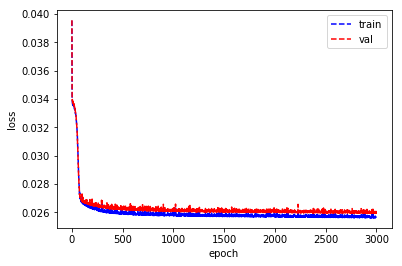

In [17]:
ax = plt.subplot(111)
ax.plot(np.arange(len(loss_train)), loss_train, 'b--')
ax.plot(np.arange(len(loss_val)), loss_val, 'r--')

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_yscale("log")

ax.legend(["train","val"])
ax.figure.savefig("4-15-15-2 all-atom and h2t series latent space error.jpg")
plt.draw()

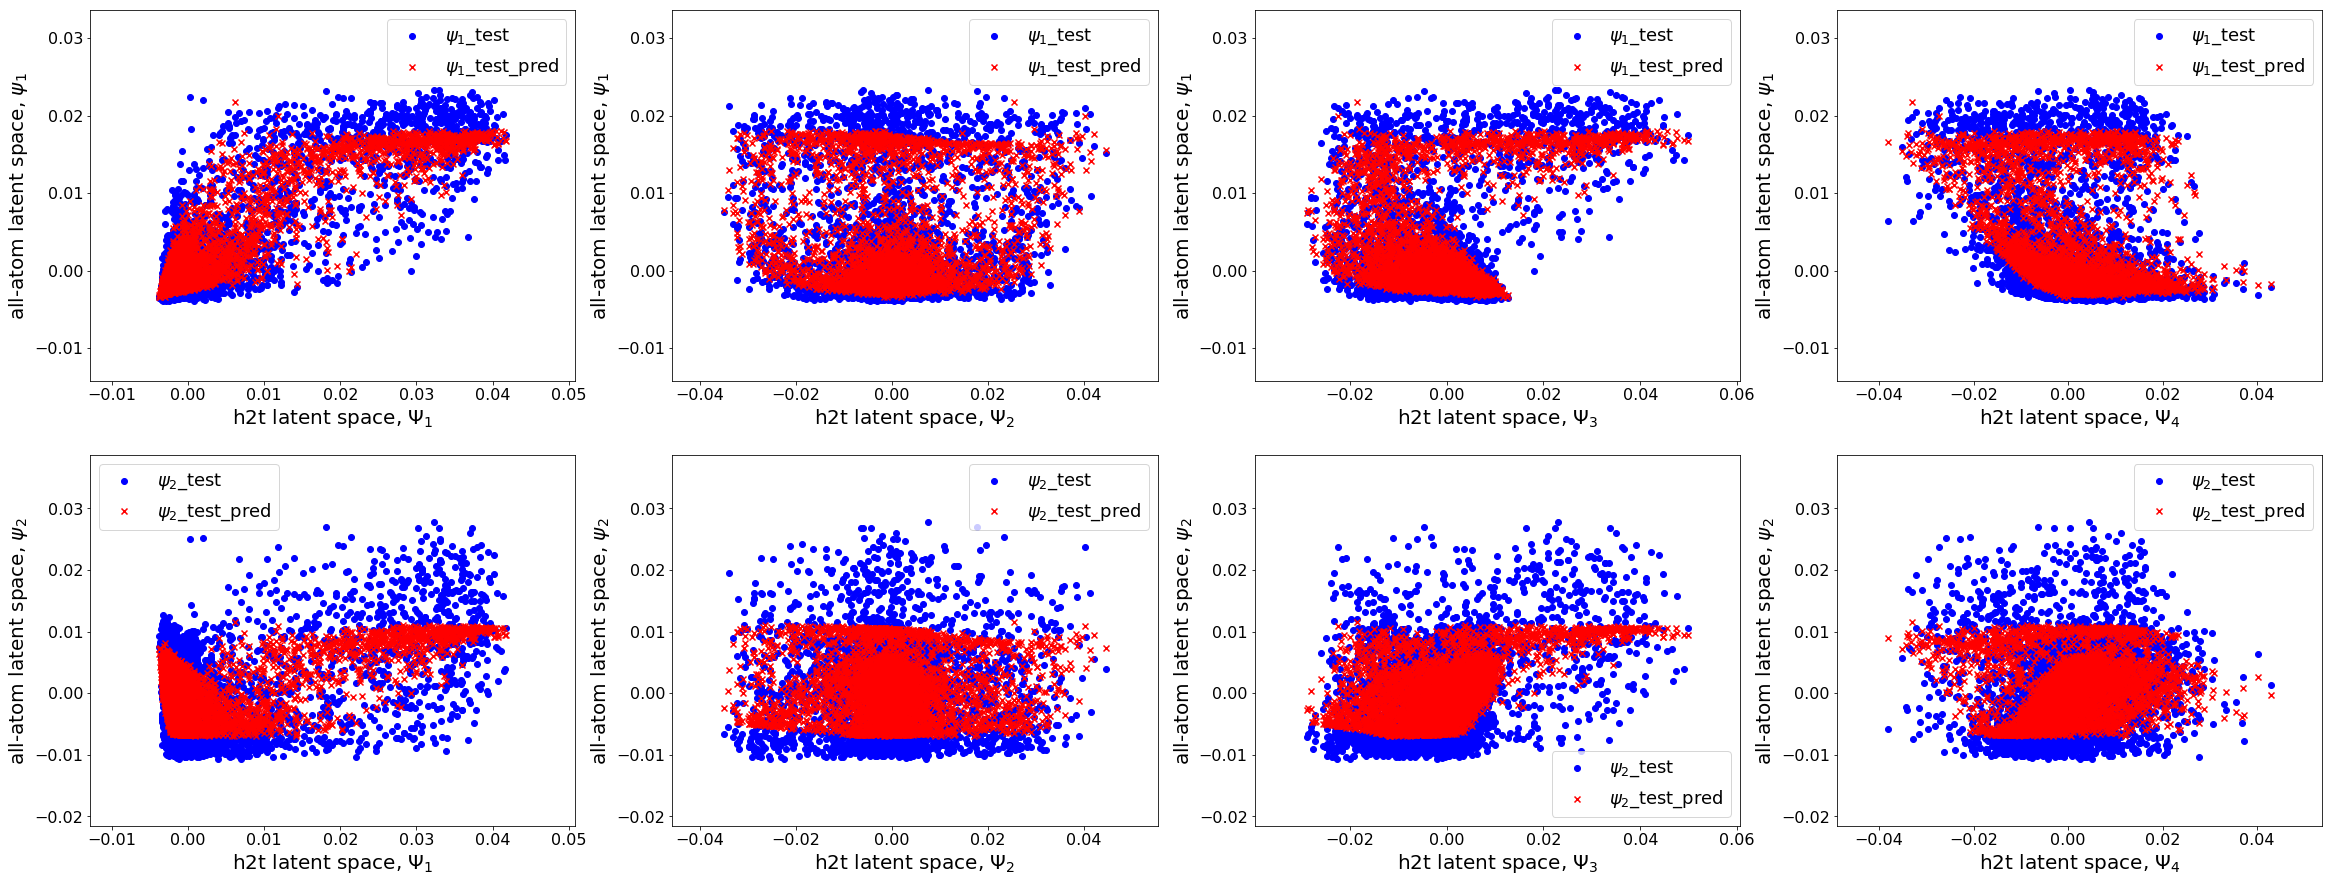

In [51]:
plt.figure(figsize=(40,15))

ax1 = plt.subplot(241)
ax1.scatter(x_test[:,0], y_test[:,0], c='blue', marker='o')
ax1.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax1.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax1.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax1.tick_params(labelsize=16)
ax1.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax2 = plt.subplot(242)
ax2.scatter(x_test[:,1], y_test[:,0], c='blue', marker='o')
ax2.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax2.set_xlabel('h2t latent space, $\Psi_2$',fontsize=20)
ax2.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax2.tick_params(labelsize=16)
ax2.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax3 = plt.subplot(243)
ax3.scatter(x_test[:,2], y_test[:,0], c='blue', marker='o')
ax3.scatter(x_test[:,2], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax3.set_xlabel('h2t latent space, $\Psi_3$',fontsize=20)
ax3.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax3.tick_params(labelsize=16)
ax3.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax4 = plt.subplot(244)
ax4.scatter(x_test[:,3], y_test[:,0], c='blue', marker='o')
ax4.scatter(x_test[:,3], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax4.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax4.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax4.tick_params(labelsize=16)
ax4.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax5 = plt.subplot(245)
ax5.scatter(x_test[:,0], y_test[:,1], c='blue', marker='o')
ax5.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax5.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax5.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax5.tick_params(labelsize=16)
ax5.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax6 = plt.subplot(246)
ax6.scatter(x_test[:,1], y_test[:,1], c='blue', marker='o')
ax6.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax6.set_xlabel('h2t latent space, $\Psi_2$',fontsize=20)
ax6.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax6.tick_params(labelsize=16)
ax6.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)


ax7 = plt.subplot(247)
ax7.scatter(x_test[:,2], y_test[:,1], c='blue', marker='o')
ax7.scatter(x_test[:,2], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax7.set_xlabel('h2t latent space, $\Psi_3$',fontsize=20)
ax7.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax7.tick_params(labelsize=16)
ax7.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax8 = plt.subplot(248)
ax8.scatter(x_test[:,3], y_test[:,1], c='blue', marker='o')
ax8.scatter(x_test[:,3], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax8.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax8.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax8.tick_params(labelsize=16)
ax8.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax.figure.savefig("4-15-15-2 all-atom and h2t series latent space correspondence.jpg")
plt.draw()